In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d paramaggarwal/fashion-product-images-dataset

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset
License(s): copyright-authors
100% 23.1G/23.1G [04:32<00:00, 141MB/s]
100% 23.1G/23.1G [04:32<00:00, 90.8MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fashion-product-images-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure

In [9]:
df=pd.read_csv('/content/styles1.csv')

In [10]:
df = df.drop(['Unnamed: 10', 'Unnamed: 11'], axis=1)

In [11]:
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   
5   1855    Men        Apparel     Topwear      Tshirts       Grey  Summer   
6  30805    Men        Apparel     Topwear       Shirts      Green  Summer   
7  26960  Women        Apparel     Topwear       Shirts     Purple  Summer   
8  29114    Men    Accessories       Socks        Socks  Navy Blue  Summer   
9  30039    Men    Accessories     Watches      Watches      Black  Winter   

     year   usage                             productDisplayName      image  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg  
1  2012.0  Casual             Peter England Men Party Blue Jeans  39386.jpg  
2  2016.0  Casual                       Titan Women Silver Watch  59263.jpg  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  21379.jpg  
4  2012.0  Casual                          Puma Men Grey T-shirt  53759.jpg  
5  2011.0  Casual           Inkfruit Mens Chain Reaction T-shirt   1855.jpg  
6  2012.0  Ethnic               Fabindia Men Striped Green Shirt  30805.jpg  
7  2012.0  Casual                  Jealous 21 Women Purple Shirt  26960.jpg  
8  2012.0  Casual                       Puma Men Pack of 3 Socks  29114.jpg  
9  2016.0  Casual                         Skagen Men Black Watch  30039.jpg

In [12]:
df.shape

(44446, 11)

In [13]:
import cv2
from PIL import Image
def img_path(img):
    return "/content/fashion-dataset/images/"+img


def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(Image.open(img_path(figures[title])))
        axeslist.ravel()[ind].set_xlabel(title)
       # axeslist.ravel()[ind].gca().get_xaxis().set_ticks([])
        #axeslist.ravel()[ind].gca().get_yaxis().set_ticks([])
    plt.tight_layout() # optional


def load_image(img, resized_fac = 0.1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized

#Look of some images in our data set

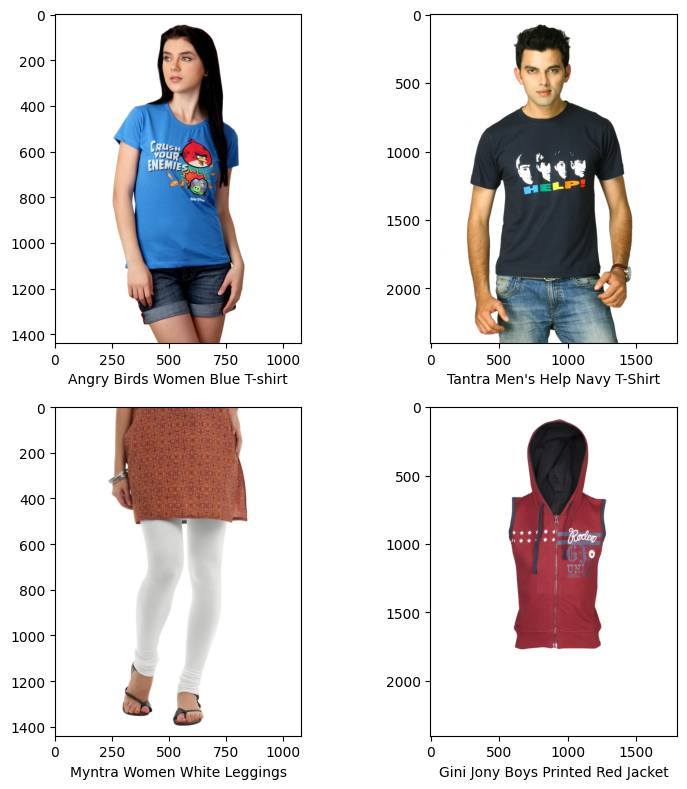

In [15]:
import matplotlib.pyplot as plt
import numpy as np
# generation of a dictionary of (title, images)
figures = {str(row.productDisplayName) : row.image for i, row in df.sample(4).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 2)

#The following plot show that product vs product counts

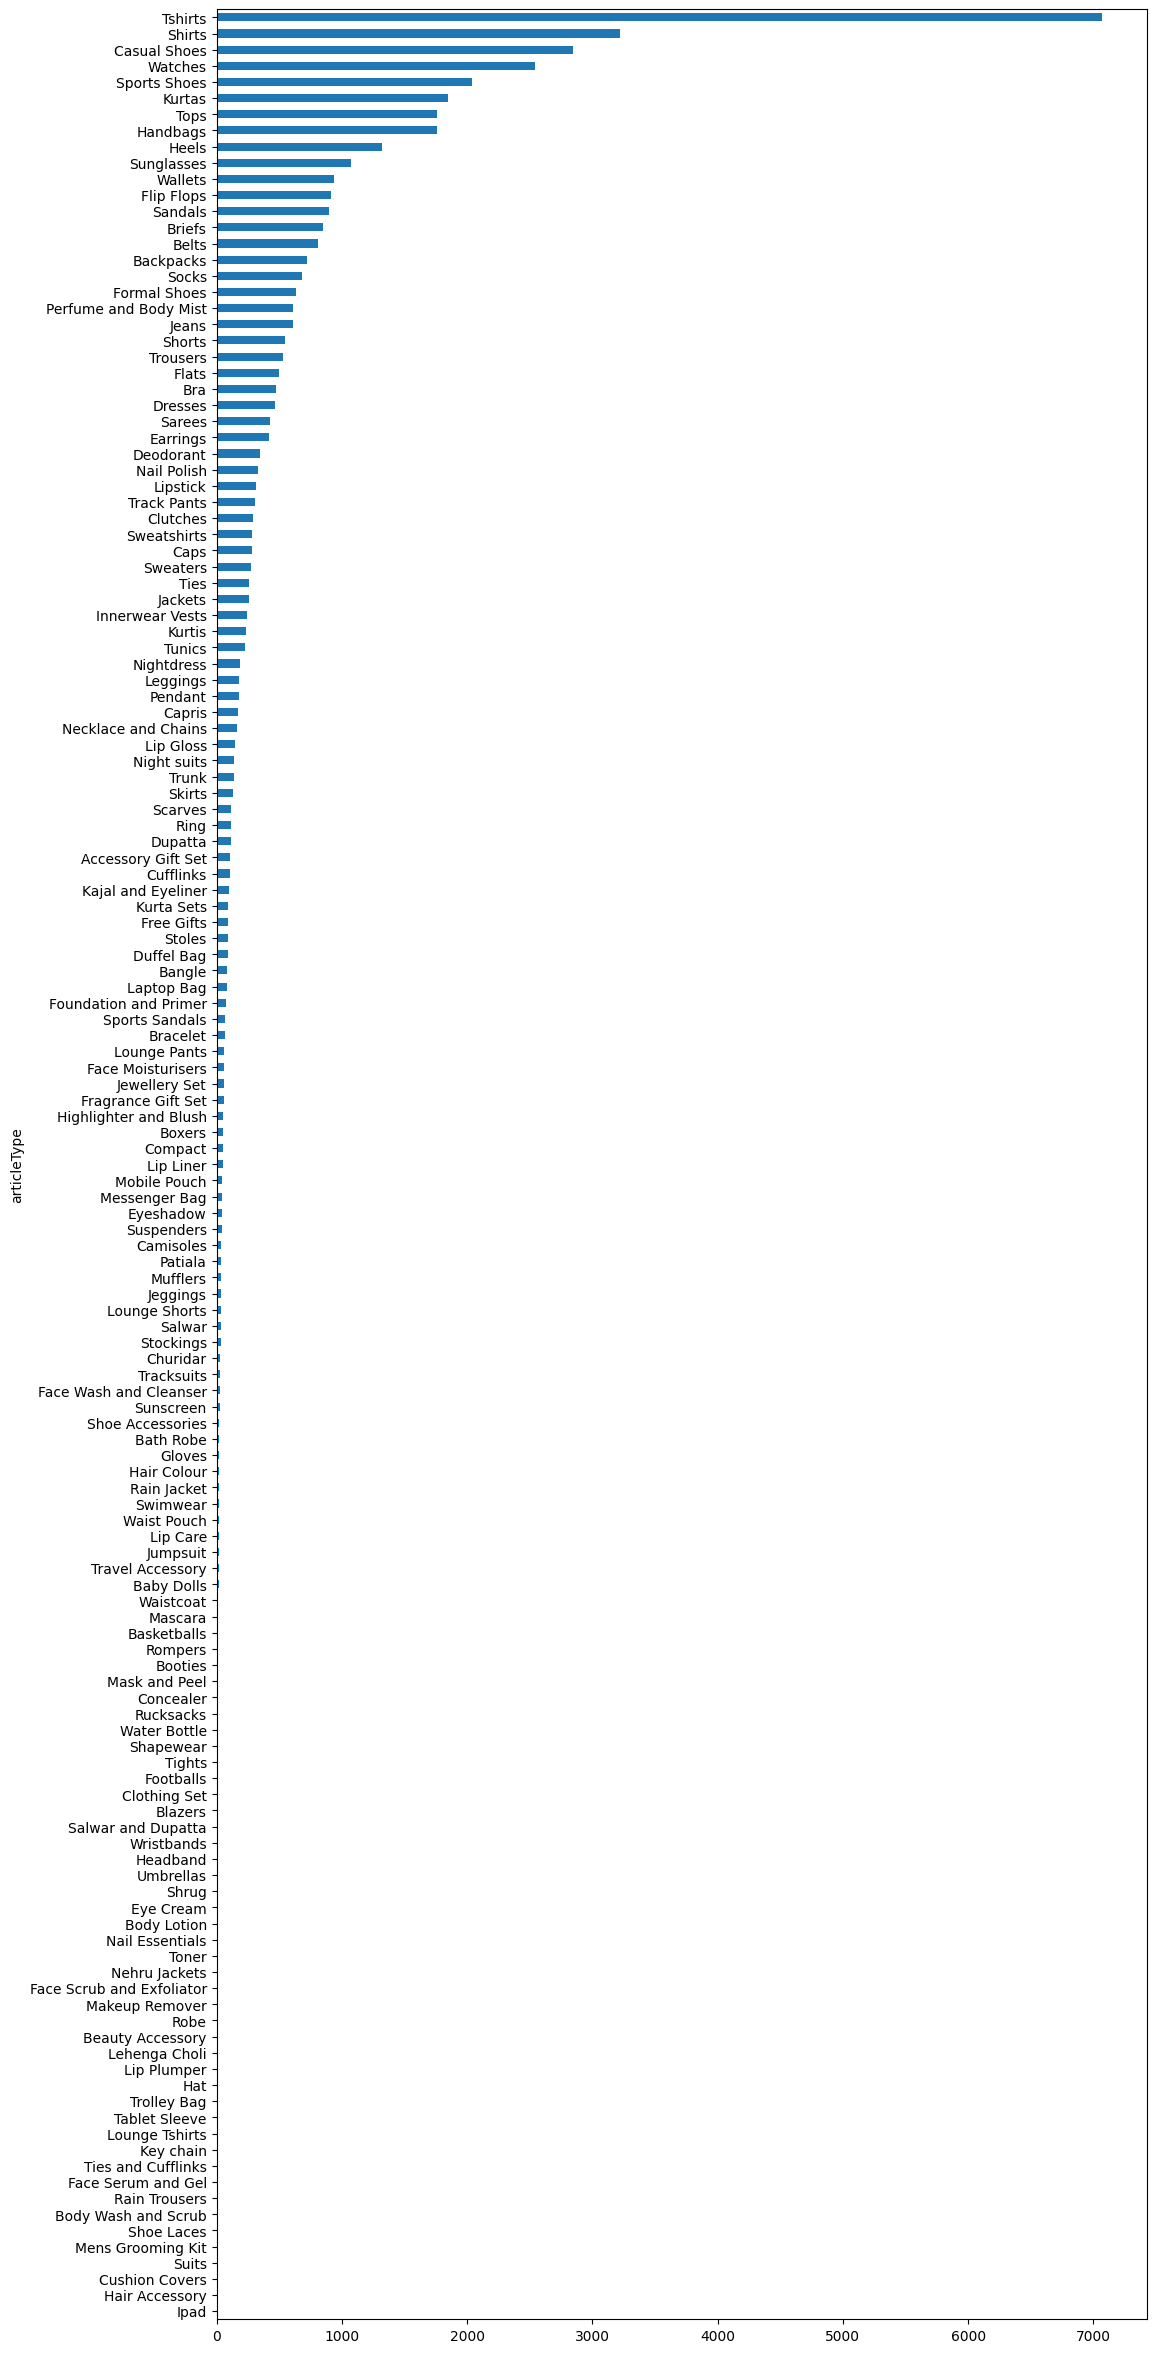

In [17]:
plt.figure(figsize=(12,30))
df.articleType.value_counts().sort_values().plot(kind='barh')
plt.show()

#Use Pre-Trained Model to Recommendation

In [18]:
import tensorflow as tf
import keras
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D

In [19]:
# Input Shape
img_width, img_height, _ = 224, 224, 3 #load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [21]:
import numpy as np
from numpy.linalg import norm

In [22]:
def get_embedding(model, img_name):
    # Reshape
    img = keras.utils.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    img_arr = keras.utils.img_to_array(img)
    # Expand Dim (1, w, h)
    expan_ing_array = np.expand_dims(img_arr, axis=0)
    # Pre process Input
    preprocess_img = preprocess_input(expan_ing_array)
    result = model.predict(preprocess_img).reshape(-1)
    normalized_result = result/norm(result)
    return normalized_result

In [23]:
#Apply embedding on first image
emb = get_embedding(model, df.iloc[0].image)
emb.shape

1/1 [==============================] - 1s 1s/step


(2048,)

(240, 180, 3)
[0.02237135 0.00893571 0.         ... 0.00512113 0.         0.04103194]


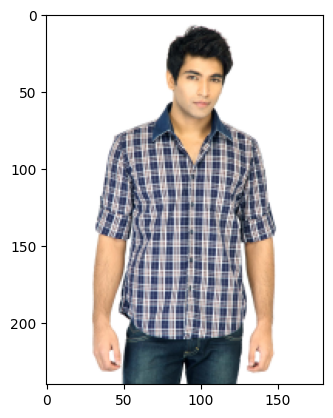

In [31]:
#product image and corresponding embedding vector
img_array = load_image(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

#Listing the image file name

In [33]:
file_names = []

for file in os.listdir('/content/fashion-dataset/images') :
  file_names.append(os.path.join('/content/fashion-dataset/images',file))

print(len(file_names))

44441


In [34]:
print(file_names[0:5])

['/content/fashion-dataset/images/50392.jpg', '/content/fashion-dataset/images/36138.jpg', '/content/fashion-dataset/images/22894.jpg', '/content/fashion-dataset/images/12272.jpg', '/content/fashion-dataset/images/7507.jpg']


In [35]:
from tqdm import tqdm

In [36]:
df.head(5)

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName      image  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg  
1  2012.0  Casual             Peter England Men Party Blue Jeans  39386.jpg  
2  2016.0  Casual                       Titan Women Silver Watch  59263.jpg  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  21379.jpg  
4  2012.0  Casual                          Puma Men Grey T-shirt  53759.jpg

In [37]:
#feature extraction of all images
feature_list = []
for image_name in tqdm(df['image']) :
  feature_list.append(get_embedding(model, image_name))


  0%|          | 0/44446 [00:00<?, ?it/s]

1/1 [==============================] - 0s 338ms/step


  0%|          | 1/44446 [00:00<9:34:32,  1.29it/s]

1/1 [==============================] - 0s 192ms/step


  0%|          | 2/44446 [00:01<6:12:55,  1.99it/s]

1/1 [==============================] - 0s 198ms/step


  0%|          | 3/44446 [00:01<5:35:28,  2.21it/s]

1/1 [==============================] - 0s 192ms/step


  0%|          | 4/44446 [00:01<4:43:17,  2.61it/s]

1/1 [==============================] - 0s 194ms/step


  0%|          | 5/44446 [00:02<4:14:59,  2.90it/s]

1/1 [==============================] - 0s 204ms/step


  0%|          | 6/44446 [00:02<4:01:30,  3.07it/s]

1/1 [==============================] - 0s 199ms/step


  0%|          | 7/44446 [00:02<3:51:38,  3.20it/s]

1/1 [==============================] - 0s 186ms/step


  0%|          | 8/44446 [00:02<3:41:34,  3.34it/s]

1/1 [==============================] - 0s 191ms/step


  0%|          | 9/44446 [00:03<3:35:31,  3.44it/s]

1/1 [==============================] - 0s 186ms/step


  0%|          | 10/44446 [00:03<3:33:05,  3.48it/s]

1/1 [==============================] - 0s 185ms/step


  0%|          | 11/44446 [00:03<3:30:20,  3.52it/s]

1/1 [==============================] - 0s 195ms/step


  0%|          | 12/44446 [00:03<3:28:06,  3.56it/s]

1/1 [==============================] - 0s 198ms/step


  0%|          | 13/44446 [00:04<3:30:50,  3.51it/s]

1/1 [==============================] - 0s 205ms/step


  0%|          | 14/44446 [00:04<3:30:42,  3.51it/s]

1/1 [==============================] - 0s 186ms/step


  0%|          | 15/44446 [00:04<3:25:58,  3.60it/s]

1/1 [==============================] - 0s 194ms/step


  0%|          | 16/44446 [00:05<3:32:03,  3.49it/s]

1/1 [==============================] - 0s 191ms/step


  0%|          | 17/44446 [00:05<3:59:09,  3.10it/s]

1/1 [==============================] - 0s 190ms/step


  0%|          | 18/44446 [00:05<3:52:38,  3.18it/s]

1/1 [==============================] - 0s 200ms/step


  0%|          | 19/44446 [00:06<3:47:26,  3.26it/s]

1/1 [==============================] - 0s 187ms/step


  0%|          | 20/44446 [00:06<4:08:01,  2.99it/s]

1/1 [==============================] - 0s 193ms/step


  0%|          | 21/44446 [00:06<3:55:59,  3.14it/s]

1/1 [==============================] - 0s 189ms/step


  0%|          | 22/44446 [00:07<4:16:01,  2.89it/s]

1/1 [==============================] - 0s 189ms/step


  0%|          | 23/44446 [00:07<4:00:30,  3.08it/s]

1/1 [==============================] - 0s 195ms/step


  0%|          | 24/44446 [00:07<3:52:35,  3.18it/s]

1/1 [==============================] - 0s 188ms/step


  0%|          | 25/44446 [00:08<3:46:27,  3.27it/s]

1/1 [==============================] - 0s 208ms/step


  0%|          | 26/44446 [00:08<4:10:29,  2.96it/s]

1/1 [==============================] - 0s 202ms/step


  0%|          | 27/44446 [00:08<3:58:09,  3.11it/s]

1/1 [==============================] - 0s 195ms/step


  0%|          | 28/44446 [00:09<3:48:55,  3.23it/s]

1/1 [==============================] - 0s 196ms/step


  0%|          | 29/44446 [00:09<3:40:37,  3.36it/s]

1/1 [==============================] - 0s 190ms/step


  0%|          | 30/44446 [00:09<3:33:21,  3.47it/s]

1/1 [==============================] - 0s 186ms/step


  0%|          | 31/44446 [00:09<3:42:53,  3.32it/s]

1/1 [==============================] - 0s 199ms/step


  0%|          | 32/44446 [00:10<3:43:59,  3.30it/s]

1/1 [==============================] - 0s 195ms/step


  0%|          | 33/44446 [00:10<3:42:15,  3.33it/s]

1/1 [==============================] - 0s 244ms/step


  0%|          | 34/44446 [00:10<4:02:30,  3.05it/s]

1/1 [==============================] - 0s 293ms/step


  0%|          | 35/44446 [00:11<4:17:57,  2.87it/s]

1/1 [==============================] - 0s 327ms/step


  0%|          | 36/44446 [00:12<5:52:56,  2.10it/s]

1/1 [==============================] - 0s 317ms/step


  0%|          | 37/44446 [00:12<5:40:15,  2.18it/s]

1/1 [==============================] - 0s 322ms/step


  0%|          | 38/44446 [00:12<5:33:23,  2.22it/s]

1/1 [==============================] - 0s 339ms/step


  0%|          | 39/44446 [00:13<6:40:51,  1.85it/s]

1/1 [==============================] - 0s 339ms/step


  0%|          | 40/44446 [00:14<6:27:13,  1.91it/s]

1/1 [==============================] - 0s 193ms/step


  0%|          | 41/44446 [00:14<6:04:57,  2.03it/s]

1/1 [==============================] - 0s 191ms/step


  0%|          | 42/44446 [00:14<5:18:40,  2.32it/s]

1/1 [==============================] - 0s 266ms/step


  0%|          | 43/44446 [00:15<5:13:20,  2.36it/s]

1/1 [==============================] - 0s 317ms/step


  0%|          | 44/44446 [00:15<5:17:53,  2.33it/s]

1/1 [==============================] - 0s 331ms/step


  0%|          | 45/44446 [00:16<5:23:39,  2.29it/s]

1/1 [==============================] - 0s 322ms/step


  0%|          | 46/44446 [00:16<5:25:49,  2.27it/s]

1/1 [==============================] - 0s 311ms/step


  0%|          | 47/44446 [00:17<5:26:25,  2.27it/s]

1/1 [==============================] - 0s 308ms/step


  0%|          | 48/44446 [00:17<5:31:34,  2.23it/s]

1/1 [==============================] - 0s 336ms/step


  0%|          | 49/44446 [00:18<6:40:39,  1.85it/s]

1/1 [==============================] - 0s 318ms/step


  0%|          | 50/44446 [00:18<6:14:07,  1.98it/s]

1/1 [==============================] - 0s 190ms/step


  0%|          | 51/44446 [00:18<5:22:35,  2.29it/s]

1/1 [==============================] - 0s 208ms/step


  0%|          | 52/44446 [00:19<4:52:24,  2.53it/s]

1/1 [==============================] - 0s 188ms/step


  0%|          | 53/44446 [00:19<4:23:04,  2.81it/s]

1/1 [==============================] - 0s 187ms/step


  0%|          | 54/44446 [00:19<4:05:05,  3.02it/s]

1/1 [==============================] - 0s 187ms/step


  0%|          | 55/44446 [00:20<3:49:27,  3.22it/s]

1/1 [==============================] - 0s 208ms/step


  0%|          | 56/44446 [00:20<3:45:14,  3.28it/s]

1/1 [==============================] - 0s 187ms/step


  0%|          | 57/44446 [00:20<4:08:13,  2.98it/s]

1/1 [==============================] - 0s 191ms/step


  0%|          | 58/44446 [00:21<4:21:39,  2.83it/s]

1/1 [==============================] - 0s 190ms/step


  0%|          | 59/44446 [00:21<4:13:00,  2.92it/s]

1/1 [==============================] - 0s 192ms/step


  0%|          | 60/44446 [00:21<3:59:33,  3.09it/s]

1/1 [==============================] - 0s 192ms/step


  0%|          | 61/44446 [00:22<4:14:49,  2.90it/s]

1/1 [==============================] - 0s 191ms/step


  0%|          | 62/44446 [00:22<4:02:42,  3.05it/s]

1/1 [==============================] - 0s 188ms/step


  0%|          | 63/44446 [00:22<3:49:19,  3.23it/s]

1/1 [==============================] - 0s 191ms/step


  0%|          | 64/44446 [00:22<3:40:17,  3.36it/s]

1/1 [==============================] - 0s 213ms/step


  0%|          | 65/44446 [00:23<3:38:09,  3.39it/s]

1/1 [==============================] - 0s 192ms/step


  0%|          | 66/44446 [00:23<3:32:46,  3.48it/s]

1/1 [==============================] - 0s 191ms/step


  0%|          | 67/44446 [00:23<3:27:46,  3.56it/s]

1/1 [==============================] - 0s 193ms/step


  0%|          | 68/44446 [00:24<3:55:59,  3.13it/s]

1/1 [==============================] - 0s 322ms/step


  0%|          | 69/44446 [00:24<4:22:44,  2.81it/s]

1/1 [==============================] - 0s 326ms/step


  0%|          | 70/44446 [00:25<4:38:58,  2.65it/s]

1/1 [==============================] - 0s 331ms/step


  0%|          | 71/44446 [00:25<4:56:22,  2.50it/s]

1/1 [==============================] - 0s 313ms/step


  0%|          | 72/44446 [00:25<4:59:36,  2.47it/s]

1/1 [==============================] - 0s 337ms/step


  0%|          | 73/44446 [00:26<5:11:52,  2.37it/s]

1/1 [==============================] - 0s 316ms/step


  0%|          | 74/44446 [00:26<5:17:36,  2.33it/s]

1/1 [==============================] - 0s 337ms/step


  0%|          | 75/44446 [00:27<6:31:27,  1.89it/s]

1/1 [==============================] - 0s 244ms/step


  0%|          | 76/44446 [00:28<6:15:28,  1.97it/s]

1/1 [==============================] - 0s 205ms/step


  0%|          | 77/44446 [00:28<5:24:26,  2.28it/s]

1/1 [==============================] - 0s 185ms/step


  0%|          | 78/44446 [00:28<5:18:15,  2.32it/s]

1/1 [==============================] - 0s 189ms/step


  0%|          | 79/44446 [00:29<4:42:14,  2.62it/s]

1/1 [==============================] - 0s 204ms/step


  0%|          | 80/44446 [00:29<4:22:51,  2.81it/s]

1/1 [==============================] - 0s 201ms/step


  0%|          | 81/44446 [00:29<4:06:06,  3.00it/s]

1/1 [==============================] - 0s 193ms/step


  0%|          | 82/44446 [00:30<4:24:38,  2.79it/s]

1/1 [==============================] - 0s 202ms/step


  0%|          | 83/44446 [00:30<4:17:22,  2.87it/s]

1/1 [==============================] - 0s 199ms/step


  0%|          | 84/44446 [00:30<4:29:49,  2.74it/s]

1/1 [==============================] - 0s 188ms/step


  0%|          | 85/44446 [00:31<4:07:14,  2.99it/s]

1/1 [==============================] - 0s 208ms/step


  0%|          | 86/44446 [00:31<4:18:52,  2.86it/s]

1/1 [==============================] - 0s 199ms/step


  0%|          | 87/44446 [00:31<4:27:36,  2.76it/s]

1/1 [==============================] - 0s 187ms/step


  0%|          | 88/44446 [00:32<4:06:12,  3.00it/s]

1/1 [==============================] - 0s 202ms/step


  0%|          | 89/44446 [00:32<4:20:41,  2.84it/s]

1/1 [==============================] - 0s 188ms/step


  0%|          | 90/44446 [00:32<4:04:00,  3.03it/s]

1/1 [==============================] - 0s 188ms/step


  0%|          | 91/44446 [00:33<4:18:47,  2.86it/s]

1/1 [==============================] - 0s 189ms/step


  0%|          | 92/44446 [00:33<4:01:55,  3.06it/s]

1/1 [==============================] - 0s 200ms/step


  0%|          | 93/44446 [00:33<3:49:57,  3.21it/s]

1/1 [==============================] - 0s 185ms/step


  0%|          | 94/44446 [00:33<3:37:55,  3.39it/s]

1/1 [==============================] - 0s 201ms/step


  0%|          | 95/44446 [00:34<3:33:51,  3.46it/s]

1/1 [==============================] - 0s 185ms/step


  0%|          | 96/44446 [00:34<3:32:51,  3.47it/s]

1/1 [==============================] - 0s 196ms/step


  0%|          | 97/44446 [00:34<3:34:19,  3.45it/s]

1/1 [==============================] - 0s 185ms/step


  0%|          | 98/44446 [00:35<3:33:40,  3.46it/s]

1/1 [==============================] - 0s 196ms/step


  0%|          | 99/44446 [00:35<3:35:23,  3.43it/s]

1/1 [==============================] - 0s 199ms/step


  0%|          | 100/44446 [00:35<3:30:54,  3.50it/s]

1/1 [==============================] - 0s 191ms/step


  0%|          | 101/44446 [00:35<3:28:34,  3.54it/s]

1/1 [==============================] - 0s 196ms/step


  0%|          | 102/44446 [00:36<3:25:32,  3.60it/s]

1/1 [==============================] - 0s 190ms/step


  0%|          | 103/44446 [00:36<3:54:58,  3.15it/s]

1/1 [==============================] - 0s 186ms/step


  0%|          | 104/44446 [00:36<3:45:29,  3.28it/s]

1/1 [==============================] - 0s 190ms/step


  0%|          | 105/44446 [00:37<4:08:46,  2.97it/s]

1/1 [==============================] - 0s 193ms/step


  0%|          | 106/44446 [00:37<3:53:27,  3.17it/s]

1/1 [==============================] - 0s 202ms/step


  0%|          | 107/44446 [00:37<3:46:20,  3.26it/s]

1/1 [==============================] - 0s 331ms/step


  0%|          | 108/44446 [00:38<5:28:39,  2.25it/s]

1/1 [==============================] - 0s 333ms/step


  0%|          | 109/44446 [00:39<5:32:53,  2.22it/s]

1/1 [==============================] - 0s 308ms/step


  0%|          | 110/44446 [00:39<5:33:22,  2.22it/s]

1/1 [==============================] - 0s 328ms/step


  0%|          | 111/44446 [00:39<5:36:20,  2.20it/s]

1/1 [==============================] - 0s 332ms/step


  0%|          | 112/44446 [00:40<6:41:52,  1.84it/s]

1/1 [==============================] - 0s 322ms/step


  0%|          | 113/44446 [00:41<6:24:18,  1.92it/s]

1/1 [==============================] - 0s 193ms/step


  0%|          | 114/44446 [00:41<5:31:15,  2.23it/s]

1/1 [==============================] - 0s 189ms/step


  0%|          | 115/44446 [00:41<5:19:05,  2.32it/s]

1/1 [==============================] - 0s 191ms/step


  0%|          | 116/44446 [00:42<5:14:10,  2.35it/s]

1/1 [==============================] - 0s 189ms/step


  0%|          | 117/44446 [00:42<4:38:57,  2.65it/s]

1/1 [==============================] - 0s 189ms/step


  0%|          | 118/44446 [00:42<4:13:52,  2.91it/s]

1/1 [==============================] - 0s 208ms/step


  0%|          | 119/44446 [00:43<3:59:26,  3.09it/s]

1/1 [==============================] - 0s 199ms/step


  0%|          | 120/44446 [00:43<3:49:06,  3.22it/s]

1/1 [==============================] - 0s 194ms/step


  0%|          | 121/44446 [00:43<3:42:57,  3.31it/s]

1/1 [==============================] - 0s 189ms/step


  0%|          | 122/44446 [00:43<3:36:48,  3.41it/s]

1/1 [==============================] - 0s 202ms/step


  0%|          | 123/44446 [00:44<4:04:49,  3.02it/s]

1/1 [==============================] - 0s 184ms/step


  0%|          | 124/44446 [00:44<3:47:56,  3.24it/s]

1/1 [==============================] - 0s 188ms/step


  0%|          | 125/44446 [00:45<4:11:17,  2.94it/s]

1/1 [==============================] - 0s 199ms/step


  0%|          | 126/44446 [00:45<4:25:38,  2.78it/s]

1/1 [==============================] - 0s 189ms/step


  0%|          | 127/44446 [00:45<4:31:46,  2.72it/s]

1/1 [==============================] - 0s 200ms/step


  0%|          | 128/44446 [00:46<4:17:12,  2.87it/s]

1/1 [==============================] - 0s 194ms/step


  0%|          | 129/44446 [00:46<4:05:14,  3.01it/s]

1/1 [==============================] - 0s 184ms/step


  0%|          | 130/44446 [00:46<3:52:19,  3.18it/s]

1/1 [==============================] - 0s 194ms/step


  0%|          | 131/44446 [00:46<3:46:16,  3.26it/s]

1/1 [==============================] - 0s 207ms/step


  0%|          | 132/44446 [00:47<3:46:29,  3.26it/s]

1/1 [==============================] - 0s 189ms/step


  0%|          | 133/44446 [00:47<4:10:51,  2.94it/s]

1/1 [==============================] - 0s 196ms/step


  0%|          | 134/44446 [00:48<4:24:22,  2.79it/s]

1/1 [==============================] - 0s 200ms/step


  0%|          | 135/44446 [00:48<4:34:32,  2.69it/s]

1/1 [==============================] - 0s 190ms/step


  0%|          | 136/44446 [00:48<4:13:46,  2.91it/s]

1/1 [==============================] - 0s 187ms/step


  0%|          | 137/44446 [00:49<3:56:29,  3.12it/s]

1/1 [==============================] - 0s 202ms/step


  0%|          | 138/44446 [00:49<4:14:40,  2.90it/s]

1/1 [==============================] - 0s 189ms/step


  0%|          | 139/44446 [00:49<4:24:36,  2.79it/s]

1/1 [==============================] - 0s 188ms/step


  0%|          | 140/44446 [00:50<4:06:21,  3.00it/s]

1/1 [==============================] - 0s 186ms/step


  0%|          | 141/44446 [00:50<3:55:35,  3.13it/s]

1/1 [==============================] - 0s 187ms/step


  0%|          | 142/44446 [00:50<3:44:49,  3.28it/s]

1/1 [==============================] - 0s 191ms/step


  0%|          | 143/44446 [00:50<3:41:13,  3.34it/s]

1/1 [==============================] - 0s 227ms/step


  0%|          | 144/44446 [00:51<4:01:01,  3.06it/s]

1/1 [==============================] - 0s 337ms/step


  0%|          | 145/44446 [00:52<5:40:07,  2.17it/s]

1/1 [==============================] - 0s 325ms/step


  0%|          | 146/44446 [00:52<5:33:44,  2.21it/s]

1/1 [==============================] - 0s 305ms/step


  0%|          | 147/44446 [00:53<5:36:09,  2.20it/s]

1/1 [==============================] - 0s 331ms/step


  0%|          | 148/44446 [00:53<5:31:46,  2.23it/s]

1/1 [==============================] - 0s 345ms/step


  0%|          | 149/44446 [00:54<6:39:55,  1.85it/s]

1/1 [==============================] - 0s 323ms/step


  0%|          | 150/44446 [00:54<6:15:19,  1.97it/s]

1/1 [==============================] - 0s 191ms/step


  0%|          | 151/44446 [00:55<5:50:41,  2.11it/s]

1/1 [==============================] - 0s 196ms/step


  0%|          | 152/44446 [00:55<5:09:21,  2.39it/s]

1/1 [==============================] - 0s 203ms/step


  0%|          | 153/44446 [00:55<5:05:52,  2.41it/s]

1/1 [==============================] - 0s 192ms/step


  0%|          | 154/44446 [00:56<5:00:32,  2.46it/s]

1/1 [==============================] - 0s 191ms/step


  0%|          | 155/44446 [00:56<5:04:59,  2.42it/s]

1/1 [==============================] - 0s 186ms/step


  0%|          | 156/44446 [00:56<4:32:11,  2.71it/s]

1/1 [==============================] - 0s 187ms/step


  0%|          | 157/44446 [00:57<4:37:13,  2.66it/s]

1/1 [==============================] - 0s 187ms/step


  0%|          | 158/44446 [00:57<4:12:03,  2.93it/s]

1/1 [==============================] - 0s 196ms/step


  0%|          | 159/44446 [00:57<3:58:35,  3.09it/s]

1/1 [==============================] - 0s 184ms/step


  0%|          | 160/44446 [00:58<3:52:27,  3.18it/s]

1/1 [==============================] - 0s 197ms/step


  0%|          | 161/44446 [00:58<4:15:55,  2.88it/s]

1/1 [==============================] - 0s 200ms/step


  0%|          | 162/44446 [00:58<3:59:59,  3.08it/s]

1/1 [==============================] - 0s 187ms/step


  0%|          | 163/44446 [00:59<4:19:47,  2.84it/s]

1/1 [==============================] - 0s 191ms/step


  0%|          | 164/44446 [00:59<4:33:27,  2.70it/s]

1/1 [==============================] - 0s 190ms/step


  0%|          | 165/44446 [00:59<4:37:25,  2.66it/s]

1/1 [==============================] - 0s 199ms/step


  0%|          | 166/44446 [01:00<4:41:14,  2.62it/s]

1/1 [==============================] - 0s 201ms/step


  0%|          | 167/44446 [01:00<4:48:21,  2.56it/s]

1/1 [==============================] - 0s 185ms/step


  0%|          | 168/44446 [01:01<4:22:52,  2.81it/s]

1/1 [==============================] - 0s 206ms/step


  0%|          | 169/44446 [01:01<4:05:45,  3.00it/s]

1/1 [==============================] - 0s 187ms/step


  0%|          | 170/44446 [01:01<4:23:43,  2.80it/s]

1/1 [==============================] - 0s 188ms/step


  0%|          | 171/44446 [01:02<4:31:14,  2.72it/s]

1/1 [==============================] - 0s 194ms/step


  0%|          | 172/44446 [01:02<4:12:23,  2.92it/s]

1/1 [==============================] - 0s 200ms/step


  0%|          | 173/44446 [01:02<4:01:33,  3.05it/s]

1/1 [==============================] - 0s 192ms/step


  0%|          | 174/44446 [01:02<3:47:54,  3.24it/s]

1/1 [==============================] - 0s 198ms/step


  0%|          | 175/44446 [01:03<4:08:27,  2.97it/s]

1/1 [==============================] - 0s 188ms/step


  0%|          | 176/44446 [01:03<3:51:44,  3.18it/s]

1/1 [==============================] - 0s 196ms/step


  0%|          | 177/44446 [01:03<3:44:29,  3.29it/s]

1/1 [==============================] - 0s 185ms/step


  0%|          | 178/44446 [01:04<3:37:52,  3.39it/s]

1/1 [==============================] - 0s 189ms/step


  0%|          | 179/44446 [01:04<3:41:05,  3.34it/s]

1/1 [==============================] - 0s 243ms/step


  0%|          | 180/44446 [01:04<3:47:31,  3.24it/s]

1/1 [==============================] - 0s 317ms/step


  0%|          | 181/44446 [01:05<4:20:14,  2.83it/s]

1/1 [==============================] - 0s 329ms/step


  0%|          | 182/44446 [01:05<4:38:54,  2.65it/s]

1/1 [==============================] - 0s 324ms/step


  0%|          | 183/44446 [01:06<4:56:07,  2.49it/s]

1/1 [==============================] - 0s 314ms/step


  0%|          | 184/44446 [01:06<5:01:14,  2.45it/s]

1/1 [==============================] - 0s 332ms/step


  0%|          | 185/44446 [01:07<6:24:23,  1.92it/s]

1/1 [==============================] - 0s 320ms/step


  0%|          | 186/44446 [01:07<6:05:36,  2.02it/s]

1/1 [==============================] - 1s 631ms/step


  0%|          | 187/44446 [01:08<7:25:19,  1.66it/s]

1/1 [==============================] - 0s 287ms/step


  0%|          | 188/44446 [01:09<6:49:24,  1.80it/s]

1/1 [==============================] - 0s 188ms/step


  0%|          | 189/44446 [01:09<5:46:56,  2.13it/s]

1/1 [==============================] - 0s 193ms/step


  0%|          | 190/44446 [01:09<5:09:24,  2.38it/s]

1/1 [==============================] - 0s 202ms/step


  0%|          | 191/44446 [01:09<4:40:31,  2.63it/s]

1/1 [==============================] - 0s 205ms/step


  0%|          | 192/44446 [01:10<4:46:00,  2.58it/s]

1/1 [==============================] - 0s 191ms/step


  0%|          | 193/44446 [01:10<4:50:40,  2.54it/s]

1/1 [==============================] - 0s 203ms/step


  0%|          | 194/44446 [01:11<4:53:56,  2.51it/s]

1/1 [==============================] - 0s 187ms/step


  0%|          | 195/44446 [01:11<4:28:28,  2.75it/s]

1/1 [==============================] - 0s 187ms/step


  0%|          | 196/44446 [01:11<4:34:45,  2.68it/s]

1/1 [==============================] - 0s 201ms/step


  0%|          | 197/44446 [01:12<4:16:24,  2.88it/s]

1/1 [==============================] - 0s 188ms/step


  0%|          | 198/44446 [01:12<4:03:05,  3.03it/s]

1/1 [==============================] - 0s 194ms/step


  0%|          | 199/44446 [01:12<4:18:37,  2.85it/s]

1/1 [==============================] - 0s 203ms/step


  0%|          | 200/44446 [01:13<4:05:11,  3.01it/s]

1/1 [==============================] - 0s 185ms/step


  0%|          | 201/44446 [01:13<3:54:28,  3.14it/s]

1/1 [==============================] - 0s 187ms/step


  0%|          | 202/44446 [01:13<4:16:10,  2.88it/s]

1/1 [==============================] - 0s 218ms/step


  0%|          | 203/44446 [01:14<4:26:37,  2.77it/s]

1/1 [==============================] - 0s 186ms/step


  0%|          | 204/44446 [01:14<4:07:05,  2.98it/s]

1/1 [==============================] - 0s 187ms/step


  0%|          | 205/44446 [01:14<3:52:19,  3.17it/s]

1/1 [==============================] - 0s 186ms/step


  0%|          | 206/44446 [01:15<3:49:17,  3.22it/s]

1/1 [==============================] - 0s 213ms/step


  0%|          | 207/44446 [01:15<3:47:19,  3.24it/s]

1/1 [==============================] - 0s 194ms/step


  0%|          | 208/44446 [01:15<3:37:52,  3.38it/s]

1/1 [==============================] - 0s 189ms/step


  0%|          | 209/44446 [01:16<4:00:48,  3.06it/s]

1/1 [==============================] - 0s 212ms/step


  0%|          | 210/44446 [01:16<3:56:02,  3.12it/s]

1/1 [==============================] - 0s 189ms/step


  0%|          | 211/44446 [01:16<4:11:11,  2.93it/s]

1/1 [==============================] - 0s 186ms/step


  0%|          | 212/44446 [01:17<3:56:40,  3.11it/s]

1/1 [==============================] - 0s 218ms/step


  0%|          | 213/44446 [01:17<3:53:22,  3.16it/s]

1/1 [==============================] - 0s 188ms/step


  0%|          | 214/44446 [01:17<3:45:54,  3.26it/s]

1/1 [==============================] - 0s 190ms/step


  0%|          | 215/44446 [01:18<4:05:41,  3.00it/s]

1/1 [==============================] - 0s 216ms/step


  0%|          | 216/44446 [01:18<3:55:46,  3.13it/s]

1/1 [==============================] - 0s 319ms/step


  0%|          | 217/44446 [01:18<4:19:21,  2.84it/s]

1/1 [==============================] - 0s 331ms/step


  0%|          | 218/44446 [01:19<5:46:16,  2.13it/s]

1/1 [==============================] - 0s 322ms/step


  0%|          | 219/44446 [01:19<5:44:09,  2.14it/s]

1/1 [==============================] - 0s 315ms/step


  0%|          | 220/44446 [01:20<5:37:40,  2.18it/s]

1/1 [==============================] - 0s 305ms/step


  0%|          | 221/44446 [01:20<5:25:42,  2.26it/s]

1/1 [==============================] - 0s 347ms/step


  0%|          | 222/44446 [01:21<6:39:03,  1.85it/s]

1/1 [==============================] - 0s 305ms/step


  1%|          | 223/44446 [01:21<6:19:18,  1.94it/s]

1/1 [==============================] - 0s 197ms/step


  1%|          | 224/44446 [01:22<5:53:20,  2.09it/s]

1/1 [==============================] - 0s 189ms/step


  1%|          | 225/44446 [01:23<6:42:19,  1.83it/s]

1/1 [==============================] - 0s 201ms/step


  1%|          | 226/44446 [01:23<6:10:38,  1.99it/s]

1/1 [==============================] - 0s 194ms/step


  1%|          | 227/44446 [01:23<5:44:44,  2.14it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 228/44446 [01:24<5:30:36,  2.23it/s]

1/1 [==============================] - 0s 203ms/step


  1%|          | 229/44446 [01:24<4:59:20,  2.46it/s]

1/1 [==============================] - 0s 194ms/step


  1%|          | 230/44446 [01:24<4:58:58,  2.46it/s]

1/1 [==============================] - 0s 201ms/step


  1%|          | 231/44446 [01:25<4:54:52,  2.50it/s]

1/1 [==============================] - 0s 207ms/step


  1%|          | 232/44446 [01:25<4:34:34,  2.68it/s]

1/1 [==============================] - 0s 194ms/step


  1%|          | 233/44446 [01:26<4:44:45,  2.59it/s]

1/1 [==============================] - 0s 201ms/step


  1%|          | 234/44446 [01:26<4:22:20,  2.81it/s]

1/1 [==============================] - 0s 207ms/step


  1%|          | 235/44446 [01:26<4:09:18,  2.96it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 236/44446 [01:27<4:29:36,  2.73it/s]

1/1 [==============================] - 0s 196ms/step


  1%|          | 237/44446 [01:27<4:11:52,  2.93it/s]

1/1 [==============================] - 0s 204ms/step


  1%|          | 238/44446 [01:27<3:58:06,  3.09it/s]

1/1 [==============================] - 0s 196ms/step


  1%|          | 239/44446 [01:27<3:46:31,  3.25it/s]

1/1 [==============================] - 0s 200ms/step


  1%|          | 240/44446 [01:28<3:41:30,  3.33it/s]

1/1 [==============================] - 0s 196ms/step


  1%|          | 241/44446 [01:28<3:35:59,  3.41it/s]

1/1 [==============================] - 0s 195ms/step


  1%|          | 242/44446 [01:28<3:42:13,  3.32it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 243/44446 [01:29<4:03:46,  3.02it/s]

1/1 [==============================] - 0s 186ms/step


  1%|          | 244/44446 [01:29<4:19:44,  2.84it/s]

1/1 [==============================] - 0s 194ms/step


  1%|          | 245/44446 [01:29<4:02:54,  3.03it/s]

1/1 [==============================] - 0s 194ms/step


  1%|          | 246/44446 [01:30<4:18:04,  2.85it/s]

1/1 [==============================] - 0s 193ms/step


  1%|          | 247/44446 [01:30<4:02:54,  3.03it/s]

1/1 [==============================] - 0s 205ms/step


  1%|          | 248/44446 [01:30<3:52:53,  3.16it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 249/44446 [01:31<3:42:52,  3.31it/s]

1/1 [==============================] - 0s 199ms/step


  1%|          | 250/44446 [01:31<3:40:23,  3.34it/s]

1/1 [==============================] - 0s 205ms/step


  1%|          | 251/44446 [01:31<3:41:49,  3.32it/s]

1/1 [==============================] - 0s 264ms/step


  1%|          | 252/44446 [01:32<4:05:00,  3.01it/s]

1/1 [==============================] - 0s 334ms/step


  1%|          | 253/44446 [01:32<4:38:04,  2.65it/s]

1/1 [==============================] - 0s 346ms/step


  1%|          | 254/44446 [01:33<4:57:17,  2.48it/s]

1/1 [==============================] - 0s 318ms/step


  1%|          | 255/44446 [01:33<5:06:49,  2.40it/s]

1/1 [==============================] - 0s 322ms/step


  1%|          | 256/44446 [01:34<5:19:21,  2.31it/s]

1/1 [==============================] - 0s 315ms/step


  1%|          | 257/44446 [01:34<5:23:53,  2.27it/s]

1/1 [==============================] - 0s 361ms/step


  1%|          | 258/44446 [01:35<6:36:52,  1.86it/s]

1/1 [==============================] - 0s 307ms/step


  1%|          | 259/44446 [01:35<6:15:51,  1.96it/s]

1/1 [==============================] - 0s 204ms/step


  1%|          | 260/44446 [01:36<5:58:31,  2.05it/s]

1/1 [==============================] - 0s 198ms/step


  1%|          | 261/44446 [01:36<5:39:44,  2.17it/s]

1/1 [==============================] - 0s 194ms/step


  1%|          | 262/44446 [01:36<5:27:28,  2.25it/s]

1/1 [==============================] - 0s 193ms/step


  1%|          | 263/44446 [01:37<4:54:29,  2.50it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 264/44446 [01:37<4:53:39,  2.51it/s]

1/1 [==============================] - 0s 189ms/step


  1%|          | 265/44446 [01:38<4:53:05,  2.51it/s]

1/1 [==============================] - 0s 209ms/step


  1%|          | 266/44446 [01:38<4:31:26,  2.71it/s]

1/1 [==============================] - 0s 193ms/step


  1%|          | 267/44446 [01:38<4:36:38,  2.66it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 268/44446 [01:39<4:18:03,  2.85it/s]

1/1 [==============================] - 0s 208ms/step


  1%|          | 269/44446 [01:39<4:36:10,  2.67it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 270/44446 [01:39<4:12:42,  2.91it/s]

1/1 [==============================] - 0s 189ms/step


  1%|          | 271/44446 [01:39<3:59:53,  3.07it/s]

1/1 [==============================] - 0s 203ms/step


  1%|          | 272/44446 [01:40<4:17:38,  2.86it/s]

1/1 [==============================] - 0s 196ms/step


  1%|          | 273/44446 [01:40<4:03:10,  3.03it/s]

1/1 [==============================] - 0s 193ms/step


  1%|          | 274/44446 [01:41<4:19:17,  2.84it/s]

1/1 [==============================] - 0s 207ms/step


  1%|          | 275/44446 [01:41<4:28:28,  2.74it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 276/44446 [01:41<4:33:46,  2.69it/s]

1/1 [==============================] - 0s 199ms/step


  1%|          | 277/44446 [01:42<4:17:40,  2.86it/s]

1/1 [==============================] - 0s 187ms/step


  1%|          | 278/44446 [01:42<4:02:44,  3.03it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 279/44446 [01:42<3:52:22,  3.17it/s]

1/1 [==============================] - 0s 188ms/step


  1%|          | 280/44446 [01:43<4:13:30,  2.90it/s]

1/1 [==============================] - 0s 198ms/step


  1%|          | 281/44446 [01:43<4:13:15,  2.91it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 282/44446 [01:43<4:25:42,  2.77it/s]

1/1 [==============================] - 0s 199ms/step


  1%|          | 283/44446 [01:44<4:08:23,  2.96it/s]

1/1 [==============================] - 0s 194ms/step


  1%|          | 284/44446 [01:44<4:29:12,  2.73it/s]

1/1 [==============================] - 0s 197ms/step


  1%|          | 285/44446 [01:44<4:36:39,  2.66it/s]

1/1 [==============================] - 0s 216ms/step


  1%|          | 286/44446 [01:45<4:45:55,  2.57it/s]

1/1 [==============================] - 0s 217ms/step


  1%|          | 287/44446 [01:45<4:49:44,  2.54it/s]

1/1 [==============================] - 0s 330ms/step


  1%|          | 288/44446 [01:46<4:59:42,  2.46it/s]

1/1 [==============================] - 0s 322ms/step


  1%|          | 289/44446 [01:46<5:07:14,  2.40it/s]

1/1 [==============================] - 0s 334ms/step


  1%|          | 290/44446 [01:47<6:26:47,  1.90it/s]

1/1 [==============================] - 0s 308ms/step


  1%|          | 291/44446 [01:47<6:02:06,  2.03it/s]

1/1 [==============================] - 0s 344ms/step


  1%|          | 292/44446 [01:48<6:59:04,  1.76it/s]

1/1 [==============================] - 0s 327ms/step


  1%|          | 293/44446 [01:49<6:29:23,  1.89it/s]

1/1 [==============================] - 0s 206ms/step


  1%|          | 294/44446 [01:49<5:38:40,  2.17it/s]

1/1 [==============================] - 0s 188ms/step


  1%|          | 295/44446 [01:49<5:28:57,  2.24it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 296/44446 [01:50<5:18:49,  2.31it/s]

1/1 [==============================] - 0s 210ms/step


  1%|          | 297/44446 [01:50<5:12:40,  2.35it/s]

1/1 [==============================] - 0s 203ms/step


  1%|          | 298/44446 [01:50<4:40:05,  2.63it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 299/44446 [01:51<4:42:55,  2.60it/s]

1/1 [==============================] - 0s 205ms/step


  1%|          | 300/44446 [01:51<4:22:28,  2.80it/s]

1/1 [==============================] - 0s 196ms/step


  1%|          | 301/44446 [01:51<4:38:45,  2.64it/s]

1/1 [==============================] - 0s 200ms/step


  1%|          | 302/44446 [01:52<4:41:37,  2.61it/s]

1/1 [==============================] - 0s 204ms/step


  1%|          | 303/44446 [01:52<4:20:19,  2.83it/s]

1/1 [==============================] - 0s 199ms/step


  1%|          | 304/44446 [01:53<4:31:40,  2.71it/s]

1/1 [==============================] - 0s 197ms/step


  1%|          | 305/44446 [01:53<4:37:31,  2.65it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 306/44446 [01:53<4:18:26,  2.85it/s]

1/1 [==============================] - 0s 201ms/step


  1%|          | 307/44446 [01:54<4:28:42,  2.74it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 308/44446 [01:54<4:42:08,  2.61it/s]

1/1 [==============================] - 0s 193ms/step


  1%|          | 309/44446 [01:54<4:18:35,  2.84it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 310/44446 [01:55<4:27:36,  2.75it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 311/44446 [01:55<4:33:21,  2.69it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 312/44446 [01:56<4:40:05,  2.63it/s]

1/1 [==============================] - 0s 200ms/step


  1%|          | 313/44446 [01:56<4:46:34,  2.57it/s]

1/1 [==============================] - 0s 208ms/step


  1%|          | 314/44446 [01:56<4:23:00,  2.80it/s]

1/1 [==============================] - 0s 189ms/step


  1%|          | 315/44446 [01:57<4:07:59,  2.97it/s]

1/1 [==============================] - 0s 198ms/step


  1%|          | 316/44446 [01:57<4:00:56,  3.05it/s]

1/1 [==============================] - 0s 206ms/step


  1%|          | 317/44446 [01:57<3:58:51,  3.08it/s]

1/1 [==============================] - 0s 199ms/step


  1%|          | 318/44446 [01:58<4:13:42,  2.90it/s]

1/1 [==============================] - 0s 199ms/step


  1%|          | 319/44446 [01:58<4:29:21,  2.73it/s]

1/1 [==============================] - 0s 202ms/step


  1%|          | 320/44446 [01:58<4:34:28,  2.68it/s]

1/1 [==============================] - 0s 221ms/step


  1%|          | 321/44446 [01:59<4:41:10,  2.62it/s]

1/1 [==============================] - 0s 314ms/step


  1%|          | 322/44446 [01:59<4:55:54,  2.49it/s]

1/1 [==============================] - 0s 328ms/step


  1%|          | 323/44446 [02:00<5:04:21,  2.42it/s]

1/1 [==============================] - 0s 316ms/step


  1%|          | 324/44446 [02:00<5:18:38,  2.31it/s]

1/1 [==============================] - 0s 327ms/step


  1%|          | 325/44446 [02:01<5:20:06,  2.30it/s]

1/1 [==============================] - 0s 319ms/step


  1%|          | 326/44446 [02:01<5:27:20,  2.25it/s]

1/1 [==============================] - 0s 344ms/step


  1%|          | 327/44446 [02:02<5:36:00,  2.19it/s]

1/1 [==============================] - 0s 360ms/step


  1%|          | 328/44446 [02:02<5:44:01,  2.14it/s]

1/1 [==============================] - 0s 326ms/step


  1%|          | 329/44446 [02:02<5:37:40,  2.18it/s]

1/1 [==============================] - 0s 284ms/step


  1%|          | 330/44446 [02:03<5:32:03,  2.21it/s]

1/1 [==============================] - 0s 188ms/step


  1%|          | 331/44446 [02:03<5:24:25,  2.27it/s]

1/1 [==============================] - 0s 207ms/step


  1%|          | 332/44446 [02:04<4:50:37,  2.53it/s]

1/1 [==============================] - 0s 206ms/step


  1%|          | 333/44446 [02:04<4:51:42,  2.52it/s]

1/1 [==============================] - 0s 196ms/step


  1%|          | 334/44446 [02:04<4:56:44,  2.48it/s]

1/1 [==============================] - 0s 198ms/step


  1%|          | 335/44446 [02:05<4:55:59,  2.48it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 336/44446 [02:05<4:25:12,  2.77it/s]

1/1 [==============================] - 0s 186ms/step


  1%|          | 337/44446 [02:05<4:08:29,  2.96it/s]

1/1 [==============================] - 0s 200ms/step


  1%|          | 338/44446 [02:06<4:30:02,  2.72it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 339/44446 [02:06<4:11:08,  2.93it/s]

1/1 [==============================] - 0s 189ms/step


  1%|          | 340/44446 [02:06<4:24:18,  2.78it/s]

1/1 [==============================] - 0s 201ms/step


  1%|          | 341/44446 [02:07<4:36:02,  2.66it/s]

1/1 [==============================] - 0s 187ms/step


  1%|          | 342/44446 [02:07<4:15:26,  2.88it/s]

1/1 [==============================] - 0s 200ms/step


  1%|          | 343/44446 [02:07<4:03:56,  3.01it/s]

1/1 [==============================] - 0s 198ms/step


  1%|          | 344/44446 [02:08<3:56:30,  3.11it/s]

1/1 [==============================] - 0s 195ms/step


  1%|          | 345/44446 [02:08<3:45:46,  3.26it/s]

1/1 [==============================] - 0s 186ms/step


  1%|          | 346/44446 [02:08<3:42:21,  3.31it/s]

1/1 [==============================] - 0s 214ms/step


  1%|          | 347/44446 [02:09<3:40:36,  3.33it/s]

1/1 [==============================] - 0s 195ms/step


  1%|          | 348/44446 [02:09<4:06:19,  2.98it/s]

1/1 [==============================] - 0s 187ms/step


  1%|          | 349/44446 [02:09<3:49:50,  3.20it/s]

1/1 [==============================] - 0s 198ms/step


  1%|          | 350/44446 [02:10<3:42:52,  3.30it/s]

1/1 [==============================] - 0s 202ms/step


  1%|          | 351/44446 [02:10<3:45:35,  3.26it/s]

1/1 [==============================] - 0s 193ms/step


  1%|          | 352/44446 [02:10<3:37:12,  3.38it/s]

1/1 [==============================] - 0s 193ms/step


  1%|          | 353/44446 [02:11<3:57:32,  3.09it/s]

1/1 [==============================] - 0s 198ms/step


  1%|          | 354/44446 [02:11<3:53:53,  3.14it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 355/44446 [02:11<3:44:07,  3.28it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 356/44446 [02:12<4:06:14,  2.98it/s]

1/1 [==============================] - 0s 213ms/step


  1%|          | 357/44446 [02:12<4:22:25,  2.80it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 358/44446 [02:12<4:29:13,  2.73it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 359/44446 [02:13<4:39:44,  2.63it/s]

1/1 [==============================] - 0s 305ms/step


  1%|          | 360/44446 [02:13<4:39:30,  2.63it/s]

1/1 [==============================] - 0s 328ms/step


  1%|          | 361/44446 [02:14<4:53:53,  2.50it/s]

1/1 [==============================] - 0s 364ms/step


  1%|          | 362/44446 [02:14<6:12:48,  1.97it/s]

1/1 [==============================] - 0s 325ms/step


  1%|          | 363/44446 [02:15<5:59:23,  2.04it/s]

1/1 [==============================] - 0s 308ms/step


  1%|          | 364/44446 [02:15<5:53:07,  2.08it/s]

1/1 [==============================] - 0s 341ms/step


  1%|          | 365/44446 [02:16<5:54:55,  2.07it/s]

1/1 [==============================] - 0s 331ms/step


  1%|          | 366/44446 [02:16<5:56:36,  2.06it/s]

1/1 [==============================] - 0s 300ms/step


  1%|          | 367/44446 [02:17<5:52:57,  2.08it/s]

1/1 [==============================] - 0s 205ms/step


  1%|          | 368/44446 [02:17<5:10:20,  2.37it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 369/44446 [02:17<5:11:00,  2.36it/s]

1/1 [==============================] - 0s 196ms/step


  1%|          | 370/44446 [02:18<5:04:51,  2.41it/s]

1/1 [==============================] - 0s 205ms/step


  1%|          | 371/44446 [02:18<4:36:21,  2.66it/s]

1/1 [==============================] - 0s 188ms/step


  1%|          | 372/44446 [02:18<4:15:37,  2.87it/s]

1/1 [==============================] - 0s 186ms/step


  1%|          | 373/44446 [02:19<4:28:18,  2.74it/s]

1/1 [==============================] - 0s 202ms/step


  1%|          | 374/44446 [02:19<4:09:52,  2.94it/s]

1/1 [==============================] - 0s 197ms/step


  1%|          | 375/44446 [02:19<3:57:48,  3.09it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 376/44446 [02:20<4:15:50,  2.87it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 377/44446 [02:20<4:01:31,  3.04it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 378/44446 [02:20<4:17:53,  2.85it/s]

1/1 [==============================] - 0s 198ms/step


  1%|          | 379/44446 [02:21<4:01:55,  3.04it/s]

1/1 [==============================] - 0s 195ms/step


  1%|          | 380/44446 [02:21<3:57:32,  3.09it/s]

1/1 [==============================] - 0s 193ms/step


  1%|          | 381/44446 [02:21<4:18:46,  2.84it/s]

1/1 [==============================] - 0s 209ms/step


  1%|          | 382/44446 [02:22<4:30:42,  2.71it/s]

1/1 [==============================] - 0s 202ms/step


  1%|          | 383/44446 [02:22<4:16:01,  2.87it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 384/44446 [02:22<4:01:19,  3.04it/s]

1/1 [==============================] - 0s 197ms/step


  1%|          | 385/44446 [02:23<4:15:04,  2.88it/s]

1/1 [==============================] - 0s 189ms/step


  1%|          | 386/44446 [02:23<4:00:20,  3.06it/s]

1/1 [==============================] - 0s 188ms/step


  1%|          | 387/44446 [02:23<3:51:43,  3.17it/s]

1/1 [==============================] - 0s 189ms/step


  1%|          | 388/44446 [02:24<3:41:44,  3.31it/s]

1/1 [==============================] - 0s 188ms/step


  1%|          | 389/44446 [02:24<3:38:13,  3.36it/s]

1/1 [==============================] - 0s 215ms/step


  1%|          | 390/44446 [02:24<4:03:37,  3.01it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 391/44446 [02:25<3:53:22,  3.15it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 392/44446 [02:25<3:47:18,  3.23it/s]

1/1 [==============================] - 0s 200ms/step


  1%|          | 393/44446 [02:25<4:07:40,  2.96it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 394/44446 [02:26<4:19:49,  2.83it/s]

1/1 [==============================] - 0s 189ms/step


  1%|          | 395/44446 [02:26<4:01:31,  3.04it/s]

1/1 [==============================] - 0s 210ms/step


  1%|          | 396/44446 [02:26<3:56:05,  3.11it/s]

1/1 [==============================] - 0s 188ms/step


  1%|          | 397/44446 [02:27<4:14:54,  2.88it/s]

1/1 [==============================] - 0s 293ms/step


  1%|          | 398/44446 [02:27<4:32:02,  2.70it/s]

1/1 [==============================] - 0s 340ms/step


  1%|          | 399/44446 [02:28<4:49:13,  2.54it/s]

1/1 [==============================] - 0s 331ms/step


  1%|          | 400/44446 [02:28<4:55:58,  2.48it/s]

1/1 [==============================] - 0s 329ms/step


  1%|          | 401/44446 [02:28<5:05:00,  2.41it/s]

1/1 [==============================] - 0s 325ms/step


  1%|          | 402/44446 [02:29<5:17:43,  2.31it/s]

1/1 [==============================] - 0s 316ms/step


  1%|          | 403/44446 [02:29<5:25:07,  2.26it/s]

1/1 [==============================] - 0s 332ms/step


  1%|          | 404/44446 [02:30<5:35:01,  2.19it/s]

1/1 [==============================] - 0s 323ms/step


  1%|          | 405/44446 [02:31<6:49:20,  1.79it/s]

1/1 [==============================] - 0s 187ms/step


  1%|          | 406/44446 [02:31<6:13:57,  1.96it/s]

1/1 [==============================] - 0s 195ms/step


  1%|          | 407/44446 [02:31<5:22:07,  2.28it/s]

1/1 [==============================] - 0s 202ms/step


  1%|          | 408/44446 [02:32<5:19:32,  2.30it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 409/44446 [02:32<5:09:52,  2.37it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 410/44446 [02:33<5:03:09,  2.42it/s]

1/1 [==============================] - 0s 205ms/step


  1%|          | 411/44446 [02:33<5:04:24,  2.41it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 412/44446 [02:33<5:00:01,  2.45it/s]

1/1 [==============================] - 0s 210ms/step


  1%|          | 413/44446 [02:34<4:57:16,  2.47it/s]

1/1 [==============================] - 0s 195ms/step


  1%|          | 414/44446 [02:34<4:53:49,  2.50it/s]

1/1 [==============================] - 0s 188ms/step


  1%|          | 415/44446 [02:34<4:23:25,  2.79it/s]

1/1 [==============================] - 0s 219ms/step


  1%|          | 416/44446 [02:35<4:09:51,  2.94it/s]

1/1 [==============================] - 0s 186ms/step


  1%|          | 417/44446 [02:35<3:52:26,  3.16it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 418/44446 [02:35<3:46:03,  3.25it/s]

1/1 [==============================] - 0s 185ms/step


  1%|          | 419/44446 [02:36<3:39:42,  3.34it/s]

1/1 [==============================] - 0s 206ms/step


  1%|          | 420/44446 [02:36<3:40:56,  3.32it/s]

1/1 [==============================] - 0s 187ms/step


  1%|          | 421/44446 [02:36<3:36:36,  3.39it/s]

1/1 [==============================] - 0s 187ms/step


  1%|          | 422/44446 [02:37<4:02:10,  3.03it/s]

1/1 [==============================] - 0s 211ms/step


  1%|          | 423/44446 [02:37<3:54:59,  3.12it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 424/44446 [02:37<3:46:34,  3.24it/s]

1/1 [==============================] - 0s 188ms/step


  1%|          | 425/44446 [02:38<4:09:05,  2.95it/s]

1/1 [==============================] - 0s 214ms/step


  1%|          | 426/44446 [02:38<4:20:30,  2.82it/s]

1/1 [==============================] - 0s 194ms/step


  1%|          | 427/44446 [02:38<4:30:02,  2.72it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 428/44446 [02:39<4:37:41,  2.64it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 429/44446 [02:39<4:16:08,  2.86it/s]

1/1 [==============================] - 0s 194ms/step


  1%|          | 430/44446 [02:39<4:00:51,  3.05it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 431/44446 [02:40<3:47:49,  3.22it/s]

1/1 [==============================] - 0s 216ms/step


  1%|          | 432/44446 [02:40<4:09:15,  2.94it/s]

1/1 [==============================] - 0s 188ms/step


  1%|          | 433/44446 [02:40<4:19:47,  2.82it/s]

1/1 [==============================] - 0s 253ms/step


  1%|          | 434/44446 [02:41<4:16:00,  2.87it/s]

1/1 [==============================] - 0s 325ms/step


  1%|          | 435/44446 [02:41<4:41:23,  2.61it/s]

1/1 [==============================] - 0s 326ms/step


  1%|          | 436/44446 [02:42<4:52:22,  2.51it/s]

1/1 [==============================] - 0s 342ms/step


  1%|          | 437/44446 [02:42<6:18:23,  1.94it/s]

1/1 [==============================] - 0s 327ms/step


  1%|          | 438/44446 [02:43<6:05:44,  2.01it/s]

1/1 [==============================] - 0s 318ms/step


  1%|          | 439/44446 [02:43<5:54:40,  2.07it/s]

1/1 [==============================] - 0s 371ms/step


  1%|          | 440/44446 [02:44<5:53:19,  2.08it/s]

1/1 [==============================] - 0s 353ms/step


  1%|          | 441/44446 [02:44<5:50:46,  2.09it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 442/44446 [02:45<5:37:47,  2.17it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 443/44446 [02:45<5:31:15,  2.21it/s]

1/1 [==============================] - 0s 189ms/step


  1%|          | 444/44446 [02:45<5:18:39,  2.30it/s]

1/1 [==============================] - 0s 195ms/step


  1%|          | 445/44446 [02:46<4:43:56,  2.58it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 446/44446 [02:46<4:45:50,  2.57it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 447/44446 [02:47<4:52:07,  2.51it/s]

1/1 [==============================] - 0s 201ms/step


  1%|          | 448/44446 [02:47<4:30:17,  2.71it/s]

1/1 [==============================] - 0s 212ms/step


  1%|          | 449/44446 [02:47<4:20:58,  2.81it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 450/44446 [02:47<4:04:20,  3.00it/s]

1/1 [==============================] - 0s 204ms/step


  1%|          | 451/44446 [02:48<4:20:59,  2.81it/s]

1/1 [==============================] - 0s 205ms/step


  1%|          | 452/44446 [02:48<4:08:32,  2.95it/s]

1/1 [==============================] - 0s 196ms/step


  1%|          | 453/44446 [02:48<3:56:46,  3.10it/s]

1/1 [==============================] - 0s 200ms/step


  1%|          | 454/44446 [02:49<3:50:17,  3.18it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 455/44446 [02:49<3:46:21,  3.24it/s]

1/1 [==============================] - 0s 201ms/step


  1%|          | 456/44446 [02:49<3:42:14,  3.30it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 457/44446 [02:50<4:04:05,  3.00it/s]

1/1 [==============================] - 0s 188ms/step


  1%|          | 458/44446 [02:50<4:16:38,  2.86it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 459/44446 [02:50<4:03:08,  3.02it/s]

1/1 [==============================] - 0s 206ms/step


  1%|          | 460/44446 [02:51<4:07:21,  2.96it/s]

1/1 [==============================] - 0s 188ms/step


  1%|          | 461/44446 [02:51<3:55:50,  3.11it/s]

1/1 [==============================] - 0s 206ms/step


  1%|          | 462/44446 [02:51<3:51:38,  3.16it/s]

1/1 [==============================] - 0s 186ms/step


  1%|          | 463/44446 [02:52<3:43:20,  3.28it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 464/44446 [02:52<4:07:45,  2.96it/s]

1/1 [==============================] - 0s 201ms/step


  1%|          | 465/44446 [02:52<4:25:43,  2.76it/s]

1/1 [==============================] - 0s 224ms/step


  1%|          | 466/44446 [02:53<4:20:22,  2.82it/s]

1/1 [==============================] - 0s 216ms/step


  1%|          | 467/44446 [02:53<4:15:33,  2.87it/s]

1/1 [==============================] - 0s 233ms/step


  1%|          | 468/44446 [02:53<4:09:56,  2.93it/s]

1/1 [==============================] - 0s 230ms/step


  1%|          | 469/44446 [02:54<4:04:53,  2.99it/s]

1/1 [==============================] - 0s 272ms/step


  1%|          | 470/44446 [02:54<4:17:39,  2.84it/s]

1/1 [==============================] - 1s 1s/step


  1%|          | 471/44446 [02:55<7:36:59,  1.60it/s]

1/1 [==============================] - 0s 326ms/step


  1%|          | 472/44446 [02:56<7:38:59,  1.60it/s]

1/1 [==============================] - 0s 326ms/step


  1%|          | 473/44446 [02:57<6:56:13,  1.76it/s]

1/1 [==============================] - 0s 323ms/step


  1%|          | 474/44446 [02:57<6:37:47,  1.84it/s]

1/1 [==============================] - 0s 299ms/step


  1%|          | 475/44446 [02:57<6:14:03,  1.96it/s]

1/1 [==============================] - 0s 361ms/step


  1%|          | 476/44446 [02:58<7:13:25,  1.69it/s]

1/1 [==============================] - 0s 299ms/step


  1%|          | 477/44446 [02:59<6:43:10,  1.82it/s]

1/1 [==============================] - 0s 188ms/step


  1%|          | 478/44446 [02:59<6:10:34,  1.98it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 479/44446 [02:59<5:49:34,  2.10it/s]

1/1 [==============================] - 0s 215ms/step


  1%|          | 480/44446 [03:00<5:09:40,  2.37it/s]

1/1 [==============================] - 0s 195ms/step


  1%|          | 481/44446 [03:00<4:38:26,  2.63it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 482/44446 [03:00<4:20:38,  2.81it/s]

1/1 [==============================] - 0s 187ms/step


  1%|          | 483/44446 [03:01<4:34:07,  2.67it/s]

1/1 [==============================] - 0s 194ms/step


  1%|          | 484/44446 [03:01<4:12:05,  2.91it/s]

1/1 [==============================] - 0s 185ms/step


  1%|          | 485/44446 [03:01<4:22:37,  2.79it/s]

1/1 [==============================] - 0s 209ms/step


  1%|          | 486/44446 [03:02<4:31:28,  2.70it/s]

1/1 [==============================] - 0s 194ms/step


  1%|          | 487/44446 [03:02<4:37:05,  2.64it/s]

1/1 [==============================] - 0s 194ms/step


  1%|          | 488/44446 [03:03<4:16:22,  2.86it/s]

1/1 [==============================] - 0s 222ms/step


  1%|          | 489/44446 [03:03<4:09:33,  2.94it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 490/44446 [03:03<4:21:07,  2.81it/s]

1/1 [==============================] - 0s 188ms/step


  1%|          | 491/44446 [03:04<4:32:51,  2.68it/s]

1/1 [==============================] - 0s 201ms/step


  1%|          | 492/44446 [03:04<4:44:00,  2.58it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 493/44446 [03:04<4:21:08,  2.81it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 494/44446 [03:05<4:03:11,  3.01it/s]

1/1 [==============================] - 0s 208ms/step


  1%|          | 495/44446 [03:05<4:18:57,  2.83it/s]

1/1 [==============================] - 0s 188ms/step


  1%|          | 496/44446 [03:05<4:06:36,  2.97it/s]

1/1 [==============================] - 0s 189ms/step


  1%|          | 497/44446 [03:06<4:00:00,  3.05it/s]

1/1 [==============================] - 0s 204ms/step


  1%|          | 498/44446 [03:06<3:54:12,  3.13it/s]

1/1 [==============================] - 0s 186ms/step


  1%|          | 499/44446 [03:06<4:13:20,  2.89it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 500/44446 [03:07<4:22:30,  2.79it/s]

1/1 [==============================] - 0s 201ms/step


  1%|          | 501/44446 [03:07<4:42:18,  2.59it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 502/44446 [03:07<4:16:53,  2.85it/s]

1/1 [==============================] - 0s 198ms/step


  1%|          | 503/44446 [03:08<4:25:11,  2.76it/s]

1/1 [==============================] - 0s 198ms/step


  1%|          | 504/44446 [03:08<4:36:29,  2.65it/s]

1/1 [==============================] - 0s 193ms/step


  1%|          | 505/44446 [03:09<4:13:19,  2.89it/s]

1/1 [==============================] - 0s 311ms/step


  1%|          | 506/44446 [03:09<4:27:50,  2.73it/s]

1/1 [==============================] - 0s 325ms/step


  1%|          | 507/44446 [03:09<4:45:30,  2.57it/s]

1/1 [==============================] - 0s 333ms/step


  1%|          | 508/44446 [03:10<4:58:24,  2.45it/s]

1/1 [==============================] - 0s 324ms/step


  1%|          | 509/44446 [03:10<5:05:38,  2.40it/s]

1/1 [==============================] - 0s 311ms/step


  1%|          | 510/44446 [03:11<5:15:24,  2.32it/s]

1/1 [==============================] - 0s 322ms/step


  1%|          | 511/44446 [03:11<5:22:35,  2.27it/s]

1/1 [==============================] - 0s 332ms/step


  1%|          | 512/44446 [03:12<5:22:58,  2.27it/s]

1/1 [==============================] - 0s 338ms/step


  1%|          | 513/44446 [03:12<6:50:03,  1.79it/s]

1/1 [==============================] - 0s 273ms/step


  1%|          | 514/44446 [03:13<6:13:35,  1.96it/s]

1/1 [==============================] - 0s 187ms/step


  1%|          | 515/44446 [03:13<5:50:38,  2.09it/s]

1/1 [==============================] - 0s 186ms/step


  1%|          | 516/44446 [03:14<5:30:39,  2.21it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 517/44446 [03:14<4:52:30,  2.50it/s]

1/1 [==============================] - 0s 213ms/step


  1%|          | 518/44446 [03:14<4:56:28,  2.47it/s]

1/1 [==============================] - 0s 191ms/step


  1%|          | 519/44446 [03:15<4:55:20,  2.48it/s]

1/1 [==============================] - 0s 193ms/step


  1%|          | 520/44446 [03:15<4:27:56,  2.73it/s]

1/1 [==============================] - 0s 214ms/step


  1%|          | 521/44446 [03:15<4:13:24,  2.89it/s]

1/1 [==============================] - 0s 189ms/step


  1%|          | 522/44446 [03:16<3:58:12,  3.07it/s]

1/1 [==============================] - 0s 200ms/step


  1%|          | 523/44446 [03:16<3:51:09,  3.17it/s]

1/1 [==============================] - 0s 193ms/step


  1%|          | 524/44446 [03:16<4:11:26,  2.91it/s]

1/1 [==============================] - 0s 187ms/step


  1%|          | 525/44446 [03:17<4:26:07,  2.75it/s]

1/1 [==============================] - 0s 194ms/step


  1%|          | 526/44446 [03:17<4:31:37,  2.69it/s]

1/1 [==============================] - 0s 198ms/step


  1%|          | 527/44446 [03:17<4:36:35,  2.65it/s]

1/1 [==============================] - 0s 196ms/step


  1%|          | 528/44446 [03:18<4:42:59,  2.59it/s]

1/1 [==============================] - 0s 193ms/step


  1%|          | 529/44446 [03:18<4:18:03,  2.84it/s]

1/1 [==============================] - 0s 203ms/step


  1%|          | 530/44446 [03:18<4:02:43,  3.02it/s]

1/1 [==============================] - 0s 199ms/step


  1%|          | 531/44446 [03:19<4:17:48,  2.84it/s]

1/1 [==============================] - 0s 198ms/step


  1%|          | 532/44446 [03:19<4:30:38,  2.70it/s]

1/1 [==============================] - 0s 203ms/step


  1%|          | 533/44446 [03:20<4:36:33,  2.65it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 534/44446 [03:20<4:14:15,  2.88it/s]

1/1 [==============================] - 0s 196ms/step


  1%|          | 535/44446 [03:20<4:25:30,  2.76it/s]

1/1 [==============================] - 0s 201ms/step


  1%|          | 536/44446 [03:21<4:11:02,  2.92it/s]

1/1 [==============================] - 0s 192ms/step


  1%|          | 537/44446 [03:21<4:04:58,  2.99it/s]

1/1 [==============================] - 0s 199ms/step


  1%|          | 538/44446 [03:21<3:53:54,  3.13it/s]

1/1 [==============================] - 0s 203ms/step


  1%|          | 539/44446 [03:22<3:46:38,  3.23it/s]

1/1 [==============================] - 0s 198ms/step


  1%|          | 540/44446 [03:22<4:19:01,  2.83it/s]

1/1 [==============================] - 0s 195ms/step


  1%|          | 541/44446 [03:22<4:26:48,  2.74it/s]

1/1 [==============================] - 0s 207ms/step


  1%|          | 542/44446 [03:23<4:08:38,  2.94it/s]

1/1 [==============================] - 0s 289ms/step


  1%|          | 543/44446 [03:23<4:36:27,  2.65it/s]

1/1 [==============================] - 0s 323ms/step


  1%|          | 544/44446 [03:24<4:48:12,  2.54it/s]

1/1 [==============================] - 0s 324ms/step


  1%|          | 545/44446 [03:24<5:06:58,  2.38it/s]

1/1 [==============================] - 0s 316ms/step


  1%|          | 546/44446 [03:24<5:13:27,  2.33it/s]

1/1 [==============================] - 0s 333ms/step


  1%|          | 547/44446 [03:25<5:21:31,  2.28it/s]

1/1 [==============================] - 0s 300ms/step


  1%|          | 548/44446 [03:25<5:27:06,  2.24it/s]

1/1 [==============================] - 0s 343ms/step


  1%|          | 549/44446 [03:26<5:27:55,  2.23it/s]

1/1 [==============================] - 0s 335ms/step


  1%|          | 550/44446 [03:27<6:36:35,  1.84it/s]

1/1 [==============================] - 0s 228ms/step


  1%|          | 551/44446 [03:27<5:55:53,  2.06it/s]

1/1 [==============================] - 0s 197ms/step


  1%|          | 552/44446 [03:27<5:43:41,  2.13it/s]

1/1 [==============================] - 0s 185ms/step


  1%|          | 553/44446 [03:28<5:26:55,  2.24it/s]

1/1 [==============================] - 0s 184ms/step


  1%|          | 554/44446 [03:28<4:51:33,  2.51it/s]

1/1 [==============================] - 0s 190ms/step


  1%|          | 555/44446 [03:28<4:54:00,  2.49it/s]

1/1 [==============================] - 0s 197ms/step


  1%|▏         | 556/44446 [03:29<4:25:43,  2.75it/s]

1/1 [==============================] - 0s 189ms/step


  1%|▏         | 557/44446 [03:29<4:11:25,  2.91it/s]

1/1 [==============================] - 0s 199ms/step


  1%|▏         | 558/44446 [03:29<4:23:29,  2.78it/s]

1/1 [==============================] - 0s 206ms/step


  1%|▏         | 559/44446 [03:30<4:05:49,  2.98it/s]

1/1 [==============================] - 0s 189ms/step


  1%|▏         | 560/44446 [03:30<4:30:19,  2.71it/s]

1/1 [==============================] - 0s 186ms/step


  1%|▏         | 561/44446 [03:31<4:35:22,  2.66it/s]

1/1 [==============================] - 0s 206ms/step


  1%|▏         | 562/44446 [03:31<4:47:01,  2.55it/s]

1/1 [==============================] - 0s 197ms/step


  1%|▏         | 563/44446 [03:31<4:25:42,  2.75it/s]

1/1 [==============================] - 0s 196ms/step


  1%|▏         | 564/44446 [03:32<4:34:38,  2.66it/s]

1/1 [==============================] - 0s 210ms/step


  1%|▏         | 565/44446 [03:32<4:40:59,  2.60it/s]

1/1 [==============================] - 0s 191ms/step


  1%|▏         | 566/44446 [03:32<4:16:24,  2.85it/s]

1/1 [==============================] - 0s 186ms/step


  1%|▏         | 567/44446 [03:33<4:00:12,  3.04it/s]

1/1 [==============================] - 0s 208ms/step


  1%|▏         | 568/44446 [03:33<3:58:11,  3.07it/s]

1/1 [==============================] - 0s 189ms/step


  1%|▏         | 569/44446 [03:33<3:48:19,  3.20it/s]

1/1 [==============================] - 0s 194ms/step


  1%|▏         | 570/44446 [03:34<3:40:18,  3.32it/s]

1/1 [==============================] - 0s 197ms/step


  1%|▏         | 571/44446 [03:34<3:39:38,  3.33it/s]

1/1 [==============================] - 0s 205ms/step


  1%|▏         | 572/44446 [03:34<3:39:53,  3.33it/s]

1/1 [==============================] - 0s 192ms/step


  1%|▏         | 573/44446 [03:34<3:36:40,  3.37it/s]

1/1 [==============================] - 0s 205ms/step


  1%|▏         | 574/44446 [03:35<4:03:06,  3.01it/s]

1/1 [==============================] - 0s 206ms/step


  1%|▏         | 575/44446 [03:35<3:52:12,  3.15it/s]

1/1 [==============================] - 0s 192ms/step


  1%|▏         | 576/44446 [03:35<3:47:00,  3.22it/s]

1/1 [==============================] - 0s 207ms/step


  1%|▏         | 577/44446 [03:36<4:08:58,  2.94it/s]

1/1 [==============================] - 0s 203ms/step


  1%|▏         | 578/44446 [03:36<3:59:43,  3.05it/s]

1/1 [==============================] - 0s 190ms/step


  1%|▏         | 579/44446 [03:36<3:48:31,  3.20it/s]

1/1 [==============================] - 0s 196ms/step


  1%|▏         | 580/44446 [03:37<4:08:11,  2.95it/s]

1/1 [==============================] - 0s 328ms/step


  1%|▏         | 581/44446 [03:37<4:35:34,  2.65it/s]

1/1 [==============================] - 0s 342ms/step


  1%|▏         | 582/44446 [03:38<5:58:02,  2.04it/s]

1/1 [==============================] - 0s 314ms/step


  1%|▏         | 583/44446 [03:38<5:49:50,  2.09it/s]

1/1 [==============================] - 0s 322ms/step


  1%|▏         | 584/44446 [03:39<5:41:43,  2.14it/s]

1/1 [==============================] - 0s 316ms/step


  1%|▏         | 585/44446 [03:39<5:36:56,  2.17it/s]

1/1 [==============================] - 0s 364ms/step


  1%|▏         | 586/44446 [03:40<6:43:16,  1.81it/s]

1/1 [==============================] - 0s 299ms/step


  1%|▏         | 587/44446 [03:41<6:20:00,  1.92it/s]

1/1 [==============================] - 0s 197ms/step


  1%|▏         | 588/44446 [03:41<5:26:56,  2.24it/s]

1/1 [==============================] - 0s 192ms/step


  1%|▏         | 589/44446 [03:41<5:18:15,  2.30it/s]

1/1 [==============================] - 0s 187ms/step


  1%|▏         | 590/44446 [03:42<5:13:02,  2.33it/s]

1/1 [==============================] - 0s 187ms/step


  1%|▏         | 591/44446 [03:42<5:06:01,  2.39it/s]

1/1 [==============================] - 0s 207ms/step


  1%|▏         | 592/44446 [03:42<5:02:12,  2.42it/s]

1/1 [==============================] - 0s 194ms/step


  1%|▏         | 593/44446 [03:43<5:08:30,  2.37it/s]

1/1 [==============================] - 0s 190ms/step


  1%|▏         | 594/44446 [03:43<4:38:16,  2.63it/s]

1/1 [==============================] - 0s 209ms/step


  1%|▏         | 595/44446 [03:44<4:42:01,  2.59it/s]

1/1 [==============================] - 0s 197ms/step


  1%|▏         | 596/44446 [03:44<4:16:52,  2.85it/s]

1/1 [==============================] - 0s 189ms/step


  1%|▏         | 597/44446 [03:44<4:28:06,  2.73it/s]

1/1 [==============================] - 0s 201ms/step


  1%|▏         | 598/44446 [03:45<4:46:04,  2.55it/s]

1/1 [==============================] - 0s 192ms/step


  1%|▏         | 599/44446 [03:45<4:46:59,  2.55it/s]

1/1 [==============================] - 0s 223ms/step


  1%|▏         | 600/44446 [03:46<4:50:30,  2.52it/s]

1/1 [==============================] - 0s 332ms/step


  1%|▏         | 601/44446 [03:46<5:06:18,  2.39it/s]

1/1 [==============================] - 0s 320ms/step


  1%|▏         | 602/44446 [03:46<5:13:01,  2.33it/s]

1/1 [==============================] - 0s 338ms/step


  1%|▏         | 603/44446 [03:47<5:26:48,  2.24it/s]

1/1 [==============================] - 0s 321ms/step


  1%|▏         | 604/44446 [03:47<5:29:52,  2.22it/s]

1/1 [==============================] - 0s 334ms/step


  1%|▏         | 605/44446 [03:48<5:30:08,  2.21it/s]

1/1 [==============================] - 0s 325ms/step


  1%|▏         | 606/44446 [03:48<5:28:40,  2.22it/s]

1/1 [==============================] - 0s 350ms/step


  1%|▏         | 607/44446 [03:49<6:38:13,  1.83it/s]

1/1 [==============================] - 0s 301ms/step


  1%|▏         | 608/44446 [03:49<6:09:32,  1.98it/s]

1/1 [==============================] - 0s 214ms/step


  1%|▏         | 609/44446 [03:50<5:50:15,  2.09it/s]

1/1 [==============================] - 0s 195ms/step


  1%|▏         | 610/44446 [03:50<5:33:36,  2.19it/s]

1/1 [==============================] - 0s 192ms/step


  1%|▏         | 611/44446 [03:51<5:25:44,  2.24it/s]

1/1 [==============================] - 0s 327ms/step


  1%|▏         | 612/44446 [03:51<6:32:02,  1.86it/s]

1/1 [==============================] - 0s 328ms/step


  1%|▏         | 613/44446 [03:52<6:09:13,  1.98it/s]

1/1 [==============================] - 0s 307ms/step


  1%|▏         | 614/44446 [03:52<5:55:15,  2.06it/s]

1/1 [==============================] - 0s 319ms/step


  1%|▏         | 615/44446 [03:53<5:47:50,  2.10it/s]

1/1 [==============================] - 0s 325ms/step


  1%|▏         | 616/44446 [03:54<6:50:07,  1.78it/s]

1/1 [==============================] - 0s 338ms/step


  1%|▏         | 617/44446 [03:54<6:30:34,  1.87it/s]

1/1 [==============================] - 0s 198ms/step


  1%|▏         | 618/44446 [03:54<5:38:27,  2.16it/s]

1/1 [==============================] - 0s 185ms/step


  1%|▏         | 619/44446 [03:55<4:59:14,  2.44it/s]

1/1 [==============================] - 0s 194ms/step


  1%|▏         | 620/44446 [03:55<5:05:09,  2.39it/s]

1/1 [==============================] - 0s 196ms/step


  1%|▏         | 621/44446 [03:55<5:01:44,  2.42it/s]

1/1 [==============================] - 0s 197ms/step


  1%|▏         | 622/44446 [03:56<5:03:10,  2.41it/s]

1/1 [==============================] - 0s 195ms/step


  1%|▏         | 623/44446 [03:56<5:03:43,  2.40it/s]

1/1 [==============================] - 0s 188ms/step


  1%|▏         | 624/44446 [03:57<4:34:28,  2.66it/s]

1/1 [==============================] - 0s 203ms/step


  1%|▏         | 625/44446 [03:57<4:41:09,  2.60it/s]

1/1 [==============================] - 0s 200ms/step


  1%|▏         | 626/44446 [03:57<4:48:30,  2.53it/s]

1/1 [==============================] - 0s 190ms/step


  1%|▏         | 627/44446 [03:58<4:20:02,  2.81it/s]

1/1 [==============================] - 0s 194ms/step


  1%|▏         | 628/44446 [03:58<4:06:25,  2.96it/s]

1/1 [==============================] - 0s 193ms/step


  1%|▏         | 629/44446 [03:58<3:55:16,  3.10it/s]

1/1 [==============================] - 0s 199ms/step


  1%|▏         | 630/44446 [03:59<3:51:37,  3.15it/s]

1/1 [==============================] - 0s 197ms/step


  1%|▏         | 631/44446 [03:59<3:47:10,  3.21it/s]

1/1 [==============================] - 0s 209ms/step


  1%|▏         | 632/44446 [03:59<4:09:13,  2.93it/s]

1/1 [==============================] - 0s 194ms/step


  1%|▏         | 633/44446 [04:00<3:54:52,  3.11it/s]

1/1 [==============================] - 0s 198ms/step


  1%|▏         | 634/44446 [04:00<3:51:19,  3.16it/s]

1/1 [==============================] - 0s 209ms/step


  1%|▏         | 635/44446 [04:00<3:48:30,  3.20it/s]

1/1 [==============================] - 0s 193ms/step


  1%|▏         | 636/44446 [04:00<3:37:48,  3.35it/s]

1/1 [==============================] - 0s 204ms/step


  1%|▏         | 637/44446 [04:01<4:00:49,  3.03it/s]

1/1 [==============================] - 0s 195ms/step


  1%|▏         | 638/44446 [04:01<3:51:26,  3.15it/s]

1/1 [==============================] - 0s 192ms/step


  1%|▏         | 639/44446 [04:02<4:13:58,  2.87it/s]

1/1 [==============================] - 0s 198ms/step


  1%|▏         | 640/44446 [04:02<4:27:49,  2.73it/s]

1/1 [==============================] - 0s 211ms/step


  1%|▏         | 641/44446 [04:02<4:35:41,  2.65it/s]

1/1 [==============================] - 0s 190ms/step


  1%|▏         | 642/44446 [04:03<4:40:53,  2.60it/s]

1/1 [==============================] - 0s 195ms/step


  1%|▏         | 643/44446 [04:03<4:18:26,  2.82it/s]

1/1 [==============================] - 0s 209ms/step


  1%|▏         | 644/44446 [04:03<4:12:57,  2.89it/s]

1/1 [==============================] - 0s 190ms/step


  1%|▏         | 645/44446 [04:04<3:59:00,  3.05it/s]

1/1 [==============================] - 0s 188ms/step


  1%|▏         | 646/44446 [04:04<3:49:22,  3.18it/s]

1/1 [==============================] - 0s 299ms/step


  1%|▏         | 647/44446 [04:04<4:11:05,  2.91it/s]

1/1 [==============================] - 0s 331ms/step


  1%|▏         | 648/44446 [04:05<4:30:26,  2.70it/s]

1/1 [==============================] - 0s 332ms/step


  1%|▏         | 649/44446 [04:06<6:05:13,  2.00it/s]

1/1 [==============================] - 0s 319ms/step


  1%|▏         | 650/44446 [04:06<5:55:11,  2.05it/s]

1/1 [==============================] - 0s 325ms/step


  1%|▏         | 651/44446 [04:06<5:45:52,  2.11it/s]

1/1 [==============================] - 0s 353ms/step


  1%|▏         | 652/44446 [04:07<6:57:34,  1.75it/s]

1/1 [==============================] - 0s 331ms/step


  1%|▏         | 653/44446 [04:08<6:32:16,  1.86it/s]

1/1 [==============================] - 0s 193ms/step


  1%|▏         | 654/44446 [04:08<6:04:43,  2.00it/s]

1/1 [==============================] - 0s 193ms/step


  1%|▏         | 655/44446 [04:08<5:18:03,  2.29it/s]

1/1 [==============================] - 0s 200ms/step


  1%|▏         | 656/44446 [04:09<4:50:37,  2.51it/s]

1/1 [==============================] - 0s 193ms/step


  1%|▏         | 657/44446 [04:09<4:26:52,  2.73it/s]

1/1 [==============================] - 0s 193ms/step


  1%|▏         | 658/44446 [04:09<4:10:22,  2.91it/s]

1/1 [==============================] - 0s 210ms/step


  1%|▏         | 659/44446 [04:10<4:00:18,  3.04it/s]

1/1 [==============================] - 0s 202ms/step


  1%|▏         | 660/44446 [04:10<3:55:02,  3.10it/s]

1/1 [==============================] - 0s 192ms/step


  1%|▏         | 661/44446 [04:10<4:16:02,  2.85it/s]

1/1 [==============================] - 0s 204ms/step


  1%|▏         | 662/44446 [04:11<4:04:15,  2.99it/s]

1/1 [==============================] - 0s 190ms/step


  1%|▏         | 663/44446 [04:11<3:53:28,  3.13it/s]

1/1 [==============================] - 0s 187ms/step


  1%|▏         | 664/44446 [04:11<3:45:53,  3.23it/s]

1/1 [==============================] - 0s 190ms/step


  1%|▏         | 665/44446 [04:11<3:43:08,  3.27it/s]

1/1 [==============================] - 0s 200ms/step


  1%|▏         | 666/44446 [04:12<3:39:52,  3.32it/s]

1/1 [==============================] - 0s 184ms/step


  2%|▏         | 667/44446 [04:12<3:38:46,  3.34it/s]

1/1 [==============================] - 0s 197ms/step


  2%|▏         | 668/44446 [04:12<3:36:38,  3.37it/s]

1/1 [==============================] - 0s 205ms/step


  2%|▏         | 669/44446 [04:13<3:58:42,  3.06it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 670/44446 [04:13<3:47:53,  3.20it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 671/44446 [04:13<3:41:14,  3.30it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 672/44446 [04:14<4:01:58,  3.02it/s]

1/1 [==============================] - 0s 184ms/step


  2%|▏         | 673/44446 [04:14<3:53:32,  3.12it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 674/44446 [04:14<3:42:59,  3.27it/s]

1/1 [==============================] - 0s 217ms/step


  2%|▏         | 675/44446 [04:15<4:05:29,  2.97it/s]

1/1 [==============================] - 0s 185ms/step


  2%|▏         | 676/44446 [04:15<4:17:50,  2.83it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 677/44446 [04:15<4:26:27,  2.74it/s]

1/1 [==============================] - 0s 211ms/step


  2%|▏         | 678/44446 [04:16<4:09:37,  2.92it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 679/44446 [04:16<4:28:56,  2.71it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 680/44446 [04:16<4:08:33,  2.93it/s]

1/1 [==============================] - 0s 220ms/step


  2%|▏         | 681/44446 [04:17<4:03:43,  2.99it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 682/44446 [04:17<3:53:05,  3.13it/s]

1/1 [==============================] - 1s 516ms/step


  2%|▏         | 683/44446 [04:18<5:34:26,  2.18it/s]

1/1 [==============================] - 0s 338ms/step


  2%|▏         | 684/44446 [04:19<7:33:31,  1.61it/s]

1/1 [==============================] - 0s 303ms/step


  2%|▏         | 685/44446 [04:19<6:50:38,  1.78it/s]

1/1 [==============================] - 0s 332ms/step


  2%|▏         | 686/44446 [04:20<6:24:35,  1.90it/s]

1/1 [==============================] - 0s 323ms/step


  2%|▏         | 687/44446 [04:20<6:09:29,  1.97it/s]

1/1 [==============================] - 0s 338ms/step


  2%|▏         | 688/44446 [04:21<7:15:27,  1.67it/s]

1/1 [==============================] - 0s 312ms/step


  2%|▏         | 689/44446 [04:21<6:43:44,  1.81it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 690/44446 [04:22<6:09:54,  1.97it/s]

1/1 [==============================] - 0s 203ms/step


  2%|▏         | 691/44446 [04:22<5:18:53,  2.29it/s]

1/1 [==============================] - 0s 194ms/step


  2%|▏         | 692/44446 [04:23<5:11:52,  2.34it/s]

1/1 [==============================] - 0s 197ms/step


  2%|▏         | 693/44446 [04:23<5:04:24,  2.40it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 694/44446 [04:23<5:02:15,  2.41it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 695/44446 [04:24<4:59:53,  2.43it/s]

1/1 [==============================] - 0s 205ms/step


  2%|▏         | 696/44446 [04:24<4:34:51,  2.65it/s]

1/1 [==============================] - 0s 196ms/step


  2%|▏         | 697/44446 [04:24<4:41:34,  2.59it/s]

1/1 [==============================] - 0s 198ms/step


  2%|▏         | 698/44446 [04:25<4:21:09,  2.79it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 699/44446 [04:25<4:07:40,  2.94it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 700/44446 [04:25<3:57:15,  3.07it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 701/44446 [04:26<3:45:51,  3.23it/s]

1/1 [==============================] - 0s 199ms/step


  2%|▏         | 702/44446 [04:26<4:11:35,  2.90it/s]

1/1 [==============================] - 0s 194ms/step


  2%|▏         | 703/44446 [04:26<4:02:02,  3.01it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 704/44446 [04:27<3:48:21,  3.19it/s]

1/1 [==============================] - 0s 196ms/step


  2%|▏         | 705/44446 [04:27<4:08:57,  2.93it/s]

1/1 [==============================] - 0s 201ms/step


  2%|▏         | 706/44446 [04:27<3:57:00,  3.08it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 707/44446 [04:28<4:14:01,  2.87it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 708/44446 [04:28<4:26:31,  2.74it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 709/44446 [04:28<4:10:12,  2.91it/s]

1/1 [==============================] - 0s 186ms/step


  2%|▏         | 710/44446 [04:29<3:54:38,  3.11it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 711/44446 [04:29<4:19:16,  2.81it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 712/44446 [04:29<4:08:42,  2.93it/s]

1/1 [==============================] - 0s 195ms/step


  2%|▏         | 713/44446 [04:30<4:25:18,  2.75it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 714/44446 [04:30<4:04:00,  2.99it/s]

1/1 [==============================] - 0s 201ms/step


  2%|▏         | 715/44446 [04:30<3:56:53,  3.08it/s]

1/1 [==============================] - 0s 198ms/step


  2%|▏         | 716/44446 [04:31<4:03:35,  2.99it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 717/44446 [04:31<4:19:51,  2.80it/s]

1/1 [==============================] - 0s 231ms/step


  2%|▏         | 718/44446 [04:32<4:36:23,  2.64it/s]

1/1 [==============================] - 0s 334ms/step


  2%|▏         | 719/44446 [04:32<5:57:55,  2.04it/s]

1/1 [==============================] - 0s 319ms/step


  2%|▏         | 720/44446 [04:33<5:45:20,  2.11it/s]

1/1 [==============================] - 0s 302ms/step


  2%|▏         | 721/44446 [04:33<5:47:07,  2.10it/s]

1/1 [==============================] - 0s 317ms/step


  2%|▏         | 722/44446 [04:34<5:48:21,  2.09it/s]

1/1 [==============================] - 0s 345ms/step


  2%|▏         | 723/44446 [04:34<6:51:44,  1.77it/s]

1/1 [==============================] - 0s 316ms/step


  2%|▏         | 724/44446 [04:35<6:27:53,  1.88it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 725/44446 [04:35<5:30:47,  2.20it/s]

1/1 [==============================] - 0s 205ms/step


  2%|▏         | 726/44446 [04:36<4:58:37,  2.44it/s]

1/1 [==============================] - 0s 196ms/step


  2%|▏         | 727/44446 [04:36<4:31:09,  2.69it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 728/44446 [04:36<4:10:10,  2.91it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 729/44446 [04:36<4:23:07,  2.77it/s]

1/1 [==============================] - 0s 202ms/step


  2%|▏         | 730/44446 [04:37<4:08:15,  2.93it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 731/44446 [04:37<4:19:53,  2.80it/s]

1/1 [==============================] - 0s 209ms/step


  2%|▏         | 732/44446 [04:38<4:18:27,  2.82it/s]

1/1 [==============================] - 0s 198ms/step


  2%|▏         | 733/44446 [04:38<4:32:50,  2.67it/s]

1/1 [==============================] - 0s 194ms/step


  2%|▏         | 734/44446 [04:38<4:38:40,  2.61it/s]

1/1 [==============================] - 0s 198ms/step


  2%|▏         | 735/44446 [04:39<4:43:36,  2.57it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 736/44446 [04:39<4:20:36,  2.80it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 737/44446 [04:39<4:36:18,  2.64it/s]

1/1 [==============================] - 0s 203ms/step


  2%|▏         | 738/44446 [04:40<4:16:24,  2.84it/s]

1/1 [==============================] - 0s 257ms/step


  2%|▏         | 739/44446 [04:40<4:28:49,  2.71it/s]

1/1 [==============================] - 0s 246ms/step


  2%|▏         | 740/44446 [04:41<4:37:34,  2.62it/s]

1/1 [==============================] - 0s 240ms/step


  2%|▏         | 741/44446 [04:41<4:28:28,  2.71it/s]

1/1 [==============================] - 0s 220ms/step


  2%|▏         | 742/44446 [04:41<4:43:53,  2.57it/s]

1/1 [==============================] - 0s 270ms/step


  2%|▏         | 743/44446 [04:42<4:42:53,  2.57it/s]

1/1 [==============================] - 0s 218ms/step


  2%|▏         | 744/44446 [04:42<4:30:48,  2.69it/s]

1/1 [==============================] - 0s 227ms/step


  2%|▏         | 745/44446 [04:42<4:20:03,  2.80it/s]

1/1 [==============================] - 0s 341ms/step


  2%|▏         | 746/44446 [04:43<4:58:55,  2.44it/s]

1/1 [==============================] - 0s 322ms/step


  2%|▏         | 747/44446 [04:43<5:06:02,  2.38it/s]

1/1 [==============================] - 1s 517ms/step


  2%|▏         | 748/44446 [04:44<6:01:58,  2.01it/s]

1/1 [==============================] - 0s 405ms/step


  2%|▏         | 749/44446 [04:45<6:47:20,  1.79it/s]

1/1 [==============================] - 0s 474ms/step


  2%|▏         | 750/44446 [04:46<8:01:30,  1.51it/s]

1/1 [==============================] - 0s 381ms/step


  2%|▏         | 751/44446 [04:47<9:09:44,  1.32it/s]

1/1 [==============================] - 1s 688ms/step


  2%|▏         | 752/44446 [04:47<9:25:40,  1.29it/s]

1/1 [==============================] - 1s 561ms/step


  2%|▏         | 753/44446 [04:48<9:23:45,  1.29it/s]

1/1 [==============================] - 1s 633ms/step


  2%|▏         | 754/44446 [04:49<9:59:38,  1.21it/s]

1/1 [==============================] - 1s 558ms/step


  2%|▏         | 755/44446 [04:50<10:17:28,  1.18it/s]

1/1 [==============================] - 0s 320ms/step


  2%|▏         | 756/44446 [04:51<8:56:38,  1.36it/s] 

1/1 [==============================] - 0s 205ms/step


  2%|▏         | 757/44446 [04:51<7:26:16,  1.63it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 758/44446 [04:51<6:42:59,  1.81it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 759/44446 [04:52<6:08:44,  1.97it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 760/44446 [04:52<5:53:43,  2.06it/s]

1/1 [==============================] - 0s 211ms/step


  2%|▏         | 761/44446 [04:52<5:10:50,  2.34it/s]

1/1 [==============================] - 0s 202ms/step


  2%|▏         | 762/44446 [04:53<5:05:31,  2.38it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 763/44446 [04:53<5:00:15,  2.42it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 764/44446 [04:54<4:59:18,  2.43it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 765/44446 [04:54<4:34:43,  2.65it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 766/44446 [04:54<4:40:28,  2.60it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 767/44446 [04:55<4:46:23,  2.54it/s]

1/1 [==============================] - 0s 186ms/step


  2%|▏         | 768/44446 [04:55<4:19:30,  2.81it/s]

1/1 [==============================] - 0s 197ms/step


  2%|▏         | 769/44446 [04:55<4:34:32,  2.65it/s]

1/1 [==============================] - 0s 204ms/step


  2%|▏         | 770/44446 [04:56<4:14:37,  2.86it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 771/44446 [04:56<4:01:28,  3.01it/s]

1/1 [==============================] - 0s 186ms/step


  2%|▏         | 772/44446 [04:56<3:51:04,  3.15it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 773/44446 [04:57<4:11:18,  2.90it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 774/44446 [04:57<4:25:10,  2.74it/s]

1/1 [==============================] - 0s 201ms/step


  2%|▏         | 775/44446 [04:57<4:11:30,  2.89it/s]

1/1 [==============================] - 0s 198ms/step


  2%|▏         | 776/44446 [04:58<4:26:24,  2.73it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 777/44446 [04:58<4:04:24,  2.98it/s]

1/1 [==============================] - 0s 186ms/step


  2%|▏         | 778/44446 [04:58<3:55:13,  3.09it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 779/44446 [04:59<3:47:19,  3.20it/s]

1/1 [==============================] - 0s 186ms/step


  2%|▏         | 780/44446 [04:59<3:41:32,  3.29it/s]

1/1 [==============================] - 0s 186ms/step


  2%|▏         | 781/44446 [04:59<3:34:53,  3.39it/s]

1/1 [==============================] - 0s 202ms/step


  2%|▏         | 782/44446 [05:00<3:58:29,  3.05it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 783/44446 [05:00<4:24:30,  2.75it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 784/44446 [05:00<4:31:10,  2.68it/s]

1/1 [==============================] - 0s 255ms/step


  2%|▏         | 785/44446 [05:01<4:40:33,  2.59it/s]

1/1 [==============================] - 0s 321ms/step


  2%|▏         | 786/44446 [05:01<4:58:14,  2.44it/s]

1/1 [==============================] - 0s 348ms/step


  2%|▏         | 787/44446 [05:02<5:15:43,  2.30it/s]

1/1 [==============================] - 0s 312ms/step


  2%|▏         | 788/44446 [05:02<5:22:27,  2.26it/s]

1/1 [==============================] - 0s 340ms/step


  2%|▏         | 789/44446 [05:03<5:29:48,  2.21it/s]

1/1 [==============================] - 0s 314ms/step


  2%|▏         | 790/44446 [05:03<5:28:17,  2.22it/s]

1/1 [==============================] - 0s 353ms/step


  2%|▏         | 791/44446 [05:04<6:46:00,  1.79it/s]

1/1 [==============================] - 0s 306ms/step


  2%|▏         | 792/44446 [05:04<6:24:19,  1.89it/s]

1/1 [==============================] - 0s 213ms/step


  2%|▏         | 793/44446 [05:05<5:33:49,  2.18it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 794/44446 [05:05<5:21:31,  2.26it/s]

1/1 [==============================] - 0s 185ms/step


  2%|▏         | 795/44446 [05:06<5:13:03,  2.32it/s]

1/1 [==============================] - 0s 207ms/step


  2%|▏         | 796/44446 [05:06<5:08:39,  2.36it/s]

1/1 [==============================] - 0s 186ms/step


  2%|▏         | 797/44446 [05:06<4:35:04,  2.64it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 798/44446 [05:07<4:40:04,  2.60it/s]

1/1 [==============================] - 0s 199ms/step


  2%|▏         | 799/44446 [05:07<4:20:00,  2.80it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 800/44446 [05:07<4:05:19,  2.97it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 801/44446 [05:08<3:55:21,  3.09it/s]

1/1 [==============================] - 0s 203ms/step


  2%|▏         | 802/44446 [05:08<4:04:30,  2.97it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 803/44446 [05:08<4:21:23,  2.78it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 804/44446 [05:09<4:05:26,  2.96it/s]

1/1 [==============================] - 0s 205ms/step


  2%|▏         | 805/44446 [05:09<3:58:16,  3.05it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 806/44446 [05:09<4:17:24,  2.83it/s]

1/1 [==============================] - 0s 195ms/step


  2%|▏         | 807/44446 [05:10<4:04:55,  2.97it/s]

1/1 [==============================] - 0s 211ms/step


  2%|▏         | 808/44446 [05:10<4:01:11,  3.02it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 809/44446 [05:10<4:16:26,  2.84it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 810/44446 [05:11<4:00:54,  3.02it/s]

1/1 [==============================] - 0s 209ms/step


  2%|▏         | 811/44446 [05:11<3:57:42,  3.06it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 812/44446 [05:11<4:18:00,  2.82it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 813/44446 [05:12<3:59:56,  3.03it/s]

1/1 [==============================] - 0s 199ms/step


  2%|▏         | 814/44446 [05:12<4:18:43,  2.81it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 815/44446 [05:12<3:59:01,  3.04it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 816/44446 [05:13<3:53:35,  3.11it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 817/44446 [05:13<4:15:30,  2.85it/s]

1/1 [==============================] - 0s 186ms/step


  2%|▏         | 818/44446 [05:13<4:24:06,  2.75it/s]

1/1 [==============================] - 0s 198ms/step


  2%|▏         | 819/44446 [05:14<4:34:10,  2.65it/s]

1/1 [==============================] - 0s 203ms/step


  2%|▏         | 820/44446 [05:14<4:41:26,  2.58it/s]

1/1 [==============================] - 0s 217ms/step


  2%|▏         | 821/44446 [05:15<4:21:08,  2.78it/s]

1/1 [==============================] - 0s 336ms/step


  2%|▏         | 822/44446 [05:15<4:52:51,  2.48it/s]

1/1 [==============================] - 0s 331ms/step


  2%|▏         | 823/44446 [05:16<5:09:44,  2.35it/s]

1/1 [==============================] - 0s 318ms/step


  2%|▏         | 824/44446 [05:16<5:17:13,  2.29it/s]

1/1 [==============================] - 0s 307ms/step


  2%|▏         | 825/44446 [05:16<5:19:35,  2.27it/s]

1/1 [==============================] - 0s 325ms/step


  2%|▏         | 826/44446 [05:17<5:26:21,  2.23it/s]

1/1 [==============================] - 0s 301ms/step


  2%|▏         | 827/44446 [05:17<5:26:36,  2.23it/s]

1/1 [==============================] - 0s 328ms/step


  2%|▏         | 828/44446 [05:18<6:36:57,  1.83it/s]

1/1 [==============================] - 0s 317ms/step


  2%|▏         | 829/44446 [05:19<6:14:12,  1.94it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 830/44446 [05:19<5:55:25,  2.05it/s]

1/1 [==============================] - 0s 204ms/step


  2%|▏         | 831/44446 [05:19<5:16:36,  2.30it/s]

1/1 [==============================] - 0s 185ms/step


  2%|▏         | 832/44446 [05:20<5:09:02,  2.35it/s]

1/1 [==============================] - 0s 197ms/step


  2%|▏         | 833/44446 [05:20<4:39:03,  2.60it/s]

1/1 [==============================] - 0s 198ms/step


  2%|▏         | 834/44446 [05:20<4:19:45,  2.80it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 835/44446 [05:21<4:29:43,  2.69it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 836/44446 [05:21<4:37:46,  2.62it/s]

1/1 [==============================] - 0s 202ms/step


  2%|▏         | 837/44446 [05:21<4:16:25,  2.83it/s]

1/1 [==============================] - 0s 205ms/step


  2%|▏         | 838/44446 [05:22<4:27:02,  2.72it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 839/44446 [05:22<4:05:21,  2.96it/s]

1/1 [==============================] - 0s 205ms/step


  2%|▏         | 840/44446 [05:22<4:23:26,  2.76it/s]

1/1 [==============================] - 0s 203ms/step


  2%|▏         | 841/44446 [05:23<4:08:51,  2.92it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 842/44446 [05:23<4:22:41,  2.77it/s]

1/1 [==============================] - 0s 203ms/step


  2%|▏         | 843/44446 [05:24<4:31:15,  2.68it/s]

1/1 [==============================] - 0s 197ms/step


  2%|▏         | 844/44446 [05:24<4:38:49,  2.61it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 845/44446 [05:24<4:43:53,  2.56it/s]

1/1 [==============================] - 0s 195ms/step


  2%|▏         | 846/44446 [05:25<4:45:48,  2.54it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 847/44446 [05:25<4:24:02,  2.75it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 848/44446 [05:25<4:07:21,  2.94it/s]

1/1 [==============================] - 0s 199ms/step


  2%|▏         | 849/44446 [05:26<4:26:44,  2.72it/s]

1/1 [==============================] - 0s 194ms/step


  2%|▏         | 850/44446 [05:26<4:34:13,  2.65it/s]

1/1 [==============================] - 0s 203ms/step


  2%|▏         | 851/44446 [05:27<4:16:14,  2.84it/s]

1/1 [==============================] - 0s 202ms/step


  2%|▏         | 852/44446 [05:27<4:03:13,  2.99it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 853/44446 [05:27<4:18:14,  2.81it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 854/44446 [05:28<4:27:26,  2.72it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 855/44446 [05:28<4:37:43,  2.62it/s]

1/1 [==============================] - 0s 185ms/step


  2%|▏         | 856/44446 [05:28<4:40:04,  2.59it/s]

1/1 [==============================] - 0s 243ms/step


  2%|▏         | 857/44446 [05:29<4:44:09,  2.56it/s]

1/1 [==============================] - 0s 318ms/step


  2%|▏         | 858/44446 [05:29<5:01:02,  2.41it/s]

1/1 [==============================] - 0s 347ms/step


  2%|▏         | 859/44446 [05:30<6:14:29,  1.94it/s]

1/1 [==============================] - 0s 301ms/step


  2%|▏         | 860/44446 [05:30<5:54:13,  2.05it/s]

1/1 [==============================] - 0s 328ms/step


  2%|▏         | 861/44446 [05:31<5:48:16,  2.09it/s]

1/1 [==============================] - 0s 327ms/step


  2%|▏         | 862/44446 [05:31<5:51:37,  2.07it/s]

1/1 [==============================] - 0s 368ms/step


  2%|▏         | 863/44446 [05:32<5:52:19,  2.06it/s]

1/1 [==============================] - 0s 325ms/step


  2%|▏         | 864/44446 [05:32<5:52:25,  2.06it/s]

1/1 [==============================] - 0s 221ms/step


  2%|▏         | 865/44446 [05:33<5:25:09,  2.23it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 866/44446 [05:33<5:22:06,  2.25it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 867/44446 [05:33<4:44:41,  2.55it/s]

1/1 [==============================] - 0s 199ms/step


  2%|▏         | 868/44446 [05:34<4:21:13,  2.78it/s]

1/1 [==============================] - 0s 195ms/step


  2%|▏         | 869/44446 [05:34<4:33:21,  2.66it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 870/44446 [05:35<4:37:15,  2.62it/s]

1/1 [==============================] - 0s 203ms/step


  2%|▏         | 871/44446 [05:35<4:41:33,  2.58it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 872/44446 [05:35<4:19:52,  2.79it/s]

1/1 [==============================] - 0s 194ms/step


  2%|▏         | 873/44446 [05:36<4:06:50,  2.94it/s]

1/1 [==============================] - 0s 199ms/step


  2%|▏         | 874/44446 [05:36<3:57:55,  3.05it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 875/44446 [05:36<4:18:45,  2.81it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 876/44446 [05:37<4:00:34,  3.02it/s]

1/1 [==============================] - 0s 200ms/step


  2%|▏         | 877/44446 [05:37<3:50:27,  3.15it/s]

1/1 [==============================] - 0s 194ms/step


  2%|▏         | 878/44446 [05:37<3:49:36,  3.16it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 879/44446 [05:38<4:08:57,  2.92it/s]

1/1 [==============================] - 0s 202ms/step


  2%|▏         | 880/44446 [05:38<4:20:03,  2.79it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 881/44446 [05:38<4:31:14,  2.68it/s]

1/1 [==============================] - 0s 186ms/step


  2%|▏         | 882/44446 [05:39<4:39:42,  2.60it/s]

1/1 [==============================] - 0s 210ms/step


  2%|▏         | 883/44446 [05:39<4:44:57,  2.55it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 884/44446 [05:40<4:47:20,  2.53it/s]

1/1 [==============================] - 0s 210ms/step


  2%|▏         | 885/44446 [05:40<4:24:35,  2.74it/s]

1/1 [==============================] - 0s 205ms/step


  2%|▏         | 886/44446 [05:40<4:12:39,  2.87it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 887/44446 [05:40<4:02:56,  2.99it/s]

1/1 [==============================] - 0s 204ms/step


  2%|▏         | 888/44446 [05:41<3:55:58,  3.08it/s]

1/1 [==============================] - 0s 207ms/step


  2%|▏         | 889/44446 [05:41<3:58:46,  3.04it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 890/44446 [05:42<4:14:31,  2.85it/s]

1/1 [==============================] - 0s 201ms/step


  2%|▏         | 891/44446 [05:42<3:59:13,  3.03it/s]

1/1 [==============================] - 0s 208ms/step


  2%|▏         | 892/44446 [05:42<4:06:28,  2.95it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 893/44446 [05:42<4:02:32,  2.99it/s]

1/1 [==============================] - 0s 299ms/step


  2%|▏         | 894/44446 [05:43<4:19:44,  2.79it/s]

1/1 [==============================] - 0s 312ms/step


  2%|▏         | 895/44446 [05:43<4:32:39,  2.66it/s]

1/1 [==============================] - 0s 327ms/step


  2%|▏         | 896/44446 [05:44<4:50:55,  2.49it/s]

1/1 [==============================] - 0s 329ms/step


  2%|▏         | 897/44446 [05:44<5:03:56,  2.39it/s]

1/1 [==============================] - 0s 315ms/step


  2%|▏         | 898/44446 [05:45<5:12:19,  2.32it/s]

1/1 [==============================] - 0s 356ms/step


  2%|▏         | 899/44446 [05:45<5:23:52,  2.24it/s]

1/1 [==============================] - 0s 320ms/step


  2%|▏         | 900/44446 [05:46<5:17:30,  2.29it/s]

1/1 [==============================] - 0s 343ms/step


  2%|▏         | 901/44446 [05:46<6:29:07,  1.87it/s]

1/1 [==============================] - 0s 310ms/step


  2%|▏         | 902/44446 [05:47<6:10:34,  1.96it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 903/44446 [05:47<5:50:30,  2.07it/s]

1/1 [==============================] - 0s 205ms/step


  2%|▏         | 904/44446 [05:48<5:06:25,  2.37it/s]

1/1 [==============================] - 0s 204ms/step


  2%|▏         | 905/44446 [05:48<5:02:45,  2.40it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 906/44446 [05:48<4:33:51,  2.65it/s]

1/1 [==============================] - 0s 204ms/step


  2%|▏         | 907/44446 [05:48<4:16:55,  2.82it/s]

1/1 [==============================] - 0s 202ms/step


  2%|▏         | 908/44446 [05:49<4:05:18,  2.96it/s]

1/1 [==============================] - 0s 186ms/step


  2%|▏         | 909/44446 [05:49<4:20:02,  2.79it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 910/44446 [05:50<4:27:06,  2.72it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 911/44446 [05:50<4:41:57,  2.57it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 912/44446 [05:50<4:18:14,  2.81it/s]

1/1 [==============================] - 0s 204ms/step


  2%|▏         | 913/44446 [05:51<4:05:32,  2.95it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 914/44446 [05:51<4:35:23,  2.63it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 915/44446 [05:51<4:13:25,  2.86it/s]

1/1 [==============================] - 0s 199ms/step


  2%|▏         | 916/44446 [05:52<4:01:50,  3.00it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 917/44446 [05:52<3:52:31,  3.12it/s]

1/1 [==============================] - 0s 194ms/step


  2%|▏         | 918/44446 [05:52<3:48:22,  3.18it/s]

1/1 [==============================] - 0s 186ms/step


  2%|▏         | 919/44446 [05:53<3:38:47,  3.32it/s]

1/1 [==============================] - 0s 200ms/step


  2%|▏         | 920/44446 [05:53<4:06:11,  2.95it/s]

1/1 [==============================] - 0s 194ms/step


  2%|▏         | 921/44446 [05:53<3:51:53,  3.13it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 922/44446 [05:54<4:14:33,  2.85it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 923/44446 [05:54<4:27:45,  2.71it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 924/44446 [05:54<4:10:54,  2.89it/s]

1/1 [==============================] - 0s 196ms/step


  2%|▏         | 925/44446 [05:55<3:57:40,  3.05it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 926/44446 [05:55<4:20:55,  2.78it/s]

1/1 [==============================] - 0s 195ms/step


  2%|▏         | 927/44446 [05:55<4:03:10,  2.98it/s]

1/1 [==============================] - 0s 200ms/step


  2%|▏         | 928/44446 [05:56<4:16:27,  2.83it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 929/44446 [05:56<4:32:31,  2.66it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 930/44446 [05:57<4:37:09,  2.62it/s]

1/1 [==============================] - 0s 264ms/step


  2%|▏         | 931/44446 [05:57<4:47:50,  2.52it/s]

1/1 [==============================] - 0s 306ms/step


  2%|▏         | 932/44446 [05:57<4:59:38,  2.42it/s]

1/1 [==============================] - 0s 341ms/step


  2%|▏         | 933/44446 [05:58<5:12:32,  2.32it/s]

1/1 [==============================] - 0s 322ms/step


  2%|▏         | 934/44446 [05:58<5:22:29,  2.25it/s]

1/1 [==============================] - 0s 336ms/step


  2%|▏         | 935/44446 [05:59<5:32:48,  2.18it/s]

1/1 [==============================] - 0s 309ms/step


  2%|▏         | 936/44446 [05:59<5:30:36,  2.19it/s]

1/1 [==============================] - 0s 322ms/step


  2%|▏         | 937/44446 [06:00<5:24:41,  2.23it/s]

1/1 [==============================] - 0s 363ms/step


  2%|▏         | 938/44446 [06:00<5:35:10,  2.16it/s]

1/1 [==============================] - 0s 350ms/step


  2%|▏         | 939/44446 [06:01<5:40:14,  2.13it/s]

1/1 [==============================] - 0s 332ms/step


  2%|▏         | 940/44446 [06:01<5:42:36,  2.12it/s]

1/1 [==============================] - 0s 226ms/step


  2%|▏         | 941/44446 [06:02<5:41:55,  2.12it/s]

1/1 [==============================] - 0s 196ms/step


  2%|▏         | 942/44446 [06:02<5:26:18,  2.22it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 943/44446 [06:02<4:51:20,  2.49it/s]

1/1 [==============================] - 0s 196ms/step


  2%|▏         | 944/44446 [06:03<4:28:09,  2.70it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 945/44446 [06:03<4:35:13,  2.63it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 946/44446 [06:03<4:40:05,  2.59it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 947/44446 [06:04<4:19:06,  2.80it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 948/44446 [06:04<4:32:34,  2.66it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 949/44446 [06:04<4:10:34,  2.89it/s]

1/1 [==============================] - 0s 200ms/step


  2%|▏         | 950/44446 [06:05<4:00:15,  3.02it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 951/44446 [06:05<4:19:13,  2.80it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 952/44446 [06:06<4:29:49,  2.69it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 953/44446 [06:06<4:40:15,  2.59it/s]

1/1 [==============================] - 0s 203ms/step


  2%|▏         | 954/44446 [06:06<4:18:53,  2.80it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 955/44446 [06:07<4:28:47,  2.70it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 956/44446 [06:07<4:36:45,  2.62it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 957/44446 [06:07<4:18:28,  2.80it/s]

1/1 [==============================] - 0s 203ms/step


  2%|▏         | 958/44446 [06:08<4:07:03,  2.93it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 959/44446 [06:08<3:52:15,  3.12it/s]

1/1 [==============================] - 0s 206ms/step


  2%|▏         | 960/44446 [06:08<4:10:51,  2.89it/s]

1/1 [==============================] - 0s 200ms/step


  2%|▏         | 961/44446 [06:09<4:24:25,  2.74it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 962/44446 [06:09<4:35:26,  2.63it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 963/44446 [06:09<4:12:04,  2.87it/s]

1/1 [==============================] - 0s 198ms/step


  2%|▏         | 964/44446 [06:10<3:59:52,  3.02it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 965/44446 [06:10<4:22:05,  2.76it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 966/44446 [06:11<4:06:22,  2.94it/s]

1/1 [==============================] - 0s 200ms/step


  2%|▏         | 967/44446 [06:11<4:23:41,  2.75it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 968/44446 [06:11<4:33:02,  2.65it/s]

1/1 [==============================] - 0s 264ms/step


  2%|▏         | 969/44446 [06:12<4:37:16,  2.61it/s]

1/1 [==============================] - 0s 324ms/step


  2%|▏         | 970/44446 [06:12<4:49:44,  2.50it/s]

1/1 [==============================] - 0s 341ms/step


  2%|▏         | 971/44446 [06:13<6:13:23,  1.94it/s]

1/1 [==============================] - 0s 298ms/step


  2%|▏         | 972/44446 [06:13<5:55:36,  2.04it/s]

1/1 [==============================] - 0s 326ms/step


  2%|▏         | 973/44446 [06:14<6:59:33,  1.73it/s]

1/1 [==============================] - 0s 340ms/step


  2%|▏         | 974/44446 [06:15<6:37:52,  1.82it/s]

1/1 [==============================] - 0s 349ms/step


  2%|▏         | 975/44446 [06:15<7:26:16,  1.62it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 976/44446 [06:16<6:14:58,  1.93it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 977/44446 [06:16<5:26:36,  2.22it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 978/44446 [06:16<5:19:21,  2.27it/s]

1/1 [==============================] - 0s 208ms/step


  2%|▏         | 979/44446 [06:17<5:11:31,  2.33it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 980/44446 [06:17<5:07:32,  2.36it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 981/44446 [06:18<5:05:07,  2.37it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 982/44446 [06:18<4:37:32,  2.61it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 983/44446 [06:18<4:15:48,  2.83it/s]

1/1 [==============================] - 0s 203ms/step


  2%|▏         | 984/44446 [06:19<4:41:26,  2.57it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 985/44446 [06:19<4:45:23,  2.54it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 986/44446 [06:19<4:18:09,  2.81it/s]

1/1 [==============================] - 0s 210ms/step


  2%|▏         | 987/44446 [06:20<4:08:32,  2.91it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 988/44446 [06:20<3:57:59,  3.04it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 989/44446 [06:20<3:45:40,  3.21it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 990/44446 [06:21<4:07:17,  2.93it/s]

1/1 [==============================] - 0s 194ms/step


  2%|▏         | 991/44446 [06:21<3:56:37,  3.06it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 992/44446 [06:21<4:15:03,  2.84it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 993/44446 [06:22<4:24:51,  2.73it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 994/44446 [06:22<4:34:07,  2.64it/s]

1/1 [==============================] - 0s 195ms/step


  2%|▏         | 995/44446 [06:22<4:14:13,  2.85it/s]

1/1 [==============================] - 0s 209ms/step


  2%|▏         | 996/44446 [06:23<4:01:44,  3.00it/s]

1/1 [==============================] - 0s 198ms/step


  2%|▏         | 997/44446 [06:23<3:52:30,  3.11it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 998/44446 [06:23<3:43:41,  3.24it/s]

1/1 [==============================] - 0s 186ms/step


  2%|▏         | 999/44446 [06:24<3:39:57,  3.29it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 1000/44446 [06:24<4:09:42,  2.90it/s]

1/1 [==============================] - 0s 194ms/step


  2%|▏         | 1001/44446 [06:24<3:56:56,  3.06it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 1002/44446 [06:25<4:14:31,  2.84it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 1003/44446 [06:25<4:24:15,  2.74it/s]

1/1 [==============================] - 0s 311ms/step


  2%|▏         | 1004/44446 [06:26<4:40:34,  2.58it/s]

1/1 [==============================] - 0s 332ms/step


  2%|▏         | 1005/44446 [06:26<6:03:44,  1.99it/s]

1/1 [==============================] - 0s 315ms/step


  2%|▏         | 1006/44446 [06:27<5:51:00,  2.06it/s]

1/1 [==============================] - 0s 317ms/step


  2%|▏         | 1007/44446 [06:27<5:50:15,  2.07it/s]

1/1 [==============================] - 0s 325ms/step


  2%|▏         | 1008/44446 [06:28<5:44:36,  2.10it/s]

1/1 [==============================] - 0s 362ms/step


  2%|▏         | 1009/44446 [06:28<5:46:43,  2.09it/s]

1/1 [==============================] - 0s 355ms/step


  2%|▏         | 1010/44446 [06:29<6:50:30,  1.76it/s]

1/1 [==============================] - 0s 255ms/step


  2%|▏         | 1011/44446 [06:29<6:07:32,  1.97it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 1012/44446 [06:30<5:23:15,  2.24it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 1013/44446 [06:30<5:14:14,  2.30it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 1014/44446 [06:31<5:09:58,  2.34it/s]

1/1 [==============================] - 0s 199ms/step


  2%|▏         | 1015/44446 [06:31<4:40:10,  2.58it/s]

1/1 [==============================] - 0s 203ms/step


  2%|▏         | 1016/44446 [06:31<4:43:55,  2.55it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 1017/44446 [06:32<4:46:28,  2.53it/s]

1/1 [==============================] - 0s 196ms/step


  2%|▏         | 1018/44446 [06:32<4:49:08,  2.50it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 1019/44446 [06:32<4:29:40,  2.68it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 1020/44446 [06:33<4:09:40,  2.90it/s]

1/1 [==============================] - 0s 194ms/step


  2%|▏         | 1021/44446 [06:33<4:27:54,  2.70it/s]

1/1 [==============================] - 0s 194ms/step


  2%|▏         | 1022/44446 [06:33<4:11:45,  2.87it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 1023/44446 [06:34<3:57:43,  3.04it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 1024/44446 [06:34<4:16:55,  2.82it/s]

1/1 [==============================] - 0s 201ms/step


  2%|▏         | 1025/44446 [06:34<4:01:12,  3.00it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 1026/44446 [06:35<3:49:51,  3.15it/s]

1/1 [==============================] - 0s 195ms/step


  2%|▏         | 1027/44446 [06:35<4:10:14,  2.89it/s]

1/1 [==============================] - 0s 206ms/step


  2%|▏         | 1028/44446 [06:35<4:21:47,  2.76it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 1029/44446 [06:36<4:31:09,  2.67it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 1030/44446 [06:36<4:09:07,  2.90it/s]

1/1 [==============================] - 0s 205ms/step


  2%|▏         | 1031/44446 [06:37<4:27:33,  2.70it/s]

1/1 [==============================] - 0s 203ms/step


  2%|▏         | 1032/44446 [06:37<4:33:14,  2.65it/s]

1/1 [==============================] - 0s 198ms/step


  2%|▏         | 1033/44446 [06:37<4:13:04,  2.86it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 1034/44446 [06:37<4:03:48,  2.97it/s]

1/1 [==============================] - 0s 199ms/step


  2%|▏         | 1035/44446 [06:38<3:52:53,  3.11it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 1036/44446 [06:38<4:11:03,  2.88it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 1037/44446 [06:39<4:24:45,  2.73it/s]

1/1 [==============================] - 0s 195ms/step


  2%|▏         | 1038/44446 [06:39<4:34:36,  2.63it/s]

1/1 [==============================] - 0s 203ms/step


  2%|▏         | 1039/44446 [06:39<4:37:55,  2.60it/s]

1/1 [==============================] - 0s 333ms/step


  2%|▏         | 1040/44446 [06:40<4:52:29,  2.47it/s]

1/1 [==============================] - 0s 339ms/step


  2%|▏         | 1041/44446 [06:40<5:10:07,  2.33it/s]

1/1 [==============================] - 0s 332ms/step


  2%|▏         | 1042/44446 [06:41<5:28:18,  2.20it/s]

1/1 [==============================] - 0s 321ms/step


  2%|▏         | 1043/44446 [06:41<5:28:08,  2.20it/s]

1/1 [==============================] - 0s 321ms/step


  2%|▏         | 1044/44446 [06:42<5:36:13,  2.15it/s]

1/1 [==============================] - 0s 329ms/step


  2%|▏         | 1045/44446 [06:42<5:39:14,  2.13it/s]

1/1 [==============================] - 0s 355ms/step


  2%|▏         | 1046/44446 [06:43<5:49:56,  2.07it/s]

1/1 [==============================] - 0s 332ms/step


  2%|▏         | 1047/44446 [06:44<6:58:56,  1.73it/s]

1/1 [==============================] - 0s 184ms/step


  2%|▏         | 1048/44446 [06:44<6:29:51,  1.86it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 1049/44446 [06:44<5:31:55,  2.18it/s]

1/1 [==============================] - 0s 208ms/step


  2%|▏         | 1050/44446 [06:45<4:59:45,  2.41it/s]

1/1 [==============================] - 0s 186ms/step


  2%|▏         | 1051/44446 [06:45<4:36:12,  2.62it/s]

1/1 [==============================] - 0s 225ms/step


  2%|▏         | 1052/44446 [06:45<4:24:38,  2.73it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 1053/44446 [06:46<4:06:10,  2.94it/s]

1/1 [==============================] - 0s 200ms/step


  2%|▏         | 1054/44446 [06:46<4:02:15,  2.99it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 1055/44446 [06:46<3:50:51,  3.13it/s]

1/1 [==============================] - 0s 185ms/step


  2%|▏         | 1056/44446 [06:46<3:44:26,  3.22it/s]

1/1 [==============================] - 0s 224ms/step


  2%|▏         | 1057/44446 [06:47<4:04:57,  2.95it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 1058/44446 [06:47<4:20:10,  2.78it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 1059/44446 [06:48<4:31:07,  2.67it/s]

1/1 [==============================] - 0s 185ms/step


  2%|▏         | 1060/44446 [06:48<4:37:07,  2.61it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 1061/44446 [06:48<4:14:58,  2.84it/s]

1/1 [==============================] - 0s 185ms/step


  2%|▏         | 1062/44446 [06:49<4:01:27,  2.99it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 1063/44446 [06:49<4:24:21,  2.74it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 1064/44446 [06:49<4:04:50,  2.95it/s]

1/1 [==============================] - 0s 187ms/step


  2%|▏         | 1065/44446 [06:50<4:21:39,  2.76it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 1066/44446 [06:50<4:29:21,  2.68it/s]

1/1 [==============================] - 0s 184ms/step


  2%|▏         | 1067/44446 [06:50<4:09:29,  2.90it/s]

1/1 [==============================] - 0s 197ms/step


  2%|▏         | 1068/44446 [06:51<3:58:39,  3.03it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 1069/44446 [06:51<4:18:50,  2.79it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 1070/44446 [06:52<4:29:54,  2.68it/s]

1/1 [==============================] - 0s 210ms/step


  2%|▏         | 1071/44446 [06:52<4:34:29,  2.63it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 1072/44446 [06:52<4:16:29,  2.82it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 1073/44446 [06:53<4:00:04,  3.01it/s]

1/1 [==============================] - 0s 215ms/step


  2%|▏         | 1074/44446 [06:53<3:59:43,  3.02it/s]

1/1 [==============================] - 0s 197ms/step


  2%|▏         | 1075/44446 [06:53<4:16:09,  2.82it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 1076/44446 [06:54<4:02:21,  2.98it/s]

1/1 [==============================] - 0s 305ms/step


  2%|▏         | 1077/44446 [06:54<4:14:59,  2.83it/s]

1/1 [==============================] - 0s 327ms/step


  2%|▏         | 1078/44446 [06:54<4:40:19,  2.58it/s]

1/1 [==============================] - 0s 347ms/step


  2%|▏         | 1079/44446 [06:55<4:51:47,  2.48it/s]

1/1 [==============================] - 0s 321ms/step


  2%|▏         | 1080/44446 [06:55<5:07:35,  2.35it/s]

1/1 [==============================] - 0s 347ms/step


  2%|▏         | 1081/44446 [06:56<5:30:34,  2.19it/s]

1/1 [==============================] - 0s 316ms/step


  2%|▏         | 1082/44446 [06:56<5:28:49,  2.20it/s]

1/1 [==============================] - 0s 330ms/step


  2%|▏         | 1083/44446 [06:57<6:49:26,  1.77it/s]

1/1 [==============================] - 0s 322ms/step


  2%|▏         | 1084/44446 [06:58<6:20:52,  1.90it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 1085/44446 [06:58<6:04:42,  1.98it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 1086/44446 [06:58<5:15:05,  2.29it/s]

1/1 [==============================] - 0s 186ms/step


  2%|▏         | 1087/44446 [06:59<4:38:48,  2.59it/s]

1/1 [==============================] - 0s 195ms/step


  2%|▏         | 1088/44446 [06:59<4:49:59,  2.49it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 1089/44446 [06:59<4:23:54,  2.74it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 1090/44446 [07:00<4:07:47,  2.92it/s]

1/1 [==============================] - 0s 192ms/step


  2%|▏         | 1091/44446 [07:00<3:57:54,  3.04it/s]

1/1 [==============================] - 0s 202ms/step


  2%|▏         | 1092/44446 [07:00<4:16:22,  2.82it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 1093/44446 [07:01<4:29:13,  2.68it/s]

1/1 [==============================] - 0s 194ms/step


  2%|▏         | 1094/44446 [07:01<4:43:52,  2.55it/s]

1/1 [==============================] - 0s 189ms/step


  2%|▏         | 1095/44446 [07:01<4:17:07,  2.81it/s]

1/1 [==============================] - 0s 201ms/step


  2%|▏         | 1096/44446 [07:02<4:06:59,  2.93it/s]

1/1 [==============================] - 0s 191ms/step


  2%|▏         | 1097/44446 [07:02<3:56:01,  3.06it/s]

1/1 [==============================] - 0s 200ms/step


  2%|▏         | 1098/44446 [07:02<3:51:45,  3.12it/s]

1/1 [==============================] - 0s 193ms/step


  2%|▏         | 1099/44446 [07:03<3:48:36,  3.16it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 1100/44446 [07:03<4:14:08,  2.84it/s]

1/1 [==============================] - 0s 204ms/step


  2%|▏         | 1101/44446 [07:03<4:24:47,  2.73it/s]

1/1 [==============================] - 0s 196ms/step


  2%|▏         | 1102/44446 [07:04<4:05:19,  2.94it/s]

1/1 [==============================] - 0s 190ms/step


  2%|▏         | 1103/44446 [07:04<4:20:36,  2.77it/s]

1/1 [==============================] - 0s 199ms/step


  2%|▏         | 1104/44446 [07:04<4:01:58,  2.99it/s]

1/1 [==============================] - 0s 209ms/step


  2%|▏         | 1105/44446 [07:05<4:16:49,  2.81it/s]

1/1 [==============================] - 0s 188ms/step


  2%|▏         | 1106/44446 [07:05<3:59:55,  3.01it/s]

1/1 [==============================] - 0s 201ms/step


  2%|▏         | 1107/44446 [07:05<3:50:04,  3.14it/s]

1/1 [==============================] - 0s 200ms/step


  2%|▏         | 1108/44446 [07:06<3:49:50,  3.14it/s]

1/1 [==============================] - 0s 195ms/step


  2%|▏         | 1109/44446 [07:06<4:10:15,  2.89it/s]

1/1 [==============================] - 0s 200ms/step


  2%|▏         | 1110/44446 [07:07<4:20:22,  2.77it/s]

1/1 [==============================] - 0s 200ms/step


  2%|▏         | 1111/44446 [07:07<4:02:38,  2.98it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1112/44446 [07:07<3:50:04,  3.14it/s]

1/1 [==============================] - 0s 203ms/step


  3%|▎         | 1113/44446 [07:08<4:10:49,  2.88it/s]

1/1 [==============================] - 0s 257ms/step


  3%|▎         | 1114/44446 [07:08<4:12:33,  2.86it/s]

1/1 [==============================] - 0s 322ms/step


  3%|▎         | 1115/44446 [07:08<4:33:34,  2.64it/s]

1/1 [==============================] - 0s 355ms/step


  3%|▎         | 1116/44446 [07:09<6:01:13,  2.00it/s]

1/1 [==============================] - 0s 321ms/step


  3%|▎         | 1117/44446 [07:10<5:50:38,  2.06it/s]

1/1 [==============================] - 0s 334ms/step


  3%|▎         | 1118/44446 [07:10<5:41:56,  2.11it/s]

1/1 [==============================] - 0s 321ms/step


  3%|▎         | 1119/44446 [07:10<5:35:20,  2.15it/s]

1/1 [==============================] - 0s 360ms/step


  3%|▎         | 1120/44446 [07:11<6:49:27,  1.76it/s]

1/1 [==============================] - 0s 304ms/step


  3%|▎         | 1121/44446 [07:12<6:25:14,  1.87it/s]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 1122/44446 [07:12<5:32:56,  2.17it/s]

1/1 [==============================] - 0s 187ms/step


  3%|▎         | 1123/44446 [07:12<4:53:36,  2.46it/s]

1/1 [==============================] - 0s 194ms/step


  3%|▎         | 1124/44446 [07:13<4:29:09,  2.68it/s]

1/1 [==============================] - 0s 212ms/step


  3%|▎         | 1125/44446 [07:13<4:41:59,  2.56it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1126/44446 [07:13<4:18:06,  2.80it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1127/44446 [07:14<4:03:08,  2.97it/s]

1/1 [==============================] - 0s 214ms/step


  3%|▎         | 1128/44446 [07:14<4:22:31,  2.75it/s]

1/1 [==============================] - 0s 196ms/step


  3%|▎         | 1129/44446 [07:14<4:29:34,  2.68it/s]

1/1 [==============================] - 0s 221ms/step


  3%|▎         | 1130/44446 [07:15<4:49:38,  2.49it/s]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 1131/44446 [07:15<4:24:30,  2.73it/s]

1/1 [==============================] - 0s 198ms/step


  3%|▎         | 1132/44446 [07:16<4:43:48,  2.54it/s]

1/1 [==============================] - 0s 329ms/step


  3%|▎         | 1133/44446 [07:16<4:59:03,  2.41it/s]

1/1 [==============================] - 0s 332ms/step


  3%|▎         | 1134/44446 [07:17<6:23:39,  1.88it/s]

1/1 [==============================] - 0s 314ms/step


  3%|▎         | 1135/44446 [07:17<6:04:29,  1.98it/s]

1/1 [==============================] - 0s 334ms/step


  3%|▎         | 1136/44446 [07:18<6:02:59,  1.99it/s]

1/1 [==============================] - 0s 315ms/step


  3%|▎         | 1137/44446 [07:18<5:59:02,  2.01it/s]

1/1 [==============================] - 0s 353ms/step


  3%|▎         | 1138/44446 [07:19<5:56:04,  2.03it/s]

1/1 [==============================] - 0s 329ms/step


  3%|▎         | 1139/44446 [07:20<7:07:39,  1.69it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1140/44446 [07:20<6:25:02,  1.87it/s]

1/1 [==============================] - 0s 188ms/step


  3%|▎         | 1141/44446 [07:20<5:41:07,  2.12it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1142/44446 [07:21<5:01:12,  2.40it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1143/44446 [07:21<4:37:25,  2.60it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1144/44446 [07:21<4:45:29,  2.53it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1145/44446 [07:22<4:47:58,  2.51it/s]

1/1 [==============================] - 0s 345ms/step


  3%|▎         | 1146/44446 [07:22<5:07:20,  2.35it/s]

1/1 [==============================] - 0s 328ms/step


  3%|▎         | 1147/44446 [07:23<5:07:27,  2.35it/s]

1/1 [==============================] - 0s 311ms/step


  3%|▎         | 1148/44446 [07:23<5:11:28,  2.32it/s]

1/1 [==============================] - 0s 316ms/step


  3%|▎         | 1149/44446 [07:24<5:28:07,  2.20it/s]

1/1 [==============================] - 0s 316ms/step


  3%|▎         | 1150/44446 [07:24<5:36:14,  2.15it/s]

1/1 [==============================] - 0s 310ms/step


  3%|▎         | 1151/44446 [07:25<5:37:29,  2.14it/s]

1/1 [==============================] - 0s 351ms/step


  3%|▎         | 1152/44446 [07:25<6:55:09,  1.74it/s]

1/1 [==============================] - 0s 234ms/step


  3%|▎         | 1153/44446 [07:26<6:09:01,  1.96it/s]

1/1 [==============================] - 0s 195ms/step


  3%|▎         | 1154/44446 [07:26<5:22:15,  2.24it/s]

1/1 [==============================] - 0s 204ms/step


  3%|▎         | 1155/44446 [07:26<5:14:00,  2.30it/s]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 1156/44446 [07:27<4:43:37,  2.54it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1157/44446 [07:27<4:19:13,  2.78it/s]

1/1 [==============================] - 0s 200ms/step


  3%|▎         | 1158/44446 [07:27<4:08:02,  2.91it/s]

1/1 [==============================] - 0s 195ms/step


  3%|▎         | 1159/44446 [07:28<3:55:43,  3.06it/s]

1/1 [==============================] - 0s 185ms/step


  3%|▎         | 1160/44446 [07:28<3:50:03,  3.14it/s]

1/1 [==============================] - 0s 196ms/step


  3%|▎         | 1161/44446 [07:28<4:10:14,  2.88it/s]

1/1 [==============================] - 0s 188ms/step


  3%|▎         | 1162/44446 [07:29<3:53:21,  3.09it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1163/44446 [07:29<4:14:13,  2.84it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1164/44446 [07:29<4:23:04,  2.74it/s]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 1165/44446 [07:30<4:04:49,  2.95it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1166/44446 [07:30<3:52:46,  3.10it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1167/44446 [07:30<3:44:08,  3.22it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1168/44446 [07:31<4:09:31,  2.89it/s]

1/1 [==============================] - 0s 187ms/step


  3%|▎         | 1169/44446 [07:31<3:56:09,  3.05it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1170/44446 [07:31<3:54:21,  3.08it/s]

1/1 [==============================] - 0s 188ms/step


  3%|▎         | 1171/44446 [07:32<3:49:58,  3.14it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1172/44446 [07:32<3:45:37,  3.20it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1173/44446 [07:32<4:09:25,  2.89it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1174/44446 [07:33<4:24:41,  2.72it/s]

1/1 [==============================] - 0s 194ms/step


  3%|▎         | 1175/44446 [07:33<4:31:22,  2.66it/s]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 1176/44446 [07:33<4:12:17,  2.86it/s]

1/1 [==============================] - 0s 202ms/step


  3%|▎         | 1177/44446 [07:34<4:01:18,  2.99it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1178/44446 [07:34<3:50:59,  3.12it/s]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 1179/44446 [07:34<3:44:50,  3.21it/s]

1/1 [==============================] - 0s 203ms/step


  3%|▎         | 1180/44446 [07:35<4:06:43,  2.92it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1181/44446 [07:35<3:56:03,  3.05it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1182/44446 [07:35<3:48:29,  3.16it/s]

1/1 [==============================] - 0s 200ms/step


  3%|▎         | 1183/44446 [07:36<4:10:23,  2.88it/s]

1/1 [==============================] - 0s 327ms/step


  3%|▎         | 1184/44446 [07:36<4:40:05,  2.57it/s]

1/1 [==============================] - 0s 331ms/step


  3%|▎         | 1185/44446 [07:37<6:05:19,  1.97it/s]

1/1 [==============================] - 0s 307ms/step


  3%|▎         | 1186/44446 [07:37<5:56:54,  2.02it/s]

1/1 [==============================] - 0s 325ms/step


  3%|▎         | 1187/44446 [07:38<6:05:47,  1.97it/s]

1/1 [==============================] - 0s 352ms/step


  3%|▎         | 1188/44446 [07:38<5:57:30,  2.02it/s]

1/1 [==============================] - 0s 344ms/step


  3%|▎         | 1189/44446 [07:39<5:53:48,  2.04it/s]

1/1 [==============================] - 0s 299ms/step


  3%|▎         | 1190/44446 [07:39<5:53:25,  2.04it/s]

1/1 [==============================] - 0s 199ms/step


  3%|▎         | 1191/44446 [07:40<5:07:41,  2.34it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1192/44446 [07:40<5:11:25,  2.31it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1193/44446 [07:41<5:03:16,  2.38it/s]

1/1 [==============================] - 0s 219ms/step


  3%|▎         | 1194/44446 [07:41<4:36:39,  2.61it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1195/44446 [07:41<4:14:32,  2.83it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1196/44446 [07:42<4:32:16,  2.65it/s]

1/1 [==============================] - 0s 213ms/step


  3%|▎         | 1197/44446 [07:42<4:37:12,  2.60it/s]

1/1 [==============================] - 0s 196ms/step


  3%|▎         | 1198/44446 [07:42<4:16:24,  2.81it/s]

1/1 [==============================] - 0s 185ms/step


  3%|▎         | 1199/44446 [07:43<3:58:50,  3.02it/s]

1/1 [==============================] - 0s 200ms/step


  3%|▎         | 1200/44446 [07:43<4:16:09,  2.81it/s]

1/1 [==============================] - 0s 196ms/step


  3%|▎         | 1201/44446 [07:43<4:24:10,  2.73it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1202/44446 [07:44<4:40:26,  2.57it/s]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 1203/44446 [07:44<4:48:04,  2.50it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1204/44446 [07:45<4:48:56,  2.49it/s]

1/1 [==============================] - 0s 200ms/step


  3%|▎         | 1205/44446 [07:45<4:32:38,  2.64it/s]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 1206/44446 [07:45<4:12:03,  2.86it/s]

1/1 [==============================] - 0s 208ms/step


  3%|▎         | 1207/44446 [07:46<4:06:51,  2.92it/s]

1/1 [==============================] - 0s 205ms/step


  3%|▎         | 1208/44446 [07:46<4:24:28,  2.72it/s]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 1209/44446 [07:46<4:31:36,  2.65it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1210/44446 [07:47<4:35:24,  2.62it/s]

1/1 [==============================] - 0s 205ms/step


  3%|▎         | 1211/44446 [07:47<4:18:13,  2.79it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1212/44446 [07:47<4:29:58,  2.67it/s]

1/1 [==============================] - 0s 199ms/step


  3%|▎         | 1213/44446 [07:48<4:09:55,  2.88it/s]

1/1 [==============================] - 0s 204ms/step


  3%|▎         | 1214/44446 [07:48<4:27:29,  2.69it/s]

1/1 [==============================] - 0s 187ms/step


  3%|▎         | 1215/44446 [07:48<4:06:30,  2.92it/s]

1/1 [==============================] - 0s 199ms/step


  3%|▎         | 1216/44446 [07:49<3:54:15,  3.08it/s]

1/1 [==============================] - 0s 200ms/step


  3%|▎         | 1217/44446 [07:49<4:11:55,  2.86it/s]

1/1 [==============================] - 0s 225ms/step


  3%|▎         | 1218/44446 [07:49<4:00:51,  2.99it/s]

1/1 [==============================] - 0s 326ms/step


  3%|▎         | 1219/44446 [07:50<4:29:51,  2.67it/s]

1/1 [==============================] - 0s 337ms/step


  3%|▎         | 1220/44446 [07:50<4:43:35,  2.54it/s]

1/1 [==============================] - 0s 333ms/step


  3%|▎         | 1221/44446 [07:51<6:02:58,  1.98it/s]

1/1 [==============================] - 0s 305ms/step


  3%|▎         | 1222/44446 [07:52<5:53:04,  2.04it/s]

1/1 [==============================] - 0s 307ms/step


  3%|▎         | 1223/44446 [07:52<5:48:00,  2.07it/s]

1/1 [==============================] - 0s 340ms/step


  3%|▎         | 1224/44446 [07:53<7:00:03,  1.71it/s]

1/1 [==============================] - 0s 294ms/step


  3%|▎         | 1225/44446 [07:53<6:26:59,  1.86it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1226/44446 [07:54<5:59:36,  2.00it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1227/44446 [07:54<5:10:40,  2.32it/s]

1/1 [==============================] - 0s 210ms/step


  3%|▎         | 1228/44446 [07:54<4:46:48,  2.51it/s]

1/1 [==============================] - 0s 185ms/step


  3%|▎         | 1229/44446 [07:55<4:21:13,  2.76it/s]

1/1 [==============================] - 0s 195ms/step


  3%|▎         | 1230/44446 [07:55<4:04:38,  2.94it/s]

1/1 [==============================] - 0s 184ms/step


  3%|▎         | 1231/44446 [07:55<4:18:41,  2.78it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1232/44446 [07:56<4:04:45,  2.94it/s]

1/1 [==============================] - 0s 199ms/step


  3%|▎         | 1233/44446 [07:56<3:54:54,  3.07it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1234/44446 [07:56<3:48:53,  3.15it/s]

1/1 [==============================] - 0s 202ms/step


  3%|▎         | 1235/44446 [07:56<3:44:19,  3.21it/s]

1/1 [==============================] - 0s 206ms/step


  3%|▎         | 1236/44446 [07:57<3:53:55,  3.08it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1237/44446 [07:57<4:22:50,  2.74it/s]

1/1 [==============================] - 0s 194ms/step


  3%|▎         | 1238/44446 [07:58<4:06:05,  2.93it/s]

1/1 [==============================] - 0s 201ms/step


  3%|▎         | 1239/44446 [07:58<3:55:54,  3.05it/s]

1/1 [==============================] - 0s 187ms/step


  3%|▎         | 1240/44446 [07:58<4:12:41,  2.85it/s]

1/1 [==============================] - 0s 201ms/step


  3%|▎         | 1241/44446 [07:59<4:02:17,  2.97it/s]

1/1 [==============================] - 0s 201ms/step


  3%|▎         | 1242/44446 [07:59<4:21:08,  2.76it/s]

1/1 [==============================] - 0s 198ms/step


  3%|▎         | 1243/44446 [07:59<4:05:31,  2.93it/s]

1/1 [==============================] - 0s 209ms/step


  3%|▎         | 1244/44446 [08:00<4:23:53,  2.73it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1245/44446 [08:00<4:02:57,  2.96it/s]

1/1 [==============================] - 0s 196ms/step


  3%|▎         | 1246/44446 [08:00<4:17:15,  2.80it/s]

1/1 [==============================] - 0s 204ms/step


  3%|▎         | 1247/44446 [08:01<4:03:10,  2.96it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1248/44446 [08:01<3:56:00,  3.05it/s]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 1249/44446 [08:01<3:47:27,  3.17it/s]

1/1 [==============================] - 0s 200ms/step


  3%|▎         | 1250/44446 [08:02<3:48:02,  3.16it/s]

1/1 [==============================] - 0s 207ms/step


  3%|▎         | 1251/44446 [08:02<3:45:58,  3.19it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1252/44446 [08:02<4:09:54,  2.88it/s]

1/1 [==============================] - 0s 205ms/step


  3%|▎         | 1253/44446 [08:03<4:23:44,  2.73it/s]

1/1 [==============================] - 0s 194ms/step


  3%|▎         | 1254/44446 [08:03<4:03:46,  2.95it/s]

1/1 [==============================] - 0s 213ms/step


  3%|▎         | 1255/44446 [08:03<3:56:45,  3.04it/s]

1/1 [==============================] - 0s 329ms/step


  3%|▎         | 1256/44446 [08:04<4:33:04,  2.64it/s]

1/1 [==============================] - 0s 330ms/step


  3%|▎         | 1257/44446 [08:05<6:07:58,  1.96it/s]

1/1 [==============================] - 0s 317ms/step


  3%|▎         | 1258/44446 [08:05<5:57:42,  2.01it/s]

1/1 [==============================] - 0s 316ms/step


  3%|▎         | 1259/44446 [08:06<5:56:52,  2.02it/s]

1/1 [==============================] - 0s 324ms/step


  3%|▎         | 1260/44446 [08:06<5:51:59,  2.04it/s]

1/1 [==============================] - 0s 328ms/step


  3%|▎         | 1261/44446 [08:07<5:51:05,  2.05it/s]

1/1 [==============================] - 0s 331ms/step


  3%|▎         | 1262/44446 [08:07<5:44:40,  2.09it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1263/44446 [08:07<5:45:50,  2.08it/s]

1/1 [==============================] - 0s 195ms/step


  3%|▎         | 1264/44446 [08:08<5:27:35,  2.20it/s]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 1265/44446 [08:08<4:45:30,  2.52it/s]

1/1 [==============================] - 0s 194ms/step


  3%|▎         | 1266/44446 [08:09<4:50:40,  2.48it/s]

1/1 [==============================] - 0s 205ms/step


  3%|▎         | 1267/44446 [08:09<4:50:31,  2.48it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1268/44446 [08:09<4:51:41,  2.47it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1269/44446 [08:10<4:52:58,  2.46it/s]

1/1 [==============================] - 0s 199ms/step


  3%|▎         | 1270/44446 [08:10<4:30:22,  2.66it/s]

1/1 [==============================] - 0s 194ms/step


  3%|▎         | 1271/44446 [08:10<4:10:44,  2.87it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1272/44446 [08:11<3:57:57,  3.02it/s]

1/1 [==============================] - 0s 202ms/step


  3%|▎         | 1273/44446 [08:11<3:52:59,  3.09it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1274/44446 [08:11<4:11:42,  2.86it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1275/44446 [08:12<4:22:03,  2.75it/s]

1/1 [==============================] - 0s 203ms/step


  3%|▎         | 1276/44446 [08:12<4:09:34,  2.88it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1277/44446 [08:12<4:00:27,  2.99it/s]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 1278/44446 [08:13<3:50:46,  3.12it/s]

1/1 [==============================] - 0s 204ms/step


  3%|▎         | 1279/44446 [08:13<3:52:48,  3.09it/s]

1/1 [==============================] - 0s 196ms/step


  3%|▎         | 1280/44446 [08:13<4:22:51,  2.74it/s]

1/1 [==============================] - 0s 195ms/step


  3%|▎         | 1281/44446 [08:14<4:29:12,  2.67it/s]

1/1 [==============================] - 0s 201ms/step


  3%|▎         | 1282/44446 [08:14<4:12:45,  2.85it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1283/44446 [08:15<4:25:05,  2.71it/s]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 1284/44446 [08:15<4:11:38,  2.86it/s]

1/1 [==============================] - 0s 202ms/step


  3%|▎         | 1285/44446 [08:15<4:03:30,  2.95it/s]

1/1 [==============================] - 0s 217ms/step


  3%|▎         | 1286/44446 [08:16<4:20:41,  2.76it/s]

1/1 [==============================] - 0s 199ms/step


  3%|▎         | 1287/44446 [08:16<4:02:55,  2.96it/s]

1/1 [==============================] - 0s 205ms/step


  3%|▎         | 1288/44446 [08:16<3:58:45,  3.01it/s]

1/1 [==============================] - 0s 195ms/step


  3%|▎         | 1289/44446 [08:17<3:54:03,  3.07it/s]

1/1 [==============================] - 0s 202ms/step


  3%|▎         | 1290/44446 [08:17<3:47:01,  3.17it/s]

1/1 [==============================] - 0s 206ms/step


  3%|▎         | 1291/44446 [08:17<3:44:05,  3.21it/s]

1/1 [==============================] - 0s 322ms/step


  3%|▎         | 1292/44446 [08:18<4:18:11,  2.79it/s]

1/1 [==============================] - 0s 323ms/step


  3%|▎         | 1293/44446 [08:18<4:40:13,  2.57it/s]

1/1 [==============================] - 0s 309ms/step


  3%|▎         | 1294/44446 [08:18<4:57:30,  2.42it/s]

1/1 [==============================] - 0s 318ms/step


  3%|▎         | 1295/44446 [08:19<5:06:51,  2.34it/s]

1/1 [==============================] - 0s 330ms/step


  3%|▎         | 1296/44446 [08:19<5:10:57,  2.31it/s]

1/1 [==============================] - 0s 333ms/step


  3%|▎         | 1297/44446 [08:20<5:19:53,  2.25it/s]

1/1 [==============================] - 0s 356ms/step


  3%|▎         | 1298/44446 [08:20<5:35:55,  2.14it/s]

1/1 [==============================] - 0s 350ms/step


  3%|▎         | 1299/44446 [08:21<6:46:57,  1.77it/s]

1/1 [==============================] - 0s 238ms/step


  3%|▎         | 1300/44446 [08:22<5:58:09,  2.01it/s]

1/1 [==============================] - 0s 194ms/step


  3%|▎         | 1301/44446 [08:22<5:15:49,  2.28it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1302/44446 [08:22<4:43:22,  2.54it/s]

1/1 [==============================] - 0s 204ms/step


  3%|▎         | 1303/44446 [08:23<4:49:37,  2.48it/s]

1/1 [==============================] - 0s 198ms/step


  3%|▎         | 1304/44446 [08:23<4:50:39,  2.47it/s]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 1305/44446 [08:23<4:51:47,  2.46it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1306/44446 [08:24<4:53:20,  2.45it/s]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 1307/44446 [08:24<4:50:17,  2.48it/s]

1/1 [==============================] - 0s 203ms/step


  3%|▎         | 1308/44446 [08:24<4:29:51,  2.66it/s]

1/1 [==============================] - 0s 199ms/step


  3%|▎         | 1309/44446 [08:25<4:13:05,  2.84it/s]

1/1 [==============================] - 0s 187ms/step


  3%|▎         | 1310/44446 [08:25<4:25:16,  2.71it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1311/44446 [08:25<4:08:07,  2.90it/s]

1/1 [==============================] - 0s 202ms/step


  3%|▎         | 1312/44446 [08:26<4:26:53,  2.69it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1313/44446 [08:26<4:07:33,  2.90it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1314/44446 [08:27<4:21:53,  2.74it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1315/44446 [08:27<4:34:17,  2.62it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1316/44446 [08:27<4:14:03,  2.83it/s]

1/1 [==============================] - 0s 210ms/step


  3%|▎         | 1317/44446 [08:28<4:26:20,  2.70it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1318/44446 [08:28<4:07:06,  2.91it/s]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 1319/44446 [08:28<4:19:44,  2.77it/s]

1/1 [==============================] - 0s 214ms/step


  3%|▎         | 1320/44446 [08:29<4:33:48,  2.63it/s]

1/1 [==============================] - 0s 195ms/step


  3%|▎         | 1321/44446 [08:29<4:50:43,  2.47it/s]

1/1 [==============================] - 0s 188ms/step


  3%|▎         | 1322/44446 [08:30<4:21:26,  2.75it/s]

1/1 [==============================] - 0s 204ms/step


  3%|▎         | 1323/44446 [08:30<4:09:30,  2.88it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1324/44446 [08:30<4:05:43,  2.92it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1325/44446 [08:31<4:20:17,  2.76it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1326/44446 [08:31<4:32:36,  2.64it/s]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 1327/44446 [08:31<4:07:55,  2.90it/s]

1/1 [==============================] - 0s 312ms/step


  3%|▎         | 1328/44446 [08:32<4:23:33,  2.73it/s]

1/1 [==============================] - 0s 333ms/step


  3%|▎         | 1329/44446 [08:32<5:05:02,  2.36it/s]

1/1 [==============================] - 0s 338ms/step


  3%|▎         | 1330/44446 [08:33<5:14:14,  2.29it/s]

1/1 [==============================] - 0s 319ms/step


  3%|▎         | 1331/44446 [08:33<5:22:03,  2.23it/s]

1/1 [==============================] - 0s 324ms/step


  3%|▎         | 1332/44446 [08:34<5:28:32,  2.19it/s]

1/1 [==============================] - 0s 319ms/step


  3%|▎         | 1333/44446 [08:34<5:31:23,  2.17it/s]

1/1 [==============================] - 0s 336ms/step


  3%|▎         | 1334/44446 [08:35<5:28:03,  2.19it/s]

1/1 [==============================] - 0s 346ms/step


  3%|▎         | 1335/44446 [08:35<5:42:48,  2.10it/s]

1/1 [==============================] - 0s 319ms/step


  3%|▎         | 1336/44446 [08:36<5:40:06,  2.11it/s]

1/1 [==============================] - 0s 194ms/step


  3%|▎         | 1337/44446 [08:36<5:32:37,  2.16it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1338/44446 [08:36<4:55:19,  2.43it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1339/44446 [08:37<4:28:21,  2.68it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1340/44446 [08:37<4:15:03,  2.82it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1341/44446 [08:37<4:29:08,  2.67it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1342/44446 [08:38<4:34:09,  2.62it/s]

1/1 [==============================] - 0s 202ms/step


  3%|▎         | 1343/44446 [08:38<4:19:32,  2.77it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1344/44446 [08:38<4:02:14,  2.97it/s]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 1345/44446 [08:39<4:34:08,  2.62it/s]

1/1 [==============================] - 0s 201ms/step


  3%|▎         | 1346/44446 [08:39<4:14:48,  2.82it/s]

1/1 [==============================] - 0s 195ms/step


  3%|▎         | 1347/44446 [08:39<4:02:58,  2.96it/s]

1/1 [==============================] - 0s 200ms/step


  3%|▎         | 1348/44446 [08:40<4:17:10,  2.79it/s]

1/1 [==============================] - 0s 200ms/step


  3%|▎         | 1349/44446 [08:40<4:04:35,  2.94it/s]

1/1 [==============================] - 0s 195ms/step


  3%|▎         | 1350/44446 [08:41<4:21:20,  2.75it/s]

1/1 [==============================] - 0s 201ms/step


  3%|▎         | 1351/44446 [08:41<4:13:26,  2.83it/s]

1/1 [==============================] - 0s 201ms/step


  3%|▎         | 1352/44446 [08:41<3:59:37,  3.00it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1353/44446 [08:41<3:48:18,  3.15it/s]

1/1 [==============================] - 0s 199ms/step


  3%|▎         | 1354/44446 [08:42<3:44:12,  3.20it/s]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 1355/44446 [08:42<3:40:06,  3.26it/s]

1/1 [==============================] - 0s 201ms/step


  3%|▎         | 1356/44446 [08:42<3:38:34,  3.29it/s]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 1357/44446 [08:43<4:00:54,  2.98it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1358/44446 [08:43<3:50:50,  3.11it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1359/44446 [08:43<4:01:18,  2.98it/s]

1/1 [==============================] - 0s 202ms/step


  3%|▎         | 1360/44446 [08:44<4:18:26,  2.78it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1361/44446 [08:44<3:58:48,  3.01it/s]

1/1 [==============================] - 0s 208ms/step


  3%|▎         | 1362/44446 [08:44<4:17:46,  2.79it/s]

1/1 [==============================] - 0s 195ms/step


  3%|▎         | 1363/44446 [08:45<4:29:22,  2.67it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1364/44446 [08:45<4:06:47,  2.91it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1365/44446 [08:45<3:57:56,  3.02it/s]

1/1 [==============================] - 0s 295ms/step


  3%|▎         | 1366/44446 [08:46<4:14:24,  2.82it/s]

1/1 [==============================] - 0s 330ms/step


  3%|▎         | 1367/44446 [08:47<5:44:52,  2.08it/s]

1/1 [==============================] - 0s 316ms/step


  3%|▎         | 1368/44446 [08:47<5:31:43,  2.16it/s]

1/1 [==============================] - 0s 329ms/step


  3%|▎         | 1369/44446 [08:48<5:32:44,  2.16it/s]

1/1 [==============================] - 0s 320ms/step


  3%|▎         | 1370/44446 [08:48<5:33:11,  2.15it/s]

1/1 [==============================] - 0s 310ms/step


  3%|▎         | 1371/44446 [08:48<5:28:22,  2.19it/s]

1/1 [==============================] - 0s 344ms/step


  3%|▎         | 1372/44446 [08:49<6:36:54,  1.81it/s]

1/1 [==============================] - 0s 311ms/step


  3%|▎         | 1373/44446 [08:50<6:18:14,  1.90it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1374/44446 [08:50<5:26:33,  2.20it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1375/44446 [08:50<4:52:26,  2.45it/s]

1/1 [==============================] - 0s 203ms/step


  3%|▎         | 1376/44446 [08:51<4:57:33,  2.41it/s]

1/1 [==============================] - 0s 188ms/step


  3%|▎         | 1377/44446 [08:51<4:25:42,  2.70it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1378/44446 [08:51<4:34:06,  2.62it/s]

1/1 [==============================] - 0s 202ms/step


  3%|▎         | 1379/44446 [08:52<4:12:15,  2.85it/s]

1/1 [==============================] - 0s 185ms/step


  3%|▎         | 1380/44446 [08:52<4:26:49,  2.69it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1381/44446 [08:52<4:07:21,  2.90it/s]

1/1 [==============================] - 0s 202ms/step


  3%|▎         | 1382/44446 [08:53<4:23:32,  2.72it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1383/44446 [08:53<4:31:35,  2.64it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1384/44446 [08:53<4:09:33,  2.88it/s]

1/1 [==============================] - 0s 218ms/step


  3%|▎         | 1385/44446 [08:54<4:27:21,  2.68it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1386/44446 [08:54<4:10:05,  2.87it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1387/44446 [08:54<3:56:33,  3.03it/s]

1/1 [==============================] - 0s 215ms/step


  3%|▎         | 1388/44446 [08:55<3:52:53,  3.08it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1389/44446 [08:55<4:11:03,  2.86it/s]

1/1 [==============================] - 0s 187ms/step


  3%|▎         | 1390/44446 [08:55<3:55:43,  3.04it/s]

1/1 [==============================] - 0s 215ms/step


  3%|▎         | 1391/44446 [08:56<3:54:29,  3.06it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1392/44446 [08:56<3:50:58,  3.11it/s]

1/1 [==============================] - 0s 188ms/step


  3%|▎         | 1393/44446 [08:57<4:10:32,  2.86it/s]

1/1 [==============================] - 0s 211ms/step


  3%|▎         | 1394/44446 [08:57<4:04:43,  2.93it/s]

1/1 [==============================] - 0s 184ms/step


  3%|▎         | 1395/44446 [08:57<4:19:53,  2.76it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1396/44446 [08:58<4:30:18,  2.65it/s]

1/1 [==============================] - 0s 199ms/step


  3%|▎         | 1397/44446 [08:58<4:13:17,  2.83it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1398/44446 [08:58<4:27:55,  2.68it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1399/44446 [08:59<4:09:05,  2.88it/s]

1/1 [==============================] - 0s 201ms/step


  3%|▎         | 1400/44446 [08:59<4:01:09,  2.97it/s]

1/1 [==============================] - 0s 195ms/step


  3%|▎         | 1401/44446 [08:59<3:52:11,  3.09it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1402/44446 [09:00<3:44:20,  3.20it/s]

1/1 [==============================] - 0s 324ms/step


  3%|▎         | 1403/44446 [09:00<4:10:20,  2.87it/s]

1/1 [==============================] - 0s 327ms/step


  3%|▎         | 1404/44446 [09:00<4:36:36,  2.59it/s]

1/1 [==============================] - 0s 339ms/step


  3%|▎         | 1405/44446 [09:01<4:52:23,  2.45it/s]

1/1 [==============================] - 0s 324ms/step


  3%|▎         | 1406/44446 [09:01<5:03:27,  2.36it/s]

1/1 [==============================] - 0s 323ms/step


  3%|▎         | 1407/44446 [09:02<5:07:39,  2.33it/s]

1/1 [==============================] - 0s 321ms/step


  3%|▎         | 1408/44446 [09:02<5:20:25,  2.24it/s]

1/1 [==============================] - 0s 341ms/step


  3%|▎         | 1409/44446 [09:03<5:28:23,  2.18it/s]

1/1 [==============================] - 0s 350ms/step


  3%|▎         | 1410/44446 [09:03<5:30:56,  2.17it/s]

1/1 [==============================] - 0s 333ms/step


  3%|▎         | 1411/44446 [09:04<5:28:31,  2.18it/s]

1/1 [==============================] - 0s 321ms/step


  3%|▎         | 1412/44446 [09:04<5:36:23,  2.13it/s]

1/1 [==============================] - 0s 188ms/step


  3%|▎         | 1413/44446 [09:05<5:00:11,  2.39it/s]

1/1 [==============================] - 0s 205ms/step


  3%|▎         | 1414/44446 [09:05<4:33:42,  2.62it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1415/44446 [09:05<4:42:22,  2.54it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1416/44446 [09:06<4:18:37,  2.77it/s]

1/1 [==============================] - 0s 199ms/step


  3%|▎         | 1417/44446 [09:06<4:06:14,  2.91it/s]

1/1 [==============================] - 0s 185ms/step


  3%|▎         | 1418/44446 [09:06<4:21:08,  2.75it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1419/44446 [09:07<4:03:27,  2.95it/s]

1/1 [==============================] - 0s 207ms/step


  3%|▎         | 1420/44446 [09:07<3:56:26,  3.03it/s]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 1421/44446 [09:07<3:50:02,  3.12it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1422/44446 [09:07<3:44:35,  3.19it/s]

1/1 [==============================] - 0s 196ms/step


  3%|▎         | 1423/44446 [09:08<4:05:54,  2.92it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1424/44446 [09:08<4:19:09,  2.77it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1425/44446 [09:09<4:02:38,  2.95it/s]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 1426/44446 [09:09<4:17:45,  2.78it/s]

1/1 [==============================] - 0s 188ms/step


  3%|▎         | 1427/44446 [09:09<4:01:54,  2.96it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1428/44446 [09:10<4:25:26,  2.70it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1429/44446 [09:10<4:06:25,  2.91it/s]

1/1 [==============================] - 0s 195ms/step


  3%|▎         | 1430/44446 [09:10<4:02:48,  2.95it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1431/44446 [09:11<4:21:27,  2.74it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1432/44446 [09:11<4:28:35,  2.67it/s]

1/1 [==============================] - 0s 203ms/step


  3%|▎         | 1433/44446 [09:11<4:13:42,  2.83it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1434/44446 [09:12<3:59:53,  2.99it/s]

1/1 [==============================] - 0s 185ms/step


  3%|▎         | 1435/44446 [09:12<3:51:33,  3.10it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1436/44446 [09:12<3:43:12,  3.21it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1437/44446 [09:13<3:44:57,  3.19it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1438/44446 [09:13<4:11:56,  2.85it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1439/44446 [09:13<4:21:29,  2.74it/s]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 1440/44446 [09:14<4:28:22,  2.67it/s]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 1441/44446 [09:14<4:33:26,  2.62it/s]

1/1 [==============================] - 0s 327ms/step


  3%|▎         | 1442/44446 [09:15<4:47:39,  2.49it/s]

1/1 [==============================] - 0s 327ms/step


  3%|▎         | 1443/44446 [09:15<4:59:49,  2.39it/s]

1/1 [==============================] - 0s 320ms/step


  3%|▎         | 1444/44446 [09:16<5:03:27,  2.36it/s]

1/1 [==============================] - 0s 346ms/step


  3%|▎         | 1445/44446 [09:16<5:21:02,  2.23it/s]

1/1 [==============================] - 0s 315ms/step


  3%|▎         | 1446/44446 [09:17<5:26:16,  2.20it/s]

1/1 [==============================] - 0s 317ms/step


  3%|▎         | 1447/44446 [09:17<5:44:36,  2.08it/s]

1/1 [==============================] - 0s 313ms/step


  3%|▎         | 1448/44446 [09:18<5:45:50,  2.07it/s]

1/1 [==============================] - 0s 358ms/step


  3%|▎         | 1449/44446 [09:18<6:14:44,  1.91it/s]

1/1 [==============================] - 0s 333ms/step


  3%|▎         | 1450/44446 [09:19<7:12:33,  1.66it/s]

1/1 [==============================] - 0s 194ms/step


  3%|▎         | 1451/44446 [09:19<6:02:27,  1.98it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1452/44446 [09:20<5:42:25,  2.09it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1453/44446 [09:20<5:05:14,  2.35it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1454/44446 [09:20<5:02:52,  2.37it/s]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 1455/44446 [09:21<4:29:27,  2.66it/s]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 1456/44446 [09:21<4:49:12,  2.48it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1457/44446 [09:21<4:33:47,  2.62it/s]

1/1 [==============================] - 0s 199ms/step


  3%|▎         | 1458/44446 [09:22<4:14:56,  2.81it/s]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 1459/44446 [09:22<4:32:41,  2.63it/s]

1/1 [==============================] - 0s 188ms/step


  3%|▎         | 1460/44446 [09:22<4:10:46,  2.86it/s]

1/1 [==============================] - 0s 200ms/step


  3%|▎         | 1461/44446 [09:23<4:24:01,  2.71it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1462/44446 [09:23<4:03:54,  2.94it/s]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 1463/44446 [09:23<3:57:39,  3.01it/s]

1/1 [==============================] - 0s 196ms/step


  3%|▎         | 1464/44446 [09:24<3:51:08,  3.10it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1465/44446 [09:24<3:48:54,  3.13it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1466/44446 [09:24<3:44:31,  3.19it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1467/44446 [09:25<3:39:02,  3.27it/s]

1/1 [==============================] - 0s 212ms/step


  3%|▎         | 1468/44446 [09:25<4:07:42,  2.89it/s]

1/1 [==============================] - 0s 187ms/step


  3%|▎         | 1469/44446 [09:26<4:22:42,  2.73it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1470/44446 [09:26<4:33:01,  2.62it/s]

1/1 [==============================] - 0s 187ms/step


  3%|▎         | 1471/44446 [09:26<4:11:13,  2.85it/s]

1/1 [==============================] - 0s 195ms/step


  3%|▎         | 1472/44446 [09:27<4:04:02,  2.93it/s]

1/1 [==============================] - 0s 195ms/step


  3%|▎         | 1473/44446 [09:27<3:55:30,  3.04it/s]

1/1 [==============================] - 0s 187ms/step


  3%|▎         | 1474/44446 [09:27<3:52:13,  3.08it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1475/44446 [09:28<4:10:29,  2.86it/s]

1/1 [==============================] - 0s 199ms/step


  3%|▎         | 1476/44446 [09:28<4:31:45,  2.64it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1477/44446 [09:28<4:08:06,  2.89it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1478/44446 [09:29<4:00:36,  2.98it/s]

1/1 [==============================] - 0s 229ms/step


  3%|▎         | 1479/44446 [09:29<3:58:53,  3.00it/s]

1/1 [==============================] - 0s 337ms/step


  3%|▎         | 1480/44446 [09:29<4:25:04,  2.70it/s]

1/1 [==============================] - 0s 338ms/step


  3%|▎         | 1481/44446 [09:30<5:53:42,  2.02it/s]

1/1 [==============================] - 0s 316ms/step


  3%|▎         | 1482/44446 [09:31<5:41:44,  2.10it/s]

1/1 [==============================] - 0s 303ms/step


  3%|▎         | 1483/44446 [09:31<5:32:48,  2.15it/s]

1/1 [==============================] - 0s 313ms/step


  3%|▎         | 1484/44446 [09:32<5:36:43,  2.13it/s]

1/1 [==============================] - 0s 360ms/step


  3%|▎         | 1485/44446 [09:32<5:45:39,  2.07it/s]

1/1 [==============================] - 0s 348ms/step


  3%|▎         | 1486/44446 [09:33<5:50:59,  2.04it/s]

1/1 [==============================] - 0s 326ms/step


  3%|▎         | 1487/44446 [09:33<5:52:53,  2.03it/s]

1/1 [==============================] - 0s 209ms/step


  3%|▎         | 1488/44446 [09:34<5:57:07,  2.00it/s]

1/1 [==============================] - 0s 195ms/step


  3%|▎         | 1489/44446 [09:34<5:35:15,  2.14it/s]

1/1 [==============================] - 0s 188ms/step


  3%|▎         | 1490/44446 [09:34<4:58:08,  2.40it/s]

1/1 [==============================] - 0s 194ms/step


  3%|▎         | 1491/44446 [09:35<4:35:45,  2.60it/s]

1/1 [==============================] - 0s 204ms/step


  3%|▎         | 1492/44446 [09:35<4:20:04,  2.75it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1493/44446 [09:35<4:30:43,  2.64it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1494/44446 [09:36<4:37:31,  2.58it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1495/44446 [09:36<4:41:58,  2.54it/s]

1/1 [==============================] - 0s 202ms/step


  3%|▎         | 1496/44446 [09:36<4:19:15,  2.76it/s]

1/1 [==============================] - 0s 188ms/step


  3%|▎         | 1497/44446 [09:37<4:32:30,  2.63it/s]

1/1 [==============================] - 0s 196ms/step


  3%|▎         | 1498/44446 [09:37<4:12:02,  2.84it/s]

1/1 [==============================] - 0s 200ms/step


  3%|▎         | 1499/44446 [09:37<4:04:04,  2.93it/s]

1/1 [==============================] - 0s 201ms/step


  3%|▎         | 1500/44446 [09:38<4:22:32,  2.73it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1501/44446 [09:38<4:02:46,  2.95it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1502/44446 [09:39<4:19:26,  2.76it/s]

1/1 [==============================] - 0s 196ms/step


  3%|▎         | 1503/44446 [09:39<4:01:54,  2.96it/s]

1/1 [==============================] - 0s 188ms/step


  3%|▎         | 1504/44446 [09:39<3:49:41,  3.12it/s]

1/1 [==============================] - 0s 188ms/step


  3%|▎         | 1505/44446 [09:39<4:08:44,  2.88it/s]

1/1 [==============================] - 0s 201ms/step


  3%|▎         | 1506/44446 [09:40<3:56:28,  3.03it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1507/44446 [09:40<3:46:20,  3.16it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1508/44446 [09:40<4:09:07,  2.87it/s]

1/1 [==============================] - 0s 202ms/step


  3%|▎         | 1509/44446 [09:41<4:22:24,  2.73it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1510/44446 [09:41<4:01:51,  2.96it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1511/44446 [09:41<3:51:19,  3.09it/s]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 1512/44446 [09:42<3:47:28,  3.15it/s]

1/1 [==============================] - 0s 194ms/step


  3%|▎         | 1513/44446 [09:42<4:27:46,  2.67it/s]

1/1 [==============================] - 0s 199ms/step


  3%|▎         | 1514/44446 [09:43<4:08:21,  2.88it/s]

1/1 [==============================] - 0s 200ms/step


  3%|▎         | 1515/44446 [09:43<3:57:50,  3.01it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1516/44446 [09:43<3:51:43,  3.09it/s]

1/1 [==============================] - 0s 328ms/step


  3%|▎         | 1517/44446 [09:44<4:23:09,  2.72it/s]

1/1 [==============================] - 0s 340ms/step


  3%|▎         | 1518/44446 [09:44<5:57:10,  2.00it/s]

1/1 [==============================] - 0s 334ms/step


  3%|▎         | 1519/44446 [09:45<5:49:13,  2.05it/s]

1/1 [==============================] - 0s 320ms/step


  3%|▎         | 1520/44446 [09:45<6:02:01,  1.98it/s]

1/1 [==============================] - 0s 337ms/step


  3%|▎         | 1521/44446 [09:46<7:00:15,  1.70it/s]

1/1 [==============================] - 0s 327ms/step


  3%|▎         | 1522/44446 [09:47<7:42:00,  1.55it/s]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 1523/44446 [09:47<6:50:39,  1.74it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1524/44446 [09:48<5:45:15,  2.07it/s]

1/1 [==============================] - 0s 187ms/step


  3%|▎         | 1525/44446 [09:48<5:08:28,  2.32it/s]

1/1 [==============================] - 0s 190ms/step


  3%|▎         | 1526/44446 [09:48<4:40:37,  2.55it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1527/44446 [09:49<4:28:25,  2.66it/s]

1/1 [==============================] - 0s 211ms/step


  3%|▎         | 1528/44446 [09:49<4:38:15,  2.57it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1529/44446 [09:49<4:42:48,  2.53it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1530/44446 [09:50<4:43:36,  2.52it/s]

1/1 [==============================] - 0s 187ms/step


  3%|▎         | 1531/44446 [09:50<4:44:22,  2.52it/s]

1/1 [==============================] - 0s 192ms/step


  3%|▎         | 1532/44446 [09:51<4:46:19,  2.50it/s]

1/1 [==============================] - 0s 199ms/step


  3%|▎         | 1533/44446 [09:51<4:23:05,  2.72it/s]

1/1 [==============================] - 0s 194ms/step


  3%|▎         | 1534/44446 [09:51<4:32:05,  2.63it/s]

1/1 [==============================] - 0s 189ms/step


  3%|▎         | 1535/44446 [09:52<4:40:01,  2.55it/s]

1/1 [==============================] - 0s 194ms/step


  3%|▎         | 1536/44446 [09:52<4:46:38,  2.50it/s]

1/1 [==============================] - 0s 186ms/step


  3%|▎         | 1537/44446 [09:53<4:44:02,  2.52it/s]

1/1 [==============================] - 0s 195ms/step


  3%|▎         | 1538/44446 [09:53<4:45:11,  2.51it/s]

1/1 [==============================] - 0s 193ms/step


  3%|▎         | 1539/44446 [09:53<4:48:50,  2.48it/s]

1/1 [==============================] - 0s 200ms/step


  3%|▎         | 1540/44446 [09:54<4:27:03,  2.68it/s]

1/1 [==============================] - 0s 203ms/step


  3%|▎         | 1541/44446 [09:54<4:11:42,  2.84it/s]

1/1 [==============================] - 0s 191ms/step


  3%|▎         | 1542/44446 [09:54<4:27:59,  2.67it/s]

1/1 [==============================] - 0s 199ms/step


  3%|▎         | 1543/44446 [09:55<4:12:32,  2.83it/s]

1/1 [==============================] - 0s 203ms/step


  3%|▎         | 1544/44446 [09:55<4:02:04,  2.95it/s]

1/1 [==============================] - 0s 187ms/step


  3%|▎         | 1545/44446 [09:55<4:20:54,  2.74it/s]

1/1 [==============================] - 0s 215ms/step


  3%|▎         | 1546/44446 [09:56<4:10:07,  2.86it/s]

1/1 [==============================] - 0s 202ms/step


  3%|▎         | 1547/44446 [09:56<4:22:48,  2.72it/s]

1/1 [==============================] - 0s 188ms/step


  3%|▎         | 1548/44446 [09:56<4:02:37,  2.95it/s]

1/1 [==============================] - 0s 197ms/step


  3%|▎         | 1549/44446 [09:57<3:52:26,  3.08it/s]

1/1 [==============================] - 0s 303ms/step


  3%|▎         | 1550/44446 [09:57<4:22:05,  2.73it/s]

1/1 [==============================] - 0s 323ms/step


  3%|▎         | 1551/44446 [09:58<4:38:57,  2.56it/s]

1/1 [==============================] - 0s 348ms/step


  3%|▎         | 1552/44446 [09:58<5:00:18,  2.38it/s]

1/1 [==============================] - 0s 314ms/step


  3%|▎         | 1553/44446 [09:59<5:16:48,  2.26it/s]

1/1 [==============================] - 0s 318ms/step


  3%|▎         | 1554/44446 [09:59<5:20:39,  2.23it/s]

1/1 [==============================] - 0s 312ms/step


  3%|▎         | 1555/44446 [10:00<5:24:44,  2.20it/s]

1/1 [==============================] - 0s 330ms/step


  4%|▎         | 1556/44446 [10:00<5:35:20,  2.13it/s]

1/1 [==============================] - 0s 340ms/step


  4%|▎         | 1557/44446 [10:01<6:49:51,  1.74it/s]

1/1 [==============================] - 0s 295ms/step


  4%|▎         | 1558/44446 [10:01<6:12:32,  1.92it/s]

1/1 [==============================] - 0s 183ms/step


  4%|▎         | 1559/44446 [10:02<5:19:36,  2.24it/s]

1/1 [==============================] - 0s 197ms/step


  4%|▎         | 1560/44446 [10:02<5:14:35,  2.27it/s]

1/1 [==============================] - 0s 203ms/step


  4%|▎         | 1561/44446 [10:02<5:11:46,  2.29it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▎         | 1562/44446 [10:03<5:03:37,  2.35it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▎         | 1563/44446 [10:03<4:58:25,  2.39it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▎         | 1564/44446 [10:04<4:32:30,  2.62it/s]

1/1 [==============================] - 0s 206ms/step


  4%|▎         | 1565/44446 [10:04<4:16:00,  2.79it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▎         | 1566/44446 [10:04<4:46:13,  2.50it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▎         | 1567/44446 [10:05<4:22:31,  2.72it/s]

1/1 [==============================] - 0s 187ms/step


  4%|▎         | 1568/44446 [10:05<4:35:53,  2.59it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▎         | 1569/44446 [10:05<4:39:20,  2.56it/s]

1/1 [==============================] - 0s 199ms/step


  4%|▎         | 1570/44446 [10:06<4:20:04,  2.75it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▎         | 1571/44446 [10:06<4:34:38,  2.60it/s]

1/1 [==============================] - 0s 204ms/step


  4%|▎         | 1572/44446 [10:06<4:16:54,  2.78it/s]

1/1 [==============================] - 0s 205ms/step


  4%|▎         | 1573/44446 [10:07<4:28:27,  2.66it/s]

1/1 [==============================] - 0s 185ms/step


  4%|▎         | 1574/44446 [10:07<4:05:46,  2.91it/s]

1/1 [==============================] - 0s 206ms/step


  4%|▎         | 1575/44446 [10:07<3:56:17,  3.02it/s]

1/1 [==============================] - 0s 198ms/step


  4%|▎         | 1576/44446 [10:08<3:48:25,  3.13it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▎         | 1577/44446 [10:08<4:09:24,  2.86it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▎         | 1578/44446 [10:08<3:53:37,  3.06it/s]

1/1 [==============================] - 0s 199ms/step


  4%|▎         | 1579/44446 [10:09<4:17:16,  2.78it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▎         | 1580/44446 [10:09<4:25:24,  2.69it/s]

1/1 [==============================] - 0s 202ms/step


  4%|▎         | 1581/44446 [10:10<4:32:24,  2.62it/s]

1/1 [==============================] - 0s 197ms/step


  4%|▎         | 1582/44446 [10:10<4:14:50,  2.80it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▎         | 1583/44446 [10:10<4:00:31,  2.97it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▎         | 1584/44446 [10:11<3:53:36,  3.06it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▎         | 1585/44446 [10:11<4:20:41,  2.74it/s]

1/1 [==============================] - 0s 230ms/step


  4%|▎         | 1586/44446 [10:11<4:27:59,  2.67it/s]

1/1 [==============================] - 0s 312ms/step


  4%|▎         | 1587/44446 [10:12<4:37:49,  2.57it/s]

1/1 [==============================] - 0s 335ms/step


  4%|▎         | 1588/44446 [10:13<6:10:36,  1.93it/s]

1/1 [==============================] - 0s 318ms/step


  4%|▎         | 1589/44446 [10:13<6:05:05,  1.96it/s]

1/1 [==============================] - 0s 303ms/step


  4%|▎         | 1590/44446 [10:14<6:00:23,  1.98it/s]

1/1 [==============================] - 0s 336ms/step


  4%|▎         | 1591/44446 [10:14<7:00:36,  1.70it/s]

1/1 [==============================] - 0s 323ms/step


  4%|▎         | 1592/44446 [10:15<6:31:42,  1.82it/s]

1/1 [==============================] - 0s 188ms/step


  4%|▎         | 1593/44446 [10:15<6:02:46,  1.97it/s]

1/1 [==============================] - 0s 187ms/step


  4%|▎         | 1594/44446 [10:16<5:39:47,  2.10it/s]

1/1 [==============================] - 0s 217ms/step


  4%|▎         | 1595/44446 [10:16<5:23:08,  2.21it/s]

1/1 [==============================] - 0s 195ms/step


  4%|▎         | 1596/44446 [10:16<4:47:49,  2.48it/s]

1/1 [==============================] - 0s 202ms/step


  4%|▎         | 1597/44446 [10:17<4:58:14,  2.39it/s]

1/1 [==============================] - 0s 197ms/step


  4%|▎         | 1598/44446 [10:18<7:09:19,  1.66it/s]

1/1 [==============================] - 0s 193ms/step


  4%|▎         | 1599/44446 [10:18<6:06:04,  1.95it/s]

1/1 [==============================] - 0s 195ms/step


  4%|▎         | 1600/44446 [10:19<5:50:08,  2.04it/s]

1/1 [==============================] - 0s 187ms/step


  4%|▎         | 1601/44446 [10:19<5:33:35,  2.14it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▎         | 1602/44446 [10:19<5:22:57,  2.21it/s]

1/1 [==============================] - 0s 198ms/step


  4%|▎         | 1603/44446 [10:20<5:13:31,  2.28it/s]

1/1 [==============================] - 0s 208ms/step


  4%|▎         | 1604/44446 [10:20<4:45:15,  2.50it/s]

1/1 [==============================] - 0s 198ms/step


  4%|▎         | 1605/44446 [10:20<4:26:30,  2.68it/s]

1/1 [==============================] - 0s 205ms/step


  4%|▎         | 1606/44446 [10:21<4:41:37,  2.54it/s]

1/1 [==============================] - 0s 211ms/step


  4%|▎         | 1607/44446 [10:21<4:46:11,  2.49it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▎         | 1608/44446 [10:22<4:49:16,  2.47it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▎         | 1609/44446 [10:22<4:47:36,  2.48it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▎         | 1610/44446 [10:22<4:20:32,  2.74it/s]

1/1 [==============================] - 0s 202ms/step


  4%|▎         | 1611/44446 [10:23<4:30:29,  2.64it/s]

1/1 [==============================] - 0s 208ms/step


  4%|▎         | 1612/44446 [10:23<4:36:37,  2.58it/s]

1/1 [==============================] - 0s 197ms/step


  4%|▎         | 1613/44446 [10:24<4:16:13,  2.79it/s]

1/1 [==============================] - 0s 211ms/step


  4%|▎         | 1614/44446 [10:24<4:28:09,  2.66it/s]

1/1 [==============================] - 0s 212ms/step


  4%|▎         | 1615/44446 [10:24<4:14:39,  2.80it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▎         | 1616/44446 [10:25<4:03:24,  2.93it/s]

1/1 [==============================] - 0s 195ms/step


  4%|▎         | 1617/44446 [10:25<4:24:41,  2.70it/s]

1/1 [==============================] - 0s 322ms/step


  4%|▎         | 1618/44446 [10:25<4:43:25,  2.52it/s]

1/1 [==============================] - 0s 340ms/step


  4%|▎         | 1619/44446 [10:26<5:02:38,  2.36it/s]

1/1 [==============================] - 0s 334ms/step


  4%|▎         | 1620/44446 [10:26<5:12:06,  2.29it/s]

1/1 [==============================] - 0s 324ms/step


  4%|▎         | 1621/44446 [10:27<5:14:16,  2.27it/s]

1/1 [==============================] - 0s 318ms/step


  4%|▎         | 1622/44446 [10:27<5:16:19,  2.26it/s]

1/1 [==============================] - 0s 328ms/step


  4%|▎         | 1623/44446 [10:28<5:22:58,  2.21it/s]

1/1 [==============================] - 0s 340ms/step


  4%|▎         | 1624/44446 [10:29<6:35:38,  1.80it/s]

1/1 [==============================] - 0s 321ms/step


  4%|▎         | 1625/44446 [10:29<6:10:55,  1.92it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▎         | 1626/44446 [10:29<5:54:46,  2.01it/s]

1/1 [==============================] - 0s 200ms/step


  4%|▎         | 1627/44446 [10:30<5:34:46,  2.13it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▎         | 1628/44446 [10:30<4:57:32,  2.40it/s]

1/1 [==============================] - 0s 206ms/step


  4%|▎         | 1629/44446 [10:31<5:01:20,  2.37it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▎         | 1630/44446 [10:31<5:02:21,  2.36it/s]

1/1 [==============================] - 0s 193ms/step


  4%|▎         | 1631/44446 [10:31<5:06:28,  2.33it/s]

1/1 [==============================] - 0s 199ms/step


  4%|▎         | 1632/44446 [10:32<4:37:52,  2.57it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▎         | 1633/44446 [10:32<4:18:29,  2.76it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▎         | 1634/44446 [10:32<4:30:49,  2.63it/s]

1/1 [==============================] - 0s 212ms/step


  4%|▎         | 1635/44446 [10:33<4:13:50,  2.81it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▎         | 1636/44446 [10:33<4:00:00,  2.97it/s]

1/1 [==============================] - 0s 188ms/step


  4%|▎         | 1637/44446 [10:33<3:48:29,  3.12it/s]

1/1 [==============================] - 0s 198ms/step


  4%|▎         | 1638/44446 [10:34<3:45:00,  3.17it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▎         | 1639/44446 [10:34<3:44:28,  3.18it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▎         | 1640/44446 [10:34<4:05:38,  2.90it/s]

1/1 [==============================] - 0s 208ms/step


  4%|▎         | 1641/44446 [10:35<4:00:08,  2.97it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▎         | 1642/44446 [10:35<3:52:28,  3.07it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▎         | 1643/44446 [10:35<4:11:29,  2.84it/s]

1/1 [==============================] - 0s 220ms/step


  4%|▎         | 1644/44446 [10:36<4:26:17,  2.68it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▎         | 1645/44446 [10:36<4:35:50,  2.59it/s]

1/1 [==============================] - 0s 197ms/step


  4%|▎         | 1646/44446 [10:37<4:15:47,  2.79it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▎         | 1647/44446 [10:37<4:10:28,  2.85it/s]

1/1 [==============================] - 0s 193ms/step


  4%|▎         | 1648/44446 [10:37<3:59:12,  2.98it/s]

1/1 [==============================] - 0s 188ms/step


  4%|▎         | 1649/44446 [10:37<3:47:47,  3.13it/s]

1/1 [==============================] - 0s 213ms/step


  4%|▎         | 1650/44446 [10:38<3:48:35,  3.12it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▎         | 1651/44446 [10:38<3:41:08,  3.23it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▎         | 1652/44446 [10:39<4:08:50,  2.87it/s]

1/1 [==============================] - 0s 200ms/step


  4%|▎         | 1653/44446 [10:39<4:09:04,  2.86it/s]

1/1 [==============================] - 0s 271ms/step


  4%|▎         | 1654/44446 [10:39<4:23:48,  2.70it/s]

1/1 [==============================] - 0s 313ms/step


  4%|▎         | 1655/44446 [10:40<4:42:01,  2.53it/s]

1/1 [==============================] - 0s 334ms/step


  4%|▎         | 1656/44446 [10:40<5:09:54,  2.30it/s]

1/1 [==============================] - 0s 347ms/step


  4%|▎         | 1657/44446 [10:41<6:19:31,  1.88it/s]

1/1 [==============================] - 0s 311ms/step


  4%|▎         | 1658/44446 [10:41<6:00:04,  1.98it/s]

1/1 [==============================] - 0s 360ms/step


  4%|▎         | 1659/44446 [10:42<7:12:15,  1.65it/s]

1/1 [==============================] - 0s 329ms/step


  4%|▎         | 1660/44446 [10:43<6:43:30,  1.77it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▎         | 1661/44446 [10:43<6:20:41,  1.87it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▎         | 1662/44446 [10:44<5:25:48,  2.19it/s]

1/1 [==============================] - 0s 204ms/step


  4%|▎         | 1663/44446 [10:44<5:17:35,  2.25it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▎         | 1664/44446 [10:44<5:07:52,  2.32it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▎         | 1665/44446 [10:45<5:02:38,  2.36it/s]

1/1 [==============================] - 0s 210ms/step


  4%|▎         | 1666/44446 [10:45<4:35:43,  2.59it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▍         | 1667/44446 [10:45<4:17:49,  2.77it/s]

1/1 [==============================] - 0s 207ms/step


  4%|▍         | 1668/44446 [10:46<4:10:35,  2.85it/s]

1/1 [==============================] - 0s 332ms/step


  4%|▍         | 1669/44446 [10:46<5:43:25,  2.08it/s]

1/1 [==============================] - 0s 339ms/step


  4%|▍         | 1670/44446 [10:47<6:44:52,  1.76it/s]

1/1 [==============================] - 0s 335ms/step


  4%|▍         | 1671/44446 [10:48<7:25:33,  1.60it/s]

1/1 [==============================] - 0s 356ms/step


  4%|▍         | 1672/44446 [10:49<7:58:27,  1.49it/s]

1/1 [==============================] - 0s 304ms/step


  4%|▍         | 1673/44446 [10:49<7:10:31,  1.66it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1674/44446 [10:50<6:05:55,  1.95it/s]

1/1 [==============================] - 0s 200ms/step


  4%|▍         | 1675/44446 [10:50<5:20:01,  2.23it/s]

1/1 [==============================] - 0s 186ms/step


  4%|▍         | 1676/44446 [10:50<5:15:31,  2.26it/s]

1/1 [==============================] - 0s 193ms/step


  4%|▍         | 1677/44446 [10:51<5:09:08,  2.31it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▍         | 1678/44446 [10:51<5:06:07,  2.33it/s]

1/1 [==============================] - 0s 195ms/step


  4%|▍         | 1679/44446 [10:52<5:05:25,  2.33it/s]

1/1 [==============================] - 0s 201ms/step


  4%|▍         | 1680/44446 [10:52<5:01:56,  2.36it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1681/44446 [10:52<4:33:27,  2.61it/s]

1/1 [==============================] - 0s 188ms/step


  4%|▍         | 1682/44446 [10:53<4:47:20,  2.48it/s]

1/1 [==============================] - 0s 248ms/step


  4%|▍         | 1683/44446 [10:53<4:51:56,  2.44it/s]

1/1 [==============================] - 0s 318ms/step


  4%|▍         | 1684/44446 [10:54<4:58:23,  2.39it/s]

1/1 [==============================] - 0s 325ms/step


  4%|▍         | 1685/44446 [10:54<5:14:10,  2.27it/s]

1/1 [==============================] - 0s 328ms/step


  4%|▍         | 1686/44446 [10:55<5:27:57,  2.17it/s]

1/1 [==============================] - 0s 315ms/step


  4%|▍         | 1687/44446 [10:55<5:36:42,  2.12it/s]

1/1 [==============================] - 0s 329ms/step


  4%|▍         | 1688/44446 [10:56<5:36:39,  2.12it/s]

1/1 [==============================] - 0s 343ms/step


  4%|▍         | 1689/44446 [10:56<5:43:08,  2.08it/s]

1/1 [==============================] - 0s 333ms/step


  4%|▍         | 1690/44446 [10:57<7:12:56,  1.65it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▍         | 1691/44446 [10:57<6:29:55,  1.83it/s]

1/1 [==============================] - 0s 201ms/step


  4%|▍         | 1692/44446 [10:58<5:32:59,  2.14it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▍         | 1693/44446 [10:58<5:28:35,  2.17it/s]

1/1 [==============================] - 0s 197ms/step


  4%|▍         | 1694/44446 [10:58<4:51:54,  2.44it/s]

1/1 [==============================] - 0s 205ms/step


  4%|▍         | 1695/44446 [10:59<4:29:34,  2.64it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1696/44446 [10:59<4:16:39,  2.78it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1697/44446 [10:59<4:01:55,  2.95it/s]

1/1 [==============================] - 0s 187ms/step


  4%|▍         | 1698/44446 [11:00<4:17:52,  2.76it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▍         | 1699/44446 [11:00<4:03:17,  2.93it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▍         | 1700/44446 [11:00<3:50:56,  3.08it/s]

1/1 [==============================] - 0s 186ms/step


  4%|▍         | 1701/44446 [11:01<3:45:35,  3.16it/s]

1/1 [==============================] - 0s 198ms/step


  4%|▍         | 1702/44446 [11:01<4:09:04,  2.86it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1703/44446 [11:01<3:58:08,  2.99it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▍         | 1704/44446 [11:02<4:15:23,  2.79it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1705/44446 [11:02<4:05:21,  2.90it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▍         | 1706/44446 [11:02<3:54:58,  3.03it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▍         | 1707/44446 [11:03<4:13:02,  2.82it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▍         | 1708/44446 [11:03<4:00:19,  2.96it/s]

1/1 [==============================] - 0s 200ms/step


  4%|▍         | 1709/44446 [11:03<4:16:38,  2.78it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▍         | 1710/44446 [11:04<3:59:57,  2.97it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▍         | 1711/44446 [11:04<3:54:50,  3.03it/s]

1/1 [==============================] - 0s 188ms/step


  4%|▍         | 1712/44446 [11:04<4:16:14,  2.78it/s]

1/1 [==============================] - 0s 199ms/step


  4%|▍         | 1713/44446 [11:05<4:24:22,  2.69it/s]

1/1 [==============================] - 0s 188ms/step


  4%|▍         | 1714/44446 [11:05<4:31:42,  2.62it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1715/44446 [11:06<4:16:44,  2.77it/s]

1/1 [==============================] - 0s 219ms/step


  4%|▍         | 1716/44446 [11:06<4:08:23,  2.87it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1717/44446 [11:06<3:58:25,  2.99it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▍         | 1718/44446 [11:07<4:18:31,  2.75it/s]

1/1 [==============================] - 0s 259ms/step


  4%|▍         | 1719/44446 [11:07<4:21:45,  2.72it/s]

1/1 [==============================] - 0s 318ms/step


  4%|▍         | 1720/44446 [11:07<4:38:14,  2.56it/s]

1/1 [==============================] - 0s 347ms/step


  4%|▍         | 1721/44446 [11:08<6:05:07,  1.95it/s]

1/1 [==============================] - 0s 315ms/step


  4%|▍         | 1722/44446 [11:09<5:50:48,  2.03it/s]

1/1 [==============================] - 0s 332ms/step


  4%|▍         | 1723/44446 [11:09<5:50:06,  2.03it/s]

1/1 [==============================] - 0s 310ms/step


  4%|▍         | 1724/44446 [11:10<5:53:09,  2.02it/s]

1/1 [==============================] - 0s 316ms/step


  4%|▍         | 1725/44446 [11:10<5:47:19,  2.05it/s]

1/1 [==============================] - 0s 339ms/step


  4%|▍         | 1726/44446 [11:11<5:43:50,  2.07it/s]

1/1 [==============================] - 0s 207ms/step


  4%|▍         | 1727/44446 [11:11<5:45:50,  2.06it/s]

1/1 [==============================] - 0s 187ms/step


  4%|▍         | 1728/44446 [11:11<5:27:36,  2.17it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▍         | 1729/44446 [11:12<4:50:51,  2.45it/s]

1/1 [==============================] - 0s 216ms/step


  4%|▍         | 1730/44446 [11:12<4:46:05,  2.49it/s]

1/1 [==============================] - 0s 188ms/step


  4%|▍         | 1731/44446 [11:13<4:54:03,  2.42it/s]

1/1 [==============================] - 0s 197ms/step


  4%|▍         | 1732/44446 [11:13<4:27:59,  2.66it/s]

1/1 [==============================] - 0s 206ms/step


  4%|▍         | 1733/44446 [11:13<4:36:38,  2.57it/s]

1/1 [==============================] - 0s 193ms/step


  4%|▍         | 1734/44446 [11:14<4:39:48,  2.54it/s]

1/1 [==============================] - 0s 199ms/step


  4%|▍         | 1735/44446 [11:14<4:18:04,  2.76it/s]

1/1 [==============================] - 0s 202ms/step


  4%|▍         | 1736/44446 [11:14<4:31:35,  2.62it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▍         | 1737/44446 [11:15<4:10:46,  2.84it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▍         | 1738/44446 [11:15<3:57:32,  3.00it/s]

1/1 [==============================] - 0s 201ms/step


  4%|▍         | 1739/44446 [11:15<3:55:25,  3.02it/s]

1/1 [==============================] - 0s 187ms/step


  4%|▍         | 1740/44446 [11:16<4:17:29,  2.76it/s]

1/1 [==============================] - 0s 197ms/step


  4%|▍         | 1741/44446 [11:16<4:01:43,  2.94it/s]

1/1 [==============================] - 0s 225ms/step


  4%|▍         | 1742/44446 [11:16<4:00:13,  2.96it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▍         | 1743/44446 [11:17<3:51:23,  3.08it/s]

1/1 [==============================] - 0s 200ms/step


  4%|▍         | 1744/44446 [11:17<4:16:16,  2.78it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▍         | 1745/44446 [11:18<4:26:57,  2.67it/s]

1/1 [==============================] - 0s 195ms/step


  4%|▍         | 1746/44446 [11:18<4:32:19,  2.61it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▍         | 1747/44446 [11:18<4:36:53,  2.57it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1748/44446 [11:19<4:43:15,  2.51it/s]

1/1 [==============================] - 0s 197ms/step


  4%|▍         | 1749/44446 [11:19<4:43:38,  2.51it/s]

1/1 [==============================] - 0s 195ms/step


  4%|▍         | 1750/44446 [11:19<4:20:32,  2.73it/s]

1/1 [==============================] - 0s 203ms/step


  4%|▍         | 1751/44446 [11:20<4:09:47,  2.85it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1752/44446 [11:20<4:22:40,  2.71it/s]

1/1 [==============================] - 0s 207ms/step


  4%|▍         | 1753/44446 [11:21<4:30:21,  2.63it/s]

1/1 [==============================] - 0s 267ms/step


  4%|▍         | 1754/44446 [11:21<4:35:43,  2.58it/s]

1/1 [==============================] - 0s 340ms/step


  4%|▍         | 1755/44446 [11:21<4:59:57,  2.37it/s]

1/1 [==============================] - 0s 337ms/step


  4%|▍         | 1756/44446 [11:22<5:03:30,  2.34it/s]

1/1 [==============================] - 0s 348ms/step


  4%|▍         | 1757/44446 [11:23<6:22:29,  1.86it/s]

1/1 [==============================] - 0s 313ms/step


  4%|▍         | 1758/44446 [11:23<6:04:41,  1.95it/s]

1/1 [==============================] - 0s 333ms/step


  4%|▍         | 1759/44446 [11:24<7:06:27,  1.67it/s]

1/1 [==============================] - 0s 318ms/step


  4%|▍         | 1760/44446 [11:24<6:35:26,  1.80it/s]

1/1 [==============================] - 0s 197ms/step


  4%|▍         | 1761/44446 [11:25<6:21:25,  1.87it/s]

1/1 [==============================] - 0s 186ms/step


  4%|▍         | 1762/44446 [11:25<5:53:00,  2.02it/s]

1/1 [==============================] - 0s 200ms/step


  4%|▍         | 1763/44446 [11:26<5:07:56,  2.31it/s]

1/1 [==============================] - 0s 195ms/step


  4%|▍         | 1764/44446 [11:26<5:06:59,  2.32it/s]

1/1 [==============================] - 0s 193ms/step


  4%|▍         | 1765/44446 [11:26<5:04:14,  2.34it/s]

1/1 [==============================] - 0s 212ms/step


  4%|▍         | 1766/44446 [11:27<4:38:54,  2.55it/s]

1/1 [==============================] - 0s 199ms/step


  4%|▍         | 1767/44446 [11:27<4:43:20,  2.51it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1768/44446 [11:28<4:43:53,  2.51it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▍         | 1769/44446 [11:28<4:51:21,  2.44it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1770/44446 [11:28<4:26:08,  2.67it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1771/44446 [11:29<4:07:15,  2.88it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1772/44446 [11:29<3:59:11,  2.97it/s]

1/1 [==============================] - 0s 193ms/step


  4%|▍         | 1773/44446 [11:29<4:19:16,  2.74it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▍         | 1774/44446 [11:30<4:02:01,  2.94it/s]

1/1 [==============================] - 0s 187ms/step


  4%|▍         | 1775/44446 [11:30<4:26:10,  2.67it/s]

1/1 [==============================] - 0s 187ms/step


  4%|▍         | 1776/44446 [11:30<4:05:00,  2.90it/s]

1/1 [==============================] - 0s 187ms/step


  4%|▍         | 1777/44446 [11:31<3:52:34,  3.06it/s]

1/1 [==============================] - 0s 186ms/step


  4%|▍         | 1778/44446 [11:31<4:19:27,  2.74it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▍         | 1779/44446 [11:31<4:29:16,  2.64it/s]

1/1 [==============================] - 0s 205ms/step


  4%|▍         | 1780/44446 [11:32<4:08:55,  2.86it/s]

1/1 [==============================] - 0s 193ms/step


  4%|▍         | 1781/44446 [11:32<4:00:27,  2.96it/s]

1/1 [==============================] - 0s 184ms/step


  4%|▍         | 1782/44446 [11:32<3:52:04,  3.06it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▍         | 1783/44446 [11:33<3:51:46,  3.07it/s]

1/1 [==============================] - 0s 205ms/step


  4%|▍         | 1784/44446 [11:33<4:11:59,  2.82it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▍         | 1785/44446 [11:34<4:22:01,  2.71it/s]

1/1 [==============================] - 0s 197ms/step


  4%|▍         | 1786/44446 [11:34<4:28:12,  2.65it/s]

1/1 [==============================] - 0s 193ms/step


  4%|▍         | 1787/44446 [11:34<4:35:08,  2.58it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▍         | 1788/44446 [11:35<4:12:47,  2.81it/s]

1/1 [==============================] - 0s 328ms/step


  4%|▍         | 1789/44446 [11:35<5:00:25,  2.37it/s]

1/1 [==============================] - 0s 329ms/step


  4%|▍         | 1790/44446 [11:36<6:15:39,  1.89it/s]

1/1 [==============================] - 0s 312ms/step


  4%|▍         | 1791/44446 [11:36<6:02:23,  1.96it/s]

1/1 [==============================] - 0s 314ms/step


  4%|▍         | 1792/44446 [11:37<5:57:16,  1.99it/s]

1/1 [==============================] - 0s 310ms/step


  4%|▍         | 1793/44446 [11:37<5:46:22,  2.05it/s]

1/1 [==============================] - 0s 354ms/step


  4%|▍         | 1794/44446 [11:38<5:47:37,  2.04it/s]

1/1 [==============================] - 0s 349ms/step


  4%|▍         | 1795/44446 [11:38<5:53:40,  2.01it/s]

1/1 [==============================] - 0s 274ms/step


  4%|▍         | 1796/44446 [11:39<5:50:46,  2.03it/s]

1/1 [==============================] - 0s 208ms/step


  4%|▍         | 1797/44446 [11:39<5:34:31,  2.12it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1798/44446 [11:40<4:53:30,  2.42it/s]

1/1 [==============================] - 0s 204ms/step


  4%|▍         | 1799/44446 [11:40<4:56:15,  2.40it/s]

1/1 [==============================] - 0s 207ms/step


  4%|▍         | 1800/44446 [11:40<4:29:06,  2.64it/s]

1/1 [==============================] - 0s 193ms/step


  4%|▍         | 1801/44446 [11:41<4:12:49,  2.81it/s]

1/1 [==============================] - 0s 188ms/step


  4%|▍         | 1802/44446 [11:41<4:29:53,  2.63it/s]

1/1 [==============================] - 0s 210ms/step


  4%|▍         | 1803/44446 [11:41<4:12:07,  2.82it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▍         | 1804/44446 [11:42<3:57:21,  2.99it/s]

1/1 [==============================] - 0s 186ms/step


  4%|▍         | 1805/44446 [11:42<4:20:08,  2.73it/s]

1/1 [==============================] - 0s 198ms/step


  4%|▍         | 1806/44446 [11:42<4:01:37,  2.94it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▍         | 1807/44446 [11:43<3:53:31,  3.04it/s]

1/1 [==============================] - 0s 195ms/step


  4%|▍         | 1808/44446 [11:43<4:15:48,  2.78it/s]

1/1 [==============================] - 0s 204ms/step


  4%|▍         | 1809/44446 [11:43<4:27:47,  2.65it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▍         | 1810/44446 [11:44<4:37:05,  2.56it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1811/44446 [11:44<4:39:18,  2.54it/s]

1/1 [==============================] - 0s 188ms/step


  4%|▍         | 1812/44446 [11:45<4:42:23,  2.52it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▍         | 1813/44446 [11:45<4:17:16,  2.76it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1814/44446 [11:45<4:28:49,  2.64it/s]

1/1 [==============================] - 0s 195ms/step


  4%|▍         | 1815/44446 [11:46<4:10:47,  2.83it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1816/44446 [11:46<4:22:56,  2.70it/s]

1/1 [==============================] - 0s 240ms/step


  4%|▍         | 1817/44446 [11:46<4:13:08,  2.81it/s]

1/1 [==============================] - 0s 197ms/step


  4%|▍         | 1818/44446 [11:47<4:25:26,  2.68it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▍         | 1819/44446 [11:47<4:34:54,  2.58it/s]

1/1 [==============================] - 0s 202ms/step


  4%|▍         | 1820/44446 [11:48<4:13:48,  2.80it/s]

1/1 [==============================] - 0s 206ms/step


  4%|▍         | 1821/44446 [11:48<4:03:38,  2.92it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▍         | 1822/44446 [11:48<3:54:48,  3.03it/s]

1/1 [==============================] - 0s 204ms/step


  4%|▍         | 1823/44446 [11:48<3:50:02,  3.09it/s]

1/1 [==============================] - 0s 226ms/step


  4%|▍         | 1824/44446 [11:49<4:08:49,  2.85it/s]

1/1 [==============================] - 0s 336ms/step


  4%|▍         | 1825/44446 [11:49<4:30:42,  2.62it/s]

1/1 [==============================] - 0s 362ms/step


  4%|▍         | 1826/44446 [11:50<5:57:47,  1.99it/s]

1/1 [==============================] - 0s 321ms/step


  4%|▍         | 1827/44446 [11:51<6:12:37,  1.91it/s]

1/1 [==============================] - 0s 310ms/step


  4%|▍         | 1828/44446 [11:51<6:07:49,  1.93it/s]

1/1 [==============================] - 0s 324ms/step


  4%|▍         | 1829/44446 [11:52<5:52:44,  2.01it/s]

1/1 [==============================] - 0s 359ms/step


  4%|▍         | 1830/44446 [11:52<6:52:44,  1.72it/s]

1/1 [==============================] - 0s 201ms/step


  4%|▍         | 1831/44446 [11:53<6:19:00,  1.87it/s]

1/1 [==============================] - 0s 193ms/step


  4%|▍         | 1832/44446 [11:53<5:32:13,  2.14it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▍         | 1833/44446 [11:54<5:22:23,  2.20it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▍         | 1834/44446 [11:54<4:48:43,  2.46it/s]

1/1 [==============================] - 0s 188ms/step


  4%|▍         | 1835/44446 [11:54<4:23:02,  2.70it/s]

1/1 [==============================] - 0s 195ms/step


  4%|▍         | 1836/44446 [11:55<4:24:19,  2.69it/s]

1/1 [==============================] - 0s 210ms/step


  4%|▍         | 1837/44446 [11:55<4:12:33,  2.81it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1838/44446 [11:55<4:30:51,  2.62it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1839/44446 [11:56<4:12:09,  2.82it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1840/44446 [11:56<4:06:33,  2.88it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▍         | 1841/44446 [11:56<3:57:51,  2.99it/s]

1/1 [==============================] - 0s 188ms/step


  4%|▍         | 1842/44446 [11:57<4:15:29,  2.78it/s]

1/1 [==============================] - 0s 188ms/step


  4%|▍         | 1843/44446 [11:57<4:05:19,  2.89it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▍         | 1844/44446 [11:57<3:54:27,  3.03it/s]

1/1 [==============================] - 0s 186ms/step


  4%|▍         | 1845/44446 [11:58<3:48:58,  3.10it/s]

1/1 [==============================] - 0s 214ms/step


  4%|▍         | 1846/44446 [11:58<3:50:06,  3.09it/s]

1/1 [==============================] - 0s 186ms/step


  4%|▍         | 1847/44446 [11:58<4:13:56,  2.80it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▍         | 1848/44446 [11:59<3:57:11,  2.99it/s]

1/1 [==============================] - 0s 206ms/step


  4%|▍         | 1849/44446 [11:59<4:16:32,  2.77it/s]

1/1 [==============================] - 0s 195ms/step


  4%|▍         | 1850/44446 [11:59<3:59:46,  2.96it/s]

1/1 [==============================] - 0s 200ms/step


  4%|▍         | 1851/44446 [12:00<4:19:25,  2.74it/s]

1/1 [==============================] - 0s 199ms/step


  4%|▍         | 1852/44446 [12:00<4:28:56,  2.64it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▍         | 1853/44446 [12:01<4:33:28,  2.60it/s]

1/1 [==============================] - 0s 204ms/step


  4%|▍         | 1854/44446 [12:01<4:38:06,  2.55it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▍         | 1855/44446 [12:01<4:13:37,  2.80it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▍         | 1856/44446 [12:02<4:28:34,  2.64it/s]

1/1 [==============================] - 0s 200ms/step


  4%|▍         | 1857/44446 [12:02<4:36:10,  2.57it/s]

1/1 [==============================] - 0s 204ms/step


  4%|▍         | 1858/44446 [12:02<4:39:34,  2.54it/s]

1/1 [==============================] - 0s 352ms/step


  4%|▍         | 1859/44446 [12:03<4:56:47,  2.39it/s]

1/1 [==============================] - 0s 342ms/step


  4%|▍         | 1860/44446 [12:04<5:26:03,  2.18it/s]

1/1 [==============================] - 0s 340ms/step


  4%|▍         | 1861/44446 [12:04<5:27:28,  2.17it/s]

1/1 [==============================] - 0s 334ms/step


  4%|▍         | 1862/44446 [12:04<5:34:55,  2.12it/s]

1/1 [==============================] - 0s 335ms/step


  4%|▍         | 1863/44446 [12:05<6:44:47,  1.75it/s]

1/1 [==============================] - 0s 337ms/step


  4%|▍         | 1864/44446 [12:06<7:29:23,  1.58it/s]

1/1 [==============================] - 0s 247ms/step


  4%|▍         | 1865/44446 [12:06<6:33:13,  1.80it/s]

1/1 [==============================] - 0s 202ms/step


  4%|▍         | 1866/44446 [12:07<6:04:50,  1.95it/s]

1/1 [==============================] - 0s 199ms/step


  4%|▍         | 1867/44446 [12:07<5:15:50,  2.25it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1868/44446 [12:08<5:12:28,  2.27it/s]

1/1 [==============================] - 0s 205ms/step


  4%|▍         | 1869/44446 [12:08<5:09:15,  2.29it/s]

1/1 [==============================] - 0s 208ms/step


  4%|▍         | 1870/44446 [12:08<5:03:37,  2.34it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▍         | 1871/44446 [12:09<4:31:40,  2.61it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▍         | 1872/44446 [12:09<4:49:28,  2.45it/s]

1/1 [==============================] - 0s 203ms/step


  4%|▍         | 1873/44446 [12:09<4:25:50,  2.67it/s]

1/1 [==============================] - 0s 201ms/step


  4%|▍         | 1874/44446 [12:10<4:11:20,  2.82it/s]

1/1 [==============================] - 0s 199ms/step


  4%|▍         | 1875/44446 [12:10<4:03:07,  2.92it/s]

1/1 [==============================] - 0s 205ms/step


  4%|▍         | 1876/44446 [12:10<3:55:52,  3.01it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1877/44446 [12:11<4:18:39,  2.74it/s]

1/1 [==============================] - 0s 186ms/step


  4%|▍         | 1878/44446 [12:11<4:26:16,  2.66it/s]

1/1 [==============================] - 0s 200ms/step


  4%|▍         | 1879/44446 [12:12<4:34:28,  2.58it/s]

1/1 [==============================] - 0s 187ms/step


  4%|▍         | 1880/44446 [12:12<4:41:11,  2.52it/s]

1/1 [==============================] - 0s 202ms/step


  4%|▍         | 1881/44446 [12:12<4:20:23,  2.72it/s]

1/1 [==============================] - 0s 198ms/step


  4%|▍         | 1882/44446 [12:13<4:19:24,  2.73it/s]

1/1 [==============================] - 0s 207ms/step


  4%|▍         | 1883/44446 [12:13<4:08:35,  2.85it/s]

1/1 [==============================] - 0s 254ms/step


  4%|▍         | 1884/44446 [12:14<4:43:58,  2.50it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▍         | 1885/44446 [12:14<4:45:07,  2.49it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▍         | 1886/44446 [12:14<4:47:20,  2.47it/s]

1/1 [==============================] - 0s 186ms/step


  4%|▍         | 1887/44446 [12:15<4:25:07,  2.68it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1888/44446 [12:15<4:11:03,  2.83it/s]

1/1 [==============================] - 0s 193ms/step


  4%|▍         | 1889/44446 [12:15<4:25:15,  2.67it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1890/44446 [12:16<4:33:22,  2.59it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1891/44446 [12:16<4:15:27,  2.78it/s]

1/1 [==============================] - 0s 224ms/step


  4%|▍         | 1892/44446 [12:17<4:30:08,  2.63it/s]

1/1 [==============================] - 0s 320ms/step


  4%|▍         | 1893/44446 [12:17<4:46:00,  2.48it/s]

1/1 [==============================] - 0s 337ms/step


  4%|▍         | 1894/44446 [12:17<4:53:18,  2.42it/s]

1/1 [==============================] - 0s 342ms/step


  4%|▍         | 1895/44446 [12:18<5:18:37,  2.23it/s]

1/1 [==============================] - 0s 325ms/step


  4%|▍         | 1896/44446 [12:18<5:30:33,  2.15it/s]

1/1 [==============================] - 0s 339ms/step


  4%|▍         | 1897/44446 [12:19<6:39:55,  1.77it/s]

1/1 [==============================] - 0s 358ms/step


  4%|▍         | 1898/44446 [12:20<7:48:08,  1.51it/s]

1/1 [==============================] - 0s 303ms/step


  4%|▍         | 1899/44446 [12:21<7:01:46,  1.68it/s]

1/1 [==============================] - 0s 203ms/step


  4%|▍         | 1900/44446 [12:21<6:28:31,  1.83it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1901/44446 [12:21<5:57:46,  1.98it/s]

1/1 [==============================] - 0s 195ms/step


  4%|▍         | 1902/44446 [12:22<5:35:26,  2.11it/s]

1/1 [==============================] - 0s 186ms/step


  4%|▍         | 1903/44446 [12:22<5:18:57,  2.22it/s]

1/1 [==============================] - 0s 188ms/step


  4%|▍         | 1904/44446 [12:22<4:41:20,  2.52it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▍         | 1905/44446 [12:23<4:45:56,  2.48it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▍         | 1906/44446 [12:23<4:46:17,  2.48it/s]

1/1 [==============================] - 0s 197ms/step


  4%|▍         | 1907/44446 [12:24<4:46:42,  2.47it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▍         | 1908/44446 [12:24<4:22:43,  2.70it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▍         | 1909/44446 [12:24<4:11:17,  2.82it/s]

1/1 [==============================] - 0s 188ms/step


  4%|▍         | 1910/44446 [12:25<4:00:53,  2.94it/s]

1/1 [==============================] - 0s 201ms/step


  4%|▍         | 1911/44446 [12:25<3:56:34,  3.00it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1912/44446 [12:25<4:16:52,  2.76it/s]

1/1 [==============================] - 0s 188ms/step


  4%|▍         | 1913/44446 [12:26<4:25:33,  2.67it/s]

1/1 [==============================] - 0s 202ms/step


  4%|▍         | 1914/44446 [12:26<4:28:47,  2.64it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▍         | 1915/44446 [12:27<4:37:29,  2.55it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1916/44446 [12:27<4:44:21,  2.49it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1917/44446 [12:27<4:43:57,  2.50it/s]

1/1 [==============================] - 0s 195ms/step


  4%|▍         | 1918/44446 [12:28<4:21:03,  2.72it/s]

1/1 [==============================] - 0s 207ms/step


  4%|▍         | 1919/44446 [12:28<4:07:05,  2.87it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1920/44446 [12:28<3:56:18,  3.00it/s]

1/1 [==============================] - 0s 197ms/step


  4%|▍         | 1921/44446 [12:29<4:33:42,  2.59it/s]

1/1 [==============================] - 0s 210ms/step


  4%|▍         | 1922/44446 [12:29<4:17:35,  2.75it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1923/44446 [12:30<4:32:36,  2.60it/s]

1/1 [==============================] - 0s 206ms/step


  4%|▍         | 1924/44446 [12:30<4:37:18,  2.56it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▍         | 1925/44446 [12:30<4:41:27,  2.52it/s]

1/1 [==============================] - 0s 304ms/step


  4%|▍         | 1926/44446 [12:31<4:47:07,  2.47it/s]

1/1 [==============================] - 0s 312ms/step


  4%|▍         | 1927/44446 [12:31<4:57:58,  2.38it/s]

1/1 [==============================] - 0s 345ms/step


  4%|▍         | 1928/44446 [12:32<5:09:33,  2.29it/s]

1/1 [==============================] - 0s 339ms/step


  4%|▍         | 1929/44446 [12:32<5:21:29,  2.20it/s]

1/1 [==============================] - 0s 318ms/step


  4%|▍         | 1930/44446 [12:33<5:25:17,  2.18it/s]

1/1 [==============================] - 0s 321ms/step


  4%|▍         | 1931/44446 [12:33<5:30:39,  2.14it/s]

1/1 [==============================] - 0s 330ms/step


  4%|▍         | 1932/44446 [12:34<5:40:42,  2.08it/s]

1/1 [==============================] - 0s 346ms/step


  4%|▍         | 1933/44446 [12:34<6:44:00,  1.75it/s]

1/1 [==============================] - 0s 302ms/step


  4%|▍         | 1934/44446 [12:35<6:15:22,  1.89it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▍         | 1935/44446 [12:35<5:54:56,  2.00it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▍         | 1936/44446 [12:36<5:34:43,  2.12it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▍         | 1937/44446 [12:36<5:20:19,  2.21it/s]

1/1 [==============================] - 0s 223ms/step


  4%|▍         | 1938/44446 [12:37<5:18:03,  2.23it/s]

1/1 [==============================] - 0s 199ms/step


  4%|▍         | 1939/44446 [12:37<5:13:21,  2.26it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1940/44446 [12:37<4:38:16,  2.55it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1941/44446 [12:38<4:47:22,  2.47it/s]

1/1 [==============================] - 0s 193ms/step


  4%|▍         | 1942/44446 [12:38<4:20:51,  2.72it/s]

1/1 [==============================] - 0s 193ms/step


  4%|▍         | 1943/44446 [12:38<4:33:33,  2.59it/s]

1/1 [==============================] - 0s 202ms/step


  4%|▍         | 1944/44446 [12:39<4:39:51,  2.53it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1945/44446 [12:39<4:48:30,  2.46it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1946/44446 [12:40<4:50:34,  2.44it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1947/44446 [12:40<4:49:59,  2.44it/s]

1/1 [==============================] - 0s 207ms/step


  4%|▍         | 1948/44446 [12:41<4:49:25,  2.45it/s]

1/1 [==============================] - 0s 205ms/step


  4%|▍         | 1949/44446 [12:41<4:51:11,  2.43it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1950/44446 [12:41<4:25:57,  2.66it/s]

1/1 [==============================] - 0s 203ms/step


  4%|▍         | 1951/44446 [12:42<4:34:41,  2.58it/s]

1/1 [==============================] - 0s 189ms/step


  4%|▍         | 1952/44446 [12:42<4:15:57,  2.77it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▍         | 1953/44446 [12:42<4:28:18,  2.64it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▍         | 1954/44446 [12:43<4:38:39,  2.54it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▍         | 1955/44446 [12:43<4:17:11,  2.75it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1956/44446 [12:43<4:02:57,  2.91it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▍         | 1957/44446 [12:44<4:18:23,  2.74it/s]

1/1 [==============================] - 0s 188ms/step


  4%|▍         | 1958/44446 [12:44<4:26:22,  2.66it/s]

1/1 [==============================] - 0s 209ms/step


  4%|▍         | 1959/44446 [12:45<4:14:09,  2.79it/s]

1/1 [==============================] - 0s 198ms/step


  4%|▍         | 1960/44446 [12:45<4:02:47,  2.92it/s]

1/1 [==============================] - 0s 318ms/step


  4%|▍         | 1961/44446 [12:45<4:29:33,  2.63it/s]

1/1 [==============================] - 0s 344ms/step


  4%|▍         | 1962/44446 [12:46<4:53:43,  2.41it/s]

1/1 [==============================] - 0s 307ms/step


  4%|▍         | 1963/44446 [12:46<4:56:45,  2.39it/s]

1/1 [==============================] - 0s 380ms/step


  4%|▍         | 1964/44446 [12:47<5:23:28,  2.19it/s]

1/1 [==============================] - 0s 329ms/step


  4%|▍         | 1965/44446 [12:47<5:24:43,  2.18it/s]

1/1 [==============================] - 0s 325ms/step


  4%|▍         | 1966/44446 [12:48<5:33:30,  2.12it/s]

1/1 [==============================] - 0s 323ms/step


  4%|▍         | 1967/44446 [12:48<5:30:49,  2.14it/s]

1/1 [==============================] - 0s 353ms/step


  4%|▍         | 1968/44446 [12:49<6:41:42,  1.76it/s]

1/1 [==============================] - 0s 293ms/step


  4%|▍         | 1969/44446 [12:49<6:27:38,  1.83it/s]

1/1 [==============================] - 0s 207ms/step


  4%|▍         | 1970/44446 [12:50<6:06:34,  1.93it/s]

1/1 [==============================] - 0s 200ms/step


  4%|▍         | 1971/44446 [12:50<5:18:16,  2.22it/s]

1/1 [==============================] - 0s 190ms/step


  4%|▍         | 1972/44446 [12:51<5:11:39,  2.27it/s]

1/1 [==============================] - 0s 208ms/step


  4%|▍         | 1973/44446 [12:51<5:10:55,  2.28it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1974/44446 [12:51<5:05:58,  2.31it/s]

1/1 [==============================] - 0s 201ms/step


  4%|▍         | 1975/44446 [12:52<4:35:42,  2.57it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▍         | 1976/44446 [12:52<4:49:14,  2.45it/s]

1/1 [==============================] - 0s 195ms/step


  4%|▍         | 1977/44446 [12:53<4:26:18,  2.66it/s]

1/1 [==============================] - 0s 206ms/step


  4%|▍         | 1978/44446 [12:53<4:37:46,  2.55it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▍         | 1979/44446 [12:53<4:45:55,  2.48it/s]

1/1 [==============================] - 0s 194ms/step


  4%|▍         | 1980/44446 [12:54<4:45:45,  2.48it/s]

1/1 [==============================] - 0s 210ms/step


  4%|▍         | 1981/44446 [12:54<4:46:01,  2.47it/s]

1/1 [==============================] - 0s 191ms/step


  4%|▍         | 1982/44446 [12:55<4:45:03,  2.48it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▍         | 1983/44446 [12:55<4:48:26,  2.45it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1984/44446 [12:55<4:46:43,  2.47it/s]

1/1 [==============================] - 0s 208ms/step


  4%|▍         | 1985/44446 [12:56<4:30:57,  2.61it/s]

1/1 [==============================] - 0s 205ms/step


  4%|▍         | 1986/44446 [12:56<4:45:10,  2.48it/s]

1/1 [==============================] - 0s 192ms/step


  4%|▍         | 1987/44446 [12:56<4:18:06,  2.74it/s]

1/1 [==============================] - 0s 197ms/step


  4%|▍         | 1988/44446 [12:57<4:30:53,  2.61it/s]

1/1 [==============================] - 0s 199ms/step


  4%|▍         | 1989/44446 [12:57<4:09:11,  2.84it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▍         | 1990/44446 [12:57<3:56:37,  2.99it/s]

1/1 [==============================] - 0s 196ms/step


  4%|▍         | 1991/44446 [12:58<3:54:46,  3.01it/s]

1/1 [==============================] - 0s 201ms/step


  4%|▍         | 1992/44446 [12:58<4:14:00,  2.79it/s]

1/1 [==============================] - 0s 197ms/step


  4%|▍         | 1993/44446 [12:59<3:59:01,  2.96it/s]

1/1 [==============================] - 0s 201ms/step


  4%|▍         | 1994/44446 [12:59<4:19:27,  2.73it/s]

1/1 [==============================] - 0s 209ms/step


  4%|▍         | 1995/44446 [12:59<4:04:28,  2.89it/s]

1/1 [==============================] - 0s 249ms/step


  4%|▍         | 1996/44446 [13:00<4:23:13,  2.69it/s]

1/1 [==============================] - 0s 342ms/step


  4%|▍         | 1997/44446 [13:00<4:46:14,  2.47it/s]

1/1 [==============================] - 0s 347ms/step


  4%|▍         | 1998/44446 [13:01<5:05:52,  2.31it/s]

1/1 [==============================] - 0s 335ms/step


  4%|▍         | 1999/44446 [13:01<5:18:01,  2.22it/s]

1/1 [==============================] - 0s 326ms/step


  4%|▍         | 2000/44446 [13:02<5:26:27,  2.17it/s]

1/1 [==============================] - 0s 314ms/step


  5%|▍         | 2001/44446 [13:02<5:24:21,  2.18it/s]

1/1 [==============================] - 0s 340ms/step


  5%|▍         | 2002/44446 [13:03<6:33:46,  1.80it/s]

1/1 [==============================] - 0s 332ms/step


  5%|▍         | 2003/44446 [13:04<7:23:12,  1.60it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▍         | 2004/44446 [13:04<6:36:33,  1.78it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▍         | 2005/44446 [13:04<5:34:54,  2.11it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▍         | 2006/44446 [13:05<5:32:04,  2.13it/s]

1/1 [==============================] - 0s 187ms/step


  5%|▍         | 2007/44446 [13:05<4:50:49,  2.43it/s]

1/1 [==============================] - 0s 194ms/step


  5%|▍         | 2008/44446 [13:05<4:26:46,  2.65it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▍         | 2009/44446 [13:06<4:38:52,  2.54it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▍         | 2010/44446 [13:06<4:41:02,  2.52it/s]

1/1 [==============================] - 0s 204ms/step


  5%|▍         | 2011/44446 [13:07<4:58:14,  2.37it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▍         | 2012/44446 [13:07<5:00:05,  2.36it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▍         | 2013/44446 [13:07<4:31:58,  2.60it/s]

1/1 [==============================] - 0s 208ms/step


  5%|▍         | 2014/44446 [13:08<4:42:59,  2.50it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▍         | 2015/44446 [13:08<4:16:18,  2.76it/s]

1/1 [==============================] - 0s 194ms/step


  5%|▍         | 2016/44446 [13:08<4:04:04,  2.90it/s]

1/1 [==============================] - 0s 215ms/step


  5%|▍         | 2017/44446 [13:09<4:21:28,  2.70it/s]

1/1 [==============================] - 0s 194ms/step


  5%|▍         | 2018/44446 [13:09<4:05:43,  2.88it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▍         | 2019/44446 [13:09<3:53:54,  3.02it/s]

1/1 [==============================] - 0s 217ms/step


  5%|▍         | 2020/44446 [13:10<4:11:21,  2.81it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▍         | 2021/44446 [13:10<3:54:46,  3.01it/s]

1/1 [==============================] - 0s 195ms/step


  5%|▍         | 2022/44446 [13:10<3:49:22,  3.08it/s]

1/1 [==============================] - 0s 215ms/step


  5%|▍         | 2023/44446 [13:11<3:52:09,  3.05it/s]

1/1 [==============================] - 0s 193ms/step


  5%|▍         | 2024/44446 [13:11<4:11:59,  2.81it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▍         | 2025/44446 [13:12<4:22:30,  2.69it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▍         | 2026/44446 [13:12<4:10:28,  2.82it/s]

1/1 [==============================] - 0s 193ms/step


  5%|▍         | 2027/44446 [13:12<4:27:35,  2.64it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▍         | 2028/44446 [13:13<4:34:44,  2.57it/s]

1/1 [==============================] - 0s 195ms/step


  5%|▍         | 2029/44446 [13:13<4:15:28,  2.77it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▍         | 2030/44446 [13:13<4:02:49,  2.91it/s]

1/1 [==============================] - 0s 333ms/step


  5%|▍         | 2031/44446 [13:14<5:33:08,  2.12it/s]

1/1 [==============================] - 0s 328ms/step


  5%|▍         | 2032/44446 [13:15<5:32:18,  2.13it/s]

1/1 [==============================] - 0s 316ms/step


  5%|▍         | 2033/44446 [13:15<5:38:36,  2.09it/s]

1/1 [==============================] - 0s 346ms/step


  5%|▍         | 2034/44446 [13:16<5:40:52,  2.07it/s]

1/1 [==============================] - 0s 322ms/step


  5%|▍         | 2035/44446 [13:16<5:37:24,  2.09it/s]

1/1 [==============================] - 0s 330ms/step


  5%|▍         | 2036/44446 [13:17<6:35:49,  1.79it/s]

1/1 [==============================] - 0s 333ms/step


  5%|▍         | 2037/44446 [13:18<7:27:44,  1.58it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▍         | 2038/44446 [13:18<6:39:37,  1.77it/s]

1/1 [==============================] - 0s 195ms/step


  5%|▍         | 2039/44446 [13:18<5:42:17,  2.06it/s]

1/1 [==============================] - 0s 192ms/step


  5%|▍         | 2040/44446 [13:19<5:30:07,  2.14it/s]

1/1 [==============================] - 0s 203ms/step


  5%|▍         | 2041/44446 [13:19<4:52:02,  2.42it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▍         | 2042/44446 [13:19<4:56:13,  2.39it/s]

1/1 [==============================] - 0s 198ms/step


  5%|▍         | 2043/44446 [13:20<4:30:27,  2.61it/s]

1/1 [==============================] - 0s 204ms/step


  5%|▍         | 2044/44446 [13:20<4:14:32,  2.78it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▍         | 2045/44446 [13:20<4:05:47,  2.88it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▍         | 2046/44446 [13:21<3:54:56,  3.01it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▍         | 2047/44446 [13:21<3:49:40,  3.08it/s]

1/1 [==============================] - 0s 194ms/step


  5%|▍         | 2048/44446 [13:21<4:12:58,  2.79it/s]

1/1 [==============================] - 0s 204ms/step


  5%|▍         | 2049/44446 [13:22<4:24:41,  2.67it/s]

1/1 [==============================] - 0s 207ms/step


  5%|▍         | 2050/44446 [13:22<4:33:50,  2.58it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▍         | 2051/44446 [13:23<4:42:02,  2.51it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▍         | 2052/44446 [13:23<4:17:50,  2.74it/s]

1/1 [==============================] - 0s 203ms/step


  5%|▍         | 2053/44446 [13:23<4:29:33,  2.62it/s]

1/1 [==============================] - 0s 196ms/step


  5%|▍         | 2054/44446 [13:24<4:11:43,  2.81it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▍         | 2055/44446 [13:24<4:30:14,  2.61it/s]

1/1 [==============================] - 0s 201ms/step


  5%|▍         | 2056/44446 [13:25<4:35:50,  2.56it/s]

1/1 [==============================] - 0s 200ms/step


  5%|▍         | 2057/44446 [13:25<4:41:04,  2.51it/s]

1/1 [==============================] - 0s 209ms/step


  5%|▍         | 2058/44446 [13:25<4:44:00,  2.49it/s]

1/1 [==============================] - 0s 195ms/step


  5%|▍         | 2059/44446 [13:26<4:20:06,  2.72it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▍         | 2060/44446 [13:26<4:35:38,  2.56it/s]

1/1 [==============================] - 0s 204ms/step


  5%|▍         | 2061/44446 [13:27<4:41:30,  2.51it/s]

1/1 [==============================] - 0s 201ms/step


  5%|▍         | 2062/44446 [13:27<4:42:34,  2.50it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▍         | 2063/44446 [13:27<4:16:24,  2.75it/s]

1/1 [==============================] - 0s 248ms/step


  5%|▍         | 2064/44446 [13:28<4:32:11,  2.60it/s]

1/1 [==============================] - 0s 307ms/step


  5%|▍         | 2065/44446 [13:28<4:48:15,  2.45it/s]

1/1 [==============================] - 0s 327ms/step


  5%|▍         | 2066/44446 [13:29<4:54:35,  2.40it/s]

1/1 [==============================] - 0s 337ms/step


  5%|▍         | 2067/44446 [13:29<6:17:15,  1.87it/s]

1/1 [==============================] - 0s 315ms/step


  5%|▍         | 2068/44446 [13:30<6:01:32,  1.95it/s]

1/1 [==============================] - 0s 339ms/step


  5%|▍         | 2069/44446 [13:31<7:08:11,  1.65it/s]

1/1 [==============================] - 0s 326ms/step


  5%|▍         | 2070/44446 [13:31<6:37:30,  1.78it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▍         | 2071/44446 [13:32<6:15:52,  1.88it/s]

1/1 [==============================] - 0s 200ms/step


  5%|▍         | 2072/44446 [13:32<5:47:35,  2.03it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▍         | 2073/44446 [13:32<5:04:45,  2.32it/s]

1/1 [==============================] - 0s 213ms/step


  5%|▍         | 2074/44446 [13:33<5:01:41,  2.34it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▍         | 2075/44446 [13:33<5:09:03,  2.28it/s]

1/1 [==============================] - 0s 194ms/step


  5%|▍         | 2076/44446 [13:34<5:04:37,  2.32it/s]

1/1 [==============================] - 0s 196ms/step


  5%|▍         | 2077/44446 [13:34<4:37:16,  2.55it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▍         | 2078/44446 [13:34<4:42:38,  2.50it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▍         | 2079/44446 [13:35<4:43:29,  2.49it/s]

1/1 [==============================] - 0s 186ms/step


  5%|▍         | 2080/44446 [13:35<4:20:31,  2.71it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▍         | 2081/44446 [13:35<4:30:56,  2.61it/s]

1/1 [==============================] - 0s 204ms/step


  5%|▍         | 2082/44446 [13:36<4:15:22,  2.76it/s]

1/1 [==============================] - 0s 196ms/step


  5%|▍         | 2083/44446 [13:36<4:03:34,  2.90it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▍         | 2084/44446 [13:36<4:18:30,  2.73it/s]

1/1 [==============================] - 0s 211ms/step


  5%|▍         | 2085/44446 [13:37<4:28:22,  2.63it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▍         | 2086/44446 [13:37<4:35:06,  2.57it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▍         | 2087/44446 [13:38<4:13:45,  2.78it/s]

1/1 [==============================] - 0s 218ms/step


  5%|▍         | 2088/44446 [13:38<4:07:53,  2.85it/s]

1/1 [==============================] - 0s 194ms/step


  5%|▍         | 2089/44446 [13:38<3:55:13,  3.00it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▍         | 2090/44446 [13:39<4:17:04,  2.75it/s]

1/1 [==============================] - 0s 215ms/step


  5%|▍         | 2091/44446 [13:39<4:30:06,  2.61it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▍         | 2092/44446 [13:39<4:07:31,  2.85it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▍         | 2093/44446 [13:40<3:57:00,  2.98it/s]

1/1 [==============================] - 0s 211ms/step


  5%|▍         | 2094/44446 [13:40<4:16:00,  2.76it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▍         | 2095/44446 [13:40<4:27:31,  2.64it/s]

1/1 [==============================] - 0s 199ms/step


  5%|▍         | 2096/44446 [13:41<4:09:41,  2.83it/s]

1/1 [==============================] - 0s 195ms/step


  5%|▍         | 2097/44446 [13:41<4:26:59,  2.64it/s]

1/1 [==============================] - 0s 318ms/step


  5%|▍         | 2098/44446 [13:42<4:55:34,  2.39it/s]

1/1 [==============================] - 0s 346ms/step


  5%|▍         | 2099/44446 [13:42<5:12:10,  2.26it/s]

1/1 [==============================] - 0s 325ms/step


  5%|▍         | 2100/44446 [13:43<6:29:24,  1.81it/s]

1/1 [==============================] - 0s 329ms/step


  5%|▍         | 2101/44446 [13:43<6:14:34,  1.88it/s]

1/1 [==============================] - 0s 341ms/step


  5%|▍         | 2102/44446 [13:44<5:58:31,  1.97it/s]

1/1 [==============================] - 0s 358ms/step


  5%|▍         | 2103/44446 [13:44<5:55:55,  1.98it/s]

1/1 [==============================] - 0s 331ms/step


  5%|▍         | 2104/44446 [13:45<6:04:07,  1.94it/s]

1/1 [==============================] - 0s 329ms/step


  5%|▍         | 2105/44446 [13:45<5:57:30,  1.97it/s]

1/1 [==============================] - 0s 194ms/step


  5%|▍         | 2106/44446 [13:46<5:13:07,  2.25it/s]

1/1 [==============================] - 0s 198ms/step


  5%|▍         | 2107/44446 [13:46<4:46:17,  2.46it/s]

1/1 [==============================] - 0s 201ms/step


  5%|▍         | 2108/44446 [13:46<4:29:11,  2.62it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▍         | 2109/44446 [13:47<4:09:17,  2.83it/s]

1/1 [==============================] - 0s 219ms/step


  5%|▍         | 2110/44446 [13:47<4:28:32,  2.63it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▍         | 2111/44446 [13:47<4:09:33,  2.83it/s]

1/1 [==============================] - 0s 200ms/step


  5%|▍         | 2112/44446 [13:48<4:28:46,  2.63it/s]

1/1 [==============================] - 0s 207ms/step


  5%|▍         | 2113/44446 [13:48<4:15:17,  2.76it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▍         | 2114/44446 [13:48<4:01:45,  2.92it/s]

1/1 [==============================] - 0s 202ms/step


  5%|▍         | 2115/44446 [13:49<4:18:12,  2.73it/s]

1/1 [==============================] - 0s 207ms/step


  5%|▍         | 2116/44446 [13:49<4:25:53,  2.65it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▍         | 2117/44446 [13:50<4:32:45,  2.59it/s]

1/1 [==============================] - 0s 186ms/step


  5%|▍         | 2118/44446 [13:50<4:08:59,  2.83it/s]

1/1 [==============================] - 0s 211ms/step


  5%|▍         | 2119/44446 [13:50<4:00:45,  2.93it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▍         | 2120/44446 [13:51<4:16:21,  2.75it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▍         | 2121/44446 [13:51<3:58:22,  2.96it/s]

1/1 [==============================] - 0s 209ms/step


  5%|▍         | 2122/44446 [13:51<4:06:17,  2.86it/s]

1/1 [==============================] - 0s 192ms/step


  5%|▍         | 2123/44446 [13:52<3:55:03,  3.00it/s]

1/1 [==============================] - 0s 187ms/step


  5%|▍         | 2124/44446 [13:52<4:15:56,  2.76it/s]

1/1 [==============================] - 0s 207ms/step


  5%|▍         | 2125/44446 [13:52<4:02:23,  2.91it/s]

1/1 [==============================] - 0s 192ms/step


  5%|▍         | 2126/44446 [13:53<3:51:55,  3.04it/s]

1/1 [==============================] - 0s 187ms/step


  5%|▍         | 2127/44446 [13:53<3:49:16,  3.08it/s]

1/1 [==============================] - 0s 209ms/step


  5%|▍         | 2128/44446 [13:53<3:48:36,  3.09it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▍         | 2129/44446 [13:54<4:08:16,  2.84it/s]

1/1 [==============================] - 0s 187ms/step


  5%|▍         | 2130/44446 [13:54<3:52:42,  3.03it/s]

1/1 [==============================] - 0s 213ms/step


  5%|▍         | 2131/44446 [13:54<3:51:55,  3.04it/s]

1/1 [==============================] - 0s 194ms/step


  5%|▍         | 2132/44446 [13:55<4:28:02,  2.63it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▍         | 2133/44446 [13:55<4:07:24,  2.85it/s]

1/1 [==============================] - 0s 224ms/step


  5%|▍         | 2134/44446 [13:55<4:06:06,  2.87it/s]

1/1 [==============================] - 0s 355ms/step


  5%|▍         | 2135/44446 [13:56<4:36:15,  2.55it/s]

1/1 [==============================] - 0s 348ms/step


  5%|▍         | 2136/44446 [13:56<4:49:03,  2.44it/s]

1/1 [==============================] - 0s 335ms/step


  5%|▍         | 2137/44446 [13:57<5:31:01,  2.13it/s]

1/1 [==============================] - 0s 316ms/step


  5%|▍         | 2138/44446 [13:57<5:33:35,  2.11it/s]

1/1 [==============================] - 0s 332ms/step


  5%|▍         | 2139/44446 [13:58<5:42:41,  2.06it/s]

1/1 [==============================] - 0s 321ms/step


  5%|▍         | 2140/44446 [13:58<5:42:03,  2.06it/s]

1/1 [==============================] - 0s 370ms/step


  5%|▍         | 2141/44446 [13:59<6:48:20,  1.73it/s]

1/1 [==============================] - 0s 335ms/step


  5%|▍         | 2142/44446 [14:00<6:20:18,  1.85it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▍         | 2143/44446 [14:00<5:30:55,  2.13it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▍         | 2144/44446 [14:00<5:22:22,  2.19it/s]

1/1 [==============================] - 0s 211ms/step


  5%|▍         | 2145/44446 [14:01<5:11:30,  2.26it/s]

1/1 [==============================] - 0s 185ms/step


  5%|▍         | 2146/44446 [14:01<5:03:36,  2.32it/s]

1/1 [==============================] - 0s 194ms/step


  5%|▍         | 2147/44446 [14:02<5:00:36,  2.35it/s]

1/1 [==============================] - 0s 193ms/step


  5%|▍         | 2148/44446 [14:02<4:31:01,  2.60it/s]

1/1 [==============================] - 0s 192ms/step


  5%|▍         | 2149/44446 [14:02<4:10:51,  2.81it/s]

1/1 [==============================] - 0s 196ms/step


  5%|▍         | 2150/44446 [14:03<3:59:47,  2.94it/s]

1/1 [==============================] - 0s 192ms/step


  5%|▍         | 2151/44446 [14:03<3:55:33,  2.99it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▍         | 2152/44446 [14:03<4:17:15,  2.74it/s]

1/1 [==============================] - 0s 203ms/step


  5%|▍         | 2153/44446 [14:04<4:11:44,  2.80it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▍         | 2154/44446 [14:04<4:07:22,  2.85it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▍         | 2155/44446 [14:04<4:21:31,  2.70it/s]

1/1 [==============================] - 0s 200ms/step


  5%|▍         | 2156/44446 [14:05<4:30:40,  2.60it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▍         | 2157/44446 [14:05<4:38:04,  2.53it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▍         | 2158/44446 [14:06<4:40:57,  2.51it/s]

1/1 [==============================] - 0s 199ms/step


  5%|▍         | 2159/44446 [14:06<4:21:41,  2.69it/s]

1/1 [==============================] - 0s 201ms/step


  5%|▍         | 2160/44446 [14:06<4:06:13,  2.86it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▍         | 2161/44446 [14:07<3:54:33,  3.00it/s]

1/1 [==============================] - 0s 216ms/step


  5%|▍         | 2162/44446 [14:07<4:14:56,  2.76it/s]

1/1 [==============================] - 0s 192ms/step


  5%|▍         | 2163/44446 [14:07<4:26:59,  2.64it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▍         | 2164/44446 [14:08<4:31:31,  2.60it/s]

1/1 [==============================] - 0s 187ms/step


  5%|▍         | 2165/44446 [14:08<4:13:42,  2.78it/s]

1/1 [==============================] - 0s 196ms/step


  5%|▍         | 2166/44446 [14:09<4:31:56,  2.59it/s]

1/1 [==============================] - 0s 199ms/step


  5%|▍         | 2167/44446 [14:09<4:12:55,  2.79it/s]

1/1 [==============================] - 0s 193ms/step


  5%|▍         | 2168/44446 [14:09<4:31:28,  2.60it/s]

1/1 [==============================] - 0s 194ms/step


  5%|▍         | 2169/44446 [14:10<4:09:16,  2.83it/s]

1/1 [==============================] - 0s 299ms/step


  5%|▍         | 2170/44446 [14:10<4:25:33,  2.65it/s]

1/1 [==============================] - 0s 334ms/step


  5%|▍         | 2171/44446 [14:11<5:57:09,  1.97it/s]

1/1 [==============================] - 0s 318ms/step


  5%|▍         | 2172/44446 [14:11<5:41:16,  2.06it/s]

1/1 [==============================] - 0s 325ms/step


  5%|▍         | 2173/44446 [14:12<5:36:10,  2.10it/s]

1/1 [==============================] - 0s 330ms/step


  5%|▍         | 2174/44446 [14:12<5:32:55,  2.12it/s]

1/1 [==============================] - 0s 307ms/step


  5%|▍         | 2175/44446 [14:13<5:27:24,  2.15it/s]

1/1 [==============================] - 0s 338ms/step


  5%|▍         | 2176/44446 [14:13<5:28:44,  2.14it/s]

1/1 [==============================] - 0s 340ms/step


  5%|▍         | 2177/44446 [14:14<5:40:32,  2.07it/s]

1/1 [==============================] - 0s 329ms/step


  5%|▍         | 2178/44446 [14:14<5:35:13,  2.10it/s]

1/1 [==============================] - 0s 194ms/step


  5%|▍         | 2179/44446 [14:15<5:33:01,  2.12it/s]

1/1 [==============================] - 0s 194ms/step


  5%|▍         | 2180/44446 [14:15<5:19:43,  2.20it/s]

1/1 [==============================] - 0s 204ms/step


  5%|▍         | 2181/44446 [14:15<4:44:21,  2.48it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▍         | 2182/44446 [14:16<4:51:16,  2.42it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▍         | 2183/44446 [14:16<4:25:38,  2.65it/s]

1/1 [==============================] - 0s 204ms/step


  5%|▍         | 2184/44446 [14:16<4:39:41,  2.52it/s]

1/1 [==============================] - 0s 199ms/step


  5%|▍         | 2185/44446 [14:17<4:19:57,  2.71it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▍         | 2186/44446 [14:17<4:31:32,  2.59it/s]

1/1 [==============================] - 0s 314ms/step


  5%|▍         | 2187/44446 [14:18<4:43:31,  2.48it/s]

1/1 [==============================] - 0s 344ms/step


  5%|▍         | 2188/44446 [14:18<4:59:00,  2.36it/s]

1/1 [==============================] - 0s 346ms/step


  5%|▍         | 2189/44446 [14:19<6:11:04,  1.90it/s]

1/1 [==============================] - 0s 322ms/step


  5%|▍         | 2190/44446 [14:19<5:58:47,  1.96it/s]

1/1 [==============================] - 0s 321ms/step


  5%|▍         | 2191/44446 [14:20<5:50:53,  2.01it/s]

1/1 [==============================] - 0s 341ms/step


  5%|▍         | 2192/44446 [14:20<5:50:44,  2.01it/s]

1/1 [==============================] - 0s 408ms/step


  5%|▍         | 2193/44446 [14:21<7:01:54,  1.67it/s]

1/1 [==============================] - 0s 251ms/step


  5%|▍         | 2194/44446 [14:21<6:20:00,  1.85it/s]

1/1 [==============================] - 0s 195ms/step


  5%|▍         | 2195/44446 [14:22<5:59:55,  1.96it/s]

1/1 [==============================] - 0s 192ms/step


  5%|▍         | 2196/44446 [14:22<5:43:56,  2.05it/s]

1/1 [==============================] - 0s 223ms/step


  5%|▍         | 2197/44446 [14:23<5:07:09,  2.29it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▍         | 2198/44446 [14:23<5:04:32,  2.31it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▍         | 2199/44446 [14:24<4:57:37,  2.37it/s]

1/1 [==============================] - 0s 214ms/step


  5%|▍         | 2200/44446 [14:24<4:59:33,  2.35it/s]

1/1 [==============================] - 0s 208ms/step


  5%|▍         | 2201/44446 [14:24<4:53:57,  2.40it/s]

1/1 [==============================] - 0s 333ms/step


  5%|▍         | 2202/44446 [14:25<6:09:36,  1.90it/s]

1/1 [==============================] - 0s 333ms/step


  5%|▍         | 2203/44446 [14:26<5:54:53,  1.98it/s]

1/1 [==============================] - 0s 333ms/step


  5%|▍         | 2204/44446 [14:26<5:52:35,  2.00it/s]

1/1 [==============================] - 0s 335ms/step


  5%|▍         | 2205/44446 [14:27<5:51:20,  2.00it/s]

1/1 [==============================] - 0s 366ms/step


  5%|▍         | 2206/44446 [14:27<5:53:15,  1.99it/s]

1/1 [==============================] - 0s 342ms/step


  5%|▍         | 2207/44446 [14:28<7:00:50,  1.67it/s]

1/1 [==============================] - 0s 274ms/step


  5%|▍         | 2208/44446 [14:28<6:14:54,  1.88it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▍         | 2209/44446 [14:29<5:50:45,  2.01it/s]

1/1 [==============================] - 0s 201ms/step


  5%|▍         | 2210/44446 [14:29<5:30:58,  2.13it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▍         | 2211/44446 [14:30<5:20:10,  2.20it/s]

1/1 [==============================] - 0s 201ms/step


  5%|▍         | 2212/44446 [14:30<4:44:26,  2.47it/s]

1/1 [==============================] - 0s 198ms/step


  5%|▍         | 2213/44446 [14:30<4:51:20,  2.42it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▍         | 2214/44446 [14:31<4:25:01,  2.66it/s]

1/1 [==============================] - 0s 204ms/step


  5%|▍         | 2215/44446 [14:31<4:35:02,  2.56it/s]

1/1 [==============================] - 0s 198ms/step


  5%|▍         | 2216/44446 [14:31<4:36:46,  2.54it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▍         | 2217/44446 [14:32<4:13:39,  2.77it/s]

1/1 [==============================] - 0s 201ms/step


  5%|▍         | 2218/44446 [14:32<4:33:58,  2.57it/s]

1/1 [==============================] - 0s 186ms/step


  5%|▍         | 2219/44446 [14:33<4:38:14,  2.53it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▍         | 2220/44446 [14:33<4:20:55,  2.70it/s]

1/1 [==============================] - 0s 207ms/step


  5%|▍         | 2221/44446 [14:33<4:09:22,  2.82it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▍         | 2222/44446 [14:34<4:25:33,  2.65it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▌         | 2223/44446 [14:34<4:34:18,  2.57it/s]

1/1 [==============================] - 0s 198ms/step


  5%|▌         | 2224/44446 [14:34<4:15:26,  2.75it/s]

1/1 [==============================] - 0s 194ms/step


  5%|▌         | 2225/44446 [14:35<4:01:44,  2.91it/s]

1/1 [==============================] - 0s 193ms/step


  5%|▌         | 2226/44446 [14:35<4:26:51,  2.64it/s]

1/1 [==============================] - 0s 187ms/step


  5%|▌         | 2227/44446 [14:35<4:36:02,  2.55it/s]

1/1 [==============================] - 0s 200ms/step


  5%|▌         | 2228/44446 [14:36<4:44:19,  2.47it/s]

1/1 [==============================] - 0s 203ms/step


  5%|▌         | 2229/44446 [14:36<4:21:26,  2.69it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2230/44446 [14:37<4:36:17,  2.55it/s]

1/1 [==============================] - 0s 193ms/step


  5%|▌         | 2231/44446 [14:37<4:44:23,  2.47it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2232/44446 [14:37<4:49:01,  2.43it/s]

1/1 [==============================] - 0s 215ms/step


  5%|▌         | 2233/44446 [14:38<4:57:18,  2.37it/s]

1/1 [==============================] - 0s 243ms/step


  5%|▌         | 2234/44446 [14:38<4:40:47,  2.51it/s]

1/1 [==============================] - 0s 335ms/step


  5%|▌         | 2235/44446 [14:39<6:04:37,  1.93it/s]

1/1 [==============================] - 0s 347ms/step


  5%|▌         | 2236/44446 [14:40<6:56:39,  1.69it/s]

1/1 [==============================] - 0s 339ms/step


  5%|▌         | 2237/44446 [14:40<6:32:08,  1.79it/s]

1/1 [==============================] - 0s 346ms/step


  5%|▌         | 2238/44446 [14:41<6:16:05,  1.87it/s]

1/1 [==============================] - 0s 356ms/step


  5%|▌         | 2239/44446 [14:41<6:07:56,  1.91it/s]

1/1 [==============================] - 0s 347ms/step


  5%|▌         | 2240/44446 [14:42<6:14:02,  1.88it/s]

1/1 [==============================] - 0s 241ms/step


  5%|▌         | 2241/44446 [14:42<5:44:45,  2.04it/s]

1/1 [==============================] - 0s 209ms/step


  5%|▌         | 2242/44446 [14:43<5:29:38,  2.13it/s]

1/1 [==============================] - 0s 192ms/step


  5%|▌         | 2243/44446 [14:43<4:53:06,  2.40it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▌         | 2244/44446 [14:43<4:53:42,  2.39it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▌         | 2245/44446 [14:44<4:25:51,  2.65it/s]

1/1 [==============================] - 0s 187ms/step


  5%|▌         | 2246/44446 [14:44<4:14:33,  2.76it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▌         | 2247/44446 [14:44<4:28:03,  2.62it/s]

1/1 [==============================] - 0s 201ms/step


  5%|▌         | 2248/44446 [14:45<4:37:14,  2.54it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▌         | 2249/44446 [14:45<4:41:40,  2.50it/s]

1/1 [==============================] - 0s 203ms/step


  5%|▌         | 2250/44446 [14:46<4:18:09,  2.72it/s]

1/1 [==============================] - 0s 203ms/step


  5%|▌         | 2251/44446 [14:46<4:07:50,  2.84it/s]

1/1 [==============================] - 0s 198ms/step


  5%|▌         | 2252/44446 [14:46<3:56:48,  2.97it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2253/44446 [14:47<4:15:16,  2.75it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▌         | 2254/44446 [14:47<4:29:09,  2.61it/s]

1/1 [==============================] - 0s 228ms/step


  5%|▌         | 2255/44446 [14:47<4:17:09,  2.73it/s]

1/1 [==============================] - 0s 203ms/step


  5%|▌         | 2256/44446 [14:48<4:05:33,  2.86it/s]

1/1 [==============================] - 0s 194ms/step


  5%|▌         | 2257/44446 [14:48<4:10:09,  2.81it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2258/44446 [14:48<4:01:12,  2.91it/s]

1/1 [==============================] - 0s 204ms/step


  5%|▌         | 2259/44446 [14:49<4:22:03,  2.68it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▌         | 2260/44446 [14:49<4:01:49,  2.91it/s]

1/1 [==============================] - 0s 192ms/step


  5%|▌         | 2261/44446 [14:49<3:51:48,  3.03it/s]

1/1 [==============================] - 0s 200ms/step


  5%|▌         | 2262/44446 [14:50<3:50:00,  3.06it/s]

1/1 [==============================] - 0s 244ms/step


  5%|▌         | 2263/44446 [14:50<4:16:00,  2.75it/s]

1/1 [==============================] - 0s 220ms/step


  5%|▌         | 2264/44446 [14:50<4:16:13,  2.74it/s]

1/1 [==============================] - 0s 262ms/step


  5%|▌         | 2265/44446 [14:51<4:21:21,  2.69it/s]

1/1 [==============================] - 0s 266ms/step


  5%|▌         | 2266/44446 [14:51<4:40:35,  2.51it/s]

1/1 [==============================] - 0s 410ms/step


  5%|▌         | 2267/44446 [14:52<6:22:31,  1.84it/s]

1/1 [==============================] - 1s 559ms/step


  5%|▌         | 2268/44446 [14:53<7:05:05,  1.65it/s]

1/1 [==============================] - 1s 650ms/step


  5%|▌         | 2269/44446 [14:54<7:55:04,  1.48it/s]

1/1 [==============================] - 1s 1s/step


  5%|▌         | 2270/44446 [14:55<10:40:07,  1.10it/s]

1/1 [==============================] - 0s 443ms/step


  5%|▌         | 2271/44446 [14:56<11:17:28,  1.04it/s]

1/1 [==============================] - 1s 684ms/step


  5%|▌         | 2272/44446 [14:57<11:02:04,  1.06it/s]

1/1 [==============================] - 1s 583ms/step


  5%|▌         | 2273/44446 [14:58<11:46:25,  1.01s/it]

1/1 [==============================] - 1s 901ms/step


  5%|▌         | 2274/44446 [15:00<14:27:19,  1.23s/it]

1/1 [==============================] - 0s 457ms/step


  5%|▌         | 2275/44446 [15:01<13:27:21,  1.15s/it]

1/1 [==============================] - 0s 209ms/step


  5%|▌         | 2276/44446 [15:01<10:30:46,  1.11it/s]

1/1 [==============================] - 0s 203ms/step


  5%|▌         | 2277/44446 [15:02<8:50:06,  1.33it/s] 

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2278/44446 [15:02<7:37:09,  1.54it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▌         | 2279/44446 [15:03<6:22:27,  1.84it/s]

1/1 [==============================] - 0s 200ms/step


  5%|▌         | 2280/44446 [15:03<5:31:28,  2.12it/s]

1/1 [==============================] - 0s 193ms/step


  5%|▌         | 2281/44446 [15:03<4:59:37,  2.35it/s]

1/1 [==============================] - 0s 209ms/step


  5%|▌         | 2282/44446 [15:03<4:36:42,  2.54it/s]

1/1 [==============================] - 0s 201ms/step


  5%|▌         | 2283/44446 [15:04<4:18:24,  2.72it/s]

1/1 [==============================] - 0s 192ms/step


  5%|▌         | 2284/44446 [15:04<4:30:23,  2.60it/s]

1/1 [==============================] - 0s 206ms/step


  5%|▌         | 2285/44446 [15:05<4:13:24,  2.77it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▌         | 2286/44446 [15:05<4:30:24,  2.60it/s]

1/1 [==============================] - 0s 194ms/step


  5%|▌         | 2287/44446 [15:05<4:34:12,  2.56it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▌         | 2288/44446 [15:06<4:13:19,  2.77it/s]

1/1 [==============================] - 0s 193ms/step


  5%|▌         | 2289/44446 [15:06<4:01:14,  2.91it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▌         | 2290/44446 [15:06<4:18:07,  2.72it/s]

1/1 [==============================] - 0s 193ms/step


  5%|▌         | 2291/44446 [15:07<4:05:06,  2.87it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▌         | 2292/44446 [15:07<3:55:59,  2.98it/s]

1/1 [==============================] - 0s 195ms/step


  5%|▌         | 2293/44446 [15:07<3:48:38,  3.07it/s]

1/1 [==============================] - 0s 203ms/step


  5%|▌         | 2294/44446 [15:08<4:09:01,  2.82it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▌         | 2295/44446 [15:08<4:21:01,  2.69it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2296/44446 [15:08<4:14:56,  2.76it/s]

1/1 [==============================] - 0s 200ms/step


  5%|▌         | 2297/44446 [15:09<4:34:00,  2.56it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2298/44446 [15:09<4:50:45,  2.42it/s]

1/1 [==============================] - 0s 220ms/step


  5%|▌         | 2299/44446 [15:10<4:50:45,  2.42it/s]

1/1 [==============================] - 0s 193ms/step


  5%|▌         | 2300/44446 [15:10<4:49:37,  2.43it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▌         | 2301/44446 [15:11<4:21:21,  2.69it/s]

1/1 [==============================] - 0s 198ms/step


  5%|▌         | 2302/44446 [15:11<4:38:44,  2.52it/s]

1/1 [==============================] - 0s 319ms/step


  5%|▌         | 2303/44446 [15:11<4:55:01,  2.38it/s]

1/1 [==============================] - 0s 345ms/step


  5%|▌         | 2304/44446 [15:12<6:11:51,  1.89it/s]

1/1 [==============================] - 0s 308ms/step


  5%|▌         | 2305/44446 [15:13<5:55:04,  1.98it/s]

1/1 [==============================] - 0s 309ms/step


  5%|▌         | 2306/44446 [15:13<5:55:39,  1.97it/s]

1/1 [==============================] - 0s 313ms/step


  5%|▌         | 2307/44446 [15:14<5:50:28,  2.00it/s]

1/1 [==============================] - 0s 324ms/step


  5%|▌         | 2308/44446 [15:14<5:51:42,  2.00it/s]

1/1 [==============================] - 0s 342ms/step


  5%|▌         | 2309/44446 [15:15<6:52:51,  1.70it/s]

1/1 [==============================] - 0s 193ms/step


  5%|▌         | 2310/44446 [15:15<6:15:24,  1.87it/s]

1/1 [==============================] - 0s 187ms/step


  5%|▌         | 2311/44446 [15:16<5:50:22,  2.00it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▌         | 2312/44446 [15:16<5:06:51,  2.29it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2313/44446 [15:16<4:37:51,  2.53it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2314/44446 [15:17<4:42:59,  2.48it/s]

1/1 [==============================] - 0s 202ms/step


  5%|▌         | 2315/44446 [15:17<4:47:25,  2.44it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▌         | 2316/44446 [15:18<4:24:17,  2.66it/s]

1/1 [==============================] - 0s 203ms/step


  5%|▌         | 2317/44446 [15:18<4:11:22,  2.79it/s]

1/1 [==============================] - 0s 186ms/step


  5%|▌         | 2318/44446 [15:18<4:04:46,  2.87it/s]

1/1 [==============================] - 0s 196ms/step


  5%|▌         | 2319/44446 [15:19<4:23:35,  2.66it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2320/44446 [15:19<4:35:29,  2.55it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▌         | 2321/44446 [15:19<4:11:36,  2.79it/s]

1/1 [==============================] - 0s 194ms/step


  5%|▌         | 2322/44446 [15:20<4:23:57,  2.66it/s]

1/1 [==============================] - 0s 205ms/step


  5%|▌         | 2323/44446 [15:20<4:29:37,  2.60it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▌         | 2324/44446 [15:20<4:06:23,  2.85it/s]

1/1 [==============================] - 0s 202ms/step


  5%|▌         | 2325/44446 [15:21<4:22:14,  2.68it/s]

1/1 [==============================] - 0s 204ms/step


  5%|▌         | 2326/44446 [15:21<4:30:29,  2.60it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▌         | 2327/44446 [15:22<4:36:30,  2.54it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▌         | 2328/44446 [15:22<4:13:46,  2.77it/s]

1/1 [==============================] - 0s 192ms/step


  5%|▌         | 2329/44446 [15:22<4:23:51,  2.66it/s]

1/1 [==============================] - 0s 186ms/step


  5%|▌         | 2330/44446 [15:23<4:37:05,  2.53it/s]

1/1 [==============================] - 0s 207ms/step


  5%|▌         | 2331/44446 [15:23<4:42:22,  2.49it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▌         | 2332/44446 [15:24<4:25:53,  2.64it/s]

1/1 [==============================] - 0s 199ms/step


  5%|▌         | 2333/44446 [15:24<4:35:26,  2.55it/s]

1/1 [==============================] - 0s 203ms/step


  5%|▌         | 2334/44446 [15:24<4:39:40,  2.51it/s]

1/1 [==============================] - 0s 187ms/step


  5%|▌         | 2335/44446 [15:25<4:46:36,  2.45it/s]

1/1 [==============================] - 0s 311ms/step


  5%|▌         | 2336/44446 [15:25<4:51:15,  2.41it/s]

1/1 [==============================] - 0s 328ms/step


  5%|▌         | 2337/44446 [15:26<5:07:04,  2.29it/s]

1/1 [==============================] - 0s 346ms/step


  5%|▌         | 2338/44446 [15:26<5:21:11,  2.18it/s]

1/1 [==============================] - 0s 316ms/step


  5%|▌         | 2339/44446 [15:27<5:27:55,  2.14it/s]

1/1 [==============================] - 0s 336ms/step


  5%|▌         | 2340/44446 [15:27<5:26:04,  2.15it/s]

1/1 [==============================] - 0s 338ms/step


  5%|▌         | 2341/44446 [15:28<5:26:12,  2.15it/s]

1/1 [==============================] - 0s 306ms/step


  5%|▌         | 2342/44446 [15:28<5:24:45,  2.16it/s]

1/1 [==============================] - 0s 338ms/step


  5%|▌         | 2343/44446 [15:29<6:32:57,  1.79it/s]

1/1 [==============================] - 0s 287ms/step


  5%|▌         | 2344/44446 [15:29<6:07:02,  1.91it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▌         | 2345/44446 [15:30<5:50:20,  2.00it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▌         | 2346/44446 [15:30<5:45:46,  2.03it/s]

1/1 [==============================] - 0s 207ms/step


  5%|▌         | 2347/44446 [15:31<5:27:52,  2.14it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2348/44446 [15:31<5:17:12,  2.21it/s]

1/1 [==============================] - 0s 192ms/step


  5%|▌         | 2349/44446 [15:31<4:41:58,  2.49it/s]

1/1 [==============================] - 0s 200ms/step


  5%|▌         | 2350/44446 [15:32<4:23:00,  2.67it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2351/44446 [15:32<4:12:38,  2.78it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▌         | 2352/44446 [15:32<4:26:52,  2.63it/s]

1/1 [==============================] - 0s 209ms/step


  5%|▌         | 2353/44446 [15:33<4:10:21,  2.80it/s]

1/1 [==============================] - 0s 195ms/step


  5%|▌         | 2354/44446 [15:33<3:58:26,  2.94it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▌         | 2355/44446 [15:33<4:19:00,  2.71it/s]

1/1 [==============================] - 0s 206ms/step


  5%|▌         | 2356/44446 [15:34<4:05:39,  2.86it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2357/44446 [15:34<3:52:58,  3.01it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▌         | 2358/44446 [15:34<4:14:27,  2.76it/s]

1/1 [==============================] - 0s 203ms/step


  5%|▌         | 2359/44446 [15:35<4:04:40,  2.87it/s]

1/1 [==============================] - 0s 187ms/step


  5%|▌         | 2360/44446 [15:35<4:21:36,  2.68it/s]

1/1 [==============================] - 0s 192ms/step


  5%|▌         | 2361/44446 [15:36<4:05:47,  2.85it/s]

1/1 [==============================] - 0s 205ms/step


  5%|▌         | 2362/44446 [15:36<4:25:36,  2.64it/s]

1/1 [==============================] - 0s 194ms/step


  5%|▌         | 2363/44446 [15:36<4:33:29,  2.56it/s]

1/1 [==============================] - 0s 210ms/step


  5%|▌         | 2364/44446 [15:37<4:17:43,  2.72it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▌         | 2365/44446 [15:37<4:29:19,  2.60it/s]

1/1 [==============================] - 0s 187ms/step


  5%|▌         | 2366/44446 [15:37<4:06:15,  2.85it/s]

1/1 [==============================] - 0s 214ms/step


  5%|▌         | 2367/44446 [15:38<4:22:10,  2.67it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▌         | 2368/44446 [15:38<4:03:46,  2.88it/s]

1/1 [==============================] - 0s 193ms/step


  5%|▌         | 2369/44446 [15:38<3:54:40,  2.99it/s]

1/1 [==============================] - 0s 203ms/step


  5%|▌         | 2370/44446 [15:39<3:53:33,  3.00it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2371/44446 [15:39<3:50:09,  3.05it/s]

1/1 [==============================] - 0s 242ms/step


  5%|▌         | 2372/44446 [15:39<3:54:28,  2.99it/s]

1/1 [==============================] - 0s 378ms/step


  5%|▌         | 2373/44446 [15:40<5:31:37,  2.11it/s]

1/1 [==============================] - 0s 348ms/step


  5%|▌         | 2374/44446 [15:41<6:36:09,  1.77it/s]

1/1 [==============================] - 0s 311ms/step


  5%|▌         | 2375/44446 [15:41<6:11:27,  1.89it/s]

1/1 [==============================] - 0s 320ms/step


  5%|▌         | 2376/44446 [15:42<5:59:00,  1.95it/s]

1/1 [==============================] - 0s 351ms/step


  5%|▌         | 2377/44446 [15:43<6:57:09,  1.68it/s]

1/1 [==============================] - 0s 301ms/step


  5%|▌         | 2378/44446 [15:43<6:22:34,  1.83it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▌         | 2379/44446 [15:44<5:58:20,  1.96it/s]

1/1 [==============================] - 0s 195ms/step


  5%|▌         | 2380/44446 [15:44<5:09:28,  2.27it/s]

1/1 [==============================] - 0s 204ms/step


  5%|▌         | 2381/44446 [15:44<4:43:03,  2.48it/s]

1/1 [==============================] - 0s 192ms/step


  5%|▌         | 2382/44446 [15:44<4:19:02,  2.71it/s]

1/1 [==============================] - 0s 201ms/step


  5%|▌         | 2383/44446 [15:45<4:31:27,  2.58it/s]

1/1 [==============================] - 0s 201ms/step


  5%|▌         | 2384/44446 [15:45<4:13:05,  2.77it/s]

1/1 [==============================] - 0s 185ms/step


  5%|▌         | 2385/44446 [15:46<4:27:26,  2.62it/s]

1/1 [==============================] - 0s 192ms/step


  5%|▌         | 2386/44446 [15:46<4:34:45,  2.55it/s]

1/1 [==============================] - 0s 186ms/step


  5%|▌         | 2387/44446 [15:46<4:39:57,  2.50it/s]

1/1 [==============================] - 0s 200ms/step


  5%|▌         | 2388/44446 [15:47<4:55:08,  2.37it/s]

1/1 [==============================] - 0s 210ms/step


  5%|▌         | 2389/44446 [15:47<4:29:41,  2.60it/s]

1/1 [==============================] - 0s 223ms/step


  5%|▌         | 2390/44446 [15:48<4:37:18,  2.53it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2391/44446 [15:48<4:44:39,  2.46it/s]

1/1 [==============================] - 0s 196ms/step


  5%|▌         | 2392/44446 [15:48<4:25:08,  2.64it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▌         | 2393/44446 [15:49<4:06:04,  2.85it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2394/44446 [15:49<4:25:10,  2.64it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▌         | 2395/44446 [15:49<4:07:19,  2.83it/s]

1/1 [==============================] - 0s 197ms/step


  5%|▌         | 2396/44446 [15:50<4:36:21,  2.54it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▌         | 2397/44446 [15:50<4:38:32,  2.52it/s]

1/1 [==============================] - 0s 192ms/step


  5%|▌         | 2398/44446 [15:51<4:20:41,  2.69it/s]

1/1 [==============================] - 0s 192ms/step


  5%|▌         | 2399/44446 [15:51<4:06:24,  2.84it/s]

1/1 [==============================] - 0s 203ms/step


  5%|▌         | 2400/44446 [15:51<4:21:13,  2.68it/s]

1/1 [==============================] - 0s 184ms/step


  5%|▌         | 2401/44446 [15:52<4:01:51,  2.90it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▌         | 2402/44446 [15:52<3:52:45,  3.01it/s]

1/1 [==============================] - 0s 199ms/step


  5%|▌         | 2403/44446 [15:52<3:46:02,  3.10it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▌         | 2404/44446 [15:53<3:44:35,  3.12it/s]

1/1 [==============================] - 0s 202ms/step


  5%|▌         | 2405/44446 [15:53<4:09:40,  2.81it/s]

1/1 [==============================] - 0s 309ms/step


  5%|▌         | 2406/44446 [15:53<4:20:23,  2.69it/s]

1/1 [==============================] - 0s 322ms/step


  5%|▌         | 2407/44446 [15:54<4:41:51,  2.49it/s]

1/1 [==============================] - 0s 356ms/step


  5%|▌         | 2408/44446 [15:54<5:00:30,  2.33it/s]

1/1 [==============================] - 0s 343ms/step


  5%|▌         | 2409/44446 [15:55<5:21:33,  2.18it/s]

1/1 [==============================] - 0s 328ms/step


  5%|▌         | 2410/44446 [15:55<5:24:38,  2.16it/s]

1/1 [==============================] - 0s 337ms/step


  5%|▌         | 2411/44446 [15:56<6:41:36,  1.74it/s]

1/1 [==============================] - 0s 344ms/step


  5%|▌         | 2412/44446 [15:57<7:25:08,  1.57it/s]

1/1 [==============================] - 0s 193ms/step


  5%|▌         | 2413/44446 [15:57<6:44:48,  1.73it/s]

1/1 [==============================] - 0s 208ms/step


  5%|▌         | 2414/44446 [15:58<6:07:08,  1.91it/s]

1/1 [==============================] - 0s 186ms/step


  5%|▌         | 2415/44446 [15:58<5:44:26,  2.03it/s]

1/1 [==============================] - 0s 193ms/step


  5%|▌         | 2416/44446 [15:59<5:30:03,  2.12it/s]

1/1 [==============================] - 0s 193ms/step


  5%|▌         | 2417/44446 [15:59<5:10:42,  2.25it/s]

1/1 [==============================] - 0s 192ms/step


  5%|▌         | 2418/44446 [15:59<4:41:42,  2.49it/s]

1/1 [==============================] - 0s 201ms/step


  5%|▌         | 2419/44446 [16:00<4:50:55,  2.41it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▌         | 2420/44446 [16:00<4:48:32,  2.43it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▌         | 2421/44446 [16:01<4:50:00,  2.42it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2422/44446 [16:01<4:28:52,  2.60it/s]

1/1 [==============================] - 0s 193ms/step


  5%|▌         | 2423/44446 [16:01<4:37:24,  2.52it/s]

1/1 [==============================] - 0s 201ms/step


  5%|▌         | 2424/44446 [16:02<4:54:54,  2.37it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2425/44446 [16:02<4:32:02,  2.57it/s]

1/1 [==============================] - 0s 188ms/step


  5%|▌         | 2426/44446 [16:02<4:12:45,  2.77it/s]

1/1 [==============================] - 0s 211ms/step


  5%|▌         | 2427/44446 [16:03<4:03:06,  2.88it/s]

1/1 [==============================] - 0s 196ms/step


  5%|▌         | 2428/44446 [16:03<4:21:09,  2.68it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2429/44446 [16:04<4:30:45,  2.59it/s]

1/1 [==============================] - 0s 207ms/step


  5%|▌         | 2430/44446 [16:04<4:18:32,  2.71it/s]

1/1 [==============================] - 0s 189ms/step


  5%|▌         | 2431/44446 [16:04<4:04:46,  2.86it/s]

1/1 [==============================] - 0s 186ms/step


  5%|▌         | 2432/44446 [16:05<3:55:30,  2.97it/s]

1/1 [==============================] - 0s 216ms/step


  5%|▌         | 2433/44446 [16:05<3:54:13,  2.99it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▌         | 2434/44446 [16:05<3:49:06,  3.06it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2435/44446 [16:06<4:13:48,  2.76it/s]

1/1 [==============================] - 0s 216ms/step


  5%|▌         | 2436/44446 [16:06<4:03:30,  2.88it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▌         | 2437/44446 [16:06<3:52:45,  3.01it/s]

1/1 [==============================] - 0s 190ms/step


  5%|▌         | 2438/44446 [16:07<3:49:42,  3.05it/s]

1/1 [==============================] - 0s 211ms/step


  5%|▌         | 2439/44446 [16:07<4:11:00,  2.79it/s]

1/1 [==============================] - 0s 291ms/step


  5%|▌         | 2440/44446 [16:07<4:22:07,  2.67it/s]

1/1 [==============================] - 0s 327ms/step


  5%|▌         | 2441/44446 [16:08<5:48:13,  2.01it/s]

1/1 [==============================] - 0s 322ms/step


  5%|▌         | 2442/44446 [16:09<5:34:56,  2.09it/s]

1/1 [==============================] - 0s 314ms/step


  5%|▌         | 2443/44446 [16:09<5:42:58,  2.04it/s]

1/1 [==============================] - 0s 320ms/step


  5%|▌         | 2444/44446 [16:10<5:35:35,  2.09it/s]

1/1 [==============================] - 0s 328ms/step


  6%|▌         | 2445/44446 [16:10<5:27:00,  2.14it/s]

1/1 [==============================] - 0s 354ms/step


  6%|▌         | 2446/44446 [16:11<6:36:08,  1.77it/s]

1/1 [==============================] - 0s 327ms/step


  6%|▌         | 2447/44446 [16:11<6:12:58,  1.88it/s]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 2448/44446 [16:12<5:48:28,  2.01it/s]

1/1 [==============================] - 0s 186ms/step


  6%|▌         | 2449/44446 [16:12<5:31:55,  2.11it/s]

1/1 [==============================] - 0s 189ms/step


  6%|▌         | 2450/44446 [16:12<5:03:44,  2.30it/s]

1/1 [==============================] - 0s 201ms/step


  6%|▌         | 2451/44446 [16:13<5:00:21,  2.33it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▌         | 2452/44446 [16:13<5:00:43,  2.33it/s]

1/1 [==============================] - 0s 186ms/step


  6%|▌         | 2453/44446 [16:14<4:59:15,  2.34it/s]

1/1 [==============================] - 0s 194ms/step


  6%|▌         | 2454/44446 [16:14<5:00:00,  2.33it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▌         | 2455/44446 [16:15<4:57:44,  2.35it/s]

1/1 [==============================] - 0s 196ms/step


  6%|▌         | 2456/44446 [16:15<4:28:54,  2.60it/s]

1/1 [==============================] - 0s 189ms/step


  6%|▌         | 2457/44446 [16:15<4:36:48,  2.53it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▌         | 2458/44446 [16:16<4:12:29,  2.77it/s]

1/1 [==============================] - 0s 204ms/step


  6%|▌         | 2459/44446 [16:16<4:06:07,  2.84it/s]

1/1 [==============================] - 0s 186ms/step


  6%|▌         | 2460/44446 [16:16<3:54:14,  2.99it/s]

1/1 [==============================] - 0s 191ms/step


  6%|▌         | 2461/44446 [16:16<3:53:50,  2.99it/s]

1/1 [==============================] - 0s 200ms/step


  6%|▌         | 2462/44446 [16:17<3:45:14,  3.11it/s]

1/1 [==============================] - 0s 196ms/step


  6%|▌         | 2463/44446 [16:17<4:07:56,  2.82it/s]

1/1 [==============================] - 0s 197ms/step


  6%|▌         | 2464/44446 [16:18<3:54:51,  2.98it/s]

1/1 [==============================] - 0s 207ms/step


  6%|▌         | 2465/44446 [16:18<4:18:08,  2.71it/s]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 2466/44446 [16:18<3:59:49,  2.92it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▌         | 2467/44446 [16:19<3:56:29,  2.96it/s]

1/1 [==============================] - 0s 203ms/step


  6%|▌         | 2468/44446 [16:19<3:46:00,  3.10it/s]

1/1 [==============================] - 0s 191ms/step


  6%|▌         | 2469/44446 [16:19<3:43:52,  3.12it/s]

1/1 [==============================] - 0s 204ms/step


  6%|▌         | 2470/44446 [16:20<4:08:34,  2.81it/s]

1/1 [==============================] - 0s 186ms/step


  6%|▌         | 2471/44446 [16:20<3:57:05,  2.95it/s]

1/1 [==============================] - 0s 191ms/step


  6%|▌         | 2472/44446 [16:20<3:52:19,  3.01it/s]

1/1 [==============================] - 0s 204ms/step


  6%|▌         | 2473/44446 [16:21<4:13:32,  2.76it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▌         | 2474/44446 [16:21<4:26:42,  2.62it/s]

1/1 [==============================] - 0s 248ms/step


  6%|▌         | 2475/44446 [16:21<4:17:52,  2.71it/s]

1/1 [==============================] - 0s 322ms/step


  6%|▌         | 2476/44446 [16:22<4:43:37,  2.47it/s]

1/1 [==============================] - 0s 337ms/step


  6%|▌         | 2477/44446 [16:23<6:03:42,  1.92it/s]

1/1 [==============================] - 0s 310ms/step


  6%|▌         | 2478/44446 [16:23<5:44:26,  2.03it/s]

1/1 [==============================] - 0s 325ms/step


  6%|▌         | 2479/44446 [16:24<5:51:44,  1.99it/s]

1/1 [==============================] - 0s 308ms/step


  6%|▌         | 2480/44446 [16:24<5:42:58,  2.04it/s]

1/1 [==============================] - 0s 358ms/step


  6%|▌         | 2481/44446 [16:25<6:52:46,  1.69it/s]

1/1 [==============================] - 0s 324ms/step


  6%|▌         | 2482/44446 [16:25<6:24:08,  1.82it/s]

1/1 [==============================] - 0s 209ms/step


  6%|▌         | 2483/44446 [16:26<6:06:16,  1.91it/s]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 2484/44446 [16:26<5:41:53,  2.05it/s]

1/1 [==============================] - 0s 186ms/step


  6%|▌         | 2485/44446 [16:27<4:58:10,  2.35it/s]

1/1 [==============================] - 0s 218ms/step


  6%|▌         | 2486/44446 [16:27<4:38:24,  2.51it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▌         | 2487/44446 [16:27<4:43:58,  2.46it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▌         | 2488/44446 [16:28<4:53:45,  2.38it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▌         | 2489/44446 [16:28<4:23:09,  2.66it/s]

1/1 [==============================] - 0s 195ms/step


  6%|▌         | 2490/44446 [16:28<4:08:32,  2.81it/s]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 2491/44446 [16:29<3:57:33,  2.94it/s]

1/1 [==============================] - 0s 201ms/step


  6%|▌         | 2492/44446 [16:29<4:20:27,  2.68it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▌         | 2493/44446 [16:30<4:31:19,  2.58it/s]

1/1 [==============================] - 0s 206ms/step


  6%|▌         | 2494/44446 [16:30<4:15:17,  2.74it/s]

1/1 [==============================] - 0s 191ms/step


  6%|▌         | 2495/44446 [16:30<4:01:29,  2.90it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▌         | 2496/44446 [16:30<3:52:05,  3.01it/s]

1/1 [==============================] - 0s 206ms/step


  6%|▌         | 2497/44446 [16:31<4:14:39,  2.75it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▌         | 2498/44446 [16:31<4:00:06,  2.91it/s]

1/1 [==============================] - 0s 189ms/step


  6%|▌         | 2499/44446 [16:32<4:21:55,  2.67it/s]

1/1 [==============================] - 0s 204ms/step


  6%|▌         | 2500/44446 [16:32<4:34:29,  2.55it/s]

1/1 [==============================] - 0s 197ms/step


  6%|▌         | 2501/44446 [16:32<4:40:30,  2.49it/s]

1/1 [==============================] - 0s 199ms/step


  6%|▌         | 2502/44446 [16:33<4:16:08,  2.73it/s]

1/1 [==============================] - 0s 204ms/step


  6%|▌         | 2503/44446 [16:33<4:28:46,  2.60it/s]

1/1 [==============================] - 0s 185ms/step


  6%|▌         | 2504/44446 [16:33<4:06:13,  2.84it/s]

1/1 [==============================] - 0s 211ms/step


  6%|▌         | 2505/44446 [16:34<4:03:52,  2.87it/s]

1/1 [==============================] - 0s 200ms/step


  6%|▌         | 2506/44446 [16:34<3:54:17,  2.98it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▌         | 2507/44446 [16:35<4:17:29,  2.71it/s]

1/1 [==============================] - 0s 203ms/step


  6%|▌         | 2508/44446 [16:35<4:26:09,  2.63it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▌         | 2509/44446 [16:35<4:06:33,  2.83it/s]

1/1 [==============================] - 0s 249ms/step


  6%|▌         | 2510/44446 [16:36<4:27:07,  2.62it/s]

1/1 [==============================] - 0s 323ms/step


  6%|▌         | 2511/44446 [16:36<4:42:10,  2.48it/s]

1/1 [==============================] - 0s 326ms/step


  6%|▌         | 2512/44446 [16:37<4:58:14,  2.34it/s]

1/1 [==============================] - 0s 324ms/step


  6%|▌         | 2513/44446 [16:37<5:10:45,  2.25it/s]

1/1 [==============================] - 0s 341ms/step


  6%|▌         | 2514/44446 [16:38<6:19:06,  1.84it/s]

1/1 [==============================] - 0s 324ms/step


  6%|▌         | 2515/44446 [16:38<5:55:34,  1.97it/s]

1/1 [==============================] - 0s 359ms/step


  6%|▌         | 2516/44446 [16:39<7:03:06,  1.65it/s]

1/1 [==============================] - 0s 331ms/step


  6%|▌         | 2517/44446 [16:40<6:34:43,  1.77it/s]

1/1 [==============================] - 0s 199ms/step


  6%|▌         | 2518/44446 [16:40<6:04:38,  1.92it/s]

1/1 [==============================] - 0s 208ms/step


  6%|▌         | 2519/44446 [16:40<5:17:40,  2.20it/s]

1/1 [==============================] - 0s 191ms/step


  6%|▌         | 2520/44446 [16:41<5:13:32,  2.23it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▌         | 2521/44446 [16:41<4:40:24,  2.49it/s]

1/1 [==============================] - 0s 211ms/step


  6%|▌         | 2522/44446 [16:41<4:27:16,  2.61it/s]

1/1 [==============================] - 0s 199ms/step


  6%|▌         | 2523/44446 [16:42<4:45:39,  2.45it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▌         | 2524/44446 [16:42<4:17:30,  2.71it/s]

1/1 [==============================] - 0s 211ms/step


  6%|▌         | 2525/44446 [16:43<4:33:06,  2.56it/s]

1/1 [==============================] - 0s 205ms/step


  6%|▌         | 2526/44446 [16:43<4:40:16,  2.49it/s]

1/1 [==============================] - 0s 195ms/step


  6%|▌         | 2527/44446 [16:43<4:19:25,  2.69it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▌         | 2528/44446 [16:44<4:06:48,  2.83it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▌         | 2529/44446 [16:44<4:22:38,  2.66it/s]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 2530/44446 [16:44<4:31:16,  2.58it/s]

1/1 [==============================] - 0s 199ms/step


  6%|▌         | 2531/44446 [16:45<4:12:30,  2.77it/s]

1/1 [==============================] - 0s 189ms/step


  6%|▌         | 2532/44446 [16:45<4:28:30,  2.60it/s]

1/1 [==============================] - 0s 202ms/step


  6%|▌         | 2533/44446 [16:46<4:10:37,  2.79it/s]

1/1 [==============================] - 0s 198ms/step


  6%|▌         | 2534/44446 [16:46<4:00:20,  2.91it/s]

1/1 [==============================] - 0s 196ms/step


  6%|▌         | 2535/44446 [16:46<4:15:06,  2.74it/s]

1/1 [==============================] - 0s 204ms/step


  6%|▌         | 2536/44446 [16:47<4:00:02,  2.91it/s]

1/1 [==============================] - 0s 201ms/step


  6%|▌         | 2537/44446 [16:47<3:56:00,  2.96it/s]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 2538/44446 [16:47<4:14:05,  2.75it/s]

1/1 [==============================] - 0s 201ms/step


  6%|▌         | 2539/44446 [16:48<4:22:21,  2.66it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▌         | 2540/44446 [16:48<4:03:00,  2.87it/s]

1/1 [==============================] - 0s 207ms/step


  6%|▌         | 2541/44446 [16:48<3:52:49,  3.00it/s]

1/1 [==============================] - 0s 198ms/step


  6%|▌         | 2542/44446 [16:49<4:16:19,  2.72it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▌         | 2543/44446 [16:49<3:58:01,  2.93it/s]

1/1 [==============================] - 0s 196ms/step


  6%|▌         | 2544/44446 [16:49<4:14:42,  2.74it/s]

1/1 [==============================] - 0s 266ms/step


  6%|▌         | 2545/44446 [16:50<4:23:31,  2.65it/s]

1/1 [==============================] - 0s 320ms/step


  6%|▌         | 2546/44446 [16:50<4:42:53,  2.47it/s]

1/1 [==============================] - 0s 382ms/step


  6%|▌         | 2547/44446 [16:51<5:03:17,  2.30it/s]

1/1 [==============================] - 0s 348ms/step


  6%|▌         | 2548/44446 [16:52<6:23:41,  1.82it/s]

1/1 [==============================] - 0s 316ms/step


  6%|▌         | 2549/44446 [16:52<6:06:24,  1.91it/s]

1/1 [==============================] - 0s 333ms/step


  6%|▌         | 2550/44446 [16:53<7:09:14,  1.63it/s]

1/1 [==============================] - 0s 325ms/step


  6%|▌         | 2551/44446 [16:53<6:37:53,  1.75it/s]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 2552/44446 [16:54<5:49:40,  2.00it/s]

1/1 [==============================] - 0s 210ms/step


  6%|▌         | 2553/44446 [16:54<5:30:46,  2.11it/s]

1/1 [==============================] - 0s 197ms/step


  6%|▌         | 2554/44446 [16:54<4:55:21,  2.36it/s]

1/1 [==============================] - 0s 196ms/step


  6%|▌         | 2555/44446 [16:55<4:32:13,  2.56it/s]

1/1 [==============================] - 0s 216ms/step


  6%|▌         | 2556/44446 [16:55<4:39:43,  2.50it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▌         | 2557/44446 [16:56<4:41:14,  2.48it/s]

1/1 [==============================] - 0s 199ms/step


  6%|▌         | 2558/44446 [16:56<4:41:03,  2.48it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▌         | 2559/44446 [16:56<4:14:24,  2.74it/s]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 2560/44446 [16:57<4:03:34,  2.87it/s]

1/1 [==============================] - 0s 200ms/step


  6%|▌         | 2561/44446 [16:57<4:22:26,  2.66it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▌         | 2562/44446 [16:57<4:01:42,  2.89it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▌         | 2563/44446 [16:58<4:18:54,  2.70it/s]

1/1 [==============================] - 0s 203ms/step


  6%|▌         | 2564/44446 [16:58<4:04:17,  2.86it/s]

1/1 [==============================] - 0s 198ms/step


  6%|▌         | 2565/44446 [16:58<3:57:31,  2.94it/s]

1/1 [==============================] - 0s 194ms/step


  6%|▌         | 2566/44446 [16:59<3:48:41,  3.05it/s]

1/1 [==============================] - 0s 200ms/step


  6%|▌         | 2567/44446 [16:59<4:10:10,  2.79it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▌         | 2568/44446 [16:59<4:23:01,  2.65it/s]

1/1 [==============================] - 0s 198ms/step


  6%|▌         | 2569/44446 [17:00<4:04:37,  2.85it/s]

1/1 [==============================] - 0s 201ms/step


  6%|▌         | 2570/44446 [17:00<4:00:21,  2.90it/s]

1/1 [==============================] - 0s 194ms/step


  6%|▌         | 2571/44446 [17:00<3:51:36,  3.01it/s]

1/1 [==============================] - 0s 200ms/step


  6%|▌         | 2572/44446 [17:01<3:48:18,  3.06it/s]

1/1 [==============================] - 0s 189ms/step


  6%|▌         | 2573/44446 [17:01<4:12:28,  2.76it/s]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 2574/44446 [17:02<4:24:12,  2.64it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▌         | 2575/44446 [17:02<4:24:59,  2.63it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▌         | 2576/44446 [17:02<4:39:55,  2.49it/s]

1/1 [==============================] - 0s 194ms/step


  6%|▌         | 2577/44446 [17:03<4:40:29,  2.49it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▌         | 2578/44446 [17:03<4:43:17,  2.46it/s]

1/1 [==============================] - 0s 210ms/step


  6%|▌         | 2579/44446 [17:04<4:25:11,  2.63it/s]

1/1 [==============================] - 0s 315ms/step


  6%|▌         | 2580/44446 [17:04<4:40:46,  2.49it/s]

1/1 [==============================] - 0s 346ms/step


  6%|▌         | 2581/44446 [17:04<5:00:20,  2.32it/s]

1/1 [==============================] - 0s 374ms/step


  6%|▌         | 2582/44446 [17:05<5:30:20,  2.11it/s]

1/1 [==============================] - 0s 361ms/step


  6%|▌         | 2583/44446 [17:06<5:36:32,  2.07it/s]

1/1 [==============================] - 0s 317ms/step


  6%|▌         | 2584/44446 [17:06<5:43:56,  2.03it/s]

1/1 [==============================] - 0s 312ms/step


  6%|▌         | 2585/44446 [17:07<5:36:37,  2.07it/s]

1/1 [==============================] - 0s 339ms/step


  6%|▌         | 2586/44446 [17:07<5:41:30,  2.04it/s]

1/1 [==============================] - 0s 363ms/step


  6%|▌         | 2587/44446 [17:08<5:39:35,  2.05it/s]

1/1 [==============================] - 0s 366ms/step


  6%|▌         | 2588/44446 [17:08<5:42:43,  2.04it/s]

1/1 [==============================] - 0s 228ms/step


  6%|▌         | 2589/44446 [17:08<5:20:55,  2.17it/s]

1/1 [==============================] - 0s 198ms/step


  6%|▌         | 2590/44446 [17:09<4:52:38,  2.38it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▌         | 2591/44446 [17:09<4:38:17,  2.51it/s]

1/1 [==============================] - 0s 196ms/step


  6%|▌         | 2592/44446 [17:09<4:18:14,  2.70it/s]

1/1 [==============================] - 0s 218ms/step


  6%|▌         | 2593/44446 [17:10<4:32:05,  2.56it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▌         | 2594/44446 [17:10<4:35:32,  2.53it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▌         | 2595/44446 [17:11<4:11:20,  2.78it/s]

1/1 [==============================] - 0s 191ms/step


  6%|▌         | 2596/44446 [17:11<4:43:32,  2.46it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▌         | 2597/44446 [17:11<4:17:17,  2.71it/s]

1/1 [==============================] - 0s 211ms/step


  6%|▌         | 2598/44446 [17:12<4:04:56,  2.85it/s]

1/1 [==============================] - 0s 196ms/step


  6%|▌         | 2599/44446 [17:12<4:22:18,  2.66it/s]

1/1 [==============================] - 0s 196ms/step


  6%|▌         | 2600/44446 [17:12<4:02:30,  2.88it/s]

1/1 [==============================] - 0s 200ms/step


  6%|▌         | 2601/44446 [17:13<3:55:54,  2.96it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▌         | 2602/44446 [17:13<3:53:21,  2.99it/s]

1/1 [==============================] - 0s 191ms/step


  6%|▌         | 2603/44446 [17:13<4:12:09,  2.77it/s]

1/1 [==============================] - 0s 209ms/step


  6%|▌         | 2604/44446 [17:14<4:00:56,  2.89it/s]

1/1 [==============================] - 0s 195ms/step


  6%|▌         | 2605/44446 [17:14<4:17:50,  2.70it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▌         | 2606/44446 [17:14<4:02:52,  2.87it/s]

1/1 [==============================] - 0s 213ms/step


  6%|▌         | 2607/44446 [17:15<4:18:35,  2.70it/s]

1/1 [==============================] - 0s 186ms/step


  6%|▌         | 2608/44446 [17:15<4:26:35,  2.62it/s]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 2609/44446 [17:16<4:31:01,  2.57it/s]

1/1 [==============================] - 0s 191ms/step


  6%|▌         | 2610/44446 [17:16<4:13:22,  2.75it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▌         | 2611/44446 [17:16<4:01:18,  2.89it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▌         | 2612/44446 [17:17<4:20:44,  2.67it/s]

1/1 [==============================] - 0s 194ms/step


  6%|▌         | 2613/44446 [17:17<4:30:34,  2.58it/s]

1/1 [==============================] - 0s 194ms/step


  6%|▌         | 2614/44446 [17:17<4:07:30,  2.82it/s]

1/1 [==============================] - 0s 195ms/step


  6%|▌         | 2615/44446 [17:18<3:58:08,  2.93it/s]

1/1 [==============================] - 0s 212ms/step


  6%|▌         | 2616/44446 [17:18<4:00:37,  2.90it/s]

1/1 [==============================] - 0s 242ms/step


  6%|▌         | 2617/44446 [17:18<4:01:24,  2.89it/s]

1/1 [==============================] - 0s 346ms/step


  6%|▌         | 2618/44446 [17:19<4:26:05,  2.62it/s]

1/1 [==============================] - 0s 327ms/step


  6%|▌         | 2619/44446 [17:20<5:52:37,  1.98it/s]

1/1 [==============================] - 0s 335ms/step


  6%|▌         | 2620/44446 [17:20<5:44:51,  2.02it/s]

1/1 [==============================] - 0s 325ms/step


  6%|▌         | 2621/44446 [17:21<5:44:31,  2.02it/s]

1/1 [==============================] - 0s 335ms/step


  6%|▌         | 2622/44446 [17:21<5:40:47,  2.05it/s]

1/1 [==============================] - 0s 355ms/step


  6%|▌         | 2623/44446 [17:22<5:45:40,  2.02it/s]

1/1 [==============================] - 0s 381ms/step


  6%|▌         | 2624/44446 [17:22<6:52:05,  1.69it/s]

1/1 [==============================] - 0s 266ms/step


  6%|▌         | 2625/44446 [17:23<6:11:48,  1.87it/s]

1/1 [==============================] - 0s 203ms/step


  6%|▌         | 2626/44446 [17:23<5:59:21,  1.94it/s]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 2627/44446 [17:24<5:14:20,  2.22it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▌         | 2628/44446 [17:24<5:12:35,  2.23it/s]

1/1 [==============================] - 0s 203ms/step


  6%|▌         | 2629/44446 [17:24<4:40:41,  2.48it/s]

1/1 [==============================] - 0s 191ms/step


  6%|▌         | 2630/44446 [17:25<4:24:49,  2.63it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▌         | 2631/44446 [17:25<4:37:36,  2.51it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▌         | 2632/44446 [17:25<4:17:47,  2.70it/s]

1/1 [==============================] - 0s 201ms/step


  6%|▌         | 2633/44446 [17:26<4:09:59,  2.79it/s]

1/1 [==============================] - 0s 197ms/step


  6%|▌         | 2634/44446 [17:26<4:17:28,  2.71it/s]

1/1 [==============================] - 0s 202ms/step


  6%|▌         | 2635/44446 [17:27<4:32:36,  2.56it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▌         | 2636/44446 [17:27<4:41:18,  2.48it/s]

1/1 [==============================] - 0s 205ms/step


  6%|▌         | 2637/44446 [17:27<4:43:47,  2.46it/s]

1/1 [==============================] - 0s 201ms/step


  6%|▌         | 2638/44446 [17:28<4:44:10,  2.45it/s]

1/1 [==============================] - 0s 191ms/step


  6%|▌         | 2639/44446 [17:28<4:20:08,  2.68it/s]

1/1 [==============================] - 0s 225ms/step


  6%|▌         | 2640/44446 [17:28<4:09:57,  2.79it/s]

1/1 [==============================] - 0s 198ms/step


  6%|▌         | 2641/44446 [17:29<4:00:07,  2.90it/s]

1/1 [==============================] - 0s 189ms/step


  6%|▌         | 2642/44446 [17:29<4:24:15,  2.64it/s]

1/1 [==============================] - 0s 199ms/step


  6%|▌         | 2643/44446 [17:30<4:12:17,  2.76it/s]

1/1 [==============================] - 0s 207ms/step


  6%|▌         | 2644/44446 [17:30<4:00:25,  2.90it/s]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 2645/44446 [17:30<3:51:44,  3.01it/s]

1/1 [==============================] - 0s 212ms/step


  6%|▌         | 2646/44446 [17:31<3:54:53,  2.97it/s]

1/1 [==============================] - 0s 199ms/step


  6%|▌         | 2647/44446 [17:31<4:12:03,  2.76it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▌         | 2648/44446 [17:31<3:58:59,  2.91it/s]

1/1 [==============================] - 0s 209ms/step


  6%|▌         | 2649/44446 [17:32<4:16:03,  2.72it/s]

1/1 [==============================] - 0s 189ms/step


  6%|▌         | 2650/44446 [17:32<4:35:37,  2.53it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▌         | 2651/44446 [17:32<4:12:07,  2.76it/s]

1/1 [==============================] - 0s 202ms/step


  6%|▌         | 2652/44446 [17:33<4:33:35,  2.55it/s]

1/1 [==============================] - 0s 326ms/step


  6%|▌         | 2653/44446 [17:33<4:45:12,  2.44it/s]

1/1 [==============================] - 0s 367ms/step


  6%|▌         | 2654/44446 [17:34<6:11:58,  1.87it/s]

1/1 [==============================] - 0s 326ms/step


  6%|▌         | 2655/44446 [17:35<6:23:09,  1.82it/s]

1/1 [==============================] - 0s 321ms/step


  6%|▌         | 2656/44446 [17:35<6:14:34,  1.86it/s]

1/1 [==============================] - 0s 372ms/step


  6%|▌         | 2657/44446 [17:36<6:05:59,  1.90it/s]

1/1 [==============================] - 0s 354ms/step


  6%|▌         | 2658/44446 [17:37<7:01:48,  1.65it/s]

1/1 [==============================] - 0s 274ms/step


  6%|▌         | 2659/44446 [17:37<6:17:57,  1.84it/s]

1/1 [==============================] - 0s 200ms/step


  6%|▌         | 2660/44446 [17:37<5:53:03,  1.97it/s]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 2661/44446 [17:38<5:05:56,  2.28it/s]

1/1 [==============================] - 0s 199ms/step


  6%|▌         | 2662/44446 [17:38<5:11:01,  2.24it/s]

1/1 [==============================] - 0s 191ms/step


  6%|▌         | 2663/44446 [17:39<5:00:37,  2.32it/s]

1/1 [==============================] - 0s 195ms/step


  6%|▌         | 2664/44446 [17:39<4:29:09,  2.59it/s]

1/1 [==============================] - 0s 208ms/step


  6%|▌         | 2665/44446 [17:39<4:38:39,  2.50it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▌         | 2666/44446 [17:40<4:42:29,  2.46it/s]

1/1 [==============================] - 0s 208ms/step


  6%|▌         | 2667/44446 [17:40<4:21:15,  2.67it/s]

1/1 [==============================] - 0s 196ms/step


  6%|▌         | 2668/44446 [17:40<4:31:31,  2.56it/s]

1/1 [==============================] - 0s 189ms/step


  6%|▌         | 2669/44446 [17:41<4:36:58,  2.51it/s]

1/1 [==============================] - 0s 200ms/step


  6%|▌         | 2670/44446 [17:41<4:40:00,  2.49it/s]

1/1 [==============================] - 0s 194ms/step


  6%|▌         | 2671/44446 [17:42<4:40:55,  2.48it/s]

1/1 [==============================] - 0s 194ms/step


  6%|▌         | 2672/44446 [17:42<4:42:55,  2.46it/s]

1/1 [==============================] - 0s 196ms/step


  6%|▌         | 2673/44446 [17:42<4:18:07,  2.70it/s]

1/1 [==============================] - 0s 196ms/step


  6%|▌         | 2674/44446 [17:43<4:29:33,  2.58it/s]

1/1 [==============================] - 0s 203ms/step


  6%|▌         | 2675/44446 [17:43<4:14:14,  2.74it/s]

1/1 [==============================] - 0s 203ms/step


  6%|▌         | 2676/44446 [17:43<4:02:09,  2.87it/s]

1/1 [==============================] - 0s 194ms/step


  6%|▌         | 2677/44446 [17:44<3:51:44,  3.00it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▌         | 2678/44446 [17:44<4:17:13,  2.71it/s]

1/1 [==============================] - 0s 194ms/step


  6%|▌         | 2679/44446 [17:45<4:24:26,  2.63it/s]

1/1 [==============================] - 0s 195ms/step


  6%|▌         | 2680/44446 [17:45<4:31:18,  2.57it/s]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 2681/44446 [17:45<4:39:32,  2.49it/s]

1/1 [==============================] - 0s 189ms/step


  6%|▌         | 2682/44446 [17:46<4:43:16,  2.46it/s]

1/1 [==============================] - 0s 195ms/step


  6%|▌         | 2683/44446 [17:46<4:19:27,  2.68it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▌         | 2684/44446 [17:46<4:07:49,  2.81it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▌         | 2685/44446 [17:47<4:00:49,  2.89it/s]

1/1 [==============================] - 0s 292ms/step


  6%|▌         | 2686/44446 [17:47<4:22:37,  2.65it/s]

1/1 [==============================] - 0s 338ms/step


  6%|▌         | 2687/44446 [17:48<4:42:52,  2.46it/s]

1/1 [==============================] - 0s 376ms/step


  6%|▌         | 2688/44446 [17:48<6:19:05,  1.84it/s]

1/1 [==============================] - 0s 371ms/step


  6%|▌         | 2689/44446 [17:49<6:08:39,  1.89it/s]

1/1 [==============================] - 0s 434ms/step


  6%|▌         | 2690/44446 [17:50<6:31:34,  1.78it/s]

1/1 [==============================] - 0s 426ms/step


  6%|▌         | 2691/44446 [17:50<7:29:20,  1.55it/s]

1/1 [==============================] - 0s 395ms/step


  6%|▌         | 2692/44446 [17:51<7:06:14,  1.63it/s]

1/1 [==============================] - 0s 415ms/step


  6%|▌         | 2693/44446 [17:52<7:50:50,  1.48it/s]

1/1 [==============================] - 0s 404ms/step


  6%|▌         | 2694/44446 [17:53<8:19:45,  1.39it/s]

1/1 [==============================] - 0s 315ms/step


  6%|▌         | 2695/44446 [17:53<7:21:18,  1.58it/s]

1/1 [==============================] - 0s 358ms/step


  6%|▌         | 2696/44446 [17:54<7:13:01,  1.61it/s]

1/1 [==============================] - 0s 337ms/step


  6%|▌         | 2697/44446 [17:54<7:39:29,  1.51it/s]

1/1 [==============================] - 0s 277ms/step


  6%|▌         | 2698/44446 [17:55<6:55:10,  1.68it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▌         | 2699/44446 [17:55<5:48:44,  2.00it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▌         | 2700/44446 [17:55<5:06:43,  2.27it/s]

1/1 [==============================] - 0s 234ms/step


  6%|▌         | 2701/44446 [17:56<4:45:02,  2.44it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▌         | 2702/44446 [17:56<4:53:52,  2.37it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▌         | 2703/44446 [17:57<4:26:35,  2.61it/s]

1/1 [==============================] - 0s 213ms/step


  6%|▌         | 2704/44446 [17:57<4:20:06,  2.67it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▌         | 2705/44446 [17:57<4:34:53,  2.53it/s]

1/1 [==============================] - 0s 186ms/step


  6%|▌         | 2706/44446 [17:58<4:37:28,  2.51it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▌         | 2707/44446 [17:58<4:13:14,  2.75it/s]

1/1 [==============================] - 0s 195ms/step


  6%|▌         | 2708/44446 [17:58<4:00:07,  2.90it/s]

1/1 [==============================] - 0s 200ms/step


  6%|▌         | 2709/44446 [17:59<4:18:47,  2.69it/s]

1/1 [==============================] - 0s 185ms/step


  6%|▌         | 2710/44446 [17:59<4:01:03,  2.89it/s]

1/1 [==============================] - 0s 194ms/step


  6%|▌         | 2711/44446 [17:59<3:52:24,  2.99it/s]

1/1 [==============================] - 0s 196ms/step


  6%|▌         | 2712/44446 [18:00<3:49:26,  3.03it/s]

1/1 [==============================] - 0s 217ms/step


  6%|▌         | 2713/44446 [18:00<4:10:09,  2.78it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▌         | 2714/44446 [18:00<3:56:27,  2.94it/s]

1/1 [==============================] - 0s 201ms/step


  6%|▌         | 2715/44446 [18:01<4:24:02,  2.63it/s]

1/1 [==============================] - 0s 186ms/step


  6%|▌         | 2716/44446 [18:01<4:05:11,  2.84it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▌         | 2717/44446 [18:01<3:57:51,  2.92it/s]

1/1 [==============================] - 0s 206ms/step


  6%|▌         | 2718/44446 [18:02<4:14:44,  2.73it/s]

1/1 [==============================] - 0s 191ms/step


  6%|▌         | 2719/44446 [18:02<3:59:01,  2.91it/s]

1/1 [==============================] - 0s 213ms/step


  6%|▌         | 2720/44446 [18:03<3:57:38,  2.93it/s]

1/1 [==============================] - 0s 351ms/step


  6%|▌         | 2721/44446 [18:03<4:31:42,  2.56it/s]

1/1 [==============================] - 0s 324ms/step


  6%|▌         | 2722/44446 [18:04<4:52:19,  2.38it/s]

1/1 [==============================] - 0s 333ms/step


  6%|▌         | 2723/44446 [18:04<6:22:46,  1.82it/s]

1/1 [==============================] - 0s 337ms/step


  6%|▌         | 2724/44446 [18:05<7:14:44,  1.60it/s]

1/1 [==============================] - 0s 346ms/step


  6%|▌         | 2725/44446 [18:06<6:46:11,  1.71it/s]

1/1 [==============================] - 0s 387ms/step


  6%|▌         | 2726/44446 [18:06<6:36:33,  1.75it/s]

1/1 [==============================] - 0s 201ms/step


  6%|▌         | 2727/44446 [18:07<6:05:56,  1.90it/s]

1/1 [==============================] - 0s 196ms/step


  6%|▌         | 2728/44446 [18:07<5:16:20,  2.20it/s]

1/1 [==============================] - 0s 201ms/step


  6%|▌         | 2729/44446 [18:07<4:53:31,  2.37it/s]

1/1 [==============================] - 0s 206ms/step


  6%|▌         | 2730/44446 [18:08<4:29:30,  2.58it/s]

1/1 [==============================] - 0s 207ms/step


  6%|▌         | 2731/44446 [18:08<4:13:30,  2.74it/s]

1/1 [==============================] - 0s 189ms/step


  6%|▌         | 2732/44446 [18:08<4:05:52,  2.83it/s]

1/1 [==============================] - 0s 196ms/step


  6%|▌         | 2733/44446 [18:09<4:00:26,  2.89it/s]

1/1 [==============================] - 0s 199ms/step


  6%|▌         | 2734/44446 [18:09<3:55:36,  2.95it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▌         | 2735/44446 [18:09<4:16:34,  2.71it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▌         | 2736/44446 [18:10<4:02:07,  2.87it/s]

1/1 [==============================] - 0s 205ms/step


  6%|▌         | 2737/44446 [18:10<3:56:06,  2.94it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▌         | 2738/44446 [18:10<3:49:36,  3.03it/s]

1/1 [==============================] - 0s 205ms/step


  6%|▌         | 2739/44446 [18:11<4:15:29,  2.72it/s]

1/1 [==============================] - 0s 196ms/step


  6%|▌         | 2740/44446 [18:11<4:02:50,  2.86it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▌         | 2741/44446 [18:11<3:53:58,  2.97it/s]

1/1 [==============================] - 0s 206ms/step


  6%|▌         | 2742/44446 [18:12<3:50:07,  3.02it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▌         | 2743/44446 [18:12<3:47:56,  3.05it/s]

1/1 [==============================] - 0s 186ms/step


  6%|▌         | 2744/44446 [18:12<3:44:25,  3.10it/s]

1/1 [==============================] - 0s 212ms/step


  6%|▌         | 2745/44446 [18:13<4:05:39,  2.83it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▌         | 2746/44446 [18:13<3:52:12,  2.99it/s]

1/1 [==============================] - 0s 196ms/step


  6%|▌         | 2747/44446 [18:13<3:45:16,  3.09it/s]

1/1 [==============================] - 0s 211ms/step


  6%|▌         | 2748/44446 [18:14<3:48:19,  3.04it/s]

1/1 [==============================] - 0s 201ms/step


  6%|▌         | 2749/44446 [18:14<4:11:10,  2.77it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▌         | 2750/44446 [18:14<4:25:34,  2.62it/s]

1/1 [==============================] - 0s 200ms/step


  6%|▌         | 2751/44446 [18:15<4:43:56,  2.45it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▌         | 2752/44446 [18:15<4:16:17,  2.71it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▌         | 2753/44446 [18:16<4:03:25,  2.85it/s]

1/1 [==============================] - 0s 197ms/step


  6%|▌         | 2754/44446 [18:16<4:00:50,  2.89it/s]

1/1 [==============================] - 0s 197ms/step


  6%|▌         | 2755/44446 [18:16<4:18:05,  2.69it/s]

1/1 [==============================] - 0s 331ms/step


  6%|▌         | 2756/44446 [18:17<5:41:06,  2.04it/s]

1/1 [==============================] - 0s 334ms/step


  6%|▌         | 2757/44446 [18:17<5:32:22,  2.09it/s]

1/1 [==============================] - 0s 319ms/step


  6%|▌         | 2758/44446 [18:18<5:48:18,  1.99it/s]

1/1 [==============================] - 0s 327ms/step


  6%|▌         | 2759/44446 [18:19<5:46:29,  2.01it/s]

1/1 [==============================] - 0s 340ms/step


  6%|▌         | 2760/44446 [18:19<6:08:23,  1.89it/s]

1/1 [==============================] - 0s 323ms/step


  6%|▌         | 2761/44446 [18:20<6:01:42,  1.92it/s]

1/1 [==============================] - 0s 341ms/step


  6%|▌         | 2762/44446 [18:20<6:01:41,  1.92it/s]

1/1 [==============================] - 0s 194ms/step


  6%|▌         | 2763/44446 [18:21<5:47:41,  2.00it/s]

1/1 [==============================] - 0s 203ms/step


  6%|▌         | 2764/44446 [18:21<5:30:01,  2.10it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▌         | 2765/44446 [18:21<4:52:23,  2.38it/s]

1/1 [==============================] - 0s 195ms/step


  6%|▌         | 2766/44446 [18:22<4:26:11,  2.61it/s]

1/1 [==============================] - 0s 208ms/step


  6%|▌         | 2767/44446 [18:22<4:16:39,  2.71it/s]

1/1 [==============================] - 0s 195ms/step


  6%|▌         | 2768/44446 [18:22<4:02:59,  2.86it/s]

1/1 [==============================] - 0s 189ms/step


  6%|▌         | 2769/44446 [18:23<4:22:59,  2.64it/s]

1/1 [==============================] - 0s 202ms/step


  6%|▌         | 2770/44446 [18:23<4:28:38,  2.59it/s]

1/1 [==============================] - 0s 194ms/step


  6%|▌         | 2771/44446 [18:23<4:10:29,  2.77it/s]

1/1 [==============================] - 0s 197ms/step


  6%|▌         | 2772/44446 [18:24<4:29:05,  2.58it/s]

1/1 [==============================] - 0s 193ms/step


  6%|▌         | 2773/44446 [18:24<4:34:34,  2.53it/s]

1/1 [==============================] - 0s 198ms/step


  6%|▌         | 2774/44446 [18:25<4:12:30,  2.75it/s]

1/1 [==============================] - 0s 197ms/step


  6%|▌         | 2775/44446 [18:25<4:05:46,  2.83it/s]

1/1 [==============================] - 0s 191ms/step


  6%|▌         | 2776/44446 [18:25<4:02:13,  2.87it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▌         | 2777/44446 [18:26<4:21:57,  2.65it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▋         | 2778/44446 [18:26<4:34:16,  2.53it/s]

1/1 [==============================] - 0s 189ms/step


  6%|▋         | 2779/44446 [18:27<4:36:33,  2.51it/s]

1/1 [==============================] - 0s 202ms/step


  6%|▋         | 2780/44446 [18:27<4:16:11,  2.71it/s]

1/1 [==============================] - 0s 206ms/step


  6%|▋         | 2781/44446 [18:27<4:27:50,  2.59it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▋         | 2782/44446 [18:28<4:31:03,  2.56it/s]

1/1 [==============================] - 0s 189ms/step


  6%|▋         | 2783/44446 [18:28<4:37:46,  2.50it/s]

1/1 [==============================] - 0s 195ms/step


  6%|▋         | 2784/44446 [18:28<4:13:52,  2.74it/s]

1/1 [==============================] - 0s 196ms/step


  6%|▋         | 2785/44446 [18:29<4:03:46,  2.85it/s]

1/1 [==============================] - 0s 198ms/step


  6%|▋         | 2786/44446 [18:29<4:21:52,  2.65it/s]

1/1 [==============================] - 0s 195ms/step


  6%|▋         | 2787/44446 [18:29<4:01:47,  2.87it/s]

1/1 [==============================] - 0s 201ms/step


  6%|▋         | 2788/44446 [18:30<4:17:03,  2.70it/s]

1/1 [==============================] - 0s 186ms/step


  6%|▋         | 2789/44446 [18:30<3:57:12,  2.93it/s]

1/1 [==============================] - 0s 317ms/step


  6%|▋         | 2790/44446 [18:31<4:25:04,  2.62it/s]

1/1 [==============================] - 0s 366ms/step


  6%|▋         | 2791/44446 [18:31<5:51:02,  1.98it/s]

1/1 [==============================] - 0s 321ms/step


  6%|▋         | 2792/44446 [18:32<5:38:17,  2.05it/s]

1/1 [==============================] - 0s 315ms/step


  6%|▋         | 2793/44446 [18:32<5:35:50,  2.07it/s]

1/1 [==============================] - 0s 336ms/step


  6%|▋         | 2794/44446 [18:33<5:37:38,  2.06it/s]

1/1 [==============================] - 0s 314ms/step


  6%|▋         | 2795/44446 [18:33<5:27:22,  2.12it/s]

1/1 [==============================] - 0s 360ms/step


  6%|▋         | 2796/44446 [18:34<6:33:53,  1.76it/s]

1/1 [==============================] - 0s 329ms/step


  6%|▋         | 2797/44446 [18:34<6:12:50,  1.86it/s]

1/1 [==============================] - 0s 207ms/step


  6%|▋         | 2798/44446 [18:35<5:24:17,  2.14it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▋         | 2799/44446 [18:35<5:19:21,  2.17it/s]

1/1 [==============================] - 0s 204ms/step


  6%|▋         | 2800/44446 [18:36<5:09:59,  2.24it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▋         | 2801/44446 [18:36<4:39:41,  2.48it/s]

1/1 [==============================] - 0s 191ms/step


  6%|▋         | 2802/44446 [18:36<4:17:49,  2.69it/s]

1/1 [==============================] - 0s 205ms/step


  6%|▋         | 2803/44446 [18:37<4:10:35,  2.77it/s]

1/1 [==============================] - 0s 201ms/step


  6%|▋         | 2804/44446 [18:37<4:00:06,  2.89it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▋         | 2805/44446 [18:37<3:54:06,  2.96it/s]

1/1 [==============================] - 0s 203ms/step


  6%|▋         | 2806/44446 [18:38<3:49:27,  3.02it/s]

1/1 [==============================] - 0s 202ms/step


  6%|▋         | 2807/44446 [18:38<3:49:42,  3.02it/s]

1/1 [==============================] - 0s 199ms/step


  6%|▋         | 2808/44446 [18:38<3:43:26,  3.11it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▋         | 2809/44446 [18:38<3:41:15,  3.14it/s]

1/1 [==============================] - 0s 216ms/step


  6%|▋         | 2810/44446 [18:39<4:07:58,  2.80it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▋         | 2811/44446 [18:39<4:19:04,  2.68it/s]

1/1 [==============================] - 0s 203ms/step


  6%|▋         | 2812/44446 [18:40<4:08:08,  2.80it/s]

1/1 [==============================] - 0s 207ms/step


  6%|▋         | 2813/44446 [18:40<4:05:02,  2.83it/s]

1/1 [==============================] - 0s 193ms/step


  6%|▋         | 2814/44446 [18:40<4:22:10,  2.65it/s]

1/1 [==============================] - 0s 219ms/step


  6%|▋         | 2815/44446 [18:41<4:27:43,  2.59it/s]

1/1 [==============================] - 0s 186ms/step


  6%|▋         | 2816/44446 [18:41<4:04:51,  2.83it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▋         | 2817/44446 [18:41<3:57:47,  2.92it/s]

1/1 [==============================] - 0s 226ms/step


  6%|▋         | 2818/44446 [18:42<3:53:09,  2.98it/s]

1/1 [==============================] - 0s 194ms/step


  6%|▋         | 2819/44446 [18:42<3:45:31,  3.08it/s]

1/1 [==============================] - 0s 201ms/step


  6%|▋         | 2820/44446 [18:42<4:07:28,  2.80it/s]

1/1 [==============================] - 0s 214ms/step


  6%|▋         | 2821/44446 [18:43<3:57:16,  2.92it/s]

1/1 [==============================] - 0s 196ms/step


  6%|▋         | 2822/44446 [18:43<3:50:18,  3.01it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▋         | 2823/44446 [18:44<4:10:12,  2.77it/s]

1/1 [==============================] - 0s 216ms/step


  6%|▋         | 2824/44446 [18:44<4:01:24,  2.87it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▋         | 2825/44446 [18:44<4:19:58,  2.67it/s]

1/1 [==============================] - 0s 236ms/step


  6%|▋         | 2826/44446 [18:45<4:07:57,  2.80it/s]

1/1 [==============================] - 0s 356ms/step


  6%|▋         | 2827/44446 [18:45<4:32:37,  2.54it/s]

1/1 [==============================] - 0s 328ms/step


  6%|▋         | 2828/44446 [18:46<4:56:42,  2.34it/s]

1/1 [==============================] - 0s 351ms/step


  6%|▋         | 2829/44446 [18:46<5:15:04,  2.20it/s]

1/1 [==============================] - 0s 323ms/step


  6%|▋         | 2830/44446 [18:47<5:24:02,  2.14it/s]

1/1 [==============================] - 0s 327ms/step


  6%|▋         | 2831/44446 [18:47<5:22:52,  2.15it/s]

1/1 [==============================] - 0s 306ms/step


  6%|▋         | 2832/44446 [18:48<5:24:27,  2.14it/s]

1/1 [==============================] - 0s 327ms/step


  6%|▋         | 2833/44446 [18:48<5:26:46,  2.12it/s]

1/1 [==============================] - 0s 327ms/step


  6%|▋         | 2834/44446 [18:48<5:24:20,  2.14it/s]

1/1 [==============================] - 0s 351ms/step


  6%|▋         | 2835/44446 [18:49<5:22:31,  2.15it/s]

1/1 [==============================] - 0s 348ms/step


  6%|▋         | 2836/44446 [18:49<5:34:28,  2.07it/s]

1/1 [==============================] - 0s 297ms/step


  6%|▋         | 2837/44446 [18:50<5:29:06,  2.11it/s]

1/1 [==============================] - 0s 208ms/step


  6%|▋         | 2838/44446 [18:50<5:22:29,  2.15it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▋         | 2839/44446 [18:51<4:45:17,  2.43it/s]

1/1 [==============================] - 0s 207ms/step


  6%|▋         | 2840/44446 [18:51<4:51:56,  2.38it/s]

1/1 [==============================] - 0s 189ms/step


  6%|▋         | 2841/44446 [18:51<4:24:50,  2.62it/s]

1/1 [==============================] - 0s 194ms/step


  6%|▋         | 2842/44446 [18:52<4:07:24,  2.80it/s]

1/1 [==============================] - 0s 204ms/step


  6%|▋         | 2843/44446 [18:52<4:22:43,  2.64it/s]

1/1 [==============================] - 0s 189ms/step


  6%|▋         | 2844/44446 [18:52<4:30:11,  2.57it/s]

1/1 [==============================] - 0s 198ms/step


  6%|▋         | 2845/44446 [18:53<4:10:08,  2.77it/s]

1/1 [==============================] - 0s 219ms/step


  6%|▋         | 2846/44446 [18:53<4:01:15,  2.87it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▋         | 2847/44446 [18:53<3:54:21,  2.96it/s]

1/1 [==============================] - 0s 207ms/step


  6%|▋         | 2848/44446 [18:54<3:48:39,  3.03it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▋         | 2849/44446 [18:54<4:13:35,  2.73it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▋         | 2850/44446 [18:55<4:24:31,  2.62it/s]

1/1 [==============================] - 0s 194ms/step


  6%|▋         | 2851/44446 [18:55<4:32:13,  2.55it/s]

1/1 [==============================] - 0s 205ms/step


  6%|▋         | 2852/44446 [18:55<4:36:46,  2.50it/s]

1/1 [==============================] - 0s 201ms/step


  6%|▋         | 2853/44446 [18:56<4:15:12,  2.72it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▋         | 2854/44446 [18:56<4:04:50,  2.83it/s]

1/1 [==============================] - 0s 194ms/step


  6%|▋         | 2855/44446 [18:56<4:14:36,  2.72it/s]

1/1 [==============================] - 0s 221ms/step


  6%|▋         | 2856/44446 [18:57<4:07:13,  2.80it/s]

1/1 [==============================] - 0s 204ms/step


  6%|▋         | 2857/44446 [18:57<3:56:59,  2.92it/s]

1/1 [==============================] - 0s 214ms/step


  6%|▋         | 2858/44446 [18:57<3:51:55,  2.99it/s]

1/1 [==============================] - 0s 208ms/step


  6%|▋         | 2859/44446 [18:58<3:46:55,  3.05it/s]

1/1 [==============================] - 0s 202ms/step


  6%|▋         | 2860/44446 [18:58<3:42:13,  3.12it/s]

1/1 [==============================] - 0s 211ms/step


  6%|▋         | 2861/44446 [18:58<4:04:53,  2.83it/s]

1/1 [==============================] - 0s 198ms/step


  6%|▋         | 2862/44446 [18:59<4:15:57,  2.71it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▋         | 2863/44446 [18:59<4:27:02,  2.60it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▋         | 2864/44446 [19:00<4:37:21,  2.50it/s]

1/1 [==============================] - 0s 280ms/step


  6%|▋         | 2865/44446 [19:00<4:39:40,  2.48it/s]

1/1 [==============================] - 0s 332ms/step


  6%|▋         | 2866/44446 [19:01<5:05:42,  2.27it/s]

1/1 [==============================] - 0s 331ms/step


  6%|▋         | 2867/44446 [19:01<6:21:50,  1.81it/s]

1/1 [==============================] - 0s 327ms/step


  6%|▋         | 2868/44446 [19:02<6:00:13,  1.92it/s]

1/1 [==============================] - 0s 314ms/step


  6%|▋         | 2869/44446 [19:02<5:58:45,  1.93it/s]

1/1 [==============================] - 0s 325ms/step


  6%|▋         | 2870/44446 [19:03<5:49:48,  1.98it/s]

1/1 [==============================] - 0s 351ms/step


  6%|▋         | 2871/44446 [19:04<6:55:49,  1.67it/s]

1/1 [==============================] - 0s 288ms/step


  6%|▋         | 2872/44446 [19:04<6:21:49,  1.81it/s]

1/1 [==============================] - 0s 197ms/step


  6%|▋         | 2873/44446 [19:04<5:33:43,  2.08it/s]

1/1 [==============================] - 0s 209ms/step


  6%|▋         | 2874/44446 [19:05<5:23:52,  2.14it/s]

1/1 [==============================] - 0s 190ms/step


  6%|▋         | 2875/44446 [19:05<5:14:00,  2.21it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▋         | 2876/44446 [19:06<4:37:44,  2.49it/s]

1/1 [==============================] - 0s 200ms/step


  6%|▋         | 2877/44446 [19:06<4:47:38,  2.41it/s]

1/1 [==============================] - 0s 187ms/step


  6%|▋         | 2878/44446 [19:06<4:20:59,  2.65it/s]

1/1 [==============================] - 0s 199ms/step


  6%|▋         | 2879/44446 [19:07<4:08:24,  2.79it/s]

1/1 [==============================] - 0s 192ms/step


  6%|▋         | 2880/44446 [19:07<4:30:16,  2.56it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▋         | 2881/44446 [19:07<4:09:48,  2.77it/s]

1/1 [==============================] - 0s 209ms/step


  6%|▋         | 2882/44446 [19:08<4:27:00,  2.59it/s]

1/1 [==============================] - 0s 193ms/step


  6%|▋         | 2883/44446 [19:08<4:31:22,  2.55it/s]

1/1 [==============================] - 0s 194ms/step


  6%|▋         | 2884/44446 [19:09<4:36:30,  2.51it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▋         | 2885/44446 [19:09<4:21:46,  2.65it/s]

1/1 [==============================] - 0s 188ms/step


  6%|▋         | 2886/44446 [19:09<4:43:19,  2.44it/s]

1/1 [==============================] - 0s 215ms/step


  6%|▋         | 2887/44446 [19:10<4:25:56,  2.60it/s]

1/1 [==============================] - 0s 200ms/step


  6%|▋         | 2888/44446 [19:10<4:37:35,  2.50it/s]

1/1 [==============================] - 0s 186ms/step


  7%|▋         | 2889/44446 [19:11<4:10:45,  2.76it/s]

1/1 [==============================] - 0s 222ms/step


  7%|▋         | 2890/44446 [19:11<4:03:46,  2.84it/s]

1/1 [==============================] - 0s 193ms/step


  7%|▋         | 2891/44446 [19:11<3:55:00,  2.95it/s]

1/1 [==============================] - 0s 191ms/step


  7%|▋         | 2892/44446 [19:12<4:16:42,  2.70it/s]

1/1 [==============================] - 0s 211ms/step


  7%|▋         | 2893/44446 [19:12<4:04:06,  2.84it/s]

1/1 [==============================] - 0s 200ms/step


  7%|▋         | 2894/44446 [19:12<4:20:15,  2.66it/s]

1/1 [==============================] - 0s 188ms/step


  7%|▋         | 2895/44446 [19:13<3:59:50,  2.89it/s]

1/1 [==============================] - 0s 204ms/step


  7%|▋         | 2896/44446 [19:13<4:00:19,  2.88it/s]

1/1 [==============================] - 0s 204ms/step


  7%|▋         | 2897/44446 [19:13<3:52:24,  2.98it/s]

1/1 [==============================] - 0s 190ms/step


  7%|▋         | 2898/44446 [19:14<3:48:11,  3.03it/s]

1/1 [==============================] - 0s 219ms/step


  7%|▋         | 2899/44446 [19:14<3:48:38,  3.03it/s]

1/1 [==============================] - 0s 275ms/step


  7%|▋         | 2900/44446 [19:14<4:15:59,  2.70it/s]

1/1 [==============================] - 0s 323ms/step


  7%|▋         | 2901/44446 [19:15<4:38:24,  2.49it/s]

1/1 [==============================] - 0s 329ms/step


  7%|▋         | 2902/44446 [19:16<5:58:42,  1.93it/s]

1/1 [==============================] - 0s 331ms/step


  7%|▋         | 2903/44446 [19:16<5:47:44,  1.99it/s]

1/1 [==============================] - 0s 311ms/step


  7%|▋         | 2904/44446 [19:17<5:51:07,  1.97it/s]

1/1 [==============================] - 0s 301ms/step


  7%|▋         | 2905/44446 [19:17<5:37:14,  2.05it/s]

1/1 [==============================] - 0s 388ms/step


  7%|▋         | 2906/44446 [19:18<5:44:21,  2.01it/s]

1/1 [==============================] - 0s 344ms/step


  7%|▋         | 2907/44446 [19:18<5:56:42,  1.94it/s]

1/1 [==============================] - 0s 343ms/step


  7%|▋         | 2908/44446 [19:19<6:56:52,  1.66it/s]

1/1 [==============================] - 0s 211ms/step


  7%|▋         | 2909/44446 [19:19<6:25:10,  1.80it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 2910/44446 [19:20<5:31:55,  2.09it/s]

1/1 [==============================] - 0s 201ms/step


  7%|▋         | 2911/44446 [19:20<5:22:35,  2.15it/s]

1/1 [==============================] - 0s 193ms/step


  7%|▋         | 2912/44446 [19:21<5:17:02,  2.18it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 2913/44446 [19:21<4:45:52,  2.42it/s]

1/1 [==============================] - 0s 190ms/step


  7%|▋         | 2914/44446 [19:21<4:53:46,  2.36it/s]

1/1 [==============================] - 0s 193ms/step


  7%|▋         | 2915/44446 [19:22<4:24:09,  2.62it/s]

1/1 [==============================] - 0s 201ms/step


  7%|▋         | 2916/44446 [19:22<4:17:29,  2.69it/s]

1/1 [==============================] - 0s 190ms/step


  7%|▋         | 2917/44446 [19:22<4:03:44,  2.84it/s]

1/1 [==============================] - 0s 192ms/step


  7%|▋         | 2918/44446 [19:23<4:25:26,  2.61it/s]

1/1 [==============================] - 0s 185ms/step


  7%|▋         | 2919/44446 [19:23<4:11:39,  2.75it/s]

1/1 [==============================] - 0s 215ms/step


  7%|▋         | 2920/44446 [19:23<4:24:12,  2.62it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 2921/44446 [19:24<4:29:54,  2.56it/s]

1/1 [==============================] - 0s 184ms/step


  7%|▋         | 2922/44446 [19:24<4:05:15,  2.82it/s]

1/1 [==============================] - 0s 211ms/step


  7%|▋         | 2923/44446 [19:24<3:57:20,  2.92it/s]

1/1 [==============================] - 0s 219ms/step


  7%|▋         | 2924/44446 [19:25<4:14:49,  2.72it/s]

1/1 [==============================] - 0s 187ms/step


  7%|▋         | 2925/44446 [19:25<3:56:23,  2.93it/s]

1/1 [==============================] - 0s 215ms/step


  7%|▋         | 2926/44446 [19:26<3:51:34,  2.99it/s]

1/1 [==============================] - 0s 201ms/step


  7%|▋         | 2927/44446 [19:26<4:02:37,  2.85it/s]

1/1 [==============================] - 0s 195ms/step


  7%|▋         | 2928/44446 [19:26<3:56:02,  2.93it/s]

1/1 [==============================] - 0s 219ms/step


  7%|▋         | 2929/44446 [19:27<4:13:06,  2.73it/s]

1/1 [==============================] - 0s 189ms/step


  7%|▋         | 2930/44446 [19:27<4:22:44,  2.63it/s]

1/1 [==============================] - 0s 188ms/step


  7%|▋         | 2931/44446 [19:27<4:07:15,  2.80it/s]

1/1 [==============================] - 0s 213ms/step


  7%|▋         | 2932/44446 [19:28<3:58:58,  2.90it/s]

1/1 [==============================] - 0s 189ms/step


  7%|▋         | 2933/44446 [19:28<4:19:42,  2.66it/s]

1/1 [==============================] - 0s 189ms/step


  7%|▋         | 2934/44446 [19:28<3:59:43,  2.89it/s]

1/1 [==============================] - 0s 234ms/step


  7%|▋         | 2935/44446 [19:29<4:16:16,  2.70it/s]

1/1 [==============================] - 0s 324ms/step


  7%|▋         | 2936/44446 [19:29<4:34:29,  2.52it/s]

1/1 [==============================] - 0s 358ms/step


  7%|▋         | 2937/44446 [19:30<5:00:41,  2.30it/s]

1/1 [==============================] - 0s 349ms/step


  7%|▋         | 2938/44446 [19:30<5:16:05,  2.19it/s]

1/1 [==============================] - 0s 352ms/step


  7%|▋         | 2939/44446 [19:31<6:28:24,  1.78it/s]

1/1 [==============================] - 0s 317ms/step


  7%|▋         | 2940/44446 [19:32<6:07:23,  1.88it/s]

1/1 [==============================] - 0s 349ms/step


  7%|▋         | 2941/44446 [19:32<7:11:15,  1.60it/s]

1/1 [==============================] - 0s 301ms/step


  7%|▋         | 2942/44446 [19:33<6:40:38,  1.73it/s]

1/1 [==============================] - 0s 190ms/step


  7%|▋         | 2943/44446 [19:33<5:42:58,  2.02it/s]

1/1 [==============================] - 0s 190ms/step


  7%|▋         | 2944/44446 [19:34<5:30:59,  2.09it/s]

1/1 [==============================] - 0s 205ms/step


  7%|▋         | 2945/44446 [19:34<5:20:52,  2.16it/s]

1/1 [==============================] - 0s 187ms/step


  7%|▋         | 2946/44446 [19:34<4:44:10,  2.43it/s]

1/1 [==============================] - 0s 204ms/step


  7%|▋         | 2947/44446 [19:35<4:47:29,  2.41it/s]

1/1 [==============================] - 0s 189ms/step


  7%|▋         | 2948/44446 [19:35<4:27:08,  2.59it/s]

1/1 [==============================] - 0s 198ms/step


  7%|▋         | 2949/44446 [19:35<4:10:52,  2.76it/s]

1/1 [==============================] - 0s 199ms/step


  7%|▋         | 2950/44446 [19:36<4:04:44,  2.83it/s]

1/1 [==============================] - 0s 210ms/step


  7%|▋         | 2951/44446 [19:36<4:19:44,  2.66it/s]

1/1 [==============================] - 0s 186ms/step


  7%|▋         | 2952/44446 [19:36<4:02:30,  2.85it/s]

1/1 [==============================] - 0s 206ms/step


  7%|▋         | 2953/44446 [19:37<4:00:19,  2.88it/s]

1/1 [==============================] - 0s 200ms/step


  7%|▋         | 2954/44446 [19:37<4:20:28,  2.65it/s]

1/1 [==============================] - 0s 188ms/step


  7%|▋         | 2955/44446 [19:38<4:03:00,  2.85it/s]

1/1 [==============================] - 0s 206ms/step


  7%|▋         | 2956/44446 [19:38<3:59:02,  2.89it/s]

1/1 [==============================] - 0s 191ms/step


  7%|▋         | 2957/44446 [19:38<3:56:10,  2.93it/s]

1/1 [==============================] - 0s 190ms/step


  7%|▋         | 2958/44446 [19:39<3:50:48,  3.00it/s]

1/1 [==============================] - 0s 216ms/step


  7%|▋         | 2959/44446 [19:39<4:08:59,  2.78it/s]

1/1 [==============================] - 0s 188ms/step


  7%|▋         | 2960/44446 [19:39<3:53:34,  2.96it/s]

1/1 [==============================] - 0s 188ms/step


  7%|▋         | 2961/44446 [19:40<3:48:32,  3.03it/s]

1/1 [==============================] - 0s 211ms/step


  7%|▋         | 2962/44446 [19:40<3:44:28,  3.08it/s]

1/1 [==============================] - 0s 211ms/step


  7%|▋         | 2963/44446 [19:40<4:08:47,  2.78it/s]

1/1 [==============================] - 0s 210ms/step


  7%|▋         | 2964/44446 [19:41<6:32:36,  1.76it/s]

1/1 [==============================] - 0s 213ms/step


  7%|▋         | 2965/44446 [19:42<5:37:59,  2.05it/s]

1/1 [==============================] - 0s 196ms/step


  7%|▋         | 2966/44446 [19:42<5:06:02,  2.26it/s]

1/1 [==============================] - 0s 202ms/step


  7%|▋         | 2967/44446 [19:42<4:45:51,  2.42it/s]

1/1 [==============================] - 0s 204ms/step


  7%|▋         | 2968/44446 [19:43<4:49:42,  2.39it/s]

1/1 [==============================] - 0s 311ms/step


  7%|▋         | 2969/44446 [19:43<4:48:14,  2.40it/s]

1/1 [==============================] - 0s 368ms/step


  7%|▋         | 2970/44446 [19:44<5:14:33,  2.20it/s]

1/1 [==============================] - 0s 377ms/step


  7%|▋         | 2971/44446 [19:45<6:33:00,  1.76it/s]

1/1 [==============================] - 0s 337ms/step


  7%|▋         | 2972/44446 [19:45<6:14:18,  1.85it/s]

1/1 [==============================] - 0s 332ms/step


  7%|▋         | 2973/44446 [19:45<5:59:35,  1.92it/s]

1/1 [==============================] - 0s 360ms/step


  7%|▋         | 2974/44446 [19:46<7:01:42,  1.64it/s]

1/1 [==============================] - 0s 336ms/step


  7%|▋         | 2975/44446 [19:47<7:39:20,  1.50it/s]

1/1 [==============================] - 0s 192ms/step


  7%|▋         | 2976/44446 [19:48<6:50:01,  1.69it/s]

1/1 [==============================] - 0s 206ms/step


  7%|▋         | 2977/44446 [19:48<6:15:29,  1.84it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 2978/44446 [19:48<5:47:02,  1.99it/s]

1/1 [==============================] - 0s 240ms/step


  7%|▋         | 2979/44446 [19:49<5:13:38,  2.20it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 2980/44446 [19:49<5:10:36,  2.23it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 2981/44446 [19:50<5:08:08,  2.24it/s]

1/1 [==============================] - 0s 196ms/step


  7%|▋         | 2982/44446 [19:50<4:40:40,  2.46it/s]

1/1 [==============================] - 0s 202ms/step


  7%|▋         | 2983/44446 [19:50<4:20:20,  2.65it/s]

1/1 [==============================] - 0s 203ms/step


  7%|▋         | 2984/44446 [19:51<4:36:36,  2.50it/s]

1/1 [==============================] - 0s 191ms/step


  7%|▋         | 2985/44446 [19:51<4:47:26,  2.40it/s]

1/1 [==============================] - 0s 193ms/step


  7%|▋         | 2986/44446 [19:52<4:46:13,  2.41it/s]

1/1 [==============================] - 0s 198ms/step


  7%|▋         | 2987/44446 [19:52<4:21:22,  2.64it/s]

1/1 [==============================] - 0s 190ms/step


  7%|▋         | 2988/44446 [19:52<4:07:47,  2.79it/s]

1/1 [==============================] - 0s 206ms/step


  7%|▋         | 2989/44446 [19:52<3:58:10,  2.90it/s]

1/1 [==============================] - 0s 215ms/step


  7%|▋         | 2990/44446 [19:53<3:59:32,  2.88it/s]

1/1 [==============================] - 0s 202ms/step


  7%|▋         | 2991/44446 [19:53<3:50:33,  3.00it/s]

1/1 [==============================] - 0s 206ms/step


  7%|▋         | 2992/44446 [19:53<3:45:28,  3.06it/s]

1/1 [==============================] - 0s 224ms/step


  7%|▋         | 2993/44446 [19:54<3:47:21,  3.04it/s]

1/1 [==============================] - 0s 198ms/step


  7%|▋         | 2994/44446 [19:54<3:50:38,  3.00it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 2995/44446 [19:55<4:11:42,  2.74it/s]

1/1 [==============================] - 0s 213ms/step


  7%|▋         | 2996/44446 [19:55<4:21:03,  2.65it/s]

1/1 [==============================] - 0s 196ms/step


  7%|▋         | 2997/44446 [19:55<4:29:38,  2.56it/s]

1/1 [==============================] - 0s 200ms/step


  7%|▋         | 2998/44446 [19:56<4:10:54,  2.75it/s]

1/1 [==============================] - 0s 195ms/step


  7%|▋         | 2999/44446 [19:56<4:39:39,  2.47it/s]

1/1 [==============================] - 0s 192ms/step


  7%|▋         | 3000/44446 [19:56<4:15:07,  2.71it/s]

1/1 [==============================] - 0s 225ms/step


  7%|▋         | 3001/44446 [19:57<4:05:21,  2.82it/s]

1/1 [==============================] - 0s 321ms/step


  7%|▋         | 3002/44446 [19:57<4:22:01,  2.64it/s]

1/1 [==============================] - 0s 370ms/step


  7%|▋         | 3003/44446 [19:58<4:47:42,  2.40it/s]

1/1 [==============================] - 0s 304ms/step


  7%|▋         | 3004/44446 [19:58<5:08:55,  2.24it/s]

1/1 [==============================] - 0s 345ms/step


  7%|▋         | 3005/44446 [19:59<5:20:20,  2.16it/s]

1/1 [==============================] - 0s 351ms/step


  7%|▋         | 3006/44446 [19:59<5:22:44,  2.14it/s]

1/1 [==============================] - 0s 319ms/step


  7%|▋         | 3007/44446 [20:00<5:31:03,  2.09it/s]

1/1 [==============================] - 0s 348ms/step


  7%|▋         | 3008/44446 [20:00<5:34:30,  2.06it/s]

1/1 [==============================] - 0s 377ms/step


  7%|▋         | 3009/44446 [20:01<5:41:18,  2.02it/s]

1/1 [==============================] - 0s 361ms/step


  7%|▋         | 3010/44446 [20:02<6:47:26,  1.69it/s]

1/1 [==============================] - 0s 282ms/step


  7%|▋         | 3011/44446 [20:02<6:24:21,  1.80it/s]

1/1 [==============================] - 0s 196ms/step


  7%|▋         | 3012/44446 [20:02<5:54:30,  1.95it/s]

1/1 [==============================] - 0s 198ms/step


  7%|▋         | 3013/44446 [20:03<5:36:09,  2.05it/s]

1/1 [==============================] - 0s 210ms/step


  7%|▋         | 3014/44446 [20:03<5:01:10,  2.29it/s]

1/1 [==============================] - 0s 198ms/step


  7%|▋         | 3015/44446 [20:03<4:39:31,  2.47it/s]

1/1 [==============================] - 0s 204ms/step


  7%|▋         | 3016/44446 [20:04<4:46:25,  2.41it/s]

1/1 [==============================] - 0s 208ms/step


  7%|▋         | 3017/44446 [20:04<4:26:58,  2.59it/s]

1/1 [==============================] - 0s 198ms/step


  7%|▋         | 3018/44446 [20:05<4:11:53,  2.74it/s]

1/1 [==============================] - 0s 208ms/step


  7%|▋         | 3019/44446 [20:05<4:01:33,  2.86it/s]

1/1 [==============================] - 0s 223ms/step


  7%|▋         | 3020/44446 [20:05<4:19:50,  2.66it/s]

1/1 [==============================] - 0s 192ms/step


  7%|▋         | 3021/44446 [20:06<4:27:56,  2.58it/s]

1/1 [==============================] - 0s 193ms/step


  7%|▋         | 3022/44446 [20:06<4:36:09,  2.50it/s]

1/1 [==============================] - 0s 188ms/step


  7%|▋         | 3023/44446 [20:06<4:16:23,  2.69it/s]

1/1 [==============================] - 0s 206ms/step


  7%|▋         | 3024/44446 [20:07<4:05:09,  2.82it/s]

1/1 [==============================] - 0s 203ms/step


  7%|▋         | 3025/44446 [20:07<3:59:01,  2.89it/s]

1/1 [==============================] - 0s 209ms/step


  7%|▋         | 3026/44446 [20:07<3:53:53,  2.95it/s]

1/1 [==============================] - 0s 210ms/step


  7%|▋         | 3027/44446 [20:08<4:12:43,  2.73it/s]

1/1 [==============================] - 0s 198ms/step


  7%|▋         | 3028/44446 [20:08<3:58:45,  2.89it/s]

1/1 [==============================] - 0s 205ms/step


  7%|▋         | 3029/44446 [20:09<4:21:26,  2.64it/s]

1/1 [==============================] - 0s 192ms/step


  7%|▋         | 3030/44446 [20:09<4:04:07,  2.83it/s]

1/1 [==============================] - 0s 202ms/step


  7%|▋         | 3031/44446 [20:09<4:21:36,  2.64it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 3032/44446 [20:10<4:25:51,  2.60it/s]

1/1 [==============================] - 0s 208ms/step


  7%|▋         | 3033/44446 [20:10<4:10:37,  2.75it/s]

1/1 [==============================] - 0s 210ms/step


  7%|▋         | 3034/44446 [20:10<4:07:20,  2.79it/s]

1/1 [==============================] - 0s 201ms/step


  7%|▋         | 3035/44446 [20:11<4:26:34,  2.59it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 3036/44446 [20:11<4:33:10,  2.53it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 3037/44446 [20:12<4:10:46,  2.75it/s]

1/1 [==============================] - 0s 232ms/step


  7%|▋         | 3038/44446 [20:12<4:27:27,  2.58it/s]

1/1 [==============================] - 0s 336ms/step


  7%|▋         | 3039/44446 [20:12<4:45:34,  2.42it/s]

1/1 [==============================] - 0s 349ms/step


  7%|▋         | 3040/44446 [20:13<5:08:42,  2.24it/s]

1/1 [==============================] - 0s 354ms/step


  7%|▋         | 3041/44446 [20:14<6:19:33,  1.82it/s]

1/1 [==============================] - 1s 649ms/step


  7%|▋         | 3042/44446 [20:15<7:21:46,  1.56it/s]

1/1 [==============================] - 0s 349ms/step


  7%|▋         | 3043/44446 [20:15<7:13:40,  1.59it/s]

1/1 [==============================] - 0s 378ms/step


  7%|▋         | 3044/44446 [20:16<6:54:56,  1.66it/s]

1/1 [==============================] - 0s 364ms/step


  7%|▋         | 3045/44446 [20:17<7:27:14,  1.54it/s]

1/1 [==============================] - 0s 305ms/step


  7%|▋         | 3046/44446 [20:17<6:49:26,  1.69it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 3047/44446 [20:17<5:49:58,  1.97it/s]

1/1 [==============================] - 0s 191ms/step


  7%|▋         | 3048/44446 [20:18<5:33:48,  2.07it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 3049/44446 [20:18<4:58:07,  2.31it/s]

1/1 [==============================] - 0s 202ms/step


  7%|▋         | 3050/44446 [20:18<4:36:21,  2.50it/s]

1/1 [==============================] - 0s 202ms/step


  7%|▋         | 3051/44446 [20:19<4:20:28,  2.65it/s]

1/1 [==============================] - 0s 227ms/step


  7%|▋         | 3052/44446 [20:19<4:26:54,  2.58it/s]

1/1 [==============================] - 0s 201ms/step


  7%|▋         | 3053/44446 [20:19<4:12:52,  2.73it/s]

1/1 [==============================] - 0s 222ms/step


  7%|▋         | 3054/44446 [20:20<4:04:10,  2.83it/s]

1/1 [==============================] - 0s 212ms/step


  7%|▋         | 3055/44446 [20:20<3:59:10,  2.88it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 3056/44446 [20:21<4:19:57,  2.65it/s]

1/1 [==============================] - 0s 199ms/step


  7%|▋         | 3057/44446 [20:21<4:28:55,  2.57it/s]

1/1 [==============================] - 0s 195ms/step


  7%|▋         | 3058/44446 [20:21<4:36:10,  2.50it/s]

1/1 [==============================] - 0s 188ms/step


  7%|▋         | 3059/44446 [20:22<4:11:04,  2.75it/s]

1/1 [==============================] - 0s 201ms/step


  7%|▋         | 3060/44446 [20:22<4:27:13,  2.58it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 3061/44446 [20:22<4:07:24,  2.79it/s]

1/1 [==============================] - 0s 199ms/step


  7%|▋         | 3062/44446 [20:23<4:23:00,  2.62it/s]

1/1 [==============================] - 0s 217ms/step


  7%|▋         | 3063/44446 [20:23<4:31:32,  2.54it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 3064/44446 [20:24<4:33:31,  2.52it/s]

1/1 [==============================] - 0s 190ms/step


  7%|▋         | 3065/44446 [20:24<4:41:08,  2.45it/s]

1/1 [==============================] - 0s 195ms/step


  7%|▋         | 3066/44446 [20:24<4:17:29,  2.68it/s]

1/1 [==============================] - 0s 211ms/step


  7%|▋         | 3067/44446 [20:25<4:08:18,  2.78it/s]

1/1 [==============================] - 0s 195ms/step


  7%|▋         | 3068/44446 [20:25<4:25:43,  2.60it/s]

1/1 [==============================] - 0s 193ms/step


  7%|▋         | 3069/44446 [20:26<4:31:33,  2.54it/s]

1/1 [==============================] - 0s 196ms/step


  7%|▋         | 3070/44446 [20:26<4:43:16,  2.43it/s]

1/1 [==============================] - 0s 210ms/step


  7%|▋         | 3071/44446 [20:26<4:47:06,  2.40it/s]

1/1 [==============================] - 0s 200ms/step


  7%|▋         | 3072/44446 [20:27<4:24:45,  2.60it/s]

1/1 [==============================] - 0s 319ms/step


  7%|▋         | 3073/44446 [20:27<4:37:20,  2.49it/s]

1/1 [==============================] - 0s 352ms/step


  7%|▋         | 3074/44446 [20:28<6:04:20,  1.89it/s]

1/1 [==============================] - 0s 336ms/step


  7%|▋         | 3075/44446 [20:28<5:45:20,  2.00it/s]

1/1 [==============================] - 0s 339ms/step


  7%|▋         | 3076/44446 [20:29<6:44:08,  1.71it/s]

1/1 [==============================] - 0s 330ms/step


  7%|▋         | 3077/44446 [20:30<6:23:45,  1.80it/s]

1/1 [==============================] - 0s 353ms/step


  7%|▋         | 3078/44446 [20:30<6:20:36,  1.81it/s]

1/1 [==============================] - 0s 335ms/step


  7%|▋         | 3079/44446 [20:31<6:17:18,  1.83it/s]

1/1 [==============================] - 0s 337ms/step


  7%|▋         | 3080/44446 [20:31<6:08:48,  1.87it/s]

1/1 [==============================] - 0s 196ms/step


  7%|▋         | 3081/44446 [20:32<5:54:31,  1.94it/s]

1/1 [==============================] - 0s 193ms/step


  7%|▋         | 3082/44446 [20:32<5:33:00,  2.07it/s]

1/1 [==============================] - 0s 196ms/step


  7%|▋         | 3083/44446 [20:33<5:16:48,  2.18it/s]

1/1 [==============================] - 0s 198ms/step


  7%|▋         | 3084/44446 [20:33<5:07:42,  2.24it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 3085/44446 [20:33<5:02:50,  2.28it/s]

1/1 [==============================] - 0s 198ms/step


  7%|▋         | 3086/44446 [20:34<4:36:48,  2.49it/s]

1/1 [==============================] - 0s 199ms/step


  7%|▋         | 3087/44446 [20:34<4:22:21,  2.63it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 3088/44446 [20:34<4:10:57,  2.75it/s]

1/1 [==============================] - 0s 205ms/step


  7%|▋         | 3089/44446 [20:35<4:30:22,  2.55it/s]

1/1 [==============================] - 0s 193ms/step


  7%|▋         | 3090/44446 [20:35<4:10:06,  2.76it/s]

1/1 [==============================] - 0s 201ms/step


  7%|▋         | 3091/44446 [20:36<4:35:01,  2.51it/s]

1/1 [==============================] - 0s 193ms/step


  7%|▋         | 3092/44446 [20:36<4:15:02,  2.70it/s]

1/1 [==============================] - 0s 192ms/step


  7%|▋         | 3093/44446 [20:36<4:09:25,  2.76it/s]

1/1 [==============================] - 0s 209ms/step


  7%|▋         | 3094/44446 [20:37<4:25:03,  2.60it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 3095/44446 [20:37<4:32:26,  2.53it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 3096/44446 [20:38<4:34:52,  2.51it/s]

1/1 [==============================] - 0s 201ms/step


  7%|▋         | 3097/44446 [20:38<4:46:34,  2.40it/s]

1/1 [==============================] - 0s 191ms/step


  7%|▋         | 3098/44446 [20:38<4:45:17,  2.42it/s]

1/1 [==============================] - 0s 211ms/step


  7%|▋         | 3099/44446 [20:39<4:47:04,  2.40it/s]

1/1 [==============================] - 0s 200ms/step


  7%|▋         | 3100/44446 [20:39<4:20:42,  2.64it/s]

1/1 [==============================] - 0s 192ms/step


  7%|▋         | 3101/44446 [20:39<4:10:31,  2.75it/s]

1/1 [==============================] - 0s 220ms/step


  7%|▋         | 3102/44446 [20:40<4:30:07,  2.55it/s]

1/1 [==============================] - 0s 196ms/step


  7%|▋         | 3103/44446 [20:40<4:36:10,  2.49it/s]

1/1 [==============================] - 0s 199ms/step


  7%|▋         | 3104/44446 [20:41<4:37:08,  2.49it/s]

1/1 [==============================] - 0s 191ms/step


  7%|▋         | 3105/44446 [20:41<4:14:50,  2.70it/s]

1/1 [==============================] - 0s 243ms/step


  7%|▋         | 3106/44446 [20:41<4:31:59,  2.53it/s]

1/1 [==============================] - 0s 349ms/step


  7%|▋         | 3107/44446 [20:42<5:50:24,  1.97it/s]

1/1 [==============================] - 0s 323ms/step


  7%|▋         | 3108/44446 [20:43<5:45:14,  2.00it/s]

1/1 [==============================] - 0s 343ms/step


  7%|▋         | 3109/44446 [20:43<5:43:23,  2.01it/s]

1/1 [==============================] - 0s 339ms/step


  7%|▋         | 3110/44446 [20:44<5:43:49,  2.00it/s]

1/1 [==============================] - 0s 325ms/step


  7%|▋         | 3111/44446 [20:44<5:43:25,  2.01it/s]

1/1 [==============================] - 0s 357ms/step


  7%|▋         | 3112/44446 [20:45<6:45:39,  1.70it/s]

1/1 [==============================] - 0s 300ms/step


  7%|▋         | 3113/44446 [20:45<6:14:48,  1.84it/s]

1/1 [==============================] - 0s 204ms/step


  7%|▋         | 3114/44446 [20:46<5:53:42,  1.95it/s]

1/1 [==============================] - 0s 196ms/step


  7%|▋         | 3115/44446 [20:46<5:11:21,  2.21it/s]

1/1 [==============================] - 0s 196ms/step


  7%|▋         | 3116/44446 [20:47<5:07:58,  2.24it/s]

1/1 [==============================] - 0s 189ms/step


  7%|▋         | 3117/44446 [20:47<5:00:29,  2.29it/s]

1/1 [==============================] - 0s 190ms/step


  7%|▋         | 3118/44446 [20:47<4:55:49,  2.33it/s]

1/1 [==============================] - 0s 208ms/step


  7%|▋         | 3119/44446 [20:48<4:28:37,  2.56it/s]

1/1 [==============================] - 0s 213ms/step


  7%|▋         | 3120/44446 [20:48<4:39:32,  2.46it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 3121/44446 [20:49<4:40:21,  2.46it/s]

1/1 [==============================] - 0s 223ms/step


  7%|▋         | 3122/44446 [20:49<4:44:09,  2.42it/s]

1/1 [==============================] - 0s 198ms/step


  7%|▋         | 3123/44446 [20:49<4:22:11,  2.63it/s]

1/1 [==============================] - 0s 206ms/step


  7%|▋         | 3124/44446 [20:50<4:15:45,  2.69it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 3125/44446 [20:50<4:34:18,  2.51it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 3126/44446 [20:50<4:12:19,  2.73it/s]

1/1 [==============================] - 0s 219ms/step


  7%|▋         | 3127/44446 [20:51<4:27:07,  2.58it/s]

1/1 [==============================] - 0s 209ms/step


  7%|▋         | 3128/44446 [20:51<4:31:35,  2.54it/s]

1/1 [==============================] - 0s 195ms/step


  7%|▋         | 3129/44446 [20:52<4:41:41,  2.44it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 3130/44446 [20:52<4:44:38,  2.42it/s]

1/1 [==============================] - 0s 195ms/step


  7%|▋         | 3131/44446 [20:53<4:43:37,  2.43it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 3132/44446 [20:53<4:19:13,  2.66it/s]

1/1 [==============================] - 0s 209ms/step


  7%|▋         | 3133/44446 [20:53<4:13:41,  2.71it/s]

1/1 [==============================] - 0s 209ms/step


  7%|▋         | 3134/44446 [20:54<4:27:01,  2.58it/s]

1/1 [==============================] - 0s 188ms/step


  7%|▋         | 3135/44446 [20:54<4:04:56,  2.81it/s]

1/1 [==============================] - 0s 210ms/step


  7%|▋         | 3136/44446 [20:54<4:01:12,  2.85it/s]

1/1 [==============================] - 0s 209ms/step


  7%|▋         | 3137/44446 [20:55<4:17:20,  2.68it/s]

1/1 [==============================] - 0s 188ms/step


  7%|▋         | 3138/44446 [20:55<3:57:58,  2.89it/s]

1/1 [==============================] - 0s 218ms/step


  7%|▋         | 3139/44446 [20:55<4:15:05,  2.70it/s]

1/1 [==============================] - 0s 336ms/step


  7%|▋         | 3140/44446 [20:56<5:46:13,  1.99it/s]

1/1 [==============================] - 0s 338ms/step


  7%|▋         | 3141/44446 [20:57<5:41:48,  2.01it/s]

1/1 [==============================] - 0s 318ms/step


  7%|▋         | 3142/44446 [20:57<5:49:55,  1.97it/s]

1/1 [==============================] - 0s 343ms/step


  7%|▋         | 3143/44446 [20:58<5:56:25,  1.93it/s]

1/1 [==============================] - 0s 309ms/step


  7%|▋         | 3144/44446 [20:58<5:49:03,  1.97it/s]

1/1 [==============================] - 0s 359ms/step


  7%|▋         | 3145/44446 [20:59<6:53:02,  1.67it/s]

1/1 [==============================] - 0s 324ms/step


  7%|▋         | 3146/44446 [21:00<6:26:04,  1.78it/s]

1/1 [==============================] - 0s 201ms/step


  7%|▋         | 3147/44446 [21:00<5:42:14,  2.01it/s]

1/1 [==============================] - 0s 221ms/step


  7%|▋         | 3148/44446 [21:00<5:27:25,  2.10it/s]

1/1 [==============================] - 0s 207ms/step


  7%|▋         | 3149/44446 [21:01<5:14:34,  2.19it/s]

1/1 [==============================] - 0s 191ms/step


  7%|▋         | 3150/44446 [21:01<4:38:37,  2.47it/s]

1/1 [==============================] - 0s 215ms/step


  7%|▋         | 3151/44446 [21:01<4:23:45,  2.61it/s]

1/1 [==============================] - 0s 221ms/step


  7%|▋         | 3152/44446 [21:02<4:12:30,  2.73it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 3153/44446 [21:02<4:28:38,  2.56it/s]

1/1 [==============================] - 0s 195ms/step


  7%|▋         | 3154/44446 [21:02<4:08:24,  2.77it/s]

1/1 [==============================] - 0s 217ms/step


  7%|▋         | 3155/44446 [21:03<4:26:36,  2.58it/s]

1/1 [==============================] - 0s 192ms/step


  7%|▋         | 3156/44446 [21:03<4:10:06,  2.75it/s]

1/1 [==============================] - 0s 202ms/step


  7%|▋         | 3157/44446 [21:04<4:26:13,  2.58it/s]

1/1 [==============================] - 0s 199ms/step


  7%|▋         | 3158/44446 [21:04<4:10:25,  2.75it/s]

1/1 [==============================] - 0s 214ms/step


  7%|▋         | 3159/44446 [21:04<4:00:42,  2.86it/s]

1/1 [==============================] - 0s 192ms/step


  7%|▋         | 3160/44446 [21:05<4:25:27,  2.59it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 3161/44446 [21:05<4:05:28,  2.80it/s]

1/1 [==============================] - 0s 204ms/step


  7%|▋         | 3162/44446 [21:05<4:00:48,  2.86it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 3163/44446 [21:06<3:53:08,  2.95it/s]

1/1 [==============================] - 0s 196ms/step


  7%|▋         | 3164/44446 [21:06<4:19:57,  2.65it/s]

1/1 [==============================] - 0s 191ms/step


  7%|▋         | 3165/44446 [21:06<3:59:10,  2.88it/s]

1/1 [==============================] - 0s 216ms/step


  7%|▋         | 3166/44446 [21:07<3:57:15,  2.90it/s]

1/1 [==============================] - 0s 207ms/step


  7%|▋         | 3167/44446 [21:07<4:16:40,  2.68it/s]

1/1 [==============================] - 0s 193ms/step


  7%|▋         | 3168/44446 [21:08<4:23:26,  2.61it/s]

1/1 [==============================] - 0s 205ms/step


  7%|▋         | 3169/44446 [21:08<4:33:38,  2.51it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 3170/44446 [21:08<4:38:13,  2.47it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 3171/44446 [21:09<4:17:09,  2.68it/s]

1/1 [==============================] - 0s 207ms/step


  7%|▋         | 3172/44446 [21:09<4:32:02,  2.53it/s]

1/1 [==============================] - 0s 193ms/step


  7%|▋         | 3173/44446 [21:10<4:38:21,  2.47it/s]

1/1 [==============================] - 0s 345ms/step


  7%|▋         | 3174/44446 [21:10<5:57:41,  1.92it/s]

1/1 [==============================] - 0s 336ms/step


  7%|▋         | 3175/44446 [21:11<6:56:37,  1.65it/s]

1/1 [==============================] - 0s 330ms/step


  7%|▋         | 3176/44446 [21:12<7:36:46,  1.51it/s]

1/1 [==============================] - 0s 399ms/step


  7%|▋         | 3177/44446 [21:13<8:07:06,  1.41it/s]

1/1 [==============================] - 0s 327ms/step


  7%|▋         | 3178/44446 [21:13<7:20:03,  1.56it/s]

1/1 [==============================] - 0s 188ms/step


  7%|▋         | 3179/44446 [21:14<6:20:28,  1.81it/s]

1/1 [==============================] - 0s 210ms/step


  7%|▋         | 3180/44446 [21:14<5:33:55,  2.06it/s]

1/1 [==============================] - 0s 207ms/step


  7%|▋         | 3181/44446 [21:14<5:10:12,  2.22it/s]

1/1 [==============================] - 0s 201ms/step


  7%|▋         | 3182/44446 [21:15<4:41:10,  2.45it/s]

1/1 [==============================] - 0s 213ms/step


  7%|▋         | 3183/44446 [21:15<4:47:48,  2.39it/s]

1/1 [==============================] - 0s 192ms/step


  7%|▋         | 3184/44446 [21:15<4:26:32,  2.58it/s]

1/1 [==============================] - 0s 201ms/step


  7%|▋         | 3185/44446 [21:16<4:16:42,  2.68it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 3186/44446 [21:16<4:34:43,  2.50it/s]

1/1 [==============================] - 0s 191ms/step


  7%|▋         | 3187/44446 [21:17<4:39:00,  2.46it/s]

1/1 [==============================] - 0s 200ms/step


  7%|▋         | 3188/44446 [21:17<4:45:19,  2.41it/s]

1/1 [==============================] - 0s 216ms/step


  7%|▋         | 3189/44446 [21:17<4:23:33,  2.61it/s]

1/1 [==============================] - 0s 215ms/step


  7%|▋         | 3190/44446 [21:18<4:35:40,  2.49it/s]

1/1 [==============================] - 0s 202ms/step


  7%|▋         | 3191/44446 [21:18<4:13:48,  2.71it/s]

1/1 [==============================] - 0s 334ms/step


  7%|▋         | 3192/44446 [21:19<4:30:21,  2.54it/s]

1/1 [==============================] - 0s 355ms/step


  7%|▋         | 3193/44446 [21:19<5:51:24,  1.96it/s]

1/1 [==============================] - 0s 328ms/step


  7%|▋         | 3194/44446 [21:20<5:40:06,  2.02it/s]

1/1 [==============================] - 0s 341ms/step


  7%|▋         | 3195/44446 [21:20<5:49:14,  1.97it/s]

1/1 [==============================] - 0s 350ms/step


  7%|▋         | 3196/44446 [21:21<5:45:56,  1.99it/s]

1/1 [==============================] - 0s 337ms/step


  7%|▋         | 3197/44446 [21:21<5:45:30,  1.99it/s]

1/1 [==============================] - 0s 364ms/step


  7%|▋         | 3198/44446 [21:22<5:40:52,  2.02it/s]

1/1 [==============================] - 0s 357ms/step


  7%|▋         | 3199/44446 [21:22<5:37:48,  2.04it/s]

1/1 [==============================] - 0s 387ms/step


  7%|▋         | 3200/44446 [21:23<5:49:23,  1.97it/s]

1/1 [==============================] - 0s 248ms/step


  7%|▋         | 3201/44446 [21:23<5:36:08,  2.04it/s]

1/1 [==============================] - 0s 338ms/step


  7%|▋         | 3202/44446 [21:24<6:45:39,  1.69it/s]

1/1 [==============================] - 0s 343ms/step


  7%|▋         | 3203/44446 [21:25<6:22:35,  1.80it/s]

1/1 [==============================] - 0s 341ms/step


  7%|▋         | 3204/44446 [21:25<7:19:23,  1.56it/s]

1/1 [==============================] - 0s 332ms/step


  7%|▋         | 3205/44446 [21:26<6:46:08,  1.69it/s]

1/1 [==============================] - 0s 363ms/step


  7%|▋         | 3206/44446 [21:26<6:25:30,  1.78it/s]

1/1 [==============================] - 0s 352ms/step


  7%|▋         | 3207/44446 [21:27<7:09:11,  1.60it/s]

1/1 [==============================] - 0s 277ms/step


  7%|▋         | 3208/44446 [21:28<6:38:25,  1.73it/s]

1/1 [==============================] - 0s 206ms/step


  7%|▋         | 3209/44446 [21:28<6:06:58,  1.87it/s]

1/1 [==============================] - 0s 188ms/step


  7%|▋         | 3210/44446 [21:28<5:14:59,  2.18it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 3211/44446 [21:29<5:17:12,  2.17it/s]

1/1 [==============================] - 0s 207ms/step


  7%|▋         | 3212/44446 [21:29<5:06:42,  2.24it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 3213/44446 [21:30<5:00:58,  2.28it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 3214/44446 [21:30<4:58:17,  2.30it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 3215/44446 [21:30<4:30:00,  2.55it/s]

1/1 [==============================] - 0s 200ms/step


  7%|▋         | 3216/44446 [21:31<4:20:13,  2.64it/s]

1/1 [==============================] - 0s 203ms/step


  7%|▋         | 3217/44446 [21:31<4:35:54,  2.49it/s]

1/1 [==============================] - 0s 198ms/step


  7%|▋         | 3218/44446 [21:32<4:41:08,  2.44it/s]

1/1 [==============================] - 0s 189ms/step


  7%|▋         | 3219/44446 [21:32<4:46:12,  2.40it/s]

1/1 [==============================] - 0s 193ms/step


  7%|▋         | 3220/44446 [21:32<4:19:00,  2.65it/s]

1/1 [==============================] - 0s 204ms/step


  7%|▋         | 3221/44446 [21:33<4:29:00,  2.55it/s]

1/1 [==============================] - 0s 186ms/step


  7%|▋         | 3222/44446 [21:33<4:31:22,  2.53it/s]

1/1 [==============================] - 0s 191ms/step


  7%|▋         | 3223/44446 [21:33<4:10:15,  2.75it/s]

1/1 [==============================] - 0s 215ms/step


  7%|▋         | 3224/44446 [21:34<4:24:31,  2.60it/s]

1/1 [==============================] - 0s 208ms/step


  7%|▋         | 3225/44446 [21:34<4:07:20,  2.78it/s]

1/1 [==============================] - 0s 204ms/step


  7%|▋         | 3226/44446 [21:35<4:23:17,  2.61it/s]

1/1 [==============================] - 0s 186ms/step


  7%|▋         | 3227/44446 [21:35<4:32:47,  2.52it/s]

1/1 [==============================] - 0s 191ms/step


  7%|▋         | 3228/44446 [21:35<4:12:04,  2.73it/s]

1/1 [==============================] - 0s 194ms/step


  7%|▋         | 3229/44446 [21:36<4:28:29,  2.56it/s]

1/1 [==============================] - 0s 186ms/step


  7%|▋         | 3230/44446 [21:36<4:31:59,  2.53it/s]

1/1 [==============================] - 0s 190ms/step


  7%|▋         | 3231/44446 [21:37<4:37:40,  2.47it/s]

1/1 [==============================] - 0s 195ms/step


  7%|▋         | 3232/44446 [21:37<4:39:36,  2.46it/s]

1/1 [==============================] - 0s 209ms/step


  7%|▋         | 3233/44446 [21:37<4:19:37,  2.65it/s]

1/1 [==============================] - 0s 291ms/step


  7%|▋         | 3234/44446 [21:38<4:33:01,  2.52it/s]

1/1 [==============================] - 0s 371ms/step


  7%|▋         | 3235/44446 [21:39<6:01:36,  1.90it/s]

1/1 [==============================] - 0s 317ms/step


  7%|▋         | 3236/44446 [21:39<5:46:37,  1.98it/s]

1/1 [==============================] - 0s 355ms/step


  7%|▋         | 3237/44446 [21:40<6:49:28,  1.68it/s]

1/1 [==============================] - 0s 329ms/step


  7%|▋         | 3238/44446 [21:41<7:25:26,  1.54it/s]

1/1 [==============================] - 0s 331ms/step


  7%|▋         | 3239/44446 [21:41<6:47:36,  1.68it/s]

1/1 [==============================] - 0s 223ms/step


  7%|▋         | 3240/44446 [21:42<6:14:17,  1.83it/s]

1/1 [==============================] - 0s 200ms/step


  7%|▋         | 3241/44446 [21:42<5:22:42,  2.13it/s]

1/1 [==============================] - 0s 191ms/step


  7%|▋         | 3242/44446 [21:42<5:16:57,  2.17it/s]

1/1 [==============================] - 0s 200ms/step


  7%|▋         | 3243/44446 [21:43<4:47:17,  2.39it/s]

1/1 [==============================] - 0s 202ms/step


  7%|▋         | 3244/44446 [21:43<4:53:43,  2.34it/s]

1/1 [==============================] - 0s 192ms/step


  7%|▋         | 3245/44446 [21:43<4:49:34,  2.37it/s]

1/1 [==============================] - 0s 201ms/step


  7%|▋         | 3246/44446 [21:44<4:49:21,  2.37it/s]

1/1 [==============================] - 0s 190ms/step


  7%|▋         | 3247/44446 [21:44<4:47:12,  2.39it/s]

1/1 [==============================] - 0s 209ms/step


  7%|▋         | 3248/44446 [21:45<4:26:36,  2.58it/s]

1/1 [==============================] - 0s 214ms/step


  7%|▋         | 3249/44446 [21:45<4:35:46,  2.49it/s]

1/1 [==============================] - 0s 187ms/step


  7%|▋         | 3250/44446 [21:45<4:10:33,  2.74it/s]

1/1 [==============================] - 0s 211ms/step


  7%|▋         | 3251/44446 [21:46<4:13:42,  2.71it/s]

1/1 [==============================] - 0s 205ms/step


  7%|▋         | 3252/44446 [21:46<4:25:46,  2.58it/s]

1/1 [==============================] - 0s 192ms/step


  7%|▋         | 3253/44446 [21:47<4:32:53,  2.52it/s]

1/1 [==============================] - 0s 199ms/step


  7%|▋         | 3254/44446 [21:47<4:17:28,  2.67it/s]

1/1 [==============================] - 0s 198ms/step


  7%|▋         | 3255/44446 [21:47<4:06:45,  2.78it/s]

1/1 [==============================] - 0s 198ms/step


  7%|▋         | 3256/44446 [21:48<4:01:12,  2.85it/s]

1/1 [==============================] - 0s 216ms/step


  7%|▋         | 3257/44446 [21:48<4:22:56,  2.61it/s]

1/1 [==============================] - 0s 189ms/step


  7%|▋         | 3258/44446 [21:48<4:17:46,  2.66it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 3259/44446 [21:49<4:04:41,  2.81it/s]

1/1 [==============================] - 0s 203ms/step


  7%|▋         | 3260/44446 [21:49<4:01:09,  2.85it/s]

1/1 [==============================] - 0s 244ms/step


  7%|▋         | 3261/44446 [21:49<3:59:42,  2.86it/s]

1/1 [==============================] - 0s 192ms/step


  7%|▋         | 3262/44446 [21:50<4:18:40,  2.65it/s]

1/1 [==============================] - 0s 185ms/step


  7%|▋         | 3263/44446 [21:50<3:58:41,  2.88it/s]

1/1 [==============================] - 0s 201ms/step


  7%|▋         | 3264/44446 [21:51<4:17:25,  2.67it/s]

1/1 [==============================] - 0s 214ms/step


  7%|▋         | 3265/44446 [21:51<4:23:51,  2.60it/s]

1/1 [==============================] - 0s 228ms/step


  7%|▋         | 3266/44446 [21:51<4:31:32,  2.53it/s]

1/1 [==============================] - 0s 330ms/step


  7%|▋         | 3267/44446 [21:52<4:45:35,  2.40it/s]

1/1 [==============================] - 0s 340ms/step


  7%|▋         | 3268/44446 [21:53<6:00:10,  1.91it/s]

1/1 [==============================] - 0s 309ms/step


  7%|▋         | 3269/44446 [21:53<5:41:09,  2.01it/s]

1/1 [==============================] - 0s 319ms/step


  7%|▋         | 3270/44446 [21:54<5:42:10,  2.01it/s]

1/1 [==============================] - 0s 338ms/step


  7%|▋         | 3271/44446 [21:54<5:46:50,  1.98it/s]

1/1 [==============================] - 0s 341ms/step


  7%|▋         | 3272/44446 [21:55<5:47:03,  1.98it/s]

1/1 [==============================] - 0s 365ms/step


  7%|▋         | 3273/44446 [21:55<7:02:19,  1.62it/s]

1/1 [==============================] - 0s 195ms/step


  7%|▋         | 3274/44446 [21:56<5:56:04,  1.93it/s]

1/1 [==============================] - 0s 214ms/step


  7%|▋         | 3275/44446 [21:56<5:38:12,  2.03it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 3276/44446 [21:57<5:23:49,  2.12it/s]

1/1 [==============================] - 0s 204ms/step


  7%|▋         | 3277/44446 [21:57<4:50:38,  2.36it/s]

1/1 [==============================] - 0s 208ms/step


  7%|▋         | 3278/44446 [21:57<4:31:01,  2.53it/s]

1/1 [==============================] - 0s 215ms/step


  7%|▋         | 3279/44446 [21:58<4:14:45,  2.69it/s]

1/1 [==============================] - 0s 202ms/step


  7%|▋         | 3280/44446 [21:58<4:08:13,  2.76it/s]

1/1 [==============================] - 0s 213ms/step


  7%|▋         | 3281/44446 [21:58<4:04:01,  2.81it/s]

1/1 [==============================] - 0s 195ms/step


  7%|▋         | 3282/44446 [21:59<4:22:58,  2.61it/s]

1/1 [==============================] - 0s 189ms/step


  7%|▋         | 3283/44446 [21:59<4:06:33,  2.78it/s]

1/1 [==============================] - 0s 225ms/step


  7%|▋         | 3284/44446 [21:59<4:03:09,  2.82it/s]

1/1 [==============================] - 0s 207ms/step


  7%|▋         | 3285/44446 [22:00<3:54:33,  2.92it/s]

1/1 [==============================] - 0s 195ms/step


  7%|▋         | 3286/44446 [22:00<3:53:38,  2.94it/s]

1/1 [==============================] - 0s 219ms/step


  7%|▋         | 3287/44446 [22:00<4:11:58,  2.72it/s]

1/1 [==============================] - 0s 191ms/step


  7%|▋         | 3288/44446 [22:01<3:56:38,  2.90it/s]

1/1 [==============================] - 0s 210ms/step


  7%|▋         | 3289/44446 [22:01<4:17:09,  2.67it/s]

1/1 [==============================] - 0s 203ms/step


  7%|▋         | 3290/44446 [22:02<4:24:21,  2.59it/s]

1/1 [==============================] - 0s 197ms/step


  7%|▋         | 3291/44446 [22:02<4:08:15,  2.76it/s]

1/1 [==============================] - 0s 205ms/step


  7%|▋         | 3292/44446 [22:02<4:25:23,  2.58it/s]

1/1 [==============================] - 0s 195ms/step


  7%|▋         | 3293/44446 [22:03<4:08:59,  2.75it/s]

1/1 [==============================] - 0s 214ms/step


  7%|▋         | 3294/44446 [22:03<4:26:07,  2.58it/s]

1/1 [==============================] - 0s 209ms/step


  7%|▋         | 3295/44446 [22:03<4:35:27,  2.49it/s]

1/1 [==============================] - 0s 196ms/step


  7%|▋         | 3296/44446 [22:04<4:37:34,  2.47it/s]

1/1 [==============================] - 0s 195ms/step


  7%|▋         | 3297/44446 [22:04<4:41:34,  2.44it/s]

1/1 [==============================] - 0s 195ms/step


  7%|▋         | 3298/44446 [22:05<4:20:04,  2.64it/s]

1/1 [==============================] - 0s 200ms/step


  7%|▋         | 3299/44446 [22:05<4:10:21,  2.74it/s]

1/1 [==============================] - 0s 216ms/step


  7%|▋         | 3300/44446 [22:05<4:00:48,  2.85it/s]

1/1 [==============================] - 0s 346ms/step


  7%|▋         | 3301/44446 [22:06<4:29:57,  2.54it/s]

1/1 [==============================] - 0s 395ms/step


  7%|▋         | 3302/44446 [22:06<4:54:25,  2.33it/s]

1/1 [==============================] - 0s 357ms/step


  7%|▋         | 3303/44446 [22:07<6:08:06,  1.86it/s]

1/1 [==============================] - 0s 302ms/step


  7%|▋         | 3304/44446 [22:08<5:53:19,  1.94it/s]

1/1 [==============================] - 0s 325ms/step


  7%|▋         | 3305/44446 [22:08<5:46:33,  1.98it/s]

1/1 [==============================] - 0s 315ms/step


  7%|▋         | 3306/44446 [22:08<5:32:30,  2.06it/s]

1/1 [==============================] - 0s 393ms/step


  7%|▋         | 3307/44446 [22:09<5:40:56,  2.01it/s]

1/1 [==============================] - 0s 375ms/step


  7%|▋         | 3308/44446 [22:10<6:43:22,  1.70it/s]

1/1 [==============================] - 0s 191ms/step


  7%|▋         | 3309/44446 [22:10<6:07:19,  1.87it/s]

1/1 [==============================] - 0s 195ms/step


  7%|▋         | 3310/44446 [22:11<5:40:28,  2.01it/s]

1/1 [==============================] - 0s 217ms/step


  7%|▋         | 3311/44446 [22:11<5:03:06,  2.26it/s]

1/1 [==============================] - 0s 191ms/step


  7%|▋         | 3312/44446 [22:11<5:03:42,  2.26it/s]

1/1 [==============================] - 0s 193ms/step


  7%|▋         | 3313/44446 [22:12<4:58:48,  2.29it/s]

1/1 [==============================] - 0s 192ms/step


  7%|▋         | 3314/44446 [22:12<4:56:21,  2.31it/s]

1/1 [==============================] - 0s 196ms/step


  7%|▋         | 3315/44446 [22:13<4:53:12,  2.34it/s]

1/1 [==============================] - 0s 205ms/step


  7%|▋         | 3316/44446 [22:13<4:31:55,  2.52it/s]

1/1 [==============================] - 0s 192ms/step


  7%|▋         | 3317/44446 [22:13<4:41:55,  2.43it/s]

1/1 [==============================] - 0s 189ms/step


  7%|▋         | 3318/44446 [22:14<4:15:52,  2.68it/s]

1/1 [==============================] - 0s 215ms/step


  7%|▋         | 3319/44446 [22:14<4:34:40,  2.50it/s]

1/1 [==============================] - 0s 202ms/step


  7%|▋         | 3320/44446 [22:15<4:46:51,  2.39it/s]

1/1 [==============================] - 0s 204ms/step


  7%|▋         | 3321/44446 [22:15<4:46:53,  2.39it/s]

1/1 [==============================] - 0s 193ms/step


  7%|▋         | 3322/44446 [22:15<4:20:54,  2.63it/s]

1/1 [==============================] - 0s 207ms/step


  7%|▋         | 3323/44446 [22:16<4:09:20,  2.75it/s]

1/1 [==============================] - 0s 223ms/step


  7%|▋         | 3324/44446 [22:16<4:24:41,  2.59it/s]

1/1 [==============================] - 0s 189ms/step


  7%|▋         | 3325/44446 [22:16<4:02:39,  2.82it/s]

1/1 [==============================] - 0s 199ms/step


  7%|▋         | 3326/44446 [22:17<4:23:15,  2.60it/s]

1/1 [==============================] - 0s 207ms/step


  7%|▋         | 3327/44446 [22:17<4:11:49,  2.72it/s]

1/1 [==============================] - 0s 201ms/step


  7%|▋         | 3328/44446 [22:18<4:25:19,  2.58it/s]

1/1 [==============================] - 0s 200ms/step


  7%|▋         | 3329/44446 [22:18<4:09:31,  2.75it/s]

1/1 [==============================] - 0s 216ms/step


  7%|▋         | 3330/44446 [22:18<4:03:24,  2.82it/s]

1/1 [==============================] - 0s 189ms/step


  7%|▋         | 3331/44446 [22:19<3:58:09,  2.88it/s]

1/1 [==============================] - 0s 222ms/step


  7%|▋         | 3332/44446 [22:19<3:54:27,  2.92it/s]

1/1 [==============================] - 0s 218ms/step


  7%|▋         | 3333/44446 [22:19<4:14:34,  2.69it/s]

1/1 [==============================] - 0s 199ms/step


  8%|▊         | 3334/44446 [22:20<4:03:06,  2.82it/s]

1/1 [==============================] - 0s 316ms/step


  8%|▊         | 3335/44446 [22:20<4:31:35,  2.52it/s]

1/1 [==============================] - 0s 348ms/step


  8%|▊         | 3336/44446 [22:21<5:46:00,  1.98it/s]

1/1 [==============================] - 0s 334ms/step


  8%|▊         | 3337/44446 [22:21<5:35:16,  2.04it/s]

1/1 [==============================] - 0s 339ms/step


  8%|▊         | 3338/44446 [22:22<5:37:27,  2.03it/s]

1/1 [==============================] - 0s 345ms/step


  8%|▊         | 3339/44446 [22:22<5:35:42,  2.04it/s]

1/1 [==============================] - 0s 337ms/step


  8%|▊         | 3340/44446 [22:23<5:32:12,  2.06it/s]

1/1 [==============================] - 0s 378ms/step


  8%|▊         | 3341/44446 [22:23<5:41:49,  2.00it/s]

1/1 [==============================] - 0s 372ms/step


  8%|▊         | 3342/44446 [22:24<6:47:07,  1.68it/s]

1/1 [==============================] - 0s 209ms/step


  8%|▊         | 3343/44446 [22:25<6:18:40,  1.81it/s]

1/1 [==============================] - 0s 202ms/step


  8%|▊         | 3344/44446 [22:25<5:26:09,  2.10it/s]

1/1 [==============================] - 0s 218ms/step


  8%|▊         | 3345/44446 [22:25<4:52:10,  2.34it/s]

1/1 [==============================] - 0s 219ms/step


  8%|▊         | 3346/44446 [22:26<4:35:05,  2.49it/s]

1/1 [==============================] - 0s 218ms/step


  8%|▊         | 3347/44446 [22:26<4:23:05,  2.60it/s]

1/1 [==============================] - 0s 205ms/step


  8%|▊         | 3348/44446 [22:26<4:33:49,  2.50it/s]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 3349/44446 [22:27<4:17:11,  2.66it/s]

1/1 [==============================] - 0s 207ms/step


  8%|▊         | 3350/44446 [22:27<4:34:59,  2.49it/s]

1/1 [==============================] - 0s 189ms/step


  8%|▊         | 3351/44446 [22:27<4:36:16,  2.48it/s]

1/1 [==============================] - 0s 200ms/step


  8%|▊         | 3352/44446 [22:28<4:40:26,  2.44it/s]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 3353/44446 [22:28<4:41:06,  2.44it/s]

1/1 [==============================] - 0s 206ms/step


  8%|▊         | 3354/44446 [22:29<4:17:51,  2.66it/s]

1/1 [==============================] - 0s 200ms/step


  8%|▊         | 3355/44446 [22:29<4:09:10,  2.75it/s]

1/1 [==============================] - 0s 214ms/step


  8%|▊         | 3356/44446 [22:29<3:59:11,  2.86it/s]

1/1 [==============================] - 0s 222ms/step


  8%|▊         | 3357/44446 [22:30<4:17:08,  2.66it/s]

1/1 [==============================] - 0s 193ms/step


  8%|▊         | 3358/44446 [22:30<3:59:51,  2.86it/s]

1/1 [==============================] - 0s 207ms/step


  8%|▊         | 3359/44446 [22:30<3:54:42,  2.92it/s]

1/1 [==============================] - 0s 226ms/step


  8%|▊         | 3360/44446 [22:31<3:52:13,  2.95it/s]

1/1 [==============================] - 0s 196ms/step


  8%|▊         | 3361/44446 [22:31<3:50:37,  2.97it/s]

1/1 [==============================] - 0s 203ms/step


  8%|▊         | 3362/44446 [22:31<3:44:10,  3.05it/s]

1/1 [==============================] - 0s 212ms/step


  8%|▊         | 3363/44446 [22:32<3:46:48,  3.02it/s]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 3364/44446 [22:32<3:45:27,  3.04it/s]

1/1 [==============================] - 0s 225ms/step


  8%|▊         | 3365/44446 [22:32<4:04:37,  2.80it/s]

1/1 [==============================] - 0s 208ms/step


  8%|▊         | 3366/44446 [22:33<4:15:14,  2.68it/s]

1/1 [==============================] - 0s 189ms/step


  8%|▊         | 3367/44446 [22:33<4:27:29,  2.56it/s]

1/1 [==============================] - 0s 190ms/step


  8%|▊         | 3368/44446 [22:34<4:08:12,  2.76it/s]

1/1 [==============================] - 0s 220ms/step


  8%|▊         | 3369/44446 [22:34<4:08:26,  2.76it/s]

1/1 [==============================] - 0s 202ms/step


  8%|▊         | 3370/44446 [22:34<4:22:57,  2.60it/s]

1/1 [==============================] - 0s 323ms/step


  8%|▊         | 3371/44446 [22:35<4:34:55,  2.49it/s]

1/1 [==============================] - 0s 360ms/step


  8%|▊         | 3372/44446 [22:36<5:56:38,  1.92it/s]

1/1 [==============================] - 0s 328ms/step


  8%|▊         | 3373/44446 [22:36<5:47:55,  1.97it/s]

1/1 [==============================] - 0s 326ms/step


  8%|▊         | 3374/44446 [22:37<5:47:12,  1.97it/s]

1/1 [==============================] - 0s 362ms/step


  8%|▊         | 3375/44446 [22:37<5:48:39,  1.96it/s]

1/1 [==============================] - 0s 350ms/step


  8%|▊         | 3376/44446 [22:38<6:54:50,  1.65it/s]

1/1 [==============================] - 0s 325ms/step


  8%|▊         | 3377/44446 [22:38<6:25:27,  1.78it/s]

1/1 [==============================] - 0s 208ms/step


  8%|▊         | 3378/44446 [22:39<6:14:43,  1.83it/s]

1/1 [==============================] - 0s 191ms/step


  8%|▊         | 3379/44446 [22:39<5:24:41,  2.11it/s]

1/1 [==============================] - 0s 211ms/step


  8%|▊         | 3380/44446 [22:40<5:13:58,  2.18it/s]

1/1 [==============================] - 0s 202ms/step


  8%|▊         | 3381/44446 [22:40<5:05:59,  2.24it/s]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 3382/44446 [22:40<4:59:59,  2.28it/s]

1/1 [==============================] - 0s 201ms/step


  8%|▊         | 3383/44446 [22:41<4:53:49,  2.33it/s]

1/1 [==============================] - 0s 207ms/step


  8%|▊         | 3384/44446 [22:41<4:29:49,  2.54it/s]

1/1 [==============================] - 0s 212ms/step


  8%|▊         | 3385/44446 [22:41<4:12:49,  2.71it/s]

1/1 [==============================] - 0s 218ms/step


  8%|▊         | 3386/44446 [22:42<4:02:00,  2.83it/s]

1/1 [==============================] - 0s 225ms/step


  8%|▊         | 3387/44446 [22:42<4:18:20,  2.65it/s]

1/1 [==============================] - 0s 202ms/step


  8%|▊         | 3388/44446 [22:43<4:23:40,  2.60it/s]

1/1 [==============================] - 0s 196ms/step


  8%|▊         | 3389/44446 [22:43<4:29:02,  2.54it/s]

1/1 [==============================] - 0s 192ms/step


  8%|▊         | 3390/44446 [22:43<4:34:44,  2.49it/s]

1/1 [==============================] - 0s 196ms/step


  8%|▊         | 3391/44446 [22:44<4:38:10,  2.46it/s]

1/1 [==============================] - 0s 202ms/step


  8%|▊         | 3392/44446 [22:44<4:15:16,  2.68it/s]

1/1 [==============================] - 0s 201ms/step


  8%|▊         | 3393/44446 [22:44<4:04:38,  2.80it/s]

1/1 [==============================] - 0s 212ms/step


  8%|▊         | 3394/44446 [22:45<3:59:17,  2.86it/s]

1/1 [==============================] - 0s 213ms/step


  8%|▊         | 3395/44446 [22:45<3:58:31,  2.87it/s]

1/1 [==============================] - 0s 215ms/step


  8%|▊         | 3396/44446 [22:46<4:17:57,  2.65it/s]

1/1 [==============================] - 0s 197ms/step


  8%|▊         | 3397/44446 [22:46<4:03:48,  2.81it/s]

1/1 [==============================] - 0s 233ms/step


  8%|▊         | 3398/44446 [22:46<3:59:13,  2.86it/s]

1/1 [==============================] - 0s 201ms/step


  8%|▊         | 3399/44446 [22:47<3:55:25,  2.91it/s]

1/1 [==============================] - 0s 210ms/step


  8%|▊         | 3400/44446 [22:47<3:51:33,  2.95it/s]

1/1 [==============================] - 0s 209ms/step


  8%|▊         | 3401/44446 [22:47<4:14:49,  2.68it/s]

1/1 [==============================] - 0s 191ms/step


  8%|▊         | 3402/44446 [22:48<3:59:11,  2.86it/s]

1/1 [==============================] - 0s 202ms/step


  8%|▊         | 3403/44446 [22:48<3:54:08,  2.92it/s]

1/1 [==============================] - 0s 221ms/step


  8%|▊         | 3404/44446 [22:48<4:13:23,  2.70it/s]

1/1 [==============================] - 0s 306ms/step


  8%|▊         | 3405/44446 [22:49<4:24:23,  2.59it/s]

1/1 [==============================] - 0s 374ms/step


  8%|▊         | 3406/44446 [22:50<5:52:52,  1.94it/s]

1/1 [==============================] - 0s 327ms/step


  8%|▊         | 3407/44446 [22:50<6:47:41,  1.68it/s]

1/1 [==============================] - 0s 319ms/step


  8%|▊         | 3408/44446 [22:51<6:24:30,  1.78it/s]

1/1 [==============================] - 0s 365ms/step


  8%|▊         | 3409/44446 [22:51<6:12:02,  1.84it/s]

1/1 [==============================] - 0s 366ms/step


  8%|▊         | 3410/44446 [22:52<6:11:54,  1.84it/s]

1/1 [==============================] - 0s 355ms/step


  8%|▊         | 3411/44446 [22:53<7:06:55,  1.60it/s]

1/1 [==============================] - 0s 190ms/step


  8%|▊         | 3412/44446 [22:53<6:00:04,  1.90it/s]

1/1 [==============================] - 0s 205ms/step


  8%|▊         | 3413/44446 [22:54<5:42:32,  2.00it/s]

1/1 [==============================] - 0s 205ms/step


  8%|▊         | 3414/44446 [22:54<5:02:31,  2.26it/s]

1/1 [==============================] - 0s 199ms/step


  8%|▊         | 3415/44446 [22:54<4:36:03,  2.48it/s]

1/1 [==============================] - 0s 211ms/step


  8%|▊         | 3416/44446 [22:54<4:21:49,  2.61it/s]

1/1 [==============================] - 0s 232ms/step


  8%|▊         | 3417/44446 [22:55<4:35:16,  2.48it/s]

1/1 [==============================] - 0s 191ms/step


  8%|▊         | 3418/44446 [22:55<4:13:59,  2.69it/s]

1/1 [==============================] - 0s 209ms/step


  8%|▊         | 3419/44446 [22:56<4:02:10,  2.82it/s]

1/1 [==============================] - 0s 212ms/step


  8%|▊         | 3420/44446 [22:56<4:27:13,  2.56it/s]

1/1 [==============================] - 0s 200ms/step


  8%|▊         | 3421/44446 [22:56<4:35:44,  2.48it/s]

1/1 [==============================] - 0s 217ms/step


  8%|▊         | 3422/44446 [22:57<4:36:24,  2.47it/s]

1/1 [==============================] - 0s 191ms/step


  8%|▊         | 3423/44446 [22:57<4:16:03,  2.67it/s]

1/1 [==============================] - 0s 193ms/step


  8%|▊         | 3424/44446 [22:58<4:21:30,  2.61it/s]

1/1 [==============================] - 0s 238ms/step


  8%|▊         | 3425/44446 [22:58<4:15:32,  2.68it/s]

1/1 [==============================] - 0s 192ms/step


  8%|▊         | 3426/44446 [22:58<4:30:18,  2.53it/s]

1/1 [==============================] - 0s 190ms/step


  8%|▊         | 3427/44446 [22:59<4:35:45,  2.48it/s]

1/1 [==============================] - 0s 193ms/step


  8%|▊         | 3428/44446 [22:59<4:10:32,  2.73it/s]

1/1 [==============================] - 0s 201ms/step


  8%|▊         | 3429/44446 [22:59<4:01:35,  2.83it/s]

1/1 [==============================] - 0s 214ms/step


  8%|▊         | 3430/44446 [23:00<3:57:14,  2.88it/s]

1/1 [==============================] - 0s 204ms/step


  8%|▊         | 3431/44446 [23:00<4:18:16,  2.65it/s]

1/1 [==============================] - 0s 192ms/step


  8%|▊         | 3432/44446 [23:00<4:05:01,  2.79it/s]

1/1 [==============================] - 0s 221ms/step


  8%|▊         | 3433/44446 [23:01<4:20:50,  2.62it/s]

1/1 [==============================] - 0s 197ms/step


  8%|▊         | 3434/44446 [23:01<4:05:18,  2.79it/s]

1/1 [==============================] - 0s 201ms/step


  8%|▊         | 3435/44446 [23:02<4:24:03,  2.59it/s]

1/1 [==============================] - 0s 206ms/step


  8%|▊         | 3436/44446 [23:02<4:12:19,  2.71it/s]

1/1 [==============================] - 0s 211ms/step


  8%|▊         | 3437/44446 [23:02<4:25:44,  2.57it/s]

1/1 [==============================] - 0s 222ms/step


  8%|▊         | 3438/44446 [23:03<4:31:44,  2.52it/s]

1/1 [==============================] - 0s 323ms/step


  8%|▊         | 3439/44446 [23:03<4:46:30,  2.39it/s]

1/1 [==============================] - 0s 369ms/step


  8%|▊         | 3440/44446 [23:04<6:08:15,  1.86it/s]

1/1 [==============================] - 0s 330ms/step


  8%|▊         | 3441/44446 [23:05<5:55:29,  1.92it/s]

1/1 [==============================] - 0s 352ms/step


  8%|▊         | 3442/44446 [23:05<5:50:43,  1.95it/s]

1/1 [==============================] - 0s 365ms/step


  8%|▊         | 3443/44446 [23:06<6:52:34,  1.66it/s]

1/1 [==============================] - 0s 337ms/step


  8%|▊         | 3444/44446 [23:07<7:30:43,  1.52it/s]

1/1 [==============================] - 0s 190ms/step


  8%|▊         | 3445/44446 [23:07<6:38:23,  1.72it/s]

1/1 [==============================] - 0s 196ms/step


  8%|▊         | 3446/44446 [23:07<5:38:26,  2.02it/s]

1/1 [==============================] - 0s 216ms/step


  8%|▊         | 3447/44446 [23:08<5:25:25,  2.10it/s]

1/1 [==============================] - 0s 203ms/step


  8%|▊         | 3448/44446 [23:08<5:14:04,  2.18it/s]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 3449/44446 [23:09<4:39:44,  2.44it/s]

1/1 [==============================] - 0s 196ms/step


  8%|▊         | 3450/44446 [23:09<5:01:10,  2.27it/s]

1/1 [==============================] - 0s 193ms/step


  8%|▊         | 3451/44446 [23:09<4:34:25,  2.49it/s]

1/1 [==============================] - 0s 218ms/step


  8%|▊         | 3452/44446 [23:10<4:40:31,  2.44it/s]

1/1 [==============================] - 0s 190ms/step


  8%|▊         | 3453/44446 [23:10<4:50:58,  2.35it/s]

1/1 [==============================] - 0s 189ms/step


  8%|▊         | 3454/44446 [23:11<4:47:05,  2.38it/s]

1/1 [==============================] - 0s 192ms/step


  8%|▊         | 3455/44446 [23:11<4:45:04,  2.40it/s]

1/1 [==============================] - 0s 208ms/step


  8%|▊         | 3456/44446 [23:11<4:42:18,  2.42it/s]

1/1 [==============================] - 0s 200ms/step


  8%|▊         | 3457/44446 [23:12<4:40:05,  2.44it/s]

1/1 [==============================] - 0s 191ms/step


  8%|▊         | 3458/44446 [23:12<4:42:08,  2.42it/s]

1/1 [==============================] - 0s 191ms/step


  8%|▊         | 3459/44446 [23:13<4:19:33,  2.63it/s]

1/1 [==============================] - 0s 212ms/step


  8%|▊         | 3460/44446 [23:13<4:12:08,  2.71it/s]

1/1 [==============================] - 0s 211ms/step


  8%|▊         | 3461/44446 [23:13<4:05:02,  2.79it/s]

1/1 [==============================] - 0s 208ms/step


  8%|▊         | 3462/44446 [23:14<3:58:11,  2.87it/s]

1/1 [==============================] - 0s 200ms/step


  8%|▊         | 3463/44446 [23:14<3:56:59,  2.88it/s]

1/1 [==============================] - 0s 202ms/step


  8%|▊         | 3464/44446 [23:14<3:52:10,  2.94it/s]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 3465/44446 [23:15<4:20:23,  2.62it/s]

1/1 [==============================] - 0s 193ms/step


  8%|▊         | 3466/44446 [23:15<4:27:59,  2.55it/s]

1/1 [==============================] - 0s 205ms/step


  8%|▊         | 3467/44446 [23:15<4:11:57,  2.71it/s]

1/1 [==============================] - 0s 213ms/step


  8%|▊         | 3468/44446 [23:16<4:24:39,  2.58it/s]

1/1 [==============================] - 0s 196ms/step


  8%|▊         | 3469/44446 [23:16<4:04:32,  2.79it/s]

1/1 [==============================] - 0s 212ms/step


  8%|▊         | 3470/44446 [23:17<4:23:48,  2.59it/s]

1/1 [==============================] - 0s 326ms/step


  8%|▊         | 3471/44446 [23:17<4:40:43,  2.43it/s]

1/1 [==============================] - 0s 336ms/step


  8%|▊         | 3472/44446 [23:18<5:49:37,  1.95it/s]

1/1 [==============================] - 0s 318ms/step


  8%|▊         | 3473/44446 [23:18<5:35:06,  2.04it/s]

1/1 [==============================] - 0s 342ms/step


  8%|▊         | 3474/44446 [23:19<5:38:36,  2.02it/s]

1/1 [==============================] - 0s 306ms/step


  8%|▊         | 3475/44446 [23:19<5:26:46,  2.09it/s]

1/1 [==============================] - 0s 347ms/step


  8%|▊         | 3476/44446 [23:20<6:25:33,  1.77it/s]

1/1 [==============================] - 0s 330ms/step


  8%|▊         | 3477/44446 [23:20<5:58:50,  1.90it/s]

1/1 [==============================] - 0s 363ms/step


  8%|▊         | 3478/44446 [23:21<5:51:56,  1.94it/s]

1/1 [==============================] - 0s 202ms/step


  8%|▊         | 3479/44446 [23:21<5:36:13,  2.03it/s]

1/1 [==============================] - 0s 207ms/step


  8%|▊         | 3480/44446 [23:22<5:21:50,  2.12it/s]

1/1 [==============================] - 0s 186ms/step


  8%|▊         | 3481/44446 [23:22<5:10:59,  2.20it/s]

1/1 [==============================] - 0s 189ms/step


  8%|▊         | 3482/44446 [23:23<4:36:25,  2.47it/s]

1/1 [==============================] - 0s 225ms/step


  8%|▊         | 3483/44446 [23:23<4:28:17,  2.54it/s]

1/1 [==============================] - 0s 215ms/step


  8%|▊         | 3484/44446 [23:23<4:10:56,  2.72it/s]

1/1 [==============================] - 0s 207ms/step


  8%|▊         | 3485/44446 [23:24<4:30:27,  2.52it/s]

1/1 [==============================] - 0s 195ms/step


  8%|▊         | 3486/44446 [23:24<4:40:22,  2.43it/s]

1/1 [==============================] - 0s 199ms/step


  8%|▊         | 3487/44446 [23:24<4:16:15,  2.66it/s]

1/1 [==============================] - 0s 213ms/step


  8%|▊         | 3488/44446 [23:25<4:30:56,  2.52it/s]

1/1 [==============================] - 0s 188ms/step


  8%|▊         | 3489/44446 [23:25<4:10:04,  2.73it/s]

1/1 [==============================] - 0s 209ms/step


  8%|▊         | 3490/44446 [23:25<4:01:10,  2.83it/s]

1/1 [==============================] - 0s 214ms/step


  8%|▊         | 3491/44446 [23:26<4:00:08,  2.84it/s]

1/1 [==============================] - 0s 192ms/step


  8%|▊         | 3492/44446 [23:26<4:23:10,  2.59it/s]

1/1 [==============================] - 0s 190ms/step


  8%|▊         | 3493/44446 [23:27<4:02:23,  2.82it/s]

1/1 [==============================] - 0s 239ms/step


  8%|▊         | 3494/44446 [23:27<4:01:12,  2.83it/s]

1/1 [==============================] - 0s 213ms/step


  8%|▊         | 3495/44446 [23:27<4:16:19,  2.66it/s]

1/1 [==============================] - 0s 187ms/step


  8%|▊         | 3496/44446 [23:28<3:56:35,  2.88it/s]

1/1 [==============================] - 0s 221ms/step


  8%|▊         | 3497/44446 [23:28<4:18:21,  2.64it/s]

1/1 [==============================] - 0s 185ms/step


  8%|▊         | 3498/44446 [23:28<4:25:11,  2.57it/s]

1/1 [==============================] - 0s 201ms/step


  8%|▊         | 3499/44446 [23:29<4:05:32,  2.78it/s]

1/1 [==============================] - 0s 208ms/step


  8%|▊         | 3500/44446 [23:29<4:25:07,  2.57it/s]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 3501/44446 [23:30<4:07:17,  2.76it/s]

1/1 [==============================] - 0s 224ms/step


  8%|▊         | 3502/44446 [23:30<4:04:02,  2.80it/s]

1/1 [==============================] - 0s 189ms/step


  8%|▊         | 3503/44446 [23:30<4:07:48,  2.75it/s]

1/1 [==============================] - 0s 201ms/step


  8%|▊         | 3504/44446 [23:31<3:58:13,  2.86it/s]

1/1 [==============================] - 0s 216ms/step


  8%|▊         | 3505/44446 [23:31<4:17:40,  2.65it/s]

1/1 [==============================] - 0s 329ms/step


  8%|▊         | 3506/44446 [23:32<5:38:51,  2.01it/s]

1/1 [==============================] - 0s 332ms/step


  8%|▊         | 3507/44446 [23:33<6:39:21,  1.71it/s]

1/1 [==============================] - 0s 314ms/step


  8%|▊         | 3508/44446 [23:33<6:12:16,  1.83it/s]

1/1 [==============================] - 0s 369ms/step


  8%|▊         | 3509/44446 [23:34<6:02:34,  1.88it/s]

1/1 [==============================] - 1s 513ms/step


  8%|▊         | 3510/44446 [23:34<6:45:49,  1.68it/s]

1/1 [==============================] - 1s 589ms/step


  8%|▊         | 3511/44446 [23:35<7:54:56,  1.44it/s]

1/1 [==============================] - 0s 413ms/step


  8%|▊         | 3512/44446 [23:36<8:31:28,  1.33it/s]

1/1 [==============================] - 0s 190ms/step


  8%|▊         | 3513/44446 [23:36<6:57:33,  1.63it/s]

1/1 [==============================] - 0s 208ms/step


  8%|▊         | 3514/44446 [23:37<6:01:27,  1.89it/s]

1/1 [==============================] - 0s 208ms/step


  8%|▊         | 3515/44446 [23:37<5:42:40,  1.99it/s]

1/1 [==============================] - 0s 193ms/step


  8%|▊         | 3516/44446 [23:38<5:27:45,  2.08it/s]

1/1 [==============================] - 0s 200ms/step


  8%|▊         | 3517/44446 [23:38<5:13:51,  2.17it/s]

1/1 [==============================] - 0s 189ms/step


  8%|▊         | 3518/44446 [23:38<4:36:41,  2.47it/s]

1/1 [==============================] - 0s 210ms/step


  8%|▊         | 3519/44446 [23:39<4:27:05,  2.55it/s]

1/1 [==============================] - 0s 205ms/step


  8%|▊         | 3520/44446 [23:39<4:41:07,  2.43it/s]

1/1 [==============================] - 0s 188ms/step


  8%|▊         | 3521/44446 [23:39<4:18:12,  2.64it/s]

1/1 [==============================] - 0s 233ms/step


  8%|▊         | 3522/44446 [23:40<4:12:46,  2.70it/s]

1/1 [==============================] - 0s 190ms/step


  8%|▊         | 3523/44446 [23:40<4:22:07,  2.60it/s]

1/1 [==============================] - 0s 205ms/step


  8%|▊         | 3524/44446 [23:40<4:11:36,  2.71it/s]

1/1 [==============================] - 0s 225ms/step


  8%|▊         | 3525/44446 [23:41<4:06:33,  2.77it/s]

1/1 [==============================] - 0s 192ms/step


  8%|▊         | 3526/44446 [23:41<3:59:48,  2.84it/s]

1/1 [==============================] - 0s 200ms/step


  8%|▊         | 3527/44446 [23:42<4:20:15,  2.62it/s]

1/1 [==============================] - 0s 195ms/step


  8%|▊         | 3528/44446 [23:42<4:10:15,  2.73it/s]

1/1 [==============================] - 0s 209ms/step


  8%|▊         | 3529/44446 [23:42<4:02:16,  2.81it/s]

1/1 [==============================] - 0s 206ms/step


  8%|▊         | 3530/44446 [23:43<4:17:43,  2.65it/s]

1/1 [==============================] - 0s 189ms/step


  8%|▊         | 3531/44446 [23:43<3:58:17,  2.86it/s]

1/1 [==============================] - 0s 202ms/step


  8%|▊         | 3532/44446 [23:43<4:18:52,  2.63it/s]

1/1 [==============================] - 0s 200ms/step


  8%|▊         | 3533/44446 [23:44<4:03:11,  2.80it/s]

1/1 [==============================] - 0s 204ms/step


  8%|▊         | 3534/44446 [23:44<4:25:34,  2.57it/s]

1/1 [==============================] - 0s 186ms/step


  8%|▊         | 3535/44446 [23:45<4:30:03,  2.52it/s]

1/1 [==============================] - 0s 212ms/step


  8%|▊         | 3536/44446 [23:45<4:14:05,  2.68it/s]

1/1 [==============================] - 0s 202ms/step


  8%|▊         | 3537/44446 [23:45<4:31:04,  2.52it/s]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 3538/44446 [23:46<4:11:41,  2.71it/s]

1/1 [==============================] - 0s 313ms/step


  8%|▊         | 3539/44446 [23:46<4:49:47,  2.35it/s]

1/1 [==============================] - 0s 326ms/step


  8%|▊         | 3540/44446 [23:47<5:03:10,  2.25it/s]

1/1 [==============================] - 0s 387ms/step


  8%|▊         | 3541/44446 [23:48<6:13:56,  1.82it/s]

1/1 [==============================] - 0s 323ms/step


  8%|▊         | 3542/44446 [23:48<5:56:25,  1.91it/s]

1/1 [==============================] - 0s 320ms/step


  8%|▊         | 3543/44446 [23:48<5:48:34,  1.96it/s]

1/1 [==============================] - 0s 356ms/step


  8%|▊         | 3544/44446 [23:49<5:49:38,  1.95it/s]

1/1 [==============================] - 0s 355ms/step


  8%|▊         | 3545/44446 [23:50<6:56:00,  1.64it/s]

1/1 [==============================] - 0s 325ms/step


  8%|▊         | 3546/44446 [23:50<6:26:08,  1.77it/s]

1/1 [==============================] - 0s 189ms/step


  8%|▊         | 3547/44446 [23:51<5:43:50,  1.98it/s]

1/1 [==============================] - 0s 216ms/step


  8%|▊         | 3548/44446 [23:51<5:06:37,  2.22it/s]

1/1 [==============================] - 0s 223ms/step


  8%|▊         | 3549/44446 [23:51<5:06:23,  2.22it/s]

1/1 [==============================] - 0s 195ms/step


  8%|▊         | 3550/44446 [23:52<4:32:57,  2.50it/s]

1/1 [==============================] - 0s 207ms/step


  8%|▊         | 3551/44446 [23:52<4:14:46,  2.68it/s]

1/1 [==============================] - 0s 224ms/step


  8%|▊         | 3552/44446 [23:52<4:10:13,  2.72it/s]

1/1 [==============================] - 0s 210ms/step


  8%|▊         | 3553/44446 [23:53<4:22:45,  2.59it/s]

1/1 [==============================] - 0s 196ms/step


  8%|▊         | 3554/44446 [23:53<4:07:38,  2.75it/s]

1/1 [==============================] - 0s 206ms/step


  8%|▊         | 3555/44446 [23:53<4:01:12,  2.83it/s]

1/1 [==============================] - 0s 207ms/step


  8%|▊         | 3556/44446 [23:54<3:55:33,  2.89it/s]

1/1 [==============================] - 0s 210ms/step


  8%|▊         | 3557/44446 [23:54<4:14:01,  2.68it/s]

1/1 [==============================] - 0s 191ms/step


  8%|▊         | 3558/44446 [23:55<3:56:55,  2.88it/s]

1/1 [==============================] - 0s 230ms/step


  8%|▊         | 3559/44446 [23:55<4:14:30,  2.68it/s]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 3560/44446 [23:55<3:55:07,  2.90it/s]

1/1 [==============================] - 0s 227ms/step


  8%|▊         | 3561/44446 [23:56<3:54:33,  2.91it/s]

1/1 [==============================] - 0s 205ms/step


  8%|▊         | 3562/44446 [23:56<3:53:55,  2.91it/s]

1/1 [==============================] - 0s 213ms/step


  8%|▊         | 3563/44446 [23:56<4:13:44,  2.69it/s]

1/1 [==============================] - 0s 187ms/step


  8%|▊         | 3564/44446 [23:57<3:56:11,  2.88it/s]

1/1 [==============================] - 0s 224ms/step


  8%|▊         | 3565/44446 [23:57<4:14:54,  2.67it/s]

1/1 [==============================] - 0s 187ms/step


  8%|▊         | 3566/44446 [23:57<3:58:52,  2.85it/s]

1/1 [==============================] - 0s 227ms/step


  8%|▊         | 3567/44446 [23:58<4:17:24,  2.65it/s]

1/1 [==============================] - 0s 188ms/step


  8%|▊         | 3568/44446 [23:58<4:27:46,  2.54it/s]

1/1 [==============================] - 0s 205ms/step


  8%|▊         | 3569/44446 [23:59<4:10:22,  2.72it/s]

1/1 [==============================] - 0s 207ms/step


  8%|▊         | 3570/44446 [23:59<4:30:02,  2.52it/s]

1/1 [==============================] - 0s 199ms/step


  8%|▊         | 3571/44446 [23:59<4:35:07,  2.48it/s]

1/1 [==============================] - 0s 202ms/step


  8%|▊         | 3572/44446 [24:00<4:34:28,  2.48it/s]

1/1 [==============================] - 0s 202ms/step


  8%|▊         | 3573/44446 [24:00<4:45:11,  2.39it/s]

1/1 [==============================] - 0s 345ms/step


  8%|▊         | 3574/44446 [24:01<4:58:01,  2.29it/s]

1/1 [==============================] - 0s 328ms/step


  8%|▊         | 3575/44446 [24:01<5:01:30,  2.26it/s]

1/1 [==============================] - 0s 366ms/step


  8%|▊         | 3576/44446 [24:02<6:03:32,  1.87it/s]

1/1 [==============================] - 0s 325ms/step


  8%|▊         | 3577/44446 [24:02<5:45:27,  1.97it/s]

1/1 [==============================] - 0s 347ms/step


  8%|▊         | 3578/44446 [24:03<5:41:02,  2.00it/s]

1/1 [==============================] - 0s 370ms/step


  8%|▊         | 3579/44446 [24:03<5:40:09,  2.00it/s]

1/1 [==============================] - 0s 355ms/step


  8%|▊         | 3580/44446 [24:04<5:39:44,  2.00it/s]

1/1 [==============================] - 0s 388ms/step


  8%|▊         | 3581/44446 [24:04<5:42:11,  1.99it/s]

1/1 [==============================] - 0s 343ms/step


  8%|▊         | 3582/44446 [24:05<6:46:51,  1.67it/s]

1/1 [==============================] - 0s 192ms/step


  8%|▊         | 3583/44446 [24:06<5:43:10,  1.98it/s]

1/1 [==============================] - 0s 225ms/step


  8%|▊         | 3584/44446 [24:06<5:15:04,  2.16it/s]

1/1 [==============================] - 0s 218ms/step


  8%|▊         | 3585/44446 [24:06<5:07:58,  2.21it/s]

1/1 [==============================] - 0s 186ms/step


  8%|▊         | 3586/44446 [24:07<4:34:38,  2.48it/s]

1/1 [==============================] - 0s 207ms/step


  8%|▊         | 3587/44446 [24:07<4:52:57,  2.32it/s]

1/1 [==============================] - 0s 190ms/step


  8%|▊         | 3588/44446 [24:08<4:52:41,  2.33it/s]

1/1 [==============================] - 0s 201ms/step


  8%|▊         | 3589/44446 [24:08<4:26:40,  2.55it/s]

1/1 [==============================] - 0s 209ms/step


  8%|▊         | 3590/44446 [24:08<4:37:59,  2.45it/s]

1/1 [==============================] - 0s 188ms/step


  8%|▊         | 3591/44446 [24:09<4:38:31,  2.44it/s]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 3592/44446 [24:09<4:40:04,  2.43it/s]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 3593/44446 [24:09<4:39:13,  2.44it/s]

1/1 [==============================] - 0s 202ms/step


  8%|▊         | 3594/44446 [24:10<4:15:27,  2.67it/s]

1/1 [==============================] - 0s 221ms/step


  8%|▊         | 3595/44446 [24:10<4:05:48,  2.77it/s]

1/1 [==============================] - 0s 205ms/step


  8%|▊         | 3596/44446 [24:11<4:26:05,  2.56it/s]

1/1 [==============================] - 0s 201ms/step


  8%|▊         | 3597/44446 [24:11<4:31:17,  2.51it/s]

1/1 [==============================] - 0s 192ms/step


  8%|▊         | 3598/44446 [24:11<4:15:23,  2.67it/s]

1/1 [==============================] - 0s 202ms/step


  8%|▊         | 3599/44446 [24:12<4:02:03,  2.81it/s]

1/1 [==============================] - 0s 205ms/step


  8%|▊         | 3600/44446 [24:12<3:56:46,  2.88it/s]

1/1 [==============================] - 0s 230ms/step


  8%|▊         | 3601/44446 [24:12<4:16:53,  2.65it/s]

1/1 [==============================] - 0s 188ms/step


  8%|▊         | 3602/44446 [24:13<3:57:37,  2.86it/s]

1/1 [==============================] - 0s 217ms/step


  8%|▊         | 3603/44446 [24:13<4:15:41,  2.66it/s]

1/1 [==============================] - 0s 186ms/step


  8%|▊         | 3604/44446 [24:13<4:02:06,  2.81it/s]

1/1 [==============================] - 0s 219ms/step


  8%|▊         | 3605/44446 [24:14<4:20:49,  2.61it/s]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 3606/44446 [24:14<4:00:50,  2.83it/s]

1/1 [==============================] - 0s 190ms/step


  8%|▊         | 3607/44446 [24:15<4:25:46,  2.56it/s]

1/1 [==============================] - 0s 187ms/step


  8%|▊         | 3608/44446 [24:15<4:05:16,  2.77it/s]

1/1 [==============================] - 0s 466ms/step


  8%|▊         | 3609/44446 [24:16<5:04:59,  2.23it/s]

1/1 [==============================] - 0s 331ms/step


  8%|▊         | 3610/44446 [24:16<5:16:35,  2.15it/s]

1/1 [==============================] - 0s 417ms/step


  8%|▊         | 3611/44446 [24:17<5:35:12,  2.03it/s]

1/1 [==============================] - 0s 318ms/step


  8%|▊         | 3612/44446 [24:17<5:39:15,  2.01it/s]

1/1 [==============================] - 0s 365ms/step


  8%|▊         | 3613/44446 [24:18<5:53:57,  1.92it/s]

1/1 [==============================] - 0s 338ms/step


  8%|▊         | 3614/44446 [24:18<5:46:58,  1.96it/s]

1/1 [==============================] - 0s 350ms/step


  8%|▊         | 3615/44446 [24:19<6:36:35,  1.72it/s]

1/1 [==============================] - 0s 334ms/step


  8%|▊         | 3616/44446 [24:19<6:16:07,  1.81it/s]

1/1 [==============================] - 0s 377ms/step


  8%|▊         | 3617/44446 [24:20<7:13:16,  1.57it/s]

1/1 [==============================] - 0s 191ms/step


  8%|▊         | 3618/44446 [24:21<6:01:01,  1.88it/s]

1/1 [==============================] - 0s 233ms/step


  8%|▊         | 3619/44446 [24:21<5:22:43,  2.11it/s]

1/1 [==============================] - 0s 205ms/step


  8%|▊         | 3620/44446 [24:21<4:53:31,  2.32it/s]

1/1 [==============================] - 0s 210ms/step


  8%|▊         | 3621/44446 [24:22<4:33:06,  2.49it/s]

1/1 [==============================] - 0s 234ms/step


  8%|▊         | 3622/44446 [24:22<4:24:42,  2.57it/s]

1/1 [==============================] - 0s 211ms/step


  8%|▊         | 3623/44446 [24:22<4:33:35,  2.49it/s]

1/1 [==============================] - 0s 192ms/step


  8%|▊         | 3624/44446 [24:23<4:36:50,  2.46it/s]

1/1 [==============================] - 0s 190ms/step


  8%|▊         | 3625/44446 [24:23<4:40:04,  2.43it/s]

1/1 [==============================] - 0s 195ms/step


  8%|▊         | 3626/44446 [24:24<4:49:38,  2.35it/s]

1/1 [==============================] - 0s 195ms/step


  8%|▊         | 3627/44446 [24:24<4:31:40,  2.50it/s]

1/1 [==============================] - 0s 216ms/step


  8%|▊         | 3628/44446 [24:24<4:39:26,  2.43it/s]

1/1 [==============================] - 0s 198ms/step


  8%|▊         | 3629/44446 [24:25<4:14:18,  2.68it/s]

1/1 [==============================] - 0s 190ms/step


  8%|▊         | 3630/44446 [24:25<4:14:52,  2.67it/s]

1/1 [==============================] - 0s 191ms/step


  8%|▊         | 3631/44446 [24:25<4:14:05,  2.68it/s]

1/1 [==============================] - 0s 216ms/step


  8%|▊         | 3632/44446 [24:26<4:04:59,  2.78it/s]

1/1 [==============================] - 0s 191ms/step


  8%|▊         | 3633/44446 [24:26<4:30:40,  2.51it/s]

1/1 [==============================] - 0s 192ms/step


  8%|▊         | 3634/44446 [24:27<4:34:24,  2.48it/s]

1/1 [==============================] - 0s 205ms/step


  8%|▊         | 3635/44446 [24:27<4:15:47,  2.66it/s]

1/1 [==============================] - 0s 205ms/step


  8%|▊         | 3636/44446 [24:27<4:31:00,  2.51it/s]

1/1 [==============================] - 0s 201ms/step


  8%|▊         | 3637/44446 [24:28<4:09:12,  2.73it/s]

1/1 [==============================] - 0s 222ms/step


  8%|▊         | 3638/44446 [24:28<4:01:44,  2.81it/s]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 3639/44446 [24:28<3:54:12,  2.90it/s]

1/1 [==============================] - 0s 205ms/step


  8%|▊         | 3640/44446 [24:29<3:52:52,  2.92it/s]

1/1 [==============================] - 0s 216ms/step


  8%|▊         | 3641/44446 [24:29<3:53:31,  2.91it/s]

1/1 [==============================] - 0s 204ms/step


  8%|▊         | 3642/44446 [24:29<3:49:21,  2.97it/s]

1/1 [==============================] - 0s 225ms/step


  8%|▊         | 3643/44446 [24:30<4:10:27,  2.72it/s]

1/1 [==============================] - 0s 262ms/step


  8%|▊         | 3644/44446 [24:30<4:21:35,  2.60it/s]

1/1 [==============================] - 0s 342ms/step


  8%|▊         | 3645/44446 [24:31<4:42:18,  2.41it/s]

1/1 [==============================] - 0s 344ms/step


  8%|▊         | 3646/44446 [24:32<6:08:30,  1.85it/s]

1/1 [==============================] - 0s 291ms/step


  8%|▊         | 3647/44446 [24:32<5:52:46,  1.93it/s]

1/1 [==============================] - 0s 318ms/step


  8%|▊         | 3648/44446 [24:33<5:47:26,  1.96it/s]

1/1 [==============================] - 0s 357ms/step


  8%|▊         | 3649/44446 [24:33<5:44:36,  1.97it/s]

1/1 [==============================] - 0s 383ms/step


  8%|▊         | 3650/44446 [24:34<5:48:08,  1.95it/s]

1/1 [==============================] - 0s 370ms/step


  8%|▊         | 3651/44446 [24:34<6:40:24,  1.70it/s]

1/1 [==============================] - 0s 265ms/step


  8%|▊         | 3652/44446 [24:35<6:10:28,  1.84it/s]

1/1 [==============================] - 0s 193ms/step


  8%|▊         | 3653/44446 [24:35<5:18:14,  2.14it/s]

1/1 [==============================] - 0s 219ms/step


  8%|▊         | 3654/44446 [24:36<5:13:59,  2.17it/s]

1/1 [==============================] - 0s 203ms/step


  8%|▊         | 3655/44446 [24:36<5:03:42,  2.24it/s]

1/1 [==============================] - 0s 189ms/step


  8%|▊         | 3656/44446 [24:36<4:30:58,  2.51it/s]

1/1 [==============================] - 0s 224ms/step


  8%|▊         | 3657/44446 [24:37<4:18:21,  2.63it/s]

1/1 [==============================] - 0s 226ms/step


  8%|▊         | 3658/44446 [24:37<4:29:50,  2.52it/s]

1/1 [==============================] - 0s 190ms/step


  8%|▊         | 3659/44446 [24:37<4:33:06,  2.49it/s]

1/1 [==============================] - 0s 198ms/step


  8%|▊         | 3660/44446 [24:38<4:44:28,  2.39it/s]

1/1 [==============================] - 0s 193ms/step


  8%|▊         | 3661/44446 [24:38<4:41:34,  2.41it/s]

1/1 [==============================] - 0s 205ms/step


  8%|▊         | 3662/44446 [24:39<4:17:13,  2.64it/s]

1/1 [==============================] - 0s 228ms/step


  8%|▊         | 3663/44446 [24:39<4:09:43,  2.72it/s]

1/1 [==============================] - 0s 217ms/step


  8%|▊         | 3664/44446 [24:39<4:00:40,  2.82it/s]

1/1 [==============================] - 0s 220ms/step


  8%|▊         | 3665/44446 [24:40<3:56:16,  2.88it/s]

1/1 [==============================] - 0s 238ms/step


  8%|▊         | 3666/44446 [24:40<4:12:41,  2.69it/s]

1/1 [==============================] - 0s 198ms/step


  8%|▊         | 3667/44446 [24:40<4:19:57,  2.61it/s]

1/1 [==============================] - 0s 197ms/step


  8%|▊         | 3668/44446 [24:41<4:07:20,  2.75it/s]

1/1 [==============================] - 0s 221ms/step


  8%|▊         | 3669/44446 [24:41<4:00:59,  2.82it/s]

1/1 [==============================] - 0s 197ms/step


  8%|▊         | 3670/44446 [24:42<4:25:14,  2.56it/s]

1/1 [==============================] - 0s 200ms/step


  8%|▊         | 3671/44446 [24:42<4:30:06,  2.52it/s]

1/1 [==============================] - 0s 190ms/step


  8%|▊         | 3672/44446 [24:42<4:37:49,  2.45it/s]

1/1 [==============================] - 0s 204ms/step


  8%|▊         | 3673/44446 [24:43<4:39:24,  2.43it/s]

1/1 [==============================] - 0s 193ms/step


  8%|▊         | 3674/44446 [24:43<4:13:26,  2.68it/s]

1/1 [==============================] - 0s 217ms/step


  8%|▊         | 3675/44446 [24:44<4:25:48,  2.56it/s]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 3676/44446 [24:44<4:06:49,  2.75it/s]

1/1 [==============================] - 0s 207ms/step


  8%|▊         | 3677/44446 [24:44<3:57:43,  2.86it/s]

1/1 [==============================] - 0s 213ms/step


  8%|▊         | 3678/44446 [24:44<3:50:30,  2.95it/s]

1/1 [==============================] - 0s 327ms/step


  8%|▊         | 3679/44446 [24:45<4:12:10,  2.69it/s]

1/1 [==============================] - 0s 352ms/step


  8%|▊         | 3680/44446 [24:45<4:34:50,  2.47it/s]

1/1 [==============================] - 0s 363ms/step


  8%|▊         | 3681/44446 [24:46<4:57:57,  2.28it/s]

1/1 [==============================] - 0s 334ms/step


  8%|▊         | 3682/44446 [24:47<6:14:06,  1.82it/s]

1/1 [==============================] - 0s 318ms/step


  8%|▊         | 3683/44446 [24:47<5:58:20,  1.90it/s]

1/1 [==============================] - 0s 309ms/step


  8%|▊         | 3684/44446 [24:48<5:51:15,  1.93it/s]

1/1 [==============================] - 0s 354ms/step


  8%|▊         | 3685/44446 [24:48<6:48:23,  1.66it/s]

1/1 [==============================] - 0s 391ms/step


  8%|▊         | 3686/44446 [24:49<7:39:01,  1.48it/s]

1/1 [==============================] - 0s 345ms/step


  8%|▊         | 3687/44446 [24:50<7:02:33,  1.61it/s]

1/1 [==============================] - 0s 363ms/step


  8%|▊         | 3688/44446 [24:51<7:32:33,  1.50it/s]

1/1 [==============================] - 0s 306ms/step


  8%|▊         | 3689/44446 [24:51<6:48:10,  1.66it/s]

1/1 [==============================] - 0s 359ms/step


  8%|▊         | 3690/44446 [24:52<7:36:56,  1.49it/s]

1/1 [==============================] - 0s 340ms/step


  8%|▊         | 3691/44446 [24:53<7:59:54,  1.42it/s]

1/1 [==============================] - 0s 189ms/step


  8%|▊         | 3692/44446 [24:53<6:35:15,  1.72it/s]

1/1 [==============================] - 0s 225ms/step


  8%|▊         | 3693/44446 [24:53<5:48:39,  1.95it/s]

1/1 [==============================] - 0s 210ms/step


  8%|▊         | 3694/44446 [24:54<5:10:13,  2.19it/s]

1/1 [==============================] - 0s 213ms/step


  8%|▊         | 3695/44446 [24:54<4:44:02,  2.39it/s]

1/1 [==============================] - 0s 229ms/step


  8%|▊         | 3696/44446 [24:54<4:45:29,  2.38it/s]

1/1 [==============================] - 0s 188ms/step


  8%|▊         | 3697/44446 [24:55<4:47:31,  2.36it/s]

1/1 [==============================] - 0s 187ms/step


  8%|▊         | 3698/44446 [24:55<4:17:41,  2.64it/s]

1/1 [==============================] - 0s 243ms/step


  8%|▊         | 3699/44446 [24:56<4:27:56,  2.53it/s]

1/1 [==============================] - 0s 202ms/step


  8%|▊         | 3700/44446 [24:56<4:09:29,  2.72it/s]

1/1 [==============================] - 0s 208ms/step


  8%|▊         | 3701/44446 [24:56<4:24:27,  2.57it/s]

1/1 [==============================] - 0s 186ms/step


  8%|▊         | 3702/44446 [24:57<4:33:31,  2.48it/s]

1/1 [==============================] - 0s 191ms/step


  8%|▊         | 3703/44446 [24:57<4:12:28,  2.69it/s]

1/1 [==============================] - 0s 211ms/step


  8%|▊         | 3704/44446 [24:57<4:25:01,  2.56it/s]

1/1 [==============================] - 0s 192ms/step


  8%|▊         | 3705/44446 [24:58<4:03:04,  2.79it/s]

1/1 [==============================] - 0s 223ms/step


  8%|▊         | 3706/44446 [24:58<4:19:30,  2.62it/s]

1/1 [==============================] - 0s 205ms/step


  8%|▊         | 3707/44446 [24:58<4:04:38,  2.78it/s]

1/1 [==============================] - 0s 214ms/step


  8%|▊         | 3708/44446 [24:59<4:20:04,  2.61it/s]

1/1 [==============================] - 0s 190ms/step


  8%|▊         | 3709/44446 [24:59<4:02:27,  2.80it/s]

1/1 [==============================] - 0s 222ms/step


  8%|▊         | 3710/44446 [25:00<4:00:12,  2.83it/s]

1/1 [==============================] - 0s 376ms/step


  8%|▊         | 3711/44446 [25:00<4:27:43,  2.54it/s]

1/1 [==============================] - 0s 347ms/step


  8%|▊         | 3712/44446 [25:01<4:50:02,  2.34it/s]

1/1 [==============================] - 0s 356ms/step


  8%|▊         | 3713/44446 [25:01<6:13:04,  1.82it/s]

1/1 [==============================] - 0s 390ms/step


  8%|▊         | 3714/44446 [25:02<7:16:55,  1.55it/s]

1/1 [==============================] - 0s 430ms/step


  8%|▊         | 3715/44446 [25:03<7:59:22,  1.42it/s]

1/1 [==============================] - 0s 430ms/step


  8%|▊         | 3716/44446 [25:04<8:23:36,  1.35it/s]

1/1 [==============================] - 0s 434ms/step


  8%|▊         | 3717/44446 [25:05<8:54:28,  1.27it/s]

1/1 [==============================] - 0s 223ms/step


  8%|▊         | 3718/44446 [25:05<7:38:53,  1.48it/s]

1/1 [==============================] - 0s 467ms/step


  8%|▊         | 3719/44446 [25:06<7:56:09,  1.43it/s]

1/1 [==============================] - 0s 466ms/step


  8%|▊         | 3720/44446 [25:07<9:12:17,  1.23it/s]

1/1 [==============================] - 0s 394ms/step


  8%|▊         | 3721/44446 [25:08<9:20:05,  1.21it/s]

1/1 [==============================] - 0s 328ms/step


  8%|▊         | 3722/44446 [25:09<9:35:22,  1.18it/s]

1/1 [==============================] - 0s 349ms/step


  8%|▊         | 3723/44446 [25:09<8:43:16,  1.30it/s]

1/1 [==============================] - 0s 469ms/step


  8%|▊         | 3724/44446 [25:10<8:35:44,  1.32it/s]

1/1 [==============================] - 0s 381ms/step


  8%|▊         | 3725/44446 [25:11<8:47:24,  1.29it/s]

1/1 [==============================] - 0s 388ms/step


  8%|▊         | 3726/44446 [25:12<8:03:53,  1.40it/s]

1/1 [==============================] - 0s 334ms/step


  8%|▊         | 3727/44446 [25:12<7:38:03,  1.48it/s]

1/1 [==============================] - 0s 251ms/step


  8%|▊         | 3728/44446 [25:13<7:08:53,  1.58it/s]

1/1 [==============================] - 0s 187ms/step


  8%|▊         | 3729/44446 [25:13<6:02:06,  1.87it/s]

1/1 [==============================] - 0s 218ms/step


  8%|▊         | 3730/44446 [25:13<5:44:29,  1.97it/s]

1/1 [==============================] - 0s 189ms/step


  8%|▊         | 3731/44446 [25:14<5:25:08,  2.09it/s]

1/1 [==============================] - 0s 186ms/step


  8%|▊         | 3732/44446 [25:14<4:44:54,  2.38it/s]

1/1 [==============================] - 0s 218ms/step


  8%|▊         | 3733/44446 [25:14<4:25:41,  2.55it/s]

1/1 [==============================] - 0s 216ms/step


  8%|▊         | 3734/44446 [25:15<4:18:05,  2.63it/s]

1/1 [==============================] - 0s 315ms/step


  8%|▊         | 3735/44446 [25:15<4:35:22,  2.46it/s]

1/1 [==============================] - 0s 334ms/step


  8%|▊         | 3736/44446 [25:16<5:59:09,  1.89it/s]

1/1 [==============================] - 0s 326ms/step


  8%|▊         | 3737/44446 [25:17<5:48:48,  1.95it/s]

1/1 [==============================] - 0s 338ms/step


  8%|▊         | 3738/44446 [25:17<5:45:45,  1.96it/s]

1/1 [==============================] - 0s 332ms/step


  8%|▊         | 3739/44446 [25:17<5:42:00,  1.98it/s]

1/1 [==============================] - 0s 375ms/step


  8%|▊         | 3740/44446 [25:18<6:36:36,  1.71it/s]

1/1 [==============================] - 0s 333ms/step


  8%|▊         | 3741/44446 [25:19<6:17:55,  1.80it/s]

1/1 [==============================] - 0s 319ms/step


  8%|▊         | 3742/44446 [25:19<5:59:14,  1.89it/s]

1/1 [==============================] - 0s 208ms/step


  8%|▊         | 3743/44446 [25:20<5:42:11,  1.98it/s]

1/1 [==============================] - 0s 187ms/step


  8%|▊         | 3744/44446 [25:20<5:27:02,  2.07it/s]

1/1 [==============================] - 0s 225ms/step


  8%|▊         | 3745/44446 [25:20<4:54:05,  2.31it/s]

1/1 [==============================] - 0s 228ms/step


  8%|▊         | 3746/44446 [25:21<4:59:41,  2.26it/s]

1/1 [==============================] - 0s 187ms/step


  8%|▊         | 3747/44446 [25:21<4:52:01,  2.32it/s]

1/1 [==============================] - 0s 193ms/step


  8%|▊         | 3748/44446 [25:22<4:49:17,  2.34it/s]

1/1 [==============================] - 0s 188ms/step


  8%|▊         | 3749/44446 [25:22<4:25:27,  2.56it/s]

1/1 [==============================] - 0s 210ms/step


  8%|▊         | 3750/44446 [25:22<4:13:25,  2.68it/s]

1/1 [==============================] - 0s 229ms/step


  8%|▊         | 3751/44446 [25:23<4:24:50,  2.56it/s]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 3752/44446 [25:23<4:10:38,  2.71it/s]

1/1 [==============================] - 0s 209ms/step


  8%|▊         | 3753/44446 [25:24<4:22:13,  2.59it/s]

1/1 [==============================] - 0s 199ms/step


  8%|▊         | 3754/44446 [25:24<4:07:09,  2.74it/s]

1/1 [==============================] - 0s 221ms/step


  8%|▊         | 3755/44446 [25:24<4:21:31,  2.59it/s]

1/1 [==============================] - 0s 190ms/step


  8%|▊         | 3756/44446 [25:25<4:07:17,  2.74it/s]

1/1 [==============================] - 0s 203ms/step


  8%|▊         | 3757/44446 [25:25<4:23:54,  2.57it/s]

1/1 [==============================] - 0s 195ms/step


  8%|▊         | 3758/44446 [25:25<4:16:32,  2.64it/s]

1/1 [==============================] - 0s 220ms/step


  8%|▊         | 3759/44446 [25:26<4:28:54,  2.52it/s]

1/1 [==============================] - 0s 197ms/step


  8%|▊         | 3760/44446 [25:26<4:38:19,  2.44it/s]

1/1 [==============================] - 0s 212ms/step


  8%|▊         | 3761/44446 [25:27<4:37:49,  2.44it/s]

1/1 [==============================] - 0s 199ms/step


  8%|▊         | 3762/44446 [25:27<4:21:51,  2.59it/s]

1/1 [==============================] - 0s 214ms/step


  8%|▊         | 3763/44446 [25:27<4:30:13,  2.51it/s]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 3764/44446 [25:28<4:36:08,  2.46it/s]

1/1 [==============================] - 0s 203ms/step


  8%|▊         | 3765/44446 [25:28<4:42:37,  2.40it/s]

1/1 [==============================] - 0s 188ms/step


  8%|▊         | 3766/44446 [25:29<4:17:54,  2.63it/s]

1/1 [==============================] - 0s 207ms/step


  8%|▊         | 3767/44446 [25:29<4:09:45,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


  8%|▊         | 3768/44446 [25:29<4:25:33,  2.55it/s]

1/1 [==============================] - 0s 347ms/step


  8%|▊         | 3769/44446 [25:30<4:44:06,  2.39it/s]

1/1 [==============================] - 0s 363ms/step


  8%|▊         | 3770/44446 [25:30<5:02:57,  2.24it/s]

1/1 [==============================] - 0s 345ms/step


  8%|▊         | 3771/44446 [25:31<6:17:58,  1.79it/s]

1/1 [==============================] - 0s 322ms/step


  8%|▊         | 3772/44446 [25:32<6:02:52,  1.87it/s]

1/1 [==============================] - 0s 316ms/step


  8%|▊         | 3773/44446 [25:32<5:46:55,  1.95it/s]

1/1 [==============================] - 0s 375ms/step


  8%|▊         | 3774/44446 [25:33<6:57:02,  1.63it/s]

1/1 [==============================] - 0s 334ms/step


  8%|▊         | 3775/44446 [25:34<7:36:45,  1.48it/s]

1/1 [==============================] - 0s 194ms/step


  8%|▊         | 3776/44446 [25:34<6:19:40,  1.79it/s]

1/1 [==============================] - 0s 229ms/step


  8%|▊         | 3777/44446 [25:35<5:53:48,  1.92it/s]

1/1 [==============================] - 0s 195ms/step


  9%|▊         | 3778/44446 [25:35<5:36:44,  2.01it/s]

1/1 [==============================] - 0s 186ms/step


  9%|▊         | 3779/44446 [25:35<5:21:11,  2.11it/s]

1/1 [==============================] - 0s 195ms/step


  9%|▊         | 3780/44446 [25:36<5:07:17,  2.21it/s]

1/1 [==============================] - 0s 190ms/step


  9%|▊         | 3781/44446 [25:36<4:32:48,  2.48it/s]

1/1 [==============================] - 0s 230ms/step


  9%|▊         | 3782/44446 [25:37<4:37:51,  2.44it/s]

1/1 [==============================] - 0s 199ms/step


  9%|▊         | 3783/44446 [25:37<4:19:23,  2.61it/s]

1/1 [==============================] - 0s 208ms/step


  9%|▊         | 3784/44446 [25:37<4:30:54,  2.50it/s]

1/1 [==============================] - 0s 205ms/step


  9%|▊         | 3785/44446 [25:38<4:31:38,  2.49it/s]

1/1 [==============================] - 0s 190ms/step


  9%|▊         | 3786/44446 [25:38<4:08:57,  2.72it/s]

1/1 [==============================] - 0s 205ms/step


  9%|▊         | 3787/44446 [25:38<4:01:07,  2.81it/s]

1/1 [==============================] - 0s 216ms/step


  9%|▊         | 3788/44446 [25:39<3:59:15,  2.83it/s]

1/1 [==============================] - 0s 219ms/step


  9%|▊         | 3789/44446 [25:39<4:17:09,  2.64it/s]

1/1 [==============================] - 0s 187ms/step


  9%|▊         | 3790/44446 [25:40<4:26:46,  2.54it/s]

1/1 [==============================] - 0s 205ms/step


  9%|▊         | 3791/44446 [25:40<4:30:35,  2.50it/s]

1/1 [==============================] - 0s 187ms/step


  9%|▊         | 3792/44446 [25:40<4:33:56,  2.47it/s]

1/1 [==============================] - 0s 202ms/step


  9%|▊         | 3793/44446 [25:41<4:12:25,  2.68it/s]

1/1 [==============================] - 0s 207ms/step


  9%|▊         | 3794/44446 [25:41<4:28:40,  2.52it/s]

1/1 [==============================] - 0s 199ms/step


  9%|▊         | 3795/44446 [25:41<4:13:04,  2.68it/s]

1/1 [==============================] - 0s 225ms/step


  9%|▊         | 3796/44446 [25:42<4:08:34,  2.73it/s]

1/1 [==============================] - 0s 209ms/step


  9%|▊         | 3797/44446 [25:42<3:58:22,  2.84it/s]

1/1 [==============================] - 0s 200ms/step


  9%|▊         | 3798/44446 [25:42<3:56:52,  2.86it/s]

1/1 [==============================] - 0s 232ms/step


  9%|▊         | 3799/44446 [25:43<3:56:08,  2.87it/s]

1/1 [==============================] - 0s 227ms/step


  9%|▊         | 3800/44446 [25:43<4:11:30,  2.69it/s]

1/1 [==============================] - 0s 192ms/step


  9%|▊         | 3801/44446 [25:43<3:55:29,  2.88it/s]

1/1 [==============================] - 0s 346ms/step


  9%|▊         | 3802/44446 [25:44<5:18:20,  2.13it/s]

1/1 [==============================] - 0s 323ms/step


  9%|▊         | 3803/44446 [25:45<5:12:20,  2.17it/s]

1/1 [==============================] - 0s 335ms/step


  9%|▊         | 3804/44446 [25:45<6:21:50,  1.77it/s]

1/1 [==============================] - 0s 326ms/step


  9%|▊         | 3805/44446 [25:46<6:00:51,  1.88it/s]

1/1 [==============================] - 0s 357ms/step


  9%|▊         | 3806/44446 [25:46<5:57:11,  1.90it/s]

1/1 [==============================] - 0s 369ms/step


  9%|▊         | 3807/44446 [25:47<6:53:30,  1.64it/s]

1/1 [==============================] - 0s 336ms/step


  9%|▊         | 3808/44446 [25:48<7:26:55,  1.52it/s]

1/1 [==============================] - 0s 187ms/step


  9%|▊         | 3809/44446 [25:48<6:32:38,  1.72it/s]

1/1 [==============================] - 0s 195ms/step


  9%|▊         | 3810/44446 [25:49<5:39:33,  1.99it/s]

1/1 [==============================] - 0s 217ms/step


  9%|▊         | 3811/44446 [25:49<5:27:47,  2.07it/s]

1/1 [==============================] - 0s 196ms/step


  9%|▊         | 3812/44446 [25:49<4:48:17,  2.35it/s]

1/1 [==============================] - 0s 233ms/step


  9%|▊         | 3813/44446 [25:50<4:29:58,  2.51it/s]

1/1 [==============================] - 0s 211ms/step


  9%|▊         | 3814/44446 [25:50<4:39:41,  2.42it/s]

1/1 [==============================] - 0s 217ms/step


  9%|▊         | 3815/44446 [25:51<4:19:54,  2.61it/s]

1/1 [==============================] - 0s 232ms/step


  9%|▊         | 3816/44446 [25:51<4:30:28,  2.50it/s]

1/1 [==============================] - 0s 190ms/step


  9%|▊         | 3817/44446 [25:51<4:26:18,  2.54it/s]

1/1 [==============================] - 0s 210ms/step


  9%|▊         | 3818/44446 [25:52<4:37:13,  2.44it/s]

1/1 [==============================] - 0s 194ms/step


  9%|▊         | 3819/44446 [25:52<4:36:15,  2.45it/s]

1/1 [==============================] - 0s 189ms/step


  9%|▊         | 3820/44446 [25:53<4:13:42,  2.67it/s]

1/1 [==============================] - 0s 231ms/step


  9%|▊         | 3821/44446 [25:53<4:05:04,  2.76it/s]

1/1 [==============================] - 0s 231ms/step


  9%|▊         | 3822/44446 [25:53<4:18:06,  2.62it/s]

1/1 [==============================] - 0s 187ms/step


  9%|▊         | 3823/44446 [25:54<4:03:59,  2.77it/s]

1/1 [==============================] - 0s 205ms/step


  9%|▊         | 3824/44446 [25:54<4:02:39,  2.79it/s]

1/1 [==============================] - 0s 239ms/step


  9%|▊         | 3825/44446 [25:54<3:59:30,  2.83it/s]

1/1 [==============================] - 0s 208ms/step


  9%|▊         | 3826/44446 [25:55<4:15:24,  2.65it/s]

1/1 [==============================] - 0s 187ms/step


  9%|▊         | 3827/44446 [25:55<4:01:04,  2.81it/s]

1/1 [==============================] - 0s 226ms/step


  9%|▊         | 3828/44446 [25:55<3:56:45,  2.86it/s]

1/1 [==============================] - 0s 216ms/step


  9%|▊         | 3829/44446 [25:56<3:55:33,  2.87it/s]

1/1 [==============================] - 0s 214ms/step


  9%|▊         | 3830/44446 [25:56<3:53:14,  2.90it/s]

1/1 [==============================] - 0s 239ms/step


  9%|▊         | 3831/44446 [25:56<3:56:43,  2.86it/s]

1/1 [==============================] - 0s 205ms/step


  9%|▊         | 3832/44446 [25:57<3:55:35,  2.87it/s]

1/1 [==============================] - 0s 207ms/step


  9%|▊         | 3833/44446 [25:57<3:52:07,  2.92it/s]

1/1 [==============================] - 0s 229ms/step


  9%|▊         | 3834/44446 [25:58<4:11:14,  2.69it/s]

1/1 [==============================] - 0s 202ms/step


  9%|▊         | 3835/44446 [25:58<3:54:57,  2.88it/s]

1/1 [==============================] - 0s 310ms/step


  9%|▊         | 3836/44446 [25:58<4:31:42,  2.49it/s]

1/1 [==============================] - 0s 342ms/step


  9%|▊         | 3837/44446 [25:59<5:45:53,  1.96it/s]

1/1 [==============================] - 0s 319ms/step


  9%|▊         | 3838/44446 [26:00<5:35:57,  2.01it/s]

1/1 [==============================] - 0s 329ms/step


  9%|▊         | 3839/44446 [26:00<5:32:03,  2.04it/s]

1/1 [==============================] - 0s 308ms/step


  9%|▊         | 3840/44446 [26:01<5:56:57,  1.90it/s]

1/1 [==============================] - 0s 388ms/step


  9%|▊         | 3841/44446 [26:02<7:01:23,  1.61it/s]

1/1 [==============================] - 0s 317ms/step


  9%|▊         | 3842/44446 [26:02<6:27:55,  1.74it/s]

1/1 [==============================] - 0s 217ms/step


  9%|▊         | 3843/44446 [26:02<5:51:07,  1.93it/s]

1/1 [==============================] - 0s 226ms/step


  9%|▊         | 3844/44446 [26:03<5:36:04,  2.01it/s]

1/1 [==============================] - 0s 193ms/step


  9%|▊         | 3845/44446 [26:03<4:54:04,  2.30it/s]

1/1 [==============================] - 0s 220ms/step


  9%|▊         | 3846/44446 [26:03<4:31:35,  2.49it/s]

1/1 [==============================] - 0s 234ms/step


  9%|▊         | 3847/44446 [26:04<4:38:18,  2.43it/s]

1/1 [==============================] - 0s 196ms/step


  9%|▊         | 3848/44446 [26:04<4:38:16,  2.43it/s]

1/1 [==============================] - 0s 196ms/step


  9%|▊         | 3849/44446 [26:05<4:11:41,  2.69it/s]

1/1 [==============================] - 0s 192ms/step


  9%|▊         | 3850/44446 [26:05<4:35:28,  2.46it/s]

1/1 [==============================] - 0s 190ms/step


  9%|▊         | 3851/44446 [26:05<4:13:30,  2.67it/s]

1/1 [==============================] - 0s 213ms/step


  9%|▊         | 3852/44446 [26:06<4:29:48,  2.51it/s]

1/1 [==============================] - 0s 192ms/step


  9%|▊         | 3853/44446 [26:06<4:08:42,  2.72it/s]

1/1 [==============================] - 0s 213ms/step


  9%|▊         | 3854/44446 [26:06<4:02:31,  2.79it/s]

1/1 [==============================] - 0s 227ms/step


  9%|▊         | 3855/44446 [26:07<3:55:07,  2.88it/s]

1/1 [==============================] - 0s 217ms/step


  9%|▊         | 3856/44446 [26:07<4:17:38,  2.63it/s]

1/1 [==============================] - 0s 189ms/step


  9%|▊         | 3857/44446 [26:08<4:26:27,  2.54it/s]

1/1 [==============================] - 0s 206ms/step


  9%|▊         | 3858/44446 [26:08<4:09:27,  2.71it/s]

1/1 [==============================] - 0s 216ms/step


  9%|▊         | 3859/44446 [26:08<3:59:50,  2.82it/s]

1/1 [==============================] - 0s 198ms/step


  9%|▊         | 3860/44446 [26:09<3:56:25,  2.86it/s]

1/1 [==============================] - 0s 203ms/step


  9%|▊         | 3861/44446 [26:09<4:03:49,  2.77it/s]

1/1 [==============================] - 0s 218ms/step


  9%|▊         | 3862/44446 [26:09<3:59:28,  2.82it/s]

1/1 [==============================] - 0s 211ms/step


  9%|▊         | 3863/44446 [26:10<3:55:09,  2.88it/s]

1/1 [==============================] - 0s 220ms/step


  9%|▊         | 3864/44446 [26:10<4:18:31,  2.62it/s]

1/1 [==============================] - 0s 189ms/step


  9%|▊         | 3865/44446 [26:11<4:26:46,  2.54it/s]

1/1 [==============================] - 0s 201ms/step


  9%|▊         | 3866/44446 [26:11<4:06:34,  2.74it/s]

1/1 [==============================] - 0s 218ms/step


  9%|▊         | 3867/44446 [26:11<4:25:50,  2.54it/s]

1/1 [==============================] - 0s 187ms/step


  9%|▊         | 3868/44446 [26:12<4:32:18,  2.48it/s]

1/1 [==============================] - 0s 201ms/step


  9%|▊         | 3869/44446 [26:12<4:10:04,  2.70it/s]

1/1 [==============================] - 0s 304ms/step


  9%|▊         | 3870/44446 [26:12<4:20:55,  2.59it/s]

1/1 [==============================] - 0s 355ms/step


  9%|▊         | 3871/44446 [26:13<4:36:13,  2.45it/s]

1/1 [==============================] - 0s 383ms/step


  9%|▊         | 3872/44446 [26:14<5:58:47,  1.88it/s]

1/1 [==============================] - 0s 323ms/step


  9%|▊         | 3873/44446 [26:14<5:46:33,  1.95it/s]

1/1 [==============================] - 0s 335ms/step


  9%|▊         | 3874/44446 [26:15<5:33:40,  2.03it/s]

1/1 [==============================] - 0s 334ms/step


  9%|▊         | 3875/44446 [26:15<5:29:47,  2.05it/s]

1/1 [==============================] - 0s 334ms/step


  9%|▊         | 3876/44446 [26:16<6:37:04,  1.70it/s]

1/1 [==============================] - 0s 326ms/step


  9%|▊         | 3877/44446 [26:16<6:11:02,  1.82it/s]

1/1 [==============================] - 0s 294ms/step


  9%|▊         | 3878/44446 [26:17<5:51:06,  1.93it/s]

1/1 [==============================] - 0s 210ms/step


  9%|▊         | 3879/44446 [26:17<5:12:00,  2.17it/s]

1/1 [==============================] - 0s 216ms/step


  9%|▊         | 3880/44446 [26:18<4:50:39,  2.33it/s]

1/1 [==============================] - 0s 196ms/step


  9%|▊         | 3881/44446 [26:18<5:06:48,  2.20it/s]

1/1 [==============================] - 0s 208ms/step


  9%|▊         | 3882/44446 [26:18<4:40:01,  2.41it/s]

1/1 [==============================] - 0s 210ms/step


  9%|▊         | 3883/44446 [26:19<4:48:13,  2.35it/s]

1/1 [==============================] - 0s 189ms/step


  9%|▊         | 3884/44446 [26:19<4:46:58,  2.36it/s]

1/1 [==============================] - 0s 203ms/step


  9%|▊         | 3885/44446 [26:20<4:20:35,  2.59it/s]

1/1 [==============================] - 0s 229ms/step


  9%|▊         | 3886/44446 [26:20<4:29:36,  2.51it/s]

1/1 [==============================] - 0s 194ms/step


  9%|▊         | 3887/44446 [26:20<4:35:27,  2.45it/s]

1/1 [==============================] - 0s 221ms/step


  9%|▊         | 3888/44446 [26:21<4:19:47,  2.60it/s]

1/1 [==============================] - 0s 203ms/step


  9%|▊         | 3889/44446 [26:21<4:09:35,  2.71it/s]

1/1 [==============================] - 0s 222ms/step


  9%|▉         | 3890/44446 [26:22<4:27:25,  2.53it/s]

1/1 [==============================] - 0s 201ms/step


  9%|▉         | 3891/44446 [26:22<4:31:53,  2.49it/s]

1/1 [==============================] - 0s 187ms/step


  9%|▉         | 3892/44446 [26:22<4:12:02,  2.68it/s]

1/1 [==============================] - 0s 228ms/step


  9%|▉         | 3893/44446 [26:23<4:04:34,  2.76it/s]

1/1 [==============================] - 0s 219ms/step


  9%|▉         | 3894/44446 [26:23<4:21:47,  2.58it/s]

1/1 [==============================] - 0s 193ms/step


  9%|▉         | 3895/44446 [26:23<4:25:08,  2.55it/s]

1/1 [==============================] - 0s 201ms/step


  9%|▉         | 3896/44446 [26:24<4:46:42,  2.36it/s]

1/1 [==============================] - 0s 186ms/step


  9%|▉         | 3897/44446 [26:24<4:18:14,  2.62it/s]

1/1 [==============================] - 0s 214ms/step


  9%|▉         | 3898/44446 [26:25<4:14:00,  2.66it/s]

1/1 [==============================] - 0s 231ms/step


  9%|▉         | 3899/44446 [26:25<4:04:44,  2.76it/s]

1/1 [==============================] - 0s 198ms/step


  9%|▉         | 3900/44446 [26:25<3:58:27,  2.83it/s]

1/1 [==============================] - 0s 210ms/step


  9%|▉         | 3901/44446 [26:26<3:53:00,  2.90it/s]

1/1 [==============================] - 0s 214ms/step


  9%|▉         | 3902/44446 [26:26<4:23:57,  2.56it/s]

1/1 [==============================] - 0s 191ms/step


  9%|▉         | 3903/44446 [26:26<4:28:06,  2.52it/s]

1/1 [==============================] - 0s 213ms/step


  9%|▉         | 3904/44446 [26:27<4:30:04,  2.50it/s]

1/1 [==============================] - 0s 313ms/step


  9%|▉         | 3905/44446 [26:27<4:37:29,  2.43it/s]

1/1 [==============================] - 0s 384ms/step


  9%|▉         | 3906/44446 [26:28<4:57:40,  2.27it/s]

1/1 [==============================] - 0s 338ms/step


  9%|▉         | 3907/44446 [26:28<5:06:42,  2.20it/s]

1/1 [==============================] - 0s 341ms/step


  9%|▉         | 3908/44446 [26:29<5:15:18,  2.14it/s]

1/1 [==============================] - 0s 326ms/step


  9%|▉         | 3909/44446 [26:29<5:16:28,  2.13it/s]

1/1 [==============================] - 0s 355ms/step


  9%|▉         | 3910/44446 [26:30<5:28:27,  2.06it/s]

1/1 [==============================] - 0s 357ms/step


  9%|▉         | 3911/44446 [26:30<5:37:46,  2.00it/s]

1/1 [==============================] - 0s 382ms/step


  9%|▉         | 3912/44446 [26:31<6:44:31,  1.67it/s]

1/1 [==============================] - 0s 308ms/step


  9%|▉         | 3913/44446 [26:32<6:21:20,  1.77it/s]

1/1 [==============================] - 0s 223ms/step


  9%|▉         | 3914/44446 [26:32<5:34:23,  2.02it/s]

1/1 [==============================] - 0s 223ms/step


  9%|▉         | 3915/44446 [26:32<4:59:31,  2.26it/s]

1/1 [==============================] - 0s 203ms/step


  9%|▉         | 3916/44446 [26:33<5:04:16,  2.22it/s]

1/1 [==============================] - 0s 203ms/step


  9%|▉         | 3917/44446 [26:33<4:34:30,  2.46it/s]

1/1 [==============================] - 0s 213ms/step


  9%|▉         | 3918/44446 [26:33<4:22:00,  2.58it/s]

1/1 [==============================] - 0s 236ms/step


  9%|▉         | 3919/44446 [26:34<4:30:54,  2.49it/s]

1/1 [==============================] - 0s 200ms/step


  9%|▉         | 3920/44446 [26:34<4:32:38,  2.48it/s]

1/1 [==============================] - 0s 192ms/step


  9%|▉         | 3921/44446 [26:35<4:09:52,  2.70it/s]

1/1 [==============================] - 0s 227ms/step


  9%|▉         | 3922/44446 [26:35<4:03:50,  2.77it/s]

1/1 [==============================] - 0s 235ms/step


  9%|▉         | 3923/44446 [26:35<3:58:29,  2.83it/s]

1/1 [==============================] - 0s 229ms/step


  9%|▉         | 3924/44446 [26:36<3:54:21,  2.88it/s]

1/1 [==============================] - 0s 219ms/step


  9%|▉         | 3925/44446 [26:36<3:56:56,  2.85it/s]

1/1 [==============================] - 0s 220ms/step


  9%|▉         | 3926/44446 [26:36<3:56:13,  2.86it/s]

1/1 [==============================] - 0s 213ms/step


  9%|▉         | 3927/44446 [26:37<3:55:16,  2.87it/s]

1/1 [==============================] - 0s 208ms/step


  9%|▉         | 3928/44446 [26:37<4:17:01,  2.63it/s]

1/1 [==============================] - 0s 189ms/step


  9%|▉         | 3929/44446 [26:37<4:00:02,  2.81it/s]

1/1 [==============================] - 0s 214ms/step


  9%|▉         | 3930/44446 [26:38<3:53:42,  2.89it/s]

1/1 [==============================] - 0s 230ms/step


  9%|▉         | 3931/44446 [26:38<3:50:49,  2.93it/s]

1/1 [==============================] - 0s 227ms/step


  9%|▉         | 3932/44446 [26:38<3:49:20,  2.94it/s]

1/1 [==============================] - 0s 215ms/step


  9%|▉         | 3933/44446 [26:39<3:50:48,  2.93it/s]

1/1 [==============================] - 0s 213ms/step


  9%|▉         | 3934/44446 [26:39<4:12:58,  2.67it/s]

1/1 [==============================] - 0s 191ms/step


  9%|▉         | 3935/44446 [26:40<4:25:50,  2.54it/s]

1/1 [==============================] - 0s 200ms/step


  9%|▉         | 3936/44446 [26:40<4:32:38,  2.48it/s]

1/1 [==============================] - 0s 209ms/step


  9%|▉         | 3937/44446 [26:40<4:38:47,  2.42it/s]

1/1 [==============================] - 0s 199ms/step


  9%|▉         | 3938/44446 [26:41<4:15:22,  2.64it/s]

1/1 [==============================] - 0s 204ms/step


  9%|▉         | 3939/44446 [26:41<4:06:08,  2.74it/s]

1/1 [==============================] - 0s 217ms/step


  9%|▉         | 3940/44446 [26:41<4:00:49,  2.80it/s]

1/1 [==============================] - 0s 331ms/step


  9%|▉         | 3941/44446 [26:42<5:24:46,  2.08it/s]

1/1 [==============================] - 0s 351ms/step


  9%|▉         | 3942/44446 [26:43<6:29:06,  1.73it/s]

1/1 [==============================] - 0s 317ms/step


  9%|▉         | 3943/44446 [26:43<6:02:48,  1.86it/s]

1/1 [==============================] - 0s 366ms/step


  9%|▉         | 3944/44446 [26:44<7:04:01,  1.59it/s]

1/1 [==============================] - 0s 387ms/step


  9%|▉         | 3945/44446 [26:45<6:45:15,  1.67it/s]

1/1 [==============================] - 0s 358ms/step


  9%|▉         | 3946/44446 [26:45<6:30:59,  1.73it/s]

1/1 [==============================] - 0s 272ms/step


  9%|▉         | 3947/44446 [26:46<6:02:41,  1.86it/s]

1/1 [==============================] - 0s 200ms/step


  9%|▉         | 3948/44446 [26:46<5:46:32,  1.95it/s]

1/1 [==============================] - 0s 187ms/step


  9%|▉         | 3949/44446 [26:47<4:59:07,  2.26it/s]

1/1 [==============================] - 0s 221ms/step


  9%|▉         | 3950/44446 [26:47<5:03:01,  2.23it/s]

1/1 [==============================] - 0s 190ms/step


  9%|▉         | 3951/44446 [26:47<4:28:55,  2.51it/s]

1/1 [==============================] - 0s 208ms/step


  9%|▉         | 3952/44446 [26:48<4:37:41,  2.43it/s]

1/1 [==============================] - 0s 190ms/step


  9%|▉         | 3953/44446 [26:48<4:14:10,  2.66it/s]

1/1 [==============================] - 0s 219ms/step


  9%|▉         | 3954/44446 [26:48<4:25:29,  2.54it/s]

1/1 [==============================] - 0s 214ms/step


  9%|▉         | 3955/44446 [26:49<4:12:57,  2.67it/s]

1/1 [==============================] - 0s 211ms/step


  9%|▉         | 3956/44446 [26:49<4:24:32,  2.55it/s]

1/1 [==============================] - 0s 192ms/step


  9%|▉         | 3957/44446 [26:49<4:02:14,  2.79it/s]

1/1 [==============================] - 0s 244ms/step


  9%|▉         | 3958/44446 [26:50<3:59:09,  2.82it/s]

1/1 [==============================] - 0s 213ms/step


  9%|▉         | 3959/44446 [26:50<3:53:28,  2.89it/s]

1/1 [==============================] - 0s 210ms/step


  9%|▉         | 3960/44446 [26:50<3:48:44,  2.95it/s]

1/1 [==============================] - 0s 274ms/step


  9%|▉         | 3961/44446 [26:51<4:13:23,  2.66it/s]

1/1 [==============================] - 0s 197ms/step


  9%|▉         | 3962/44446 [26:51<4:20:59,  2.59it/s]

1/1 [==============================] - 0s 194ms/step


  9%|▉         | 3963/44446 [26:52<4:05:28,  2.75it/s]

1/1 [==============================] - 0s 235ms/step


  9%|▉         | 3964/44446 [26:52<4:26:36,  2.53it/s]

1/1 [==============================] - 0s 191ms/step


  9%|▉         | 3965/44446 [26:53<4:28:52,  2.51it/s]

1/1 [==============================] - 0s 221ms/step


  9%|▉         | 3966/44446 [26:53<4:22:37,  2.57it/s]

1/1 [==============================] - 0s 223ms/step


  9%|▉         | 3967/44446 [26:53<4:29:42,  2.50it/s]

1/1 [==============================] - 0s 188ms/step


  9%|▉         | 3968/44446 [26:54<4:33:10,  2.47it/s]

1/1 [==============================] - 0s 201ms/step


  9%|▉         | 3969/44446 [26:54<4:11:35,  2.68it/s]

1/1 [==============================] - 0s 203ms/step


  9%|▉         | 3970/44446 [26:54<4:30:55,  2.49it/s]

1/1 [==============================] - 0s 201ms/step


  9%|▉         | 3971/44446 [26:55<4:08:17,  2.72it/s]

1/1 [==============================] - 0s 234ms/step


  9%|▉         | 3972/44446 [26:55<4:25:23,  2.54it/s]

1/1 [==============================] - 0s 190ms/step


  9%|▉         | 3973/44446 [26:56<4:33:01,  2.47it/s]

1/1 [==============================] - 0s 337ms/step


  9%|▉         | 3974/44446 [26:56<5:50:14,  1.93it/s]

1/1 [==============================] - 0s 314ms/step


  9%|▉         | 3975/44446 [26:57<5:36:40,  2.00it/s]

1/1 [==============================] - 0s 333ms/step


  9%|▉         | 3976/44446 [26:57<5:34:57,  2.01it/s]

1/1 [==============================] - 0s 353ms/step


  9%|▉         | 3977/44446 [26:58<5:35:33,  2.01it/s]

1/1 [==============================] - 0s 376ms/step


  9%|▉         | 3978/44446 [26:58<5:32:50,  2.03it/s]

1/1 [==============================] - 0s 377ms/step


  9%|▉         | 3979/44446 [26:59<5:47:18,  1.94it/s]

1/1 [==============================] - 0s 394ms/step


  9%|▉         | 3980/44446 [27:00<6:36:20,  1.70it/s]

1/1 [==============================] - 0s 210ms/step


  9%|▉         | 3981/44446 [27:00<6:10:53,  1.82it/s]

1/1 [==============================] - 0s 186ms/step


  9%|▉         | 3982/44446 [27:00<5:18:17,  2.12it/s]

1/1 [==============================] - 0s 209ms/step


  9%|▉         | 3983/44446 [27:01<5:14:33,  2.14it/s]

1/1 [==============================] - 0s 187ms/step


  9%|▉         | 3984/44446 [27:01<4:37:28,  2.43it/s]

1/1 [==============================] - 0s 211ms/step


  9%|▉         | 3985/44446 [27:02<4:22:44,  2.57it/s]

1/1 [==============================] - 0s 217ms/step


  9%|▉         | 3986/44446 [27:02<4:13:01,  2.67it/s]

1/1 [==============================] - 0s 191ms/step


  9%|▉         | 3987/44446 [27:02<4:39:15,  2.41it/s]

1/1 [==============================] - 0s 194ms/step


  9%|▉         | 3988/44446 [27:03<4:41:26,  2.40it/s]

1/1 [==============================] - 0s 194ms/step


  9%|▉         | 3989/44446 [27:03<4:42:29,  2.39it/s]

1/1 [==============================] - 0s 205ms/step


  9%|▉         | 3990/44446 [27:04<4:39:35,  2.41it/s]

1/1 [==============================] - 0s 188ms/step


  9%|▉         | 3991/44446 [27:04<4:40:03,  2.41it/s]

1/1 [==============================] - 0s 187ms/step


  9%|▉         | 3992/44446 [27:04<4:13:06,  2.66it/s]

1/1 [==============================] - 0s 226ms/step


  9%|▉         | 3993/44446 [27:05<4:08:40,  2.71it/s]

1/1 [==============================] - 0s 201ms/step


  9%|▉         | 3994/44446 [27:05<4:05:20,  2.75it/s]

1/1 [==============================] - 0s 208ms/step


  9%|▉         | 3995/44446 [27:05<3:59:20,  2.82it/s]

1/1 [==============================] - 0s 232ms/step


  9%|▉         | 3996/44446 [27:06<4:00:24,  2.80it/s]

1/1 [==============================] - 0s 205ms/step


  9%|▉         | 3997/44446 [27:06<4:18:40,  2.61it/s]

1/1 [==============================] - 0s 192ms/step


  9%|▉         | 3998/44446 [27:06<3:58:03,  2.83it/s]

1/1 [==============================] - 0s 241ms/step


  9%|▉         | 3999/44446 [27:07<4:14:23,  2.65it/s]

1/1 [==============================] - 0s 191ms/step


  9%|▉         | 4000/44446 [27:07<4:21:01,  2.58it/s]

1/1 [==============================] - 0s 205ms/step


  9%|▉         | 4001/44446 [27:08<4:05:42,  2.74it/s]

1/1 [==============================] - 0s 200ms/step


  9%|▉         | 4002/44446 [27:08<4:03:03,  2.77it/s]

1/1 [==============================] - 0s 211ms/step


  9%|▉         | 4003/44446 [27:08<4:20:22,  2.59it/s]

1/1 [==============================] - 0s 211ms/step


  9%|▉         | 4004/44446 [27:09<4:24:55,  2.54it/s]

1/1 [==============================] - 0s 187ms/step


  9%|▉         | 4005/44446 [27:09<4:32:04,  2.48it/s]

1/1 [==============================] - 0s 186ms/step


  9%|▉         | 4006/44446 [27:10<4:09:40,  2.70it/s]

1/1 [==============================] - 0s 235ms/step


  9%|▉         | 4007/44446 [27:10<4:30:01,  2.50it/s]

1/1 [==============================] - 0s 337ms/step


  9%|▉         | 4008/44446 [27:11<4:58:52,  2.25it/s]

1/1 [==============================] - 0s 377ms/step


  9%|▉         | 4009/44446 [27:11<5:08:47,  2.18it/s]

1/1 [==============================] - 0s 359ms/step


  9%|▉         | 4010/44446 [27:12<6:14:05,  1.80it/s]

1/1 [==============================] - 0s 312ms/step


  9%|▉         | 4011/44446 [27:12<5:56:32,  1.89it/s]

1/1 [==============================] - 0s 369ms/step


  9%|▉         | 4012/44446 [27:13<6:02:35,  1.86it/s]

1/1 [==============================] - 0s 395ms/step


  9%|▉         | 4013/44446 [27:14<7:15:03,  1.55it/s]

1/1 [==============================] - 0s 312ms/step


  9%|▉         | 4014/44446 [27:14<6:39:09,  1.69it/s]

1/1 [==============================] - 0s 201ms/step


  9%|▉         | 4015/44446 [27:15<6:13:25,  1.80it/s]

1/1 [==============================] - 0s 205ms/step


  9%|▉         | 4016/44446 [27:15<5:43:56,  1.96it/s]

1/1 [==============================] - 0s 188ms/step


  9%|▉         | 4017/44446 [27:16<5:26:15,  2.07it/s]

1/1 [==============================] - 0s 196ms/step


  9%|▉         | 4018/44446 [27:16<4:47:18,  2.35it/s]

1/1 [==============================] - 0s 222ms/step


  9%|▉         | 4019/44446 [27:16<4:53:03,  2.30it/s]

1/1 [==============================] - 0s 194ms/step


  9%|▉         | 4020/44446 [27:17<5:03:50,  2.22it/s]

1/1 [==============================] - 0s 207ms/step


  9%|▉         | 4021/44446 [27:17<4:36:42,  2.43it/s]

1/1 [==============================] - 0s 215ms/step


  9%|▉         | 4022/44446 [27:17<4:23:49,  2.55it/s]

1/1 [==============================] - 0s 229ms/step


  9%|▉         | 4023/44446 [27:18<4:32:57,  2.47it/s]

1/1 [==============================] - 0s 203ms/step


  9%|▉         | 4024/44446 [27:18<4:10:05,  2.69it/s]

1/1 [==============================] - 0s 186ms/step


  9%|▉         | 4025/44446 [27:19<4:30:16,  2.49it/s]

1/1 [==============================] - 0s 196ms/step


  9%|▉         | 4026/44446 [27:19<4:12:45,  2.67it/s]

1/1 [==============================] - 0s 208ms/step


  9%|▉         | 4027/44446 [27:19<4:31:16,  2.48it/s]

1/1 [==============================] - 0s 190ms/step


  9%|▉         | 4028/44446 [27:20<4:09:40,  2.70it/s]

1/1 [==============================] - 0s 222ms/step


  9%|▉         | 4029/44446 [27:20<3:59:34,  2.81it/s]

1/1 [==============================] - 0s 217ms/step


  9%|▉         | 4030/44446 [27:20<4:21:41,  2.57it/s]

1/1 [==============================] - 0s 191ms/step


  9%|▉         | 4031/44446 [27:21<4:02:34,  2.78it/s]

1/1 [==============================] - 0s 417ms/step


  9%|▉         | 4032/44446 [27:22<5:30:40,  2.04it/s]

1/1 [==============================] - 0s 193ms/step


  9%|▉         | 4033/44446 [27:22<5:21:07,  2.10it/s]

1/1 [==============================] - 0s 208ms/step


  9%|▉         | 4034/44446 [27:22<5:07:14,  2.19it/s]

1/1 [==============================] - 0s 192ms/step


  9%|▉         | 4035/44446 [27:23<4:32:19,  2.47it/s]

1/1 [==============================] - 0s 217ms/step


  9%|▉         | 4036/44446 [27:23<4:40:43,  2.40it/s]

1/1 [==============================] - 0s 198ms/step


  9%|▉         | 4037/44446 [27:23<4:17:20,  2.62it/s]

1/1 [==============================] - 0s 233ms/step


  9%|▉         | 4038/44446 [27:24<4:09:35,  2.70it/s]

1/1 [==============================] - 0s 218ms/step


  9%|▉         | 4039/44446 [27:24<4:04:14,  2.76it/s]

1/1 [==============================] - 0s 337ms/step


  9%|▉         | 4040/44446 [27:25<4:24:41,  2.54it/s]

1/1 [==============================] - 0s 416ms/step


  9%|▉         | 4041/44446 [27:25<5:50:15,  1.92it/s]

1/1 [==============================] - 0s 368ms/step


  9%|▉         | 4042/44446 [27:26<5:47:08,  1.94it/s]

1/1 [==============================] - 0s 337ms/step


  9%|▉         | 4043/44446 [27:26<5:34:59,  2.01it/s]

1/1 [==============================] - 0s 357ms/step


  9%|▉         | 4044/44446 [27:27<5:40:23,  1.98it/s]

1/1 [==============================] - 0s 300ms/step


  9%|▉         | 4045/44446 [27:27<5:34:25,  2.01it/s]

1/1 [==============================] - 0s 371ms/step


  9%|▉         | 4046/44446 [27:28<6:36:44,  1.70it/s]

1/1 [==============================] - 0s 325ms/step


  9%|▉         | 4047/44446 [27:29<6:11:09,  1.81it/s]

1/1 [==============================] - 0s 194ms/step


  9%|▉         | 4048/44446 [27:29<5:33:32,  2.02it/s]

1/1 [==============================] - 0s 189ms/step


  9%|▉         | 4049/44446 [27:29<5:03:03,  2.22it/s]

1/1 [==============================] - 0s 230ms/step


  9%|▉         | 4050/44446 [27:30<4:58:40,  2.25it/s]

1/1 [==============================] - 0s 185ms/step


  9%|▉         | 4051/44446 [27:30<4:28:36,  2.51it/s]

1/1 [==============================] - 0s 200ms/step


  9%|▉         | 4052/44446 [27:30<4:12:34,  2.67it/s]

1/1 [==============================] - 0s 229ms/step


  9%|▉         | 4053/44446 [27:31<4:28:15,  2.51it/s]

1/1 [==============================] - 0s 188ms/step


  9%|▉         | 4054/44446 [27:31<4:04:42,  2.75it/s]

1/1 [==============================] - 0s 224ms/step


  9%|▉         | 4055/44446 [27:31<3:56:48,  2.84it/s]

1/1 [==============================] - 0s 241ms/step


  9%|▉         | 4056/44446 [27:32<4:13:36,  2.65it/s]

1/1 [==============================] - 0s 188ms/step


  9%|▉         | 4057/44446 [27:32<3:54:42,  2.87it/s]

1/1 [==============================] - 0s 198ms/step


  9%|▉         | 4058/44446 [27:33<4:16:31,  2.62it/s]

1/1 [==============================] - 0s 187ms/step


  9%|▉         | 4059/44446 [27:33<4:02:44,  2.77it/s]

1/1 [==============================] - 0s 207ms/step


  9%|▉         | 4060/44446 [27:33<4:19:32,  2.59it/s]

1/1 [==============================] - 0s 188ms/step


  9%|▉         | 4061/44446 [27:34<4:24:22,  2.55it/s]

1/1 [==============================] - 0s 184ms/step


  9%|▉         | 4062/44446 [27:34<4:03:58,  2.76it/s]

1/1 [==============================] - 0s 193ms/step


  9%|▉         | 4063/44446 [27:34<4:04:30,  2.75it/s]

1/1 [==============================] - 0s 229ms/step


  9%|▉         | 4064/44446 [27:35<4:01:16,  2.79it/s]

1/1 [==============================] - 0s 202ms/step


  9%|▉         | 4065/44446 [27:35<3:54:50,  2.87it/s]

1/1 [==============================] - 0s 220ms/step


  9%|▉         | 4066/44446 [27:36<4:12:12,  2.67it/s]

1/1 [==============================] - 0s 221ms/step


  9%|▉         | 4067/44446 [27:36<4:20:48,  2.58it/s]

1/1 [==============================] - 0s 188ms/step


  9%|▉         | 4068/44446 [27:36<4:00:27,  2.80it/s]

1/1 [==============================] - 0s 194ms/step


  9%|▉         | 4069/44446 [27:37<3:54:34,  2.87it/s]

1/1 [==============================] - 0s 202ms/step


  9%|▉         | 4070/44446 [27:37<4:22:16,  2.57it/s]

1/1 [==============================] - 0s 189ms/step


  9%|▉         | 4071/44446 [27:37<4:04:22,  2.75it/s]

1/1 [==============================] - 0s 218ms/step


  9%|▉         | 4072/44446 [27:38<3:58:36,  2.82it/s]

1/1 [==============================] - 0s 224ms/step


  9%|▉         | 4073/44446 [27:38<4:18:33,  2.60it/s]

1/1 [==============================] - 0s 189ms/step


  9%|▉         | 4074/44446 [27:38<4:00:15,  2.80it/s]

1/1 [==============================] - 0s 305ms/step


  9%|▉         | 4075/44446 [27:39<4:10:19,  2.69it/s]

1/1 [==============================] - 0s 352ms/step


  9%|▉         | 4076/44446 [27:39<5:02:23,  2.23it/s]

1/1 [==============================] - 0s 351ms/step


  9%|▉         | 4077/44446 [27:40<6:01:14,  1.86it/s]

1/1 [==============================] - 0s 331ms/step


  9%|▉         | 4078/44446 [27:41<5:47:57,  1.93it/s]

1/1 [==============================] - 0s 372ms/step


  9%|▉         | 4079/44446 [27:41<5:49:53,  1.92it/s]

1/1 [==============================] - 0s 413ms/step


  9%|▉         | 4080/44446 [27:42<6:01:12,  1.86it/s]

1/1 [==============================] - 0s 421ms/step


  9%|▉         | 4081/44446 [27:42<6:10:41,  1.81it/s]

1/1 [==============================] - 0s 352ms/step


  9%|▉         | 4082/44446 [27:43<7:12:23,  1.56it/s]

1/1 [==============================] - 0s 190ms/step


  9%|▉         | 4083/44446 [27:44<5:58:44,  1.88it/s]

1/1 [==============================] - 0s 195ms/step


  9%|▉         | 4084/44446 [27:44<5:47:38,  1.94it/s]

1/1 [==============================] - 0s 203ms/step


  9%|▉         | 4085/44446 [27:44<5:04:53,  2.21it/s]

1/1 [==============================] - 0s 202ms/step


  9%|▉         | 4086/44446 [27:45<4:39:38,  2.41it/s]

1/1 [==============================] - 0s 196ms/step


  9%|▉         | 4087/44446 [27:45<4:24:55,  2.54it/s]

1/1 [==============================] - 0s 234ms/step


  9%|▉         | 4088/44446 [27:45<4:34:48,  2.45it/s]

1/1 [==============================] - 0s 197ms/step


  9%|▉         | 4089/44446 [27:46<4:11:16,  2.68it/s]

1/1 [==============================] - 0s 227ms/step


  9%|▉         | 4090/44446 [27:46<4:01:21,  2.79it/s]

1/1 [==============================] - 0s 229ms/step


  9%|▉         | 4091/44446 [27:46<3:58:07,  2.82it/s]

1/1 [==============================] - 0s 230ms/step


  9%|▉         | 4092/44446 [27:47<4:15:37,  2.63it/s]

1/1 [==============================] - 0s 187ms/step


  9%|▉         | 4093/44446 [27:47<4:23:27,  2.55it/s]

1/1 [==============================] - 0s 190ms/step


  9%|▉         | 4094/44446 [27:48<4:04:34,  2.75it/s]

1/1 [==============================] - 0s 231ms/step


  9%|▉         | 4095/44446 [27:48<3:59:03,  2.81it/s]

1/1 [==============================] - 0s 202ms/step


  9%|▉         | 4096/44446 [27:48<3:53:31,  2.88it/s]

1/1 [==============================] - 0s 210ms/step


  9%|▉         | 4097/44446 [27:49<3:55:31,  2.86it/s]

1/1 [==============================] - 0s 227ms/step


  9%|▉         | 4098/44446 [27:49<3:53:41,  2.88it/s]

1/1 [==============================] - 0s 210ms/step


  9%|▉         | 4099/44446 [27:49<4:13:53,  2.65it/s]

1/1 [==============================] - 0s 190ms/step


  9%|▉         | 4100/44446 [27:50<4:03:28,  2.76it/s]

1/1 [==============================] - 0s 212ms/step


  9%|▉         | 4101/44446 [27:50<4:00:17,  2.80it/s]

1/1 [==============================] - 0s 207ms/step


  9%|▉         | 4102/44446 [27:50<4:16:21,  2.62it/s]

1/1 [==============================] - 0s 195ms/step


  9%|▉         | 4103/44446 [27:51<4:28:29,  2.50it/s]

1/1 [==============================] - 0s 203ms/step


  9%|▉         | 4104/44446 [27:51<4:34:58,  2.45it/s]

1/1 [==============================] - 0s 193ms/step


  9%|▉         | 4105/44446 [27:52<4:13:23,  2.65it/s]

1/1 [==============================] - 0s 224ms/step


  9%|▉         | 4106/44446 [27:52<4:09:46,  2.69it/s]

1/1 [==============================] - 0s 222ms/step


  9%|▉         | 4107/44446 [27:52<4:04:05,  2.75it/s]

1/1 [==============================] - 0s 203ms/step


  9%|▉         | 4108/44446 [27:53<4:09:39,  2.69it/s]

1/1 [==============================] - 0s 219ms/step


  9%|▉         | 4109/44446 [27:53<4:23:18,  2.55it/s]

1/1 [==============================] - 0s 321ms/step


  9%|▉         | 4110/44446 [27:54<4:38:18,  2.42it/s]

1/1 [==============================] - 0s 340ms/step


  9%|▉         | 4111/44446 [27:54<5:55:36,  1.89it/s]

1/1 [==============================] - 0s 328ms/step


  9%|▉         | 4112/44446 [27:55<5:46:08,  1.94it/s]

1/1 [==============================] - 0s 366ms/step


  9%|▉         | 4113/44446 [27:55<5:40:51,  1.97it/s]

1/1 [==============================] - 0s 329ms/step


  9%|▉         | 4114/44446 [27:56<5:30:41,  2.03it/s]

1/1 [==============================] - 0s 353ms/step


  9%|▉         | 4115/44446 [27:57<6:33:07,  1.71it/s]

1/1 [==============================] - 0s 321ms/step


  9%|▉         | 4116/44446 [27:57<6:08:20,  1.82it/s]

1/1 [==============================] - 0s 241ms/step


  9%|▉         | 4117/44446 [27:58<5:53:12,  1.90it/s]

1/1 [==============================] - 0s 208ms/step


  9%|▉         | 4118/44446 [27:58<5:10:45,  2.16it/s]

1/1 [==============================] - 0s 223ms/step


  9%|▉         | 4119/44446 [27:58<5:04:11,  2.21it/s]

1/1 [==============================] - 0s 187ms/step


  9%|▉         | 4120/44446 [27:59<4:54:54,  2.28it/s]

1/1 [==============================] - 0s 187ms/step


  9%|▉         | 4121/44446 [27:59<4:55:32,  2.27it/s]

1/1 [==============================] - 0s 184ms/step


  9%|▉         | 4122/44446 [28:00<4:52:42,  2.30it/s]

1/1 [==============================] - 0s 210ms/step


  9%|▉         | 4123/44446 [28:00<4:31:10,  2.48it/s]

1/1 [==============================] - 0s 222ms/step


  9%|▉         | 4124/44446 [28:00<4:36:54,  2.43it/s]

1/1 [==============================] - 0s 187ms/step


  9%|▉         | 4125/44446 [28:01<4:10:04,  2.69it/s]

1/1 [==============================] - 0s 211ms/step


  9%|▉         | 4126/44446 [28:01<4:07:53,  2.71it/s]

1/1 [==============================] - 0s 212ms/step


  9%|▉         | 4127/44446 [28:01<4:22:01,  2.56it/s]

1/1 [==============================] - 0s 201ms/step


  9%|▉         | 4128/44446 [28:02<4:04:30,  2.75it/s]

1/1 [==============================] - 0s 233ms/step


  9%|▉         | 4129/44446 [28:02<4:19:56,  2.59it/s]

1/1 [==============================] - 0s 188ms/step


  9%|▉         | 4130/44446 [28:03<4:24:04,  2.54it/s]

1/1 [==============================] - 0s 197ms/step


  9%|▉         | 4131/44446 [28:03<4:35:16,  2.44it/s]

1/1 [==============================] - 0s 193ms/step


  9%|▉         | 4132/44446 [28:03<4:14:38,  2.64it/s]

1/1 [==============================] - 0s 213ms/step


  9%|▉         | 4133/44446 [28:04<4:28:02,  2.51it/s]

1/1 [==============================] - 0s 201ms/step


  9%|▉         | 4134/44446 [28:04<4:06:56,  2.72it/s]

1/1 [==============================] - 0s 200ms/step


  9%|▉         | 4135/44446 [28:05<4:25:21,  2.53it/s]

1/1 [==============================] - 0s 199ms/step


  9%|▉         | 4136/44446 [28:05<4:08:11,  2.71it/s]

1/1 [==============================] - 0s 232ms/step


  9%|▉         | 4137/44446 [28:05<4:02:18,  2.77it/s]

1/1 [==============================] - 0s 213ms/step


  9%|▉         | 4138/44446 [28:06<3:58:02,  2.82it/s]

1/1 [==============================] - 0s 219ms/step


  9%|▉         | 4139/44446 [28:06<3:57:56,  2.82it/s]

1/1 [==============================] - 0s 226ms/step


  9%|▉         | 4140/44446 [28:06<4:18:11,  2.60it/s]

1/1 [==============================] - 0s 190ms/step


  9%|▉         | 4141/44446 [28:07<4:24:46,  2.54it/s]

1/1 [==============================] - 0s 191ms/step


  9%|▉         | 4142/44446 [28:07<4:31:03,  2.48it/s]

1/1 [==============================] - 0s 260ms/step


  9%|▉         | 4143/44446 [28:08<4:31:35,  2.47it/s]

1/1 [==============================] - 0s 339ms/step


  9%|▉         | 4144/44446 [28:08<6:05:23,  1.84it/s]

1/1 [==============================] - 0s 311ms/step


  9%|▉         | 4145/44446 [28:09<5:40:47,  1.97it/s]

1/1 [==============================] - 0s 357ms/step


  9%|▉         | 4146/44446 [28:10<6:31:09,  1.72it/s]

1/1 [==============================] - 0s 319ms/step


  9%|▉         | 4147/44446 [28:10<6:04:45,  1.84it/s]

1/1 [==============================] - 0s 392ms/step


  9%|▉         | 4148/44446 [28:11<7:02:36,  1.59it/s]

1/1 [==============================] - 0s 204ms/step


  9%|▉         | 4149/44446 [28:11<6:31:54,  1.71it/s]

1/1 [==============================] - 0s 194ms/step


  9%|▉         | 4150/44446 [28:12<5:59:59,  1.87it/s]

1/1 [==============================] - 0s 185ms/step


  9%|▉         | 4151/44446 [28:12<5:07:23,  2.18it/s]

1/1 [==============================] - 0s 203ms/step


  9%|▉         | 4152/44446 [28:13<5:00:23,  2.24it/s]

1/1 [==============================] - 0s 238ms/step


  9%|▉         | 4153/44446 [28:13<4:59:34,  2.24it/s]

1/1 [==============================] - 0s 190ms/step


  9%|▉         | 4154/44446 [28:13<4:26:43,  2.52it/s]

1/1 [==============================] - 0s 230ms/step


  9%|▉         | 4155/44446 [28:14<4:16:26,  2.62it/s]

1/1 [==============================] - 0s 212ms/step


  9%|▉         | 4156/44446 [28:14<4:10:59,  2.68it/s]

1/1 [==============================] - 0s 206ms/step


  9%|▉         | 4157/44446 [28:14<4:04:12,  2.75it/s]

1/1 [==============================] - 0s 216ms/step


  9%|▉         | 4158/44446 [28:15<4:00:52,  2.79it/s]

1/1 [==============================] - 0s 198ms/step


  9%|▉         | 4159/44446 [28:15<3:59:55,  2.80it/s]

1/1 [==============================] - 0s 208ms/step


  9%|▉         | 4160/44446 [28:15<3:54:47,  2.86it/s]

1/1 [==============================] - 0s 326ms/step


  9%|▉         | 4161/44446 [28:16<4:11:24,  2.67it/s]

1/1 [==============================] - 0s 280ms/step


  9%|▉         | 4162/44446 [28:16<4:33:23,  2.46it/s]

1/1 [==============================] - 0s 357ms/step


  9%|▉         | 4163/44446 [28:17<6:13:52,  1.80it/s]

1/1 [==============================] - 0s 188ms/step


  9%|▉         | 4164/44446 [28:17<5:22:49,  2.08it/s]

1/1 [==============================] - 0s 236ms/step


  9%|▉         | 4165/44446 [28:18<4:55:52,  2.27it/s]

1/1 [==============================] - 0s 221ms/step


  9%|▉         | 4166/44446 [28:18<4:34:23,  2.45it/s]

1/1 [==============================] - 0s 196ms/step


  9%|▉         | 4167/44446 [28:19<4:41:52,  2.38it/s]

1/1 [==============================] - 0s 209ms/step


  9%|▉         | 4168/44446 [28:19<4:26:50,  2.52it/s]

1/1 [==============================] - 0s 226ms/step


  9%|▉         | 4169/44446 [28:19<4:15:07,  2.63it/s]

1/1 [==============================] - 0s 342ms/step


  9%|▉         | 4170/44446 [28:20<5:57:33,  1.88it/s]

1/1 [==============================] - 0s 322ms/step


  9%|▉         | 4171/44446 [28:21<5:43:27,  1.95it/s]

1/1 [==============================] - 0s 367ms/step


  9%|▉         | 4172/44446 [28:21<5:47:20,  1.93it/s]

1/1 [==============================] - 0s 413ms/step


  9%|▉         | 4173/44446 [28:22<5:51:16,  1.91it/s]

1/1 [==============================] - 0s 418ms/step


  9%|▉         | 4174/44446 [28:23<6:47:34,  1.65it/s]

1/1 [==============================] - 0s 425ms/step


  9%|▉         | 4175/44446 [28:23<7:32:25,  1.48it/s]

1/1 [==============================] - 0s 387ms/step


  9%|▉         | 4176/44446 [28:24<7:04:48,  1.58it/s]

1/1 [==============================] - 0s 382ms/step


  9%|▉         | 4177/44446 [28:24<6:51:42,  1.63it/s]

1/1 [==============================] - 0s 398ms/step


  9%|▉         | 4178/44446 [28:25<7:28:18,  1.50it/s]

1/1 [==============================] - 0s 322ms/step


  9%|▉         | 4179/44446 [28:26<6:43:33,  1.66it/s]

1/1 [==============================] - 0s 367ms/step


  9%|▉         | 4180/44446 [28:26<6:28:11,  1.73it/s]

1/1 [==============================] - 0s 354ms/step


  9%|▉         | 4181/44446 [28:27<6:08:45,  1.82it/s]

1/1 [==============================] - 0s 380ms/step


  9%|▉         | 4182/44446 [28:27<5:58:01,  1.87it/s]

1/1 [==============================] - 0s 350ms/step


  9%|▉         | 4183/44446 [28:28<6:50:41,  1.63it/s]

1/1 [==============================] - 0s 196ms/step


  9%|▉         | 4184/44446 [28:28<5:51:49,  1.91it/s]

1/1 [==============================] - 0s 232ms/step


  9%|▉         | 4185/44446 [28:29<5:14:28,  2.13it/s]

1/1 [==============================] - 0s 224ms/step


  9%|▉         | 4186/44446 [28:29<5:11:14,  2.16it/s]

1/1 [==============================] - 0s 198ms/step


  9%|▉         | 4187/44446 [28:29<4:39:47,  2.40it/s]

1/1 [==============================] - 0s 231ms/step


  9%|▉         | 4188/44446 [28:30<4:23:21,  2.55it/s]

1/1 [==============================] - 0s 224ms/step


  9%|▉         | 4189/44446 [28:30<4:09:51,  2.69it/s]

1/1 [==============================] - 0s 212ms/step


  9%|▉         | 4190/44446 [28:30<4:10:13,  2.68it/s]

1/1 [==============================] - 0s 237ms/step


  9%|▉         | 4191/44446 [28:31<4:23:03,  2.55it/s]

1/1 [==============================] - 0s 186ms/step


  9%|▉         | 4192/44446 [28:31<4:03:38,  2.75it/s]

1/1 [==============================] - 0s 240ms/step


  9%|▉         | 4193/44446 [28:32<4:02:32,  2.77it/s]

1/1 [==============================] - 0s 221ms/step


  9%|▉         | 4194/44446 [28:32<4:26:48,  2.51it/s]

1/1 [==============================] - 0s 194ms/step


  9%|▉         | 4195/44446 [28:32<4:06:32,  2.72it/s]

1/1 [==============================] - 0s 238ms/step


  9%|▉         | 4196/44446 [28:33<4:01:50,  2.77it/s]

1/1 [==============================] - 0s 226ms/step


  9%|▉         | 4197/44446 [28:33<3:59:52,  2.80it/s]

1/1 [==============================] - 0s 201ms/step


  9%|▉         | 4198/44446 [28:33<4:04:07,  2.75it/s]

1/1 [==============================] - 0s 237ms/step


  9%|▉         | 4199/44446 [28:34<4:26:09,  2.52it/s]

1/1 [==============================] - 0s 191ms/step


  9%|▉         | 4200/44446 [28:34<4:29:05,  2.49it/s]

1/1 [==============================] - 0s 187ms/step


  9%|▉         | 4201/44446 [28:35<4:34:25,  2.44it/s]

1/1 [==============================] - 0s 188ms/step


  9%|▉         | 4202/44446 [28:35<4:39:11,  2.40it/s]

1/1 [==============================] - 0s 187ms/step


  9%|▉         | 4203/44446 [28:36<4:38:28,  2.41it/s]

1/1 [==============================] - 0s 197ms/step


  9%|▉         | 4204/44446 [28:36<4:16:01,  2.62it/s]

1/1 [==============================] - 0s 220ms/step


  9%|▉         | 4205/44446 [28:36<4:09:52,  2.68it/s]

1/1 [==============================] - 0s 210ms/step


  9%|▉         | 4206/44446 [28:37<4:24:16,  2.54it/s]

1/1 [==============================] - 0s 190ms/step


  9%|▉         | 4207/44446 [28:37<4:05:47,  2.73it/s]

1/1 [==============================] - 0s 209ms/step


  9%|▉         | 4208/44446 [28:37<4:00:51,  2.78it/s]

1/1 [==============================] - 0s 212ms/step


  9%|▉         | 4209/44446 [28:38<3:54:48,  2.86it/s]

1/1 [==============================] - 0s 245ms/step


  9%|▉         | 4210/44446 [28:38<4:01:02,  2.78it/s]

1/1 [==============================] - 0s 339ms/step


  9%|▉         | 4211/44446 [28:38<4:20:20,  2.58it/s]

1/1 [==============================] - 0s 390ms/step


  9%|▉         | 4212/44446 [28:39<5:36:45,  1.99it/s]

1/1 [==============================] - 0s 308ms/step


  9%|▉         | 4213/44446 [28:40<5:17:55,  2.11it/s]

1/1 [==============================] - 0s 338ms/step


  9%|▉         | 4214/44446 [28:40<6:28:46,  1.72it/s]

1/1 [==============================] - 0s 348ms/step


  9%|▉         | 4215/44446 [28:41<6:10:40,  1.81it/s]

1/1 [==============================] - 0s 377ms/step


  9%|▉         | 4216/44446 [28:41<5:57:35,  1.88it/s]

1/1 [==============================] - 0s 359ms/step


  9%|▉         | 4217/44446 [28:42<6:49:07,  1.64it/s]

1/1 [==============================] - 0s 223ms/step


  9%|▉         | 4218/44446 [28:43<6:18:51,  1.77it/s]

1/1 [==============================] - 0s 195ms/step


  9%|▉         | 4219/44446 [28:43<5:24:26,  2.07it/s]

1/1 [==============================] - 0s 227ms/step


  9%|▉         | 4220/44446 [28:43<4:54:51,  2.27it/s]

1/1 [==============================] - 0s 220ms/step


  9%|▉         | 4221/44446 [28:44<4:32:18,  2.46it/s]

1/1 [==============================] - 0s 213ms/step


  9%|▉         | 4222/44446 [28:44<4:20:33,  2.57it/s]

1/1 [==============================] - 0s 211ms/step


 10%|▉         | 4223/44446 [28:44<4:10:37,  2.67it/s]

1/1 [==============================] - 0s 208ms/step


 10%|▉         | 4224/44446 [28:45<4:02:39,  2.76it/s]

1/1 [==============================] - 0s 204ms/step


 10%|▉         | 4225/44446 [28:45<4:23:30,  2.54it/s]

1/1 [==============================] - 0s 191ms/step


 10%|▉         | 4226/44446 [28:45<4:01:43,  2.77it/s]

1/1 [==============================] - 0s 215ms/step


 10%|▉         | 4227/44446 [28:46<4:29:40,  2.49it/s]

1/1 [==============================] - 0s 198ms/step


 10%|▉         | 4228/44446 [28:46<4:30:03,  2.48it/s]

1/1 [==============================] - 0s 188ms/step


 10%|▉         | 4229/44446 [28:47<4:33:05,  2.45it/s]

1/1 [==============================] - 0s 194ms/step


 10%|▉         | 4230/44446 [28:47<4:07:53,  2.70it/s]

1/1 [==============================] - 0s 221ms/step


 10%|▉         | 4231/44446 [28:47<4:06:21,  2.72it/s]

1/1 [==============================] - 0s 224ms/step


 10%|▉         | 4232/44446 [28:48<4:19:35,  2.58it/s]

1/1 [==============================] - 0s 192ms/step


 10%|▉         | 4233/44446 [28:48<4:24:13,  2.54it/s]

1/1 [==============================] - 0s 192ms/step


 10%|▉         | 4234/44446 [28:49<4:27:34,  2.50it/s]

1/1 [==============================] - 0s 187ms/step


 10%|▉         | 4235/44446 [28:49<4:31:05,  2.47it/s]

1/1 [==============================] - 0s 191ms/step


 10%|▉         | 4236/44446 [28:49<4:27:17,  2.51it/s]

1/1 [==============================] - 0s 241ms/step


 10%|▉         | 4237/44446 [28:50<4:16:32,  2.61it/s]

1/1 [==============================] - 0s 211ms/step


 10%|▉         | 4238/44446 [28:50<4:06:31,  2.72it/s]

1/1 [==============================] - 0s 226ms/step


 10%|▉         | 4239/44446 [28:51<4:20:09,  2.58it/s]

1/1 [==============================] - 0s 193ms/step


 10%|▉         | 4240/44446 [28:51<4:04:36,  2.74it/s]

1/1 [==============================] - 0s 225ms/step


 10%|▉         | 4241/44446 [28:51<3:59:03,  2.80it/s]

1/1 [==============================] - 0s 253ms/step


 10%|▉         | 4242/44446 [28:52<4:04:38,  2.74it/s]

1/1 [==============================] - 0s 214ms/step


 10%|▉         | 4243/44446 [28:52<4:24:27,  2.53it/s]

1/1 [==============================] - 0s 186ms/step


 10%|▉         | 4244/44446 [28:52<4:03:34,  2.75it/s]

1/1 [==============================] - 0s 338ms/step


 10%|▉         | 4245/44446 [28:53<4:24:24,  2.53it/s]

1/1 [==============================] - 0s 354ms/step


 10%|▉         | 4246/44446 [28:53<4:47:36,  2.33it/s]

1/1 [==============================] - 0s 367ms/step


 10%|▉         | 4247/44446 [28:54<4:58:15,  2.25it/s]

1/1 [==============================] - 0s 366ms/step


 10%|▉         | 4248/44446 [28:55<6:20:09,  1.76it/s]

1/1 [==============================] - 0s 313ms/step


 10%|▉         | 4249/44446 [28:55<6:05:03,  1.84it/s]

1/1 [==============================] - 0s 382ms/step


 10%|▉         | 4250/44446 [28:56<6:03:39,  1.84it/s]

1/1 [==============================] - 0s 371ms/step


 10%|▉         | 4251/44446 [28:56<5:52:49,  1.90it/s]

1/1 [==============================] - 0s 331ms/step


 10%|▉         | 4252/44446 [28:57<6:37:33,  1.69it/s]

1/1 [==============================] - 0s 321ms/step


 10%|▉         | 4253/44446 [28:57<6:06:42,  1.83it/s]

1/1 [==============================] - 0s 225ms/step


 10%|▉         | 4254/44446 [28:58<5:33:29,  2.01it/s]

1/1 [==============================] - 0s 213ms/step


 10%|▉         | 4255/44446 [28:58<5:00:19,  2.23it/s]

1/1 [==============================] - 0s 225ms/step


 10%|▉         | 4256/44446 [28:58<4:55:49,  2.26it/s]

1/1 [==============================] - 0s 216ms/step


 10%|▉         | 4257/44446 [28:59<5:00:41,  2.23it/s]

1/1 [==============================] - 0s 187ms/step


 10%|▉         | 4258/44446 [28:59<4:29:31,  2.49it/s]

1/1 [==============================] - 0s 203ms/step


 10%|▉         | 4259/44446 [29:00<4:14:24,  2.63it/s]

1/1 [==============================] - 0s 201ms/step


 10%|▉         | 4260/44446 [29:00<4:19:49,  2.58it/s]

1/1 [==============================] - 0s 210ms/step


 10%|▉         | 4261/44446 [29:00<4:28:53,  2.49it/s]

1/1 [==============================] - 0s 192ms/step


 10%|▉         | 4262/44446 [29:01<4:07:02,  2.71it/s]

1/1 [==============================] - 0s 250ms/step


 10%|▉         | 4263/44446 [29:01<4:19:39,  2.58it/s]

1/1 [==============================] - 0s 187ms/step


 10%|▉         | 4264/44446 [29:02<4:15:43,  2.62it/s]

1/1 [==============================] - 0s 236ms/step


 10%|▉         | 4265/44446 [29:02<4:22:57,  2.55it/s]

1/1 [==============================] - 0s 189ms/step


 10%|▉         | 4266/44446 [29:02<4:04:04,  2.74it/s]

1/1 [==============================] - 0s 223ms/step


 10%|▉         | 4267/44446 [29:03<4:18:18,  2.59it/s]

1/1 [==============================] - 0s 203ms/step


 10%|▉         | 4268/44446 [29:03<4:02:48,  2.76it/s]

1/1 [==============================] - 0s 221ms/step


 10%|▉         | 4269/44446 [29:03<3:57:10,  2.82it/s]

1/1 [==============================] - 0s 215ms/step


 10%|▉         | 4270/44446 [29:04<3:51:31,  2.89it/s]

1/1 [==============================] - 0s 248ms/step


 10%|▉         | 4271/44446 [29:04<3:56:00,  2.84it/s]

1/1 [==============================] - 0s 229ms/step


 10%|▉         | 4272/44446 [29:04<4:13:51,  2.64it/s]

1/1 [==============================] - 0s 194ms/step


 10%|▉         | 4273/44446 [29:05<3:55:19,  2.85it/s]

1/1 [==============================] - 0s 223ms/step


 10%|▉         | 4274/44446 [29:05<3:58:18,  2.81it/s]

1/1 [==============================] - 0s 210ms/step


 10%|▉         | 4275/44446 [29:05<3:51:47,  2.89it/s]

1/1 [==============================] - 0s 241ms/step


 10%|▉         | 4276/44446 [29:06<3:54:13,  2.86it/s]

1/1 [==============================] - 0s 235ms/step


 10%|▉         | 4277/44446 [29:06<4:11:08,  2.67it/s]

1/1 [==============================] - 0s 185ms/step


 10%|▉         | 4278/44446 [29:07<4:24:15,  2.53it/s]

1/1 [==============================] - 0s 190ms/step


 10%|▉         | 4279/44446 [29:07<4:34:04,  2.44it/s]

1/1 [==============================] - 0s 191ms/step


 10%|▉         | 4280/44446 [29:08<4:36:30,  2.42it/s]

1/1 [==============================] - 0s 313ms/step


 10%|▉         | 4281/44446 [29:08<4:43:27,  2.36it/s]

1/1 [==============================] - 0s 385ms/step


 10%|▉         | 4282/44446 [29:09<6:21:31,  1.75it/s]

1/1 [==============================] - 0s 326ms/step


 10%|▉         | 4283/44446 [29:09<6:00:38,  1.86it/s]

1/1 [==============================] - 0s 379ms/step


 10%|▉         | 4284/44446 [29:10<6:03:54,  1.84it/s]

1/1 [==============================] - 0s 355ms/step


 10%|▉         | 4285/44446 [29:10<5:51:30,  1.90it/s]

1/1 [==============================] - 0s 345ms/step


 10%|▉         | 4286/44446 [29:11<6:36:31,  1.69it/s]

1/1 [==============================] - 0s 316ms/step


 10%|▉         | 4287/44446 [29:12<6:15:10,  1.78it/s]

1/1 [==============================] - 0s 213ms/step


 10%|▉         | 4288/44446 [29:12<5:27:52,  2.04it/s]

1/1 [==============================] - 0s 221ms/step


 10%|▉         | 4289/44446 [29:12<4:55:47,  2.26it/s]

1/1 [==============================] - 0s 204ms/step


 10%|▉         | 4290/44446 [29:13<5:04:12,  2.20it/s]

1/1 [==============================] - 0s 194ms/step


 10%|▉         | 4291/44446 [29:13<4:33:08,  2.45it/s]

1/1 [==============================] - 0s 229ms/step


 10%|▉         | 4292/44446 [29:13<4:20:02,  2.57it/s]

1/1 [==============================] - 0s 238ms/step


 10%|▉         | 4293/44446 [29:14<4:26:50,  2.51it/s]

1/1 [==============================] - 0s 191ms/step


 10%|▉         | 4294/44446 [29:14<4:31:15,  2.47it/s]

1/1 [==============================] - 0s 201ms/step


 10%|▉         | 4295/44446 [29:15<4:08:38,  2.69it/s]

1/1 [==============================] - 0s 247ms/step


 10%|▉         | 4296/44446 [29:15<4:22:19,  2.55it/s]

1/1 [==============================] - 0s 193ms/step


 10%|▉         | 4297/44446 [29:15<4:26:36,  2.51it/s]

1/1 [==============================] - 0s 198ms/step


 10%|▉         | 4298/44446 [29:16<4:35:06,  2.43it/s]

1/1 [==============================] - 0s 186ms/step


 10%|▉         | 4299/44446 [29:16<4:38:35,  2.40it/s]

1/1 [==============================] - 0s 200ms/step


 10%|▉         | 4300/44446 [29:17<4:16:59,  2.60it/s]

1/1 [==============================] - 0s 210ms/step


 10%|▉         | 4301/44446 [29:17<4:36:11,  2.42it/s]

1/1 [==============================] - 0s 194ms/step


 10%|▉         | 4302/44446 [29:17<4:38:41,  2.40it/s]

1/1 [==============================] - 0s 209ms/step


 10%|▉         | 4303/44446 [29:18<4:21:55,  2.55it/s]

1/1 [==============================] - 0s 221ms/step


 10%|▉         | 4304/44446 [29:18<4:09:13,  2.68it/s]

1/1 [==============================] - 0s 240ms/step


 10%|▉         | 4305/44446 [29:18<4:02:53,  2.75it/s]

1/1 [==============================] - 0s 235ms/step


 10%|▉         | 4306/44446 [29:19<4:21:16,  2.56it/s]

1/1 [==============================] - 0s 189ms/step


 10%|▉         | 4307/44446 [29:19<4:27:59,  2.50it/s]

1/1 [==============================] - 0s 199ms/step


 10%|▉         | 4308/44446 [29:20<4:30:45,  2.47it/s]

1/1 [==============================] - 0s 188ms/step


 10%|▉         | 4309/44446 [29:20<4:36:21,  2.42it/s]

1/1 [==============================] - 0s 185ms/step


 10%|▉         | 4310/44446 [29:20<4:11:08,  2.66it/s]

1/1 [==============================] - 0s 227ms/step


 10%|▉         | 4311/44446 [29:21<4:28:10,  2.49it/s]

1/1 [==============================] - 0s 196ms/step


 10%|▉         | 4312/44446 [29:21<4:33:33,  2.45it/s]

1/1 [==============================] - 0s 264ms/step


 10%|▉         | 4313/44446 [29:22<4:41:34,  2.38it/s]

1/1 [==============================] - 0s 343ms/step


 10%|▉         | 4314/44446 [29:23<5:51:02,  1.91it/s]

1/1 [==============================] - 0s 332ms/step


 10%|▉         | 4315/44446 [29:23<6:42:54,  1.66it/s]

1/1 [==============================] - 0s 307ms/step


 10%|▉         | 4316/44446 [29:24<6:15:52,  1.78it/s]

1/1 [==============================] - 0s 365ms/step


 10%|▉         | 4317/44446 [29:24<6:06:31,  1.82it/s]

1/1 [==============================] - 0s 329ms/step


 10%|▉         | 4318/44446 [29:25<6:57:46,  1.60it/s]

1/1 [==============================] - 0s 303ms/step


 10%|▉         | 4319/44446 [29:26<6:27:16,  1.73it/s]

1/1 [==============================] - 0s 219ms/step


 10%|▉         | 4320/44446 [29:26<5:59:51,  1.86it/s]

1/1 [==============================] - 0s 190ms/step


 10%|▉         | 4321/44446 [29:26<5:13:01,  2.14it/s]

1/1 [==============================] - 0s 232ms/step


 10%|▉         | 4322/44446 [29:27<5:05:53,  2.19it/s]

1/1 [==============================] - 0s 208ms/step


 10%|▉         | 4323/44446 [29:27<4:37:44,  2.41it/s]

1/1 [==============================] - 0s 202ms/step


 10%|▉         | 4324/44446 [29:27<4:24:10,  2.53it/s]

1/1 [==============================] - 0s 226ms/step


 10%|▉         | 4325/44446 [29:28<4:16:46,  2.60it/s]

1/1 [==============================] - 0s 254ms/step


 10%|▉         | 4326/44446 [29:28<4:10:51,  2.67it/s]

1/1 [==============================] - 0s 232ms/step


 10%|▉         | 4327/44446 [29:29<4:02:12,  2.76it/s]

1/1 [==============================] - 0s 219ms/step


 10%|▉         | 4328/44446 [29:29<4:25:15,  2.52it/s]

1/1 [==============================] - 0s 191ms/step


 10%|▉         | 4329/44446 [29:29<4:29:58,  2.48it/s]

1/1 [==============================] - 0s 203ms/step


 10%|▉         | 4330/44446 [29:30<4:12:37,  2.65it/s]

1/1 [==============================] - 0s 212ms/step


 10%|▉         | 4331/44446 [29:30<4:05:27,  2.72it/s]

1/1 [==============================] - 0s 225ms/step


 10%|▉         | 4332/44446 [29:31<4:24:19,  2.53it/s]

1/1 [==============================] - 0s 203ms/step


 10%|▉         | 4333/44446 [29:31<4:30:22,  2.47it/s]

1/1 [==============================] - 0s 203ms/step


 10%|▉         | 4334/44446 [29:31<4:30:56,  2.47it/s]

1/1 [==============================] - 0s 187ms/step


 10%|▉         | 4335/44446 [29:32<4:07:10,  2.70it/s]

1/1 [==============================] - 0s 217ms/step


 10%|▉         | 4336/44446 [29:32<4:03:00,  2.75it/s]

1/1 [==============================] - 0s 238ms/step


 10%|▉         | 4337/44446 [29:32<3:59:34,  2.79it/s]

1/1 [==============================] - 0s 226ms/step


 10%|▉         | 4338/44446 [29:33<4:18:07,  2.59it/s]

1/1 [==============================] - 0s 186ms/step


 10%|▉         | 4339/44446 [29:33<4:02:20,  2.76it/s]

1/1 [==============================] - 0s 230ms/step


 10%|▉         | 4340/44446 [29:34<4:25:39,  2.52it/s]

1/1 [==============================] - 0s 195ms/step


 10%|▉         | 4341/44446 [29:34<4:21:28,  2.56it/s]

1/1 [==============================] - 0s 224ms/step


 10%|▉         | 4342/44446 [29:34<4:09:48,  2.68it/s]

1/1 [==============================] - 0s 201ms/step


 10%|▉         | 4343/44446 [29:35<4:30:43,  2.47it/s]

1/1 [==============================] - 0s 190ms/step


 10%|▉         | 4344/44446 [29:35<4:31:17,  2.46it/s]

1/1 [==============================] - 0s 202ms/step


 10%|▉         | 4345/44446 [29:35<4:09:09,  2.68it/s]

1/1 [==============================] - 0s 338ms/step


 10%|▉         | 4346/44446 [29:36<4:26:35,  2.51it/s]

1/1 [==============================] - 0s 365ms/step


 10%|▉         | 4347/44446 [29:37<5:53:42,  1.89it/s]

1/1 [==============================] - 0s 319ms/step


 10%|▉         | 4348/44446 [29:37<5:41:57,  1.95it/s]

1/1 [==============================] - 0s 403ms/step


 10%|▉         | 4349/44446 [29:38<5:49:02,  1.91it/s]

1/1 [==============================] - 0s 359ms/step


 10%|▉         | 4350/44446 [29:38<5:42:20,  1.95it/s]

1/1 [==============================] - 0s 394ms/step


 10%|▉         | 4351/44446 [29:39<6:41:26,  1.66it/s]

1/1 [==============================] - 0s 327ms/step


 10%|▉         | 4352/44446 [29:40<6:12:59,  1.79it/s]

1/1 [==============================] - 0s 206ms/step


 10%|▉         | 4353/44446 [29:40<5:38:10,  1.98it/s]

1/1 [==============================] - 0s 241ms/step


 10%|▉         | 4354/44446 [29:40<5:03:03,  2.20it/s]

1/1 [==============================] - 0s 227ms/step


 10%|▉         | 4355/44446 [29:41<4:39:35,  2.39it/s]

1/1 [==============================] - 0s 252ms/step


 10%|▉         | 4356/44446 [29:41<4:46:46,  2.33it/s]

1/1 [==============================] - 0s 194ms/step


 10%|▉         | 4357/44446 [29:41<4:23:17,  2.54it/s]

1/1 [==============================] - 0s 202ms/step


 10%|▉         | 4358/44446 [29:42<6:27:52,  1.72it/s]

1/1 [==============================] - 0s 231ms/step


 10%|▉         | 4359/44446 [29:43<5:40:39,  1.96it/s]

1/1 [==============================] - 0s 204ms/step


 10%|▉         | 4360/44446 [29:43<5:34:44,  2.00it/s]

1/1 [==============================] - 0s 194ms/step


 10%|▉         | 4361/44446 [29:44<5:21:19,  2.08it/s]

1/1 [==============================] - 0s 206ms/step


 10%|▉         | 4362/44446 [29:44<4:52:04,  2.29it/s]

1/1 [==============================] - 0s 220ms/step


 10%|▉         | 4363/44446 [29:44<4:31:03,  2.46it/s]

1/1 [==============================] - 0s 220ms/step


 10%|▉         | 4364/44446 [29:45<4:18:39,  2.58it/s]

1/1 [==============================] - 0s 230ms/step


 10%|▉         | 4365/44446 [29:45<4:15:58,  2.61it/s]

1/1 [==============================] - 0s 204ms/step


 10%|▉         | 4366/44446 [29:45<4:10:07,  2.67it/s]

1/1 [==============================] - 0s 209ms/step


 10%|▉         | 4367/44446 [29:46<4:07:59,  2.69it/s]

1/1 [==============================] - 0s 232ms/step


 10%|▉         | 4368/44446 [29:46<4:04:50,  2.73it/s]

1/1 [==============================] - 0s 226ms/step


 10%|▉         | 4369/44446 [29:47<4:20:20,  2.57it/s]

1/1 [==============================] - 0s 204ms/step


 10%|▉         | 4370/44446 [29:47<4:23:46,  2.53it/s]

1/1 [==============================] - 0s 244ms/step


 10%|▉         | 4371/44446 [29:47<4:17:38,  2.59it/s]

1/1 [==============================] - 0s 217ms/step


 10%|▉         | 4372/44446 [29:48<4:05:22,  2.72it/s]

1/1 [==============================] - 0s 232ms/step


 10%|▉         | 4373/44446 [29:48<4:03:38,  2.74it/s]

1/1 [==============================] - 0s 226ms/step


 10%|▉         | 4374/44446 [29:48<4:24:49,  2.52it/s]

1/1 [==============================] - 0s 201ms/step


 10%|▉         | 4375/44446 [29:49<4:33:14,  2.44it/s]

1/1 [==============================] - 0s 211ms/step


 10%|▉         | 4376/44446 [29:49<4:16:24,  2.60it/s]

1/1 [==============================] - 0s 214ms/step


 10%|▉         | 4377/44446 [29:50<4:32:14,  2.45it/s]

1/1 [==============================] - 0s 320ms/step


 10%|▉         | 4378/44446 [29:50<4:46:03,  2.33it/s]

1/1 [==============================] - 0s 394ms/step


 10%|▉         | 4379/44446 [29:51<5:07:43,  2.17it/s]

1/1 [==============================] - 0s 390ms/step


 10%|▉         | 4380/44446 [29:52<6:22:05,  1.75it/s]

1/1 [==============================] - 0s 331ms/step


 10%|▉         | 4381/44446 [29:52<5:59:32,  1.86it/s]

1/1 [==============================] - 0s 326ms/step


 10%|▉         | 4382/44446 [29:52<5:46:37,  1.93it/s]

1/1 [==============================] - 0s 383ms/step


 10%|▉         | 4383/44446 [29:53<6:41:53,  1.66it/s]

1/1 [==============================] - 0s 327ms/step


 10%|▉         | 4384/44446 [29:54<6:24:29,  1.74it/s]

1/1 [==============================] - 0s 219ms/step


 10%|▉         | 4385/44446 [29:54<6:09:01,  1.81it/s]

1/1 [==============================] - 0s 205ms/step


 10%|▉         | 4386/44446 [29:55<5:44:37,  1.94it/s]

1/1 [==============================] - 0s 188ms/step


 10%|▉         | 4387/44446 [29:55<4:58:14,  2.24it/s]

1/1 [==============================] - 0s 237ms/step


 10%|▉         | 4388/44446 [29:55<4:35:44,  2.42it/s]

1/1 [==============================] - 0s 243ms/step


 10%|▉         | 4389/44446 [29:56<4:26:16,  2.51it/s]

1/1 [==============================] - 0s 231ms/step


 10%|▉         | 4390/44446 [29:56<4:33:25,  2.44it/s]

1/1 [==============================] - 0s 195ms/step


 10%|▉         | 4391/44446 [29:57<4:35:13,  2.43it/s]

1/1 [==============================] - 0s 205ms/step


 10%|▉         | 4392/44446 [29:57<4:37:34,  2.41it/s]

1/1 [==============================] - 0s 196ms/step


 10%|▉         | 4393/44446 [29:57<4:19:35,  2.57it/s]

1/1 [==============================] - 0s 241ms/step


 10%|▉         | 4394/44446 [29:58<4:13:45,  2.63it/s]

1/1 [==============================] - 0s 229ms/step


 10%|▉         | 4395/44446 [29:58<4:10:35,  2.66it/s]

1/1 [==============================] - 0s 204ms/step


 10%|▉         | 4396/44446 [29:58<4:27:49,  2.49it/s]

1/1 [==============================] - 0s 201ms/step


 10%|▉         | 4397/44446 [29:59<4:10:48,  2.66it/s]

1/1 [==============================] - 0s 201ms/step


 10%|▉         | 4398/44446 [29:59<4:05:44,  2.72it/s]

1/1 [==============================] - 0s 210ms/step


 10%|▉         | 4399/44446 [30:00<4:24:28,  2.52it/s]

1/1 [==============================] - 0s 191ms/step


 10%|▉         | 4400/44446 [30:00<4:05:34,  2.72it/s]

1/1 [==============================] - 0s 216ms/step


 10%|▉         | 4401/44446 [30:00<3:59:40,  2.78it/s]

1/1 [==============================] - 0s 222ms/step


 10%|▉         | 4402/44446 [30:01<4:18:06,  2.59it/s]

1/1 [==============================] - 0s 195ms/step


 10%|▉         | 4403/44446 [30:01<4:25:01,  2.52it/s]

1/1 [==============================] - 0s 187ms/step


 10%|▉         | 4404/44446 [30:01<4:03:39,  2.74it/s]

1/1 [==============================] - 0s 218ms/step


 10%|▉         | 4405/44446 [30:02<4:13:22,  2.63it/s]

1/1 [==============================] - 0s 225ms/step


 10%|▉         | 4406/44446 [30:02<4:09:42,  2.67it/s]

1/1 [==============================] - 0s 208ms/step


 10%|▉         | 4407/44446 [30:03<4:26:42,  2.50it/s]

1/1 [==============================] - 0s 192ms/step


 10%|▉         | 4408/44446 [30:03<4:39:32,  2.39it/s]

1/1 [==============================] - 0s 191ms/step


 10%|▉         | 4409/44446 [30:03<4:24:26,  2.52it/s]

1/1 [==============================] - 0s 251ms/step


 10%|▉         | 4410/44446 [30:04<4:35:53,  2.42it/s]

1/1 [==============================] - 0s 327ms/step


 10%|▉         | 4411/44446 [30:04<4:49:04,  2.31it/s]

1/1 [==============================] - 0s 426ms/step


 10%|▉         | 4412/44446 [30:05<6:09:06,  1.81it/s]

1/1 [==============================] - 0s 329ms/step


 10%|▉         | 4413/44446 [30:06<5:52:45,  1.89it/s]

1/1 [==============================] - 0s 361ms/step


 10%|▉         | 4414/44446 [30:07<6:47:40,  1.64it/s]

1/1 [==============================] - 0s 373ms/step


 10%|▉         | 4415/44446 [30:07<6:34:41,  1.69it/s]

1/1 [==============================] - 0s 353ms/step


 10%|▉         | 4416/44446 [30:08<6:13:43,  1.79it/s]

1/1 [==============================] - 0s 282ms/step


 10%|▉         | 4417/44446 [30:08<6:00:05,  1.85it/s]

1/1 [==============================] - 0s 189ms/step


 10%|▉         | 4418/44446 [30:08<5:15:24,  2.12it/s]

1/1 [==============================] - 0s 232ms/step


 10%|▉         | 4419/44446 [30:09<5:06:19,  2.18it/s]

1/1 [==============================] - 0s 192ms/step


 10%|▉         | 4420/44446 [30:09<4:36:25,  2.41it/s]

1/1 [==============================] - 0s 231ms/step


 10%|▉         | 4421/44446 [30:10<4:43:05,  2.36it/s]

1/1 [==============================] - 0s 195ms/step


 10%|▉         | 4422/44446 [30:10<5:01:10,  2.21it/s]

1/1 [==============================] - 0s 206ms/step


 10%|▉         | 4423/44446 [30:10<4:55:39,  2.26it/s]

1/1 [==============================] - 0s 203ms/step


 10%|▉         | 4424/44446 [30:11<4:28:00,  2.49it/s]

1/1 [==============================] - 0s 207ms/step


 10%|▉         | 4425/44446 [30:11<4:39:46,  2.38it/s]

1/1 [==============================] - 0s 189ms/step


 10%|▉         | 4426/44446 [30:12<4:16:56,  2.60it/s]

1/1 [==============================] - 0s 244ms/step


 10%|▉         | 4427/44446 [30:12<4:27:24,  2.49it/s]

1/1 [==============================] - 0s 212ms/step


 10%|▉         | 4428/44446 [30:12<4:33:26,  2.44it/s]

1/1 [==============================] - 0s 200ms/step


 10%|▉         | 4429/44446 [30:13<4:15:53,  2.61it/s]

1/1 [==============================] - 0s 217ms/step


 10%|▉         | 4430/44446 [30:13<4:28:35,  2.48it/s]

1/1 [==============================] - 0s 194ms/step


 10%|▉         | 4431/44446 [30:14<4:14:42,  2.62it/s]

1/1 [==============================] - 0s 256ms/step


 10%|▉         | 4432/44446 [30:14<4:24:08,  2.52it/s]

1/1 [==============================] - 0s 191ms/step


 10%|▉         | 4433/44446 [30:14<4:03:37,  2.74it/s]

1/1 [==============================] - 0s 222ms/step


 10%|▉         | 4434/44446 [30:15<4:22:40,  2.54it/s]

1/1 [==============================] - 0s 194ms/step


 10%|▉         | 4435/44446 [30:15<4:28:51,  2.48it/s]

1/1 [==============================] - 0s 204ms/step


 10%|▉         | 4436/44446 [30:15<4:12:07,  2.64it/s]

1/1 [==============================] - 0s 230ms/step


 10%|▉         | 4437/44446 [30:16<4:05:40,  2.71it/s]

1/1 [==============================] - 0s 217ms/step


 10%|▉         | 4438/44446 [30:16<4:26:54,  2.50it/s]

1/1 [==============================] - 0s 205ms/step


 10%|▉         | 4439/44446 [30:17<4:14:40,  2.62it/s]

1/1 [==============================] - 0s 207ms/step


 10%|▉         | 4440/44446 [30:17<4:13:10,  2.63it/s]

1/1 [==============================] - 0s 218ms/step


 10%|▉         | 4441/44446 [30:17<4:27:53,  2.49it/s]

1/1 [==============================] - 0s 202ms/step


 10%|▉         | 4442/44446 [30:18<4:33:54,  2.43it/s]

1/1 [==============================] - 0s 323ms/step


 10%|▉         | 4443/44446 [30:18<4:42:54,  2.36it/s]

1/1 [==============================] - 0s 353ms/step


 10%|▉         | 4444/44446 [30:19<5:01:05,  2.21it/s]

1/1 [==============================] - 0s 365ms/step


 10%|█         | 4445/44446 [30:19<5:12:11,  2.14it/s]

1/1 [==============================] - 0s 345ms/step


 10%|█         | 4446/44446 [30:20<5:13:45,  2.12it/s]

1/1 [==============================] - 0s 377ms/step


 10%|█         | 4447/44446 [30:20<5:36:43,  1.98it/s]

1/1 [==============================] - 0s 377ms/step


 10%|█         | 4448/44446 [30:21<6:28:03,  1.72it/s]

1/1 [==============================] - 0s 308ms/step


 10%|█         | 4449/44446 [30:22<6:02:32,  1.84it/s]

1/1 [==============================] - 0s 372ms/step


 10%|█         | 4450/44446 [30:22<6:12:12,  1.79it/s]

1/1 [==============================] - 0s 243ms/step


 10%|█         | 4451/44446 [30:23<5:51:40,  1.90it/s]

1/1 [==============================] - 0s 208ms/step


 10%|█         | 4452/44446 [30:23<5:10:35,  2.15it/s]

1/1 [==============================] - 0s 207ms/step


 10%|█         | 4453/44446 [30:23<4:46:11,  2.33it/s]

1/1 [==============================] - 0s 220ms/step


 10%|█         | 4454/44446 [30:24<4:50:17,  2.30it/s]

1/1 [==============================] - 0s 190ms/step


 10%|█         | 4455/44446 [30:24<4:47:48,  2.32it/s]

1/1 [==============================] - 0s 195ms/step


 10%|█         | 4456/44446 [30:25<4:46:56,  2.32it/s]

1/1 [==============================] - 0s 216ms/step


 10%|█         | 4457/44446 [30:25<4:27:32,  2.49it/s]

1/1 [==============================] - 0s 229ms/step


 10%|█         | 4458/44446 [30:25<4:33:35,  2.44it/s]

1/1 [==============================] - 0s 196ms/step


 10%|█         | 4459/44446 [30:26<4:34:34,  2.43it/s]

1/1 [==============================] - 0s 196ms/step


 10%|█         | 4460/44446 [30:26<4:25:50,  2.51it/s]

1/1 [==============================] - 0s 229ms/step


 10%|█         | 4461/44446 [30:27<4:14:28,  2.62it/s]

1/1 [==============================] - 0s 239ms/step


 10%|█         | 4462/44446 [30:27<4:06:30,  2.70it/s]

1/1 [==============================] - 0s 243ms/step


 10%|█         | 4463/44446 [30:27<4:25:12,  2.51it/s]

1/1 [==============================] - 0s 196ms/step


 10%|█         | 4464/44446 [30:28<4:07:34,  2.69it/s]

1/1 [==============================] - 0s 216ms/step


 10%|█         | 4465/44446 [30:28<4:24:39,  2.52it/s]

1/1 [==============================] - 0s 228ms/step


 10%|█         | 4466/44446 [30:29<4:36:50,  2.41it/s]

1/1 [==============================] - 0s 205ms/step


 10%|█         | 4467/44446 [30:29<4:40:31,  2.38it/s]

1/1 [==============================] - 0s 192ms/step


 10%|█         | 4468/44446 [30:29<4:43:19,  2.35it/s]

1/1 [==============================] - 0s 200ms/step


 10%|█         | 4469/44446 [30:30<4:41:15,  2.37it/s]

1/1 [==============================] - 0s 212ms/step


 10%|█         | 4470/44446 [30:30<4:18:10,  2.58it/s]

1/1 [==============================] - 0s 227ms/step


 10%|█         | 4471/44446 [30:31<4:13:03,  2.63it/s]

1/1 [==============================] - 0s 240ms/step


 10%|█         | 4472/44446 [30:31<4:25:34,  2.51it/s]

1/1 [==============================] - 0s 190ms/step


 10%|█         | 4473/44446 [30:31<4:48:04,  2.31it/s]

1/1 [==============================] - 0s 198ms/step


 10%|█         | 4474/44446 [30:32<4:48:13,  2.31it/s]

1/1 [==============================] - 0s 215ms/step


 10%|█         | 4475/44446 [30:32<4:45:23,  2.33it/s]

1/1 [==============================] - 0s 344ms/step


 10%|█         | 4476/44446 [30:33<4:55:37,  2.25it/s]

1/1 [==============================] - 0s 360ms/step


 10%|█         | 4477/44446 [30:33<5:12:38,  2.13it/s]

1/1 [==============================] - 0s 365ms/step


 10%|█         | 4478/44446 [30:34<5:23:26,  2.06it/s]

1/1 [==============================] - 0s 338ms/step


 10%|█         | 4479/44446 [30:34<5:28:29,  2.03it/s]

1/1 [==============================] - 0s 356ms/step


 10%|█         | 4480/44446 [30:35<5:27:15,  2.04it/s]

1/1 [==============================] - 0s 336ms/step


 10%|█         | 4481/44446 [30:35<5:29:10,  2.02it/s]

1/1 [==============================] - 0s 392ms/step


 10%|█         | 4482/44446 [30:36<5:33:51,  2.00it/s]

1/1 [==============================] - 0s 343ms/step


 10%|█         | 4483/44446 [30:37<6:33:34,  1.69it/s]

1/1 [==============================] - 0s 324ms/step


 10%|█         | 4484/44446 [30:37<6:06:48,  1.82it/s]

1/1 [==============================] - 0s 232ms/step


 10%|█         | 4485/44446 [30:37<5:32:36,  2.00it/s]

1/1 [==============================] - 0s 229ms/step


 10%|█         | 4486/44446 [30:38<5:01:38,  2.21it/s]

1/1 [==============================] - 0s 248ms/step


 10%|█         | 4487/44446 [30:38<4:57:45,  2.24it/s]

1/1 [==============================] - 0s 210ms/step


 10%|█         | 4488/44446 [30:39<4:30:03,  2.47it/s]

1/1 [==============================] - 0s 203ms/step


 10%|█         | 4489/44446 [30:39<4:47:19,  2.32it/s]

1/1 [==============================] - 0s 194ms/step


 10%|█         | 4490/44446 [30:39<4:22:52,  2.53it/s]

1/1 [==============================] - 0s 258ms/step


 10%|█         | 4491/44446 [30:40<4:21:21,  2.55it/s]

1/1 [==============================] - 0s 205ms/step


 10%|█         | 4492/44446 [30:40<4:14:06,  2.62it/s]

1/1 [==============================] - 0s 218ms/step


 10%|█         | 4493/44446 [30:40<4:09:50,  2.67it/s]

1/1 [==============================] - 0s 213ms/step


 10%|█         | 4494/44446 [30:41<4:10:21,  2.66it/s]

1/1 [==============================] - 0s 237ms/step


 10%|█         | 4495/44446 [30:41<4:22:03,  2.54it/s]

1/1 [==============================] - 0s 190ms/step


 10%|█         | 4496/44446 [30:42<4:24:47,  2.51it/s]

1/1 [==============================] - 0s 189ms/step


 10%|█         | 4497/44446 [30:42<4:03:35,  2.73it/s]

1/1 [==============================] - 0s 234ms/step


 10%|█         | 4498/44446 [30:42<3:58:16,  2.79it/s]

1/1 [==============================] - 0s 235ms/step


 10%|█         | 4499/44446 [30:43<4:11:40,  2.65it/s]

1/1 [==============================] - 0s 193ms/step


 10%|█         | 4500/44446 [30:43<4:09:49,  2.66it/s]

1/1 [==============================] - 0s 225ms/step


 10%|█         | 4501/44446 [30:44<4:25:49,  2.50it/s]

1/1 [==============================] - 0s 205ms/step


 10%|█         | 4502/44446 [30:44<4:36:03,  2.41it/s]

1/1 [==============================] - 0s 196ms/step


 10%|█         | 4503/44446 [30:44<4:36:11,  2.41it/s]

1/1 [==============================] - 0s 213ms/step


 10%|█         | 4504/44446 [30:45<4:36:01,  2.41it/s]

1/1 [==============================] - 0s 189ms/step


 10%|█         | 4505/44446 [30:45<4:39:07,  2.38it/s]

1/1 [==============================] - 0s 192ms/step


 10%|█         | 4506/44446 [30:46<4:13:21,  2.63it/s]

1/1 [==============================] - 0s 260ms/step


 10%|█         | 4507/44446 [30:46<4:24:15,  2.52it/s]

1/1 [==============================] - 0s 198ms/step


 10%|█         | 4508/44446 [30:46<4:07:14,  2.69it/s]

1/1 [==============================] - 0s 228ms/step


 10%|█         | 4509/44446 [30:47<4:18:48,  2.57it/s]

1/1 [==============================] - 0s 191ms/step


 10%|█         | 4510/44446 [30:47<4:28:38,  2.48it/s]

1/1 [==============================] - 0s 315ms/step


 10%|█         | 4511/44446 [30:48<4:43:52,  2.34it/s]

1/1 [==============================] - 0s 368ms/step


 10%|█         | 4512/44446 [30:48<4:57:09,  2.24it/s]

1/1 [==============================] - 0s 390ms/step


 10%|█         | 4513/44446 [30:49<5:16:30,  2.10it/s]

1/1 [==============================] - 0s 380ms/step


 10%|█         | 4514/44446 [30:49<5:27:35,  2.03it/s]

1/1 [==============================] - 0s 354ms/step


 10%|█         | 4515/44446 [30:50<5:28:45,  2.02it/s]

1/1 [==============================] - 0s 389ms/step


 10%|█         | 4516/44446 [30:51<6:39:37,  1.67it/s]

1/1 [==============================] - 0s 340ms/step


 10%|█         | 4517/44446 [30:51<7:21:09,  1.51it/s]

1/1 [==============================] - 0s 193ms/step


 10%|█         | 4518/44446 [30:52<6:29:40,  1.71it/s]

1/1 [==============================] - 0s 201ms/step


 10%|█         | 4519/44446 [30:52<5:42:28,  1.94it/s]

1/1 [==============================] - 0s 222ms/step


 10%|█         | 4520/44446 [30:53<5:10:54,  2.14it/s]

1/1 [==============================] - 0s 243ms/step


 10%|█         | 4521/44446 [30:53<5:04:54,  2.18it/s]

1/1 [==============================] - 0s 209ms/step


 10%|█         | 4522/44446 [30:53<4:55:46,  2.25it/s]

1/1 [==============================] - 0s 189ms/step


 10%|█         | 4523/44446 [30:54<4:49:13,  2.30it/s]

1/1 [==============================] - 0s 188ms/step


 10%|█         | 4524/44446 [30:54<4:22:40,  2.53it/s]

1/1 [==============================] - 0s 226ms/step


 10%|█         | 4525/44446 [30:54<4:16:35,  2.59it/s]

1/1 [==============================] - 0s 238ms/step


 10%|█         | 4526/44446 [30:55<4:27:16,  2.49it/s]

1/1 [==============================] - 0s 194ms/step


 10%|█         | 4527/44446 [30:55<4:07:39,  2.69it/s]

1/1 [==============================] - 0s 204ms/step


 10%|█         | 4528/44446 [30:56<4:07:30,  2.69it/s]

1/1 [==============================] - 0s 257ms/step


 10%|█         | 4529/44446 [30:56<4:05:07,  2.71it/s]

1/1 [==============================] - 0s 226ms/step


 10%|█         | 4530/44446 [30:56<4:22:18,  2.54it/s]

1/1 [==============================] - 0s 189ms/step


 10%|█         | 4531/44446 [30:57<4:29:14,  2.47it/s]

1/1 [==============================] - 0s 190ms/step


 10%|█         | 4532/44446 [30:57<4:31:09,  2.45it/s]

1/1 [==============================] - 0s 207ms/step


 10%|█         | 4533/44446 [30:58<4:10:28,  2.66it/s]

1/1 [==============================] - 0s 238ms/step


 10%|█         | 4534/44446 [30:58<4:03:41,  2.73it/s]

1/1 [==============================] - 0s 222ms/step


 10%|█         | 4535/44446 [30:58<4:23:24,  2.53it/s]

1/1 [==============================] - 0s 192ms/step


 10%|█         | 4536/44446 [30:59<4:32:13,  2.44it/s]

1/1 [==============================] - 0s 188ms/step


 10%|█         | 4537/44446 [30:59<4:36:45,  2.40it/s]

1/1 [==============================] - 0s 207ms/step


 10%|█         | 4538/44446 [31:00<4:19:22,  2.56it/s]

1/1 [==============================] - 0s 234ms/step


 10%|█         | 4539/44446 [31:00<4:30:32,  2.46it/s]

1/1 [==============================] - 0s 195ms/step


 10%|█         | 4540/44446 [31:00<4:07:06,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 10%|█         | 4541/44446 [31:01<4:07:50,  2.68it/s]

1/1 [==============================] - 0s 217ms/step


 10%|█         | 4542/44446 [31:01<4:27:58,  2.48it/s]

1/1 [==============================] - 0s 250ms/step


 10%|█         | 4543/44446 [31:01<4:17:44,  2.58it/s]

1/1 [==============================] - 0s 358ms/step


 10%|█         | 4544/44446 [31:02<5:37:46,  1.97it/s]

1/1 [==============================] - 0s 350ms/step


 10%|█         | 4545/44446 [31:03<5:30:25,  2.01it/s]

1/1 [==============================] - 0s 376ms/step


 10%|█         | 4546/44446 [31:04<6:39:41,  1.66it/s]

1/1 [==============================] - 0s 333ms/step


 10%|█         | 4547/44446 [31:04<6:23:45,  1.73it/s]

1/1 [==============================] - 0s 331ms/step


 10%|█         | 4548/44446 [31:05<6:02:29,  1.83it/s]

1/1 [==============================] - 0s 394ms/step


 10%|█         | 4549/44446 [31:05<7:08:21,  1.55it/s]

1/1 [==============================] - 0s 196ms/step


 10%|█         | 4550/44446 [31:06<6:23:14,  1.74it/s]

1/1 [==============================] - 0s 185ms/step


 10%|█         | 4551/44446 [31:06<5:53:26,  1.88it/s]

1/1 [==============================] - 0s 191ms/step


 10%|█         | 4552/44446 [31:07<5:07:10,  2.16it/s]

1/1 [==============================] - 0s 244ms/step


 10%|█         | 4553/44446 [31:07<4:47:40,  2.31it/s]

1/1 [==============================] - 0s 224ms/step


 10%|█         | 4554/44446 [31:07<4:49:37,  2.30it/s]

1/1 [==============================] - 0s 192ms/step


 10%|█         | 4555/44446 [31:08<4:22:30,  2.53it/s]

1/1 [==============================] - 0s 253ms/step


 10%|█         | 4556/44446 [31:08<4:33:51,  2.43it/s]

1/1 [==============================] - 0s 193ms/step


 10%|█         | 4557/44446 [31:09<4:33:57,  2.43it/s]

1/1 [==============================] - 0s 201ms/step


 10%|█         | 4558/44446 [31:09<4:15:04,  2.61it/s]

1/1 [==============================] - 0s 225ms/step


 10%|█         | 4559/44446 [31:09<4:10:11,  2.66it/s]

1/1 [==============================] - 0s 196ms/step


 10%|█         | 4560/44446 [31:10<4:38:35,  2.39it/s]

1/1 [==============================] - 0s 203ms/step


 10%|█         | 4561/44446 [31:10<4:44:12,  2.34it/s]

1/1 [==============================] - 0s 194ms/step


 10%|█         | 4562/44446 [31:11<4:43:23,  2.35it/s]

1/1 [==============================] - 0s 192ms/step


 10%|█         | 4563/44446 [31:11<4:51:51,  2.28it/s]

1/1 [==============================] - 0s 192ms/step


 10%|█         | 4564/44446 [31:12<4:49:06,  2.30it/s]

1/1 [==============================] - 0s 199ms/step


 10%|█         | 4565/44446 [31:12<4:44:17,  2.34it/s]

1/1 [==============================] - 0s 205ms/step


 10%|█         | 4566/44446 [31:12<4:18:44,  2.57it/s]

1/1 [==============================] - 0s 213ms/step


 10%|█         | 4567/44446 [31:13<4:33:16,  2.43it/s]

1/1 [==============================] - 0s 190ms/step


 10%|█         | 4568/44446 [31:13<4:12:29,  2.63it/s]

1/1 [==============================] - 0s 227ms/step


 10%|█         | 4569/44446 [31:13<4:31:35,  2.45it/s]

1/1 [==============================] - 0s 204ms/step


 10%|█         | 4570/44446 [31:14<4:12:28,  2.63it/s]

1/1 [==============================] - 0s 241ms/step


 10%|█         | 4571/44446 [31:14<4:25:27,  2.50it/s]

1/1 [==============================] - 0s 191ms/step


 10%|█         | 4572/44446 [31:15<4:05:26,  2.71it/s]

1/1 [==============================] - 0s 232ms/step


 10%|█         | 4573/44446 [31:15<4:28:17,  2.48it/s]

1/1 [==============================] - 0s 253ms/step


 10%|█         | 4574/44446 [31:15<4:33:49,  2.43it/s]

1/1 [==============================] - 0s 365ms/step


 10%|█         | 4575/44446 [31:16<4:49:02,  2.30it/s]

1/1 [==============================] - 0s 343ms/step


 10%|█         | 4576/44446 [31:16<5:09:53,  2.14it/s]

1/1 [==============================] - 0s 397ms/step


 10%|█         | 4577/44446 [31:17<6:25:19,  1.72it/s]

1/1 [==============================] - 0s 312ms/step


 10%|█         | 4578/44446 [31:18<5:59:43,  1.85it/s]

1/1 [==============================] - 0s 379ms/step


 10%|█         | 4579/44446 [31:19<6:47:45,  1.63it/s]

1/1 [==============================] - 0s 330ms/step


 10%|█         | 4580/44446 [31:19<6:17:36,  1.76it/s]

1/1 [==============================] - 0s 323ms/step


 10%|█         | 4581/44446 [31:20<6:06:38,  1.81it/s]

1/1 [==============================] - 0s 216ms/step


 10%|█         | 4582/44446 [31:20<5:45:22,  1.92it/s]

1/1 [==============================] - 0s 192ms/step


 10%|█         | 4583/44446 [31:20<5:00:47,  2.21it/s]

1/1 [==============================] - 0s 228ms/step


 10%|█         | 4584/44446 [31:21<4:41:13,  2.36it/s]

1/1 [==============================] - 0s 200ms/step


 10%|█         | 4585/44446 [31:21<4:57:40,  2.23it/s]

1/1 [==============================] - 0s 188ms/step


 10%|█         | 4586/44446 [31:22<4:49:49,  2.29it/s]

1/1 [==============================] - 0s 198ms/step


 10%|█         | 4587/44446 [31:22<4:21:03,  2.54it/s]

1/1 [==============================] - 0s 249ms/step


 10%|█         | 4588/44446 [31:22<4:19:33,  2.56it/s]

1/1 [==============================] - 0s 232ms/step


 10%|█         | 4589/44446 [31:23<4:35:29,  2.41it/s]

1/1 [==============================] - 0s 193ms/step


 10%|█         | 4590/44446 [31:23<4:38:41,  2.38it/s]

1/1 [==============================] - 0s 192ms/step


 10%|█         | 4591/44446 [31:23<4:15:28,  2.60it/s]

1/1 [==============================] - 0s 251ms/step


 10%|█         | 4592/44446 [31:24<4:29:52,  2.46it/s]

1/1 [==============================] - 0s 192ms/step


 10%|█         | 4593/44446 [31:24<4:34:02,  2.42it/s]

1/1 [==============================] - 0s 210ms/step


 10%|█         | 4594/44446 [31:25<4:15:59,  2.59it/s]

1/1 [==============================] - 0s 209ms/step


 10%|█         | 4595/44446 [31:25<4:31:27,  2.45it/s]

1/1 [==============================] - 0s 188ms/step


 10%|█         | 4596/44446 [31:25<4:16:37,  2.59it/s]

1/1 [==============================] - 0s 260ms/step


 10%|█         | 4597/44446 [31:26<4:26:08,  2.50it/s]

1/1 [==============================] - 0s 194ms/step


 10%|█         | 4598/44446 [31:26<4:09:45,  2.66it/s]

1/1 [==============================] - 0s 212ms/step


 10%|█         | 4599/44446 [31:27<4:03:19,  2.73it/s]

1/1 [==============================] - 0s 260ms/step


 10%|█         | 4600/44446 [31:27<4:07:11,  2.69it/s]

1/1 [==============================] - 0s 222ms/step


 10%|█         | 4601/44446 [31:27<4:03:15,  2.73it/s]

1/1 [==============================] - 0s 217ms/step


 10%|█         | 4602/44446 [31:28<3:56:49,  2.80it/s]

1/1 [==============================] - 0s 235ms/step


 10%|█         | 4603/44446 [31:28<4:03:02,  2.73it/s]

1/1 [==============================] - 0s 230ms/step


 10%|█         | 4604/44446 [31:28<4:15:27,  2.60it/s]

1/1 [==============================] - 0s 193ms/step


 10%|█         | 4605/44446 [31:29<4:22:52,  2.53it/s]

1/1 [==============================] - 0s 193ms/step


 10%|█         | 4606/44446 [31:29<4:29:50,  2.46it/s]

1/1 [==============================] - 0s 265ms/step


 10%|█         | 4607/44446 [31:30<4:31:23,  2.45it/s]

1/1 [==============================] - 0s 358ms/step


 10%|█         | 4608/44446 [31:30<5:54:50,  1.87it/s]

1/1 [==============================] - 0s 364ms/step


 10%|█         | 4609/44446 [31:31<5:46:33,  1.92it/s]

1/1 [==============================] - 0s 367ms/step


 10%|█         | 4610/44446 [31:31<5:42:10,  1.94it/s]

1/1 [==============================] - 0s 352ms/step


 10%|█         | 4611/44446 [31:32<5:44:42,  1.93it/s]

1/1 [==============================] - 0s 350ms/step


 10%|█         | 4612/44446 [31:33<5:40:54,  1.95it/s]

1/1 [==============================] - 0s 403ms/step


 10%|█         | 4613/44446 [31:33<5:45:01,  1.92it/s]

1/1 [==============================] - 0s 340ms/step


 10%|█         | 4614/44446 [31:34<6:37:25,  1.67it/s]

1/1 [==============================] - 0s 327ms/step


 10%|█         | 4615/44446 [31:34<6:10:07,  1.79it/s]

1/1 [==============================] - 0s 220ms/step


 10%|█         | 4616/44446 [31:35<5:30:21,  2.01it/s]

1/1 [==============================] - 0s 226ms/step


 10%|█         | 4617/44446 [31:35<5:02:59,  2.19it/s]

1/1 [==============================] - 0s 221ms/step


 10%|█         | 4618/44446 [31:35<5:08:14,  2.15it/s]

1/1 [==============================] - 0s 206ms/step


 10%|█         | 4619/44446 [31:36<5:03:17,  2.19it/s]

1/1 [==============================] - 0s 203ms/step


 10%|█         | 4620/44446 [31:36<4:35:07,  2.41it/s]

1/1 [==============================] - 0s 216ms/step


 10%|█         | 4621/44446 [31:37<4:22:53,  2.52it/s]

1/1 [==============================] - 0s 235ms/step


 10%|█         | 4622/44446 [31:37<4:34:21,  2.42it/s]

1/1 [==============================] - 0s 211ms/step


 10%|█         | 4623/44446 [31:37<4:15:25,  2.60it/s]

1/1 [==============================] - 0s 230ms/step


 10%|█         | 4624/44446 [31:38<4:33:54,  2.42it/s]

1/1 [==============================] - 0s 195ms/step


 10%|█         | 4625/44446 [31:38<4:33:52,  2.42it/s]

1/1 [==============================] - 0s 193ms/step


 10%|█         | 4626/44446 [31:39<4:13:28,  2.62it/s]

1/1 [==============================] - 0s 236ms/step


 10%|█         | 4627/44446 [31:39<4:29:54,  2.46it/s]

1/1 [==============================] - 0s 206ms/step


 10%|█         | 4628/44446 [31:39<4:13:31,  2.62it/s]

1/1 [==============================] - 0s 241ms/step


 10%|█         | 4629/44446 [31:40<4:07:48,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 10%|█         | 4630/44446 [31:40<4:05:09,  2.71it/s]

1/1 [==============================] - 0s 206ms/step


 10%|█         | 4631/44446 [31:41<4:31:42,  2.44it/s]

1/1 [==============================] - 0s 195ms/step


 10%|█         | 4632/44446 [31:41<4:35:09,  2.41it/s]

1/1 [==============================] - 0s 192ms/step


 10%|█         | 4633/44446 [31:41<4:36:16,  2.40it/s]

1/1 [==============================] - 0s 207ms/step


 10%|█         | 4634/44446 [31:42<4:34:58,  2.41it/s]

1/1 [==============================] - 0s 199ms/step


 10%|█         | 4635/44446 [31:42<4:16:56,  2.58it/s]

1/1 [==============================] - 0s 244ms/step


 10%|█         | 4636/44446 [31:43<4:29:43,  2.46it/s]

1/1 [==============================] - 0s 197ms/step


 10%|█         | 4637/44446 [31:43<4:09:41,  2.66it/s]

1/1 [==============================] - 0s 232ms/step


 10%|█         | 4638/44446 [31:43<4:25:16,  2.50it/s]

1/1 [==============================] - 0s 195ms/step


 10%|█         | 4639/44446 [31:44<4:07:08,  2.68it/s]

1/1 [==============================] - 0s 227ms/step


 10%|█         | 4640/44446 [31:44<4:01:57,  2.74it/s]

1/1 [==============================] - 0s 216ms/step


 10%|█         | 4641/44446 [31:44<4:06:50,  2.69it/s]

1/1 [==============================] - 0s 310ms/step


 10%|█         | 4642/44446 [31:45<4:51:29,  2.28it/s]

1/1 [==============================] - 0s 380ms/step


 10%|█         | 4643/44446 [31:46<5:59:54,  1.84it/s]

1/1 [==============================] - 0s 322ms/step


 10%|█         | 4644/44446 [31:46<5:45:30,  1.92it/s]

1/1 [==============================] - 0s 360ms/step


 10%|█         | 4645/44446 [31:47<6:43:54,  1.64it/s]

1/1 [==============================] - 0s 350ms/step


 10%|█         | 4646/44446 [31:48<7:18:31,  1.51it/s]

1/1 [==============================] - 0s 342ms/step


 10%|█         | 4647/44446 [31:48<6:44:21,  1.64it/s]

1/1 [==============================] - 0s 338ms/step


 10%|█         | 4648/44446 [31:49<6:15:32,  1.77it/s]

1/1 [==============================] - 0s 328ms/step


 10%|█         | 4649/44446 [31:49<5:51:14,  1.89it/s]

1/1 [==============================] - 0s 353ms/step


 10%|█         | 4650/44446 [31:50<5:40:13,  1.95it/s]

1/1 [==============================] - 0s 334ms/step


 10%|█         | 4651/44446 [31:51<6:38:00,  1.67it/s]

1/1 [==============================] - 0s 340ms/step


 10%|█         | 4652/44446 [31:51<6:14:53,  1.77it/s]

1/1 [==============================] - 0s 351ms/step


 10%|█         | 4653/44446 [31:52<6:04:45,  1.82it/s]

1/1 [==============================] - 0s 361ms/step


 10%|█         | 4654/44446 [31:52<6:08:18,  1.80it/s]

1/1 [==============================] - 0s 346ms/step


 10%|█         | 4655/44446 [31:53<5:49:29,  1.90it/s]

1/1 [==============================] - 0s 421ms/step


 10%|█         | 4656/44446 [31:53<6:49:34,  1.62it/s]

1/1 [==============================] - 0s 210ms/step


 10%|█         | 4657/44446 [31:54<6:14:40,  1.77it/s]

1/1 [==============================] - 0s 202ms/step


 10%|█         | 4658/44446 [31:54<5:44:35,  1.92it/s]

1/1 [==============================] - 0s 188ms/step


 10%|█         | 4659/44446 [31:55<5:35:23,  1.98it/s]

1/1 [==============================] - 0s 187ms/step


 10%|█         | 4660/44446 [31:55<4:59:33,  2.21it/s]

1/1 [==============================] - 0s 218ms/step


 10%|█         | 4661/44446 [31:56<5:04:45,  2.18it/s]

1/1 [==============================] - 0s 208ms/step


 10%|█         | 4662/44446 [31:56<4:56:18,  2.24it/s]

1/1 [==============================] - 0s 207ms/step


 10%|█         | 4663/44446 [31:56<4:32:22,  2.43it/s]

1/1 [==============================] - 0s 226ms/step


 10%|█         | 4664/44446 [31:57<4:21:40,  2.53it/s]

1/1 [==============================] - 0s 245ms/step


 10%|█         | 4665/44446 [31:57<4:15:18,  2.60it/s]

1/1 [==============================] - 0s 264ms/step


 10%|█         | 4666/44446 [31:57<4:24:59,  2.50it/s]

1/1 [==============================] - 0s 201ms/step


 11%|█         | 4667/44446 [31:58<4:09:03,  2.66it/s]

1/1 [==============================] - 0s 226ms/step


 11%|█         | 4668/44446 [31:58<4:01:26,  2.75it/s]

1/1 [==============================] - 0s 243ms/step


 11%|█         | 4669/44446 [31:59<4:17:14,  2.58it/s]

1/1 [==============================] - 0s 268ms/step


 11%|█         | 4670/44446 [31:59<4:21:26,  2.54it/s]

1/1 [==============================] - 0s 340ms/step


 11%|█         | 4671/44446 [32:00<5:41:46,  1.94it/s]

1/1 [==============================] - 0s 320ms/step


 11%|█         | 4672/44446 [32:00<5:36:40,  1.97it/s]

1/1 [==============================] - 0s 390ms/step


 11%|█         | 4673/44446 [32:01<5:42:01,  1.94it/s]

1/1 [==============================] - 0s 340ms/step


 11%|█         | 4674/44446 [32:01<5:38:42,  1.96it/s]

1/1 [==============================] - 0s 411ms/step


 11%|█         | 4675/44446 [32:02<6:26:10,  1.72it/s]

1/1 [==============================] - 0s 381ms/step


 11%|█         | 4676/44446 [32:03<6:17:43,  1.75it/s]

1/1 [==============================] - 0s 286ms/step


 11%|█         | 4677/44446 [32:03<6:21:32,  1.74it/s]

1/1 [==============================] - 0s 232ms/step


 11%|█         | 4678/44446 [32:04<5:56:11,  1.86it/s]

1/1 [==============================] - 0s 194ms/step


 11%|█         | 4679/44446 [32:04<5:37:15,  1.97it/s]

1/1 [==============================] - 0s 191ms/step


 11%|█         | 4680/44446 [32:04<5:19:47,  2.07it/s]

1/1 [==============================] - 0s 202ms/step


 11%|█         | 4681/44446 [32:05<5:15:04,  2.10it/s]

1/1 [==============================] - 0s 189ms/step


 11%|█         | 4682/44446 [32:05<5:04:27,  2.18it/s]

1/1 [==============================] - 0s 207ms/step


 11%|█         | 4683/44446 [32:06<4:33:22,  2.42it/s]

1/1 [==============================] - 0s 232ms/step


 11%|█         | 4684/44446 [32:06<4:24:35,  2.50it/s]

1/1 [==============================] - 0s 231ms/step


 11%|█         | 4685/44446 [32:06<4:36:16,  2.40it/s]

1/1 [==============================] - 0s 216ms/step


 11%|█         | 4686/44446 [32:07<4:41:01,  2.36it/s]

1/1 [==============================] - 0s 192ms/step


 11%|█         | 4687/44446 [32:07<4:39:24,  2.37it/s]

1/1 [==============================] - 0s 189ms/step


 11%|█         | 4688/44446 [32:08<4:37:02,  2.39it/s]

1/1 [==============================] - 0s 191ms/step


 11%|█         | 4689/44446 [32:08<4:36:37,  2.40it/s]

1/1 [==============================] - 0s 189ms/step


 11%|█         | 4690/44446 [32:08<4:13:34,  2.61it/s]

1/1 [==============================] - 0s 242ms/step


 11%|█         | 4691/44446 [32:09<4:13:01,  2.62it/s]

1/1 [==============================] - 0s 221ms/step


 11%|█         | 4692/44446 [32:09<4:24:33,  2.50it/s]

1/1 [==============================] - 0s 195ms/step


 11%|█         | 4693/44446 [32:10<4:06:53,  2.68it/s]

1/1 [==============================] - 0s 254ms/step


 11%|█         | 4694/44446 [32:10<4:08:23,  2.67it/s]

1/1 [==============================] - 0s 243ms/step


 11%|█         | 4695/44446 [32:10<4:20:21,  2.54it/s]

1/1 [==============================] - 0s 202ms/step


 11%|█         | 4696/44446 [32:11<4:03:12,  2.72it/s]

1/1 [==============================] - 0s 260ms/step


 11%|█         | 4697/44446 [32:11<4:03:12,  2.72it/s]

1/1 [==============================] - 0s 230ms/step


 11%|█         | 4698/44446 [32:12<4:17:27,  2.57it/s]

1/1 [==============================] - 0s 205ms/step


 11%|█         | 4699/44446 [32:12<4:06:18,  2.69it/s]

1/1 [==============================] - 0s 233ms/step


 11%|█         | 4700/44446 [32:12<4:21:53,  2.53it/s]

1/1 [==============================] - 0s 190ms/step


 11%|█         | 4701/44446 [32:13<4:04:18,  2.71it/s]

1/1 [==============================] - 0s 259ms/step


 11%|█         | 4702/44446 [32:13<4:19:07,  2.56it/s]

1/1 [==============================] - 0s 315ms/step


 11%|█         | 4703/44446 [32:13<4:30:01,  2.45it/s]

1/1 [==============================] - 0s 422ms/step


 11%|█         | 4704/44446 [32:14<4:58:52,  2.22it/s]

1/1 [==============================] - 0s 322ms/step


 11%|█         | 4705/44446 [32:15<5:06:04,  2.16it/s]

1/1 [==============================] - 0s 338ms/step


 11%|█         | 4706/44446 [32:15<6:10:42,  1.79it/s]

1/1 [==============================] - 0s 330ms/step


 11%|█         | 4707/44446 [32:16<5:54:22,  1.87it/s]

1/1 [==============================] - 0s 351ms/step


 11%|█         | 4708/44446 [32:17<6:49:03,  1.62it/s]

1/1 [==============================] - 0s 330ms/step


 11%|█         | 4709/44446 [32:17<6:21:43,  1.73it/s]

1/1 [==============================] - 0s 344ms/step


 11%|█         | 4710/44446 [32:18<5:58:14,  1.85it/s]

1/1 [==============================] - 0s 246ms/step


 11%|█         | 4711/44446 [32:18<5:37:48,  1.96it/s]

1/1 [==============================] - 0s 192ms/step


 11%|█         | 4712/44446 [32:18<4:53:04,  2.26it/s]

1/1 [==============================] - 0s 219ms/step


 11%|█         | 4713/44446 [32:19<4:35:46,  2.40it/s]

1/1 [==============================] - 0s 228ms/step


 11%|█         | 4714/44446 [32:19<4:43:35,  2.34it/s]

1/1 [==============================] - 0s 197ms/step


 11%|█         | 4715/44446 [32:19<4:39:50,  2.37it/s]

1/1 [==============================] - 0s 202ms/step


 11%|█         | 4716/44446 [32:20<4:40:21,  2.36it/s]

1/1 [==============================] - 0s 188ms/step


 11%|█         | 4717/44446 [32:20<4:40:39,  2.36it/s]

1/1 [==============================] - 0s 195ms/step


 11%|█         | 4718/44446 [32:21<4:41:43,  2.35it/s]

1/1 [==============================] - 0s 193ms/step


 11%|█         | 4719/44446 [32:21<4:39:27,  2.37it/s]

1/1 [==============================] - 0s 208ms/step


 11%|█         | 4720/44446 [32:22<4:38:01,  2.38it/s]

1/1 [==============================] - 0s 203ms/step


 11%|█         | 4721/44446 [32:22<4:19:29,  2.55it/s]

1/1 [==============================] - 0s 240ms/step


 11%|█         | 4722/44446 [32:22<4:10:57,  2.64it/s]

1/1 [==============================] - 0s 236ms/step


 11%|█         | 4723/44446 [32:23<4:14:50,  2.60it/s]

1/1 [==============================] - 0s 203ms/step


 11%|█         | 4724/44446 [32:23<4:32:22,  2.43it/s]

1/1 [==============================] - 0s 187ms/step


 11%|█         | 4725/44446 [32:23<4:06:47,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 11%|█         | 4726/44446 [32:24<4:24:13,  2.51it/s]

1/1 [==============================] - 0s 192ms/step


 11%|█         | 4727/44446 [32:24<4:28:31,  2.47it/s]

1/1 [==============================] - 0s 199ms/step


 11%|█         | 4728/44446 [32:25<4:05:56,  2.69it/s]

1/1 [==============================] - 0s 233ms/step


 11%|█         | 4729/44446 [32:25<4:24:16,  2.50it/s]

1/1 [==============================] - 0s 196ms/step


 11%|█         | 4730/44446 [32:25<4:06:56,  2.68it/s]

1/1 [==============================] - 0s 249ms/step


 11%|█         | 4731/44446 [32:26<4:18:18,  2.56it/s]

1/1 [==============================] - 0s 190ms/step


 11%|█         | 4732/44446 [32:26<4:25:00,  2.50it/s]

1/1 [==============================] - 0s 193ms/step


 11%|█         | 4733/44446 [32:27<4:06:49,  2.68it/s]

1/1 [==============================] - 0s 281ms/step


 11%|█         | 4734/44446 [32:27<4:09:35,  2.65it/s]

1/1 [==============================] - 0s 216ms/step


 11%|█         | 4735/44446 [32:27<4:24:46,  2.50it/s]

1/1 [==============================] - 0s 297ms/step


 11%|█         | 4736/44446 [32:28<4:28:10,  2.47it/s]

1/1 [==============================] - 0s 345ms/step


 11%|█         | 4737/44446 [32:28<4:41:37,  2.35it/s]

1/1 [==============================] - 0s 373ms/step


 11%|█         | 4738/44446 [32:29<5:01:44,  2.19it/s]

1/1 [==============================] - 0s 353ms/step


 11%|█         | 4739/44446 [32:30<6:09:06,  1.79it/s]

1/1 [==============================] - 0s 328ms/step


 11%|█         | 4740/44446 [32:30<5:49:30,  1.89it/s]

1/1 [==============================] - 0s 371ms/step


 11%|█         | 4741/44446 [32:31<5:43:40,  1.93it/s]

1/1 [==============================] - 0s 420ms/step


 11%|█         | 4742/44446 [32:31<6:35:21,  1.67it/s]

1/1 [==============================] - 0s 323ms/step


 11%|█         | 4743/44446 [32:32<6:15:55,  1.76it/s]

1/1 [==============================] - 0s 229ms/step


 11%|█         | 4744/44446 [32:32<5:56:47,  1.85it/s]

1/1 [==============================] - 0s 189ms/step


 11%|█         | 4745/44446 [32:33<5:33:18,  1.99it/s]

1/1 [==============================] - 0s 208ms/step


 11%|█         | 4746/44446 [32:33<4:55:49,  2.24it/s]

1/1 [==============================] - 0s 217ms/step


 11%|█         | 4747/44446 [32:33<4:57:02,  2.23it/s]

1/1 [==============================] - 0s 204ms/step


 11%|█         | 4748/44446 [32:34<4:31:33,  2.44it/s]

1/1 [==============================] - 0s 235ms/step


 11%|█         | 4749/44446 [32:34<4:21:15,  2.53it/s]

1/1 [==============================] - 0s 217ms/step


 11%|█         | 4750/44446 [32:35<4:37:36,  2.38it/s]

1/1 [==============================] - 0s 199ms/step


 11%|█         | 4751/44446 [32:35<4:40:17,  2.36it/s]

1/1 [==============================] - 0s 191ms/step


 11%|█         | 4752/44446 [32:35<4:40:36,  2.36it/s]

1/1 [==============================] - 0s 204ms/step


 11%|█         | 4753/44446 [32:36<4:18:26,  2.56it/s]

1/1 [==============================] - 0s 240ms/step


 11%|█         | 4754/44446 [32:36<4:14:22,  2.60it/s]

1/1 [==============================] - 0s 219ms/step


 11%|█         | 4755/44446 [32:37<4:07:30,  2.67it/s]

1/1 [==============================] - 0s 252ms/step


 11%|█         | 4756/44446 [32:37<4:03:38,  2.72it/s]

1/1 [==============================] - 0s 252ms/step


 11%|█         | 4757/44446 [32:37<4:18:05,  2.56it/s]

1/1 [==============================] - 0s 189ms/step


 11%|█         | 4758/44446 [32:38<4:22:51,  2.52it/s]

1/1 [==============================] - 0s 191ms/step


 11%|█         | 4759/44446 [32:38<4:29:06,  2.46it/s]

1/1 [==============================] - 0s 192ms/step


 11%|█         | 4760/44446 [32:39<4:31:14,  2.44it/s]

1/1 [==============================] - 0s 192ms/step


 11%|█         | 4761/44446 [32:39<4:45:53,  2.31it/s]

1/1 [==============================] - 0s 191ms/step


 11%|█         | 4762/44446 [32:39<4:22:56,  2.52it/s]

1/1 [==============================] - 0s 236ms/step


 11%|█         | 4763/44446 [32:40<4:11:41,  2.63it/s]

1/1 [==============================] - 0s 218ms/step


 11%|█         | 4764/44446 [32:40<4:08:57,  2.66it/s]

1/1 [==============================] - 0s 222ms/step


 11%|█         | 4765/44446 [32:40<4:05:41,  2.69it/s]

1/1 [==============================] - 0s 238ms/step


 11%|█         | 4766/44446 [32:41<4:04:23,  2.71it/s]

1/1 [==============================] - 0s 235ms/step


 11%|█         | 4767/44446 [32:41<4:01:06,  2.74it/s]

1/1 [==============================] - 0s 224ms/step


 11%|█         | 4768/44446 [32:42<3:55:46,  2.80it/s]

1/1 [==============================] - 0s 267ms/step


 11%|█         | 4769/44446 [32:42<4:11:30,  2.63it/s]

1/1 [==============================] - 0s 339ms/step


 11%|█         | 4770/44446 [32:43<5:28:58,  2.01it/s]

1/1 [==============================] - 0s 336ms/step


 11%|█         | 4771/44446 [32:44<6:29:34,  1.70it/s]

1/1 [==============================] - 0s 319ms/step


 11%|█         | 4772/44446 [32:44<6:09:17,  1.79it/s]

1/1 [==============================] - 0s 398ms/step


 11%|█         | 4773/44446 [32:45<6:00:08,  1.84it/s]

1/1 [==============================] - 0s 361ms/step


 11%|█         | 4774/44446 [32:45<6:45:43,  1.63it/s]

1/1 [==============================] - 0s 331ms/step


 11%|█         | 4775/44446 [32:46<6:15:20,  1.76it/s]

1/1 [==============================] - 0s 230ms/step


 11%|█         | 4776/44446 [32:46<5:51:46,  1.88it/s]

1/1 [==============================] - 0s 188ms/step


 11%|█         | 4777/44446 [32:47<5:29:41,  2.01it/s]

1/1 [==============================] - 0s 195ms/step


 11%|█         | 4778/44446 [32:47<4:54:10,  2.25it/s]

1/1 [==============================] - 0s 221ms/step


 11%|█         | 4779/44446 [32:47<4:38:05,  2.38it/s]

1/1 [==============================] - 0s 243ms/step


 11%|█         | 4780/44446 [32:48<4:28:40,  2.46it/s]

1/1 [==============================] - 0s 202ms/step


 11%|█         | 4781/44446 [32:48<4:49:48,  2.28it/s]

1/1 [==============================] - 0s 189ms/step


 11%|█         | 4782/44446 [32:48<4:20:27,  2.54it/s]

1/1 [==============================] - 0s 229ms/step


 11%|█         | 4783/44446 [32:49<4:36:25,  2.39it/s]

1/1 [==============================] - 0s 197ms/step


 11%|█         | 4784/44446 [32:49<4:38:39,  2.37it/s]

1/1 [==============================] - 0s 212ms/step


 11%|█         | 4785/44446 [32:50<4:16:02,  2.58it/s]

1/1 [==============================] - 0s 230ms/step


 11%|█         | 4786/44446 [32:50<4:11:54,  2.62it/s]

1/1 [==============================] - 0s 197ms/step


 11%|█         | 4787/44446 [32:51<4:30:40,  2.44it/s]

1/1 [==============================] - 0s 215ms/step


 11%|█         | 4788/44446 [32:51<4:14:13,  2.60it/s]

1/1 [==============================] - 0s 234ms/step


 11%|█         | 4789/44446 [32:51<4:08:46,  2.66it/s]

1/1 [==============================] - 0s 216ms/step


 11%|█         | 4790/44446 [32:52<4:00:16,  2.75it/s]

1/1 [==============================] - 0s 268ms/step


 11%|█         | 4791/44446 [32:52<4:01:14,  2.74it/s]

1/1 [==============================] - 0s 245ms/step


 11%|█         | 4792/44446 [32:52<3:57:22,  2.78it/s]

1/1 [==============================] - 0s 256ms/step


 11%|█         | 4793/44446 [32:53<4:11:43,  2.63it/s]

1/1 [==============================] - 0s 207ms/step


 11%|█         | 4794/44446 [32:53<3:59:06,  2.76it/s]

1/1 [==============================] - 0s 226ms/step


 11%|█         | 4795/44446 [32:53<4:14:54,  2.59it/s]

1/1 [==============================] - 0s 204ms/step


 11%|█         | 4796/44446 [32:54<4:20:39,  2.54it/s]

1/1 [==============================] - 0s 190ms/step


 11%|█         | 4797/44446 [32:54<4:01:55,  2.73it/s]

1/1 [==============================] - 0s 223ms/step


 11%|█         | 4798/44446 [32:55<4:19:55,  2.54it/s]

1/1 [==============================] - 0s 205ms/step


 11%|█         | 4799/44446 [32:55<4:14:36,  2.60it/s]

1/1 [==============================] - 0s 221ms/step


 11%|█         | 4800/44446 [32:55<4:10:22,  2.64it/s]

1/1 [==============================] - 0s 229ms/step


 11%|█         | 4801/44446 [32:56<4:05:57,  2.69it/s]

1/1 [==============================] - 0s 350ms/step


 11%|█         | 4802/44446 [32:56<4:30:08,  2.45it/s]

1/1 [==============================] - 0s 349ms/step


 11%|█         | 4803/44446 [32:57<5:46:17,  1.91it/s]

1/1 [==============================] - 0s 334ms/step


 11%|█         | 4804/44446 [32:57<5:33:02,  1.98it/s]

1/1 [==============================] - 0s 366ms/step


 11%|█         | 4805/44446 [32:58<6:34:39,  1.67it/s]

1/1 [==============================] - 0s 363ms/step


 11%|█         | 4806/44446 [32:59<6:09:46,  1.79it/s]

1/1 [==============================] - 0s 381ms/step


 11%|█         | 4807/44446 [33:00<6:54:57,  1.59it/s]

1/1 [==============================] - 0s 334ms/step


 11%|█         | 4808/44446 [33:00<6:24:01,  1.72it/s]

1/1 [==============================] - 0s 205ms/step


 11%|█         | 4809/44446 [33:00<5:48:36,  1.89it/s]

1/1 [==============================] - 0s 234ms/step


 11%|█         | 4810/44446 [33:01<5:28:12,  2.01it/s]

1/1 [==============================] - 0s 190ms/step


 11%|█         | 4811/44446 [33:01<5:12:25,  2.11it/s]

1/1 [==============================] - 0s 189ms/step


 11%|█         | 4812/44446 [33:02<5:00:22,  2.20it/s]

1/1 [==============================] - 0s 191ms/step


 11%|█         | 4813/44446 [33:02<4:58:18,  2.21it/s]

1/1 [==============================] - 0s 204ms/step


 11%|█         | 4814/44446 [33:03<4:52:13,  2.26it/s]

1/1 [==============================] - 0s 201ms/step


 11%|█         | 4815/44446 [33:03<4:34:07,  2.41it/s]

1/1 [==============================] - 0s 223ms/step


 11%|█         | 4816/44446 [33:03<4:26:15,  2.48it/s]

1/1 [==============================] - 0s 235ms/step


 11%|█         | 4817/44446 [33:04<4:36:28,  2.39it/s]

1/1 [==============================] - 0s 191ms/step


 11%|█         | 4818/44446 [33:04<4:11:25,  2.63it/s]

1/1 [==============================] - 0s 242ms/step


 11%|█         | 4819/44446 [33:04<4:07:10,  2.67it/s]

1/1 [==============================] - 0s 241ms/step


 11%|█         | 4820/44446 [33:05<4:00:59,  2.74it/s]

1/1 [==============================] - 0s 247ms/step


 11%|█         | 4821/44446 [33:05<4:14:44,  2.59it/s]

1/1 [==============================] - 0s 203ms/step


 11%|█         | 4822/44446 [33:06<4:20:02,  2.54it/s]

1/1 [==============================] - 0s 194ms/step


 11%|█         | 4823/44446 [33:06<4:01:07,  2.74it/s]

1/1 [==============================] - 0s 245ms/step


 11%|█         | 4824/44446 [33:06<4:14:41,  2.59it/s]

1/1 [==============================] - 0s 192ms/step


 11%|█         | 4825/44446 [33:07<4:22:40,  2.51it/s]

1/1 [==============================] - 0s 194ms/step


 11%|█         | 4826/44446 [33:07<4:01:12,  2.74it/s]

1/1 [==============================] - 0s 231ms/step


 11%|█         | 4827/44446 [33:07<3:57:27,  2.78it/s]

1/1 [==============================] - 0s 229ms/step


 11%|█         | 4828/44446 [33:08<3:58:00,  2.77it/s]

1/1 [==============================] - 0s 214ms/step


 11%|█         | 4829/44446 [33:08<3:56:16,  2.79it/s]

1/1 [==============================] - 0s 238ms/step


 11%|█         | 4830/44446 [33:08<3:57:45,  2.78it/s]

1/1 [==============================] - 0s 220ms/step


 11%|█         | 4831/44446 [33:09<4:04:49,  2.70it/s]

1/1 [==============================] - 0s 240ms/step


 11%|█         | 4832/44446 [33:09<4:19:49,  2.54it/s]

1/1 [==============================] - 0s 331ms/step


 11%|█         | 4833/44446 [33:10<4:28:07,  2.46it/s]

1/1 [==============================] - 0s 213ms/step


 11%|█         | 4834/44446 [33:10<4:27:08,  2.47it/s]

1/1 [==============================] - 0s 368ms/step


 11%|█         | 4835/44446 [33:11<5:45:20,  1.91it/s]

1/1 [==============================] - 0s 323ms/step


 11%|█         | 4836/44446 [33:11<5:45:29,  1.91it/s]

1/1 [==============================] - 0s 375ms/step


 11%|█         | 4837/44446 [33:12<5:44:38,  1.92it/s]

1/1 [==============================] - 0s 329ms/step


 11%|█         | 4838/44446 [33:12<5:42:15,  1.93it/s]

1/1 [==============================] - 0s 400ms/step


 11%|█         | 4839/44446 [33:13<5:52:58,  1.87it/s]

1/1 [==============================] - 0s 350ms/step


 11%|█         | 4840/44446 [33:14<6:40:54,  1.65it/s]

1/1 [==============================] - 0s 326ms/step


 11%|█         | 4841/44446 [33:14<6:09:36,  1.79it/s]

1/1 [==============================] - 0s 239ms/step


 11%|█         | 4842/44446 [33:15<5:38:25,  1.95it/s]

1/1 [==============================] - 0s 230ms/step


 11%|█         | 4843/44446 [33:15<5:09:51,  2.13it/s]

1/1 [==============================] - 0s 227ms/step


 11%|█         | 4844/44446 [33:15<5:06:39,  2.15it/s]

1/1 [==============================] - 0s 203ms/step


 11%|█         | 4845/44446 [33:16<4:33:34,  2.41it/s]

1/1 [==============================] - 0s 213ms/step


 11%|█         | 4846/44446 [33:16<4:43:36,  2.33it/s]

1/1 [==============================] - 0s 184ms/step


 11%|█         | 4847/44446 [33:17<4:15:11,  2.59it/s]

1/1 [==============================] - 0s 232ms/step


 11%|█         | 4848/44446 [33:17<4:11:09,  2.63it/s]

1/1 [==============================] - 0s 245ms/step


 11%|█         | 4849/44446 [33:17<4:23:24,  2.51it/s]

1/1 [==============================] - 0s 185ms/step


 11%|█         | 4850/44446 [33:18<4:27:44,  2.46it/s]

1/1 [==============================] - 0s 201ms/step


 11%|█         | 4851/44446 [33:18<4:07:28,  2.67it/s]

1/1 [==============================] - 0s 212ms/step


 11%|█         | 4852/44446 [33:18<4:02:52,  2.72it/s]

1/1 [==============================] - 0s 210ms/step


 11%|█         | 4853/44446 [33:19<4:27:39,  2.47it/s]

1/1 [==============================] - 0s 189ms/step


 11%|█         | 4854/44446 [33:19<4:11:41,  2.62it/s]

1/1 [==============================] - 0s 187ms/step


 11%|█         | 4855/44446 [33:20<4:41:44,  2.34it/s]

1/1 [==============================] - 0s 204ms/step


 11%|█         | 4856/44446 [33:20<4:20:22,  2.53it/s]

1/1 [==============================] - 0s 230ms/step


 11%|█         | 4857/44446 [33:20<4:12:44,  2.61it/s]

1/1 [==============================] - 0s 252ms/step


 11%|█         | 4858/44446 [33:21<4:06:30,  2.68it/s]

1/1 [==============================] - 0s 242ms/step


 11%|█         | 4859/44446 [33:21<4:03:11,  2.71it/s]

1/1 [==============================] - 0s 227ms/step


 11%|█         | 4860/44446 [33:22<4:17:02,  2.57it/s]

1/1 [==============================] - 0s 195ms/step


 11%|█         | 4861/44446 [33:22<4:02:12,  2.72it/s]

1/1 [==============================] - 0s 251ms/step


 11%|█         | 4862/44446 [33:22<4:15:32,  2.58it/s]

1/1 [==============================] - 0s 201ms/step


 11%|█         | 4863/44446 [33:23<4:21:35,  2.52it/s]

1/1 [==============================] - 0s 189ms/step


 11%|█         | 4864/44446 [33:23<3:59:53,  2.75it/s]

1/1 [==============================] - 0s 231ms/step


 11%|█         | 4865/44446 [33:24<4:21:03,  2.53it/s]

1/1 [==============================] - 0s 202ms/step


 11%|█         | 4866/44446 [33:24<4:27:14,  2.47it/s]

1/1 [==============================] - 0s 207ms/step


 11%|█         | 4867/44446 [33:24<4:30:00,  2.44it/s]

1/1 [==============================] - 0s 310ms/step


 11%|█         | 4868/44446 [33:25<4:29:55,  2.44it/s]

1/1 [==============================] - 0s 361ms/step


 11%|█         | 4869/44446 [33:26<5:54:18,  1.86it/s]

1/1 [==============================] - 0s 338ms/step


 11%|█         | 4870/44446 [33:26<5:48:07,  1.89it/s]

1/1 [==============================] - 0s 368ms/step


 11%|█         | 4871/44446 [33:27<6:36:45,  1.66it/s]

1/1 [==============================] - 0s 319ms/step


 11%|█         | 4872/44446 [33:27<6:09:46,  1.78it/s]

1/1 [==============================] - 0s 333ms/step


 11%|█         | 4873/44446 [33:28<6:57:31,  1.58it/s]

1/1 [==============================] - 0s 324ms/step


 11%|█         | 4874/44446 [33:29<6:24:10,  1.72it/s]

1/1 [==============================] - 0s 224ms/step


 11%|█         | 4875/44446 [33:29<6:00:28,  1.83it/s]

1/1 [==============================] - 0s 184ms/step


 11%|█         | 4876/44446 [33:29<5:32:37,  1.98it/s]

1/1 [==============================] - 0s 195ms/step


 11%|█         | 4877/44446 [33:30<5:07:51,  2.14it/s]

1/1 [==============================] - 0s 236ms/step


 11%|█         | 4878/44446 [33:30<4:46:15,  2.30it/s]

1/1 [==============================] - 0s 216ms/step


 11%|█         | 4879/44446 [33:31<4:49:32,  2.28it/s]

1/1 [==============================] - 0s 189ms/step


 11%|█         | 4880/44446 [33:31<4:20:43,  2.53it/s]

1/1 [==============================] - 0s 232ms/step


 11%|█         | 4881/44446 [33:31<4:28:31,  2.46it/s]

1/1 [==============================] - 0s 215ms/step


 11%|█         | 4882/44446 [33:32<4:29:42,  2.44it/s]

1/1 [==============================] - 0s 191ms/step


 11%|█         | 4883/44446 [33:32<4:08:25,  2.65it/s]

1/1 [==============================] - 0s 230ms/step


 11%|█         | 4884/44446 [33:32<4:00:48,  2.74it/s]

1/1 [==============================] - 0s 268ms/step


 11%|█         | 4885/44446 [33:33<4:11:05,  2.63it/s]

1/1 [==============================] - 0s 193ms/step


 11%|█         | 4886/44446 [33:33<3:57:02,  2.78it/s]

1/1 [==============================] - 0s 215ms/step


 11%|█         | 4887/44446 [33:34<3:56:23,  2.79it/s]

1/1 [==============================] - 0s 256ms/step


 11%|█         | 4888/44446 [33:34<4:15:21,  2.58it/s]

1/1 [==============================] - 0s 188ms/step


 11%|█         | 4889/44446 [33:34<4:21:37,  2.52it/s]

1/1 [==============================] - 0s 192ms/step


 11%|█         | 4890/44446 [33:35<3:59:04,  2.76it/s]

1/1 [==============================] - 0s 246ms/step


 11%|█         | 4891/44446 [33:35<4:01:02,  2.73it/s]

1/1 [==============================] - 0s 227ms/step


 11%|█         | 4892/44446 [33:36<4:15:49,  2.58it/s]

1/1 [==============================] - 0s 203ms/step


 11%|█         | 4893/44446 [33:36<3:57:50,  2.77it/s]

1/1 [==============================] - 0s 249ms/step


 11%|█         | 4894/44446 [33:36<4:15:23,  2.58it/s]

1/1 [==============================] - 0s 189ms/step


 11%|█         | 4895/44446 [33:37<3:55:33,  2.80it/s]

1/1 [==============================] - 0s 258ms/step


 11%|█         | 4896/44446 [33:37<4:13:25,  2.60it/s]

1/1 [==============================] - 0s 196ms/step


 11%|█         | 4897/44446 [33:37<4:24:40,  2.49it/s]

1/1 [==============================] - 0s 207ms/step


 11%|█         | 4898/44446 [33:38<4:29:25,  2.45it/s]

1/1 [==============================] - 0s 193ms/step


 11%|█         | 4899/44446 [33:38<4:34:48,  2.40it/s]

1/1 [==============================] - 0s 189ms/step


 11%|█         | 4900/44446 [33:39<4:33:33,  2.41it/s]

1/1 [==============================] - 0s 326ms/step


 11%|█         | 4901/44446 [33:39<4:48:49,  2.28it/s]

1/1 [==============================] - 0s 327ms/step


 11%|█         | 4902/44446 [33:40<5:53:46,  1.86it/s]

1/1 [==============================] - 0s 332ms/step


 11%|█         | 4903/44446 [33:40<5:39:15,  1.94it/s]

1/1 [==============================] - 0s 367ms/step


 11%|█         | 4904/44446 [33:41<6:29:11,  1.69it/s]

1/1 [==============================] - 0s 345ms/step


 11%|█         | 4905/44446 [33:42<6:09:17,  1.78it/s]

1/1 [==============================] - 0s 387ms/step


 11%|█         | 4906/44446 [33:42<6:12:29,  1.77it/s]

1/1 [==============================] - 0s 388ms/step


 11%|█         | 4907/44446 [33:43<6:08:28,  1.79it/s]

1/1 [==============================] - 0s 319ms/step


 11%|█         | 4908/44446 [33:43<5:52:50,  1.87it/s]

1/1 [==============================] - 0s 220ms/step


 11%|█         | 4909/44446 [33:44<5:37:56,  1.95it/s]

1/1 [==============================] - 0s 191ms/step


 11%|█         | 4910/44446 [33:44<4:54:36,  2.24it/s]

1/1 [==============================] - 0s 242ms/step


 11%|█         | 4911/44446 [33:44<4:38:04,  2.37it/s]

1/1 [==============================] - 0s 250ms/step


 11%|█         | 4912/44446 [33:45<4:46:04,  2.30it/s]

1/1 [==============================] - 0s 196ms/step


 11%|█         | 4913/44446 [33:45<4:19:18,  2.54it/s]

1/1 [==============================] - 0s 249ms/step


 11%|█         | 4914/44446 [33:46<4:25:24,  2.48it/s]

1/1 [==============================] - 0s 195ms/step


 11%|█         | 4915/44446 [33:46<4:29:26,  2.45it/s]

1/1 [==============================] - 0s 189ms/step


 11%|█         | 4916/44446 [33:46<4:05:16,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 11%|█         | 4917/44446 [33:47<4:18:20,  2.55it/s]

1/1 [==============================] - 0s 191ms/step


 11%|█         | 4918/44446 [33:47<4:03:37,  2.70it/s]

1/1 [==============================] - 0s 228ms/step


 11%|█         | 4919/44446 [33:47<4:16:54,  2.56it/s]

1/1 [==============================] - 0s 195ms/step


 11%|█         | 4920/44446 [33:48<3:57:07,  2.78it/s]

1/1 [==============================] - 0s 230ms/step


 11%|█         | 4921/44446 [33:48<4:15:15,  2.58it/s]

1/1 [==============================] - 0s 204ms/step


 11%|█         | 4922/44446 [33:49<4:03:57,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


 11%|█         | 4923/44446 [33:49<4:20:50,  2.53it/s]

1/1 [==============================] - 0s 187ms/step


 11%|█         | 4924/44446 [33:49<4:08:18,  2.65it/s]

1/1 [==============================] - 0s 238ms/step


 11%|█         | 4925/44446 [33:50<4:26:13,  2.47it/s]

1/1 [==============================] - 0s 196ms/step


 11%|█         | 4926/44446 [33:50<4:03:24,  2.71it/s]

1/1 [==============================] - 0s 225ms/step


 11%|█         | 4927/44446 [33:51<4:19:58,  2.53it/s]

1/1 [==============================] - 0s 199ms/step


 11%|█         | 4928/44446 [33:51<4:02:00,  2.72it/s]

1/1 [==============================] - 0s 247ms/step


 11%|█         | 4929/44446 [33:51<4:15:25,  2.58it/s]

1/1 [==============================] - 0s 203ms/step


 11%|█         | 4930/44446 [33:52<3:57:54,  2.77it/s]

1/1 [==============================] - 0s 250ms/step


 11%|█         | 4931/44446 [33:52<3:58:41,  2.76it/s]

1/1 [==============================] - 0s 184ms/step


 11%|█         | 4932/44446 [33:53<4:38:35,  2.36it/s]

1/1 [==============================] - 0s 229ms/step


 11%|█         | 4933/44446 [33:53<4:23:29,  2.50it/s]

1/1 [==============================] - 0s 234ms/step


 11%|█         | 4934/44446 [33:53<4:12:52,  2.60it/s]

1/1 [==============================] - 0s 323ms/step


 11%|█         | 4935/44446 [33:54<4:31:56,  2.42it/s]

1/1 [==============================] - 0s 370ms/step


 11%|█         | 4936/44446 [33:54<5:46:10,  1.90it/s]

1/1 [==============================] - 0s 351ms/step


 11%|█         | 4937/44446 [33:55<6:34:12,  1.67it/s]

1/1 [==============================] - 0s 323ms/step


 11%|█         | 4938/44446 [33:56<6:09:34,  1.78it/s]

1/1 [==============================] - 0s 408ms/step


 11%|█         | 4939/44446 [33:56<6:09:52,  1.78it/s]

1/1 [==============================] - 0s 384ms/step


 11%|█         | 4940/44446 [33:57<6:11:37,  1.77it/s]

1/1 [==============================] - 0s 370ms/step


 11%|█         | 4941/44446 [33:57<6:19:18,  1.74it/s]

1/1 [==============================] - 0s 293ms/step


 11%|█         | 4942/44446 [33:58<6:03:47,  1.81it/s]

1/1 [==============================] - 0s 201ms/step


 11%|█         | 4943/44446 [33:58<5:16:38,  2.08it/s]

1/1 [==============================] - 0s 215ms/step


 11%|█         | 4944/44446 [33:59<5:11:27,  2.11it/s]

1/1 [==============================] - 0s 207ms/step


 11%|█         | 4945/44446 [33:59<4:41:41,  2.34it/s]

1/1 [==============================] - 0s 239ms/step


 11%|█         | 4946/44446 [34:00<4:44:55,  2.31it/s]

1/1 [==============================] - 0s 199ms/step


 11%|█         | 4947/44446 [34:00<4:19:33,  2.54it/s]

1/1 [==============================] - 0s 228ms/step


 11%|█         | 4948/44446 [34:00<4:15:04,  2.58it/s]

1/1 [==============================] - 0s 220ms/step


 11%|█         | 4949/44446 [34:01<4:30:46,  2.43it/s]

1/1 [==============================] - 0s 190ms/step


 11%|█         | 4950/44446 [34:01<4:07:32,  2.66it/s]

1/1 [==============================] - 0s 233ms/step


 11%|█         | 4951/44446 [34:01<4:07:10,  2.66it/s]

1/1 [==============================] - 0s 200ms/step


 11%|█         | 4952/44446 [34:02<4:31:14,  2.43it/s]

1/1 [==============================] - 0s 204ms/step


 11%|█         | 4953/44446 [34:02<4:14:11,  2.59it/s]

1/1 [==============================] - 0s 223ms/step


 11%|█         | 4954/44446 [34:02<4:05:54,  2.68it/s]

1/1 [==============================] - 0s 244ms/step


 11%|█         | 4955/44446 [34:03<4:17:01,  2.56it/s]

1/1 [==============================] - 0s 207ms/step


 11%|█         | 4956/44446 [34:03<4:25:46,  2.48it/s]

1/1 [==============================] - 0s 185ms/step


 11%|█         | 4957/44446 [34:04<4:33:04,  2.41it/s]

1/1 [==============================] - 0s 190ms/step


 11%|█         | 4958/44446 [34:04<4:07:09,  2.66it/s]

1/1 [==============================] - 0s 240ms/step


 11%|█         | 4959/44446 [34:05<4:24:04,  2.49it/s]

1/1 [==============================] - 0s 204ms/step


 11%|█         | 4960/44446 [34:05<4:10:35,  2.63it/s]

1/1 [==============================] - 0s 247ms/step


 11%|█         | 4961/44446 [34:05<4:08:12,  2.65it/s]

1/1 [==============================] - 0s 240ms/step


 11%|█         | 4962/44446 [34:06<4:19:05,  2.54it/s]

1/1 [==============================] - 0s 189ms/step


 11%|█         | 4963/44446 [34:06<4:27:31,  2.46it/s]

1/1 [==============================] - 0s 191ms/step


 11%|█         | 4964/44446 [34:07<4:42:52,  2.33it/s]

1/1 [==============================] - 0s 202ms/step


 11%|█         | 4965/44446 [34:07<4:20:57,  2.52it/s]

1/1 [==============================] - 0s 243ms/step


 11%|█         | 4966/44446 [34:07<4:28:40,  2.45it/s]

1/1 [==============================] - 0s 185ms/step


 11%|█         | 4967/44446 [34:08<4:29:46,  2.44it/s]

1/1 [==============================] - 0s 317ms/step


 11%|█         | 4968/44446 [34:08<4:41:03,  2.34it/s]

1/1 [==============================] - 0s 367ms/step


 11%|█         | 4969/44446 [34:09<5:57:29,  1.84it/s]

1/1 [==============================] - 0s 324ms/step


 11%|█         | 4970/44446 [34:10<5:46:31,  1.90it/s]

1/1 [==============================] - 0s 318ms/step


 11%|█         | 4971/44446 [34:10<5:58:26,  1.84it/s]

1/1 [==============================] - 0s 331ms/step


 11%|█         | 4972/44446 [34:11<7:00:59,  1.56it/s]

1/1 [==============================] - 0s 337ms/step


 11%|█         | 4973/44446 [34:11<6:30:14,  1.69it/s]

1/1 [==============================] - 0s 307ms/step


 11%|█         | 4974/44446 [34:12<6:07:31,  1.79it/s]

1/1 [==============================] - 0s 231ms/step


 11%|█         | 4975/44446 [34:12<5:44:03,  1.91it/s]

1/1 [==============================] - 0s 210ms/step


 11%|█         | 4976/44446 [34:13<5:02:56,  2.17it/s]

1/1 [==============================] - 0s 221ms/step


 11%|█         | 4977/44446 [34:13<4:46:13,  2.30it/s]

1/1 [==============================] - 0s 228ms/step


 11%|█         | 4978/44446 [34:14<4:52:58,  2.25it/s]

1/1 [==============================] - 0s 204ms/step


 11%|█         | 4979/44446 [34:14<4:49:25,  2.27it/s]

1/1 [==============================] - 0s 197ms/step


 11%|█         | 4980/44446 [34:14<4:21:46,  2.51it/s]

1/1 [==============================] - 0s 204ms/step


 11%|█         | 4981/44446 [34:15<4:18:29,  2.54it/s]

1/1 [==============================] - 0s 255ms/step


 11%|█         | 4982/44446 [34:15<4:16:09,  2.57it/s]

1/1 [==============================] - 0s 207ms/step


 11%|█         | 4983/44446 [34:15<4:31:31,  2.42it/s]

1/1 [==============================] - 0s 215ms/step


 11%|█         | 4984/44446 [34:16<4:16:18,  2.57it/s]

1/1 [==============================] - 0s 239ms/step


 11%|█         | 4985/44446 [34:16<4:26:18,  2.47it/s]

1/1 [==============================] - 0s 189ms/step


 11%|█         | 4986/44446 [34:17<4:05:32,  2.68it/s]

1/1 [==============================] - 0s 241ms/step


 11%|█         | 4987/44446 [34:17<4:05:33,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


 11%|█         | 4988/44446 [34:17<4:01:09,  2.73it/s]

1/1 [==============================] - 0s 214ms/step


 11%|█         | 4989/44446 [34:18<4:17:49,  2.55it/s]

1/1 [==============================] - 0s 188ms/step


 11%|█         | 4990/44446 [34:18<4:23:29,  2.50it/s]

1/1 [==============================] - 0s 186ms/step


 11%|█         | 4991/44446 [34:19<4:25:55,  2.47it/s]

1/1 [==============================] - 0s 207ms/step


 11%|█         | 4992/44446 [34:19<4:31:32,  2.42it/s]

1/1 [==============================] - 0s 194ms/step


 11%|█         | 4993/44446 [34:19<4:08:25,  2.65it/s]

1/1 [==============================] - 0s 231ms/step


 11%|█         | 4994/44446 [34:20<4:22:33,  2.50it/s]

1/1 [==============================] - 0s 195ms/step


 11%|█         | 4995/44446 [34:20<4:05:55,  2.67it/s]

1/1 [==============================] - 0s 223ms/step


 11%|█         | 4996/44446 [34:21<4:21:15,  2.52it/s]

1/1 [==============================] - 0s 200ms/step


 11%|█         | 4997/44446 [34:21<4:03:03,  2.71it/s]

1/1 [==============================] - 0s 238ms/step


 11%|█         | 4998/44446 [34:21<4:02:17,  2.71it/s]

1/1 [==============================] - 0s 247ms/step


 11%|█         | 4999/44446 [34:22<3:58:59,  2.75it/s]

1/1 [==============================] - 0s 339ms/step


 11%|█         | 5000/44446 [34:22<4:18:02,  2.55it/s]

1/1 [==============================] - 0s 363ms/step


 11%|█▏        | 5001/44446 [34:23<5:37:28,  1.95it/s]

1/1 [==============================] - 0s 340ms/step


 11%|█▏        | 5002/44446 [34:24<6:29:43,  1.69it/s]

1/1 [==============================] - 0s 306ms/step


 11%|█▏        | 5003/44446 [34:24<6:11:08,  1.77it/s]

1/1 [==============================] - 0s 393ms/step


 11%|█▏        | 5004/44446 [34:25<7:03:31,  1.55it/s]

1/1 [==============================] - 0s 334ms/step


 11%|█▏        | 5005/44446 [34:25<6:34:59,  1.66it/s]

1/1 [==============================] - 0s 256ms/step


 11%|█▏        | 5006/44446 [34:26<6:01:06,  1.82it/s]

1/1 [==============================] - 0s 230ms/step


 11%|█▏        | 5007/44446 [34:26<5:25:15,  2.02it/s]

1/1 [==============================] - 0s 228ms/step


 11%|█▏        | 5008/44446 [34:27<5:16:20,  2.08it/s]

1/1 [==============================] - 0s 188ms/step


 11%|█▏        | 5009/44446 [34:27<5:05:35,  2.15it/s]

1/1 [==============================] - 0s 204ms/step


 11%|█▏        | 5010/44446 [34:27<4:35:16,  2.39it/s]

1/1 [==============================] - 0s 247ms/step


 11%|█▏        | 5011/44446 [34:28<4:39:27,  2.35it/s]

1/1 [==============================] - 0s 190ms/step


 11%|█▏        | 5012/44446 [34:28<4:14:32,  2.58it/s]

1/1 [==============================] - 0s 255ms/step


 11%|█▏        | 5013/44446 [34:29<4:11:30,  2.61it/s]

1/1 [==============================] - 0s 252ms/step


 11%|█▏        | 5014/44446 [34:29<4:26:08,  2.47it/s]

1/1 [==============================] - 0s 197ms/step


 11%|█▏        | 5015/44446 [34:29<4:29:20,  2.44it/s]

1/1 [==============================] - 0s 200ms/step


 11%|█▏        | 5016/44446 [34:30<4:45:38,  2.30it/s]

1/1 [==============================] - 0s 190ms/step


 11%|█▏        | 5017/44446 [34:30<4:45:57,  2.30it/s]

1/1 [==============================] - 0s 207ms/step


 11%|█▏        | 5018/44446 [34:31<4:41:39,  2.33it/s]

1/1 [==============================] - 0s 198ms/step


 11%|█▏        | 5019/44446 [34:31<4:38:41,  2.36it/s]

1/1 [==============================] - 0s 189ms/step


 11%|█▏        | 5020/44446 [34:31<4:14:51,  2.58it/s]

1/1 [==============================] - 0s 247ms/step


 11%|█▏        | 5021/44446 [34:32<4:11:04,  2.62it/s]

1/1 [==============================] - 0s 237ms/step


 11%|█▏        | 5022/44446 [34:32<4:23:40,  2.49it/s]

1/1 [==============================] - 0s 192ms/step


 11%|█▏        | 5023/44446 [34:33<4:04:46,  2.68it/s]

1/1 [==============================] - 0s 254ms/step


 11%|█▏        | 5024/44446 [34:33<4:06:11,  2.67it/s]

1/1 [==============================] - 0s 229ms/step


 11%|█▏        | 5025/44446 [34:33<4:21:08,  2.52it/s]

1/1 [==============================] - 0s 210ms/step


 11%|█▏        | 5026/44446 [34:34<4:26:08,  2.47it/s]

1/1 [==============================] - 0s 193ms/step


 11%|█▏        | 5027/44446 [34:34<4:04:46,  2.68it/s]

1/1 [==============================] - 0s 231ms/step


 11%|█▏        | 5028/44446 [34:35<4:20:15,  2.52it/s]

1/1 [==============================] - 0s 203ms/step


 11%|█▏        | 5029/44446 [34:35<4:03:37,  2.70it/s]

1/1 [==============================] - 0s 242ms/step


 11%|█▏        | 5030/44446 [34:35<3:57:34,  2.77it/s]

1/1 [==============================] - 0s 233ms/step


 11%|█▏        | 5031/44446 [34:36<3:56:39,  2.78it/s]

1/1 [==============================] - 0s 330ms/step


 11%|█▏        | 5032/44446 [34:36<4:35:43,  2.38it/s]

1/1 [==============================] - 0s 390ms/step


 11%|█▏        | 5033/44446 [34:37<5:54:05,  1.86it/s]

1/1 [==============================] - 0s 306ms/step


 11%|█▏        | 5034/44446 [34:37<5:43:18,  1.91it/s]

1/1 [==============================] - 0s 344ms/step


 11%|█▏        | 5035/44446 [34:38<6:40:46,  1.64it/s]

1/1 [==============================] - 0s 350ms/step


 11%|█▏        | 5036/44446 [34:39<6:19:43,  1.73it/s]

1/1 [==============================] - 0s 382ms/step


 11%|█▏        | 5037/44446 [34:39<6:09:43,  1.78it/s]

1/1 [==============================] - 0s 329ms/step


 11%|█▏        | 5038/44446 [34:40<6:51:26,  1.60it/s]

1/1 [==============================] - 0s 329ms/step


 11%|█▏        | 5039/44446 [34:41<6:18:42,  1.73it/s]

1/1 [==============================] - 0s 196ms/step


 11%|█▏        | 5040/44446 [34:41<5:58:30,  1.83it/s]

1/1 [==============================] - 0s 227ms/step


 11%|█▏        | 5041/44446 [34:41<5:21:44,  2.04it/s]

1/1 [==============================] - 0s 197ms/step


 11%|█▏        | 5042/44446 [34:42<5:09:45,  2.12it/s]

1/1 [==============================] - 0s 253ms/step


 11%|█▏        | 5043/44446 [34:42<4:47:57,  2.28it/s]

1/1 [==============================] - 0s 234ms/step


 11%|█▏        | 5044/44446 [34:42<4:28:15,  2.45it/s]

1/1 [==============================] - 0s 250ms/step


 11%|█▏        | 5045/44446 [34:43<4:33:39,  2.40it/s]

1/1 [==============================] - 0s 206ms/step


 11%|█▏        | 5046/44446 [34:43<4:10:37,  2.62it/s]

1/1 [==============================] - 0s 218ms/step


 11%|█▏        | 5047/44446 [34:44<4:26:38,  2.46it/s]

1/1 [==============================] - 0s 188ms/step


 11%|█▏        | 5048/44446 [34:44<4:03:56,  2.69it/s]

1/1 [==============================] - 0s 261ms/step


 11%|█▏        | 5049/44446 [34:44<4:14:33,  2.58it/s]

1/1 [==============================] - 0s 190ms/step


 11%|█▏        | 5050/44446 [34:45<4:20:25,  2.52it/s]

1/1 [==============================] - 0s 191ms/step


 11%|█▏        | 5051/44446 [34:45<4:25:48,  2.47it/s]

1/1 [==============================] - 0s 188ms/step


 11%|█▏        | 5052/44446 [34:46<4:28:46,  2.44it/s]

1/1 [==============================] - 0s 190ms/step


 11%|█▏        | 5053/44446 [34:46<4:34:01,  2.40it/s]

1/1 [==============================] - 0s 204ms/step


 11%|█▏        | 5054/44446 [34:47<4:35:29,  2.38it/s]

1/1 [==============================] - 0s 197ms/step


 11%|█▏        | 5055/44446 [34:47<4:11:42,  2.61it/s]

1/1 [==============================] - 0s 247ms/step


 11%|█▏        | 5056/44446 [34:47<4:05:58,  2.67it/s]

1/1 [==============================] - 0s 239ms/step


 11%|█▏        | 5057/44446 [34:48<4:03:00,  2.70it/s]

1/1 [==============================] - 0s 239ms/step


 11%|█▏        | 5058/44446 [34:48<4:00:11,  2.73it/s]

1/1 [==============================] - 0s 237ms/step


 11%|█▏        | 5059/44446 [34:48<3:58:01,  2.76it/s]

1/1 [==============================] - 0s 237ms/step


 11%|█▏        | 5060/44446 [34:49<4:00:54,  2.72it/s]

1/1 [==============================] - 0s 241ms/step


 11%|█▏        | 5061/44446 [34:49<4:00:20,  2.73it/s]

1/1 [==============================] - 0s 218ms/step


 11%|█▏        | 5062/44446 [34:49<3:58:50,  2.75it/s]

1/1 [==============================] - 0s 240ms/step


 11%|█▏        | 5063/44446 [34:50<4:15:17,  2.57it/s]

1/1 [==============================] - 0s 188ms/step


 11%|█▏        | 5064/44446 [34:50<4:19:54,  2.53it/s]

1/1 [==============================] - 0s 228ms/step


 11%|█▏        | 5065/44446 [34:51<4:08:24,  2.64it/s]

1/1 [==============================] - 0s 375ms/step


 11%|█▏        | 5066/44446 [34:51<5:26:53,  2.01it/s]

1/1 [==============================] - 0s 326ms/step


 11%|█▏        | 5067/44446 [34:52<5:20:51,  2.05it/s]

1/1 [==============================] - 0s 343ms/step


 11%|█▏        | 5068/44446 [34:52<5:29:03,  1.99it/s]

1/1 [==============================] - 0s 350ms/step


 11%|█▏        | 5069/44446 [34:53<6:25:42,  1.70it/s]

1/1 [==============================] - 0s 347ms/step


 11%|█▏        | 5070/44446 [34:54<6:03:40,  1.80it/s]

1/1 [==============================] - 0s 365ms/step


 11%|█▏        | 5071/44446 [34:54<5:59:17,  1.83it/s]

1/1 [==============================] - 0s 377ms/step


 11%|█▏        | 5072/44446 [34:55<5:58:45,  1.83it/s]

1/1 [==============================] - 0s 387ms/step


 11%|█▏        | 5073/44446 [34:55<6:52:31,  1.59it/s]

1/1 [==============================] - 0s 201ms/step


 11%|█▏        | 5074/44446 [34:56<6:12:06,  1.76it/s]

1/1 [==============================] - 0s 194ms/step


 11%|█▏        | 5075/44446 [34:56<5:20:11,  2.05it/s]

1/1 [==============================] - 0s 227ms/step


 11%|█▏        | 5076/44446 [34:57<5:13:25,  2.09it/s]

1/1 [==============================] - 0s 199ms/step


 11%|█▏        | 5077/44446 [34:57<5:08:08,  2.13it/s]

1/1 [==============================] - 0s 187ms/step


 11%|█▏        | 5078/44446 [34:57<4:33:06,  2.40it/s]

1/1 [==============================] - 0s 257ms/step


 11%|█▏        | 5079/44446 [34:58<4:24:50,  2.48it/s]

1/1 [==============================] - 0s 220ms/step


 11%|█▏        | 5080/44446 [34:58<4:15:25,  2.57it/s]

1/1 [==============================] - 0s 231ms/step


 11%|█▏        | 5081/44446 [34:59<4:27:43,  2.45it/s]

1/1 [==============================] - 0s 204ms/step


 11%|█▏        | 5082/44446 [34:59<4:26:49,  2.46it/s]

1/1 [==============================] - 0s 253ms/step


 11%|█▏        | 5083/44446 [34:59<4:32:24,  2.41it/s]

1/1 [==============================] - 0s 197ms/step


 11%|█▏        | 5084/44446 [35:00<4:31:39,  2.41it/s]

1/1 [==============================] - 0s 190ms/step


 11%|█▏        | 5085/44446 [35:00<4:35:10,  2.38it/s]

1/1 [==============================] - 0s 187ms/step


 11%|█▏        | 5086/44446 [35:01<4:38:51,  2.35it/s]

1/1 [==============================] - 0s 204ms/step


 11%|█▏        | 5087/44446 [35:01<4:41:16,  2.33it/s]

1/1 [==============================] - 0s 188ms/step


 11%|█▏        | 5088/44446 [35:01<4:18:28,  2.54it/s]

1/1 [==============================] - 0s 249ms/step


 11%|█▏        | 5089/44446 [35:02<4:27:27,  2.45it/s]

1/1 [==============================] - 0s 197ms/step


 11%|█▏        | 5090/44446 [35:02<4:34:34,  2.39it/s]

1/1 [==============================] - 0s 187ms/step


 11%|█▏        | 5091/44446 [35:03<4:37:49,  2.36it/s]

1/1 [==============================] - 0s 204ms/step


 11%|█▏        | 5092/44446 [35:03<4:40:03,  2.34it/s]

1/1 [==============================] - 0s 187ms/step


 11%|█▏        | 5093/44446 [35:04<4:15:01,  2.57it/s]

1/1 [==============================] - 0s 250ms/step


 11%|█▏        | 5094/44446 [35:04<4:08:20,  2.64it/s]

1/1 [==============================] - 0s 249ms/step


 11%|█▏        | 5095/44446 [35:04<4:25:32,  2.47it/s]

1/1 [==============================] - 0s 185ms/step


 11%|█▏        | 5096/44446 [35:05<4:02:53,  2.70it/s]

1/1 [==============================] - 0s 238ms/step


 11%|█▏        | 5097/44446 [35:05<4:22:38,  2.50it/s]

1/1 [==============================] - 0s 188ms/step


 11%|█▏        | 5098/44446 [35:05<4:06:56,  2.66it/s]

1/1 [==============================] - 0s 361ms/step


 11%|█▏        | 5099/44446 [35:06<4:27:22,  2.45it/s]

1/1 [==============================] - 0s 353ms/step


 11%|█▏        | 5100/44446 [35:07<5:41:27,  1.92it/s]

1/1 [==============================] - 0s 321ms/step


 11%|█▏        | 5101/44446 [35:07<5:26:51,  2.01it/s]

1/1 [==============================] - 0s 387ms/step


 11%|█▏        | 5102/44446 [35:08<5:33:58,  1.96it/s]

1/1 [==============================] - 0s 351ms/step


 11%|█▏        | 5103/44446 [35:08<5:36:49,  1.95it/s]

1/1 [==============================] - 0s 407ms/step


 11%|█▏        | 5104/44446 [35:09<6:32:21,  1.67it/s]

1/1 [==============================] - 0s 327ms/step


 11%|█▏        | 5105/44446 [35:09<6:16:44,  1.74it/s]

1/1 [==============================] - 0s 400ms/step


 11%|█▏        | 5106/44446 [35:10<7:07:49,  1.53it/s]

1/1 [==============================] - 0s 200ms/step


 11%|█▏        | 5107/44446 [35:11<5:58:36,  1.83it/s]

1/1 [==============================] - 0s 249ms/step


 11%|█▏        | 5108/44446 [35:11<5:23:44,  2.03it/s]

1/1 [==============================] - 0s 243ms/step


 11%|█▏        | 5109/44446 [35:11<5:14:20,  2.09it/s]

1/1 [==============================] - 0s 197ms/step


 11%|█▏        | 5110/44446 [35:12<5:04:22,  2.15it/s]

1/1 [==============================] - 0s 187ms/step


 11%|█▏        | 5111/44446 [35:12<4:29:01,  2.44it/s]

1/1 [==============================] - 0s 367ms/step


 12%|█▏        | 5112/44446 [35:13<4:47:00,  2.28it/s]

1/1 [==============================] - 0s 489ms/step


 12%|█▏        | 5113/44446 [35:13<5:46:50,  1.89it/s]

1/1 [==============================] - 0s 415ms/step


 12%|█▏        | 5114/44446 [35:14<6:31:38,  1.67it/s]

1/1 [==============================] - 0s 227ms/step


 12%|█▏        | 5115/44446 [35:15<5:56:53,  1.84it/s]

1/1 [==============================] - 0s 325ms/step


 12%|█▏        | 5116/44446 [35:15<5:48:09,  1.88it/s]

1/1 [==============================] - 0s 318ms/step


 12%|█▏        | 5117/44446 [35:16<5:55:24,  1.84it/s]

1/1 [==============================] - 0s 285ms/step


 12%|█▏        | 5118/44446 [35:16<5:49:52,  1.87it/s]

1/1 [==============================] - 0s 303ms/step


 12%|█▏        | 5119/44446 [35:17<5:30:28,  1.98it/s]

1/1 [==============================] - 0s 255ms/step


 12%|█▏        | 5120/44446 [35:17<5:21:47,  2.04it/s]

1/1 [==============================] - 0s 258ms/step


 12%|█▏        | 5121/44446 [35:18<5:25:04,  2.02it/s]

1/1 [==============================] - 0s 434ms/step


 12%|█▏        | 5122/44446 [35:18<6:26:32,  1.70it/s]

1/1 [==============================] - 0s 261ms/step


 12%|█▏        | 5123/44446 [35:19<6:38:09,  1.65it/s]

1/1 [==============================] - 1s 546ms/step


 12%|█▏        | 5124/44446 [35:20<7:32:48,  1.45it/s]

1/1 [==============================] - 1s 841ms/step


 12%|█▏        | 5125/44446 [35:21<8:32:27,  1.28it/s]

1/1 [==============================] - 1s 836ms/step


 12%|█▏        | 5126/44446 [35:23<12:03:42,  1.10s/it]

1/1 [==============================] - 0s 486ms/step


 12%|█▏        | 5127/44446 [35:24<11:10:02,  1.02s/it]

1/1 [==============================] - 0s 461ms/step


 12%|█▏        | 5128/44446 [35:24<9:57:12,  1.10it/s] 

1/1 [==============================] - 0s 368ms/step


 12%|█▏        | 5129/44446 [35:25<8:42:27,  1.25it/s]

1/1 [==============================] - 0s 418ms/step


 12%|█▏        | 5130/44446 [35:26<8:48:34,  1.24it/s]

1/1 [==============================] - 0s 380ms/step


 12%|█▏        | 5131/44446 [35:26<8:59:28,  1.21it/s]

1/1 [==============================] - 0s 380ms/step


 12%|█▏        | 5132/44446 [35:27<8:55:35,  1.22it/s]

1/1 [==============================] - 0s 423ms/step


 12%|█▏        | 5133/44446 [35:28<8:52:57,  1.23it/s]

1/1 [==============================] - 0s 409ms/step


 12%|█▏        | 5134/44446 [35:29<8:02:28,  1.36it/s]

1/1 [==============================] - 0s 389ms/step


 12%|█▏        | 5135/44446 [35:29<7:25:25,  1.47it/s]

1/1 [==============================] - 0s 399ms/step


 12%|█▏        | 5136/44446 [35:30<7:01:40,  1.55it/s]

1/1 [==============================] - 0s 395ms/step


 12%|█▏        | 5137/44446 [35:30<6:42:56,  1.63it/s]

1/1 [==============================] - 0s 362ms/step


 12%|█▏        | 5138/44446 [35:31<6:23:08,  1.71it/s]

1/1 [==============================] - 0s 265ms/step


 12%|█▏        | 5139/44446 [35:31<5:57:08,  1.83it/s]

1/1 [==============================] - 0s 190ms/step


 12%|█▏        | 5140/44446 [35:32<5:34:53,  1.96it/s]

1/1 [==============================] - 0s 210ms/step


 12%|█▏        | 5141/44446 [35:32<4:59:06,  2.19it/s]

1/1 [==============================] - 0s 239ms/step


 12%|█▏        | 5142/44446 [35:32<4:39:44,  2.34it/s]

1/1 [==============================] - 0s 251ms/step


 12%|█▏        | 5143/44446 [35:33<4:42:26,  2.32it/s]

1/1 [==============================] - 0s 206ms/step


 12%|█▏        | 5144/44446 [35:33<4:18:39,  2.53it/s]

1/1 [==============================] - 0s 240ms/step


 12%|█▏        | 5145/44446 [35:34<4:27:18,  2.45it/s]

1/1 [==============================] - 0s 199ms/step


 12%|█▏        | 5146/44446 [35:34<4:06:37,  2.66it/s]

1/1 [==============================] - 0s 242ms/step


 12%|█▏        | 5147/44446 [35:34<4:05:06,  2.67it/s]

1/1 [==============================] - 0s 227ms/step


 12%|█▏        | 5148/44446 [35:35<4:00:35,  2.72it/s]

1/1 [==============================] - 0s 230ms/step


 12%|█▏        | 5149/44446 [35:35<4:23:56,  2.48it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 5150/44446 [35:36<4:30:28,  2.42it/s]

1/1 [==============================] - 0s 198ms/step


 12%|█▏        | 5151/44446 [35:36<4:32:44,  2.40it/s]

1/1 [==============================] - 0s 201ms/step


 12%|█▏        | 5152/44446 [35:36<4:11:52,  2.60it/s]

1/1 [==============================] - 0s 236ms/step


 12%|█▏        | 5153/44446 [35:37<4:22:08,  2.50it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 5154/44446 [35:37<4:28:16,  2.44it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█▏        | 5155/44446 [35:38<4:35:11,  2.38it/s]

1/1 [==============================] - 0s 195ms/step


 12%|█▏        | 5156/44446 [35:38<4:09:42,  2.62it/s]

1/1 [==============================] - 0s 233ms/step


 12%|█▏        | 5157/44446 [35:38<4:02:56,  2.70it/s]

1/1 [==============================] - 0s 231ms/step


 12%|█▏        | 5158/44446 [35:39<4:22:48,  2.49it/s]

1/1 [==============================] - 0s 193ms/step


 12%|█▏        | 5159/44446 [35:39<4:04:43,  2.68it/s]

1/1 [==============================] - 0s 227ms/step


 12%|█▏        | 5160/44446 [35:39<4:09:31,  2.62it/s]

1/1 [==============================] - 0s 262ms/step


 12%|█▏        | 5161/44446 [35:40<4:06:48,  2.65it/s]

1/1 [==============================] - 0s 224ms/step


 12%|█▏        | 5162/44446 [35:40<4:04:06,  2.68it/s]

1/1 [==============================] - 0s 251ms/step


 12%|█▏        | 5163/44446 [35:40<4:01:12,  2.71it/s]

1/1 [==============================] - 0s 362ms/step


 12%|█▏        | 5164/44446 [35:41<4:23:02,  2.49it/s]

1/1 [==============================] - 0s 351ms/step


 12%|█▏        | 5165/44446 [35:42<5:01:47,  2.17it/s]

1/1 [==============================] - 0s 386ms/step


 12%|█▏        | 5166/44446 [35:42<6:00:26,  1.82it/s]

1/1 [==============================] - 0s 325ms/step


 12%|█▏        | 5167/44446 [35:43<5:54:43,  1.85it/s]

1/1 [==============================] - 0s 381ms/step


 12%|█▏        | 5168/44446 [35:44<7:02:20,  1.55it/s]

1/1 [==============================] - 0s 320ms/step


 12%|█▏        | 5169/44446 [35:44<6:24:34,  1.70it/s]

1/1 [==============================] - 0s 358ms/step


 12%|█▏        | 5170/44446 [35:45<7:10:15,  1.52it/s]

1/1 [==============================] - 0s 190ms/step


 12%|█▏        | 5171/44446 [35:45<6:24:06,  1.70it/s]

1/1 [==============================] - 0s 217ms/step


 12%|█▏        | 5172/44446 [35:46<5:41:12,  1.92it/s]

1/1 [==============================] - 0s 226ms/step


 12%|█▏        | 5173/44446 [35:46<5:08:11,  2.12it/s]

1/1 [==============================] - 0s 233ms/step


 12%|█▏        | 5174/44446 [35:46<4:43:10,  2.31it/s]

1/1 [==============================] - 0s 284ms/step


 12%|█▏        | 5175/44446 [35:47<4:42:23,  2.32it/s]

1/1 [==============================] - 0s 202ms/step


 12%|█▏        | 5176/44446 [35:47<4:23:28,  2.48it/s]

1/1 [==============================] - 0s 219ms/step


 12%|█▏        | 5177/44446 [35:48<4:12:37,  2.59it/s]

1/1 [==============================] - 0s 276ms/step


 12%|█▏        | 5178/44446 [35:48<4:30:07,  2.42it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 5179/44446 [35:48<4:35:39,  2.37it/s]

1/1 [==============================] - 0s 226ms/step


 12%|█▏        | 5180/44446 [35:49<4:15:28,  2.56it/s]

1/1 [==============================] - 0s 239ms/step


 12%|█▏        | 5181/44446 [35:49<4:09:04,  2.63it/s]

1/1 [==============================] - 0s 232ms/step


 12%|█▏        | 5182/44446 [35:50<4:27:16,  2.45it/s]

1/1 [==============================] - 0s 212ms/step


 12%|█▏        | 5183/44446 [35:50<4:13:02,  2.59it/s]

1/1 [==============================] - 0s 227ms/step


 12%|█▏        | 5184/44446 [35:50<4:28:00,  2.44it/s]

1/1 [==============================] - 0s 197ms/step


 12%|█▏        | 5185/44446 [35:51<4:33:56,  2.39it/s]

1/1 [==============================] - 0s 193ms/step


 12%|█▏        | 5186/44446 [35:51<4:09:04,  2.63it/s]

1/1 [==============================] - 0s 229ms/step


 12%|█▏        | 5187/44446 [35:52<4:04:04,  2.68it/s]

1/1 [==============================] - 0s 256ms/step


 12%|█▏        | 5188/44446 [35:52<4:18:22,  2.53it/s]

1/1 [==============================] - 0s 196ms/step


 12%|█▏        | 5189/44446 [35:52<3:58:20,  2.75it/s]

1/1 [==============================] - 0s 197ms/step


 12%|█▏        | 5190/44446 [35:53<4:36:04,  2.37it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█▏        | 5191/44446 [35:53<4:11:36,  2.60it/s]

1/1 [==============================] - 0s 242ms/step


 12%|█▏        | 5192/44446 [35:53<4:07:13,  2.65it/s]

1/1 [==============================] - 0s 289ms/step


 12%|█▏        | 5193/44446 [35:54<4:21:28,  2.50it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█▏        | 5194/44446 [35:54<4:06:18,  2.66it/s]

1/1 [==============================] - 0s 228ms/step


 12%|█▏        | 5195/44446 [35:55<4:22:53,  2.49it/s]

1/1 [==============================] - 0s 276ms/step


 12%|█▏        | 5196/44446 [35:55<4:26:45,  2.45it/s]

1/1 [==============================] - 0s 356ms/step


 12%|█▏        | 5197/44446 [35:56<4:43:03,  2.31it/s]

1/1 [==============================] - 0s 399ms/step


 12%|█▏        | 5198/44446 [35:56<4:59:04,  2.19it/s]

1/1 [==============================] - 0s 325ms/step


 12%|█▏        | 5199/44446 [35:57<5:02:01,  2.17it/s]

1/1 [==============================] - 0s 372ms/step


 12%|█▏        | 5200/44446 [35:57<6:19:57,  1.72it/s]

1/1 [==============================] - 0s 308ms/step


 12%|█▏        | 5201/44446 [35:58<5:49:06,  1.87it/s]

1/1 [==============================] - 0s 359ms/step


 12%|█▏        | 5202/44446 [35:59<6:40:34,  1.63it/s]

1/1 [==============================] - 0s 331ms/step


 12%|█▏        | 5203/44446 [35:59<6:12:17,  1.76it/s]

1/1 [==============================] - 0s 292ms/step


 12%|█▏        | 5204/44446 [36:00<5:54:00,  1.85it/s]

1/1 [==============================] - 0s 197ms/step


 12%|█▏        | 5205/44446 [36:00<5:10:39,  2.11it/s]

1/1 [==============================] - 0s 241ms/step


 12%|█▏        | 5206/44446 [36:00<5:06:56,  2.13it/s]

1/1 [==============================] - 0s 197ms/step


 12%|█▏        | 5207/44446 [36:01<4:31:28,  2.41it/s]

1/1 [==============================] - 0s 208ms/step


 12%|█▏        | 5208/44446 [36:01<4:27:18,  2.45it/s]

1/1 [==============================] - 0s 241ms/step


 12%|█▏        | 5209/44446 [36:01<4:17:08,  2.54it/s]

1/1 [==============================] - 0s 254ms/step


 12%|█▏        | 5210/44446 [36:02<4:11:11,  2.60it/s]

1/1 [==============================] - 0s 233ms/step


 12%|█▏        | 5211/44446 [36:02<4:22:59,  2.49it/s]

1/1 [==============================] - 0s 203ms/step


 12%|█▏        | 5212/44446 [36:03<4:28:05,  2.44it/s]

1/1 [==============================] - 0s 197ms/step


 12%|█▏        | 5213/44446 [36:03<4:14:23,  2.57it/s]

1/1 [==============================] - 0s 199ms/step


 12%|█▏        | 5214/44446 [36:04<4:39:08,  2.34it/s]

1/1 [==============================] - 0s 199ms/step


 12%|█▏        | 5215/44446 [36:04<4:38:40,  2.35it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 5216/44446 [36:04<4:12:32,  2.59it/s]

1/1 [==============================] - 0s 256ms/step


 12%|█▏        | 5217/44446 [36:05<4:21:23,  2.50it/s]

1/1 [==============================] - 0s 189ms/step


 12%|█▏        | 5218/44446 [36:05<4:04:19,  2.68it/s]

1/1 [==============================] - 0s 232ms/step


 12%|█▏        | 5219/44446 [36:05<4:18:32,  2.53it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 5220/44446 [36:06<4:05:52,  2.66it/s]

1/1 [==============================] - 0s 233ms/step


 12%|█▏        | 5221/44446 [36:06<4:01:19,  2.71it/s]

1/1 [==============================] - 0s 216ms/step


 12%|█▏        | 5222/44446 [36:07<4:20:22,  2.51it/s]

1/1 [==============================] - 0s 190ms/step


 12%|█▏        | 5223/44446 [36:07<3:59:31,  2.73it/s]

1/1 [==============================] - 0s 246ms/step


 12%|█▏        | 5224/44446 [36:07<4:14:07,  2.57it/s]

1/1 [==============================] - 0s 201ms/step


 12%|█▏        | 5225/44446 [36:08<4:19:35,  2.52it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 5226/44446 [36:08<4:23:57,  2.48it/s]

1/1 [==============================] - 0s 193ms/step


 12%|█▏        | 5227/44446 [36:08<4:00:48,  2.71it/s]

1/1 [==============================] - 0s 251ms/step


 12%|█▏        | 5228/44446 [36:09<4:17:10,  2.54it/s]

1/1 [==============================] - 0s 205ms/step


 12%|█▏        | 5229/44446 [36:09<4:21:01,  2.50it/s]

1/1 [==============================] - 0s 334ms/step


 12%|█▏        | 5230/44446 [36:10<5:36:29,  1.94it/s]

1/1 [==============================] - 0s 340ms/step


 12%|█▏        | 5231/44446 [36:11<6:23:39,  1.70it/s]

1/1 [==============================] - 0s 328ms/step


 12%|█▏        | 5232/44446 [36:11<6:03:52,  1.80it/s]

1/1 [==============================] - 0s 411ms/step


 12%|█▏        | 5233/44446 [36:12<6:21:42,  1.71it/s]

1/1 [==============================] - 0s 376ms/step


 12%|█▏        | 5234/44446 [36:13<7:12:30,  1.51it/s]

1/1 [==============================] - 0s 342ms/step


 12%|█▏        | 5235/44446 [36:13<6:39:57,  1.63it/s]

1/1 [==============================] - 0s 229ms/step


 12%|█▏        | 5236/44446 [36:14<6:35:47,  1.65it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█▏        | 5237/44446 [36:14<5:38:02,  1.93it/s]

1/1 [==============================] - 0s 224ms/step


 12%|█▏        | 5238/44446 [36:15<5:28:03,  1.99it/s]

1/1 [==============================] - 0s 202ms/step


 12%|█▏        | 5239/44446 [36:15<4:49:49,  2.25it/s]

1/1 [==============================] - 0s 211ms/step


 12%|█▏        | 5240/44446 [36:15<4:54:55,  2.22it/s]

1/1 [==============================] - 0s 198ms/step


 12%|█▏        | 5241/44446 [36:16<4:47:47,  2.27it/s]

1/1 [==============================] - 0s 189ms/step


 12%|█▏        | 5242/44446 [36:16<4:58:19,  2.19it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█▏        | 5243/44446 [36:17<4:24:26,  2.47it/s]

1/1 [==============================] - 0s 245ms/step


 12%|█▏        | 5244/44446 [36:17<4:23:33,  2.48it/s]

1/1 [==============================] - 0s 237ms/step


 12%|█▏        | 5245/44446 [36:18<4:33:10,  2.39it/s]

1/1 [==============================] - 0s 198ms/step


 12%|█▏        | 5246/44446 [36:18<4:09:09,  2.62it/s]

1/1 [==============================] - 0s 199ms/step


 12%|█▏        | 5247/44446 [36:18<4:19:04,  2.52it/s]

1/1 [==============================] - 0s 238ms/step


 12%|█▏        | 5248/44446 [36:19<4:26:00,  2.46it/s]

1/1 [==============================] - 0s 189ms/step


 12%|█▏        | 5249/44446 [36:19<4:09:14,  2.62it/s]

1/1 [==============================] - 0s 238ms/step


 12%|█▏        | 5250/44446 [36:19<4:05:28,  2.66it/s]

1/1 [==============================] - 0s 242ms/step


 12%|█▏        | 5251/44446 [36:20<4:00:29,  2.72it/s]

1/1 [==============================] - 0s 240ms/step


 12%|█▏        | 5252/44446 [36:20<4:01:10,  2.71it/s]

1/1 [==============================] - 0s 225ms/step


 12%|█▏        | 5253/44446 [36:21<4:21:59,  2.49it/s]

1/1 [==============================] - 0s 194ms/step


 12%|█▏        | 5254/44446 [36:21<4:32:52,  2.39it/s]

1/1 [==============================] - 0s 207ms/step


 12%|█▏        | 5255/44446 [36:21<4:35:44,  2.37it/s]

1/1 [==============================] - 0s 201ms/step


 12%|█▏        | 5256/44446 [36:22<4:11:21,  2.60it/s]

1/1 [==============================] - 0s 227ms/step


 12%|█▏        | 5257/44446 [36:22<4:11:03,  2.60it/s]

1/1 [==============================] - 0s 237ms/step


 12%|█▏        | 5258/44446 [36:23<4:26:26,  2.45it/s]

1/1 [==============================] - 0s 203ms/step


 12%|█▏        | 5259/44446 [36:23<4:06:57,  2.64it/s]

1/1 [==============================] - 0s 233ms/step


 12%|█▏        | 5260/44446 [36:23<4:23:07,  2.48it/s]

1/1 [==============================] - 0s 197ms/step


 12%|█▏        | 5261/44446 [36:24<4:02:54,  2.69it/s]

1/1 [==============================] - 0s 341ms/step


 12%|█▏        | 5262/44446 [36:24<4:34:04,  2.38it/s]

1/1 [==============================] - 0s 393ms/step


 12%|█▏        | 5263/44446 [36:25<5:07:00,  2.13it/s]

1/1 [==============================] - 0s 408ms/step


 12%|█▏        | 5264/44446 [36:25<5:14:53,  2.07it/s]

1/1 [==============================] - 0s 368ms/step


 12%|█▏        | 5265/44446 [36:26<5:21:49,  2.03it/s]

1/1 [==============================] - 0s 365ms/step


 12%|█▏        | 5266/44446 [36:27<6:30:23,  1.67it/s]

1/1 [==============================] - 0s 339ms/step


 12%|█▏        | 5267/44446 [36:27<7:10:42,  1.52it/s]

1/1 [==============================] - 0s 326ms/step


 12%|█▏        | 5268/44446 [36:28<7:38:14,  1.42it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█▏        | 5269/44446 [36:29<6:17:44,  1.73it/s]

1/1 [==============================] - 0s 249ms/step


 12%|█▏        | 5270/44446 [36:29<5:37:35,  1.93it/s]

1/1 [==============================] - 0s 232ms/step


 12%|█▏        | 5271/44446 [36:29<5:25:14,  2.01it/s]

1/1 [==============================] - 0s 207ms/step


 12%|█▏        | 5272/44446 [36:30<5:11:00,  2.10it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 5273/44446 [36:30<4:34:02,  2.38it/s]

1/1 [==============================] - 0s 227ms/step


 12%|█▏        | 5274/44446 [36:30<4:19:53,  2.51it/s]

1/1 [==============================] - 0s 283ms/step


 12%|█▏        | 5275/44446 [36:31<4:30:51,  2.41it/s]

1/1 [==============================] - 0s 194ms/step


 12%|█▏        | 5276/44446 [36:31<4:15:14,  2.56it/s]

1/1 [==============================] - 0s 236ms/step


 12%|█▏        | 5277/44446 [36:32<4:07:06,  2.64it/s]

1/1 [==============================] - 0s 257ms/step


 12%|█▏        | 5278/44446 [36:32<4:11:25,  2.60it/s]

1/1 [==============================] - 0s 252ms/step


 12%|█▏        | 5279/44446 [36:32<4:07:43,  2.64it/s]

1/1 [==============================] - 0s 259ms/step


 12%|█▏        | 5280/44446 [36:33<4:06:18,  2.65it/s]

1/1 [==============================] - 0s 241ms/step


 12%|█▏        | 5281/44446 [36:33<4:22:44,  2.48it/s]

1/1 [==============================] - 0s 193ms/step


 12%|█▏        | 5282/44446 [36:33<4:00:50,  2.71it/s]

1/1 [==============================] - 0s 250ms/step


 12%|█▏        | 5283/44446 [36:34<4:14:27,  2.57it/s]

1/1 [==============================] - 0s 189ms/step


 12%|█▏        | 5284/44446 [36:34<3:54:33,  2.78it/s]

1/1 [==============================] - 0s 218ms/step


 12%|█▏        | 5285/44446 [36:35<4:17:32,  2.53it/s]

1/1 [==============================] - 0s 216ms/step


 12%|█▏        | 5286/44446 [36:35<4:02:08,  2.70it/s]

1/1 [==============================] - 0s 239ms/step


 12%|█▏        | 5287/44446 [36:35<4:01:16,  2.71it/s]

1/1 [==============================] - 0s 251ms/step


 12%|█▏        | 5288/44446 [36:36<4:02:56,  2.69it/s]

1/1 [==============================] - 0s 237ms/step


 12%|█▏        | 5289/44446 [36:36<4:19:58,  2.51it/s]

1/1 [==============================] - 0s 189ms/step


 12%|█▏        | 5290/44446 [36:37<4:23:20,  2.48it/s]

1/1 [==============================] - 0s 193ms/step


 12%|█▏        | 5291/44446 [36:37<4:31:00,  2.41it/s]

1/1 [==============================] - 0s 196ms/step


 12%|█▏        | 5292/44446 [36:37<4:07:58,  2.63it/s]

1/1 [==============================] - 0s 239ms/step


 12%|█▏        | 5293/44446 [36:38<4:01:57,  2.70it/s]

1/1 [==============================] - 0s 272ms/step


 12%|█▏        | 5294/44446 [36:38<4:13:59,  2.57it/s]

1/1 [==============================] - 0s 363ms/step


 12%|█▏        | 5295/44446 [36:39<4:39:48,  2.33it/s]

1/1 [==============================] - 0s 361ms/step


 12%|█▏        | 5296/44446 [36:39<5:51:15,  1.86it/s]

1/1 [==============================] - 0s 334ms/step


 12%|█▏        | 5297/44446 [36:40<5:37:04,  1.94it/s]

1/1 [==============================] - 0s 341ms/step


 12%|█▏        | 5298/44446 [36:40<5:38:57,  1.92it/s]

1/1 [==============================] - 0s 392ms/step


 12%|█▏        | 5299/44446 [36:41<5:37:21,  1.93it/s]

1/1 [==============================] - 0s 374ms/step


 12%|█▏        | 5300/44446 [36:41<5:35:04,  1.95it/s]

1/1 [==============================] - 0s 342ms/step


 12%|█▏        | 5301/44446 [36:42<6:29:16,  1.68it/s]

1/1 [==============================] - 0s 335ms/step


 12%|█▏        | 5302/44446 [36:43<7:05:32,  1.53it/s]

1/1 [==============================] - 0s 201ms/step


 12%|█▏        | 5303/44446 [36:43<6:02:23,  1.80it/s]

1/1 [==============================] - 0s 247ms/step


 12%|█▏        | 5304/44446 [36:44<5:28:35,  1.99it/s]

1/1 [==============================] - 0s 254ms/step


 12%|█▏        | 5305/44446 [36:44<5:00:42,  2.17it/s]

1/1 [==============================] - 0s 272ms/step


 12%|█▏        | 5306/44446 [36:45<4:54:51,  2.21it/s]

1/1 [==============================] - 0s 216ms/step


 12%|█▏        | 5307/44446 [36:45<4:50:04,  2.25it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 5308/44446 [36:45<4:54:54,  2.21it/s]

1/1 [==============================] - 0s 201ms/step


 12%|█▏        | 5309/44446 [36:46<4:51:53,  2.23it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█▏        | 5310/44446 [36:46<4:29:22,  2.42it/s]

1/1 [==============================] - 0s 252ms/step


 12%|█▏        | 5311/44446 [36:47<4:19:58,  2.51it/s]

1/1 [==============================] - 0s 238ms/step


 12%|█▏        | 5312/44446 [36:47<4:36:47,  2.36it/s]

1/1 [==============================] - 0s 189ms/step


 12%|█▏        | 5313/44446 [36:47<4:40:25,  2.33it/s]

1/1 [==============================] - 0s 206ms/step


 12%|█▏        | 5314/44446 [36:48<4:39:34,  2.33it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 5315/44446 [36:48<4:39:52,  2.33it/s]

1/1 [==============================] - 0s 205ms/step


 12%|█▏        | 5316/44446 [36:49<4:40:14,  2.33it/s]

1/1 [==============================] - 0s 190ms/step


 12%|█▏        | 5317/44446 [36:49<4:14:55,  2.56it/s]

1/1 [==============================] - 0s 252ms/step


 12%|█▏        | 5318/44446 [36:49<4:09:37,  2.61it/s]

1/1 [==============================] - 0s 270ms/step


 12%|█▏        | 5319/44446 [36:50<4:19:00,  2.52it/s]

1/1 [==============================] - 0s 197ms/step


 12%|█▏        | 5320/44446 [36:50<4:05:00,  2.66it/s]

1/1 [==============================] - 0s 217ms/step


 12%|█▏        | 5321/44446 [36:51<4:25:00,  2.46it/s]

1/1 [==============================] - 0s 195ms/step


 12%|█▏        | 5322/44446 [36:51<4:12:56,  2.58it/s]

1/1 [==============================] - 0s 237ms/step


 12%|█▏        | 5323/44446 [36:51<4:08:02,  2.63it/s]

1/1 [==============================] - 0s 230ms/step


 12%|█▏        | 5324/44446 [36:52<4:08:02,  2.63it/s]

1/1 [==============================] - 0s 239ms/step


 12%|█▏        | 5325/44446 [36:52<4:25:06,  2.46it/s]

1/1 [==============================] - 0s 195ms/step


 12%|█▏        | 5326/44446 [36:53<4:27:42,  2.44it/s]

1/1 [==============================] - 0s 328ms/step


 12%|█▏        | 5327/44446 [36:53<5:35:26,  1.94it/s]

1/1 [==============================] - 0s 350ms/step


 12%|█▏        | 5328/44446 [36:54<6:31:19,  1.67it/s]

1/1 [==============================] - 0s 321ms/step


 12%|█▏        | 5329/44446 [36:55<5:59:26,  1.81it/s]

1/1 [==============================] - 0s 385ms/step


 12%|█▏        | 5330/44446 [36:55<6:44:57,  1.61it/s]

1/1 [==============================] - 0s 351ms/step


 12%|█▏        | 5331/44446 [36:56<6:22:46,  1.70it/s]

1/1 [==============================] - 0s 386ms/step


 12%|█▏        | 5332/44446 [36:56<6:07:52,  1.77it/s]

1/1 [==============================] - 0s 386ms/step


 12%|█▏        | 5333/44446 [36:57<6:02:50,  1.80it/s]

1/1 [==============================] - 0s 280ms/step


 12%|█▏        | 5334/44446 [36:57<5:38:14,  1.93it/s]

1/1 [==============================] - 0s 206ms/step


 12%|█▏        | 5335/44446 [36:58<5:02:57,  2.15it/s]

1/1 [==============================] - 0s 231ms/step


 12%|█▏        | 5336/44446 [36:58<4:41:58,  2.31it/s]

1/1 [==============================] - 0s 247ms/step


 12%|█▏        | 5337/44446 [36:59<4:35:42,  2.36it/s]

1/1 [==============================] - 0s 268ms/step


 12%|█▏        | 5338/44446 [36:59<4:41:10,  2.32it/s]

1/1 [==============================] - 0s 205ms/step


 12%|█▏        | 5339/44446 [36:59<4:44:20,  2.29it/s]

1/1 [==============================] - 0s 203ms/step


 12%|█▏        | 5340/44446 [37:00<4:40:40,  2.32it/s]

1/1 [==============================] - 0s 189ms/step


 12%|█▏        | 5341/44446 [37:00<4:15:23,  2.55it/s]

1/1 [==============================] - 0s 256ms/step


 12%|█▏        | 5342/44446 [37:00<4:09:46,  2.61it/s]

1/1 [==============================] - 0s 250ms/step


 12%|█▏        | 5343/44446 [37:01<4:22:25,  2.48it/s]

1/1 [==============================] - 0s 190ms/step


 12%|█▏        | 5344/44446 [37:01<4:24:40,  2.46it/s]

1/1 [==============================] - 0s 189ms/step


 12%|█▏        | 5345/44446 [37:02<4:24:49,  2.46it/s]

1/1 [==============================] - 0s 190ms/step


 12%|█▏        | 5346/44446 [37:02<4:28:45,  2.42it/s]

1/1 [==============================] - 0s 203ms/step


 12%|█▏        | 5347/44446 [37:03<4:12:54,  2.58it/s]

1/1 [==============================] - 0s 264ms/step


 12%|█▏        | 5348/44446 [37:03<4:24:27,  2.46it/s]

1/1 [==============================] - 0s 205ms/step


 12%|█▏        | 5349/44446 [37:03<4:28:37,  2.43it/s]

1/1 [==============================] - 0s 193ms/step


 12%|█▏        | 5350/44446 [37:04<4:07:58,  2.63it/s]

1/1 [==============================] - 0s 252ms/step


 12%|█▏        | 5351/44446 [37:04<4:24:39,  2.46it/s]

1/1 [==============================] - 0s 205ms/step


 12%|█▏        | 5352/44446 [37:04<4:07:39,  2.63it/s]

1/1 [==============================] - 0s 261ms/step


 12%|█▏        | 5353/44446 [37:05<4:08:45,  2.62it/s]

1/1 [==============================] - 0s 245ms/step


 12%|█▏        | 5354/44446 [37:05<4:02:45,  2.68it/s]

1/1 [==============================] - 0s 237ms/step


 12%|█▏        | 5355/44446 [37:06<4:18:58,  2.52it/s]

1/1 [==============================] - 0s 194ms/step


 12%|█▏        | 5356/44446 [37:06<4:02:23,  2.69it/s]

1/1 [==============================] - 0s 212ms/step


 12%|█▏        | 5357/44446 [37:06<4:00:17,  2.71it/s]

1/1 [==============================] - 0s 269ms/step


 12%|█▏        | 5358/44446 [37:07<4:16:38,  2.54it/s]

1/1 [==============================] - 0s 260ms/step


 12%|█▏        | 5359/44446 [37:07<4:21:39,  2.49it/s]

1/1 [==============================] - 0s 357ms/step


 12%|█▏        | 5360/44446 [37:08<4:38:50,  2.34it/s]

1/1 [==============================] - 0s 402ms/step


 12%|█▏        | 5361/44446 [37:08<4:56:34,  2.20it/s]

1/1 [==============================] - 0s 393ms/step


 12%|█▏        | 5362/44446 [37:09<5:35:14,  1.94it/s]

1/1 [==============================] - 0s 380ms/step


 12%|█▏        | 5363/44446 [37:09<5:32:28,  1.96it/s]

1/1 [==============================] - 0s 337ms/step


 12%|█▏        | 5364/44446 [37:10<5:55:54,  1.83it/s]

1/1 [==============================] - 0s 375ms/step


 12%|█▏        | 5365/44446 [37:11<6:51:47,  1.58it/s]

1/1 [==============================] - 0s 335ms/step


 12%|█▏        | 5366/44446 [37:11<6:20:37,  1.71it/s]

1/1 [==============================] - 0s 343ms/step


 12%|█▏        | 5367/44446 [37:12<7:02:41,  1.54it/s]

1/1 [==============================] - 0s 194ms/step


 12%|█▏        | 5368/44446 [37:13<6:16:13,  1.73it/s]

1/1 [==============================] - 0s 220ms/step


 12%|█▏        | 5369/44446 [37:13<5:29:25,  1.98it/s]

1/1 [==============================] - 0s 241ms/step


 12%|█▏        | 5370/44446 [37:13<4:59:46,  2.17it/s]

1/1 [==============================] - 0s 218ms/step


 12%|█▏        | 5371/44446 [37:14<5:02:45,  2.15it/s]

1/1 [==============================] - 0s 207ms/step


 12%|█▏        | 5372/44446 [37:14<4:51:40,  2.23it/s]

1/1 [==============================] - 0s 189ms/step


 12%|█▏        | 5373/44446 [37:14<4:23:58,  2.47it/s]

1/1 [==============================] - 0s 234ms/step


 12%|█▏        | 5374/44446 [37:15<4:19:48,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


 12%|█▏        | 5375/44446 [37:15<4:20:20,  2.50it/s]

1/1 [==============================] - 0s 232ms/step


 12%|█▏        | 5376/44446 [37:16<4:13:06,  2.57it/s]

1/1 [==============================] - 0s 267ms/step


 12%|█▏        | 5377/44446 [37:16<4:10:28,  2.60it/s]

1/1 [==============================] - 0s 235ms/step


 12%|█▏        | 5378/44446 [37:16<4:07:09,  2.63it/s]

1/1 [==============================] - 0s 241ms/step


 12%|█▏        | 5379/44446 [37:17<4:01:05,  2.70it/s]

1/1 [==============================] - 0s 263ms/step


 12%|█▏        | 5380/44446 [37:17<4:18:24,  2.52it/s]

1/1 [==============================] - 0s 193ms/step


 12%|█▏        | 5381/44446 [37:17<4:01:34,  2.70it/s]

1/1 [==============================] - 0s 248ms/step


 12%|█▏        | 5382/44446 [37:18<3:57:15,  2.74it/s]

1/1 [==============================] - 0s 247ms/step


 12%|█▏        | 5383/44446 [37:18<4:17:42,  2.53it/s]

1/1 [==============================] - 0s 190ms/step


 12%|█▏        | 5384/44446 [37:19<4:02:52,  2.68it/s]

1/1 [==============================] - 0s 255ms/step


 12%|█▏        | 5385/44446 [37:19<4:18:18,  2.52it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 5386/44446 [37:19<4:01:45,  2.69it/s]

1/1 [==============================] - 0s 258ms/step


 12%|█▏        | 5387/44446 [37:20<4:01:48,  2.69it/s]

1/1 [==============================] - 0s 245ms/step


 12%|█▏        | 5388/44446 [37:20<4:18:33,  2.52it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█▏        | 5389/44446 [37:20<4:06:05,  2.65it/s]

1/1 [==============================] - 0s 248ms/step


 12%|█▏        | 5390/44446 [37:21<4:16:26,  2.54it/s]

1/1 [==============================] - 0s 216ms/step


 12%|█▏        | 5391/44446 [37:21<4:01:39,  2.69it/s]

1/1 [==============================] - 0s 239ms/step


 12%|█▏        | 5392/44446 [37:22<3:55:44,  2.76it/s]

1/1 [==============================] - 0s 328ms/step


 12%|█▏        | 5393/44446 [37:22<4:28:23,  2.43it/s]

1/1 [==============================] - 0s 352ms/step


 12%|█▏        | 5394/44446 [37:23<5:51:23,  1.85it/s]

1/1 [==============================] - 0s 330ms/step


 12%|█▏        | 5395/44446 [37:23<5:36:54,  1.93it/s]

1/1 [==============================] - 0s 374ms/step


 12%|█▏        | 5396/44446 [37:24<5:37:24,  1.93it/s]

1/1 [==============================] - 0s 414ms/step


 12%|█▏        | 5397/44446 [37:25<6:35:37,  1.65it/s]

1/1 [==============================] - 0s 354ms/step


 12%|█▏        | 5398/44446 [37:26<7:09:08,  1.52it/s]

1/1 [==============================] - 0s 316ms/step


 12%|█▏        | 5399/44446 [37:26<6:30:45,  1.67it/s]

1/1 [==============================] - 0s 269ms/step


 12%|█▏        | 5400/44446 [37:26<5:48:21,  1.87it/s]

1/1 [==============================] - 0s 276ms/step


 12%|█▏        | 5401/44446 [37:27<5:33:21,  1.95it/s]

1/1 [==============================] - 0s 199ms/step


 12%|█▏        | 5402/44446 [37:27<5:22:39,  2.02it/s]

1/1 [==============================] - 0s 202ms/step


 12%|█▏        | 5403/44446 [37:28<4:46:59,  2.27it/s]

1/1 [==============================] - 0s 218ms/step


 12%|█▏        | 5404/44446 [37:28<4:54:08,  2.21it/s]

1/1 [==============================] - 0s 186ms/step


 12%|█▏        | 5405/44446 [37:29<4:46:55,  2.27it/s]

1/1 [==============================] - 0s 205ms/step


 12%|█▏        | 5406/44446 [37:29<4:19:26,  2.51it/s]

1/1 [==============================] - 0s 228ms/step


 12%|█▏        | 5407/44446 [37:29<4:31:50,  2.39it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█▏        | 5408/44446 [37:30<4:31:35,  2.40it/s]

1/1 [==============================] - 0s 187ms/step


 12%|█▏        | 5409/44446 [37:30<4:08:55,  2.61it/s]

1/1 [==============================] - 0s 248ms/step


 12%|█▏        | 5410/44446 [37:30<4:06:42,  2.64it/s]

1/1 [==============================] - 0s 238ms/step


 12%|█▏        | 5411/44446 [37:31<4:24:37,  2.46it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 5412/44446 [37:31<4:02:51,  2.68it/s]

1/1 [==============================] - 0s 260ms/step


 12%|█▏        | 5413/44446 [37:31<4:00:15,  2.71it/s]

1/1 [==============================] - 0s 266ms/step


 12%|█▏        | 5414/44446 [37:32<4:00:38,  2.70it/s]

1/1 [==============================] - 0s 226ms/step


 12%|█▏        | 5415/44446 [37:32<4:22:02,  2.48it/s]

1/1 [==============================] - 0s 186ms/step


 12%|█▏        | 5416/44446 [37:33<3:58:44,  2.72it/s]

1/1 [==============================] - 0s 251ms/step


 12%|█▏        | 5417/44446 [37:33<4:03:49,  2.67it/s]

1/1 [==============================] - 0s 242ms/step


 12%|█▏        | 5418/44446 [37:33<4:17:04,  2.53it/s]

1/1 [==============================] - 0s 215ms/step


 12%|█▏        | 5419/44446 [37:34<4:05:39,  2.65it/s]

1/1 [==============================] - 0s 223ms/step


 12%|█▏        | 5420/44446 [37:34<4:22:35,  2.48it/s]

1/1 [==============================] - 0s 187ms/step


 12%|█▏        | 5421/44446 [37:35<4:23:26,  2.47it/s]

1/1 [==============================] - 0s 189ms/step


 12%|█▏        | 5422/44446 [37:35<4:31:36,  2.39it/s]

1/1 [==============================] - 0s 187ms/step


 12%|█▏        | 5423/44446 [37:36<4:33:36,  2.38it/s]

1/1 [==============================] - 0s 218ms/step


 12%|█▏        | 5424/44446 [37:36<4:36:06,  2.36it/s]

1/1 [==============================] - 0s 308ms/step


 12%|█▏        | 5425/44446 [37:36<4:33:56,  2.37it/s]

1/1 [==============================] - 0s 358ms/step


 12%|█▏        | 5426/44446 [37:37<4:53:49,  2.21it/s]

1/1 [==============================] - 0s 398ms/step


 12%|█▏        | 5427/44446 [37:37<5:17:34,  2.05it/s]

1/1 [==============================] - 0s 400ms/step


 12%|█▏        | 5428/44446 [37:38<5:26:55,  1.99it/s]

1/1 [==============================] - 0s 356ms/step


 12%|█▏        | 5429/44446 [37:39<6:22:51,  1.70it/s]

1/1 [==============================] - 0s 327ms/step


 12%|█▏        | 5430/44446 [37:39<6:07:23,  1.77it/s]

1/1 [==============================] - 0s 345ms/step


 12%|█▏        | 5431/44446 [37:40<6:44:15,  1.61it/s]

1/1 [==============================] - 0s 333ms/step


 12%|█▏        | 5432/44446 [37:41<6:12:17,  1.75it/s]

1/1 [==============================] - 0s 347ms/step


 12%|█▏        | 5433/44446 [37:41<6:01:59,  1.80it/s]

1/1 [==============================] - 0s 262ms/step


 12%|█▏        | 5434/44446 [37:41<5:33:54,  1.95it/s]

1/1 [==============================] - 0s 263ms/step


 12%|█▏        | 5435/44446 [37:42<5:19:26,  2.04it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█▏        | 5436/44446 [37:42<4:50:16,  2.24it/s]

1/1 [==============================] - 0s 237ms/step


 12%|█▏        | 5437/44446 [37:43<4:50:19,  2.24it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 5438/44446 [37:43<4:26:11,  2.44it/s]

1/1 [==============================] - 0s 248ms/step


 12%|█▏        | 5439/44446 [37:43<4:24:15,  2.46it/s]

1/1 [==============================] - 0s 262ms/step


 12%|█▏        | 5440/44446 [37:44<4:16:39,  2.53it/s]

1/1 [==============================] - 0s 241ms/step


 12%|█▏        | 5441/44446 [37:44<4:24:35,  2.46it/s]

1/1 [==============================] - 0s 196ms/step


 12%|█▏        | 5442/44446 [37:45<4:27:04,  2.43it/s]

1/1 [==============================] - 0s 192ms/step


 12%|█▏        | 5443/44446 [37:45<4:30:01,  2.41it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█▏        | 5444/44446 [37:45<4:10:13,  2.60it/s]

1/1 [==============================] - 0s 255ms/step


 12%|█▏        | 5445/44446 [37:46<4:06:55,  2.63it/s]

1/1 [==============================] - 0s 249ms/step


 12%|█▏        | 5446/44446 [37:46<4:19:22,  2.51it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█▏        | 5447/44446 [37:47<4:29:27,  2.41it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 5448/44446 [37:47<4:42:08,  2.30it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█▏        | 5449/44446 [37:48<4:41:47,  2.31it/s]

1/1 [==============================] - 0s 203ms/step


 12%|█▏        | 5450/44446 [37:48<4:37:18,  2.34it/s]

1/1 [==============================] - 0s 190ms/step


 12%|█▏        | 5451/44446 [37:48<4:15:46,  2.54it/s]

1/1 [==============================] - 0s 228ms/step


 12%|█▏        | 5452/44446 [37:49<4:29:47,  2.41it/s]

1/1 [==============================] - 0s 193ms/step


 12%|█▏        | 5453/44446 [37:49<4:31:58,  2.39it/s]

1/1 [==============================] - 0s 203ms/step


 12%|█▏        | 5454/44446 [37:49<4:09:03,  2.61it/s]

1/1 [==============================] - 0s 257ms/step


 12%|█▏        | 5455/44446 [37:50<4:04:59,  2.65it/s]

1/1 [==============================] - 0s 248ms/step


 12%|█▏        | 5456/44446 [37:50<4:01:40,  2.69it/s]

1/1 [==============================] - 0s 237ms/step


 12%|█▏        | 5457/44446 [37:51<4:10:52,  2.59it/s]

1/1 [==============================] - 0s 243ms/step


 12%|█▏        | 5458/44446 [37:51<4:07:12,  2.63it/s]

1/1 [==============================] - 0s 345ms/step


 12%|█▏        | 5459/44446 [37:52<5:40:46,  1.91it/s]

1/1 [==============================] - 0s 322ms/step


 12%|█▏        | 5460/44446 [37:52<5:30:35,  1.97it/s]

1/1 [==============================] - 0s 349ms/step


 12%|█▏        | 5461/44446 [37:53<5:38:34,  1.92it/s]

1/1 [==============================] - 0s 344ms/step


 12%|█▏        | 5462/44446 [37:53<5:41:59,  1.90it/s]

1/1 [==============================] - 0s 347ms/step


 12%|█▏        | 5463/44446 [37:54<6:35:34,  1.64it/s]

1/1 [==============================] - 0s 340ms/step


 12%|█▏        | 5464/44446 [37:55<7:07:39,  1.52it/s]

1/1 [==============================] - 0s 262ms/step


 12%|█▏        | 5465/44446 [37:55<6:38:42,  1.63it/s]

1/1 [==============================] - 0s 211ms/step


 12%|█▏        | 5466/44446 [37:56<6:05:35,  1.78it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 5467/44446 [37:56<5:38:30,  1.92it/s]

1/1 [==============================] - 0s 186ms/step


 12%|█▏        | 5468/44446 [37:57<5:22:02,  2.02it/s]

1/1 [==============================] - 0s 194ms/step


 12%|█▏        | 5469/44446 [37:57<4:40:52,  2.31it/s]

1/1 [==============================] - 0s 267ms/step


 12%|█▏        | 5470/44446 [37:57<4:29:58,  2.41it/s]

1/1 [==============================] - 0s 268ms/step


 12%|█▏        | 5471/44446 [37:58<4:34:41,  2.36it/s]

1/1 [==============================] - 0s 207ms/step


 12%|█▏        | 5472/44446 [37:58<4:13:32,  2.56it/s]

1/1 [==============================] - 0s 245ms/step


 12%|█▏        | 5473/44446 [37:59<4:20:23,  2.49it/s]

1/1 [==============================] - 0s 201ms/step


 12%|█▏        | 5474/44446 [37:59<4:28:36,  2.42it/s]

1/1 [==============================] - 0s 192ms/step


 12%|█▏        | 5475/44446 [37:59<4:04:55,  2.65it/s]

1/1 [==============================] - 0s 237ms/step


 12%|█▏        | 5476/44446 [38:00<4:02:46,  2.68it/s]

1/1 [==============================] - 0s 258ms/step


 12%|█▏        | 5477/44446 [38:00<4:17:08,  2.53it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█▏        | 5478/44446 [38:01<4:25:57,  2.44it/s]

1/1 [==============================] - 0s 212ms/step


 12%|█▏        | 5479/44446 [38:01<4:09:47,  2.60it/s]

1/1 [==============================] - 0s 251ms/step


 12%|█▏        | 5480/44446 [38:01<4:05:42,  2.64it/s]

1/1 [==============================] - 0s 226ms/step


 12%|█▏        | 5481/44446 [38:02<4:01:00,  2.69it/s]

1/1 [==============================] - 0s 275ms/step


 12%|█▏        | 5482/44446 [38:02<4:11:38,  2.58it/s]

1/1 [==============================] - 0s 198ms/step


 12%|█▏        | 5483/44446 [38:02<3:58:05,  2.73it/s]

1/1 [==============================] - 0s 273ms/step


 12%|█▏        | 5484/44446 [38:03<3:58:49,  2.72it/s]

1/1 [==============================] - 0s 276ms/step


 12%|█▏        | 5485/44446 [38:03<4:16:11,  2.53it/s]

1/1 [==============================] - 0s 190ms/step


 12%|█▏        | 5486/44446 [38:04<4:34:01,  2.37it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 5487/44446 [38:04<4:34:48,  2.36it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█▏        | 5488/44446 [38:04<4:13:14,  2.56it/s]

1/1 [==============================] - 0s 252ms/step


 12%|█▏        | 5489/44446 [38:05<4:14:02,  2.56it/s]

1/1 [==============================] - 0s 256ms/step


 12%|█▏        | 5490/44446 [38:05<4:21:30,  2.48it/s]

1/1 [==============================] - 0s 309ms/step


 12%|█▏        | 5491/44446 [38:06<4:30:38,  2.40it/s]

1/1 [==============================] - 0s 397ms/step


 12%|█▏        | 5492/44446 [38:06<4:59:53,  2.16it/s]

1/1 [==============================] - 0s 343ms/step


 12%|█▏        | 5493/44446 [38:07<5:56:07,  1.82it/s]

1/1 [==============================] - 0s 320ms/step


 12%|█▏        | 5494/44446 [38:08<5:43:05,  1.89it/s]

1/1 [==============================] - 0s 348ms/step


 12%|█▏        | 5495/44446 [38:08<5:36:17,  1.93it/s]

1/1 [==============================] - 0s 367ms/step


 12%|█▏        | 5496/44446 [38:09<6:34:18,  1.65it/s]

1/1 [==============================] - 0s 328ms/step


 12%|█▏        | 5497/44446 [38:09<6:07:21,  1.77it/s]

1/1 [==============================] - 0s 327ms/step


 12%|█▏        | 5498/44446 [38:10<6:47:24,  1.59it/s]

1/1 [==============================] - 0s 202ms/step


 12%|█▏        | 5499/44446 [38:10<5:48:08,  1.86it/s]

1/1 [==============================] - 0s 259ms/step


 12%|█▏        | 5500/44446 [38:11<5:31:13,  1.96it/s]

1/1 [==============================] - 0s 198ms/step


 12%|█▏        | 5501/44446 [38:11<5:15:58,  2.05it/s]

1/1 [==============================] - 0s 192ms/step


 12%|█▏        | 5502/44446 [38:12<4:38:00,  2.33it/s]

1/1 [==============================] - 0s 262ms/step


 12%|█▏        | 5503/44446 [38:12<4:28:50,  2.41it/s]

1/1 [==============================] - 0s 245ms/step


 12%|█▏        | 5504/44446 [38:12<4:33:12,  2.38it/s]

1/1 [==============================] - 0s 200ms/step


 12%|█▏        | 5505/44446 [38:13<4:34:34,  2.36it/s]

1/1 [==============================] - 0s 187ms/step


 12%|█▏        | 5506/44446 [38:13<4:35:44,  2.35it/s]

1/1 [==============================] - 0s 203ms/step


 12%|█▏        | 5507/44446 [38:14<4:37:47,  2.34it/s]

1/1 [==============================] - 0s 187ms/step


 12%|█▏        | 5508/44446 [38:14<4:15:26,  2.54it/s]

1/1 [==============================] - 0s 228ms/step


 12%|█▏        | 5509/44446 [38:14<4:09:23,  2.60it/s]

1/1 [==============================] - 0s 254ms/step


 12%|█▏        | 5510/44446 [38:15<4:26:34,  2.43it/s]

1/1 [==============================] - 0s 187ms/step


 12%|█▏        | 5511/44446 [38:15<4:07:12,  2.62it/s]

1/1 [==============================] - 0s 262ms/step


 12%|█▏        | 5512/44446 [38:16<4:16:34,  2.53it/s]

1/1 [==============================] - 0s 230ms/step


 12%|█▏        | 5513/44446 [38:16<4:23:09,  2.47it/s]

1/1 [==============================] - 0s 191ms/step


 12%|█▏        | 5514/44446 [38:16<4:23:35,  2.46it/s]

1/1 [==============================] - 0s 210ms/step


 12%|█▏        | 5515/44446 [38:17<4:03:43,  2.66it/s]

1/1 [==============================] - 0s 250ms/step


 12%|█▏        | 5516/44446 [38:17<4:06:23,  2.63it/s]

1/1 [==============================] - 0s 240ms/step


 12%|█▏        | 5517/44446 [38:17<4:00:59,  2.69it/s]

1/1 [==============================] - 0s 290ms/step


 12%|█▏        | 5518/44446 [38:18<4:14:04,  2.55it/s]

1/1 [==============================] - 0s 198ms/step


 12%|█▏        | 5519/44446 [38:18<4:26:36,  2.43it/s]

1/1 [==============================] - 0s 198ms/step


 12%|█▏        | 5520/44446 [38:19<4:08:24,  2.61it/s]

1/1 [==============================] - 0s 231ms/step


 12%|█▏        | 5521/44446 [38:19<4:07:53,  2.62it/s]

1/1 [==============================] - 0s 251ms/step


 12%|█▏        | 5522/44446 [38:19<4:20:38,  2.49it/s]

1/1 [==============================] - 0s 213ms/step


 12%|█▏        | 5523/44446 [38:20<4:02:34,  2.67it/s]

1/1 [==============================] - 0s 332ms/step


 12%|█▏        | 5524/44446 [38:20<4:18:04,  2.51it/s]

1/1 [==============================] - 0s 400ms/step


 12%|█▏        | 5525/44446 [38:21<5:39:48,  1.91it/s]

1/1 [==============================] - 0s 334ms/step


 12%|█▏        | 5526/44446 [38:22<6:31:09,  1.66it/s]

1/1 [==============================] - 0s 308ms/step


 12%|█▏        | 5527/44446 [38:22<6:02:04,  1.79it/s]

1/1 [==============================] - 0s 417ms/step


 12%|█▏        | 5528/44446 [38:23<6:14:22,  1.73it/s]

1/1 [==============================] - 0s 383ms/step


 12%|█▏        | 5529/44446 [38:23<6:08:01,  1.76it/s]

1/1 [==============================] - 0s 364ms/step


 12%|█▏        | 5530/44446 [38:24<6:12:37,  1.74it/s]

1/1 [==============================] - 0s 261ms/step


 12%|█▏        | 5531/44446 [38:24<5:35:58,  1.93it/s]

1/1 [==============================] - 0s 240ms/step


 12%|█▏        | 5532/44446 [38:25<5:10:45,  2.09it/s]

1/1 [==============================] - 0s 263ms/step


 12%|█▏        | 5533/44446 [38:25<4:56:45,  2.19it/s]

1/1 [==============================] - 0s 232ms/step


 12%|█▏        | 5534/44446 [38:26<4:56:17,  2.19it/s]

1/1 [==============================] - 0s 209ms/step


 12%|█▏        | 5535/44446 [38:26<5:07:13,  2.11it/s]

1/1 [==============================] - 0s 187ms/step


 12%|█▏        | 5536/44446 [38:27<4:33:57,  2.37it/s]

1/1 [==============================] - 0s 197ms/step


 12%|█▏        | 5537/44446 [38:27<4:56:06,  2.19it/s]

1/1 [==============================] - 0s 188ms/step


 12%|█▏        | 5538/44446 [38:27<4:25:12,  2.45it/s]

1/1 [==============================] - 0s 261ms/step


 12%|█▏        | 5539/44446 [38:28<4:16:54,  2.52it/s]

1/1 [==============================] - 0s 270ms/step


 12%|█▏        | 5540/44446 [38:28<4:13:33,  2.56it/s]

1/1 [==============================] - 0s 243ms/step


 12%|█▏        | 5541/44446 [38:29<4:22:41,  2.47it/s]

1/1 [==============================] - 0s 204ms/step


 12%|█▏        | 5542/44446 [38:29<4:26:28,  2.43it/s]

1/1 [==============================] - 0s 190ms/step


 12%|█▏        | 5543/44446 [38:29<4:37:49,  2.33it/s]

1/1 [==============================] - 0s 192ms/step


 12%|█▏        | 5544/44446 [38:30<4:10:33,  2.59it/s]

1/1 [==============================] - 0s 259ms/step


 12%|█▏        | 5545/44446 [38:30<4:07:03,  2.62it/s]

1/1 [==============================] - 0s 219ms/step


 12%|█▏        | 5546/44446 [38:31<4:15:30,  2.54it/s]

1/1 [==============================] - 0s 197ms/step


 12%|█▏        | 5547/44446 [38:31<4:15:37,  2.54it/s]

1/1 [==============================] - 0s 255ms/step


 12%|█▏        | 5548/44446 [38:31<4:25:41,  2.44it/s]

1/1 [==============================] - 0s 206ms/step


 12%|█▏        | 5549/44446 [38:32<4:18:06,  2.51it/s]

1/1 [==============================] - 0s 240ms/step


 12%|█▏        | 5550/44446 [38:32<4:09:02,  2.60it/s]

1/1 [==============================] - 0s 260ms/step


 12%|█▏        | 5551/44446 [38:32<4:10:55,  2.58it/s]

1/1 [==============================] - 0s 268ms/step


 12%|█▏        | 5552/44446 [38:33<4:21:10,  2.48it/s]

1/1 [==============================] - 0s 215ms/step


 12%|█▏        | 5553/44446 [38:33<4:09:09,  2.60it/s]

1/1 [==============================] - 0s 244ms/step


 12%|█▏        | 5554/44446 [38:34<4:02:48,  2.67it/s]

1/1 [==============================] - 0s 240ms/step


 12%|█▏        | 5555/44446 [38:34<4:22:04,  2.47it/s]

1/1 [==============================] - 0s 326ms/step


 13%|█▎        | 5556/44446 [38:35<4:34:46,  2.36it/s]

1/1 [==============================] - 0s 371ms/step


 13%|█▎        | 5557/44446 [38:35<4:55:29,  2.19it/s]

1/1 [==============================] - 0s 368ms/step


 13%|█▎        | 5558/44446 [38:36<6:17:33,  1.72it/s]

1/1 [==============================] - 0s 330ms/step


 13%|█▎        | 5559/44446 [38:36<5:58:47,  1.81it/s]

1/1 [==============================] - 0s 344ms/step


 13%|█▎        | 5560/44446 [38:37<5:47:20,  1.87it/s]

1/1 [==============================] - 0s 352ms/step


 13%|█▎        | 5561/44446 [38:37<5:38:42,  1.91it/s]

1/1 [==============================] - 0s 413ms/step


 13%|█▎        | 5562/44446 [38:38<6:39:59,  1.62it/s]

1/1 [==============================] - 0s 339ms/step


 13%|█▎        | 5563/44446 [38:39<7:17:43,  1.48it/s]

1/1 [==============================] - 0s 198ms/step


 13%|█▎        | 5564/44446 [38:39<6:11:50,  1.74it/s]

1/1 [==============================] - 0s 285ms/step


 13%|█▎        | 5565/44446 [38:40<5:43:07,  1.89it/s]

1/1 [==============================] - 0s 208ms/step


 13%|█▎        | 5566/44446 [38:40<5:26:27,  1.98it/s]

1/1 [==============================] - 0s 189ms/step


 13%|█▎        | 5567/44446 [38:41<4:50:04,  2.23it/s]

1/1 [==============================] - 0s 263ms/step


 13%|█▎        | 5568/44446 [38:41<4:37:55,  2.33it/s]

1/1 [==============================] - 0s 252ms/step


 13%|█▎        | 5569/44446 [38:41<4:25:36,  2.44it/s]

1/1 [==============================] - 0s 264ms/step


 13%|█▎        | 5570/44446 [38:42<4:31:00,  2.39it/s]

1/1 [==============================] - 0s 188ms/step


 13%|█▎        | 5571/44446 [38:42<4:49:49,  2.24it/s]

1/1 [==============================] - 0s 186ms/step


 13%|█▎        | 5572/44446 [38:43<4:42:18,  2.29it/s]

1/1 [==============================] - 0s 193ms/step


 13%|█▎        | 5573/44446 [38:43<4:44:06,  2.28it/s]

1/1 [==============================] - 0s 188ms/step


 13%|█▎        | 5574/44446 [38:43<4:18:59,  2.50it/s]

1/1 [==============================] - 0s 270ms/step


 13%|█▎        | 5575/44446 [38:44<4:15:01,  2.54it/s]

1/1 [==============================] - 0s 238ms/step


 13%|█▎        | 5576/44446 [38:44<4:24:29,  2.45it/s]

1/1 [==============================] - 0s 191ms/step


 13%|█▎        | 5577/44446 [38:45<4:02:49,  2.67it/s]

1/1 [==============================] - 0s 237ms/step


 13%|█▎        | 5578/44446 [38:45<4:06:02,  2.63it/s]

1/1 [==============================] - 0s 251ms/step


 13%|█▎        | 5579/44446 [38:45<4:06:30,  2.63it/s]

1/1 [==============================] - 0s 264ms/step


 13%|█▎        | 5580/44446 [38:46<4:04:38,  2.65it/s]

1/1 [==============================] - 0s 254ms/step


 13%|█▎        | 5581/44446 [38:46<4:23:35,  2.46it/s]

1/1 [==============================] - 0s 187ms/step


 13%|█▎        | 5582/44446 [38:47<4:31:14,  2.39it/s]

1/1 [==============================] - 0s 201ms/step


 13%|█▎        | 5583/44446 [38:47<4:13:17,  2.56it/s]

1/1 [==============================] - 0s 241ms/step


 13%|█▎        | 5584/44446 [38:47<4:10:30,  2.59it/s]

1/1 [==============================] - 0s 246ms/step


 13%|█▎        | 5585/44446 [38:48<4:06:44,  2.62it/s]

1/1 [==============================] - 0s 279ms/step


 13%|█▎        | 5586/44446 [38:48<4:16:01,  2.53it/s]

1/1 [==============================] - 0s 206ms/step


 13%|█▎        | 5587/44446 [38:49<4:22:53,  2.46it/s]

1/1 [==============================] - 0s 202ms/step


 13%|█▎        | 5588/44446 [38:49<4:28:40,  2.41it/s]

1/1 [==============================] - 0s 332ms/step


 13%|█▎        | 5589/44446 [38:49<4:40:13,  2.31it/s]

1/1 [==============================] - 0s 329ms/step


 13%|█▎        | 5590/44446 [38:50<5:51:05,  1.84it/s]

1/1 [==============================] - 0s 326ms/step


 13%|█▎        | 5591/44446 [38:51<5:42:00,  1.89it/s]

1/1 [==============================] - 0s 390ms/step


 13%|█▎        | 5592/44446 [38:51<6:07:25,  1.76it/s]

1/1 [==============================] - 0s 466ms/step


 13%|█▎        | 5593/44446 [38:52<6:16:31,  1.72it/s]

1/1 [==============================] - 0s 374ms/step


 13%|█▎        | 5594/44446 [38:53<6:01:35,  1.79it/s]

1/1 [==============================] - 0s 373ms/step


 13%|█▎        | 5595/44446 [38:53<6:46:13,  1.59it/s]

1/1 [==============================] - 0s 384ms/step


 13%|█▎        | 5596/44446 [38:54<6:24:19,  1.68it/s]

1/1 [==============================] - 0s 346ms/step


 13%|█▎        | 5597/44446 [38:55<7:18:43,  1.48it/s]

1/1 [==============================] - 0s 363ms/step


 13%|█▎        | 5598/44446 [38:56<7:48:14,  1.38it/s]

1/1 [==============================] - 0s 344ms/step


 13%|█▎        | 5599/44446 [38:56<7:59:07,  1.35it/s]

1/1 [==============================] - 0s 325ms/step


 13%|█▎        | 5600/44446 [38:57<8:08:04,  1.33it/s]

1/1 [==============================] - 0s 195ms/step


 13%|█▎        | 5601/44446 [38:58<7:01:22,  1.54it/s]

1/1 [==============================] - 0s 196ms/step


 13%|█▎        | 5602/44446 [38:58<6:00:01,  1.80it/s]

1/1 [==============================] - 0s 246ms/step


 13%|█▎        | 5603/44446 [38:58<5:21:33,  2.01it/s]

1/1 [==============================] - 0s 244ms/step


 13%|█▎        | 5604/44446 [38:59<5:16:53,  2.04it/s]

1/1 [==============================] - 0s 204ms/step


 13%|█▎        | 5605/44446 [38:59<5:02:19,  2.14it/s]

1/1 [==============================] - 0s 189ms/step


 13%|█▎        | 5606/44446 [39:00<4:53:26,  2.21it/s]

1/1 [==============================] - 0s 211ms/step


 13%|█▎        | 5607/44446 [39:00<4:47:27,  2.25it/s]

1/1 [==============================] - 0s 186ms/step


 13%|█▎        | 5608/44446 [39:00<4:17:26,  2.51it/s]

1/1 [==============================] - 0s 242ms/step


 13%|█▎        | 5609/44446 [39:01<4:12:11,  2.57it/s]

1/1 [==============================] - 0s 252ms/step


 13%|█▎        | 5610/44446 [39:01<4:10:56,  2.58it/s]

1/1 [==============================] - 0s 231ms/step


 13%|█▎        | 5611/44446 [39:01<4:03:29,  2.66it/s]

1/1 [==============================] - 0s 279ms/step


 13%|█▎        | 5612/44446 [39:02<4:13:17,  2.56it/s]

1/1 [==============================] - 0s 205ms/step


 13%|█▎        | 5613/44446 [39:02<4:02:23,  2.67it/s]

1/1 [==============================] - 0s 243ms/step


 13%|█▎        | 5614/44446 [39:03<4:02:00,  2.67it/s]

1/1 [==============================] - 0s 267ms/step


 13%|█▎        | 5615/44446 [39:03<4:19:51,  2.49it/s]

1/1 [==============================] - 0s 198ms/step


 13%|█▎        | 5616/44446 [39:03<3:59:34,  2.70it/s]

1/1 [==============================] - 0s 233ms/step


 13%|█▎        | 5617/44446 [39:04<3:59:08,  2.71it/s]

1/1 [==============================] - 0s 236ms/step


 13%|█▎        | 5618/44446 [39:04<4:07:38,  2.61it/s]

1/1 [==============================] - 0s 229ms/step


 13%|█▎        | 5619/44446 [39:04<4:05:01,  2.64it/s]

1/1 [==============================] - 0s 267ms/step


 13%|█▎        | 5620/44446 [39:05<4:17:28,  2.51it/s]

1/1 [==============================] - 0s 211ms/step


 13%|█▎        | 5621/44446 [39:05<4:06:09,  2.63it/s]

1/1 [==============================] - 0s 317ms/step


 13%|█▎        | 5622/44446 [39:06<4:17:18,  2.51it/s]

1/1 [==============================] - 0s 371ms/step


 13%|█▎        | 5623/44446 [39:06<4:42:52,  2.29it/s]

1/1 [==============================] - 0s 323ms/step


 13%|█▎        | 5624/44446 [39:07<4:42:44,  2.29it/s]

1/1 [==============================] - 0s 357ms/step


 13%|█▎        | 5625/44446 [39:07<5:45:02,  1.88it/s]

1/1 [==============================] - 0s 347ms/step


 13%|█▎        | 5626/44446 [39:08<5:33:02,  1.94it/s]

1/1 [==============================] - 0s 359ms/step


 13%|█▎        | 5627/44446 [39:09<6:24:50,  1.68it/s]

1/1 [==============================] - 0s 353ms/step


 13%|█▎        | 5628/44446 [39:09<7:00:59,  1.54it/s]

1/1 [==============================] - 0s 334ms/step


 13%|█▎        | 5629/44446 [39:10<6:26:07,  1.68it/s]

1/1 [==============================] - 0s 230ms/step


 13%|█▎        | 5630/44446 [39:10<5:47:34,  1.86it/s]

1/1 [==============================] - 0s 243ms/step


 13%|█▎        | 5631/44446 [39:11<5:18:57,  2.03it/s]

1/1 [==============================] - 0s 240ms/step


 13%|█▎        | 5632/44446 [39:11<5:13:08,  2.07it/s]

1/1 [==============================] - 0s 218ms/step


 13%|█▎        | 5633/44446 [39:11<4:40:02,  2.31it/s]

1/1 [==============================] - 0s 249ms/step


 13%|█▎        | 5634/44446 [39:12<4:28:13,  2.41it/s]

1/1 [==============================] - 0s 261ms/step


 13%|█▎        | 5635/44446 [39:12<4:32:11,  2.38it/s]

1/1 [==============================] - 0s 197ms/step


 13%|█▎        | 5636/44446 [39:13<4:14:36,  2.54it/s]

1/1 [==============================] - 0s 251ms/step


 13%|█▎        | 5637/44446 [39:13<4:10:44,  2.58it/s]

1/1 [==============================] - 0s 263ms/step


 13%|█▎        | 5638/44446 [39:13<4:19:03,  2.50it/s]

1/1 [==============================] - 0s 218ms/step


 13%|█▎        | 5639/44446 [39:14<4:04:47,  2.64it/s]

1/1 [==============================] - 0s 248ms/step


 13%|█▎        | 5640/44446 [39:14<4:03:54,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


 13%|█▎        | 5641/44446 [39:14<4:03:51,  2.65it/s]

1/1 [==============================] - 0s 243ms/step


 13%|█▎        | 5642/44446 [39:15<4:22:25,  2.46it/s]

1/1 [==============================] - 0s 191ms/step


 13%|█▎        | 5643/44446 [39:15<4:26:47,  2.42it/s]

1/1 [==============================] - 0s 204ms/step


 13%|█▎        | 5644/44446 [39:16<4:08:23,  2.60it/s]

1/1 [==============================] - 0s 240ms/step


 13%|█▎        | 5645/44446 [39:16<4:23:18,  2.46it/s]

1/1 [==============================] - 0s 192ms/step


 13%|█▎        | 5646/44446 [39:16<4:06:41,  2.62it/s]

1/1 [==============================] - 0s 256ms/step


 13%|█▎        | 5647/44446 [39:17<4:12:32,  2.56it/s]

1/1 [==============================] - 0s 250ms/step


 13%|█▎        | 5648/44446 [39:17<4:20:23,  2.48it/s]

1/1 [==============================] - 0s 203ms/step


 13%|█▎        | 5649/44446 [39:18<4:26:34,  2.43it/s]

1/1 [==============================] - 0s 190ms/step


 13%|█▎        | 5650/44446 [39:18<4:43:52,  2.28it/s]

1/1 [==============================] - 0s 190ms/step


 13%|█▎        | 5651/44446 [39:19<4:44:15,  2.27it/s]

1/1 [==============================] - 0s 194ms/step


 13%|█▎        | 5652/44446 [39:19<4:23:30,  2.45it/s]

1/1 [==============================] - 0s 256ms/step


 13%|█▎        | 5653/44446 [39:19<4:31:02,  2.39it/s]

1/1 [==============================] - 0s 209ms/step


 13%|█▎        | 5654/44446 [39:20<4:18:37,  2.50it/s]

1/1 [==============================] - 0s 364ms/step


 13%|█▎        | 5655/44446 [39:20<4:39:13,  2.32it/s]

1/1 [==============================] - 0s 387ms/step


 13%|█▎        | 5656/44446 [39:21<5:05:14,  2.12it/s]

1/1 [==============================] - 0s 407ms/step


 13%|█▎        | 5657/44446 [39:21<5:23:24,  2.00it/s]

1/1 [==============================] - 0s 387ms/step


 13%|█▎        | 5658/44446 [39:22<5:32:49,  1.94it/s]

1/1 [==============================] - 0s 380ms/step


 13%|█▎        | 5659/44446 [39:22<5:28:18,  1.97it/s]

1/1 [==============================] - 0s 334ms/step


 13%|█▎        | 5660/44446 [39:23<5:44:12,  1.88it/s]

1/1 [==============================] - 0s 377ms/step


 13%|█▎        | 5661/44446 [39:24<5:35:20,  1.93it/s]

1/1 [==============================] - 0s 400ms/step


 13%|█▎        | 5662/44446 [39:24<6:30:32,  1.66it/s]

1/1 [==============================] - 0s 342ms/step


 13%|█▎        | 5663/44446 [39:25<7:09:02,  1.51it/s]

1/1 [==============================] - 0s 189ms/step


 13%|█▎        | 5664/44446 [39:25<6:01:00,  1.79it/s]

1/1 [==============================] - 0s 262ms/step


 13%|█▎        | 5665/44446 [39:26<5:39:38,  1.90it/s]

1/1 [==============================] - 0s 196ms/step


 13%|█▎        | 5666/44446 [39:26<5:01:10,  2.15it/s]

1/1 [==============================] - 0s 237ms/step


 13%|█▎        | 5667/44446 [39:27<5:01:06,  2.15it/s]

1/1 [==============================] - 0s 198ms/step


 13%|█▎        | 5668/44446 [39:27<4:56:49,  2.18it/s]

1/1 [==============================] - 0s 191ms/step


 13%|█▎        | 5669/44446 [39:27<4:31:58,  2.38it/s]

1/1 [==============================] - 0s 252ms/step


 13%|█▎        | 5670/44446 [39:28<4:21:55,  2.47it/s]

1/1 [==============================] - 0s 246ms/step


 13%|█▎        | 5671/44446 [39:28<4:33:08,  2.37it/s]

1/1 [==============================] - 0s 192ms/step


 13%|█▎        | 5672/44446 [39:29<4:10:34,  2.58it/s]

1/1 [==============================] - 0s 248ms/step


 13%|█▎        | 5673/44446 [39:29<4:08:44,  2.60it/s]

1/1 [==============================] - 0s 218ms/step


 13%|█▎        | 5674/44446 [39:29<4:17:57,  2.50it/s]

1/1 [==============================] - 0s 270ms/step


 13%|█▎        | 5675/44446 [39:30<4:24:28,  2.44it/s]

1/1 [==============================] - 0s 201ms/step


 13%|█▎        | 5676/44446 [39:30<4:04:21,  2.64it/s]

1/1 [==============================] - 0s 236ms/step


 13%|█▎        | 5677/44446 [39:31<4:06:17,  2.62it/s]

1/1 [==============================] - 0s 272ms/step


 13%|█▎        | 5678/44446 [39:31<4:17:11,  2.51it/s]

1/1 [==============================] - 0s 205ms/step


 13%|█▎        | 5679/44446 [39:31<4:07:13,  2.61it/s]

1/1 [==============================] - 0s 250ms/step


 13%|█▎        | 5680/44446 [39:32<4:21:12,  2.47it/s]

1/1 [==============================] - 0s 198ms/step


 13%|█▎        | 5681/44446 [39:32<4:36:51,  2.33it/s]

1/1 [==============================] - 0s 201ms/step


 13%|█▎        | 5682/44446 [39:33<6:15:55,  1.72it/s]

1/1 [==============================] - 0s 251ms/step


 13%|█▎        | 5683/44446 [39:34<5:38:35,  1.91it/s]

1/1 [==============================] - 0s 245ms/step


 13%|█▎        | 5684/44446 [39:34<5:31:39,  1.95it/s]

1/1 [==============================] - 0s 194ms/step


 13%|█▎        | 5685/44446 [39:35<5:14:32,  2.05it/s]

1/1 [==============================] - 0s 201ms/step


 13%|█▎        | 5686/44446 [39:35<5:02:58,  2.13it/s]

1/1 [==============================] - 0s 299ms/step


 13%|█▎        | 5687/44446 [39:35<4:54:24,  2.19it/s]

1/1 [==============================] - 0s 391ms/step


 13%|█▎        | 5688/44446 [39:36<5:11:31,  2.07it/s]

1/1 [==============================] - 0s 399ms/step


 13%|█▎        | 5689/44446 [39:37<6:30:00,  1.66it/s]

1/1 [==============================] - 0s 318ms/step


 13%|█▎        | 5690/44446 [39:37<6:06:55,  1.76it/s]

1/1 [==============================] - 0s 361ms/step


 13%|█▎        | 5691/44446 [39:38<7:01:19,  1.53it/s]

1/1 [==============================] - 0s 389ms/step


 13%|█▎        | 5692/44446 [39:39<7:39:43,  1.40it/s]

1/1 [==============================] - 0s 229ms/step


 13%|█▎        | 5693/44446 [39:39<6:36:12,  1.63it/s]

1/1 [==============================] - 0s 264ms/step


 13%|█▎        | 5694/44446 [39:40<6:06:54,  1.76it/s]

1/1 [==============================] - 0s 202ms/step


 13%|█▎        | 5695/44446 [39:40<5:20:17,  2.02it/s]

1/1 [==============================] - 0s 260ms/step


 13%|█▎        | 5696/44446 [39:41<4:55:43,  2.18it/s]

1/1 [==============================] - 0s 301ms/step


 13%|█▎        | 5697/44446 [39:41<4:47:18,  2.25it/s]

1/1 [==============================] - 0s 238ms/step


 13%|█▎        | 5698/44446 [39:41<4:34:22,  2.35it/s]

1/1 [==============================] - 0s 210ms/step


 13%|█▎        | 5699/44446 [39:42<4:32:51,  2.37it/s]

1/1 [==============================] - 0s 243ms/step


 13%|█▎        | 5700/44446 [39:42<4:41:34,  2.29it/s]

1/1 [==============================] - 0s 200ms/step


 13%|█▎        | 5701/44446 [39:43<4:24:00,  2.45it/s]

1/1 [==============================] - 0s 278ms/step


 13%|█▎        | 5702/44446 [39:43<4:34:42,  2.35it/s]

1/1 [==============================] - 0s 198ms/step


 13%|█▎        | 5703/44446 [39:43<4:25:10,  2.44it/s]

1/1 [==============================] - 0s 249ms/step


 13%|█▎        | 5704/44446 [39:44<4:20:11,  2.48it/s]

1/1 [==============================] - 0s 258ms/step


 13%|█▎        | 5705/44446 [39:44<4:33:37,  2.36it/s]

1/1 [==============================] - 0s 196ms/step


 13%|█▎        | 5706/44446 [39:45<4:16:03,  2.52it/s]

1/1 [==============================] - 0s 254ms/step


 13%|█▎        | 5707/44446 [39:45<4:14:31,  2.54it/s]

1/1 [==============================] - 0s 218ms/step


 13%|█▎        | 5708/44446 [39:45<4:13:24,  2.55it/s]

1/1 [==============================] - 0s 274ms/step


 13%|█▎        | 5709/44446 [39:46<4:13:07,  2.55it/s]

1/1 [==============================] - 0s 254ms/step


 13%|█▎        | 5710/44446 [39:46<4:27:48,  2.41it/s]

1/1 [==============================] - 0s 198ms/step


 13%|█▎        | 5711/44446 [39:47<4:32:53,  2.37it/s]

1/1 [==============================] - 0s 196ms/step


 13%|█▎        | 5712/44446 [39:47<4:12:52,  2.55it/s]

1/1 [==============================] - 0s 261ms/step


 13%|█▎        | 5713/44446 [39:47<4:25:01,  2.44it/s]

1/1 [==============================] - 0s 211ms/step


 13%|█▎        | 5714/44446 [39:48<4:38:37,  2.32it/s]

1/1 [==============================] - 0s 209ms/step


 13%|█▎        | 5715/44446 [39:48<4:38:01,  2.32it/s]

1/1 [==============================] - 0s 192ms/step


 13%|█▎        | 5716/44446 [39:49<4:11:59,  2.56it/s]

1/1 [==============================] - 0s 224ms/step


 13%|█▎        | 5717/44446 [39:49<4:16:49,  2.51it/s]

1/1 [==============================] - 0s 317ms/step


 13%|█▎        | 5718/44446 [39:50<4:38:06,  2.32it/s]

1/1 [==============================] - 0s 375ms/step


 13%|█▎        | 5719/44446 [39:50<5:06:43,  2.10it/s]

1/1 [==============================] - 0s 335ms/step


 13%|█▎        | 5720/44446 [39:51<6:11:04,  1.74it/s]

1/1 [==============================] - 0s 341ms/step


 13%|█▎        | 5721/44446 [39:51<5:53:04,  1.83it/s]

1/1 [==============================] - 0s 397ms/step


 13%|█▎        | 5722/44446 [39:52<6:51:16,  1.57it/s]

1/1 [==============================] - 0s 347ms/step


 13%|█▎        | 5723/44446 [39:53<6:21:01,  1.69it/s]

1/1 [==============================] - 0s 392ms/step


 13%|█▎        | 5724/44446 [39:53<6:23:07,  1.68it/s]

1/1 [==============================] - 0s 404ms/step


 13%|█▎        | 5725/44446 [39:54<7:13:58,  1.49it/s]

1/1 [==============================] - 0s 216ms/step


 13%|█▎        | 5726/44446 [39:55<6:07:51,  1.75it/s]

1/1 [==============================] - 0s 267ms/step


 13%|█▎        | 5727/44446 [39:55<5:50:00,  1.84it/s]

1/1 [==============================] - 0s 199ms/step


 13%|█▎        | 5728/44446 [39:55<5:30:23,  1.95it/s]

1/1 [==============================] - 0s 206ms/step


 13%|█▎        | 5729/44446 [39:56<5:18:51,  2.02it/s]

1/1 [==============================] - 0s 200ms/step


 13%|█▎        | 5730/44446 [39:56<4:43:53,  2.27it/s]

1/1 [==============================] - 0s 289ms/step


 13%|█▎        | 5731/44446 [39:57<4:35:55,  2.34it/s]

1/1 [==============================] - 0s 240ms/step


 13%|█▎        | 5732/44446 [39:57<4:45:43,  2.26it/s]

1/1 [==============================] - 0s 199ms/step


 13%|█▎        | 5733/44446 [39:57<4:18:31,  2.50it/s]

1/1 [==============================] - 0s 280ms/step


 13%|█▎        | 5734/44446 [39:58<4:18:47,  2.49it/s]

1/1 [==============================] - 0s 237ms/step


 13%|█▎        | 5735/44446 [39:58<4:34:49,  2.35it/s]

1/1 [==============================] - 0s 197ms/step


 13%|█▎        | 5736/44446 [39:59<4:40:16,  2.30it/s]

1/1 [==============================] - 0s 193ms/step


 13%|█▎        | 5737/44446 [39:59<4:14:53,  2.53it/s]

1/1 [==============================] - 0s 254ms/step


 13%|█▎        | 5738/44446 [40:00<4:27:57,  2.41it/s]

1/1 [==============================] - 0s 218ms/step


 13%|█▎        | 5739/44446 [40:00<4:34:02,  2.35it/s]

1/1 [==============================] - 0s 194ms/step


 13%|█▎        | 5740/44446 [40:00<4:33:45,  2.36it/s]

1/1 [==============================] - 0s 205ms/step


 13%|█▎        | 5741/44446 [40:01<4:12:54,  2.55it/s]

1/1 [==============================] - 0s 246ms/step


 13%|█▎        | 5742/44446 [40:01<4:27:11,  2.41it/s]

1/1 [==============================] - 0s 193ms/step


 13%|█▎        | 5743/44446 [40:02<4:29:20,  2.39it/s]

1/1 [==============================] - 0s 205ms/step


 13%|█▎        | 5744/44446 [40:02<4:13:06,  2.55it/s]

1/1 [==============================] - 0s 259ms/step


 13%|█▎        | 5745/44446 [40:02<4:11:20,  2.57it/s]

1/1 [==============================] - 0s 241ms/step


 13%|█▎        | 5746/44446 [40:03<4:27:35,  2.41it/s]

1/1 [==============================] - 0s 190ms/step


 13%|█▎        | 5747/44446 [40:03<4:37:10,  2.33it/s]

1/1 [==============================] - 0s 192ms/step


 13%|█▎        | 5748/44446 [40:04<4:40:39,  2.30it/s]

1/1 [==============================] - 0s 203ms/step


 13%|█▎        | 5749/44446 [40:04<4:38:21,  2.32it/s]

1/1 [==============================] - 0s 344ms/step


 13%|█▎        | 5750/44446 [40:05<4:53:02,  2.20it/s]

1/1 [==============================] - 0s 346ms/step


 13%|█▎        | 5751/44446 [40:05<5:57:22,  1.80it/s]

1/1 [==============================] - 0s 323ms/step


 13%|█▎        | 5752/44446 [40:06<5:39:11,  1.90it/s]

1/1 [==============================] - 0s 362ms/step


 13%|█▎        | 5753/44446 [40:06<5:43:48,  1.88it/s]

1/1 [==============================] - 0s 346ms/step


 13%|█▎        | 5754/44446 [40:07<7:06:24,  1.51it/s]

1/1 [==============================] - 0s 330ms/step


 13%|█▎        | 5755/44446 [40:08<6:30:29,  1.65it/s]

1/1 [==============================] - 0s 359ms/step


 13%|█▎        | 5756/44446 [40:09<7:08:58,  1.50it/s]

1/1 [==============================] - 0s 195ms/step


 13%|█▎        | 5757/44446 [40:09<6:27:18,  1.66it/s]

1/1 [==============================] - 0s 191ms/step


 13%|█▎        | 5758/44446 [40:09<5:33:18,  1.93it/s]

1/1 [==============================] - 0s 285ms/step


 13%|█▎        | 5759/44446 [40:10<5:12:19,  2.06it/s]

1/1 [==============================] - 0s 258ms/step


 13%|█▎        | 5760/44446 [40:10<4:48:56,  2.23it/s]

1/1 [==============================] - 0s 275ms/step


 13%|█▎        | 5761/44446 [40:11<4:48:58,  2.23it/s]

1/1 [==============================] - 0s 195ms/step


 13%|█▎        | 5762/44446 [40:11<4:55:12,  2.18it/s]

1/1 [==============================] - 0s 203ms/step


 13%|█▎        | 5763/44446 [40:11<4:29:58,  2.39it/s]

1/1 [==============================] - 0s 241ms/step


 13%|█▎        | 5764/44446 [40:12<4:40:47,  2.30it/s]

1/1 [==============================] - 0s 194ms/step


 13%|█▎        | 5765/44446 [40:12<4:37:17,  2.32it/s]

1/1 [==============================] - 0s 197ms/step


 13%|█▎        | 5766/44446 [40:13<4:36:51,  2.33it/s]

1/1 [==============================] - 0s 190ms/step


 13%|█▎        | 5767/44446 [40:13<4:17:46,  2.50it/s]

1/1 [==============================] - 0s 277ms/step


 13%|█▎        | 5768/44446 [40:14<4:29:32,  2.39it/s]

1/1 [==============================] - 0s 208ms/step


 13%|█▎        | 5769/44446 [40:14<4:13:20,  2.54it/s]

1/1 [==============================] - 0s 253ms/step


 13%|█▎        | 5770/44446 [40:14<4:23:49,  2.44it/s]

1/1 [==============================] - 0s 205ms/step


 13%|█▎        | 5771/44446 [40:15<4:11:49,  2.56it/s]

1/1 [==============================] - 0s 243ms/step


 13%|█▎        | 5772/44446 [40:15<4:32:26,  2.37it/s]

1/1 [==============================] - 0s 209ms/step


 13%|█▎        | 5773/44446 [40:16<4:11:38,  2.56it/s]

1/1 [==============================] - 0s 265ms/step


 13%|█▎        | 5774/44446 [40:16<4:11:19,  2.56it/s]

1/1 [==============================] - 0s 249ms/step


 13%|█▎        | 5775/44446 [40:16<4:06:53,  2.61it/s]

1/1 [==============================] - 0s 276ms/step


 13%|█▎        | 5776/44446 [40:17<4:08:58,  2.59it/s]

1/1 [==============================] - 1s 513ms/step


 13%|█▎        | 5777/44446 [40:18<5:31:37,  1.94it/s]

1/1 [==============================] - 0s 200ms/step


 13%|█▎        | 5778/44446 [40:18<5:09:18,  2.08it/s]

1/1 [==============================] - 0s 219ms/step


 13%|█▎        | 5779/44446 [40:18<4:48:59,  2.23it/s]

1/1 [==============================] - 0s 350ms/step


 13%|█▎        | 5780/44446 [40:19<6:04:29,  1.77it/s]

1/1 [==============================] - 0s 337ms/step


 13%|█▎        | 5781/44446 [40:20<7:06:04,  1.51it/s]

1/1 [==============================] - 0s 315ms/step


 13%|█▎        | 5782/44446 [40:20<6:32:56,  1.64it/s]

1/1 [==============================] - 0s 413ms/step


 13%|█▎        | 5783/44446 [40:21<7:17:50,  1.47it/s]

1/1 [==============================] - 0s 386ms/step


 13%|█▎        | 5784/44446 [40:22<6:43:43,  1.60it/s]

1/1 [==============================] - 0s 329ms/step


 13%|█▎        | 5785/44446 [40:22<6:14:31,  1.72it/s]

1/1 [==============================] - 0s 270ms/step


 13%|█▎        | 5786/44446 [40:23<5:48:30,  1.85it/s]

1/1 [==============================] - 0s 223ms/step


 13%|█▎        | 5787/44446 [40:23<5:10:04,  2.08it/s]

1/1 [==============================] - 0s 233ms/step


 13%|█▎        | 5788/44446 [40:23<4:48:46,  2.23it/s]

1/1 [==============================] - 0s 279ms/step


 13%|█▎        | 5789/44446 [40:24<4:40:06,  2.30it/s]

1/1 [==============================] - 0s 244ms/step


 13%|█▎        | 5790/44446 [40:24<4:30:51,  2.38it/s]

1/1 [==============================] - 0s 226ms/step


 13%|█▎        | 5791/44446 [40:25<4:21:32,  2.46it/s]

1/1 [==============================] - 0s 293ms/step


 13%|█▎        | 5792/44446 [40:25<4:30:08,  2.38it/s]

1/1 [==============================] - 0s 253ms/step


 13%|█▎        | 5793/44446 [40:26<4:37:26,  2.32it/s]

1/1 [==============================] - 0s 214ms/step


 13%|█▎        | 5794/44446 [40:26<4:39:08,  2.31it/s]

1/1 [==============================] - 0s 192ms/step


 13%|█▎        | 5795/44446 [40:26<4:18:54,  2.49it/s]

1/1 [==============================] - 0s 250ms/step


 13%|█▎        | 5796/44446 [40:27<4:10:37,  2.57it/s]

1/1 [==============================] - 0s 218ms/step


 13%|█▎        | 5797/44446 [40:27<4:32:58,  2.36it/s]

1/1 [==============================] - 0s 189ms/step


 13%|█▎        | 5798/44446 [40:27<4:10:34,  2.57it/s]

1/1 [==============================] - 0s 248ms/step


 13%|█▎        | 5799/44446 [40:28<4:12:06,  2.55it/s]

1/1 [==============================] - 0s 250ms/step


 13%|█▎        | 5800/44446 [40:28<4:12:07,  2.55it/s]

1/1 [==============================] - 0s 227ms/step


 13%|█▎        | 5801/44446 [40:29<4:27:11,  2.41it/s]

1/1 [==============================] - 0s 189ms/step


 13%|█▎        | 5802/44446 [40:29<4:31:40,  2.37it/s]

1/1 [==============================] - 0s 188ms/step


 13%|█▎        | 5803/44446 [40:30<4:34:21,  2.35it/s]

1/1 [==============================] - 0s 194ms/step


 13%|█▎        | 5804/44446 [40:30<4:14:28,  2.53it/s]

1/1 [==============================] - 0s 259ms/step


 13%|█▎        | 5805/44446 [40:30<4:31:40,  2.37it/s]

1/1 [==============================] - 0s 205ms/step


 13%|█▎        | 5806/44446 [40:31<4:32:18,  2.37it/s]

1/1 [==============================] - 0s 240ms/step


 13%|█▎        | 5807/44446 [40:31<4:41:14,  2.29it/s]

1/1 [==============================] - 0s 191ms/step


 13%|█▎        | 5808/44446 [40:32<4:39:50,  2.30it/s]

1/1 [==============================] - 0s 201ms/step


 13%|█▎        | 5809/44446 [40:32<4:16:27,  2.51it/s]

1/1 [==============================] - 0s 329ms/step


 13%|█▎        | 5810/44446 [40:33<4:29:25,  2.39it/s]

1/1 [==============================] - 0s 345ms/step


 13%|█▎        | 5811/44446 [40:33<4:46:46,  2.25it/s]

1/1 [==============================] - 0s 363ms/step


 13%|█▎        | 5812/44446 [40:34<4:56:14,  2.17it/s]

1/1 [==============================] - 0s 396ms/step


 13%|█▎        | 5813/44446 [40:34<6:05:30,  1.76it/s]

1/1 [==============================] - 0s 337ms/step


 13%|█▎        | 5814/44446 [40:35<5:48:20,  1.85it/s]

1/1 [==============================] - 0s 320ms/step


 13%|█▎        | 5815/44446 [40:35<5:37:23,  1.91it/s]

1/1 [==============================] - 0s 338ms/step


 13%|█▎        | 5816/44446 [40:36<6:25:34,  1.67it/s]

1/1 [==============================] - 0s 359ms/step


 13%|█▎        | 5817/44446 [40:37<6:09:21,  1.74it/s]

1/1 [==============================] - 0s 382ms/step


 13%|█▎        | 5818/44446 [40:37<6:00:27,  1.79it/s]

1/1 [==============================] - 0s 412ms/step


 13%|█▎        | 5819/44446 [40:38<6:05:46,  1.76it/s]

1/1 [==============================] - 0s 276ms/step


 13%|█▎        | 5820/44446 [40:38<5:43:24,  1.87it/s]

1/1 [==============================] - 0s 197ms/step


 13%|█▎        | 5821/44446 [40:38<5:01:44,  2.13it/s]

1/1 [==============================] - 0s 272ms/step


 13%|█▎        | 5822/44446 [40:39<4:59:22,  2.15it/s]

1/1 [==============================] - 0s 202ms/step


 13%|█▎        | 5823/44446 [40:39<4:58:22,  2.16it/s]

1/1 [==============================] - 0s 194ms/step


 13%|█▎        | 5824/44446 [40:40<4:25:34,  2.42it/s]

1/1 [==============================] - 0s 243ms/step


 13%|█▎        | 5825/44446 [40:40<4:27:19,  2.41it/s]

1/1 [==============================] - 0s 258ms/step


 13%|█▎        | 5826/44446 [40:40<4:19:14,  2.48it/s]

1/1 [==============================] - 0s 297ms/step


 13%|█▎        | 5827/44446 [40:41<4:27:40,  2.40it/s]

1/1 [==============================] - 0s 229ms/step


 13%|█▎        | 5828/44446 [40:41<4:12:30,  2.55it/s]

1/1 [==============================] - 0s 237ms/step


 13%|█▎        | 5829/44446 [40:42<4:13:32,  2.54it/s]

1/1 [==============================] - 0s 258ms/step


 13%|█▎        | 5830/44446 [40:42<4:27:19,  2.41it/s]

1/1 [==============================] - 0s 197ms/step


 13%|█▎        | 5831/44446 [40:43<4:28:08,  2.40it/s]

1/1 [==============================] - 0s 204ms/step


 13%|█▎        | 5832/44446 [40:43<4:28:08,  2.40it/s]

1/1 [==============================] - 0s 201ms/step


 13%|█▎        | 5833/44446 [40:43<4:32:32,  2.36it/s]

1/1 [==============================] - 0s 199ms/step


 13%|█▎        | 5834/44446 [40:44<4:36:42,  2.33it/s]

1/1 [==============================] - 0s 195ms/step


 13%|█▎        | 5835/44446 [40:44<4:18:56,  2.49it/s]

1/1 [==============================] - 0s 255ms/step


 13%|█▎        | 5836/44446 [40:45<4:28:11,  2.40it/s]

1/1 [==============================] - 0s 211ms/step


 13%|█▎        | 5837/44446 [40:45<4:39:52,  2.30it/s]

1/1 [==============================] - 0s 190ms/step


 13%|█▎        | 5838/44446 [40:45<4:11:31,  2.56it/s]

1/1 [==============================] - 0s 274ms/step


 13%|█▎        | 5839/44446 [40:46<4:13:11,  2.54it/s]

1/1 [==============================] - 0s 275ms/step


 13%|█▎        | 5840/44446 [40:46<4:11:15,  2.56it/s]

1/1 [==============================] - 0s 255ms/step


 13%|█▎        | 5841/44446 [40:47<4:04:29,  2.63it/s]

1/1 [==============================] - 0s 243ms/step


 13%|█▎        | 5842/44446 [40:47<4:27:43,  2.40it/s]

1/1 [==============================] - 0s 190ms/step


 13%|█▎        | 5843/44446 [40:48<4:36:35,  2.33it/s]

1/1 [==============================] - 0s 260ms/step


 13%|█▎        | 5844/44446 [40:48<4:37:20,  2.32it/s]

1/1 [==============================] - 0s 359ms/step


 13%|█▎        | 5845/44446 [40:49<5:51:09,  1.83it/s]

1/1 [==============================] - 0s 326ms/step


 13%|█▎        | 5846/44446 [40:49<5:29:31,  1.95it/s]

1/1 [==============================] - 0s 374ms/step


 13%|█▎        | 5847/44446 [40:50<6:35:26,  1.63it/s]

1/1 [==============================] - 0s 329ms/step


 13%|█▎        | 5848/44446 [40:51<7:09:41,  1.50it/s]

1/1 [==============================] - 0s 341ms/step


 13%|█▎        | 5849/44446 [40:51<6:37:03,  1.62it/s]

1/1 [==============================] - 0s 331ms/step


 13%|█▎        | 5850/44446 [40:52<7:05:18,  1.51it/s]

1/1 [==============================] - 0s 193ms/step


 13%|█▎        | 5851/44446 [40:53<6:18:36,  1.70it/s]

1/1 [==============================] - 0s 205ms/step


 13%|█▎        | 5852/44446 [40:53<5:53:45,  1.82it/s]

1/1 [==============================] - 0s 193ms/step


 13%|█▎        | 5853/44446 [40:53<5:30:02,  1.95it/s]

1/1 [==============================] - 0s 205ms/step


 13%|█▎        | 5854/44446 [40:54<5:15:40,  2.04it/s]

1/1 [==============================] - 0s 193ms/step


 13%|█▎        | 5855/44446 [40:54<5:04:17,  2.11it/s]

1/1 [==============================] - 0s 214ms/step


 13%|█▎        | 5856/44446 [40:55<4:33:41,  2.35it/s]

1/1 [==============================] - 0s 249ms/step


 13%|█▎        | 5857/44446 [40:55<4:41:15,  2.29it/s]

1/1 [==============================] - 0s 214ms/step


 13%|█▎        | 5858/44446 [40:56<4:44:18,  2.26it/s]

1/1 [==============================] - 0s 218ms/step


 13%|█▎        | 5859/44446 [40:56<4:27:15,  2.41it/s]

1/1 [==============================] - 0s 246ms/step


 13%|█▎        | 5860/44446 [40:56<4:18:56,  2.48it/s]

1/1 [==============================] - 0s 246ms/step


 13%|█▎        | 5861/44446 [40:57<4:29:08,  2.39it/s]

1/1 [==============================] - 0s 194ms/step


 13%|█▎        | 5862/44446 [40:57<4:42:22,  2.28it/s]

1/1 [==============================] - 0s 188ms/step


 13%|█▎        | 5863/44446 [40:57<4:13:24,  2.54it/s]

1/1 [==============================] - 0s 272ms/step


 13%|█▎        | 5864/44446 [40:58<4:24:13,  2.43it/s]

1/1 [==============================] - 0s 229ms/step


 13%|█▎        | 5865/44446 [40:58<4:27:23,  2.40it/s]

1/1 [==============================] - 0s 190ms/step


 13%|█▎        | 5866/44446 [40:59<4:03:47,  2.64it/s]

1/1 [==============================] - 0s 259ms/step


 13%|█▎        | 5867/44446 [40:59<4:24:21,  2.43it/s]

1/1 [==============================] - 0s 194ms/step


 13%|█▎        | 5868/44446 [41:00<4:27:41,  2.40it/s]

1/1 [==============================] - 0s 221ms/step


 13%|█▎        | 5869/44446 [41:00<4:12:04,  2.55it/s]

1/1 [==============================] - 0s 236ms/step


 13%|█▎        | 5870/44446 [41:00<4:28:33,  2.39it/s]

1/1 [==============================] - 0s 199ms/step


 13%|█▎        | 5871/44446 [41:01<4:10:39,  2.56it/s]

1/1 [==============================] - 0s 281ms/step


 13%|█▎        | 5872/44446 [41:01<4:27:13,  2.41it/s]

1/1 [==============================] - 0s 197ms/step


 13%|█▎        | 5873/44446 [41:02<4:31:49,  2.37it/s]

1/1 [==============================] - 0s 268ms/step


 13%|█▎        | 5874/44446 [41:02<4:25:03,  2.43it/s]

1/1 [==============================] - 0s 336ms/step


 13%|█▎        | 5875/44446 [41:02<4:38:50,  2.31it/s]

1/1 [==============================] - 0s 341ms/step


 13%|█▎        | 5876/44446 [41:03<5:40:50,  1.89it/s]

1/1 [==============================] - 0s 327ms/step


 13%|█▎        | 5877/44446 [41:04<5:28:24,  1.96it/s]

1/1 [==============================] - 0s 380ms/step


 13%|█▎        | 5878/44446 [41:04<5:32:52,  1.93it/s]

1/1 [==============================] - 0s 368ms/step


 13%|█▎        | 5879/44446 [41:05<5:37:57,  1.90it/s]

1/1 [==============================] - 0s 372ms/step


 13%|█▎        | 5880/44446 [41:05<5:35:55,  1.91it/s]

1/1 [==============================] - 0s 406ms/step


 13%|█▎        | 5881/44446 [41:06<5:34:44,  1.92it/s]

1/1 [==============================] - 0s 373ms/step


 13%|█▎        | 5882/44446 [41:06<5:35:14,  1.92it/s]

1/1 [==============================] - 0s 398ms/step


 13%|█▎        | 5883/44446 [41:07<6:25:53,  1.67it/s]

1/1 [==============================] - 0s 234ms/step


 13%|█▎        | 5884/44446 [41:08<6:04:31,  1.76it/s]

1/1 [==============================] - 0s 192ms/step


 13%|█▎        | 5885/44446 [41:08<5:40:04,  1.89it/s]

1/1 [==============================] - 0s 204ms/step


 13%|█▎        | 5886/44446 [41:08<5:00:01,  2.14it/s]

1/1 [==============================] - 0s 249ms/step


 13%|█▎        | 5887/44446 [41:09<4:42:48,  2.27it/s]

1/1 [==============================] - 0s 250ms/step


 13%|█▎        | 5888/44446 [41:09<4:47:16,  2.24it/s]

1/1 [==============================] - 0s 190ms/step


 13%|█▎        | 5889/44446 [41:10<4:56:08,  2.17it/s]

1/1 [==============================] - 0s 195ms/step


 13%|█▎        | 5890/44446 [41:10<4:24:04,  2.43it/s]

1/1 [==============================] - 0s 257ms/step


 13%|█▎        | 5891/44446 [41:10<4:21:49,  2.45it/s]

1/1 [==============================] - 0s 264ms/step


 13%|█▎        | 5892/44446 [41:11<4:26:56,  2.41it/s]

1/1 [==============================] - 0s 218ms/step


 13%|█▎        | 5893/44446 [41:11<4:33:11,  2.35it/s]

1/1 [==============================] - 0s 199ms/step


 13%|█▎        | 5894/44446 [41:12<4:12:48,  2.54it/s]

1/1 [==============================] - 0s 240ms/step


 13%|█▎        | 5895/44446 [41:12<4:36:57,  2.32it/s]

1/1 [==============================] - 0s 206ms/step


 13%|█▎        | 5896/44446 [41:13<4:37:59,  2.31it/s]

1/1 [==============================] - 0s 196ms/step


 13%|█▎        | 5897/44446 [41:13<4:43:42,  2.26it/s]

1/1 [==============================] - 0s 190ms/step


 13%|█▎        | 5898/44446 [41:13<4:15:16,  2.52it/s]

1/1 [==============================] - 0s 283ms/step


 13%|█▎        | 5899/44446 [41:14<4:18:41,  2.48it/s]

1/1 [==============================] - 0s 234ms/step


 13%|█▎        | 5900/44446 [41:14<4:10:38,  2.56it/s]

1/1 [==============================] - 0s 263ms/step


 13%|█▎        | 5901/44446 [41:15<4:22:33,  2.45it/s]

1/1 [==============================] - 0s 222ms/step


 13%|█▎        | 5902/44446 [41:15<4:12:42,  2.54it/s]

1/1 [==============================] - 0s 240ms/step


 13%|█▎        | 5903/44446 [41:15<4:09:10,  2.58it/s]

1/1 [==============================] - 0s 258ms/step


 13%|█▎        | 5904/44446 [41:16<4:23:00,  2.44it/s]

1/1 [==============================] - 0s 202ms/step


 13%|█▎        | 5905/44446 [41:16<4:05:23,  2.62it/s]

1/1 [==============================] - 0s 262ms/step


 13%|█▎        | 5906/44446 [41:16<4:08:10,  2.59it/s]

1/1 [==============================] - 0s 298ms/step


 13%|█▎        | 5907/44446 [41:17<4:11:24,  2.55it/s]

1/1 [==============================] - 0s 263ms/step


 13%|█▎        | 5908/44446 [41:17<4:22:15,  2.45it/s]

1/1 [==============================] - 0s 330ms/step


 13%|█▎        | 5909/44446 [41:18<5:32:01,  1.93it/s]

1/1 [==============================] - 0s 340ms/step


 13%|█▎        | 5910/44446 [41:19<6:23:12,  1.68it/s]

1/1 [==============================] - 0s 316ms/step


 13%|█▎        | 5911/44446 [41:19<6:12:22,  1.72it/s]

1/1 [==============================] - 0s 372ms/step


 13%|█▎        | 5912/44446 [41:20<6:05:11,  1.76it/s]

1/1 [==============================] - 0s 356ms/step


 13%|█▎        | 5913/44446 [41:21<6:55:05,  1.55it/s]

1/1 [==============================] - 0s 337ms/step


 13%|█▎        | 5914/44446 [41:21<6:23:25,  1.67it/s]

1/1 [==============================] - 0s 239ms/step


 13%|█▎        | 5915/44446 [41:22<6:04:31,  1.76it/s]

1/1 [==============================] - 0s 208ms/step


 13%|█▎        | 5916/44446 [41:22<5:36:45,  1.91it/s]

1/1 [==============================] - 0s 190ms/step


 13%|█▎        | 5917/44446 [41:22<4:53:47,  2.19it/s]

1/1 [==============================] - 0s 256ms/step


 13%|█▎        | 5918/44446 [41:23<4:53:01,  2.19it/s]

1/1 [==============================] - 0s 205ms/step


 13%|█▎        | 5919/44446 [41:23<4:26:49,  2.41it/s]

1/1 [==============================] - 0s 249ms/step


 13%|█▎        | 5920/44446 [41:24<4:35:52,  2.33it/s]

1/1 [==============================] - 0s 212ms/step


 13%|█▎        | 5921/44446 [41:24<4:37:07,  2.32it/s]

1/1 [==============================] - 0s 196ms/step


 13%|█▎        | 5922/44446 [41:24<4:10:59,  2.56it/s]

1/1 [==============================] - 0s 252ms/step


 13%|█▎        | 5923/44446 [41:25<4:25:30,  2.42it/s]

1/1 [==============================] - 0s 205ms/step


 13%|█▎        | 5924/44446 [41:25<4:31:54,  2.36it/s]

1/1 [==============================] - 0s 193ms/step


 13%|█▎        | 5925/44446 [41:26<4:12:18,  2.54it/s]

1/1 [==============================] - 0s 261ms/step


 13%|█▎        | 5926/44446 [41:26<4:26:40,  2.41it/s]

1/1 [==============================] - 0s 188ms/step


 13%|█▎        | 5927/44446 [41:26<4:06:12,  2.61it/s]

1/1 [==============================] - 0s 269ms/step


 13%|█▎        | 5928/44446 [41:27<4:18:54,  2.48it/s]

1/1 [==============================] - 0s 212ms/step


 13%|█▎        | 5929/44446 [41:27<4:29:13,  2.38it/s]

1/1 [==============================] - 0s 187ms/step


 13%|█▎        | 5930/44446 [41:28<4:29:00,  2.39it/s]

1/1 [==============================] - 0s 196ms/step


 13%|█▎        | 5931/44446 [41:28<4:09:22,  2.57it/s]

1/1 [==============================] - 0s 253ms/step


 13%|█▎        | 5932/44446 [41:29<4:23:23,  2.44it/s]

1/1 [==============================] - 0s 204ms/step


 13%|█▎        | 5933/44446 [41:29<4:30:44,  2.37it/s]

1/1 [==============================] - 0s 211ms/step


 13%|█▎        | 5934/44446 [41:29<4:32:47,  2.35it/s]

1/1 [==============================] - 0s 204ms/step


 13%|█▎        | 5935/44446 [41:30<4:32:22,  2.36it/s]

1/1 [==============================] - 0s 195ms/step


 13%|█▎        | 5936/44446 [41:30<4:09:01,  2.58it/s]

1/1 [==============================] - 0s 248ms/step


 13%|█▎        | 5937/44446 [41:31<4:29:00,  2.39it/s]

1/1 [==============================] - 0s 194ms/step


 13%|█▎        | 5938/44446 [41:31<4:10:22,  2.56it/s]

1/1 [==============================] - 0s 300ms/step


 13%|█▎        | 5939/44446 [41:31<4:16:07,  2.51it/s]

1/1 [==============================] - 0s 359ms/step


 13%|█▎        | 5940/44446 [41:32<4:36:36,  2.32it/s]

1/1 [==============================] - 0s 383ms/step


 13%|█▎        | 5941/44446 [41:33<5:47:42,  1.85it/s]

1/1 [==============================] - 0s 338ms/step


 13%|█▎        | 5942/44446 [41:33<5:36:04,  1.91it/s]

1/1 [==============================] - 0s 389ms/step


 13%|█▎        | 5943/44446 [41:34<6:25:00,  1.67it/s]

1/1 [==============================] - 0s 324ms/step


 13%|█▎        | 5944/44446 [41:34<6:04:21,  1.76it/s]

1/1 [==============================] - 0s 397ms/step


 13%|█▎        | 5945/44446 [41:35<5:57:28,  1.80it/s]

1/1 [==============================] - 0s 392ms/step


 13%|█▎        | 5946/44446 [41:35<5:46:43,  1.85it/s]

1/1 [==============================] - 0s 425ms/step


 13%|█▎        | 5947/44446 [41:36<6:32:56,  1.63it/s]

1/1 [==============================] - 0s 291ms/step


 13%|█▎        | 5948/44446 [41:37<6:00:44,  1.78it/s]

1/1 [==============================] - 0s 245ms/step


 13%|█▎        | 5949/44446 [41:37<5:42:08,  1.88it/s]

1/1 [==============================] - 0s 187ms/step


 13%|█▎        | 5950/44446 [41:38<5:22:12,  1.99it/s]

1/1 [==============================] - 0s 195ms/step


 13%|█▎        | 5951/44446 [41:38<5:13:11,  2.05it/s]

1/1 [==============================] - 0s 189ms/step


 13%|█▎        | 5952/44446 [41:38<5:00:15,  2.14it/s]

1/1 [==============================] - 0s 209ms/step


 13%|█▎        | 5953/44446 [41:39<4:55:21,  2.17it/s]

1/1 [==============================] - 0s 192ms/step


 13%|█▎        | 5954/44446 [41:39<4:25:51,  2.41it/s]

1/1 [==============================] - 0s 245ms/step


 13%|█▎        | 5955/44446 [41:40<4:18:29,  2.48it/s]

1/1 [==============================] - 0s 241ms/step


 13%|█▎        | 5956/44446 [41:40<4:38:32,  2.30it/s]

1/1 [==============================] - 0s 199ms/step


 13%|█▎        | 5957/44446 [41:41<4:37:24,  2.31it/s]

1/1 [==============================] - 0s 215ms/step


 13%|█▎        | 5958/44446 [41:41<4:18:09,  2.48it/s]

1/1 [==============================] - 0s 258ms/step


 13%|█▎        | 5959/44446 [41:41<4:28:14,  2.39it/s]

1/1 [==============================] - 0s 193ms/step


 13%|█▎        | 5960/44446 [41:42<4:32:30,  2.35it/s]

1/1 [==============================] - 0s 210ms/step


 13%|█▎        | 5961/44446 [41:42<4:11:29,  2.55it/s]

1/1 [==============================] - 0s 254ms/step


 13%|█▎        | 5962/44446 [41:42<4:06:23,  2.60it/s]

1/1 [==============================] - 0s 240ms/step


 13%|█▎        | 5963/44446 [41:43<4:23:40,  2.43it/s]

1/1 [==============================] - 0s 190ms/step


 13%|█▎        | 5964/44446 [41:43<4:01:21,  2.66it/s]

1/1 [==============================] - 0s 251ms/step


 13%|█▎        | 5965/44446 [41:44<4:04:31,  2.62it/s]

1/1 [==============================] - 0s 240ms/step


 13%|█▎        | 5966/44446 [41:44<4:10:57,  2.56it/s]

1/1 [==============================] - 0s 250ms/step


 13%|█▎        | 5967/44446 [41:44<4:21:49,  2.45it/s]

1/1 [==============================] - 0s 209ms/step


 13%|█▎        | 5968/44446 [41:45<4:04:25,  2.62it/s]

1/1 [==============================] - 0s 265ms/step


 13%|█▎        | 5969/44446 [41:45<4:17:43,  2.49it/s]

1/1 [==============================] - 0s 207ms/step


 13%|█▎        | 5970/44446 [41:46<4:23:12,  2.44it/s]

1/1 [==============================] - 0s 197ms/step


 13%|█▎        | 5971/44446 [41:46<4:04:52,  2.62it/s]

1/1 [==============================] - 0s 263ms/step


 13%|█▎        | 5972/44446 [41:46<4:18:09,  2.48it/s]

1/1 [==============================] - 0s 296ms/step


 13%|█▎        | 5973/44446 [41:47<4:23:00,  2.44it/s]

1/1 [==============================] - 0s 388ms/step


 13%|█▎        | 5974/44446 [41:48<5:48:21,  1.84it/s]

1/1 [==============================] - 0s 334ms/step


 13%|█▎        | 5975/44446 [41:49<6:36:55,  1.62it/s]

1/1 [==============================] - 0s 321ms/step


 13%|█▎        | 5976/44446 [41:49<6:12:41,  1.72it/s]

1/1 [==============================] - 0s 416ms/step


 13%|█▎        | 5977/44446 [41:50<6:14:53,  1.71it/s]

1/1 [==============================] - 0s 372ms/step


 13%|█▎        | 5978/44446 [41:50<6:58:39,  1.53it/s]

1/1 [==============================] - 0s 315ms/step


 13%|█▎        | 5979/44446 [41:51<6:21:43,  1.68it/s]

1/1 [==============================] - 0s 261ms/step


 13%|█▎        | 5980/44446 [41:51<5:40:34,  1.88it/s]

1/1 [==============================] - 0s 238ms/step


 13%|█▎        | 5981/44446 [41:52<5:27:56,  1.95it/s]

1/1 [==============================] - 0s 197ms/step


 13%|█▎        | 5982/44446 [41:52<5:15:55,  2.03it/s]

1/1 [==============================] - 0s 211ms/step


 13%|█▎        | 5983/44446 [41:52<4:41:09,  2.28it/s]

1/1 [==============================] - 0s 248ms/step


 13%|█▎        | 5984/44446 [41:53<4:33:03,  2.35it/s]

1/1 [==============================] - 0s 239ms/step


 13%|█▎        | 5985/44446 [41:53<4:38:07,  2.30it/s]

1/1 [==============================] - 0s 207ms/step


 13%|█▎        | 5986/44446 [41:54<4:39:48,  2.29it/s]

1/1 [==============================] - 0s 190ms/step


 13%|█▎        | 5987/44446 [41:54<4:15:27,  2.51it/s]

1/1 [==============================] - 0s 278ms/step


 13%|█▎        | 5988/44446 [41:54<4:16:33,  2.50it/s]

1/1 [==============================] - 0s 255ms/step


 13%|█▎        | 5989/44446 [41:55<4:13:20,  2.53it/s]

1/1 [==============================] - 0s 253ms/step


 13%|█▎        | 5990/44446 [41:55<4:10:30,  2.56it/s]

1/1 [==============================] - 0s 327ms/step


 13%|█▎        | 5991/44446 [41:56<4:22:56,  2.44it/s]

1/1 [==============================] - 0s 239ms/step


 13%|█▎        | 5992/44446 [41:56<4:34:44,  2.33it/s]

1/1 [==============================] - 0s 207ms/step


 13%|█▎        | 5993/44446 [41:57<4:17:22,  2.49it/s]

1/1 [==============================] - 0s 235ms/step


 13%|█▎        | 5994/44446 [41:57<4:39:58,  2.29it/s]

1/1 [==============================] - 0s 193ms/step


 13%|█▎        | 5995/44446 [41:57<4:12:40,  2.54it/s]

1/1 [==============================] - 0s 301ms/step


 13%|█▎        | 5996/44446 [41:58<4:18:14,  2.48it/s]

1/1 [==============================] - 0s 249ms/step


 13%|█▎        | 5997/44446 [41:58<4:10:12,  2.56it/s]

1/1 [==============================] - 0s 252ms/step


 13%|█▎        | 5998/44446 [41:59<4:21:08,  2.45it/s]

1/1 [==============================] - 0s 201ms/step


 13%|█▎        | 5999/44446 [41:59<4:33:14,  2.35it/s]

1/1 [==============================] - 0s 187ms/step


 13%|█▎        | 6000/44446 [41:59<4:32:03,  2.36it/s]

1/1 [==============================] - 0s 219ms/step


 14%|█▎        | 6001/44446 [42:00<4:12:50,  2.53it/s]

1/1 [==============================] - 0s 246ms/step


 14%|█▎        | 6002/44446 [42:00<4:06:55,  2.59it/s]

1/1 [==============================] - 0s 263ms/step


 14%|█▎        | 6003/44446 [42:01<4:18:40,  2.48it/s]

1/1 [==============================] - 0s 258ms/step


 14%|█▎        | 6004/44446 [42:01<4:14:09,  2.52it/s]

1/1 [==============================] - 0s 353ms/step


 14%|█▎        | 6005/44446 [42:02<5:39:20,  1.89it/s]

1/1 [==============================] - 0s 328ms/step


 14%|█▎        | 6006/44446 [42:02<5:22:14,  1.99it/s]

1/1 [==============================] - 0s 336ms/step


 14%|█▎        | 6007/44446 [42:03<6:19:45,  1.69it/s]

1/1 [==============================] - 0s 309ms/step


 14%|█▎        | 6008/44446 [42:04<5:54:42,  1.81it/s]

1/1 [==============================] - 0s 395ms/step


 14%|█▎        | 6009/44446 [42:04<5:52:08,  1.82it/s]

1/1 [==============================] - 0s 337ms/step


 14%|█▎        | 6010/44446 [42:05<6:38:57,  1.61it/s]

1/1 [==============================] - 0s 331ms/step


 14%|█▎        | 6011/44446 [42:05<6:10:38,  1.73it/s]

1/1 [==============================] - 0s 292ms/step


 14%|█▎        | 6012/44446 [42:06<5:45:22,  1.85it/s]

1/1 [==============================] - 0s 274ms/step


 14%|█▎        | 6013/44446 [42:06<5:25:01,  1.97it/s]

1/1 [==============================] - 0s 200ms/step


 14%|█▎        | 6014/44446 [42:07<4:50:31,  2.20it/s]

1/1 [==============================] - 0s 199ms/step


 14%|█▎        | 6015/44446 [42:07<5:14:38,  2.04it/s]

1/1 [==============================] - 0s 192ms/step


 14%|█▎        | 6016/44446 [42:08<5:04:23,  2.10it/s]

1/1 [==============================] - 0s 204ms/step


 14%|█▎        | 6017/44446 [42:08<4:30:35,  2.37it/s]

1/1 [==============================] - 0s 280ms/step


 14%|█▎        | 6018/44446 [42:08<4:26:53,  2.40it/s]

1/1 [==============================] - 0s 257ms/step


 14%|█▎        | 6019/44446 [42:09<4:15:52,  2.50it/s]

1/1 [==============================] - 0s 227ms/step


 14%|█▎        | 6020/44446 [42:09<4:35:44,  2.32it/s]

1/1 [==============================] - 0s 195ms/step


 14%|█▎        | 6021/44446 [42:09<4:13:50,  2.52it/s]

1/1 [==============================] - 0s 270ms/step


 14%|█▎        | 6022/44446 [42:10<4:20:35,  2.46it/s]

1/1 [==============================] - 0s 207ms/step


 14%|█▎        | 6023/44446 [42:10<4:23:57,  2.43it/s]

1/1 [==============================] - 0s 218ms/step


 14%|█▎        | 6024/44446 [42:11<4:42:27,  2.27it/s]

1/1 [==============================] - 0s 191ms/step


 14%|█▎        | 6025/44446 [42:11<4:40:40,  2.28it/s]

1/1 [==============================] - 0s 190ms/step


 14%|█▎        | 6026/44446 [42:12<4:39:16,  2.29it/s]

1/1 [==============================] - 0s 193ms/step


 14%|█▎        | 6027/44446 [42:12<4:19:17,  2.47it/s]

1/1 [==============================] - 0s 275ms/step


 14%|█▎        | 6028/44446 [42:12<4:14:48,  2.51it/s]

1/1 [==============================] - 0s 278ms/step


 14%|█▎        | 6029/44446 [42:13<4:11:23,  2.55it/s]

1/1 [==============================] - 0s 253ms/step


 14%|█▎        | 6030/44446 [42:13<4:10:33,  2.56it/s]

1/1 [==============================] - 0s 251ms/step


 14%|█▎        | 6031/44446 [42:14<4:34:07,  2.34it/s]

1/1 [==============================] - 0s 194ms/step


 14%|█▎        | 6032/44446 [42:14<4:37:27,  2.31it/s]

1/1 [==============================] - 0s 201ms/step


 14%|█▎        | 6033/44446 [42:14<4:17:44,  2.48it/s]

1/1 [==============================] - 0s 268ms/step


 14%|█▎        | 6034/44446 [42:15<4:22:52,  2.44it/s]

1/1 [==============================] - 0s 208ms/step


 14%|█▎        | 6035/44446 [42:15<4:28:41,  2.38it/s]

1/1 [==============================] - 0s 325ms/step


 14%|█▎        | 6036/44446 [42:16<4:32:38,  2.35it/s]

1/1 [==============================] - 0s 404ms/step


 14%|█▎        | 6037/44446 [42:16<4:54:29,  2.17it/s]

1/1 [==============================] - 0s 412ms/step


 14%|█▎        | 6038/44446 [42:17<5:08:28,  2.08it/s]

1/1 [==============================] - 0s 395ms/step


 14%|█▎        | 6039/44446 [42:17<5:20:12,  2.00it/s]

1/1 [==============================] - 0s 390ms/step


 14%|█▎        | 6040/44446 [42:18<6:23:12,  1.67it/s]

1/1 [==============================] - 0s 331ms/step


 14%|█▎        | 6041/44446 [42:19<5:55:39,  1.80it/s]

1/1 [==============================] - 0s 428ms/step


 14%|█▎        | 6042/44446 [42:19<6:01:54,  1.77it/s]

1/1 [==============================] - 0s 349ms/step


 14%|█▎        | 6043/44446 [42:20<6:44:00,  1.58it/s]

1/1 [==============================] - 0s 308ms/step


 14%|█▎        | 6044/44446 [42:21<6:16:29,  1.70it/s]

1/1 [==============================] - 0s 273ms/step


 14%|█▎        | 6045/44446 [42:21<5:45:52,  1.85it/s]

1/1 [==============================] - 0s 206ms/step


 14%|█▎        | 6046/44446 [42:21<5:07:08,  2.08it/s]

1/1 [==============================] - 0s 264ms/step


 14%|█▎        | 6047/44446 [42:22<4:57:48,  2.15it/s]

1/1 [==============================] - 0s 241ms/step


 14%|█▎        | 6048/44446 [42:22<4:37:38,  2.30it/s]

1/1 [==============================] - 0s 260ms/step


 14%|█▎        | 6049/44446 [42:22<4:32:26,  2.35it/s]

1/1 [==============================] - 0s 377ms/step


 14%|█▎        | 6050/44446 [42:23<5:41:02,  1.88it/s]

1/1 [==============================] - 0s 324ms/step


 14%|█▎        | 6051/44446 [42:24<5:28:25,  1.95it/s]

1/1 [==============================] - 0s 402ms/step


 14%|█▎        | 6052/44446 [42:24<5:30:33,  1.94it/s]

1/1 [==============================] - 0s 406ms/step


 14%|█▎        | 6053/44446 [42:25<5:36:47,  1.90it/s]

1/1 [==============================] - 0s 381ms/step


 14%|█▎        | 6054/44446 [42:26<6:34:34,  1.62it/s]

1/1 [==============================] - 0s 364ms/step


 14%|█▎        | 6055/44446 [42:26<6:11:38,  1.72it/s]

1/1 [==============================] - 0s 346ms/step


 14%|█▎        | 6056/44446 [42:27<6:51:00,  1.56it/s]

1/1 [==============================] - 0s 320ms/step


 14%|█▎        | 6057/44446 [42:27<6:14:33,  1.71it/s]

1/1 [==============================] - 0s 289ms/step


 14%|█▎        | 6058/44446 [42:28<5:50:08,  1.83it/s]

1/1 [==============================] - 0s 202ms/step


 14%|█▎        | 6059/44446 [42:28<5:13:41,  2.04it/s]

1/1 [==============================] - 0s 259ms/step


 14%|█▎        | 6060/44446 [42:29<4:54:15,  2.17it/s]

1/1 [==============================] - 0s 278ms/step


 14%|█▎        | 6061/44446 [42:29<4:42:18,  2.27it/s]

1/1 [==============================] - 0s 268ms/step


 14%|█▎        | 6062/44446 [42:29<4:44:58,  2.24it/s]

1/1 [==============================] - 0s 235ms/step


 14%|█▎        | 6063/44446 [42:30<4:41:14,  2.27it/s]

1/1 [==============================] - 0s 195ms/step


 14%|█▎        | 6064/44446 [42:30<4:15:09,  2.51it/s]

1/1 [==============================] - 0s 313ms/step


 14%|█▎        | 6065/44446 [42:31<4:19:48,  2.46it/s]

1/1 [==============================] - 0s 336ms/step


 14%|█▎        | 6066/44446 [42:31<4:43:23,  2.26it/s]

1/1 [==============================] - 0s 367ms/step


 14%|█▎        | 6067/44446 [42:32<5:59:47,  1.78it/s]

1/1 [==============================] - 0s 315ms/step


 14%|█▎        | 6068/44446 [42:32<5:51:30,  1.82it/s]

1/1 [==============================] - 0s 363ms/step


 14%|█▎        | 6069/44446 [42:33<6:53:05,  1.55it/s]

1/1 [==============================] - 0s 356ms/step


 14%|█▎        | 6070/44446 [42:34<6:28:51,  1.64it/s]

1/1 [==============================] - 0s 390ms/step


 14%|█▎        | 6071/44446 [42:35<7:05:09,  1.50it/s]

1/1 [==============================] - 0s 332ms/step


 14%|█▎        | 6072/44446 [42:35<6:27:23,  1.65it/s]

1/1 [==============================] - 0s 247ms/step


 14%|█▎        | 6073/44446 [42:35<5:44:17,  1.86it/s]

1/1 [==============================] - 0s 269ms/step


 14%|█▎        | 6074/44446 [42:36<5:31:19,  1.93it/s]

1/1 [==============================] - 0s 199ms/step


 14%|█▎        | 6075/44446 [42:36<5:17:38,  2.01it/s]

1/1 [==============================] - 0s 210ms/step


 14%|█▎        | 6076/44446 [42:37<5:03:21,  2.11it/s]

1/1 [==============================] - 0s 191ms/step


 14%|█▎        | 6077/44446 [42:37<4:57:25,  2.15it/s]

1/1 [==============================] - 0s 186ms/step


 14%|█▎        | 6078/44446 [42:38<4:46:10,  2.23it/s]

1/1 [==============================] - 0s 187ms/step


 14%|█▎        | 6079/44446 [42:38<4:20:10,  2.46it/s]

1/1 [==============================] - 0s 264ms/step


 14%|█▎        | 6080/44446 [42:38<4:24:52,  2.41it/s]

1/1 [==============================] - 0s 222ms/step


 14%|█▎        | 6081/44446 [42:39<4:12:43,  2.53it/s]

1/1 [==============================] - 0s 263ms/step


 14%|█▎        | 6082/44446 [42:39<4:10:03,  2.56it/s]

1/1 [==============================] - 0s 260ms/step


 14%|█▎        | 6083/44446 [42:40<4:07:07,  2.59it/s]

1/1 [==============================] - 0s 289ms/step


 14%|█▎        | 6084/44446 [42:40<4:22:52,  2.43it/s]

1/1 [==============================] - 0s 225ms/step


 14%|█▎        | 6085/44446 [42:40<4:09:03,  2.57it/s]

1/1 [==============================] - 0s 272ms/step


 14%|█▎        | 6086/44446 [42:41<4:09:35,  2.56it/s]

1/1 [==============================] - 0s 270ms/step


 14%|█▎        | 6087/44446 [42:41<4:11:11,  2.55it/s]

1/1 [==============================] - 0s 261ms/step


 14%|█▎        | 6088/44446 [42:42<4:21:32,  2.44it/s]

1/1 [==============================] - 0s 216ms/step


 14%|█▎        | 6089/44446 [42:42<4:10:28,  2.55it/s]

1/1 [==============================] - 0s 254ms/step


 14%|█▎        | 6090/44446 [42:42<4:05:28,  2.60it/s]

1/1 [==============================] - 0s 276ms/step


 14%|█▎        | 6091/44446 [42:43<4:09:16,  2.56it/s]

1/1 [==============================] - 0s 284ms/step


 14%|█▎        | 6092/44446 [42:43<4:07:44,  2.58it/s]

1/1 [==============================] - 0s 250ms/step


 14%|█▎        | 6093/44446 [42:43<4:08:54,  2.57it/s]

1/1 [==============================] - 0s 271ms/step


 14%|█▎        | 6094/44446 [42:44<4:15:49,  2.50it/s]

1/1 [==============================] - 0s 205ms/step


 14%|█▎        | 6095/44446 [42:44<4:05:06,  2.61it/s]

1/1 [==============================] - 0s 265ms/step


 14%|█▎        | 6096/44446 [42:45<4:07:11,  2.59it/s]

1/1 [==============================] - 0s 236ms/step


 14%|█▎        | 6097/44446 [42:45<4:09:31,  2.56it/s]

1/1 [==============================] - 0s 373ms/step


 14%|█▎        | 6098/44446 [42:46<5:35:33,  1.90it/s]

1/1 [==============================] - 0s 346ms/step


 14%|█▎        | 6099/44446 [42:46<5:31:52,  1.93it/s]

1/1 [==============================] - 0s 387ms/step


 14%|█▎        | 6100/44446 [42:47<5:39:39,  1.88it/s]

1/1 [==============================] - 0s 356ms/step


 14%|█▎        | 6101/44446 [42:48<6:36:38,  1.61it/s]

1/1 [==============================] - 0s 348ms/step


 14%|█▎        | 6102/44446 [42:48<6:10:09,  1.73it/s]

1/1 [==============================] - 0s 401ms/step


 14%|█▎        | 6103/44446 [42:49<6:09:34,  1.73it/s]

1/1 [==============================] - 0s 461ms/step


 14%|█▎        | 6104/44446 [42:50<7:02:04,  1.51it/s]

1/1 [==============================] - 0s 194ms/step


 14%|█▎        | 6105/44446 [42:50<6:21:35,  1.67it/s]

1/1 [==============================] - 0s 206ms/step


 14%|█▎        | 6106/44446 [42:51<5:47:01,  1.84it/s]

1/1 [==============================] - 0s 198ms/step


 14%|█▎        | 6107/44446 [42:51<5:06:11,  2.09it/s]

1/1 [==============================] - 0s 269ms/step


 14%|█▎        | 6108/44446 [42:51<4:51:37,  2.19it/s]

1/1 [==============================] - 0s 278ms/step


 14%|█▎        | 6109/44446 [42:52<4:49:16,  2.21it/s]

1/1 [==============================] - 0s 222ms/step


 14%|█▎        | 6110/44446 [42:52<4:28:43,  2.38it/s]

1/1 [==============================] - 0s 256ms/step


 14%|█▎        | 6111/44446 [42:52<4:21:31,  2.44it/s]

1/1 [==============================] - 0s 271ms/step


 14%|█▍        | 6112/44446 [42:53<4:18:00,  2.48it/s]

1/1 [==============================] - 0s 236ms/step


 14%|█▍        | 6113/44446 [42:53<4:37:04,  2.31it/s]

1/1 [==============================] - 0s 201ms/step


 14%|█▍        | 6114/44446 [42:54<4:12:16,  2.53it/s]

1/1 [==============================] - 0s 213ms/step


 14%|█▍        | 6115/44446 [42:54<4:43:49,  2.25it/s]

1/1 [==============================] - 0s 203ms/step


 14%|█▍        | 6116/44446 [42:55<4:18:21,  2.47it/s]

1/1 [==============================] - 0s 268ms/step


 14%|█▍        | 6117/44446 [42:55<4:12:32,  2.53it/s]

1/1 [==============================] - 0s 273ms/step


 14%|█▍        | 6118/44446 [42:55<4:14:29,  2.51it/s]

1/1 [==============================] - 0s 311ms/step


 14%|█▍        | 6119/44446 [42:56<4:22:12,  2.44it/s]

1/1 [==============================] - 0s 269ms/step


 14%|█▍        | 6120/44446 [42:56<4:17:49,  2.48it/s]

1/1 [==============================] - 0s 248ms/step


 14%|█▍        | 6121/44446 [42:57<4:26:18,  2.40it/s]

1/1 [==============================] - 0s 199ms/step


 14%|█▍        | 6122/44446 [42:57<4:35:04,  2.32it/s]

1/1 [==============================] - 0s 192ms/step


 14%|█▍        | 6123/44446 [42:57<4:11:11,  2.54it/s]

1/1 [==============================] - 0s 280ms/step


 14%|█▍        | 6124/44446 [42:58<4:10:28,  2.55it/s]

1/1 [==============================] - 0s 269ms/step


 14%|█▍        | 6125/44446 [42:58<4:20:50,  2.45it/s]

1/1 [==============================] - 0s 201ms/step


 14%|█▍        | 6126/44446 [42:59<4:26:53,  2.39it/s]

1/1 [==============================] - 0s 189ms/step


 14%|█▍        | 6127/44446 [42:59<4:33:15,  2.34it/s]

1/1 [==============================] - 0s 196ms/step


 14%|█▍        | 6128/44446 [43:00<4:32:37,  2.34it/s]

1/1 [==============================] - 0s 314ms/step


 14%|█▍        | 6129/44446 [43:00<4:34:29,  2.33it/s]

1/1 [==============================] - 0s 369ms/step


 14%|█▍        | 6130/44446 [43:01<5:44:42,  1.85it/s]

1/1 [==============================] - 0s 327ms/step


 14%|█▍        | 6131/44446 [43:01<5:41:48,  1.87it/s]

1/1 [==============================] - 0s 376ms/step


 14%|█▍        | 6132/44446 [43:02<5:38:35,  1.89it/s]

1/1 [==============================] - 0s 380ms/step


 14%|█▍        | 6133/44446 [43:03<6:29:33,  1.64it/s]

1/1 [==============================] - 0s 349ms/step


 14%|█▍        | 6134/44446 [43:03<6:08:37,  1.73it/s]

1/1 [==============================] - 0s 386ms/step


 14%|█▍        | 6135/44446 [43:04<7:07:20,  1.49it/s]

1/1 [==============================] - 0s 325ms/step


 14%|█▍        | 6136/44446 [43:04<6:32:47,  1.63it/s]

1/1 [==============================] - 0s 268ms/step


 14%|█▍        | 6137/44446 [43:05<6:01:39,  1.77it/s]

1/1 [==============================] - 0s 213ms/step


 14%|█▍        | 6138/44446 [43:05<5:20:46,  1.99it/s]

1/1 [==============================] - 0s 262ms/step


 14%|█▍        | 6139/44446 [43:06<4:53:54,  2.17it/s]

1/1 [==============================] - 0s 239ms/step


 14%|█▍        | 6140/44446 [43:06<4:59:43,  2.13it/s]

1/1 [==============================] - 0s 193ms/step


 14%|█▍        | 6141/44446 [43:07<4:57:21,  2.15it/s]

1/1 [==============================] - 0s 196ms/step


 14%|█▍        | 6142/44446 [43:07<4:29:41,  2.37it/s]

1/1 [==============================] - 0s 262ms/step


 14%|█▍        | 6143/44446 [43:07<4:35:30,  2.32it/s]

1/1 [==============================] - 0s 193ms/step


 14%|█▍        | 6144/44446 [43:08<4:19:14,  2.46it/s]

1/1 [==============================] - 0s 252ms/step


 14%|█▍        | 6145/44446 [43:08<4:13:51,  2.51it/s]

1/1 [==============================] - 0s 273ms/step


 14%|█▍        | 6146/44446 [43:08<4:11:53,  2.53it/s]

1/1 [==============================] - 0s 279ms/step


 14%|█▍        | 6147/44446 [43:09<4:09:51,  2.55it/s]

1/1 [==============================] - 0s 267ms/step


 14%|█▍        | 6148/44446 [43:09<4:05:57,  2.60it/s]

1/1 [==============================] - 0s 232ms/step


 14%|█▍        | 6149/44446 [43:10<4:32:12,  2.34it/s]

1/1 [==============================] - 0s 209ms/step


 14%|█▍        | 6150/44446 [43:10<4:35:32,  2.32it/s]

1/1 [==============================] - 0s 206ms/step


 14%|█▍        | 6151/44446 [43:10<4:12:25,  2.53it/s]

1/1 [==============================] - 0s 270ms/step


 14%|█▍        | 6152/44446 [43:11<4:23:52,  2.42it/s]

1/1 [==============================] - 0s 192ms/step


 14%|█▍        | 6153/44446 [43:11<4:35:26,  2.32it/s]

1/1 [==============================] - 0s 196ms/step


 14%|█▍        | 6154/44446 [43:12<4:08:34,  2.57it/s]

1/1 [==============================] - 0s 268ms/step


 14%|█▍        | 6155/44446 [43:12<4:07:27,  2.58it/s]

1/1 [==============================] - 0s 288ms/step


 14%|█▍        | 6156/44446 [43:12<4:09:49,  2.55it/s]

1/1 [==============================] - 0s 262ms/step


 14%|█▍        | 6157/44446 [43:13<4:20:47,  2.45it/s]

1/1 [==============================] - 0s 204ms/step


 14%|█▍        | 6158/44446 [43:13<4:04:36,  2.61it/s]

1/1 [==============================] - 0s 269ms/step


 14%|█▍        | 6159/44446 [43:14<4:16:40,  2.49it/s]

1/1 [==============================] - 0s 213ms/step


 14%|█▍        | 6160/44446 [43:14<4:27:24,  2.39it/s]

1/1 [==============================] - 0s 203ms/step


 14%|█▍        | 6161/44446 [43:15<4:28:42,  2.37it/s]

1/1 [==============================] - 0s 320ms/step


 14%|█▍        | 6162/44446 [43:15<4:41:19,  2.27it/s]

1/1 [==============================] - 0s 411ms/step


 14%|█▍        | 6163/44446 [43:16<5:04:45,  2.09it/s]

1/1 [==============================] - 0s 380ms/step


 14%|█▍        | 6164/44446 [43:17<6:18:11,  1.69it/s]

1/1 [==============================] - 0s 326ms/step


 14%|█▍        | 6165/44446 [43:17<6:00:56,  1.77it/s]

1/1 [==============================] - 0s 356ms/step


 14%|█▍        | 6166/44446 [43:18<5:48:56,  1.83it/s]

1/1 [==============================] - 0s 373ms/step


 14%|█▍        | 6167/44446 [43:18<5:46:01,  1.84it/s]

1/1 [==============================] - 0s 375ms/step


 14%|█▍        | 6168/44446 [43:19<6:38:01,  1.60it/s]

1/1 [==============================] - 0s 351ms/step


 14%|█▍        | 6169/44446 [43:20<7:15:05,  1.47it/s]

1/1 [==============================] - 0s 194ms/step


 14%|█▍        | 6170/44446 [43:20<6:35:30,  1.61it/s]

1/1 [==============================] - 0s 211ms/step


 14%|█▍        | 6171/44446 [43:21<5:56:46,  1.79it/s]

1/1 [==============================] - 0s 212ms/step


 14%|█▍        | 6172/44446 [43:21<5:33:03,  1.92it/s]

1/1 [==============================] - 0s 196ms/step


 14%|█▍        | 6173/44446 [43:21<5:13:13,  2.04it/s]

1/1 [==============================] - 0s 194ms/step


 14%|█▍        | 6174/44446 [43:22<4:36:37,  2.31it/s]

1/1 [==============================] - 0s 288ms/step


 14%|█▍        | 6175/44446 [43:22<4:33:51,  2.33it/s]

1/1 [==============================] - 0s 256ms/step


 14%|█▍        | 6176/44446 [43:23<4:36:03,  2.31it/s]

1/1 [==============================] - 0s 192ms/step


 14%|█▍        | 6177/44446 [43:23<4:16:18,  2.49it/s]

1/1 [==============================] - 0s 235ms/step


 14%|█▍        | 6178/44446 [43:23<4:21:29,  2.44it/s]

1/1 [==============================] - 0s 261ms/step


 14%|█▍        | 6179/44446 [43:24<4:14:39,  2.50it/s]

1/1 [==============================] - 0s 267ms/step


 14%|█▍        | 6180/44446 [43:24<4:26:38,  2.39it/s]

1/1 [==============================] - 0s 211ms/step


 14%|█▍        | 6181/44446 [43:24<4:08:46,  2.56it/s]

1/1 [==============================] - 0s 278ms/step


 14%|█▍        | 6182/44446 [43:25<4:19:28,  2.46it/s]

1/1 [==============================] - 0s 220ms/step


 14%|█▍        | 6183/44446 [43:25<4:09:46,  2.55it/s]

1/1 [==============================] - 0s 297ms/step


 14%|█▍        | 6184/44446 [43:26<4:16:07,  2.49it/s]

1/1 [==============================] - 0s 268ms/step


 14%|█▍        | 6185/44446 [43:26<4:21:27,  2.44it/s]

1/1 [==============================] - 0s 252ms/step


 14%|█▍        | 6186/44446 [43:27<4:15:42,  2.49it/s]

1/1 [==============================] - 0s 251ms/step


 14%|█▍        | 6187/44446 [43:27<4:27:44,  2.38it/s]

1/1 [==============================] - 0s 205ms/step


 14%|█▍        | 6188/44446 [43:27<4:12:17,  2.53it/s]

1/1 [==============================] - 0s 244ms/step


 14%|█▍        | 6189/44446 [43:28<4:13:14,  2.52it/s]

1/1 [==============================] - 0s 253ms/step


 14%|█▍        | 6190/44446 [43:28<4:13:24,  2.52it/s]

1/1 [==============================] - 0s 258ms/step


 14%|█▍        | 6191/44446 [43:29<4:23:42,  2.42it/s]

1/1 [==============================] - 0s 200ms/step


 14%|█▍        | 6192/44446 [43:29<4:31:39,  2.35it/s]

1/1 [==============================] - 0s 210ms/step


 14%|█▍        | 6193/44446 [43:29<4:31:21,  2.35it/s]

1/1 [==============================] - 0s 295ms/step


 14%|█▍        | 6194/44446 [43:30<4:32:50,  2.34it/s]

1/1 [==============================] - 0s 424ms/step


 14%|█▍        | 6195/44446 [43:31<5:05:25,  2.09it/s]

1/1 [==============================] - 0s 354ms/step


 14%|█▍        | 6196/44446 [43:31<5:10:49,  2.05it/s]

1/1 [==============================] - 0s 409ms/step


 14%|█▍        | 6197/44446 [43:32<5:29:06,  1.94it/s]

1/1 [==============================] - 0s 399ms/step


 14%|█▍        | 6198/44446 [43:32<5:39:11,  1.88it/s]

1/1 [==============================] - 0s 415ms/step


 14%|█▍        | 6199/44446 [43:33<6:31:47,  1.63it/s]

1/1 [==============================] - 0s 348ms/step


 14%|█▍        | 6200/44446 [43:34<7:02:36,  1.51it/s]

1/1 [==============================] - 0s 317ms/step


 14%|█▍        | 6201/44446 [43:34<6:35:02,  1.61it/s]

1/1 [==============================] - 0s 233ms/step


 14%|█▍        | 6202/44446 [43:35<5:46:17,  1.84it/s]

1/1 [==============================] - 0s 257ms/step


 14%|█▍        | 6203/44446 [43:35<5:32:21,  1.92it/s]

1/1 [==============================] - 0s 192ms/step


 14%|█▍        | 6204/44446 [43:35<4:49:37,  2.20it/s]

1/1 [==============================] - 0s 301ms/step


 14%|█▍        | 6205/44446 [43:36<4:43:33,  2.25it/s]

1/1 [==============================] - 0s 260ms/step


 14%|█▍        | 6206/44446 [43:36<4:28:52,  2.37it/s]

1/1 [==============================] - 0s 241ms/step


 14%|█▍        | 6207/44446 [43:37<4:21:31,  2.44it/s]

1/1 [==============================] - 0s 209ms/step


 14%|█▍        | 6208/44446 [43:37<4:52:10,  2.18it/s]

1/1 [==============================] - 0s 195ms/step


 14%|█▍        | 6209/44446 [43:37<4:20:23,  2.45it/s]

1/1 [==============================] - 0s 287ms/step


 14%|█▍        | 6210/44446 [43:38<4:32:08,  2.34it/s]

1/1 [==============================] - 0s 217ms/step


 14%|█▍        | 6211/44446 [43:38<5:03:20,  2.10it/s]

1/1 [==============================] - 0s 246ms/step


 14%|█▍        | 6212/44446 [43:39<5:04:18,  2.09it/s]

1/1 [==============================] - 0s 236ms/step


 14%|█▍        | 6213/44446 [43:39<5:07:02,  2.08it/s]

1/1 [==============================] - 0s 238ms/step


 14%|█▍        | 6214/44446 [43:40<4:45:37,  2.23it/s]

1/1 [==============================] - 0s 273ms/step


 14%|█▍        | 6215/44446 [43:40<4:43:15,  2.25it/s]

1/1 [==============================] - 0s 285ms/step


 14%|█▍        | 6216/44446 [43:41<4:38:04,  2.29it/s]

1/1 [==============================] - 0s 264ms/step


 14%|█▍        | 6217/44446 [43:41<4:30:27,  2.36it/s]

1/1 [==============================] - 0s 264ms/step


 14%|█▍        | 6218/44446 [43:41<4:20:30,  2.45it/s]

1/1 [==============================] - 0s 263ms/step


 14%|█▍        | 6219/44446 [43:42<4:30:05,  2.36it/s]

1/1 [==============================] - 0s 226ms/step


 14%|█▍        | 6220/44446 [43:42<4:34:09,  2.32it/s]

1/1 [==============================] - 0s 190ms/step


 14%|█▍        | 6221/44446 [43:43<4:36:39,  2.30it/s]

1/1 [==============================] - 0s 199ms/step


 14%|█▍        | 6222/44446 [43:43<4:10:46,  2.54it/s]

1/1 [==============================] - 0s 258ms/step


 14%|█▍        | 6223/44446 [43:43<4:06:56,  2.58it/s]

1/1 [==============================] - 0s 262ms/step


 14%|█▍        | 6224/44446 [43:44<4:19:27,  2.46it/s]

1/1 [==============================] - 0s 305ms/step


 14%|█▍        | 6225/44446 [43:44<4:23:38,  2.42it/s]

1/1 [==============================] - 0s 372ms/step


 14%|█▍        | 6226/44446 [43:45<4:43:05,  2.25it/s]

1/1 [==============================] - 0s 363ms/step


 14%|█▍        | 6227/44446 [43:45<5:01:27,  2.11it/s]

1/1 [==============================] - 0s 410ms/step


 14%|█▍        | 6228/44446 [43:46<5:57:23,  1.78it/s]

1/1 [==============================] - 0s 315ms/step


 14%|█▍        | 6229/44446 [43:47<5:58:52,  1.77it/s]

1/1 [==============================] - 0s 371ms/step


 14%|█▍        | 6230/44446 [43:47<6:01:55,  1.76it/s]

1/1 [==============================] - 0s 424ms/step


 14%|█▍        | 6231/44446 [43:48<6:09:54,  1.72it/s]

1/1 [==============================] - 0s 437ms/step


 14%|█▍        | 6232/44446 [43:49<6:55:37,  1.53it/s]

1/1 [==============================] - 0s 318ms/step


 14%|█▍        | 6233/44446 [43:49<6:21:46,  1.67it/s]

1/1 [==============================] - 0s 256ms/step


 14%|█▍        | 6234/44446 [43:50<5:41:14,  1.87it/s]

1/1 [==============================] - 0s 278ms/step


 14%|█▍        | 6235/44446 [43:50<5:22:18,  1.98it/s]

1/1 [==============================] - 0s 226ms/step


 14%|█▍        | 6236/44446 [43:51<5:10:34,  2.05it/s]

1/1 [==============================] - 0s 203ms/step


 14%|█▍        | 6237/44446 [43:51<4:35:23,  2.31it/s]

1/1 [==============================] - 0s 251ms/step


 14%|█▍        | 6238/44446 [43:51<4:40:05,  2.27it/s]

1/1 [==============================] - 0s 191ms/step


 14%|█▍        | 6239/44446 [43:52<4:26:42,  2.39it/s]

1/1 [==============================] - 0s 253ms/step


 14%|█▍        | 6240/44446 [43:52<4:36:53,  2.30it/s]

1/1 [==============================] - 0s 211ms/step


 14%|█▍        | 6241/44446 [43:52<4:13:49,  2.51it/s]

1/1 [==============================] - 0s 220ms/step


 14%|█▍        | 6242/44446 [43:53<4:21:52,  2.43it/s]

1/1 [==============================] - 0s 245ms/step


 14%|█▍        | 6243/44446 [43:53<4:35:13,  2.31it/s]

1/1 [==============================] - 0s 211ms/step


 14%|█▍        | 6244/44446 [43:54<4:41:39,  2.26it/s]

1/1 [==============================] - 0s 195ms/step


 14%|█▍        | 6245/44446 [43:54<4:36:15,  2.30it/s]

1/1 [==============================] - 0s 204ms/step


 14%|█▍        | 6246/44446 [43:55<4:13:51,  2.51it/s]

1/1 [==============================] - 0s 264ms/step


 14%|█▍        | 6247/44446 [43:55<4:15:21,  2.49it/s]

1/1 [==============================] - 0s 257ms/step


 14%|█▍        | 6248/44446 [43:55<4:10:05,  2.55it/s]

1/1 [==============================] - 0s 288ms/step


 14%|█▍        | 6249/44446 [43:56<4:15:43,  2.49it/s]

1/1 [==============================] - 0s 292ms/step


 14%|█▍        | 6250/44446 [43:56<4:24:33,  2.41it/s]

1/1 [==============================] - 0s 249ms/step


 14%|█▍        | 6251/44446 [43:57<4:13:07,  2.51it/s]

1/1 [==============================] - 0s 287ms/step


 14%|█▍        | 6252/44446 [43:57<4:16:54,  2.48it/s]

1/1 [==============================] - 0s 284ms/step


 14%|█▍        | 6253/44446 [43:57<4:11:45,  2.53it/s]

1/1 [==============================] - 0s 284ms/step


 14%|█▍        | 6254/44446 [43:58<4:16:24,  2.48it/s]

1/1 [==============================] - 0s 258ms/step


 14%|█▍        | 6255/44446 [43:58<4:24:50,  2.40it/s]

1/1 [==============================] - 0s 219ms/step


 14%|█▍        | 6256/44446 [43:59<4:06:53,  2.58it/s]

1/1 [==============================] - 0s 268ms/step


 14%|█▍        | 6257/44446 [43:59<4:27:31,  2.38it/s]

1/1 [==============================] - 0s 297ms/step


 14%|█▍        | 6258/44446 [43:59<4:32:17,  2.34it/s]

1/1 [==============================] - 0s 363ms/step


 14%|█▍        | 6259/44446 [44:00<4:51:22,  2.18it/s]

1/1 [==============================] - 0s 358ms/step


 14%|█▍        | 6260/44446 [44:01<5:04:00,  2.09it/s]

1/1 [==============================] - 0s 401ms/step


 14%|█▍        | 6261/44446 [44:01<5:17:51,  2.00it/s]

1/1 [==============================] - 0s 422ms/step


 14%|█▍        | 6262/44446 [44:02<6:18:37,  1.68it/s]

1/1 [==============================] - 0s 305ms/step


 14%|█▍        | 6263/44446 [44:02<5:55:51,  1.79it/s]

1/1 [==============================] - 0s 463ms/step


 14%|█▍        | 6264/44446 [44:03<6:07:44,  1.73it/s]

1/1 [==============================] - 0s 397ms/step


 14%|█▍        | 6265/44446 [44:04<7:00:51,  1.51it/s]

1/1 [==============================] - 0s 190ms/step


 14%|█▍        | 6266/44446 [44:04<6:22:09,  1.67it/s]

1/1 [==============================] - 0s 195ms/step


 14%|█▍        | 6267/44446 [44:05<5:27:20,  1.94it/s]

1/1 [==============================] - 0s 272ms/step


 14%|█▍        | 6268/44446 [44:05<5:05:54,  2.08it/s]

1/1 [==============================] - 0s 250ms/step


 14%|█▍        | 6269/44446 [44:05<4:44:55,  2.23it/s]

1/1 [==============================] - 0s 278ms/step


 14%|█▍        | 6270/44446 [44:06<4:36:02,  2.30it/s]

1/1 [==============================] - 0s 267ms/step


 14%|█▍        | 6271/44446 [44:06<4:28:40,  2.37it/s]

1/1 [==============================] - 0s 268ms/step


 14%|█▍        | 6272/44446 [44:07<4:18:31,  2.46it/s]

1/1 [==============================] - 0s 248ms/step


 14%|█▍        | 6273/44446 [44:07<4:16:12,  2.48it/s]

1/1 [==============================] - 0s 290ms/step


 14%|█▍        | 6274/44446 [44:07<4:16:03,  2.48it/s]

1/1 [==============================] - 0s 244ms/step


 14%|█▍        | 6275/44446 [44:08<4:16:57,  2.48it/s]

1/1 [==============================] - 0s 275ms/step


 14%|█▍        | 6276/44446 [44:08<4:22:54,  2.42it/s]

1/1 [==============================] - 0s 224ms/step


 14%|█▍        | 6277/44446 [44:09<4:10:02,  2.54it/s]

1/1 [==============================] - 0s 236ms/step


 14%|█▍        | 6278/44446 [44:09<4:13:34,  2.51it/s]

1/1 [==============================] - 0s 273ms/step


 14%|█▍        | 6279/44446 [44:09<4:20:47,  2.44it/s]

1/1 [==============================] - 0s 210ms/step


 14%|█▍        | 6280/44446 [44:10<4:08:50,  2.56it/s]

1/1 [==============================] - 0s 229ms/step


 14%|█▍        | 6281/44446 [44:10<4:12:15,  2.52it/s]

1/1 [==============================] - 0s 266ms/step


 14%|█▍        | 6282/44446 [44:11<4:17:14,  2.47it/s]

1/1 [==============================] - 0s 237ms/step


 14%|█▍        | 6283/44446 [44:11<4:16:56,  2.48it/s]

1/1 [==============================] - 0s 251ms/step


 14%|█▍        | 6284/44446 [44:11<4:32:44,  2.33it/s]

1/1 [==============================] - 0s 214ms/step


 14%|█▍        | 6285/44446 [44:12<4:36:37,  2.30it/s]

1/1 [==============================] - 0s 189ms/step


 14%|█▍        | 6286/44446 [44:12<4:10:54,  2.53it/s]

1/1 [==============================] - 0s 252ms/step


 14%|█▍        | 6287/44446 [44:13<4:25:57,  2.39it/s]

1/1 [==============================] - 0s 221ms/step


 14%|█▍        | 6288/44446 [44:13<4:11:57,  2.52it/s]

1/1 [==============================] - 0s 279ms/step


 14%|█▍        | 6289/44446 [44:13<4:09:13,  2.55it/s]

1/1 [==============================] - 0s 312ms/step


 14%|█▍        | 6290/44446 [44:14<4:12:27,  2.52it/s]

1/1 [==============================] - 0s 380ms/step


 14%|█▍        | 6291/44446 [44:14<4:46:29,  2.22it/s]

1/1 [==============================] - 0s 370ms/step


 14%|█▍        | 6292/44446 [44:15<5:54:55,  1.79it/s]

1/1 [==============================] - 0s 329ms/step


 14%|█▍        | 6293/44446 [44:16<5:39:33,  1.87it/s]

1/1 [==============================] - 0s 395ms/step


 14%|█▍        | 6294/44446 [44:16<5:49:36,  1.82it/s]

1/1 [==============================] - 0s 399ms/step


 14%|█▍        | 6295/44446 [44:17<5:47:09,  1.83it/s]

1/1 [==============================] - 0s 333ms/step


 14%|█▍        | 6296/44446 [44:18<6:39:20,  1.59it/s]

1/1 [==============================] - 0s 329ms/step


 14%|█▍        | 6297/44446 [44:18<6:20:22,  1.67it/s]

1/1 [==============================] - 0s 344ms/step


 14%|█▍        | 6298/44446 [44:19<6:05:41,  1.74it/s]

1/1 [==============================] - 0s 248ms/step


 14%|█▍        | 6299/44446 [44:19<5:30:33,  1.92it/s]

1/1 [==============================] - 0s 266ms/step


 14%|█▍        | 6300/44446 [44:19<5:08:16,  2.06it/s]

1/1 [==============================] - 0s 288ms/step


 14%|█▍        | 6301/44446 [44:20<4:58:49,  2.13it/s]

1/1 [==============================] - 0s 200ms/step


 14%|█▍        | 6302/44446 [44:20<5:03:06,  2.10it/s]

1/1 [==============================] - 0s 195ms/step


 14%|█▍        | 6303/44446 [44:21<4:52:28,  2.17it/s]

1/1 [==============================] - 0s 196ms/step


 14%|█▍        | 6304/44446 [44:21<4:44:06,  2.24it/s]

1/1 [==============================] - 0s 187ms/step


 14%|█▍        | 6305/44446 [44:22<4:39:48,  2.27it/s]

1/1 [==============================] - 0s 191ms/step


 14%|█▍        | 6306/44446 [44:22<4:43:11,  2.24it/s]

1/1 [==============================] - 0s 192ms/step


 14%|█▍        | 6307/44446 [44:23<4:38:32,  2.28it/s]

1/1 [==============================] - 0s 214ms/step


 14%|█▍        | 6308/44446 [44:23<4:19:14,  2.45it/s]

1/1 [==============================] - 0s 257ms/step


 14%|█▍        | 6309/44446 [44:23<4:14:28,  2.50it/s]

1/1 [==============================] - 0s 272ms/step


 14%|█▍        | 6310/44446 [44:24<4:20:28,  2.44it/s]

1/1 [==============================] - 0s 215ms/step


 14%|█▍        | 6311/44446 [44:24<4:34:35,  2.31it/s]

1/1 [==============================] - 0s 198ms/step


 14%|█▍        | 6312/44446 [44:25<4:33:35,  2.32it/s]

1/1 [==============================] - 0s 216ms/step


 14%|█▍        | 6313/44446 [44:25<4:13:36,  2.51it/s]

1/1 [==============================] - 0s 261ms/step


 14%|█▍        | 6314/44446 [44:25<4:24:21,  2.40it/s]

1/1 [==============================] - 0s 233ms/step


 14%|█▍        | 6315/44446 [44:26<4:27:13,  2.38it/s]

1/1 [==============================] - 0s 232ms/step


 14%|█▍        | 6316/44446 [44:26<4:33:01,  2.33it/s]

1/1 [==============================] - 0s 198ms/step


 14%|█▍        | 6317/44446 [44:27<4:08:23,  2.56it/s]

1/1 [==============================] - 0s 269ms/step


 14%|█▍        | 6318/44446 [44:27<4:07:26,  2.57it/s]

1/1 [==============================] - 0s 235ms/step


 14%|█▍        | 6319/44446 [44:27<4:32:20,  2.33it/s]

1/1 [==============================] - 0s 207ms/step


 14%|█▍        | 6320/44446 [44:28<4:36:23,  2.30it/s]

1/1 [==============================] - 0s 196ms/step


 14%|█▍        | 6321/44446 [44:28<4:33:43,  2.32it/s]

1/1 [==============================] - 0s 211ms/step


 14%|█▍        | 6322/44446 [44:29<4:31:38,  2.34it/s]

1/1 [==============================] - 0s 344ms/step


 14%|█▍        | 6323/44446 [44:29<4:47:42,  2.21it/s]

1/1 [==============================] - 0s 325ms/step


 14%|█▍        | 6324/44446 [44:30<4:44:01,  2.24it/s]

1/1 [==============================] - 0s 388ms/step


 14%|█▍        | 6325/44446 [44:30<5:01:50,  2.10it/s]

1/1 [==============================] - 0s 377ms/step


 14%|█▍        | 6326/44446 [44:31<5:11:01,  2.04it/s]

1/1 [==============================] - 0s 370ms/step


 14%|█▍        | 6327/44446 [44:31<5:14:11,  2.02it/s]

1/1 [==============================] - 0s 406ms/step


 14%|█▍        | 6328/44446 [44:32<5:26:04,  1.95it/s]

1/1 [==============================] - 0s 376ms/step


 14%|█▍        | 6329/44446 [44:32<5:25:00,  1.95it/s]

1/1 [==============================] - 0s 400ms/step


 14%|█▍        | 6330/44446 [44:33<5:27:55,  1.94it/s]

1/1 [==============================] - 0s 414ms/step


 14%|█▍        | 6331/44446 [44:33<5:43:19,  1.85it/s]

1/1 [==============================] - 0s 431ms/step


 14%|█▍        | 6332/44446 [44:34<6:45:40,  1.57it/s]

1/1 [==============================] - 0s 198ms/step


 14%|█▍        | 6333/44446 [44:35<6:20:25,  1.67it/s]

1/1 [==============================] - 0s 189ms/step


 14%|█▍        | 6334/44446 [44:35<5:21:33,  1.98it/s]

1/1 [==============================] - 0s 245ms/step


 14%|█▍        | 6335/44446 [44:36<4:57:39,  2.13it/s]

1/1 [==============================] - 0s 274ms/step


 14%|█▍        | 6336/44446 [44:36<4:43:05,  2.24it/s]

1/1 [==============================] - 0s 286ms/step


 14%|█▍        | 6337/44446 [44:36<4:39:01,  2.28it/s]

1/1 [==============================] - 0s 243ms/step


 14%|█▍        | 6338/44446 [44:37<4:29:37,  2.36it/s]

1/1 [==============================] - 0s 267ms/step


 14%|█▍        | 6339/44446 [44:37<4:33:59,  2.32it/s]

1/1 [==============================] - 0s 227ms/step


 14%|█▍        | 6340/44446 [44:38<4:38:21,  2.28it/s]

1/1 [==============================] - 0s 191ms/step


 14%|█▍        | 6341/44446 [44:38<4:55:14,  2.15it/s]

1/1 [==============================] - 0s 201ms/step


 14%|█▍        | 6342/44446 [44:39<4:45:41,  2.22it/s]

1/1 [==============================] - 0s 200ms/step


 14%|█▍        | 6343/44446 [44:39<4:24:56,  2.40it/s]

1/1 [==============================] - 0s 254ms/step


 14%|█▍        | 6344/44446 [44:39<4:19:03,  2.45it/s]

1/1 [==============================] - 0s 300ms/step


 14%|█▍        | 6345/44446 [44:40<4:21:10,  2.43it/s]

1/1 [==============================] - 0s 261ms/step


 14%|█▍        | 6346/44446 [44:40<4:14:39,  2.49it/s]

1/1 [==============================] - 0s 265ms/step


 14%|█▍        | 6347/44446 [44:41<4:23:18,  2.41it/s]

1/1 [==============================] - 0s 241ms/step


 14%|█▍        | 6348/44446 [44:41<4:30:06,  2.35it/s]

1/1 [==============================] - 0s 197ms/step


 14%|█▍        | 6349/44446 [44:41<4:32:57,  2.33it/s]

1/1 [==============================] - 0s 209ms/step


 14%|█▍        | 6350/44446 [44:42<4:34:48,  2.31it/s]

1/1 [==============================] - 0s 187ms/step


 14%|█▍        | 6351/44446 [44:42<4:07:26,  2.57it/s]

1/1 [==============================] - 0s 270ms/step


 14%|█▍        | 6352/44446 [44:43<4:23:07,  2.41it/s]

1/1 [==============================] - 0s 249ms/step


 14%|█▍        | 6353/44446 [44:43<4:27:10,  2.38it/s]

1/1 [==============================] - 0s 199ms/step


 14%|█▍        | 6354/44446 [44:43<4:06:08,  2.58it/s]

1/1 [==============================] - 0s 317ms/step


 14%|█▍        | 6355/44446 [44:44<4:08:35,  2.55it/s]

1/1 [==============================] - 0s 218ms/step


 14%|█▍        | 6356/44446 [44:44<4:17:23,  2.47it/s]

1/1 [==============================] - 0s 337ms/step


 14%|█▍        | 6357/44446 [44:45<4:25:11,  2.39it/s]

1/1 [==============================] - 0s 400ms/step


 14%|█▍        | 6358/44446 [44:45<4:56:29,  2.14it/s]

1/1 [==============================] - 0s 411ms/step


 14%|█▍        | 6359/44446 [44:46<5:20:07,  1.98it/s]

1/1 [==============================] - 0s 393ms/step


 14%|█▍        | 6360/44446 [44:46<5:32:59,  1.91it/s]

1/1 [==============================] - 0s 372ms/step


 14%|█▍        | 6361/44446 [44:47<6:36:19,  1.60it/s]

1/1 [==============================] - 0s 323ms/step


 14%|█▍        | 6362/44446 [44:48<6:08:19,  1.72it/s]

1/1 [==============================] - 0s 415ms/step


 14%|█▍        | 6363/44446 [44:48<6:09:12,  1.72it/s]

1/1 [==============================] - 0s 423ms/step


 14%|█▍        | 6364/44446 [44:49<6:10:32,  1.71it/s]

1/1 [==============================] - 0s 386ms/step


 14%|█▍        | 6365/44446 [44:50<6:54:06,  1.53it/s]

1/1 [==============================] - 0s 195ms/step


 14%|█▍        | 6366/44446 [44:50<5:48:34,  1.82it/s]

1/1 [==============================] - 0s 297ms/step


 14%|█▍        | 6367/44446 [44:50<5:22:46,  1.97it/s]

1/1 [==============================] - 0s 273ms/step


 14%|█▍        | 6368/44446 [44:51<5:09:22,  2.05it/s]

1/1 [==============================] - 0s 201ms/step


 14%|█▍        | 6369/44446 [44:51<4:42:08,  2.25it/s]

1/1 [==============================] - 0s 242ms/step


 14%|█▍        | 6370/44446 [44:52<4:40:28,  2.26it/s]

1/1 [==============================] - 0s 208ms/step


 14%|█▍        | 6371/44446 [44:52<5:01:13,  2.11it/s]

1/1 [==============================] - 0s 197ms/step


 14%|█▍        | 6372/44446 [44:53<4:51:27,  2.18it/s]

1/1 [==============================] - 0s 195ms/step


 14%|█▍        | 6373/44446 [44:53<4:46:30,  2.21it/s]

1/1 [==============================] - 0s 203ms/step


 14%|█▍        | 6374/44446 [44:53<4:24:00,  2.40it/s]

1/1 [==============================] - 0s 273ms/step


 14%|█▍        | 6375/44446 [44:54<4:23:39,  2.41it/s]

1/1 [==============================] - 0s 254ms/step


 14%|█▍        | 6376/44446 [44:54<4:19:34,  2.44it/s]

1/1 [==============================] - 0s 297ms/step


 14%|█▍        | 6377/44446 [44:55<4:23:27,  2.41it/s]

1/1 [==============================] - 0s 201ms/step


 14%|█▍        | 6378/44446 [44:55<4:44:04,  2.23it/s]

1/1 [==============================] - 0s 197ms/step


 14%|█▍        | 6379/44446 [44:56<4:37:27,  2.29it/s]

1/1 [==============================] - 0s 203ms/step


 14%|█▍        | 6380/44446 [44:56<4:12:45,  2.51it/s]

1/1 [==============================] - 0s 315ms/step


 14%|█▍        | 6381/44446 [44:56<4:15:49,  2.48it/s]

1/1 [==============================] - 0s 290ms/step


 14%|█▍        | 6382/44446 [44:57<4:14:05,  2.50it/s]

1/1 [==============================] - 0s 240ms/step


 14%|█▍        | 6383/44446 [44:57<4:13:39,  2.50it/s]

1/1 [==============================] - 0s 264ms/step


 14%|█▍        | 6384/44446 [44:57<4:09:09,  2.55it/s]

1/1 [==============================] - 0s 292ms/step


 14%|█▍        | 6385/44446 [44:58<4:16:06,  2.48it/s]

1/1 [==============================] - 0s 249ms/step


 14%|█▍        | 6386/44446 [44:58<4:27:16,  2.37it/s]

1/1 [==============================] - 0s 213ms/step


 14%|█▍        | 6387/44446 [44:59<4:08:38,  2.55it/s]

1/1 [==============================] - 0s 260ms/step


 14%|█▍        | 6388/44446 [44:59<4:11:25,  2.52it/s]

1/1 [==============================] - 0s 262ms/step


 14%|█▍        | 6389/44446 [45:00<4:22:50,  2.41it/s]

1/1 [==============================] - 0s 339ms/step


 14%|█▍        | 6390/44446 [45:00<4:35:27,  2.30it/s]

1/1 [==============================] - 0s 387ms/step


 14%|█▍        | 6391/44446 [45:01<4:57:12,  2.13it/s]

1/1 [==============================] - 0s 370ms/step


 14%|█▍        | 6392/44446 [45:01<5:05:39,  2.07it/s]

1/1 [==============================] - 0s 392ms/step


 14%|█▍        | 6393/44446 [45:02<5:11:27,  2.04it/s]

1/1 [==============================] - 0s 424ms/step


 14%|█▍        | 6394/44446 [45:02<5:26:24,  1.94it/s]

1/1 [==============================] - 0s 354ms/step


 14%|█▍        | 6395/44446 [45:03<5:17:26,  2.00it/s]

1/1 [==============================] - 0s 390ms/step


 14%|█▍        | 6396/44446 [45:03<6:15:13,  1.69it/s]

1/1 [==============================] - 0s 387ms/step


 14%|█▍        | 6397/44446 [45:04<6:07:34,  1.73it/s]

1/1 [==============================] - 0s 404ms/step


 14%|█▍        | 6398/44446 [45:05<6:05:40,  1.73it/s]

1/1 [==============================] - 0s 385ms/step


 14%|█▍        | 6399/44446 [45:05<7:09:37,  1.48it/s]

1/1 [==============================] - 0s 195ms/step


 14%|█▍        | 6400/44446 [45:06<6:00:16,  1.76it/s]

1/1 [==============================] - 0s 257ms/step


 14%|█▍        | 6401/44446 [45:06<5:27:51,  1.93it/s]

1/1 [==============================] - 0s 280ms/step


 14%|█▍        | 6402/44446 [45:07<5:13:49,  2.02it/s]

1/1 [==============================] - 0s 209ms/step


 14%|█▍        | 6403/44446 [45:07<5:11:33,  2.04it/s]

1/1 [==============================] - 0s 191ms/step


 14%|█▍        | 6404/44446 [45:08<5:03:44,  2.09it/s]

1/1 [==============================] - 0s 208ms/step


 14%|█▍        | 6405/44446 [45:08<4:49:53,  2.19it/s]

1/1 [==============================] - 0s 218ms/step


 14%|█▍        | 6406/44446 [45:08<4:45:34,  2.22it/s]

1/1 [==============================] - 0s 200ms/step


 14%|█▍        | 6407/44446 [45:09<4:42:42,  2.24it/s]

1/1 [==============================] - 0s 192ms/step


 14%|█▍        | 6408/44446 [45:09<4:13:05,  2.50it/s]

1/1 [==============================] - 0s 287ms/step


 14%|█▍        | 6409/44446 [45:10<4:26:50,  2.38it/s]

1/1 [==============================] - 0s 196ms/step


 14%|█▍        | 6410/44446 [45:10<4:40:21,  2.26it/s]

1/1 [==============================] - 0s 203ms/step


 14%|█▍        | 6411/44446 [45:11<4:34:47,  2.31it/s]

1/1 [==============================] - 0s 199ms/step


 14%|█▍        | 6412/44446 [45:11<4:09:22,  2.54it/s]

1/1 [==============================] - 0s 271ms/step


 14%|█▍        | 6413/44446 [45:11<4:20:44,  2.43it/s]

1/1 [==============================] - 0s 212ms/step


 14%|█▍        | 6414/44446 [45:12<4:06:59,  2.57it/s]

1/1 [==============================] - 0s 270ms/step


 14%|█▍        | 6415/44446 [45:12<4:07:18,  2.56it/s]

1/1 [==============================] - 0s 275ms/step


 14%|█▍        | 6416/44446 [45:12<4:18:41,  2.45it/s]

1/1 [==============================] - 0s 227ms/step


 14%|█▍        | 6417/44446 [45:13<4:30:05,  2.35it/s]

1/1 [==============================] - 0s 192ms/step


 14%|█▍        | 6418/44446 [45:13<4:04:27,  2.59it/s]

1/1 [==============================] - 0s 265ms/step


 14%|█▍        | 6419/44446 [45:14<4:20:04,  2.44it/s]

1/1 [==============================] - 0s 188ms/step


 14%|█▍        | 6420/44446 [45:14<4:45:20,  2.22it/s]

1/1 [==============================] - 0s 199ms/step


 14%|█▍        | 6421/44446 [45:15<4:44:33,  2.23it/s]

1/1 [==============================] - 0s 188ms/step


 14%|█▍        | 6422/44446 [45:15<4:43:53,  2.23it/s]

1/1 [==============================] - 0s 215ms/step


 14%|█▍        | 6423/44446 [45:15<4:25:15,  2.39it/s]

1/1 [==============================] - 0s 390ms/step


 14%|█▍        | 6424/44446 [45:16<4:48:28,  2.20it/s]

1/1 [==============================] - 0s 404ms/step


 14%|█▍        | 6425/44446 [45:17<5:01:47,  2.10it/s]

1/1 [==============================] - 0s 417ms/step


 14%|█▍        | 6426/44446 [45:17<5:21:04,  1.97it/s]

1/1 [==============================] - 0s 377ms/step


 14%|█▍        | 6427/44446 [45:18<5:20:42,  1.98it/s]

1/1 [==============================] - 0s 390ms/step


 14%|█▍        | 6428/44446 [45:18<5:32:03,  1.91it/s]

1/1 [==============================] - 0s 408ms/step


 14%|█▍        | 6429/44446 [45:19<6:27:01,  1.64it/s]

1/1 [==============================] - 0s 368ms/step


 14%|█▍        | 6430/44446 [45:19<6:07:28,  1.72it/s]

1/1 [==============================] - 0s 405ms/step


 14%|█▍        | 6431/44446 [45:20<6:41:06,  1.58it/s]

1/1 [==============================] - 0s 240ms/step


 14%|█▍        | 6432/44446 [45:21<6:33:59,  1.61it/s]

1/1 [==============================] - 0s 196ms/step


 14%|█▍        | 6433/44446 [45:21<5:43:02,  1.85it/s]

1/1 [==============================] - 0s 233ms/step


 14%|█▍        | 6434/44446 [45:22<5:21:13,  1.97it/s]

1/1 [==============================] - 0s 257ms/step


 14%|█▍        | 6435/44446 [45:22<5:16:43,  2.00it/s]

1/1 [==============================] - 0s 190ms/step


 14%|█▍        | 6436/44446 [45:23<5:13:13,  2.02it/s]

1/1 [==============================] - 0s 199ms/step


 14%|█▍        | 6437/44446 [45:23<5:03:05,  2.09it/s]

1/1 [==============================] - 0s 191ms/step


 14%|█▍        | 6438/44446 [45:23<4:51:36,  2.17it/s]

1/1 [==============================] - 0s 213ms/step


 14%|█▍        | 6439/44446 [45:24<4:25:55,  2.38it/s]

1/1 [==============================] - 0s 259ms/step


 14%|█▍        | 6440/44446 [45:24<4:36:22,  2.29it/s]

1/1 [==============================] - 0s 277ms/step


 14%|█▍        | 6441/44446 [45:25<4:54:31,  2.15it/s]

1/1 [==============================] - 0s 281ms/step


 14%|█▍        | 6442/44446 [45:25<4:58:54,  2.12it/s]

1/1 [==============================] - 0s 297ms/step


 14%|█▍        | 6443/44446 [45:26<4:47:17,  2.20it/s]

1/1 [==============================] - 0s 367ms/step


 14%|█▍        | 6444/44446 [45:26<4:53:06,  2.16it/s]

1/1 [==============================] - 0s 351ms/step


 15%|█▍        | 6445/44446 [45:27<5:48:44,  1.82it/s]

1/1 [==============================] - 0s 263ms/step


 15%|█▍        | 6446/44446 [45:27<5:36:57,  1.88it/s]

1/1 [==============================] - 0s 273ms/step


 15%|█▍        | 6447/44446 [45:28<5:24:40,  1.95it/s]

1/1 [==============================] - 0s 278ms/step


 15%|█▍        | 6448/44446 [45:28<5:21:06,  1.97it/s]

1/1 [==============================] - 0s 285ms/step


 15%|█▍        | 6449/44446 [45:29<5:12:50,  2.02it/s]

1/1 [==============================] - 0s 271ms/step


 15%|█▍        | 6450/44446 [45:29<5:11:52,  2.03it/s]

1/1 [==============================] - 0s 409ms/step


 15%|█▍        | 6451/44446 [45:30<5:26:23,  1.94it/s]

1/1 [==============================] - 1s 643ms/step


 15%|█▍        | 6452/44446 [45:31<6:57:41,  1.52it/s]

1/1 [==============================] - 1s 705ms/step


 15%|█▍        | 6453/44446 [45:32<7:45:48,  1.36it/s]

1/1 [==============================] - 1s 627ms/step


 15%|█▍        | 6454/44446 [45:33<8:18:34,  1.27it/s]

1/1 [==============================] - 1s 630ms/step


 15%|█▍        | 6455/44446 [45:34<9:25:11,  1.12it/s]

1/1 [==============================] - 1s 558ms/step


 15%|█▍        | 6456/44446 [45:35<9:16:03,  1.14it/s]

1/1 [==============================] - 1s 573ms/step


 15%|█▍        | 6457/44446 [45:36<9:10:50,  1.15it/s]

1/1 [==============================] - 1s 521ms/step


 15%|█▍        | 6458/44446 [45:36<9:12:10,  1.15it/s]

1/1 [==============================] - 0s 340ms/step


 15%|█▍        | 6459/44446 [45:37<8:55:10,  1.18it/s]

1/1 [==============================] - 0s 391ms/step


 15%|█▍        | 6460/44446 [45:38<8:47:55,  1.20it/s]

1/1 [==============================] - 0s 362ms/step


 15%|█▍        | 6461/44446 [45:39<7:53:27,  1.34it/s]

1/1 [==============================] - 0s 462ms/step


 15%|█▍        | 6462/44446 [45:39<8:08:23,  1.30it/s]

1/1 [==============================] - 0s 189ms/step


 15%|█▍        | 6463/44446 [45:40<7:00:08,  1.51it/s]

1/1 [==============================] - 0s 190ms/step


 15%|█▍        | 6464/44446 [45:40<5:52:28,  1.80it/s]

1/1 [==============================] - 0s 255ms/step


 15%|█▍        | 6465/44446 [45:41<5:29:14,  1.92it/s]

1/1 [==============================] - 0s 276ms/step


 15%|█▍        | 6466/44446 [45:41<5:07:02,  2.06it/s]

1/1 [==============================] - 0s 271ms/step


 15%|█▍        | 6467/44446 [45:41<4:47:17,  2.20it/s]

1/1 [==============================] - 0s 276ms/step


 15%|█▍        | 6468/44446 [45:42<4:50:51,  2.18it/s]

1/1 [==============================] - 0s 194ms/step


 15%|█▍        | 6469/44446 [45:42<4:52:11,  2.17it/s]

1/1 [==============================] - 0s 202ms/step


 15%|█▍        | 6470/44446 [45:43<4:57:18,  2.13it/s]

1/1 [==============================] - 0s 191ms/step


 15%|█▍        | 6471/44446 [45:43<4:52:28,  2.16it/s]

1/1 [==============================] - 0s 200ms/step


 15%|█▍        | 6472/44446 [45:44<4:45:58,  2.21it/s]

1/1 [==============================] - 0s 202ms/step


 15%|█▍        | 6473/44446 [45:44<4:22:48,  2.41it/s]

1/1 [==============================] - 0s 250ms/step


 15%|█▍        | 6474/44446 [45:44<4:18:20,  2.45it/s]

1/1 [==============================] - 0s 302ms/step


 15%|█▍        | 6475/44446 [45:45<4:17:00,  2.46it/s]

1/1 [==============================] - 0s 253ms/step


 15%|█▍        | 6476/44446 [45:45<4:23:56,  2.40it/s]

1/1 [==============================] - 0s 215ms/step


 15%|█▍        | 6477/44446 [45:46<4:27:36,  2.36it/s]

1/1 [==============================] - 0s 191ms/step


 15%|█▍        | 6478/44446 [45:46<4:33:38,  2.31it/s]

1/1 [==============================] - 0s 187ms/step


 15%|█▍        | 6479/44446 [45:46<4:06:13,  2.57it/s]

1/1 [==============================] - 0s 319ms/step


 15%|█▍        | 6480/44446 [45:47<4:13:22,  2.50it/s]

1/1 [==============================] - 0s 268ms/step


 15%|█▍        | 6481/44446 [45:47<4:21:04,  2.42it/s]

1/1 [==============================] - 0s 206ms/step


 15%|█▍        | 6482/44446 [45:48<4:28:40,  2.36it/s]

1/1 [==============================] - 0s 195ms/step


 15%|█▍        | 6483/44446 [45:48<4:39:21,  2.26it/s]

1/1 [==============================] - 0s 192ms/step


 15%|█▍        | 6484/44446 [45:48<4:14:33,  2.49it/s]

1/1 [==============================] - 0s 264ms/step


 15%|█▍        | 6485/44446 [45:49<4:13:28,  2.50it/s]

1/1 [==============================] - 0s 266ms/step


 15%|█▍        | 6486/44446 [45:49<4:09:25,  2.54it/s]

1/1 [==============================] - 0s 373ms/step


 15%|█▍        | 6487/44446 [45:50<4:35:11,  2.30it/s]

1/1 [==============================] - 0s 396ms/step


 15%|█▍        | 6488/44446 [45:50<4:59:18,  2.11it/s]

1/1 [==============================] - 0s 398ms/step


 15%|█▍        | 6489/44446 [45:51<5:20:45,  1.97it/s]

1/1 [==============================] - 0s 359ms/step


 15%|█▍        | 6490/44446 [45:51<5:24:27,  1.95it/s]

1/1 [==============================] - 0s 379ms/step


 15%|█▍        | 6491/44446 [45:52<6:17:08,  1.68it/s]

1/1 [==============================] - 0s 324ms/step


 15%|█▍        | 6492/44446 [45:53<5:59:07,  1.76it/s]

1/1 [==============================] - 0s 405ms/step


 15%|█▍        | 6493/44446 [45:53<5:56:19,  1.78it/s]

1/1 [==============================] - 0s 456ms/step


 15%|█▍        | 6494/44446 [45:54<5:57:06,  1.77it/s]

1/1 [==============================] - 0s 392ms/step


 15%|█▍        | 6495/44446 [45:55<6:36:31,  1.60it/s]

1/1 [==============================] - 0s 392ms/step


 15%|█▍        | 6496/44446 [45:55<6:18:51,  1.67it/s]

1/1 [==============================] - 0s 367ms/step


 15%|█▍        | 6497/44446 [45:56<6:02:24,  1.75it/s]

1/1 [==============================] - 0s 377ms/step


 15%|█▍        | 6498/44446 [45:56<5:54:56,  1.78it/s]

1/1 [==============================] - 0s 448ms/step


 15%|█▍        | 6499/44446 [45:57<6:50:54,  1.54it/s]

1/1 [==============================] - 0s 406ms/step


 15%|█▍        | 6500/44446 [45:58<7:26:28,  1.42it/s]

1/1 [==============================] - 0s 359ms/step


 15%|█▍        | 6501/44446 [45:58<6:48:58,  1.55it/s]

1/1 [==============================] - 0s 417ms/step


 15%|█▍        | 6502/44446 [45:59<7:14:25,  1.46it/s]

1/1 [==============================] - 0s 316ms/step


 15%|█▍        | 6503/44446 [46:00<6:35:41,  1.60it/s]

1/1 [==============================] - 0s 233ms/step


 15%|█▍        | 6504/44446 [46:00<6:04:58,  1.73it/s]

1/1 [==============================] - 0s 189ms/step


 15%|█▍        | 6505/44446 [46:01<5:39:43,  1.86it/s]

1/1 [==============================] - 0s 202ms/step


 15%|█▍        | 6506/44446 [46:01<4:59:49,  2.11it/s]

1/1 [==============================] - 0s 252ms/step


 15%|█▍        | 6507/44446 [46:01<4:43:15,  2.23it/s]

1/1 [==============================] - 0s 292ms/step


 15%|█▍        | 6508/44446 [46:02<4:39:01,  2.27it/s]

1/1 [==============================] - 0s 231ms/step


 15%|█▍        | 6509/44446 [46:02<4:24:39,  2.39it/s]

1/1 [==============================] - 0s 269ms/step


 15%|█▍        | 6510/44446 [46:03<4:34:00,  2.31it/s]

1/1 [==============================] - 0s 230ms/step


 15%|█▍        | 6511/44446 [46:03<4:42:25,  2.24it/s]

1/1 [==============================] - 0s 190ms/step


 15%|█▍        | 6512/44446 [46:03<4:12:26,  2.50it/s]

1/1 [==============================] - 0s 274ms/step


 15%|█▍        | 6513/44446 [46:04<4:22:59,  2.40it/s]

1/1 [==============================] - 0s 215ms/step


 15%|█▍        | 6514/44446 [46:04<4:10:30,  2.52it/s]

1/1 [==============================] - 0s 270ms/step


 15%|█▍        | 6515/44446 [46:05<4:16:39,  2.46it/s]

1/1 [==============================] - 0s 222ms/step


 15%|█▍        | 6516/44446 [46:05<4:29:09,  2.35it/s]

1/1 [==============================] - 0s 188ms/step


 15%|█▍        | 6517/44446 [46:05<4:09:27,  2.53it/s]

1/1 [==============================] - 0s 275ms/step


 15%|█▍        | 6518/44446 [46:06<4:08:27,  2.54it/s]

1/1 [==============================] - 0s 364ms/step


 15%|█▍        | 6519/44446 [46:06<4:33:02,  2.32it/s]

1/1 [==============================] - 0s 369ms/step


 15%|█▍        | 6520/44446 [46:07<4:45:51,  2.21it/s]

1/1 [==============================] - 0s 383ms/step


 15%|█▍        | 6521/44446 [46:07<5:01:42,  2.09it/s]

1/1 [==============================] - 0s 441ms/step


 15%|█▍        | 6522/44446 [46:08<6:01:17,  1.75it/s]

1/1 [==============================] - 0s 378ms/step


 15%|█▍        | 6523/44446 [46:09<5:53:18,  1.79it/s]

1/1 [==============================] - 0s 356ms/step


 15%|█▍        | 6524/44446 [46:09<5:43:58,  1.84it/s]

1/1 [==============================] - 0s 433ms/step


 15%|█▍        | 6525/44446 [46:10<5:50:49,  1.80it/s]

1/1 [==============================] - 0s 390ms/step


 15%|█▍        | 6526/44446 [46:10<5:44:10,  1.84it/s]

1/1 [==============================] - 0s 384ms/step


 15%|█▍        | 6527/44446 [46:11<5:39:06,  1.86it/s]

1/1 [==============================] - 0s 373ms/step


 15%|█▍        | 6528/44446 [46:12<6:29:46,  1.62it/s]

1/1 [==============================] - 0s 294ms/step


 15%|█▍        | 6529/44446 [46:12<5:58:24,  1.76it/s]

1/1 [==============================] - 0s 273ms/step


 15%|█▍        | 6530/44446 [46:12<5:28:14,  1.93it/s]

1/1 [==============================] - 0s 283ms/step


 15%|█▍        | 6531/44446 [46:13<5:05:18,  2.07it/s]

1/1 [==============================] - 0s 266ms/step


 15%|█▍        | 6532/44446 [46:13<5:02:22,  2.09it/s]

1/1 [==============================] - 0s 211ms/step


 15%|█▍        | 6533/44446 [46:14<4:57:40,  2.12it/s]

1/1 [==============================] - 0s 186ms/step


 15%|█▍        | 6534/44446 [46:14<4:25:30,  2.38it/s]

1/1 [==============================] - 0s 261ms/step


 15%|█▍        | 6535/44446 [46:15<4:33:37,  2.31it/s]

1/1 [==============================] - 0s 240ms/step


 15%|█▍        | 6536/44446 [46:15<4:37:04,  2.28it/s]

1/1 [==============================] - 0s 196ms/step


 15%|█▍        | 6537/44446 [46:15<4:13:42,  2.49it/s]

1/1 [==============================] - 0s 317ms/step


 15%|█▍        | 6538/44446 [46:16<4:16:49,  2.46it/s]

1/1 [==============================] - 0s 248ms/step


 15%|█▍        | 6539/44446 [46:16<4:14:12,  2.49it/s]

1/1 [==============================] - 0s 269ms/step


 15%|█▍        | 6540/44446 [46:16<4:10:06,  2.53it/s]

1/1 [==============================] - 0s 264ms/step


 15%|█▍        | 6541/44446 [46:17<4:23:14,  2.40it/s]

1/1 [==============================] - 0s 203ms/step


 15%|█▍        | 6542/44446 [46:17<4:14:47,  2.48it/s]

1/1 [==============================] - 0s 289ms/step


 15%|█▍        | 6543/44446 [46:18<4:18:04,  2.45it/s]

1/1 [==============================] - 0s 269ms/step


 15%|█▍        | 6544/44446 [46:18<4:25:35,  2.38it/s]

1/1 [==============================] - 0s 188ms/step


 15%|█▍        | 6545/44446 [46:19<4:38:46,  2.27it/s]

1/1 [==============================] - 0s 191ms/step


 15%|█▍        | 6546/44446 [46:19<4:41:15,  2.25it/s]

1/1 [==============================] - 0s 194ms/step


 15%|█▍        | 6547/44446 [46:20<4:39:48,  2.26it/s]

1/1 [==============================] - 0s 198ms/step


 15%|█▍        | 6548/44446 [46:20<4:37:48,  2.27it/s]

1/1 [==============================] - 0s 203ms/step


 15%|█▍        | 6549/44446 [46:20<4:11:36,  2.51it/s]

1/1 [==============================] - 0s 287ms/step


 15%|█▍        | 6550/44446 [46:21<4:09:57,  2.53it/s]

1/1 [==============================] - 0s 233ms/step


 15%|█▍        | 6551/44446 [46:21<4:38:24,  2.27it/s]

1/1 [==============================] - 0s 200ms/step


 15%|█▍        | 6552/44446 [46:22<4:38:11,  2.27it/s]

1/1 [==============================] - 0s 311ms/step


 15%|█▍        | 6553/44446 [46:22<4:48:25,  2.19it/s]

1/1 [==============================] - 0s 381ms/step


 15%|█▍        | 6554/44446 [46:23<5:51:29,  1.80it/s]

1/1 [==============================] - 0s 317ms/step


 15%|█▍        | 6555/44446 [46:23<5:37:16,  1.87it/s]

1/1 [==============================] - 0s 370ms/step


 15%|█▍        | 6556/44446 [46:24<5:41:36,  1.85it/s]

1/1 [==============================] - 0s 364ms/step


 15%|█▍        | 6557/44446 [46:25<6:29:17,  1.62it/s]

1/1 [==============================] - 0s 339ms/step


 15%|█▍        | 6558/44446 [46:25<6:01:10,  1.75it/s]

1/1 [==============================] - 0s 440ms/step


 15%|█▍        | 6559/44446 [46:26<6:09:10,  1.71it/s]

1/1 [==============================] - 0s 416ms/step


 15%|█▍        | 6560/44446 [46:26<6:09:23,  1.71it/s]

1/1 [==============================] - 0s 350ms/step


 15%|█▍        | 6561/44446 [46:27<5:54:10,  1.78it/s]

1/1 [==============================] - 0s 274ms/step


 15%|█▍        | 6562/44446 [46:27<5:22:59,  1.95it/s]

1/1 [==============================] - 0s 257ms/step


 15%|█▍        | 6563/44446 [46:28<5:15:36,  2.00it/s]

1/1 [==============================] - 0s 209ms/step


 15%|█▍        | 6564/44446 [46:28<5:08:01,  2.05it/s]

1/1 [==============================] - 0s 195ms/step


 15%|█▍        | 6565/44446 [46:29<4:54:52,  2.14it/s]

1/1 [==============================] - 0s 197ms/step


 15%|█▍        | 6566/44446 [46:29<4:24:24,  2.39it/s]

1/1 [==============================] - 0s 272ms/step


 15%|█▍        | 6567/44446 [46:29<4:21:45,  2.41it/s]

1/1 [==============================] - 0s 279ms/step


 15%|█▍        | 6568/44446 [46:30<4:18:10,  2.45it/s]

1/1 [==============================] - 0s 282ms/step


 15%|█▍        | 6569/44446 [46:30<4:21:03,  2.42it/s]

1/1 [==============================] - 0s 266ms/step


 15%|█▍        | 6570/44446 [46:31<4:25:52,  2.37it/s]

1/1 [==============================] - 0s 189ms/step


 15%|█▍        | 6571/44446 [46:31<4:55:57,  2.13it/s]

1/1 [==============================] - 0s 194ms/step


 15%|█▍        | 6572/44446 [46:32<4:49:04,  2.18it/s]

1/1 [==============================] - 0s 200ms/step


 15%|█▍        | 6573/44446 [46:32<4:22:11,  2.41it/s]

1/1 [==============================] - 0s 278ms/step


 15%|█▍        | 6574/44446 [46:32<4:28:45,  2.35it/s]

1/1 [==============================] - 0s 232ms/step


 15%|█▍        | 6575/44446 [46:33<4:15:45,  2.47it/s]

1/1 [==============================] - 0s 286ms/step


 15%|█▍        | 6576/44446 [46:33<4:23:59,  2.39it/s]

1/1 [==============================] - 0s 249ms/step


 15%|█▍        | 6577/44446 [46:34<4:13:25,  2.49it/s]

1/1 [==============================] - 0s 248ms/step


 15%|█▍        | 6578/44446 [46:34<4:25:43,  2.38it/s]

1/1 [==============================] - 0s 214ms/step


 15%|█▍        | 6579/44446 [46:34<4:07:35,  2.55it/s]

1/1 [==============================] - 0s 266ms/step


 15%|█▍        | 6580/44446 [46:35<4:13:07,  2.49it/s]

1/1 [==============================] - 0s 268ms/step


 15%|█▍        | 6581/44446 [46:35<4:09:00,  2.53it/s]

1/1 [==============================] - 0s 227ms/step


 15%|█▍        | 6582/44446 [46:36<4:10:33,  2.52it/s]

1/1 [==============================] - 0s 300ms/step


 15%|█▍        | 6583/44446 [46:36<4:17:44,  2.45it/s]

1/1 [==============================] - 0s 256ms/step


 15%|█▍        | 6584/44446 [46:36<4:12:36,  2.50it/s]

1/1 [==============================] - 0s 336ms/step


 15%|█▍        | 6585/44446 [46:37<4:27:18,  2.36it/s]

1/1 [==============================] - 0s 384ms/step


 15%|█▍        | 6586/44446 [46:37<4:41:10,  2.24it/s]

1/1 [==============================] - 0s 363ms/step


 15%|█▍        | 6587/44446 [46:38<5:00:08,  2.10it/s]

1/1 [==============================] - 0s 408ms/step


 15%|█▍        | 6588/44446 [46:39<5:23:40,  1.95it/s]

1/1 [==============================] - 0s 432ms/step


 15%|█▍        | 6589/44446 [46:39<5:35:19,  1.88it/s]

1/1 [==============================] - 0s 368ms/step


 15%|█▍        | 6590/44446 [46:40<6:24:12,  1.64it/s]

1/1 [==============================] - 0s 321ms/step


 15%|█▍        | 6591/44446 [46:40<6:04:41,  1.73it/s]

1/1 [==============================] - 0s 415ms/step


 15%|█▍        | 6592/44446 [46:41<6:03:22,  1.74it/s]

1/1 [==============================] - 0s 458ms/step


 15%|█▍        | 6593/44446 [46:42<6:42:38,  1.57it/s]

1/1 [==============================] - 0s 226ms/step


 15%|█▍        | 6594/44446 [46:42<6:19:22,  1.66it/s]

1/1 [==============================] - 0s 189ms/step


 15%|█▍        | 6595/44446 [46:43<5:19:22,  1.98it/s]

1/1 [==============================] - 0s 283ms/step


 15%|█▍        | 6596/44446 [46:43<5:01:01,  2.10it/s]

1/1 [==============================] - 0s 288ms/step


 15%|█▍        | 6597/44446 [46:43<4:43:11,  2.23it/s]

1/1 [==============================] - 0s 275ms/step


 15%|█▍        | 6598/44446 [46:44<4:46:18,  2.20it/s]

1/1 [==============================] - 0s 224ms/step


 15%|█▍        | 6599/44446 [46:44<4:46:26,  2.20it/s]

1/1 [==============================] - 0s 184ms/step


 15%|█▍        | 6600/44446 [46:45<4:16:29,  2.46it/s]

1/1 [==============================] - 0s 295ms/step


 15%|█▍        | 6601/44446 [46:45<4:21:03,  2.42it/s]

1/1 [==============================] - 0s 280ms/step


 15%|█▍        | 6602/44446 [46:45<4:15:50,  2.47it/s]

1/1 [==============================] - 0s 283ms/step


 15%|█▍        | 6603/44446 [46:46<4:24:22,  2.39it/s]

1/1 [==============================] - 0s 260ms/step


 15%|█▍        | 6604/44446 [46:46<4:17:13,  2.45it/s]

1/1 [==============================] - 0s 274ms/step


 15%|█▍        | 6605/44446 [46:47<4:24:24,  2.39it/s]

1/1 [==============================] - 0s 235ms/step


 15%|█▍        | 6606/44446 [46:47<4:31:55,  2.32it/s]

1/1 [==============================] - 0s 204ms/step


 15%|█▍        | 6607/44446 [46:48<4:36:32,  2.28it/s]

1/1 [==============================] - 0s 192ms/step


 15%|█▍        | 6608/44446 [46:48<4:24:25,  2.38it/s]

1/1 [==============================] - 0s 259ms/step


 15%|█▍        | 6609/44446 [46:48<4:33:03,  2.31it/s]

1/1 [==============================] - 0s 220ms/step


 15%|█▍        | 6610/44446 [46:49<4:17:49,  2.45it/s]

1/1 [==============================] - 0s 277ms/step


 15%|█▍        | 6611/44446 [46:49<4:16:17,  2.46it/s]

1/1 [==============================] - 0s 273ms/step


 15%|█▍        | 6612/44446 [46:50<4:20:24,  2.42it/s]

1/1 [==============================] - 0s 212ms/step


 15%|█▍        | 6613/44446 [46:50<4:08:28,  2.54it/s]

1/1 [==============================] - 0s 261ms/step


 15%|█▍        | 6614/44446 [46:50<4:21:01,  2.42it/s]

1/1 [==============================] - 0s 246ms/step


 15%|█▍        | 6615/44446 [46:51<4:26:44,  2.36it/s]

1/1 [==============================] - 0s 192ms/step


 15%|█▍        | 6616/44446 [46:51<4:05:41,  2.57it/s]

1/1 [==============================] - 0s 273ms/step


 15%|█▍        | 6617/44446 [46:52<4:17:01,  2.45it/s]

1/1 [==============================] - 0s 220ms/step


 15%|█▍        | 6618/44446 [46:52<4:27:35,  2.36it/s]

1/1 [==============================] - 0s 365ms/step


 15%|█▍        | 6619/44446 [46:53<5:40:07,  1.85it/s]

1/1 [==============================] - 0s 341ms/step


 15%|█▍        | 6620/44446 [46:53<5:29:41,  1.91it/s]

1/1 [==============================] - 0s 392ms/step


 15%|█▍        | 6621/44446 [46:54<5:35:32,  1.88it/s]

1/1 [==============================] - 0s 369ms/step


 15%|█▍        | 6622/44446 [46:54<5:32:58,  1.89it/s]

1/1 [==============================] - 0s 406ms/step


 15%|█▍        | 6623/44446 [46:55<5:41:00,  1.85it/s]

1/1 [==============================] - 0s 346ms/step


 15%|█▍        | 6624/44446 [46:56<6:32:45,  1.60it/s]

1/1 [==============================] - 0s 321ms/step


 15%|█▍        | 6625/44446 [46:56<6:03:51,  1.73it/s]

1/1 [==============================] - 0s 375ms/step


 15%|█▍        | 6626/44446 [46:57<6:13:34,  1.69it/s]

1/1 [==============================] - 0s 252ms/step


 15%|█▍        | 6627/44446 [46:57<5:36:43,  1.87it/s]

1/1 [==============================] - 0s 293ms/step


 15%|█▍        | 6628/44446 [46:58<5:13:37,  2.01it/s]

1/1 [==============================] - 0s 263ms/step


 15%|█▍        | 6629/44446 [46:58<5:09:21,  2.04it/s]

1/1 [==============================] - 0s 197ms/step


 15%|█▍        | 6630/44446 [46:59<4:35:14,  2.29it/s]

1/1 [==============================] - 0s 270ms/step


 15%|█▍        | 6631/44446 [46:59<4:44:40,  2.21it/s]

1/1 [==============================] - 0s 216ms/step


 15%|█▍        | 6632/44446 [46:59<4:21:04,  2.41it/s]

1/1 [==============================] - 0s 300ms/step


 15%|█▍        | 6633/44446 [47:00<4:25:27,  2.37it/s]

1/1 [==============================] - 0s 244ms/step


 15%|█▍        | 6634/44446 [47:00<4:33:18,  2.31it/s]

1/1 [==============================] - 0s 198ms/step


 15%|█▍        | 6635/44446 [47:01<4:07:42,  2.54it/s]

1/1 [==============================] - 0s 306ms/step


 15%|█▍        | 6636/44446 [47:01<4:13:18,  2.49it/s]

1/1 [==============================] - 0s 266ms/step


 15%|█▍        | 6637/44446 [47:01<4:26:28,  2.36it/s]

1/1 [==============================] - 0s 214ms/step


 15%|█▍        | 6638/44446 [47:02<4:30:37,  2.33it/s]

1/1 [==============================] - 0s 199ms/step


 15%|█▍        | 6639/44446 [47:02<4:04:10,  2.58it/s]

1/1 [==============================] - 0s 234ms/step


 15%|█▍        | 6640/44446 [47:03<4:22:26,  2.40it/s]

1/1 [==============================] - 0s 195ms/step


 15%|█▍        | 6641/44446 [47:03<4:42:25,  2.23it/s]

1/1 [==============================] - 0s 194ms/step


 15%|█▍        | 6642/44446 [47:04<4:38:29,  2.26it/s]

1/1 [==============================] - 0s 208ms/step


 15%|█▍        | 6643/44446 [47:04<4:19:34,  2.43it/s]

1/1 [==============================] - 0s 285ms/step


 15%|█▍        | 6644/44446 [47:04<4:19:17,  2.43it/s]

1/1 [==============================] - 0s 274ms/step


 15%|█▍        | 6645/44446 [47:05<4:27:14,  2.36it/s]

1/1 [==============================] - 0s 240ms/step


 15%|█▍        | 6646/44446 [47:05<4:13:31,  2.49it/s]

1/1 [==============================] - 0s 232ms/step


 15%|█▍        | 6647/44446 [47:06<4:16:04,  2.46it/s]

1/1 [==============================] - 0s 262ms/step


 15%|█▍        | 6648/44446 [47:06<4:14:52,  2.47it/s]

1/1 [==============================] - 0s 276ms/step


 15%|█▍        | 6649/44446 [47:06<4:21:44,  2.41it/s]

1/1 [==============================] - 0s 234ms/step


 15%|█▍        | 6650/44446 [47:07<4:11:11,  2.51it/s]

1/1 [==============================] - 0s 367ms/step


 15%|█▍        | 6651/44446 [47:07<4:28:22,  2.35it/s]

1/1 [==============================] - 0s 381ms/step


 15%|█▍        | 6652/44446 [47:08<5:39:14,  1.86it/s]

1/1 [==============================] - 0s 332ms/step


 15%|█▍        | 6653/44446 [47:09<6:28:49,  1.62it/s]

1/1 [==============================] - 0s 309ms/step


 15%|█▍        | 6654/44446 [47:09<6:03:21,  1.73it/s]

1/1 [==============================] - 0s 354ms/step


 15%|█▍        | 6655/44446 [47:10<6:42:21,  1.57it/s]

1/1 [==============================] - 0s 374ms/step


 15%|█▍        | 6656/44446 [47:11<6:31:46,  1.61it/s]

1/1 [==============================] - 0s 380ms/step


 15%|█▍        | 6657/44446 [47:11<6:11:44,  1.69it/s]

1/1 [==============================] - 0s 388ms/step


 15%|█▍        | 6658/44446 [47:12<6:55:54,  1.51it/s]

1/1 [==============================] - 0s 200ms/step


 15%|█▍        | 6659/44446 [47:12<5:47:56,  1.81it/s]

1/1 [==============================] - 0s 274ms/step


 15%|█▍        | 6660/44446 [47:13<5:20:58,  1.96it/s]

1/1 [==============================] - 0s 248ms/step


 15%|█▍        | 6661/44446 [47:13<5:11:46,  2.02it/s]

1/1 [==============================] - 0s 226ms/step


 15%|█▍        | 6662/44446 [47:14<4:58:30,  2.11it/s]

1/1 [==============================] - 0s 191ms/step


 15%|█▍        | 6663/44446 [47:14<4:34:05,  2.30it/s]

1/1 [==============================] - 0s 278ms/step


 15%|█▍        | 6664/44446 [47:14<4:23:47,  2.39it/s]

1/1 [==============================] - 0s 233ms/step


 15%|█▍        | 6665/44446 [47:15<4:28:11,  2.35it/s]

1/1 [==============================] - 0s 244ms/step


 15%|█▍        | 6666/44446 [47:15<4:20:51,  2.41it/s]

1/1 [==============================] - 0s 296ms/step


 15%|█▌        | 6667/44446 [47:16<4:17:45,  2.44it/s]

1/1 [==============================] - 0s 289ms/step


 15%|█▌        | 6668/44446 [47:16<4:28:55,  2.34it/s]

1/1 [==============================] - 0s 249ms/step


 15%|█▌        | 6669/44446 [47:16<4:14:40,  2.47it/s]

1/1 [==============================] - 0s 289ms/step


 15%|█▌        | 6670/44446 [47:17<4:23:51,  2.39it/s]

1/1 [==============================] - 0s 222ms/step


 15%|█▌        | 6671/44446 [47:17<4:10:50,  2.51it/s]

1/1 [==============================] - 0s 257ms/step


 15%|█▌        | 6672/44446 [47:18<4:13:00,  2.49it/s]

1/1 [==============================] - 0s 291ms/step


 15%|█▌        | 6673/44446 [47:18<4:15:27,  2.46it/s]

1/1 [==============================] - 0s 270ms/step


 15%|█▌        | 6674/44446 [47:18<4:13:36,  2.48it/s]

1/1 [==============================] - 0s 297ms/step


 15%|█▌        | 6675/44446 [47:19<4:14:13,  2.48it/s]

1/1 [==============================] - 0s 257ms/step


 15%|█▌        | 6676/44446 [47:19<4:27:43,  2.35it/s]

1/1 [==============================] - 0s 212ms/step


 15%|█▌        | 6677/44446 [47:20<4:11:44,  2.50it/s]

1/1 [==============================] - 0s 283ms/step


 15%|█▌        | 6678/44446 [47:20<4:18:48,  2.43it/s]

1/1 [==============================] - 0s 242ms/step


 15%|█▌        | 6679/44446 [47:21<4:26:24,  2.36it/s]

1/1 [==============================] - 0s 234ms/step


 15%|█▌        | 6680/44446 [47:21<4:09:36,  2.52it/s]

1/1 [==============================] - 0s 267ms/step


 15%|█▌        | 6681/44446 [47:21<4:09:48,  2.52it/s]

1/1 [==============================] - 0s 280ms/step


 15%|█▌        | 6682/44446 [47:22<4:16:09,  2.46it/s]

1/1 [==============================] - 0s 366ms/step


 15%|█▌        | 6683/44446 [47:22<4:28:49,  2.34it/s]

1/1 [==============================] - 0s 363ms/step


 15%|█▌        | 6684/44446 [47:23<4:48:08,  2.18it/s]

1/1 [==============================] - 0s 429ms/step


 15%|█▌        | 6685/44446 [47:24<5:57:38,  1.76it/s]

1/1 [==============================] - 0s 314ms/step


 15%|█▌        | 6686/44446 [47:24<5:40:42,  1.85it/s]

1/1 [==============================] - 0s 381ms/step


 15%|█▌        | 6687/44446 [47:25<6:37:20,  1.58it/s]

1/1 [==============================] - 0s 326ms/step


 15%|█▌        | 6688/44446 [47:25<6:03:24,  1.73it/s]

1/1 [==============================] - 0s 360ms/step


 15%|█▌        | 6689/44446 [47:26<6:36:57,  1.59it/s]

1/1 [==============================] - 0s 332ms/step


 15%|█▌        | 6690/44446 [47:27<7:12:34,  1.45it/s]

1/1 [==============================] - 0s 209ms/step


 15%|█▌        | 6691/44446 [47:27<6:10:48,  1.70it/s]

1/1 [==============================] - 0s 283ms/step


 15%|█▌        | 6692/44446 [47:28<5:46:50,  1.81it/s]

1/1 [==============================] - 0s 254ms/step


 15%|█▌        | 6693/44446 [47:28<5:09:56,  2.03it/s]

1/1 [==============================] - 0s 276ms/step


 15%|█▌        | 6694/44446 [47:29<4:58:51,  2.11it/s]

1/1 [==============================] - 0s 245ms/step


 15%|█▌        | 6695/44446 [47:29<4:50:51,  2.16it/s]

1/1 [==============================] - 0s 222ms/step


 15%|█▌        | 6696/44446 [47:29<4:27:13,  2.35it/s]

1/1 [==============================] - 0s 277ms/step


 15%|█▌        | 6697/44446 [47:30<4:27:45,  2.35it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/content/fashion-dataset/images/39403.jpg'

In [174]:
import pickle
# Step 3: Open a file in binary write mode
with open('feature_list.pkl', 'wb') as file:
    # Step 4: Serialize the list using pickle.dump
    pickle.dump(feature_list, file)

In [137]:
print(np.array(feature_list).shape)

(27825, 2048)


#Recomendation Process

In [143]:
from sklearn.neighbors import NearestNeighbors

In [169]:
neighbors = NearestNeighbors(n_neighbors= 6, algorithm='brute', metric='euclidean')

neighbors.fit(feature_list[:8000])


NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=6)

#Example 1

In [159]:
normalized_result = get_embedding(model, df.iloc[0].image)
distances,indices = neighbors.kneighbors([normalized_result])
print("distances    ",distances)
print("indices     ",indices[0])

1/1 [==============================] - 0s 333ms/step
distances     [[0.         0.3462598  0.36321906 0.37361204 0.37896883 0.39178413]]
indices      [   0 3899  659 4746  383 4384]


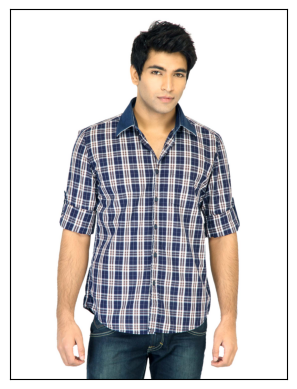

In [160]:
from PIL import Image
plt.imshow(Image.open(img_path(df.iloc[0].image)))
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.show()

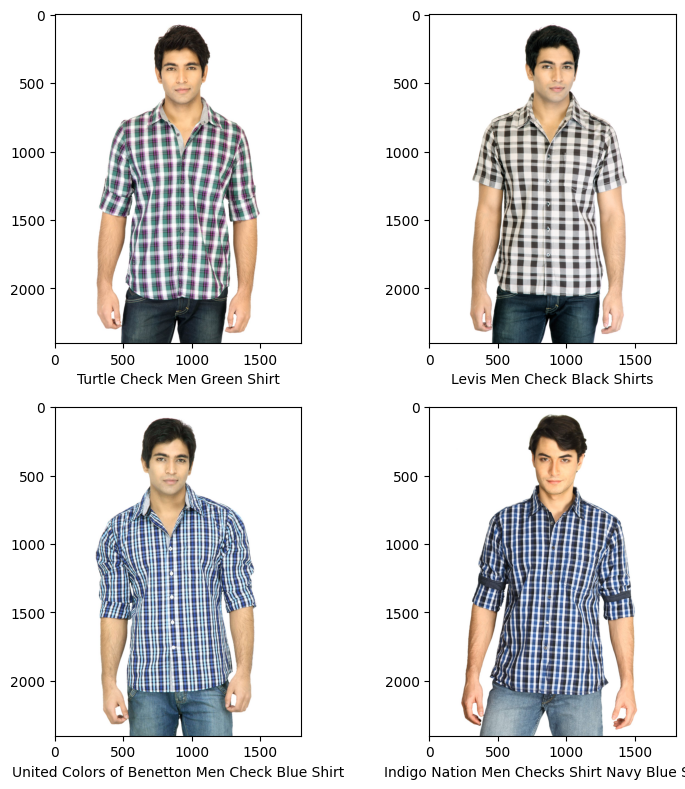

In [161]:
# generation of a dictionary of (title, images)
figures = {str(df.iloc[i].productDisplayName) : df.iloc[i].image for i in indices[0][1:-1]}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 2)

#Example 2

In [162]:
normalized_result = get_embedding(model, df.iloc[17000].image)

1/1 [==============================] - 0s 198ms/step


In [163]:
distances,indices = neighbors.kneighbors([normalized_result])

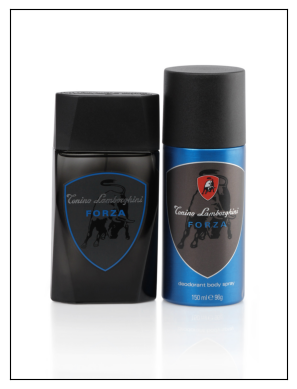

In [150]:
#original image
from PIL import Image
plt.imshow(Image.open(img_path(df.iloc[17000].image)))
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.show()

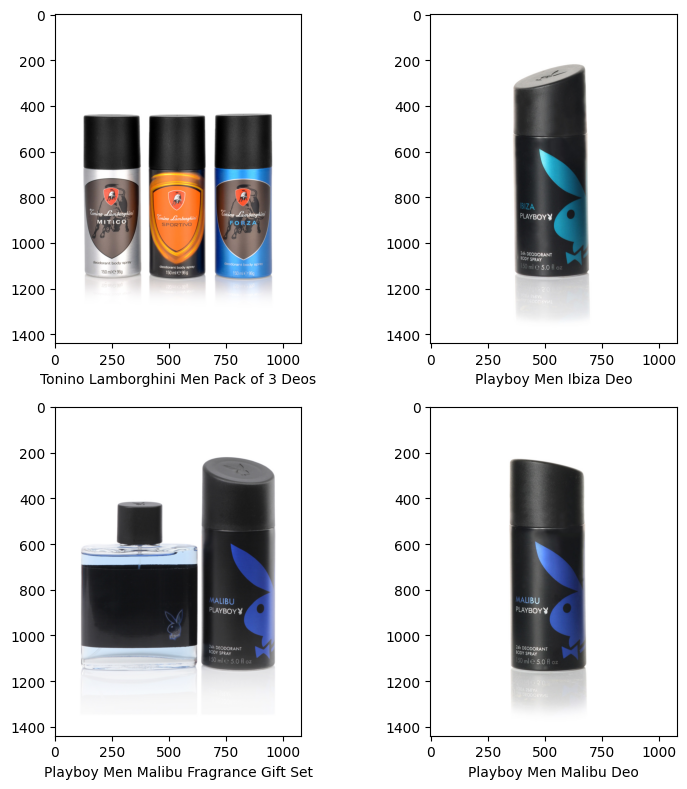

In [164]:
#recomendade products

# generation of a dictionary of (title, images)
figures = {str(df.iloc[i].productDisplayName) : df.iloc[i].image for i in indices[0][1:-1]}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 2)

#Example-3

In [170]:
normalized_result = get_embedding(model, df.iloc[26000].image)

1/1 [==============================] - 0s 201ms/step


In [171]:
distances,indices = neighbors.kneighbors([normalized_result])

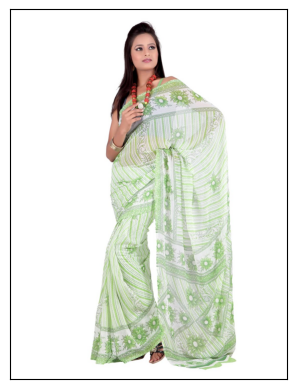

In [172]:
#original image
from PIL import Image
plt.imshow(Image.open(img_path(df.iloc[26000].image)))
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.show()

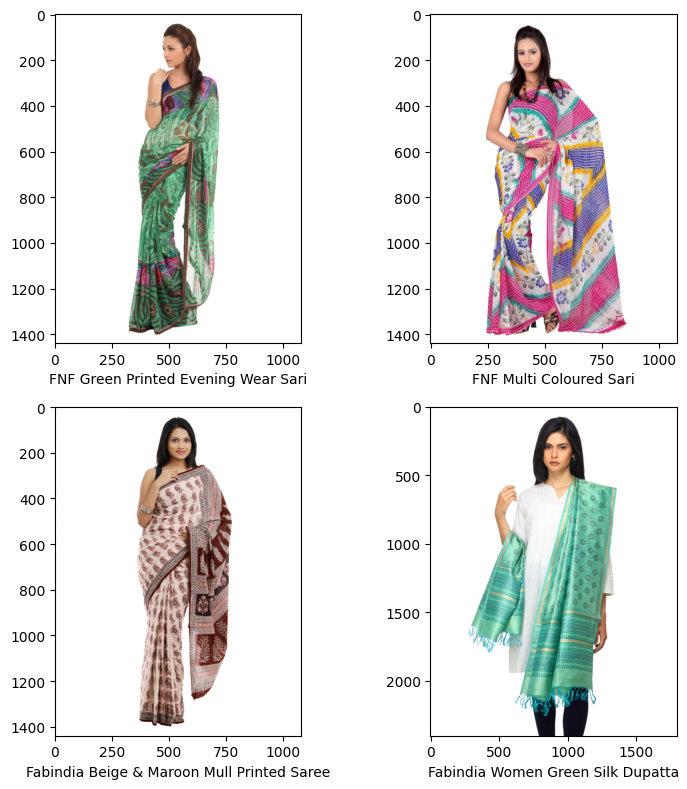

In [173]:
#recomendade products

# generation of a dictionary of (title, images)
figures = {str(df.iloc[i].productDisplayName) : df.iloc[i].image for i in indices[0][1:-1]}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 2)

#Example -4

Enter the id of a image :   8500
1/1 [==============================] - 0s 158ms/step


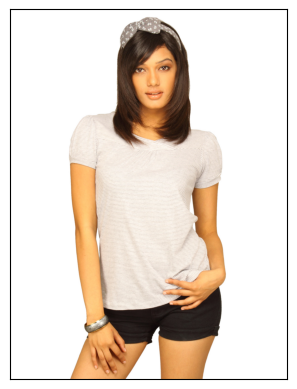

In [ ]:
#normalized the input data
i=int(input('Enter the id of a image :   '))
normalized_result = get_embedding(model, df.iloc[i].image)
distances,indices = neighbors.kneighbors([normalized_result])

#original image
from PIL import Image
plt.imshow(Image.open(img_path(df.iloc[i].image)))
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.show()

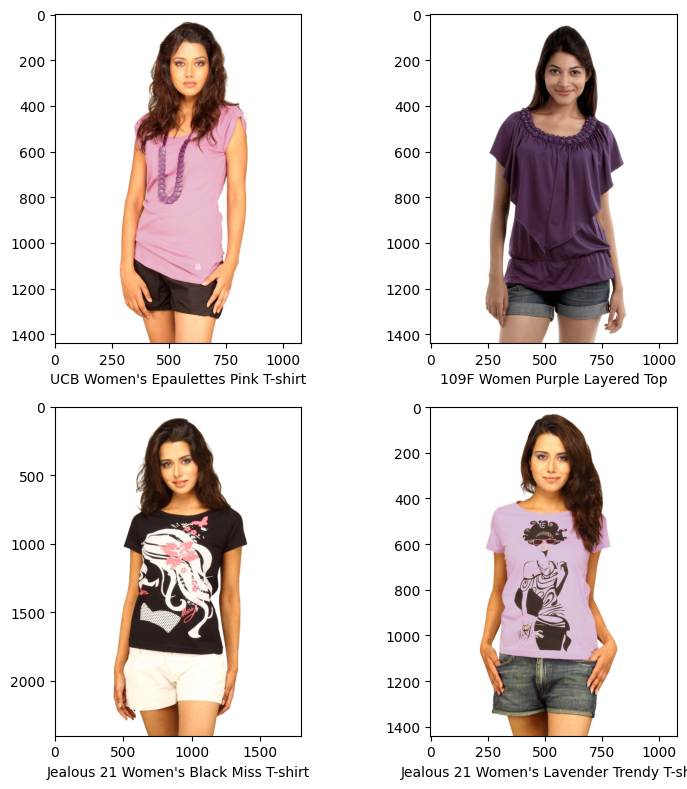

In [ ]:
#recomendade products

# generation of a dictionary of (title, images)
figures = {str(df.iloc[i].productDisplayName) : df.iloc[i].image for i in indices[0][1:-1]}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 2)

Enter the id of a image :   8888
1/1 [==============================] - 0s 299ms/step


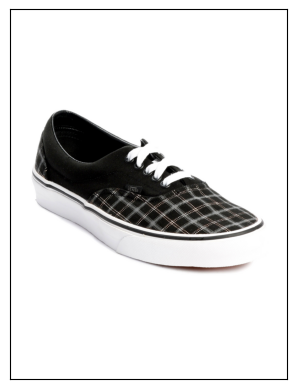

In [ ]:
#normalized the input data
i=int(input('Enter the id of a image :   '))
normalized_result = get_embedding(model, df.iloc[i].image)
distances,indices = neighbors.kneighbors([normalized_result])

#original image
from PIL import Image
plt.imshow(Image.open(img_path(df.iloc[i].image)))
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.show()

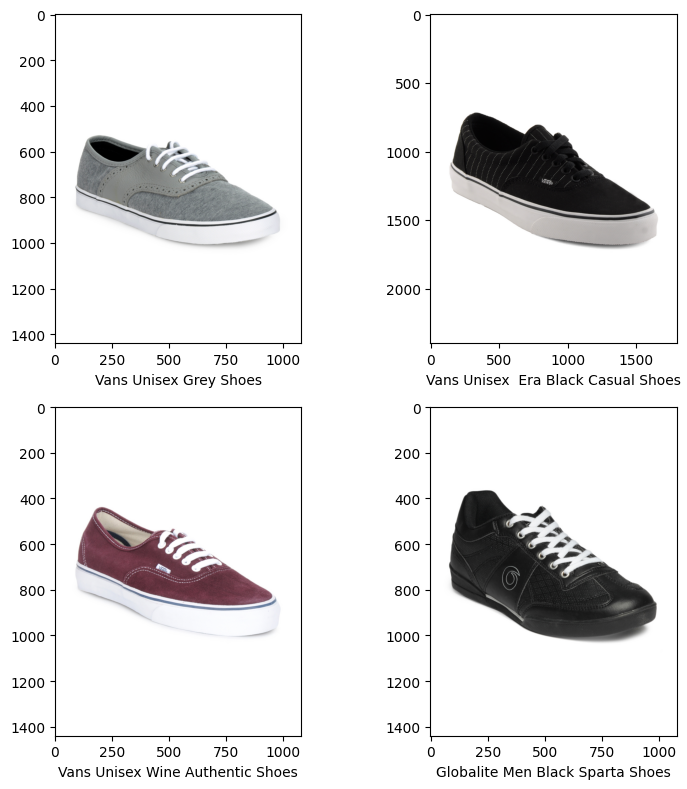

In [ ]:
#recomendade products

# generation of a dictionary of (title, images)
figures = {str(df.iloc[i].productDisplayName) : df.iloc[i].image for i in indices[0][1:-1]}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 2)